<a href="https://colab.research.google.com/github/VSM5002/AI-Powered-Thermal-Fire-Detection-System/blob/master/Image_conversion_thermal_8bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepnewbie/flir-thermal-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flir-thermal-images-dataset


In [ ]:
# List files and folders in the dataset directory
import os

files = os.listdir(path)
print("Files and folders in dataset root:")
for f in files:
    print(f)

# Print all folders and subfolders recursively
print("\nAll folders and subfolders:")
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    for d in dirs:
        print(f"  Subfolder: ",d)

Files and folders in dataset root:
FLIR_ADAS_1_3

All folders and subfolders:
Folder: /kaggle/input/flir-thermal-images-dataset
  Subfolder:  FLIR_ADAS_1_3
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3
  Subfolder:  video
  Subfolder:  val
  Subfolder:  train
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video
  Subfolder:  RGB
  Subfolder:  Annotated_thermal_8_bit
  Subfolder:  thermal_16_bit
  Subfolder:  thermal_8_bit
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/RGB
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/Annotated_thermal_8_bit
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/thermal_16_bit
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/thermal_8_bit
Folder: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val
  Subfolder:  RGB
  Subfolder:  Annotated_thermal_8_bit
  Subfolder:  thermal_16_bit
  Subfolder:  thermal_8_bit
Folder: /kaggle/input

In [ ]:
# Set RGB and thermal image directories for train and val splits
train_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "RGB")
train_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "thermal_8_bit")
val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

print("Train RGB directory:", train_rgb_dir)
print("Train Thermal directory:", train_thermal_dir)
print("Val RGB directory:", val_rgb_dir)
print("Val Thermal directory:", val_thermal_dir)

# Match images by filename prefix (without extension, ignoring extension differences)
def get_matched_files_by_prefix(rgb_dir, thermal_dir, exclude_prefix=None):
    rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
    thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
    common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
    if exclude_prefix is not None:
        common_prefixes = [p for p in common_prefixes if p != exclude_prefix]
    matched_rgb = [rgb_prefix[p] for p in common_prefixes]
    matched_thermal = [thermal_prefix[p] for p in common_prefixes]
    return matched_rgb, matched_thermal, common_prefixes

# Exclude FLIR_00001 from training
matched_rgb, matched_thermal, matched_prefixes = get_matched_files_by_prefix(train_rgb_dir, train_thermal_dir, exclude_prefix="FLIR_00001")
val_matched_rgb, val_matched_thermal, val_matched_prefixes = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)
print(f"Number of matched train RGB images: {len(matched_rgb)}")
print(f"Number of matched train thermal images: {len(matched_thermal)}")
print(f"Number of matched val RGB images: {len(val_matched_rgb)}")
print(f"Number of matched val thermal images: {len(val_matched_thermal)}")

Train RGB directory: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/RGB
Train Thermal directory: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/thermal_8_bit
Val RGB directory: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/RGB
Val Thermal directory: /kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/thermal_8_bit
Number of matched train RGB images: 8362
Number of matched train thermal images: 8362
Number of matched val RGB images: 1257
Number of matched val thermal images: 1257


In [ ]:
# Define the custom dataset and U-Net model for RGB to thermal translation
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

class FLIRRGB2ThermalDataset(Dataset):
    def __init__(self, rgb_dir, thermal_dir, img_size=256, matched_rgb=None, matched_thermal=None):
        self.rgb_dir = rgb_dir
        self.thermal_dir = thermal_dir
        self.img_size = img_size
        # Use matched file lists if provided, else match by prefix
        if matched_rgb is not None and matched_thermal is not None:
            self.rgb_files = matched_rgb
            self.thermal_files = matched_thermal
        else:
            rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
            thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
            common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
            self.rgb_files = [rgb_prefix[p] for p in common_prefixes]
            self.thermal_files = [thermal_prefix[p] for p in common_prefixes]
        print(f"Paired {len(self.rgb_files)} RGB and thermal images.")
        if len(self.rgb_files) == 0:
            raise ValueError("No matching RGB and thermal image pairs found!")
        self.transform_rgb = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.transform_thermal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        thermal_path = os.path.join(self.thermal_dir, self.thermal_files[idx])
        rgb = Image.open(rgb_path).convert('RGB')
        thermal = Image.open(thermal_path).convert('L')
        rgb = self.transform_rgb(rgb)
        thermal = self.transform_thermal(thermal)
        return rgb, thermal

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(feature*2, feature))
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = T.functional.resize(x, skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        return self.final_conv(x)

In [ ]:
# Training loop for the U-Net model with diagnostics and quick test mode
def train_model(
    rgb_dir, thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, img_size=256, save_path='unet_rgb2thermal.pth', max_samples=100
):
    import time
    from tqdm import tqdm

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FLIRRGB2ThermalDataset(rgb_dir, thermal_dir, img_size, matched_rgb=matched_rgb, matched_thermal=matched_thermal)
    if max_samples is not None:
        indices = list(range(min(max_samples, len(dataset))))
        from torch.utils.data import Subset
        dataset = Subset(dataset, indices)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    model = UNet().to(device)
    criterion = nn.L1Loss()  # Try nn.MSELoss() for even smoother results
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for i, (rgb, thermal) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            rgb, thermal = rgb.to(device), thermal.to(device)
            pred = model(rgb)
            loss = criterion(pred, thermal)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * rgb.size(0)
            if (i+1) % 2 == 0:
                print(f"  Batch {i+1}/{len(loader)} - Batch Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Time: {elapsed:.1f}s")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
    print("Training complete. Best model saved.")
    return train_losses

# Example usage:
#train_losses = train_model(train_rgb_dir, train_thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, max_samples=100)

In [ ]:
# Retrain the model from scratch
train_losses = train_model(
    train_rgb_dir,
    train_thermal_dir,
    matched_rgb,
    matched_thermal,
    epochs=25,
    batch_size=16,
    lr=5e-4,
    max_samples=None)

Paired 8362 RGB and thermal images.


Epoch 1:   0%|          | 2/523 [00:04<20:13,  2.33s/it]

  Batch 2/523 - Batch Loss: 0.5558


Epoch 1:   1%|          | 4/523 [00:07<14:51,  1.72s/it]

  Batch 4/523 - Batch Loss: 0.4032


Epoch 1:   1%|          | 6/523 [00:10<13:28,  1.56s/it]

  Batch 6/523 - Batch Loss: 0.3149


Epoch 1:   2%|▏         | 8/523 [00:13<12:50,  1.50s/it]

  Batch 8/523 - Batch Loss: 0.2028


Epoch 1:   2%|▏         | 10/523 [00:16<12:43,  1.49s/it]

  Batch 10/523 - Batch Loss: 0.1817


Epoch 1:   2%|▏         | 12/523 [00:19<12:41,  1.49s/it]

  Batch 12/523 - Batch Loss: 0.1686


Epoch 1:   3%|▎         | 14/523 [00:22<12:35,  1.49s/it]

  Batch 14/523 - Batch Loss: 0.1989


Epoch 1:   3%|▎         | 16/523 [00:25<12:41,  1.50s/it]

  Batch 16/523 - Batch Loss: 0.1695


Epoch 1:   3%|▎         | 18/523 [00:28<12:27,  1.48s/it]

  Batch 18/523 - Batch Loss: 0.1495


Epoch 1:   4%|▍         | 20/523 [00:31<12:19,  1.47s/it]

  Batch 20/523 - Batch Loss: 0.1597


Epoch 1:   4%|▍         | 22/523 [00:34<12:19,  1.48s/it]

  Batch 22/523 - Batch Loss: 0.1752


Epoch 1:   5%|▍         | 24/523 [00:37<12:13,  1.47s/it]

  Batch 24/523 - Batch Loss: 0.1656


Epoch 1:   5%|▍         | 26/523 [00:40<12:10,  1.47s/it]

  Batch 26/523 - Batch Loss: 0.1769


Epoch 1:   5%|▌         | 28/523 [00:43<11:57,  1.45s/it]

  Batch 28/523 - Batch Loss: 0.1722


Epoch 1:   6%|▌         | 30/523 [00:46<11:59,  1.46s/it]

  Batch 30/523 - Batch Loss: 0.1602


Epoch 1:   6%|▌         | 32/523 [00:48<11:57,  1.46s/it]

  Batch 32/523 - Batch Loss: 0.1498


Epoch 1:   7%|▋         | 34/523 [00:51<11:55,  1.46s/it]

  Batch 34/523 - Batch Loss: 0.1469


Epoch 1:   7%|▋         | 36/523 [00:54<12:14,  1.51s/it]

  Batch 36/523 - Batch Loss: 0.1431


Epoch 1:   7%|▋         | 38/523 [00:57<12:08,  1.50s/it]

  Batch 38/523 - Batch Loss: 0.1586


Epoch 1:   8%|▊         | 40/523 [01:01<12:07,  1.51s/it]

  Batch 40/523 - Batch Loss: 0.1325


Epoch 1:   8%|▊         | 42/523 [01:03<11:50,  1.48s/it]

  Batch 42/523 - Batch Loss: 0.1470


Epoch 1:   8%|▊         | 44/523 [01:06<11:48,  1.48s/it]

  Batch 44/523 - Batch Loss: 0.1414


Epoch 1:   9%|▉         | 46/523 [01:09<11:44,  1.48s/it]

  Batch 46/523 - Batch Loss: 0.1350


Epoch 1:   9%|▉         | 48/523 [01:12<11:52,  1.50s/it]

  Batch 48/523 - Batch Loss: 0.1474


Epoch 1:  10%|▉         | 50/523 [01:15<11:29,  1.46s/it]

  Batch 50/523 - Batch Loss: 0.1563


Epoch 1:  10%|▉         | 52/523 [01:18<11:45,  1.50s/it]

  Batch 52/523 - Batch Loss: 0.1416


Epoch 1:  10%|█         | 54/523 [01:21<11:31,  1.47s/it]

  Batch 54/523 - Batch Loss: 0.1485


Epoch 1:  11%|█         | 56/523 [01:24<11:29,  1.48s/it]

  Batch 56/523 - Batch Loss: 0.1536


Epoch 1:  11%|█         | 58/523 [01:27<11:46,  1.52s/it]

  Batch 58/523 - Batch Loss: 0.1467


Epoch 1:  11%|█▏        | 60/523 [01:30<11:50,  1.53s/it]

  Batch 60/523 - Batch Loss: 0.1513


Epoch 1:  12%|█▏        | 62/523 [01:33<11:43,  1.53s/it]

  Batch 62/523 - Batch Loss: 0.1356


Epoch 1:  12%|█▏        | 64/523 [01:36<11:34,  1.51s/it]

  Batch 64/523 - Batch Loss: 0.1303


Epoch 1:  13%|█▎        | 66/523 [01:39<11:31,  1.51s/it]

  Batch 66/523 - Batch Loss: 0.1382


Epoch 1:  13%|█▎        | 68/523 [01:42<11:28,  1.51s/it]

  Batch 68/523 - Batch Loss: 0.1558


Epoch 1:  13%|█▎        | 70/523 [01:45<11:21,  1.50s/it]

  Batch 70/523 - Batch Loss: 0.1420


Epoch 1:  14%|█▍        | 72/523 [01:48<11:17,  1.50s/it]

  Batch 72/523 - Batch Loss: 0.1334


Epoch 1:  14%|█▍        | 74/523 [01:51<11:18,  1.51s/it]

  Batch 74/523 - Batch Loss: 0.1318


Epoch 1:  15%|█▍        | 76/523 [01:54<11:12,  1.50s/it]

  Batch 76/523 - Batch Loss: 0.1497


Epoch 1:  15%|█▍        | 78/523 [01:57<11:05,  1.50s/it]

  Batch 78/523 - Batch Loss: 0.1313


Epoch 1:  15%|█▌        | 80/523 [02:00<10:58,  1.49s/it]

  Batch 80/523 - Batch Loss: 0.1597


Epoch 1:  16%|█▌        | 82/523 [02:03<11:08,  1.52s/it]

  Batch 82/523 - Batch Loss: 0.1485


Epoch 1:  16%|█▌        | 84/523 [02:06<10:57,  1.50s/it]

  Batch 84/523 - Batch Loss: 0.1262


Epoch 1:  16%|█▋        | 86/523 [02:09<11:02,  1.52s/it]

  Batch 86/523 - Batch Loss: 0.1469


Epoch 1:  17%|█▋        | 88/523 [02:12<10:57,  1.51s/it]

  Batch 88/523 - Batch Loss: 0.1368


Epoch 1:  17%|█▋        | 90/523 [02:16<10:55,  1.51s/it]

  Batch 90/523 - Batch Loss: 0.1326


Epoch 1:  18%|█▊        | 92/523 [02:19<11:04,  1.54s/it]

  Batch 92/523 - Batch Loss: 0.1308


Epoch 1:  18%|█▊        | 94/523 [02:22<11:08,  1.56s/it]

  Batch 94/523 - Batch Loss: 0.1359


Epoch 1:  18%|█▊        | 96/523 [02:25<11:14,  1.58s/it]

  Batch 96/523 - Batch Loss: 0.1597


Epoch 1:  19%|█▊        | 98/523 [02:28<10:55,  1.54s/it]

  Batch 98/523 - Batch Loss: 0.1697


Epoch 1:  19%|█▉        | 100/523 [02:31<11:00,  1.56s/it]

  Batch 100/523 - Batch Loss: 0.1404


Epoch 1:  20%|█▉        | 102/523 [02:34<10:52,  1.55s/it]

  Batch 102/523 - Batch Loss: 0.1541


Epoch 1:  20%|█▉        | 104/523 [02:37<10:58,  1.57s/it]

  Batch 104/523 - Batch Loss: 0.1417


Epoch 1:  20%|██        | 106/523 [02:41<10:48,  1.56s/it]

  Batch 106/523 - Batch Loss: 0.1358


Epoch 1:  21%|██        | 108/523 [02:44<10:48,  1.56s/it]

  Batch 108/523 - Batch Loss: 0.1272


Epoch 1:  21%|██        | 110/523 [02:47<10:44,  1.56s/it]

  Batch 110/523 - Batch Loss: 0.1453


Epoch 1:  21%|██▏       | 112/523 [02:50<10:32,  1.54s/it]

  Batch 112/523 - Batch Loss: 0.1438


Epoch 1:  22%|██▏       | 114/523 [02:53<10:45,  1.58s/it]

  Batch 114/523 - Batch Loss: 0.1440


Epoch 1:  22%|██▏       | 116/523 [02:56<10:31,  1.55s/it]

  Batch 116/523 - Batch Loss: 0.1534


Epoch 1:  23%|██▎       | 118/523 [02:59<10:29,  1.55s/it]

  Batch 118/523 - Batch Loss: 0.1257


Epoch 1:  23%|██▎       | 120/523 [03:02<10:21,  1.54s/it]

  Batch 120/523 - Batch Loss: 0.1445


Epoch 1:  23%|██▎       | 122/523 [03:05<10:12,  1.53s/it]

  Batch 122/523 - Batch Loss: 0.1258


Epoch 1:  24%|██▎       | 124/523 [03:09<10:24,  1.57s/it]

  Batch 124/523 - Batch Loss: 0.1294


Epoch 1:  24%|██▍       | 126/523 [03:12<10:25,  1.58s/it]

  Batch 126/523 - Batch Loss: 0.1238


Epoch 1:  24%|██▍       | 128/523 [03:15<10:26,  1.59s/it]

  Batch 128/523 - Batch Loss: 0.1217


Epoch 1:  25%|██▍       | 130/523 [03:18<10:24,  1.59s/it]

  Batch 130/523 - Batch Loss: 0.1269


Epoch 1:  25%|██▌       | 132/523 [03:21<10:30,  1.61s/it]

  Batch 132/523 - Batch Loss: 0.1105


Epoch 1:  26%|██▌       | 134/523 [03:25<10:38,  1.64s/it]

  Batch 134/523 - Batch Loss: 0.1337


Epoch 1:  26%|██▌       | 136/523 [03:28<10:44,  1.67s/it]

  Batch 136/523 - Batch Loss: 0.1168


Epoch 1:  26%|██▋       | 138/523 [03:31<10:46,  1.68s/it]

  Batch 138/523 - Batch Loss: 0.1129


Epoch 1:  27%|██▋       | 140/523 [03:35<10:34,  1.66s/it]

  Batch 140/523 - Batch Loss: 0.1184


Epoch 1:  27%|██▋       | 142/523 [03:38<10:15,  1.61s/it]

  Batch 142/523 - Batch Loss: 0.1208


Epoch 1:  28%|██▊       | 144/523 [03:41<10:14,  1.62s/it]

  Batch 144/523 - Batch Loss: 0.1136


Epoch 1:  28%|██▊       | 146/523 [03:44<09:57,  1.58s/it]

  Batch 146/523 - Batch Loss: 0.1105


Epoch 1:  28%|██▊       | 148/523 [03:48<10:07,  1.62s/it]

  Batch 148/523 - Batch Loss: 0.1095


Epoch 1:  29%|██▊       | 150/523 [03:51<09:54,  1.59s/it]

  Batch 150/523 - Batch Loss: 0.1251


Epoch 1:  29%|██▉       | 152/523 [03:54<10:04,  1.63s/it]

  Batch 152/523 - Batch Loss: 0.1048


Epoch 1:  29%|██▉       | 154/523 [03:57<09:59,  1.63s/it]

  Batch 154/523 - Batch Loss: 0.1069


Epoch 1:  30%|██▉       | 156/523 [04:01<10:02,  1.64s/it]

  Batch 156/523 - Batch Loss: 0.1130


Epoch 1:  30%|███       | 158/523 [04:04<09:44,  1.60s/it]

  Batch 158/523 - Batch Loss: 0.1188


Epoch 1:  31%|███       | 160/523 [04:07<09:38,  1.59s/it]

  Batch 160/523 - Batch Loss: 0.1107


Epoch 1:  31%|███       | 162/523 [04:10<09:39,  1.61s/it]

  Batch 162/523 - Batch Loss: 0.1261


Epoch 1:  31%|███▏      | 164/523 [04:13<09:40,  1.62s/it]

  Batch 164/523 - Batch Loss: 0.1032


Epoch 1:  32%|███▏      | 166/523 [04:17<09:29,  1.59s/it]

  Batch 166/523 - Batch Loss: 0.1129


Epoch 1:  32%|███▏      | 168/523 [04:20<09:18,  1.57s/it]

  Batch 168/523 - Batch Loss: 0.1315


Epoch 1:  33%|███▎      | 170/523 [04:23<09:13,  1.57s/it]

  Batch 170/523 - Batch Loss: 0.1035


Epoch 1:  33%|███▎      | 172/523 [04:26<09:18,  1.59s/it]

  Batch 172/523 - Batch Loss: 0.1005


Epoch 1:  33%|███▎      | 174/523 [04:29<09:24,  1.62s/it]

  Batch 174/523 - Batch Loss: 0.1011


Epoch 1:  34%|███▎      | 176/523 [04:32<09:13,  1.59s/it]

  Batch 176/523 - Batch Loss: 0.1120


Epoch 1:  34%|███▍      | 178/523 [04:36<09:09,  1.59s/it]

  Batch 178/523 - Batch Loss: 0.1127


Epoch 1:  34%|███▍      | 180/523 [04:39<09:06,  1.59s/it]

  Batch 180/523 - Batch Loss: 0.0955


Epoch 1:  35%|███▍      | 182/523 [04:42<08:55,  1.57s/it]

  Batch 182/523 - Batch Loss: 0.1019


Epoch 1:  35%|███▌      | 184/523 [04:45<08:50,  1.56s/it]

  Batch 184/523 - Batch Loss: 0.1079


Epoch 1:  36%|███▌      | 186/523 [04:48<08:54,  1.59s/it]

  Batch 186/523 - Batch Loss: 0.1112


Epoch 1:  36%|███▌      | 188/523 [04:51<08:52,  1.59s/it]

  Batch 188/523 - Batch Loss: 0.1212


Epoch 1:  36%|███▋      | 190/523 [04:55<08:48,  1.59s/it]

  Batch 190/523 - Batch Loss: 0.1273


Epoch 1:  37%|███▋      | 192/523 [04:58<08:41,  1.58s/it]

  Batch 192/523 - Batch Loss: 0.1053


Epoch 1:  37%|███▋      | 194/523 [05:01<08:47,  1.60s/it]

  Batch 194/523 - Batch Loss: 0.1014


Epoch 1:  37%|███▋      | 196/523 [05:04<08:45,  1.61s/it]

  Batch 196/523 - Batch Loss: 0.1141


Epoch 1:  38%|███▊      | 198/523 [05:07<08:39,  1.60s/it]

  Batch 198/523 - Batch Loss: 0.1028


Epoch 1:  38%|███▊      | 200/523 [05:11<08:30,  1.58s/it]

  Batch 200/523 - Batch Loss: 0.0988


Epoch 1:  39%|███▊      | 202/523 [05:14<08:26,  1.58s/it]

  Batch 202/523 - Batch Loss: 0.1084


Epoch 1:  39%|███▉      | 204/523 [05:17<08:30,  1.60s/it]

  Batch 204/523 - Batch Loss: 0.1120


Epoch 1:  39%|███▉      | 206/523 [05:20<08:24,  1.59s/it]

  Batch 206/523 - Batch Loss: 0.1091


Epoch 1:  40%|███▉      | 208/523 [05:23<08:34,  1.63s/it]

  Batch 208/523 - Batch Loss: 0.1014


Epoch 1:  40%|████      | 210/523 [05:27<08:30,  1.63s/it]

  Batch 210/523 - Batch Loss: 0.1060


Epoch 1:  41%|████      | 212/523 [05:30<08:34,  1.66s/it]

  Batch 212/523 - Batch Loss: 0.0998


Epoch 1:  41%|████      | 214/523 [05:33<08:22,  1.63s/it]

  Batch 214/523 - Batch Loss: 0.0904


Epoch 1:  41%|████▏     | 216/523 [05:37<08:15,  1.61s/it]

  Batch 216/523 - Batch Loss: 0.0996


Epoch 1:  42%|████▏     | 218/523 [05:40<08:20,  1.64s/it]

  Batch 218/523 - Batch Loss: 0.1030


Epoch 1:  42%|████▏     | 220/523 [05:43<08:06,  1.61s/it]

  Batch 220/523 - Batch Loss: 0.1061


Epoch 1:  42%|████▏     | 222/523 [05:46<07:55,  1.58s/it]

  Batch 222/523 - Batch Loss: 0.1126


Epoch 1:  43%|████▎     | 224/523 [05:49<07:51,  1.58s/it]

  Batch 224/523 - Batch Loss: 0.1115


Epoch 1:  43%|████▎     | 226/523 [05:52<07:52,  1.59s/it]

  Batch 226/523 - Batch Loss: 0.1088


Epoch 1:  44%|████▎     | 228/523 [05:56<07:49,  1.59s/it]

  Batch 228/523 - Batch Loss: 0.0996


Epoch 1:  44%|████▍     | 230/523 [05:59<07:41,  1.58s/it]

  Batch 230/523 - Batch Loss: 0.1288


Epoch 1:  44%|████▍     | 232/523 [06:02<07:44,  1.60s/it]

  Batch 232/523 - Batch Loss: 0.1089


Epoch 1:  45%|████▍     | 234/523 [06:05<07:41,  1.60s/it]

  Batch 234/523 - Batch Loss: 0.0985


Epoch 1:  45%|████▌     | 236/523 [06:08<07:36,  1.59s/it]

  Batch 236/523 - Batch Loss: 0.0922


Epoch 1:  46%|████▌     | 238/523 [06:12<07:40,  1.62s/it]

  Batch 238/523 - Batch Loss: 0.1093


Epoch 1:  46%|████▌     | 240/523 [06:15<07:45,  1.64s/it]

  Batch 240/523 - Batch Loss: 0.1153


Epoch 1:  46%|████▋     | 242/523 [06:18<07:45,  1.66s/it]

  Batch 242/523 - Batch Loss: 0.1137


Epoch 1:  47%|████▋     | 244/523 [06:22<07:43,  1.66s/it]

  Batch 244/523 - Batch Loss: 0.1167


Epoch 1:  47%|████▋     | 246/523 [06:25<07:36,  1.65s/it]

  Batch 246/523 - Batch Loss: 0.1018


Epoch 1:  47%|████▋     | 248/523 [06:28<07:25,  1.62s/it]

  Batch 248/523 - Batch Loss: 0.1276


Epoch 1:  48%|████▊     | 250/523 [06:31<07:20,  1.61s/it]

  Batch 250/523 - Batch Loss: 0.1046


Epoch 1:  48%|████▊     | 252/523 [06:35<07:26,  1.65s/it]

  Batch 252/523 - Batch Loss: 0.1074


Epoch 1:  49%|████▊     | 254/523 [06:38<07:27,  1.66s/it]

  Batch 254/523 - Batch Loss: 0.1127


Epoch 1:  49%|████▉     | 256/523 [06:41<07:19,  1.65s/it]

  Batch 256/523 - Batch Loss: 0.1351


Epoch 1:  49%|████▉     | 258/523 [06:44<07:07,  1.61s/it]

  Batch 258/523 - Batch Loss: 0.1115


Epoch 1:  50%|████▉     | 260/523 [06:48<07:12,  1.64s/it]

  Batch 260/523 - Batch Loss: 0.0992


Epoch 1:  50%|█████     | 262/523 [06:51<07:05,  1.63s/it]

  Batch 262/523 - Batch Loss: 0.1214


Epoch 1:  50%|█████     | 264/523 [06:54<07:02,  1.63s/it]

  Batch 264/523 - Batch Loss: 0.0920


Epoch 1:  51%|█████     | 266/523 [06:57<06:55,  1.62s/it]

  Batch 266/523 - Batch Loss: 0.1018


Epoch 1:  51%|█████     | 268/523 [07:01<06:49,  1.61s/it]

  Batch 268/523 - Batch Loss: 0.1045


Epoch 1:  52%|█████▏    | 270/523 [07:04<06:38,  1.58s/it]

  Batch 270/523 - Batch Loss: 0.1235


Epoch 1:  52%|█████▏    | 272/523 [07:07<06:44,  1.61s/it]

  Batch 272/523 - Batch Loss: 0.1035


Epoch 1:  52%|█████▏    | 274/523 [07:10<06:41,  1.61s/it]

  Batch 274/523 - Batch Loss: 0.0974


Epoch 1:  53%|█████▎    | 276/523 [07:14<06:36,  1.60s/it]

  Batch 276/523 - Batch Loss: 0.0974


Epoch 1:  53%|█████▎    | 278/523 [07:17<06:31,  1.60s/it]

  Batch 278/523 - Batch Loss: 0.0984


Epoch 1:  54%|█████▎    | 280/523 [07:20<06:30,  1.61s/it]

  Batch 280/523 - Batch Loss: 0.1129


Epoch 1:  54%|█████▍    | 282/523 [07:23<06:24,  1.60s/it]

  Batch 282/523 - Batch Loss: 0.0946


Epoch 1:  54%|█████▍    | 284/523 [07:26<06:22,  1.60s/it]

  Batch 284/523 - Batch Loss: 0.1048


Epoch 1:  55%|█████▍    | 286/523 [07:30<06:21,  1.61s/it]

  Batch 286/523 - Batch Loss: 0.1144


Epoch 1:  55%|█████▌    | 288/523 [07:33<06:17,  1.61s/it]

  Batch 288/523 - Batch Loss: 0.1170


Epoch 1:  55%|█████▌    | 290/523 [07:36<06:16,  1.61s/it]

  Batch 290/523 - Batch Loss: 0.0926


Epoch 1:  56%|█████▌    | 292/523 [07:39<06:15,  1.63s/it]

  Batch 292/523 - Batch Loss: 0.0993


Epoch 1:  56%|█████▌    | 294/523 [07:43<06:09,  1.61s/it]

  Batch 294/523 - Batch Loss: 0.1005


Epoch 1:  57%|█████▋    | 296/523 [07:46<06:08,  1.62s/it]

  Batch 296/523 - Batch Loss: 0.1032


Epoch 1:  57%|█████▋    | 298/523 [07:49<06:03,  1.61s/it]

  Batch 298/523 - Batch Loss: 0.1078


Epoch 1:  57%|█████▋    | 300/523 [07:52<05:58,  1.61s/it]

  Batch 300/523 - Batch Loss: 0.1018


Epoch 1:  58%|█████▊    | 302/523 [07:55<05:57,  1.62s/it]

  Batch 302/523 - Batch Loss: 0.1097


Epoch 1:  58%|█████▊    | 304/523 [07:59<05:50,  1.60s/it]

  Batch 304/523 - Batch Loss: 0.1143


Epoch 1:  59%|█████▊    | 306/523 [08:02<05:45,  1.59s/it]

  Batch 306/523 - Batch Loss: 0.1163


Epoch 1:  59%|█████▉    | 308/523 [08:05<05:41,  1.59s/it]

  Batch 308/523 - Batch Loss: 0.1239


Epoch 1:  59%|█████▉    | 310/523 [08:08<05:38,  1.59s/it]

  Batch 310/523 - Batch Loss: 0.1022


Epoch 1:  60%|█████▉    | 312/523 [08:11<05:38,  1.60s/it]

  Batch 312/523 - Batch Loss: 0.1047


Epoch 1:  60%|██████    | 314/523 [08:15<05:31,  1.58s/it]

  Batch 314/523 - Batch Loss: 0.0976


Epoch 1:  60%|██████    | 316/523 [08:18<05:29,  1.59s/it]

  Batch 316/523 - Batch Loss: 0.1083


Epoch 1:  61%|██████    | 318/523 [08:21<05:31,  1.62s/it]

  Batch 318/523 - Batch Loss: 0.0883


Epoch 1:  61%|██████    | 320/523 [08:24<05:28,  1.62s/it]

  Batch 320/523 - Batch Loss: 0.1108


Epoch 1:  62%|██████▏   | 322/523 [08:27<05:23,  1.61s/it]

  Batch 322/523 - Batch Loss: 0.0967


Epoch 1:  62%|██████▏   | 324/523 [08:31<05:22,  1.62s/it]

  Batch 324/523 - Batch Loss: 0.1146


Epoch 1:  62%|██████▏   | 326/523 [08:34<05:18,  1.62s/it]

  Batch 326/523 - Batch Loss: 0.1046


Epoch 1:  63%|██████▎   | 328/523 [08:37<05:13,  1.61s/it]

  Batch 328/523 - Batch Loss: 0.1111


Epoch 1:  63%|██████▎   | 330/523 [08:40<05:14,  1.63s/it]

  Batch 330/523 - Batch Loss: 0.1150


Epoch 1:  63%|██████▎   | 332/523 [08:44<05:12,  1.64s/it]

  Batch 332/523 - Batch Loss: 0.1038


Epoch 1:  64%|██████▍   | 334/523 [08:47<05:05,  1.61s/it]

  Batch 334/523 - Batch Loss: 0.1001


Epoch 1:  64%|██████▍   | 336/523 [08:50<05:02,  1.62s/it]

  Batch 336/523 - Batch Loss: 0.1032


Epoch 1:  65%|██████▍   | 338/523 [08:53<04:54,  1.59s/it]

  Batch 338/523 - Batch Loss: 0.0938


Epoch 1:  65%|██████▌   | 340/523 [08:57<04:53,  1.60s/it]

  Batch 340/523 - Batch Loss: 0.0983


Epoch 1:  65%|██████▌   | 342/523 [09:00<04:50,  1.61s/it]

  Batch 342/523 - Batch Loss: 0.0989


Epoch 1:  66%|██████▌   | 344/523 [09:03<04:47,  1.61s/it]

  Batch 344/523 - Batch Loss: 0.1222


Epoch 1:  66%|██████▌   | 346/523 [09:06<04:42,  1.60s/it]

  Batch 346/523 - Batch Loss: 0.1031


Epoch 1:  67%|██████▋   | 348/523 [09:09<04:42,  1.62s/it]

  Batch 348/523 - Batch Loss: 0.1190


Epoch 1:  67%|██████▋   | 350/523 [09:13<04:41,  1.63s/it]

  Batch 350/523 - Batch Loss: 0.0976


Epoch 1:  67%|██████▋   | 352/523 [09:16<04:36,  1.62s/it]

  Batch 352/523 - Batch Loss: 0.1026


Epoch 1:  68%|██████▊   | 354/523 [09:19<04:32,  1.61s/it]

  Batch 354/523 - Batch Loss: 0.1060


Epoch 1:  68%|██████▊   | 356/523 [09:22<04:24,  1.58s/it]

  Batch 356/523 - Batch Loss: 0.1101


Epoch 1:  68%|██████▊   | 358/523 [09:25<04:19,  1.58s/it]

  Batch 358/523 - Batch Loss: 0.0963


Epoch 1:  69%|██████▉   | 360/523 [09:28<04:19,  1.59s/it]

  Batch 360/523 - Batch Loss: 0.1005


Epoch 1:  69%|██████▉   | 362/523 [09:32<04:15,  1.58s/it]

  Batch 362/523 - Batch Loss: 0.0981


Epoch 1:  70%|██████▉   | 364/523 [09:35<04:11,  1.58s/it]

  Batch 364/523 - Batch Loss: 0.0973


Epoch 1:  70%|██████▉   | 366/523 [09:38<04:06,  1.57s/it]

  Batch 366/523 - Batch Loss: 0.1214


Epoch 1:  70%|███████   | 368/523 [09:41<04:07,  1.59s/it]

  Batch 368/523 - Batch Loss: 0.0947


Epoch 1:  71%|███████   | 370/523 [09:44<04:07,  1.62s/it]

  Batch 370/523 - Batch Loss: 0.1079


Epoch 1:  71%|███████   | 372/523 [09:48<04:04,  1.62s/it]

  Batch 372/523 - Batch Loss: 0.0955


Epoch 1:  72%|███████▏  | 374/523 [09:51<03:58,  1.60s/it]

  Batch 374/523 - Batch Loss: 0.0980


Epoch 1:  72%|███████▏  | 376/523 [09:54<03:57,  1.61s/it]

  Batch 376/523 - Batch Loss: 0.1134


Epoch 1:  72%|███████▏  | 378/523 [09:57<03:53,  1.61s/it]

  Batch 378/523 - Batch Loss: 0.1111


Epoch 1:  73%|███████▎  | 380/523 [10:01<03:52,  1.63s/it]

  Batch 380/523 - Batch Loss: 0.1108


Epoch 1:  73%|███████▎  | 382/523 [10:04<03:46,  1.60s/it]

  Batch 382/523 - Batch Loss: 0.1012


Epoch 1:  73%|███████▎  | 384/523 [10:07<03:41,  1.59s/it]

  Batch 384/523 - Batch Loss: 0.1085


Epoch 1:  74%|███████▍  | 386/523 [10:10<03:39,  1.60s/it]

  Batch 386/523 - Batch Loss: 0.0974


Epoch 1:  74%|███████▍  | 388/523 [10:13<03:38,  1.62s/it]

  Batch 388/523 - Batch Loss: 0.0889


Epoch 1:  75%|███████▍  | 390/523 [10:17<03:34,  1.62s/it]

  Batch 390/523 - Batch Loss: 0.1071


Epoch 1:  75%|███████▍  | 392/523 [10:20<03:27,  1.58s/it]

  Batch 392/523 - Batch Loss: 0.1120


Epoch 1:  75%|███████▌  | 394/523 [10:23<03:27,  1.61s/it]

  Batch 394/523 - Batch Loss: 0.0903


Epoch 1:  76%|███████▌  | 396/523 [10:26<03:23,  1.60s/it]

  Batch 396/523 - Batch Loss: 0.0888


Epoch 1:  76%|███████▌  | 398/523 [10:29<03:18,  1.59s/it]

  Batch 398/523 - Batch Loss: 0.1008


Epoch 1:  76%|███████▋  | 400/523 [10:33<03:15,  1.59s/it]

  Batch 400/523 - Batch Loss: 0.1163


Epoch 1:  77%|███████▋  | 402/523 [10:36<03:14,  1.61s/it]

  Batch 402/523 - Batch Loss: 0.1075


Epoch 1:  77%|███████▋  | 404/523 [10:39<03:14,  1.63s/it]

  Batch 404/523 - Batch Loss: 0.1101


Epoch 1:  78%|███████▊  | 406/523 [10:42<03:08,  1.61s/it]

  Batch 406/523 - Batch Loss: 0.0997


Epoch 1:  78%|███████▊  | 408/523 [10:45<03:04,  1.60s/it]

  Batch 408/523 - Batch Loss: 0.1159


Epoch 1:  78%|███████▊  | 410/523 [10:49<03:05,  1.64s/it]

  Batch 410/523 - Batch Loss: 0.0983


Epoch 1:  79%|███████▉  | 412/523 [10:52<03:00,  1.62s/it]

  Batch 412/523 - Batch Loss: 0.1029


Epoch 1:  79%|███████▉  | 414/523 [10:55<02:56,  1.62s/it]

  Batch 414/523 - Batch Loss: 0.0947


Epoch 1:  80%|███████▉  | 416/523 [10:58<02:51,  1.61s/it]

  Batch 416/523 - Batch Loss: 0.1089


Epoch 1:  80%|███████▉  | 418/523 [11:02<02:49,  1.62s/it]

  Batch 418/523 - Batch Loss: 0.0865


Epoch 1:  80%|████████  | 420/523 [11:05<02:45,  1.61s/it]

  Batch 420/523 - Batch Loss: 0.0962


Epoch 1:  81%|████████  | 422/523 [11:08<02:41,  1.60s/it]

  Batch 422/523 - Batch Loss: 0.1038


Epoch 1:  81%|████████  | 424/523 [11:11<02:41,  1.63s/it]

  Batch 424/523 - Batch Loss: 0.0912


Epoch 1:  81%|████████▏ | 426/523 [11:15<02:38,  1.64s/it]

  Batch 426/523 - Batch Loss: 0.0991


Epoch 1:  82%|████████▏ | 428/523 [11:18<02:36,  1.65s/it]

  Batch 428/523 - Batch Loss: 0.0958


Epoch 1:  82%|████████▏ | 430/523 [11:21<02:33,  1.65s/it]

  Batch 430/523 - Batch Loss: 0.1068


Epoch 1:  83%|████████▎ | 432/523 [11:25<02:30,  1.65s/it]

  Batch 432/523 - Batch Loss: 0.1074


Epoch 1:  83%|████████▎ | 434/523 [11:28<02:23,  1.61s/it]

  Batch 434/523 - Batch Loss: 0.1080


Epoch 1:  83%|████████▎ | 436/523 [11:31<02:20,  1.62s/it]

  Batch 436/523 - Batch Loss: 0.1032


Epoch 1:  84%|████████▎ | 438/523 [11:34<02:17,  1.62s/it]

  Batch 438/523 - Batch Loss: 0.1016


Epoch 1:  84%|████████▍ | 440/523 [11:38<02:15,  1.64s/it]

  Batch 440/523 - Batch Loss: 0.1121


Epoch 1:  85%|████████▍ | 442/523 [11:41<02:12,  1.64s/it]

  Batch 442/523 - Batch Loss: 0.0869


Epoch 1:  85%|████████▍ | 444/523 [11:44<02:08,  1.63s/it]

  Batch 444/523 - Batch Loss: 0.1034


Epoch 1:  85%|████████▌ | 446/523 [11:47<02:06,  1.64s/it]

  Batch 446/523 - Batch Loss: 0.0868


Epoch 1:  86%|████████▌ | 448/523 [11:51<02:02,  1.64s/it]

  Batch 448/523 - Batch Loss: 0.1143


Epoch 1:  86%|████████▌ | 450/523 [11:54<01:59,  1.64s/it]

  Batch 450/523 - Batch Loss: 0.1056


Epoch 1:  86%|████████▋ | 452/523 [11:57<01:55,  1.62s/it]

  Batch 452/523 - Batch Loss: 0.1005


Epoch 1:  87%|████████▋ | 454/523 [12:00<01:51,  1.62s/it]

  Batch 454/523 - Batch Loss: 0.0995


Epoch 1:  87%|████████▋ | 456/523 [12:04<01:47,  1.60s/it]

  Batch 456/523 - Batch Loss: 0.0974


Epoch 1:  88%|████████▊ | 458/523 [12:07<01:43,  1.60s/it]

  Batch 458/523 - Batch Loss: 0.0958


Epoch 1:  88%|████████▊ | 460/523 [12:10<01:43,  1.64s/it]

  Batch 460/523 - Batch Loss: 0.1056


Epoch 1:  88%|████████▊ | 462/523 [12:13<01:37,  1.60s/it]

  Batch 462/523 - Batch Loss: 0.0953


Epoch 1:  89%|████████▊ | 464/523 [12:16<01:34,  1.60s/it]

  Batch 464/523 - Batch Loss: 0.0979


Epoch 1:  89%|████████▉ | 466/523 [12:20<01:32,  1.62s/it]

  Batch 466/523 - Batch Loss: 0.0963


Epoch 1:  89%|████████▉ | 468/523 [12:23<01:31,  1.66s/it]

  Batch 468/523 - Batch Loss: 0.0938


Epoch 1:  90%|████████▉ | 470/523 [12:26<01:27,  1.66s/it]

  Batch 470/523 - Batch Loss: 0.1070


Epoch 1:  90%|█████████ | 472/523 [12:30<01:23,  1.65s/it]

  Batch 472/523 - Batch Loss: 0.1076


Epoch 1:  91%|█████████ | 474/523 [12:33<01:20,  1.64s/it]

  Batch 474/523 - Batch Loss: 0.1110


Epoch 1:  91%|█████████ | 476/523 [12:36<01:15,  1.61s/it]

  Batch 476/523 - Batch Loss: 0.0916


Epoch 1:  91%|█████████▏| 478/523 [12:39<01:13,  1.63s/it]

  Batch 478/523 - Batch Loss: 0.1026


Epoch 1:  92%|█████████▏| 480/523 [12:43<01:10,  1.63s/it]

  Batch 480/523 - Batch Loss: 0.1064


Epoch 1:  92%|█████████▏| 482/523 [12:46<01:07,  1.64s/it]

  Batch 482/523 - Batch Loss: 0.0985


Epoch 1:  93%|█████████▎| 484/523 [12:49<01:04,  1.65s/it]

  Batch 484/523 - Batch Loss: 0.1183


Epoch 1:  93%|█████████▎| 486/523 [12:53<01:01,  1.65s/it]

  Batch 486/523 - Batch Loss: 0.0988


Epoch 1:  93%|█████████▎| 488/523 [12:56<00:57,  1.63s/it]

  Batch 488/523 - Batch Loss: 0.0959


Epoch 1:  94%|█████████▎| 490/523 [12:59<00:52,  1.60s/it]

  Batch 490/523 - Batch Loss: 0.0988


Epoch 1:  94%|█████████▍| 492/523 [13:02<00:49,  1.60s/it]

  Batch 492/523 - Batch Loss: 0.1102


Epoch 1:  94%|█████████▍| 494/523 [13:05<00:45,  1.58s/it]

  Batch 494/523 - Batch Loss: 0.0871


Epoch 1:  95%|█████████▍| 496/523 [13:08<00:43,  1.61s/it]

  Batch 496/523 - Batch Loss: 0.0944


Epoch 1:  95%|█████████▌| 498/523 [13:12<00:40,  1.62s/it]

  Batch 498/523 - Batch Loss: 0.1066


Epoch 1:  96%|█████████▌| 500/523 [13:15<00:37,  1.62s/it]

  Batch 500/523 - Batch Loss: 0.1068


Epoch 1:  96%|█████████▌| 502/523 [13:18<00:33,  1.61s/it]

  Batch 502/523 - Batch Loss: 0.1032


Epoch 1:  96%|█████████▋| 504/523 [13:21<00:30,  1.62s/it]

  Batch 504/523 - Batch Loss: 0.1033


Epoch 1:  97%|█████████▋| 506/523 [13:25<00:27,  1.62s/it]

  Batch 506/523 - Batch Loss: 0.1121


Epoch 1:  97%|█████████▋| 508/523 [13:28<00:24,  1.62s/it]

  Batch 508/523 - Batch Loss: 0.0927


Epoch 1:  98%|█████████▊| 510/523 [13:31<00:20,  1.61s/it]

  Batch 510/523 - Batch Loss: 0.0935


Epoch 1:  98%|█████████▊| 512/523 [13:34<00:17,  1.61s/it]

  Batch 512/523 - Batch Loss: 0.0953


Epoch 1:  98%|█████████▊| 514/523 [13:38<00:14,  1.63s/it]

  Batch 514/523 - Batch Loss: 0.0907


Epoch 1:  99%|█████████▊| 516/523 [13:41<00:11,  1.63s/it]

  Batch 516/523 - Batch Loss: 0.1064


Epoch 1:  99%|█████████▉| 518/523 [13:44<00:08,  1.62s/it]

  Batch 518/523 - Batch Loss: 0.1010


Epoch 1:  99%|█████████▉| 520/523 [13:47<00:04,  1.61s/it]

  Batch 520/523 - Batch Loss: 0.0954


Epoch 1: 100%|█████████▉| 522/523 [13:50<00:01,  1.60s/it]

  Batch 522/523 - Batch Loss: 0.0925


Epoch 1: 100%|██████████| 523/523 [13:52<00:00,  1.59s/it]


Epoch 1/25 - Loss: 0.1194 - Time: 832.1s


Epoch 2:   0%|          | 2/523 [00:02<11:48,  1.36s/it]

  Batch 2/523 - Batch Loss: 0.1175


Epoch 2:   1%|          | 4/523 [00:05<12:09,  1.41s/it]

  Batch 4/523 - Batch Loss: 0.0961


Epoch 2:   1%|          | 6/523 [00:08<12:10,  1.41s/it]

  Batch 6/523 - Batch Loss: 0.1036


Epoch 2:   2%|▏         | 8/523 [00:11<12:10,  1.42s/it]

  Batch 8/523 - Batch Loss: 0.0919


Epoch 2:   2%|▏         | 10/523 [00:14<12:03,  1.41s/it]

  Batch 10/523 - Batch Loss: 0.0908


Epoch 2:   2%|▏         | 12/523 [00:16<12:05,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.1047


Epoch 2:   3%|▎         | 14/523 [00:19<12:02,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0940


Epoch 2:   3%|▎         | 16/523 [00:22<11:55,  1.41s/it]

  Batch 16/523 - Batch Loss: 0.0920


Epoch 2:   3%|▎         | 18/523 [00:25<11:46,  1.40s/it]

  Batch 18/523 - Batch Loss: 0.0951


Epoch 2:   4%|▍         | 20/523 [00:28<11:49,  1.41s/it]

  Batch 20/523 - Batch Loss: 0.0994


Epoch 2:   4%|▍         | 22/523 [00:30<11:43,  1.40s/it]

  Batch 22/523 - Batch Loss: 0.0879


Epoch 2:   5%|▍         | 24/523 [00:33<11:37,  1.40s/it]

  Batch 24/523 - Batch Loss: 0.0960


Epoch 2:   5%|▍         | 26/523 [00:36<11:53,  1.44s/it]

  Batch 26/523 - Batch Loss: 0.0931


Epoch 2:   5%|▌         | 28/523 [00:39<11:45,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0988


Epoch 2:   6%|▌         | 30/523 [00:42<11:30,  1.40s/it]

  Batch 30/523 - Batch Loss: 0.1107


Epoch 2:   6%|▌         | 32/523 [00:45<11:28,  1.40s/it]

  Batch 32/523 - Batch Loss: 0.1109


Epoch 2:   7%|▋         | 34/523 [00:47<11:20,  1.39s/it]

  Batch 34/523 - Batch Loss: 0.1031


Epoch 2:   7%|▋         | 36/523 [00:50<11:21,  1.40s/it]

  Batch 36/523 - Batch Loss: 0.1075


Epoch 2:   7%|▋         | 38/523 [00:53<11:07,  1.38s/it]

  Batch 38/523 - Batch Loss: 0.1072


Epoch 2:   8%|▊         | 40/523 [00:56<11:08,  1.38s/it]

  Batch 40/523 - Batch Loss: 0.0962


Epoch 2:   8%|▊         | 42/523 [00:59<11:18,  1.41s/it]

  Batch 42/523 - Batch Loss: 0.0882


Epoch 2:   8%|▊         | 44/523 [01:01<11:22,  1.42s/it]

  Batch 44/523 - Batch Loss: 0.1026


Epoch 2:   9%|▉         | 46/523 [01:04<11:17,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.1088


Epoch 2:   9%|▉         | 48/523 [01:07<11:05,  1.40s/it]

  Batch 48/523 - Batch Loss: 0.1087


Epoch 2:  10%|▉         | 50/523 [01:10<11:18,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.1005


Epoch 2:  10%|▉         | 52/523 [01:13<11:00,  1.40s/it]

  Batch 52/523 - Batch Loss: 0.1056


Epoch 2:  10%|█         | 54/523 [01:15<10:56,  1.40s/it]

  Batch 54/523 - Batch Loss: 0.0957


Epoch 2:  11%|█         | 56/523 [01:18<10:59,  1.41s/it]

  Batch 56/523 - Batch Loss: 0.0939


Epoch 2:  11%|█         | 58/523 [01:21<10:55,  1.41s/it]

  Batch 58/523 - Batch Loss: 0.0879


Epoch 2:  11%|█▏        | 60/523 [01:24<10:48,  1.40s/it]

  Batch 60/523 - Batch Loss: 0.0882


Epoch 2:  12%|█▏        | 62/523 [01:27<10:41,  1.39s/it]

  Batch 62/523 - Batch Loss: 0.1031


Epoch 2:  12%|█▏        | 64/523 [01:29<10:41,  1.40s/it]

  Batch 64/523 - Batch Loss: 0.1092


Epoch 2:  13%|█▎        | 66/523 [01:32<10:40,  1.40s/it]

  Batch 66/523 - Batch Loss: 0.1014


Epoch 2:  13%|█▎        | 68/523 [01:35<10:27,  1.38s/it]

  Batch 68/523 - Batch Loss: 0.1147


Epoch 2:  13%|█▎        | 70/523 [01:38<10:39,  1.41s/it]

  Batch 70/523 - Batch Loss: 0.0966


Epoch 2:  14%|█▍        | 72/523 [01:41<10:40,  1.42s/it]

  Batch 72/523 - Batch Loss: 0.0893


Epoch 2:  14%|█▍        | 74/523 [01:44<10:36,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0994


Epoch 2:  15%|█▍        | 76/523 [01:46<10:35,  1.42s/it]

  Batch 76/523 - Batch Loss: 0.0930


Epoch 2:  15%|█▍        | 78/523 [01:49<10:36,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0980


Epoch 2:  15%|█▌        | 80/523 [01:52<10:31,  1.43s/it]

  Batch 80/523 - Batch Loss: 0.0947


Epoch 2:  16%|█▌        | 82/523 [01:55<10:39,  1.45s/it]

  Batch 82/523 - Batch Loss: 0.0990


Epoch 2:  16%|█▌        | 84/523 [01:58<10:22,  1.42s/it]

  Batch 84/523 - Batch Loss: 0.1005


Epoch 2:  16%|█▋        | 86/523 [02:01<10:24,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0886


Epoch 2:  17%|█▋        | 88/523 [02:04<10:16,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.0975


Epoch 2:  17%|█▋        | 90/523 [02:06<10:06,  1.40s/it]

  Batch 90/523 - Batch Loss: 0.1019


Epoch 2:  18%|█▊        | 92/523 [02:09<10:03,  1.40s/it]

  Batch 92/523 - Batch Loss: 0.0980


Epoch 2:  18%|█▊        | 94/523 [02:12<10:07,  1.42s/it]

  Batch 94/523 - Batch Loss: 0.1167


Epoch 2:  18%|█▊        | 96/523 [02:15<10:05,  1.42s/it]

  Batch 96/523 - Batch Loss: 0.1110


Epoch 2:  19%|█▊        | 98/523 [02:18<10:12,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0831


Epoch 2:  19%|█▉        | 100/523 [02:21<09:56,  1.41s/it]

  Batch 100/523 - Batch Loss: 0.0928


Epoch 2:  20%|█▉        | 102/523 [02:23<09:53,  1.41s/it]

  Batch 102/523 - Batch Loss: 0.0891


Epoch 2:  20%|█▉        | 104/523 [02:26<09:40,  1.38s/it]

  Batch 104/523 - Batch Loss: 0.1001


Epoch 2:  20%|██        | 106/523 [02:29<09:33,  1.38s/it]

  Batch 106/523 - Batch Loss: 0.1090


Epoch 2:  21%|██        | 108/523 [02:32<09:32,  1.38s/it]

  Batch 108/523 - Batch Loss: 0.1105


Epoch 2:  21%|██        | 110/523 [02:34<09:25,  1.37s/it]

  Batch 110/523 - Batch Loss: 0.0951


Epoch 2:  21%|██▏       | 112/523 [02:37<09:29,  1.39s/it]

  Batch 112/523 - Batch Loss: 0.1003


Epoch 2:  22%|██▏       | 114/523 [02:40<09:29,  1.39s/it]

  Batch 114/523 - Batch Loss: 0.0954


Epoch 2:  22%|██▏       | 116/523 [02:43<09:43,  1.43s/it]

  Batch 116/523 - Batch Loss: 0.0865


Epoch 2:  23%|██▎       | 118/523 [02:46<09:27,  1.40s/it]

  Batch 118/523 - Batch Loss: 0.0885


Epoch 2:  23%|██▎       | 120/523 [02:48<09:29,  1.41s/it]

  Batch 120/523 - Batch Loss: 0.0979


Epoch 2:  23%|██▎       | 122/523 [02:51<09:21,  1.40s/it]

  Batch 122/523 - Batch Loss: 0.0927


Epoch 2:  24%|██▎       | 124/523 [02:54<09:29,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.1020


Epoch 2:  24%|██▍       | 126/523 [02:57<09:21,  1.41s/it]

  Batch 126/523 - Batch Loss: 0.1034


Epoch 2:  24%|██▍       | 128/523 [03:00<09:18,  1.41s/it]

  Batch 128/523 - Batch Loss: 0.0928


Epoch 2:  25%|██▍       | 130/523 [03:03<09:19,  1.42s/it]

  Batch 130/523 - Batch Loss: 0.0913


Epoch 2:  25%|██▌       | 132/523 [03:05<09:19,  1.43s/it]

  Batch 132/523 - Batch Loss: 0.0861


Epoch 2:  26%|██▌       | 134/523 [03:08<09:20,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0959


Epoch 2:  26%|██▌       | 136/523 [03:11<09:09,  1.42s/it]

  Batch 136/523 - Batch Loss: 0.0888


Epoch 2:  26%|██▋       | 138/523 [03:14<09:14,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.1182


Epoch 2:  27%|██▋       | 140/523 [03:17<09:11,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.1085


Epoch 2:  27%|██▋       | 142/523 [03:20<09:02,  1.43s/it]

  Batch 142/523 - Batch Loss: 0.1180


Epoch 2:  28%|██▊       | 144/523 [03:23<08:52,  1.41s/it]

  Batch 144/523 - Batch Loss: 0.0978


Epoch 2:  28%|██▊       | 146/523 [03:25<08:43,  1.39s/it]

  Batch 146/523 - Batch Loss: 0.0921


Epoch 2:  28%|██▊       | 148/523 [03:28<08:44,  1.40s/it]

  Batch 148/523 - Batch Loss: 0.0938


Epoch 2:  29%|██▊       | 150/523 [03:31<08:45,  1.41s/it]

  Batch 150/523 - Batch Loss: 0.0925


Epoch 2:  29%|██▉       | 152/523 [03:34<08:46,  1.42s/it]

  Batch 152/523 - Batch Loss: 0.1024


Epoch 2:  29%|██▉       | 154/523 [03:37<08:42,  1.42s/it]

  Batch 154/523 - Batch Loss: 0.1034


Epoch 2:  30%|██▉       | 156/523 [03:39<08:43,  1.43s/it]

  Batch 156/523 - Batch Loss: 0.0874


Epoch 2:  30%|███       | 158/523 [03:42<08:31,  1.40s/it]

  Batch 158/523 - Batch Loss: 0.1127


Epoch 2:  31%|███       | 160/523 [03:45<08:26,  1.39s/it]

  Batch 160/523 - Batch Loss: 0.1015


Epoch 2:  31%|███       | 162/523 [03:48<08:33,  1.42s/it]

  Batch 162/523 - Batch Loss: 0.0996


Epoch 2:  31%|███▏      | 164/523 [03:51<08:22,  1.40s/it]

  Batch 164/523 - Batch Loss: 0.1043


Epoch 2:  32%|███▏      | 166/523 [03:53<08:11,  1.38s/it]

  Batch 166/523 - Batch Loss: 0.1054


Epoch 2:  32%|███▏      | 168/523 [03:56<08:06,  1.37s/it]

  Batch 168/523 - Batch Loss: 0.0998


Epoch 2:  33%|███▎      | 170/523 [03:59<08:04,  1.37s/it]

  Batch 170/523 - Batch Loss: 0.0952


Epoch 2:  33%|███▎      | 172/523 [04:02<08:05,  1.38s/it]

  Batch 172/523 - Batch Loss: 0.0994


Epoch 2:  33%|███▎      | 174/523 [04:04<07:59,  1.37s/it]

  Batch 174/523 - Batch Loss: 0.1028


Epoch 2:  34%|███▎      | 176/523 [04:07<08:03,  1.39s/it]

  Batch 176/523 - Batch Loss: 0.0784


Epoch 2:  34%|███▍      | 178/523 [04:10<07:56,  1.38s/it]

  Batch 178/523 - Batch Loss: 0.0887


Epoch 2:  34%|███▍      | 180/523 [04:13<07:55,  1.39s/it]

  Batch 180/523 - Batch Loss: 0.0862


Epoch 2:  35%|███▍      | 182/523 [04:15<07:51,  1.38s/it]

  Batch 182/523 - Batch Loss: 0.1083


Epoch 2:  35%|███▌      | 184/523 [04:18<07:55,  1.40s/it]

  Batch 184/523 - Batch Loss: 0.0963


Epoch 2:  36%|███▌      | 186/523 [04:21<07:53,  1.41s/it]

  Batch 186/523 - Batch Loss: 0.1149


Epoch 2:  36%|███▌      | 188/523 [04:24<07:49,  1.40s/it]

  Batch 188/523 - Batch Loss: 0.0903


Epoch 2:  36%|███▋      | 190/523 [04:27<07:49,  1.41s/it]

  Batch 190/523 - Batch Loss: 0.0929


Epoch 2:  37%|███▋      | 192/523 [04:30<07:44,  1.40s/it]

  Batch 192/523 - Batch Loss: 0.0884


Epoch 2:  37%|███▋      | 194/523 [04:32<07:39,  1.40s/it]

  Batch 194/523 - Batch Loss: 0.1030


Epoch 2:  37%|███▋      | 196/523 [04:35<07:34,  1.39s/it]

  Batch 196/523 - Batch Loss: 0.0929


Epoch 2:  38%|███▊      | 198/523 [04:38<07:36,  1.41s/it]

  Batch 198/523 - Batch Loss: 0.0966


Epoch 2:  38%|███▊      | 200/523 [04:41<07:34,  1.41s/it]

  Batch 200/523 - Batch Loss: 0.1033


Epoch 2:  39%|███▊      | 202/523 [04:44<07:34,  1.42s/it]

  Batch 202/523 - Batch Loss: 0.1035


Epoch 2:  39%|███▉      | 204/523 [04:46<07:30,  1.41s/it]

  Batch 204/523 - Batch Loss: 0.0898


Epoch 2:  39%|███▉      | 206/523 [04:49<07:27,  1.41s/it]

  Batch 206/523 - Batch Loss: 0.1133


Epoch 2:  40%|███▉      | 208/523 [04:52<07:22,  1.41s/it]

  Batch 208/523 - Batch Loss: 0.0848


Epoch 2:  40%|████      | 210/523 [04:55<07:22,  1.41s/it]

  Batch 210/523 - Batch Loss: 0.0888


Epoch 2:  41%|████      | 212/523 [04:58<07:24,  1.43s/it]

  Batch 212/523 - Batch Loss: 0.1034


Epoch 2:  41%|████      | 214/523 [05:01<07:20,  1.42s/it]

  Batch 214/523 - Batch Loss: 0.0943


Epoch 2:  41%|████▏     | 216/523 [05:04<07:17,  1.43s/it]

  Batch 216/523 - Batch Loss: 0.0954


Epoch 2:  42%|████▏     | 218/523 [05:06<07:13,  1.42s/it]

  Batch 218/523 - Batch Loss: 0.1013


Epoch 2:  42%|████▏     | 220/523 [05:09<07:09,  1.42s/it]

  Batch 220/523 - Batch Loss: 0.0970


Epoch 2:  42%|████▏     | 222/523 [05:12<07:08,  1.42s/it]

  Batch 222/523 - Batch Loss: 0.0917


Epoch 2:  43%|████▎     | 224/523 [05:15<07:00,  1.41s/it]

  Batch 224/523 - Batch Loss: 0.1089


Epoch 2:  43%|████▎     | 226/523 [05:18<07:00,  1.41s/it]

  Batch 226/523 - Batch Loss: 0.0847


Epoch 2:  44%|████▎     | 228/523 [05:21<07:02,  1.43s/it]

  Batch 228/523 - Batch Loss: 0.0886


Epoch 2:  44%|████▍     | 230/523 [05:23<06:56,  1.42s/it]

  Batch 230/523 - Batch Loss: 0.0968


Epoch 2:  44%|████▍     | 232/523 [05:26<06:51,  1.42s/it]

  Batch 232/523 - Batch Loss: 0.1059


Epoch 2:  45%|████▍     | 234/523 [05:29<06:51,  1.42s/it]

  Batch 234/523 - Batch Loss: 0.1029


Epoch 2:  45%|████▌     | 236/523 [05:32<06:47,  1.42s/it]

  Batch 236/523 - Batch Loss: 0.0960


Epoch 2:  46%|████▌     | 238/523 [05:35<06:37,  1.39s/it]

  Batch 238/523 - Batch Loss: 0.1078


Epoch 2:  46%|████▌     | 240/523 [05:37<06:38,  1.41s/it]

  Batch 240/523 - Batch Loss: 0.1097


Epoch 2:  46%|████▋     | 242/523 [05:40<06:32,  1.40s/it]

  Batch 242/523 - Batch Loss: 0.1055


Epoch 2:  47%|████▋     | 244/523 [05:43<06:26,  1.39s/it]

  Batch 244/523 - Batch Loss: 0.1083


Epoch 2:  47%|████▋     | 246/523 [05:46<06:30,  1.41s/it]

  Batch 246/523 - Batch Loss: 0.0892


Epoch 2:  47%|████▋     | 248/523 [05:49<06:29,  1.42s/it]

  Batch 248/523 - Batch Loss: 0.1017


Epoch 2:  48%|████▊     | 250/523 [05:52<06:27,  1.42s/it]

  Batch 250/523 - Batch Loss: 0.0946


Epoch 2:  48%|████▊     | 252/523 [05:54<06:27,  1.43s/it]

  Batch 252/523 - Batch Loss: 0.0960


Epoch 2:  49%|████▊     | 254/523 [05:57<06:19,  1.41s/it]

  Batch 254/523 - Batch Loss: 0.0990


Epoch 2:  49%|████▉     | 256/523 [06:00<06:20,  1.42s/it]

  Batch 256/523 - Batch Loss: 0.0914


Epoch 2:  49%|████▉     | 258/523 [06:03<06:14,  1.41s/it]

  Batch 258/523 - Batch Loss: 0.0827


Epoch 2:  50%|████▉     | 260/523 [06:06<06:10,  1.41s/it]

  Batch 260/523 - Batch Loss: 0.0928


Epoch 2:  50%|█████     | 262/523 [06:08<06:05,  1.40s/it]

  Batch 262/523 - Batch Loss: 0.1111


Epoch 2:  50%|█████     | 264/523 [06:11<05:57,  1.38s/it]

  Batch 264/523 - Batch Loss: 0.0940


Epoch 2:  51%|█████     | 266/523 [06:14<05:54,  1.38s/it]

  Batch 266/523 - Batch Loss: 0.1040


Epoch 2:  51%|█████     | 268/523 [06:17<05:57,  1.40s/it]

  Batch 268/523 - Batch Loss: 0.1113


Epoch 2:  52%|█████▏    | 270/523 [06:20<05:53,  1.40s/it]

  Batch 270/523 - Batch Loss: 0.1164


Epoch 2:  52%|█████▏    | 272/523 [06:22<05:49,  1.39s/it]

  Batch 272/523 - Batch Loss: 0.1019


Epoch 2:  52%|█████▏    | 274/523 [06:25<05:48,  1.40s/it]

  Batch 274/523 - Batch Loss: 0.1121


Epoch 2:  53%|█████▎    | 276/523 [06:28<05:50,  1.42s/it]

  Batch 276/523 - Batch Loss: 0.0932


Epoch 2:  53%|█████▎    | 278/523 [06:31<05:48,  1.42s/it]

  Batch 278/523 - Batch Loss: 0.1038


Epoch 2:  54%|█████▎    | 280/523 [06:34<05:44,  1.42s/it]

  Batch 280/523 - Batch Loss: 0.1010


Epoch 2:  54%|█████▍    | 282/523 [06:37<05:45,  1.44s/it]

  Batch 282/523 - Batch Loss: 0.0945


Epoch 2:  54%|█████▍    | 284/523 [06:40<05:42,  1.43s/it]

  Batch 284/523 - Batch Loss: 0.0995


Epoch 2:  55%|█████▍    | 286/523 [06:42<05:31,  1.40s/it]

  Batch 286/523 - Batch Loss: 0.1134


Epoch 2:  55%|█████▌    | 288/523 [06:45<05:31,  1.41s/it]

  Batch 288/523 - Batch Loss: 0.1020


Epoch 2:  55%|█████▌    | 290/523 [06:48<05:34,  1.43s/it]

  Batch 290/523 - Batch Loss: 0.0944


Epoch 2:  56%|█████▌    | 292/523 [06:51<05:27,  1.42s/it]

  Batch 292/523 - Batch Loss: 0.1081


Epoch 2:  56%|█████▌    | 294/523 [06:54<05:22,  1.41s/it]

  Batch 294/523 - Batch Loss: 0.0982


Epoch 2:  57%|█████▋    | 296/523 [06:56<05:23,  1.43s/it]

  Batch 296/523 - Batch Loss: 0.0960


Epoch 2:  57%|█████▋    | 298/523 [06:59<05:19,  1.42s/it]

  Batch 298/523 - Batch Loss: 0.0915


Epoch 2:  57%|█████▋    | 300/523 [07:02<05:12,  1.40s/it]

  Batch 300/523 - Batch Loss: 0.0941


Epoch 2:  58%|█████▊    | 302/523 [07:05<05:10,  1.41s/it]

  Batch 302/523 - Batch Loss: 0.0871


Epoch 2:  58%|█████▊    | 304/523 [07:08<05:10,  1.42s/it]

  Batch 304/523 - Batch Loss: 0.0992


Epoch 2:  59%|█████▊    | 306/523 [07:11<05:08,  1.42s/it]

  Batch 306/523 - Batch Loss: 0.0999


Epoch 2:  59%|█████▉    | 308/523 [07:13<05:02,  1.41s/it]

  Batch 308/523 - Batch Loss: 0.0960


Epoch 2:  59%|█████▉    | 310/523 [07:16<05:01,  1.41s/it]

  Batch 310/523 - Batch Loss: 0.0864


Epoch 2:  60%|█████▉    | 312/523 [07:19<04:59,  1.42s/it]

  Batch 312/523 - Batch Loss: 0.0878


Epoch 2:  60%|██████    | 314/523 [07:22<04:51,  1.40s/it]

  Batch 314/523 - Batch Loss: 0.1120


Epoch 2:  60%|██████    | 316/523 [07:25<04:50,  1.41s/it]

  Batch 316/523 - Batch Loss: 0.0966


Epoch 2:  61%|██████    | 318/523 [07:28<04:51,  1.42s/it]

  Batch 318/523 - Batch Loss: 0.0898


Epoch 2:  61%|██████    | 320/523 [07:30<04:47,  1.42s/it]

  Batch 320/523 - Batch Loss: 0.0896


Epoch 2:  62%|██████▏   | 322/523 [07:33<04:42,  1.41s/it]

  Batch 322/523 - Batch Loss: 0.0904


Epoch 2:  62%|██████▏   | 324/523 [07:36<04:41,  1.42s/it]

  Batch 324/523 - Batch Loss: 0.1040


Epoch 2:  62%|██████▏   | 326/523 [07:39<04:40,  1.43s/it]

  Batch 326/523 - Batch Loss: 0.0928


Epoch 2:  63%|██████▎   | 328/523 [07:42<04:37,  1.42s/it]

  Batch 328/523 - Batch Loss: 0.0948


Epoch 2:  63%|██████▎   | 330/523 [07:45<04:37,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0944


Epoch 2:  63%|██████▎   | 332/523 [07:47<04:32,  1.43s/it]

  Batch 332/523 - Batch Loss: 0.0932


Epoch 2:  64%|██████▍   | 334/523 [07:50<04:26,  1.41s/it]

  Batch 334/523 - Batch Loss: 0.0992


Epoch 2:  64%|██████▍   | 336/523 [07:53<04:25,  1.42s/it]

  Batch 336/523 - Batch Loss: 0.0916


Epoch 2:  65%|██████▍   | 338/523 [07:56<04:22,  1.42s/it]

  Batch 338/523 - Batch Loss: 0.1150


Epoch 2:  65%|██████▌   | 340/523 [07:59<04:16,  1.40s/it]

  Batch 340/523 - Batch Loss: 0.0994


Epoch 2:  65%|██████▌   | 342/523 [08:01<04:13,  1.40s/it]

  Batch 342/523 - Batch Loss: 0.0951


Epoch 2:  66%|██████▌   | 344/523 [08:04<04:11,  1.40s/it]

  Batch 344/523 - Batch Loss: 0.0885


Epoch 2:  66%|██████▌   | 346/523 [08:07<04:07,  1.40s/it]

  Batch 346/523 - Batch Loss: 0.0928


Epoch 2:  67%|██████▋   | 348/523 [08:10<04:07,  1.41s/it]

  Batch 348/523 - Batch Loss: 0.0873


Epoch 2:  67%|██████▋   | 350/523 [08:13<04:05,  1.42s/it]

  Batch 350/523 - Batch Loss: 0.0931


Epoch 2:  67%|██████▋   | 352/523 [08:16<04:00,  1.41s/it]

  Batch 352/523 - Batch Loss: 0.1127


Epoch 2:  68%|██████▊   | 354/523 [08:18<03:57,  1.41s/it]

  Batch 354/523 - Batch Loss: 0.0944


Epoch 2:  68%|██████▊   | 356/523 [08:21<03:56,  1.42s/it]

  Batch 356/523 - Batch Loss: 0.1017


Epoch 2:  68%|██████▊   | 358/523 [08:24<03:52,  1.41s/it]

  Batch 358/523 - Batch Loss: 0.0915


Epoch 2:  69%|██████▉   | 360/523 [08:27<03:51,  1.42s/it]

  Batch 360/523 - Batch Loss: 0.0954


Epoch 2:  69%|██████▉   | 362/523 [08:30<03:51,  1.44s/it]

  Batch 362/523 - Batch Loss: 0.0913


Epoch 2:  70%|██████▉   | 364/523 [08:33<03:47,  1.43s/it]

  Batch 364/523 - Batch Loss: 0.1019


Epoch 2:  70%|██████▉   | 366/523 [08:36<03:46,  1.44s/it]

  Batch 366/523 - Batch Loss: 0.0842


Epoch 2:  70%|███████   | 368/523 [08:38<03:41,  1.43s/it]

  Batch 368/523 - Batch Loss: 0.0899


Epoch 2:  71%|███████   | 370/523 [08:41<03:37,  1.42s/it]

  Batch 370/523 - Batch Loss: 0.0926


Epoch 2:  71%|███████   | 372/523 [08:44<03:37,  1.44s/it]

  Batch 372/523 - Batch Loss: 0.0913


Epoch 2:  72%|███████▏  | 374/523 [08:47<03:35,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0928


Epoch 2:  72%|███████▏  | 376/523 [08:50<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0822


Epoch 2:  72%|███████▏  | 378/523 [08:53<03:30,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0848


Epoch 2:  73%|███████▎  | 380/523 [08:56<03:28,  1.46s/it]

  Batch 380/523 - Batch Loss: 0.0976


Epoch 2:  73%|███████▎  | 382/523 [08:59<03:23,  1.45s/it]

  Batch 382/523 - Batch Loss: 0.0953


Epoch 2:  73%|███████▎  | 384/523 [09:02<03:28,  1.50s/it]

  Batch 384/523 - Batch Loss: 0.0888


Epoch 2:  74%|███████▍  | 386/523 [09:05<03:19,  1.46s/it]

  Batch 386/523 - Batch Loss: 0.1096


Epoch 2:  74%|███████▍  | 388/523 [09:08<03:16,  1.46s/it]

  Batch 388/523 - Batch Loss: 0.1090


Epoch 2:  75%|███████▍  | 390/523 [09:10<03:11,  1.44s/it]

  Batch 390/523 - Batch Loss: 0.0956


Epoch 2:  75%|███████▍  | 392/523 [09:13<03:07,  1.44s/it]

  Batch 392/523 - Batch Loss: 0.0920


Epoch 2:  75%|███████▌  | 394/523 [09:16<03:03,  1.42s/it]

  Batch 394/523 - Batch Loss: 0.0944


Epoch 2:  76%|███████▌  | 396/523 [09:19<03:00,  1.42s/it]

  Batch 396/523 - Batch Loss: 0.0997


Epoch 2:  76%|███████▌  | 398/523 [09:22<02:58,  1.42s/it]

  Batch 398/523 - Batch Loss: 0.1012


Epoch 2:  76%|███████▋  | 400/523 [09:25<02:57,  1.44s/it]

  Batch 400/523 - Batch Loss: 0.0931


Epoch 2:  77%|███████▋  | 402/523 [09:28<02:54,  1.44s/it]

  Batch 402/523 - Batch Loss: 0.1016


Epoch 2:  77%|███████▋  | 404/523 [09:30<02:53,  1.45s/it]

  Batch 404/523 - Batch Loss: 0.0925


Epoch 2:  78%|███████▊  | 406/523 [09:33<02:51,  1.46s/it]

  Batch 406/523 - Batch Loss: 0.1106


Epoch 2:  78%|███████▊  | 408/523 [09:36<02:47,  1.46s/it]

  Batch 408/523 - Batch Loss: 0.1018


Epoch 2:  78%|███████▊  | 410/523 [09:39<02:44,  1.46s/it]

  Batch 410/523 - Batch Loss: 0.0952


Epoch 2:  79%|███████▉  | 412/523 [09:42<02:38,  1.43s/it]

  Batch 412/523 - Batch Loss: 0.0972


Epoch 2:  79%|███████▉  | 414/523 [09:45<02:37,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0910


Epoch 2:  80%|███████▉  | 416/523 [09:48<02:35,  1.45s/it]

  Batch 416/523 - Batch Loss: 0.0885


Epoch 2:  80%|███████▉  | 418/523 [09:51<02:31,  1.44s/it]

  Batch 418/523 - Batch Loss: 0.0969


Epoch 2:  80%|████████  | 420/523 [09:54<02:27,  1.43s/it]

  Batch 420/523 - Batch Loss: 0.0883


Epoch 2:  81%|████████  | 422/523 [09:57<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0956


Epoch 2:  81%|████████  | 424/523 [09:59<02:23,  1.45s/it]

  Batch 424/523 - Batch Loss: 0.0908


Epoch 2:  81%|████████▏ | 426/523 [10:02<02:19,  1.43s/it]

  Batch 426/523 - Batch Loss: 0.1112


Epoch 2:  82%|████████▏ | 428/523 [10:05<02:20,  1.48s/it]

  Batch 428/523 - Batch Loss: 0.0865


Epoch 2:  82%|████████▏ | 430/523 [10:08<02:17,  1.48s/it]

  Batch 430/523 - Batch Loss: 0.0746


Epoch 2:  83%|████████▎ | 432/523 [10:11<02:11,  1.45s/it]

  Batch 432/523 - Batch Loss: 0.1088


Epoch 2:  83%|████████▎ | 434/523 [10:14<02:07,  1.44s/it]

  Batch 434/523 - Batch Loss: 0.0876


Epoch 2:  83%|████████▎ | 436/523 [10:17<02:05,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0955


Epoch 2:  84%|████████▎ | 438/523 [10:20<02:02,  1.44s/it]

  Batch 438/523 - Batch Loss: 0.0982


Epoch 2:  84%|████████▍ | 440/523 [10:23<01:59,  1.45s/it]

  Batch 440/523 - Batch Loss: 0.1126


Epoch 2:  85%|████████▍ | 442/523 [10:26<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0868


Epoch 2:  85%|████████▍ | 444/523 [10:28<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.1072


Epoch 2:  85%|████████▌ | 446/523 [10:31<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0937


Epoch 2:  86%|████████▌ | 448/523 [10:34<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.0837


Epoch 2:  86%|████████▌ | 450/523 [10:37<01:47,  1.47s/it]

  Batch 450/523 - Batch Loss: 0.0837


Epoch 2:  86%|████████▋ | 452/523 [10:40<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.0841


Epoch 2:  87%|████████▋ | 454/523 [10:43<01:37,  1.42s/it]

  Batch 454/523 - Batch Loss: 0.0951


Epoch 2:  87%|████████▋ | 456/523 [10:46<01:35,  1.42s/it]

  Batch 456/523 - Batch Loss: 0.0826


Epoch 2:  88%|████████▊ | 458/523 [10:49<01:32,  1.43s/it]

  Batch 458/523 - Batch Loss: 0.1018


Epoch 2:  88%|████████▊ | 460/523 [10:51<01:30,  1.43s/it]

  Batch 460/523 - Batch Loss: 0.1063


Epoch 2:  88%|████████▊ | 462/523 [10:54<01:26,  1.42s/it]

  Batch 462/523 - Batch Loss: 0.0844


Epoch 2:  89%|████████▊ | 464/523 [10:57<01:23,  1.42s/it]

  Batch 464/523 - Batch Loss: 0.1010


Epoch 2:  89%|████████▉ | 466/523 [11:00<01:21,  1.43s/it]

  Batch 466/523 - Batch Loss: 0.0977


Epoch 2:  89%|████████▉ | 468/523 [11:03<01:18,  1.42s/it]

  Batch 468/523 - Batch Loss: 0.0870


Epoch 2:  90%|████████▉ | 470/523 [11:06<01:16,  1.43s/it]

  Batch 470/523 - Batch Loss: 0.0876


Epoch 2:  90%|█████████ | 472/523 [11:09<01:13,  1.44s/it]

  Batch 472/523 - Batch Loss: 0.0922


Epoch 2:  91%|█████████ | 474/523 [11:11<01:09,  1.42s/it]

  Batch 474/523 - Batch Loss: 0.0918


Epoch 2:  91%|█████████ | 476/523 [11:14<01:07,  1.43s/it]

  Batch 476/523 - Batch Loss: 0.0932


Epoch 2:  91%|█████████▏| 478/523 [11:17<01:03,  1.41s/it]

  Batch 478/523 - Batch Loss: 0.0967


Epoch 2:  92%|█████████▏| 480/523 [11:20<01:01,  1.43s/it]

  Batch 480/523 - Batch Loss: 0.0978


Epoch 2:  92%|█████████▏| 482/523 [11:23<00:59,  1.44s/it]

  Batch 482/523 - Batch Loss: 0.0964


Epoch 2:  93%|█████████▎| 484/523 [11:26<00:55,  1.43s/it]

  Batch 484/523 - Batch Loss: 0.0812


Epoch 2:  93%|█████████▎| 486/523 [11:29<00:52,  1.43s/it]

  Batch 486/523 - Batch Loss: 0.0940


Epoch 2:  93%|█████████▎| 488/523 [11:31<00:49,  1.43s/it]

  Batch 488/523 - Batch Loss: 0.0950


Epoch 2:  94%|█████████▎| 490/523 [11:34<00:47,  1.43s/it]

  Batch 490/523 - Batch Loss: 0.0853


Epoch 2:  94%|█████████▍| 492/523 [11:37<00:44,  1.44s/it]

  Batch 492/523 - Batch Loss: 0.0937


Epoch 2:  94%|█████████▍| 494/523 [11:40<00:42,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0871


Epoch 2:  95%|█████████▍| 496/523 [11:43<00:39,  1.45s/it]

  Batch 496/523 - Batch Loss: 0.0907


Epoch 2:  95%|█████████▌| 498/523 [11:46<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0922


Epoch 2:  96%|█████████▌| 500/523 [11:49<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0985


Epoch 2:  96%|█████████▌| 502/523 [11:52<00:30,  1.44s/it]

  Batch 502/523 - Batch Loss: 0.0950


Epoch 2:  96%|█████████▋| 504/523 [11:54<00:27,  1.42s/it]

  Batch 504/523 - Batch Loss: 0.0866


Epoch 2:  97%|█████████▋| 506/523 [11:57<00:24,  1.42s/it]

  Batch 506/523 - Batch Loss: 0.1080


Epoch 2:  97%|█████████▋| 508/523 [12:00<00:21,  1.43s/it]

  Batch 508/523 - Batch Loss: 0.0971


Epoch 2:  98%|█████████▊| 510/523 [12:03<00:18,  1.43s/it]

  Batch 510/523 - Batch Loss: 0.0883


Epoch 2:  98%|█████████▊| 512/523 [12:06<00:15,  1.44s/it]

  Batch 512/523 - Batch Loss: 0.0983


Epoch 2:  98%|█████████▊| 514/523 [12:09<00:12,  1.43s/it]

  Batch 514/523 - Batch Loss: 0.0880


Epoch 2:  99%|█████████▊| 516/523 [12:12<00:10,  1.46s/it]

  Batch 516/523 - Batch Loss: 0.0866


Epoch 2:  99%|█████████▉| 518/523 [12:14<00:07,  1.43s/it]

  Batch 518/523 - Batch Loss: 0.0925


Epoch 2:  99%|█████████▉| 520/523 [12:17<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0778


Epoch 2: 100%|█████████▉| 522/523 [12:20<00:01,  1.42s/it]

  Batch 522/523 - Batch Loss: 0.1188


Epoch 2: 100%|██████████| 523/523 [12:21<00:00,  1.42s/it]


Epoch 2/25 - Loss: 0.0971 - Time: 741.7s


Epoch 3:   0%|          | 2/523 [00:02<12:19,  1.42s/it]

  Batch 2/523 - Batch Loss: 0.0862


Epoch 3:   1%|          | 4/523 [00:05<12:02,  1.39s/it]

  Batch 4/523 - Batch Loss: 0.0864


Epoch 3:   1%|          | 6/523 [00:08<12:12,  1.42s/it]

  Batch 6/523 - Batch Loss: 0.0912


Epoch 3:   2%|▏         | 8/523 [00:11<12:04,  1.41s/it]

  Batch 8/523 - Batch Loss: 0.0991


Epoch 3:   2%|▏         | 10/523 [00:14<12:05,  1.42s/it]

  Batch 10/523 - Batch Loss: 0.0821


Epoch 3:   2%|▏         | 12/523 [00:16<12:03,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0928


Epoch 3:   3%|▎         | 14/523 [00:19<12:00,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0898


Epoch 3:   3%|▎         | 16/523 [00:22<12:10,  1.44s/it]

  Batch 16/523 - Batch Loss: 0.0859


Epoch 3:   3%|▎         | 18/523 [00:25<12:00,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0868


Epoch 3:   4%|▍         | 20/523 [00:28<11:53,  1.42s/it]

  Batch 20/523 - Batch Loss: 0.1012


Epoch 3:   4%|▍         | 22/523 [00:31<11:46,  1.41s/it]

  Batch 22/523 - Batch Loss: 0.0906


Epoch 3:   5%|▍         | 24/523 [00:34<11:50,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.0907


Epoch 3:   5%|▍         | 26/523 [00:36<11:41,  1.41s/it]

  Batch 26/523 - Batch Loss: 0.0976


Epoch 3:   5%|▌         | 28/523 [00:39<11:38,  1.41s/it]

  Batch 28/523 - Batch Loss: 0.0939


Epoch 3:   6%|▌         | 30/523 [00:42<11:30,  1.40s/it]

  Batch 30/523 - Batch Loss: 0.0885


Epoch 3:   6%|▌         | 32/523 [00:45<11:31,  1.41s/it]

  Batch 32/523 - Batch Loss: 0.0880


Epoch 3:   7%|▋         | 34/523 [00:48<11:31,  1.41s/it]

  Batch 34/523 - Batch Loss: 0.0863


Epoch 3:   7%|▋         | 36/523 [00:50<11:22,  1.40s/it]

  Batch 36/523 - Batch Loss: 0.0835


Epoch 3:   7%|▋         | 38/523 [00:53<11:45,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0764


Epoch 3:   8%|▊         | 40/523 [00:56<11:23,  1.42s/it]

  Batch 40/523 - Batch Loss: 0.0961


Epoch 3:   8%|▊         | 42/523 [00:59<11:21,  1.42s/it]

  Batch 42/523 - Batch Loss: 0.0916


Epoch 3:   8%|▊         | 44/523 [01:02<11:21,  1.42s/it]

  Batch 44/523 - Batch Loss: 0.1136


Epoch 3:   9%|▉         | 46/523 [01:05<11:20,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0947


Epoch 3:   9%|▉         | 48/523 [01:08<11:18,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0894


Epoch 3:  10%|▉         | 50/523 [01:10<11:05,  1.41s/it]

  Batch 50/523 - Batch Loss: 0.0970


Epoch 3:  10%|▉         | 52/523 [01:13<11:05,  1.41s/it]

  Batch 52/523 - Batch Loss: 0.0936


Epoch 3:  10%|█         | 54/523 [01:16<11:13,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.0869


Epoch 3:  11%|█         | 56/523 [01:19<11:03,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0908


Epoch 3:  11%|█         | 58/523 [01:22<11:06,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0825


Epoch 3:  11%|█▏        | 60/523 [01:25<11:16,  1.46s/it]

  Batch 60/523 - Batch Loss: 0.0851


Epoch 3:  12%|█▏        | 62/523 [01:28<11:04,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0902


Epoch 3:  12%|█▏        | 64/523 [01:30<11:01,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0978


Epoch 3:  13%|█▎        | 66/523 [01:33<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0780


Epoch 3:  13%|█▎        | 68/523 [01:36<10:59,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0783


Epoch 3:  13%|█▎        | 70/523 [01:39<10:45,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0779


Epoch 3:  14%|█▍        | 72/523 [01:42<10:41,  1.42s/it]

  Batch 72/523 - Batch Loss: 0.1081


Epoch 3:  14%|█▍        | 74/523 [01:45<10:39,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0841


Epoch 3:  15%|█▍        | 76/523 [01:48<10:40,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0970


Epoch 3:  15%|█▍        | 78/523 [01:50<10:33,  1.42s/it]

  Batch 78/523 - Batch Loss: 0.0881


Epoch 3:  15%|█▌        | 80/523 [01:53<10:26,  1.41s/it]

  Batch 80/523 - Batch Loss: 0.0939


Epoch 3:  16%|█▌        | 82/523 [01:56<10:36,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0915


Epoch 3:  16%|█▌        | 84/523 [01:59<10:28,  1.43s/it]

  Batch 84/523 - Batch Loss: 0.0946


Epoch 3:  16%|█▋        | 86/523 [02:02<10:25,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0853


Epoch 3:  17%|█▋        | 88/523 [02:05<10:17,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.1072


Epoch 3:  17%|█▋        | 90/523 [02:07<10:13,  1.42s/it]

  Batch 90/523 - Batch Loss: 0.0773


Epoch 3:  18%|█▊        | 92/523 [02:10<10:18,  1.43s/it]

  Batch 92/523 - Batch Loss: 0.0867


Epoch 3:  18%|█▊        | 94/523 [02:13<10:08,  1.42s/it]

  Batch 94/523 - Batch Loss: 0.1196


Epoch 3:  18%|█▊        | 96/523 [02:16<10:04,  1.42s/it]

  Batch 96/523 - Batch Loss: 0.0945


Epoch 3:  19%|█▊        | 98/523 [02:19<10:03,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0934


Epoch 3:  19%|█▉        | 100/523 [02:22<10:00,  1.42s/it]

  Batch 100/523 - Batch Loss: 0.1080


Epoch 3:  20%|█▉        | 102/523 [02:25<10:04,  1.44s/it]

  Batch 102/523 - Batch Loss: 0.0821


Epoch 3:  20%|█▉        | 104/523 [02:27<09:59,  1.43s/it]

  Batch 104/523 - Batch Loss: 0.0894


Epoch 3:  20%|██        | 106/523 [02:30<09:50,  1.42s/it]

  Batch 106/523 - Batch Loss: 0.0934


Epoch 3:  21%|██        | 108/523 [02:33<09:54,  1.43s/it]

  Batch 108/523 - Batch Loss: 0.0814


Epoch 3:  21%|██        | 110/523 [02:36<09:45,  1.42s/it]

  Batch 110/523 - Batch Loss: 0.1007


Epoch 3:  21%|██▏       | 112/523 [02:39<09:43,  1.42s/it]

  Batch 112/523 - Batch Loss: 0.0913


Epoch 3:  22%|██▏       | 114/523 [02:42<09:37,  1.41s/it]

  Batch 114/523 - Batch Loss: 0.0860


Epoch 3:  22%|██▏       | 116/523 [02:44<09:36,  1.42s/it]

  Batch 116/523 - Batch Loss: 0.0866


Epoch 3:  23%|██▎       | 118/523 [02:47<09:34,  1.42s/it]

  Batch 118/523 - Batch Loss: 0.0838


Epoch 3:  23%|██▎       | 120/523 [02:50<09:29,  1.41s/it]

  Batch 120/523 - Batch Loss: 0.0887


Epoch 3:  23%|██▎       | 122/523 [02:53<09:32,  1.43s/it]

  Batch 122/523 - Batch Loss: 0.0939


Epoch 3:  24%|██▎       | 124/523 [02:56<09:30,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.0889


Epoch 3:  24%|██▍       | 126/523 [02:59<09:41,  1.46s/it]

  Batch 126/523 - Batch Loss: 0.1009


Epoch 3:  24%|██▍       | 128/523 [03:02<09:27,  1.44s/it]

  Batch 128/523 - Batch Loss: 0.0912


Epoch 3:  25%|██▍       | 130/523 [03:04<09:16,  1.41s/it]

  Batch 130/523 - Batch Loss: 0.0864


Epoch 3:  25%|██▌       | 132/523 [03:07<09:15,  1.42s/it]

  Batch 132/523 - Batch Loss: 0.1096


Epoch 3:  26%|██▌       | 134/523 [03:10<09:12,  1.42s/it]

  Batch 134/523 - Batch Loss: 0.0951


Epoch 3:  26%|██▌       | 136/523 [03:13<09:13,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0907


Epoch 3:  26%|██▋       | 138/523 [03:16<09:13,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0855


Epoch 3:  27%|██▋       | 140/523 [03:19<09:06,  1.43s/it]

  Batch 140/523 - Batch Loss: 0.0990


Epoch 3:  27%|██▋       | 142/523 [03:22<09:01,  1.42s/it]

  Batch 142/523 - Batch Loss: 0.0951


Epoch 3:  28%|██▊       | 144/523 [03:25<09:12,  1.46s/it]

  Batch 144/523 - Batch Loss: 0.0981


Epoch 3:  28%|██▊       | 146/523 [03:27<09:06,  1.45s/it]

  Batch 146/523 - Batch Loss: 0.0978


Epoch 3:  28%|██▊       | 148/523 [03:30<09:02,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0939


Epoch 3:  29%|██▊       | 150/523 [03:33<08:55,  1.44s/it]

  Batch 150/523 - Batch Loss: 0.0920


Epoch 3:  29%|██▉       | 152/523 [03:36<08:55,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0824


Epoch 3:  29%|██▉       | 154/523 [03:39<08:52,  1.44s/it]

  Batch 154/523 - Batch Loss: 0.0819


Epoch 3:  30%|██▉       | 156/523 [03:42<08:45,  1.43s/it]

  Batch 156/523 - Batch Loss: 0.0835


Epoch 3:  30%|███       | 158/523 [03:45<08:42,  1.43s/it]

  Batch 158/523 - Batch Loss: 0.0966


Epoch 3:  31%|███       | 160/523 [03:47<08:38,  1.43s/it]

  Batch 160/523 - Batch Loss: 0.0935


Epoch 3:  31%|███       | 162/523 [03:50<08:33,  1.42s/it]

  Batch 162/523 - Batch Loss: 0.1009


Epoch 3:  31%|███▏      | 164/523 [03:53<08:28,  1.42s/it]

  Batch 164/523 - Batch Loss: 0.0922


Epoch 3:  32%|███▏      | 166/523 [03:56<08:27,  1.42s/it]

  Batch 166/523 - Batch Loss: 0.0906


Epoch 3:  32%|███▏      | 168/523 [03:59<08:26,  1.43s/it]

  Batch 168/523 - Batch Loss: 0.1079


Epoch 3:  33%|███▎      | 170/523 [04:02<08:26,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0752


Epoch 3:  33%|███▎      | 172/523 [04:05<08:39,  1.48s/it]

  Batch 172/523 - Batch Loss: 0.0904


Epoch 3:  33%|███▎      | 174/523 [04:08<08:26,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0957


Epoch 3:  34%|███▎      | 176/523 [04:10<08:16,  1.43s/it]

  Batch 176/523 - Batch Loss: 0.0827


Epoch 3:  34%|███▍      | 178/523 [04:13<08:16,  1.44s/it]

  Batch 178/523 - Batch Loss: 0.0934


Epoch 3:  34%|███▍      | 180/523 [04:16<08:15,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0840


Epoch 3:  35%|███▍      | 182/523 [04:19<08:10,  1.44s/it]

  Batch 182/523 - Batch Loss: 0.1187


Epoch 3:  35%|███▌      | 184/523 [04:22<08:00,  1.42s/it]

  Batch 184/523 - Batch Loss: 0.0972


Epoch 3:  36%|███▌      | 186/523 [04:25<08:03,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0894


Epoch 3:  36%|███▌      | 188/523 [04:28<07:58,  1.43s/it]

  Batch 188/523 - Batch Loss: 0.1150


Epoch 3:  36%|███▋      | 190/523 [04:30<07:51,  1.42s/it]

  Batch 190/523 - Batch Loss: 0.0903


Epoch 3:  37%|███▋      | 192/523 [04:33<07:54,  1.43s/it]

  Batch 192/523 - Batch Loss: 0.0763


Epoch 3:  37%|███▋      | 194/523 [04:36<07:51,  1.43s/it]

  Batch 194/523 - Batch Loss: 0.0869


Epoch 3:  37%|███▋      | 196/523 [04:39<07:47,  1.43s/it]

  Batch 196/523 - Batch Loss: 0.1079


Epoch 3:  38%|███▊      | 198/523 [04:42<07:37,  1.41s/it]

  Batch 198/523 - Batch Loss: 0.1080


Epoch 3:  38%|███▊      | 200/523 [04:45<07:33,  1.40s/it]

  Batch 200/523 - Batch Loss: 0.0858


Epoch 3:  39%|███▊      | 202/523 [04:47<07:32,  1.41s/it]

  Batch 202/523 - Batch Loss: 0.0894


Epoch 3:  39%|███▉      | 204/523 [04:50<07:30,  1.41s/it]

  Batch 204/523 - Batch Loss: 0.1146


Epoch 3:  39%|███▉      | 206/523 [04:53<07:35,  1.44s/it]

  Batch 206/523 - Batch Loss: 0.0851


Epoch 3:  40%|███▉      | 208/523 [04:56<07:34,  1.44s/it]

  Batch 208/523 - Batch Loss: 0.0922


Epoch 3:  40%|████      | 210/523 [04:59<07:29,  1.44s/it]

  Batch 210/523 - Batch Loss: 0.0982


Epoch 3:  41%|████      | 212/523 [05:02<07:24,  1.43s/it]

  Batch 212/523 - Batch Loss: 0.0965


Epoch 3:  41%|████      | 214/523 [05:05<07:25,  1.44s/it]

  Batch 214/523 - Batch Loss: 0.0987


Epoch 3:  41%|████▏     | 216/523 [05:08<07:35,  1.48s/it]

  Batch 216/523 - Batch Loss: 0.0915


Epoch 3:  42%|████▏     | 218/523 [05:11<07:23,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.1045


Epoch 3:  42%|████▏     | 220/523 [05:14<07:21,  1.46s/it]

  Batch 220/523 - Batch Loss: 0.0987


Epoch 3:  42%|████▏     | 222/523 [05:16<07:16,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0907


Epoch 3:  43%|████▎     | 224/523 [05:19<07:07,  1.43s/it]

  Batch 224/523 - Batch Loss: 0.1062


Epoch 3:  43%|████▎     | 226/523 [05:22<07:10,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0936


Epoch 3:  44%|████▎     | 228/523 [05:25<07:06,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.1026


Epoch 3:  44%|████▍     | 230/523 [05:28<07:02,  1.44s/it]

  Batch 230/523 - Batch Loss: 0.0955


Epoch 3:  44%|████▍     | 232/523 [05:31<06:56,  1.43s/it]

  Batch 232/523 - Batch Loss: 0.0978


Epoch 3:  45%|████▍     | 234/523 [05:34<06:52,  1.43s/it]

  Batch 234/523 - Batch Loss: 0.1016


Epoch 3:  45%|████▌     | 236/523 [05:37<06:50,  1.43s/it]

  Batch 236/523 - Batch Loss: 0.0997


Epoch 3:  46%|████▌     | 238/523 [05:40<07:02,  1.48s/it]

  Batch 238/523 - Batch Loss: 0.1030


Epoch 3:  46%|████▌     | 240/523 [05:42<06:52,  1.46s/it]

  Batch 240/523 - Batch Loss: 0.0989


Epoch 3:  46%|████▋     | 242/523 [05:45<06:47,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.1012


Epoch 3:  47%|████▋     | 244/523 [05:48<06:35,  1.42s/it]

  Batch 244/523 - Batch Loss: 0.1091


Epoch 3:  47%|████▋     | 246/523 [05:51<06:30,  1.41s/it]

  Batch 246/523 - Batch Loss: 0.1076


Epoch 3:  47%|████▋     | 248/523 [05:54<06:28,  1.41s/it]

  Batch 248/523 - Batch Loss: 0.0949


Epoch 3:  48%|████▊     | 250/523 [05:57<06:30,  1.43s/it]

  Batch 250/523 - Batch Loss: 0.0862


Epoch 3:  48%|████▊     | 252/523 [06:00<06:28,  1.43s/it]

  Batch 252/523 - Batch Loss: 0.0799


Epoch 3:  49%|████▊     | 254/523 [06:02<06:21,  1.42s/it]

  Batch 254/523 - Batch Loss: 0.0745


Epoch 3:  49%|████▉     | 256/523 [06:05<06:21,  1.43s/it]

  Batch 256/523 - Batch Loss: 0.0926


Epoch 3:  49%|████▉     | 258/523 [06:08<06:18,  1.43s/it]

  Batch 258/523 - Batch Loss: 0.1018


Epoch 3:  50%|████▉     | 260/523 [06:11<06:18,  1.44s/it]

  Batch 260/523 - Batch Loss: 0.0896


Epoch 3:  50%|█████     | 262/523 [06:14<06:12,  1.43s/it]

  Batch 262/523 - Batch Loss: 0.0939


Epoch 3:  50%|█████     | 264/523 [06:17<06:10,  1.43s/it]

  Batch 264/523 - Batch Loss: 0.0901


Epoch 3:  51%|█████     | 266/523 [06:20<06:11,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0960


Epoch 3:  51%|█████     | 268/523 [06:22<06:05,  1.43s/it]

  Batch 268/523 - Batch Loss: 0.0905


Epoch 3:  52%|█████▏    | 270/523 [06:25<06:01,  1.43s/it]

  Batch 270/523 - Batch Loss: 0.0820


Epoch 3:  52%|█████▏    | 272/523 [06:28<05:53,  1.41s/it]

  Batch 272/523 - Batch Loss: 0.0879


Epoch 3:  52%|█████▏    | 274/523 [06:31<05:52,  1.41s/it]

  Batch 274/523 - Batch Loss: 0.1022


Epoch 3:  53%|█████▎    | 276/523 [06:34<05:48,  1.41s/it]

  Batch 276/523 - Batch Loss: 0.0925


Epoch 3:  53%|█████▎    | 278/523 [06:37<05:48,  1.42s/it]

  Batch 278/523 - Batch Loss: 0.1056


Epoch 3:  54%|█████▎    | 280/523 [06:39<05:46,  1.43s/it]

  Batch 280/523 - Batch Loss: 0.0875


Epoch 3:  54%|█████▍    | 282/523 [06:42<05:49,  1.45s/it]

  Batch 282/523 - Batch Loss: 0.1018


Epoch 3:  54%|█████▍    | 284/523 [06:45<05:42,  1.43s/it]

  Batch 284/523 - Batch Loss: 0.0791


Epoch 3:  55%|█████▍    | 286/523 [06:48<05:40,  1.44s/it]

  Batch 286/523 - Batch Loss: 0.0839


Epoch 3:  55%|█████▌    | 288/523 [06:51<05:38,  1.44s/it]

  Batch 288/523 - Batch Loss: 0.0850


Epoch 3:  55%|█████▌    | 290/523 [06:54<05:35,  1.44s/it]

  Batch 290/523 - Batch Loss: 0.0887


Epoch 3:  56%|█████▌    | 292/523 [06:57<05:35,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.0888


Epoch 3:  56%|█████▌    | 294/523 [07:00<05:30,  1.44s/it]

  Batch 294/523 - Batch Loss: 0.0912


Epoch 3:  57%|█████▋    | 296/523 [07:03<05:29,  1.45s/it]

  Batch 296/523 - Batch Loss: 0.1005


Epoch 3:  57%|█████▋    | 298/523 [07:06<05:28,  1.46s/it]

  Batch 298/523 - Batch Loss: 0.0992


Epoch 3:  57%|█████▋    | 300/523 [07:08<05:25,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0964


Epoch 3:  58%|█████▊    | 302/523 [07:11<05:22,  1.46s/it]

  Batch 302/523 - Batch Loss: 0.0840


Epoch 3:  58%|█████▊    | 304/523 [07:15<05:33,  1.52s/it]

  Batch 304/523 - Batch Loss: 0.0931


Epoch 3:  59%|█████▊    | 306/523 [07:17<05:19,  1.47s/it]

  Batch 306/523 - Batch Loss: 0.1048


Epoch 3:  59%|█████▉    | 308/523 [07:20<05:09,  1.44s/it]

  Batch 308/523 - Batch Loss: 0.0961


Epoch 3:  59%|█████▉    | 310/523 [07:23<05:04,  1.43s/it]

  Batch 310/523 - Batch Loss: 0.0997


Epoch 3:  60%|█████▉    | 312/523 [07:26<05:03,  1.44s/it]

  Batch 312/523 - Batch Loss: 0.1003


Epoch 3:  60%|██████    | 314/523 [07:29<05:01,  1.44s/it]

  Batch 314/523 - Batch Loss: 0.0952


Epoch 3:  60%|██████    | 316/523 [07:32<04:53,  1.42s/it]

  Batch 316/523 - Batch Loss: 0.0989


Epoch 3:  61%|██████    | 318/523 [07:35<04:51,  1.42s/it]

  Batch 318/523 - Batch Loss: 0.0885


Epoch 3:  61%|██████    | 320/523 [07:37<04:49,  1.43s/it]

  Batch 320/523 - Batch Loss: 0.0940


Epoch 3:  62%|██████▏   | 322/523 [07:40<04:46,  1.43s/it]

  Batch 322/523 - Batch Loss: 0.1030


Epoch 3:  62%|██████▏   | 324/523 [07:43<04:42,  1.42s/it]

  Batch 324/523 - Batch Loss: 0.0941


Epoch 3:  62%|██████▏   | 326/523 [07:46<04:44,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0819


Epoch 3:  63%|██████▎   | 328/523 [07:49<04:38,  1.43s/it]

  Batch 328/523 - Batch Loss: 0.0969


Epoch 3:  63%|██████▎   | 330/523 [07:52<04:38,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0986


Epoch 3:  63%|██████▎   | 332/523 [07:55<04:35,  1.44s/it]

  Batch 332/523 - Batch Loss: 0.0817


Epoch 3:  64%|██████▍   | 334/523 [07:58<04:31,  1.44s/it]

  Batch 334/523 - Batch Loss: 0.0870


Epoch 3:  64%|██████▍   | 336/523 [08:00<04:27,  1.43s/it]

  Batch 336/523 - Batch Loss: 0.0924


Epoch 3:  65%|██████▍   | 338/523 [08:03<04:24,  1.43s/it]

  Batch 338/523 - Batch Loss: 0.0918


Epoch 3:  65%|██████▌   | 340/523 [08:06<04:23,  1.44s/it]

  Batch 340/523 - Batch Loss: 0.0886


Epoch 3:  65%|██████▌   | 342/523 [08:09<04:20,  1.44s/it]

  Batch 342/523 - Batch Loss: 0.0878


Epoch 3:  66%|██████▌   | 344/523 [08:12<04:20,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0989


Epoch 3:  66%|██████▌   | 346/523 [08:15<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0783


Epoch 3:  67%|██████▋   | 348/523 [08:18<04:12,  1.45s/it]

  Batch 348/523 - Batch Loss: 0.0898


Epoch 3:  67%|██████▋   | 350/523 [08:21<04:11,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0883


Epoch 3:  67%|██████▋   | 352/523 [08:23<04:07,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0961


Epoch 3:  68%|██████▊   | 354/523 [08:26<04:04,  1.45s/it]

  Batch 354/523 - Batch Loss: 0.1060


Epoch 3:  68%|██████▊   | 356/523 [08:29<04:04,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0810


Epoch 3:  68%|██████▊   | 358/523 [08:32<04:01,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0714


Epoch 3:  69%|██████▉   | 360/523 [08:35<03:55,  1.45s/it]

  Batch 360/523 - Batch Loss: 0.0859


Epoch 3:  69%|██████▉   | 362/523 [08:38<03:53,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0804


Epoch 3:  70%|██████▉   | 364/523 [08:41<03:48,  1.44s/it]

  Batch 364/523 - Batch Loss: 0.0857


Epoch 3:  70%|██████▉   | 366/523 [08:44<03:44,  1.43s/it]

  Batch 366/523 - Batch Loss: 0.1113


Epoch 3:  70%|███████   | 368/523 [08:47<03:43,  1.44s/it]

  Batch 368/523 - Batch Loss: 0.0869


Epoch 3:  71%|███████   | 370/523 [08:50<03:41,  1.45s/it]

  Batch 370/523 - Batch Loss: 0.0903


Epoch 3:  71%|███████   | 372/523 [08:52<03:37,  1.44s/it]

  Batch 372/523 - Batch Loss: 0.0818


Epoch 3:  72%|███████▏  | 374/523 [08:55<03:34,  1.44s/it]

  Batch 374/523 - Batch Loss: 0.0875


Epoch 3:  72%|███████▏  | 376/523 [08:58<03:32,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0946


Epoch 3:  72%|███████▏  | 378/523 [09:01<03:30,  1.45s/it]

  Batch 378/523 - Batch Loss: 0.0993


Epoch 3:  73%|███████▎  | 380/523 [09:04<03:24,  1.43s/it]

  Batch 380/523 - Batch Loss: 0.0881


Epoch 3:  73%|███████▎  | 382/523 [09:07<03:19,  1.42s/it]

  Batch 382/523 - Batch Loss: 0.1039


Epoch 3:  73%|███████▎  | 384/523 [09:10<03:18,  1.43s/it]

  Batch 384/523 - Batch Loss: 0.0952


Epoch 3:  74%|███████▍  | 386/523 [09:12<03:15,  1.43s/it]

  Batch 386/523 - Batch Loss: 0.1033


Epoch 3:  74%|███████▍  | 388/523 [09:15<03:12,  1.42s/it]

  Batch 388/523 - Batch Loss: 0.0947


Epoch 3:  75%|███████▍  | 390/523 [09:18<03:09,  1.43s/it]

  Batch 390/523 - Batch Loss: 0.0922


Epoch 3:  75%|███████▍  | 392/523 [09:21<03:08,  1.44s/it]

  Batch 392/523 - Batch Loss: 0.0931


Epoch 3:  75%|███████▌  | 394/523 [09:24<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0891


Epoch 3:  76%|███████▌  | 396/523 [09:27<03:04,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0883


Epoch 3:  76%|███████▌  | 398/523 [09:30<02:59,  1.44s/it]

  Batch 398/523 - Batch Loss: 0.0845


Epoch 3:  76%|███████▋  | 400/523 [09:33<02:55,  1.43s/it]

  Batch 400/523 - Batch Loss: 0.0874


Epoch 3:  77%|███████▋  | 402/523 [09:35<02:54,  1.44s/it]

  Batch 402/523 - Batch Loss: 0.0900


Epoch 3:  77%|███████▋  | 404/523 [09:38<02:49,  1.43s/it]

  Batch 404/523 - Batch Loss: 0.1003


Epoch 3:  78%|███████▊  | 406/523 [09:41<02:47,  1.43s/it]

  Batch 406/523 - Batch Loss: 0.0926


Epoch 3:  78%|███████▊  | 408/523 [09:44<02:44,  1.43s/it]

  Batch 408/523 - Batch Loss: 0.0845


Epoch 3:  78%|███████▊  | 410/523 [09:47<02:40,  1.42s/it]

  Batch 410/523 - Batch Loss: 0.1087


Epoch 3:  79%|███████▉  | 412/523 [09:50<02:38,  1.42s/it]

  Batch 412/523 - Batch Loss: 0.0824


Epoch 3:  79%|███████▉  | 414/523 [09:53<02:37,  1.44s/it]

  Batch 414/523 - Batch Loss: 0.0918


Epoch 3:  80%|███████▉  | 416/523 [09:56<02:35,  1.45s/it]

  Batch 416/523 - Batch Loss: 0.0848


Epoch 3:  80%|███████▉  | 418/523 [09:58<02:31,  1.44s/it]

  Batch 418/523 - Batch Loss: 0.0903


Epoch 3:  80%|████████  | 420/523 [10:01<02:28,  1.44s/it]

  Batch 420/523 - Batch Loss: 0.0845


Epoch 3:  81%|████████  | 422/523 [10:04<02:24,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.1076


Epoch 3:  81%|████████  | 424/523 [10:07<02:22,  1.44s/it]

  Batch 424/523 - Batch Loss: 0.1062


Epoch 3:  81%|████████▏ | 426/523 [10:10<02:19,  1.43s/it]

  Batch 426/523 - Batch Loss: 0.0962


Epoch 3:  82%|████████▏ | 428/523 [10:13<02:18,  1.46s/it]

  Batch 428/523 - Batch Loss: 0.0794


Epoch 3:  82%|████████▏ | 430/523 [10:16<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0887


Epoch 3:  83%|████████▎ | 432/523 [10:19<02:14,  1.48s/it]

  Batch 432/523 - Batch Loss: 0.0932


Epoch 3:  83%|████████▎ | 434/523 [10:22<02:12,  1.49s/it]

  Batch 434/523 - Batch Loss: 0.0726


Epoch 3:  83%|████████▎ | 436/523 [10:25<02:09,  1.49s/it]

  Batch 436/523 - Batch Loss: 0.0860


Epoch 3:  84%|████████▎ | 438/523 [10:28<02:05,  1.48s/it]

  Batch 438/523 - Batch Loss: 0.0883


Epoch 3:  84%|████████▍ | 440/523 [10:31<02:01,  1.46s/it]

  Batch 440/523 - Batch Loss: 0.0969


Epoch 3:  85%|████████▍ | 442/523 [10:33<01:57,  1.44s/it]

  Batch 442/523 - Batch Loss: 0.0927


Epoch 3:  85%|████████▍ | 444/523 [10:36<01:53,  1.44s/it]

  Batch 444/523 - Batch Loss: 0.0998


Epoch 3:  85%|████████▌ | 446/523 [10:39<01:49,  1.43s/it]

  Batch 446/523 - Batch Loss: 0.1153


Epoch 3:  86%|████████▌ | 448/523 [10:42<01:47,  1.43s/it]

  Batch 448/523 - Batch Loss: 0.0887


Epoch 3:  86%|████████▌ | 450/523 [10:45<01:44,  1.43s/it]

  Batch 450/523 - Batch Loss: 0.0980


Epoch 3:  86%|████████▋ | 452/523 [10:48<01:42,  1.44s/it]

  Batch 452/523 - Batch Loss: 0.0929


Epoch 3:  87%|████████▋ | 454/523 [10:51<01:40,  1.45s/it]

  Batch 454/523 - Batch Loss: 0.0975


Epoch 3:  87%|████████▋ | 456/523 [10:54<01:38,  1.47s/it]

  Batch 456/523 - Batch Loss: 0.0849


Epoch 3:  88%|████████▊ | 458/523 [10:57<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0917


Epoch 3:  88%|████████▊ | 460/523 [10:59<01:31,  1.45s/it]

  Batch 460/523 - Batch Loss: 0.0914


Epoch 3:  88%|████████▊ | 462/523 [11:02<01:26,  1.42s/it]

  Batch 462/523 - Batch Loss: 0.1028


Epoch 3:  89%|████████▊ | 464/523 [11:05<01:24,  1.44s/it]

  Batch 464/523 - Batch Loss: 0.0892


Epoch 3:  89%|████████▉ | 466/523 [11:08<01:21,  1.42s/it]

  Batch 466/523 - Batch Loss: 0.0865


Epoch 3:  89%|████████▉ | 468/523 [11:11<01:18,  1.43s/it]

  Batch 468/523 - Batch Loss: 0.0807


Epoch 3:  90%|████████▉ | 470/523 [11:14<01:16,  1.44s/it]

  Batch 470/523 - Batch Loss: 0.1062


Epoch 3:  90%|█████████ | 472/523 [11:17<01:13,  1.44s/it]

  Batch 472/523 - Batch Loss: 0.0973


Epoch 3:  91%|█████████ | 474/523 [11:19<01:10,  1.43s/it]

  Batch 474/523 - Batch Loss: 0.0794


Epoch 3:  91%|█████████ | 476/523 [11:22<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0853


Epoch 3:  91%|█████████▏| 478/523 [11:25<01:06,  1.48s/it]

  Batch 478/523 - Batch Loss: 0.1049


Epoch 3:  92%|█████████▏| 480/523 [11:28<01:03,  1.48s/it]

  Batch 480/523 - Batch Loss: 0.0857


Epoch 3:  92%|█████████▏| 482/523 [11:31<00:59,  1.44s/it]

  Batch 482/523 - Batch Loss: 0.1047


Epoch 3:  93%|█████████▎| 484/523 [11:34<00:55,  1.42s/it]

  Batch 484/523 - Batch Loss: 0.0950


Epoch 3:  93%|█████████▎| 486/523 [11:37<00:52,  1.41s/it]

  Batch 486/523 - Batch Loss: 0.1030


Epoch 3:  93%|█████████▎| 488/523 [11:40<00:50,  1.43s/it]

  Batch 488/523 - Batch Loss: 0.0925


Epoch 3:  94%|█████████▎| 490/523 [11:42<00:46,  1.42s/it]

  Batch 490/523 - Batch Loss: 0.0956


Epoch 3:  94%|█████████▍| 492/523 [11:45<00:44,  1.43s/it]

  Batch 492/523 - Batch Loss: 0.0915


Epoch 3:  94%|█████████▍| 494/523 [11:48<00:40,  1.41s/it]

  Batch 494/523 - Batch Loss: 0.0967


Epoch 3:  95%|█████████▍| 496/523 [11:51<00:38,  1.43s/it]

  Batch 496/523 - Batch Loss: 0.0758


Epoch 3:  95%|█████████▌| 498/523 [11:54<00:35,  1.43s/it]

  Batch 498/523 - Batch Loss: 0.1327


Epoch 3:  96%|█████████▌| 500/523 [11:57<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0732


Epoch 3:  96%|█████████▌| 502/523 [12:00<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0900


Epoch 3:  96%|█████████▋| 504/523 [12:03<00:27,  1.44s/it]

  Batch 504/523 - Batch Loss: 0.0848


Epoch 3:  97%|█████████▋| 506/523 [12:05<00:24,  1.43s/it]

  Batch 506/523 - Batch Loss: 0.1003


Epoch 3:  97%|█████████▋| 508/523 [12:08<00:21,  1.44s/it]

  Batch 508/523 - Batch Loss: 0.0883


Epoch 3:  98%|█████████▊| 510/523 [12:11<00:18,  1.42s/it]

  Batch 510/523 - Batch Loss: 0.0929


Epoch 3:  98%|█████████▊| 512/523 [12:14<00:15,  1.42s/it]

  Batch 512/523 - Batch Loss: 0.0871


Epoch 3:  98%|█████████▊| 514/523 [12:17<00:12,  1.42s/it]

  Batch 514/523 - Batch Loss: 0.0983


Epoch 3:  99%|█████████▊| 516/523 [12:20<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0935


Epoch 3:  99%|█████████▉| 518/523 [12:23<00:07,  1.45s/it]

  Batch 518/523 - Batch Loss: 0.0987


Epoch 3:  99%|█████████▉| 520/523 [12:25<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0936


Epoch 3: 100%|█████████▉| 522/523 [12:28<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0934


Epoch 3: 100%|██████████| 523/523 [12:29<00:00,  1.43s/it]


Epoch 3/25 - Loss: 0.0933 - Time: 749.9s


Epoch 4:   0%|          | 2/523 [00:02<12:33,  1.45s/it]

  Batch 2/523 - Batch Loss: 0.1104


Epoch 4:   1%|          | 4/523 [00:05<12:29,  1.44s/it]

  Batch 4/523 - Batch Loss: 0.0976


Epoch 4:   1%|          | 6/523 [00:08<12:27,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0883


Epoch 4:   2%|▏         | 8/523 [00:11<12:19,  1.44s/it]

  Batch 8/523 - Batch Loss: 0.0990


Epoch 4:   2%|▏         | 10/523 [00:14<12:09,  1.42s/it]

  Batch 10/523 - Batch Loss: 0.0844


Epoch 4:   2%|▏         | 12/523 [00:17<12:26,  1.46s/it]

  Batch 12/523 - Batch Loss: 0.0920


Epoch 4:   3%|▎         | 14/523 [00:20<12:19,  1.45s/it]

  Batch 14/523 - Batch Loss: 0.0909


Epoch 4:   3%|▎         | 16/523 [00:23<12:17,  1.45s/it]

  Batch 16/523 - Batch Loss: 0.0873


Epoch 4:   3%|▎         | 18/523 [00:26<12:10,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0946


Epoch 4:   4%|▍         | 20/523 [00:28<12:13,  1.46s/it]

  Batch 20/523 - Batch Loss: 0.1080


Epoch 4:   4%|▍         | 22/523 [00:31<12:16,  1.47s/it]

  Batch 22/523 - Batch Loss: 0.0876


Epoch 4:   5%|▍         | 24/523 [00:34<12:15,  1.47s/it]

  Batch 24/523 - Batch Loss: 0.0811


Epoch 4:   5%|▍         | 26/523 [00:37<12:11,  1.47s/it]

  Batch 26/523 - Batch Loss: 0.0974


Epoch 4:   5%|▌         | 28/523 [00:40<12:04,  1.46s/it]

  Batch 28/523 - Batch Loss: 0.0840


Epoch 4:   6%|▌         | 30/523 [00:43<11:57,  1.45s/it]

  Batch 30/523 - Batch Loss: 0.0854


Epoch 4:   6%|▌         | 32/523 [00:46<12:00,  1.47s/it]

  Batch 32/523 - Batch Loss: 0.0936


Epoch 4:   7%|▋         | 34/523 [00:49<11:55,  1.46s/it]

  Batch 34/523 - Batch Loss: 0.0909


Epoch 4:   7%|▋         | 36/523 [00:52<11:48,  1.45s/it]

  Batch 36/523 - Batch Loss: 0.0888


Epoch 4:   7%|▋         | 38/523 [00:55<11:43,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0994


Epoch 4:   8%|▊         | 40/523 [00:58<11:43,  1.46s/it]

  Batch 40/523 - Batch Loss: 0.0734


Epoch 4:   8%|▊         | 42/523 [01:01<11:29,  1.43s/it]

  Batch 42/523 - Batch Loss: 0.0961


Epoch 4:   8%|▊         | 44/523 [01:03<11:33,  1.45s/it]

  Batch 44/523 - Batch Loss: 0.0841


Epoch 4:   9%|▉         | 46/523 [01:06<11:17,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.0761


Epoch 4:   9%|▉         | 48/523 [01:09<11:15,  1.42s/it]

  Batch 48/523 - Batch Loss: 0.1122


Epoch 4:  10%|▉         | 50/523 [01:12<11:18,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0955


Epoch 4:  10%|▉         | 52/523 [01:15<11:20,  1.44s/it]

  Batch 52/523 - Batch Loss: 0.0929


Epoch 4:  10%|█         | 54/523 [01:18<11:14,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.1102


Epoch 4:  11%|█         | 56/523 [01:21<11:01,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.1129


Epoch 4:  11%|█         | 58/523 [01:23<11:02,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0795


Epoch 4:  11%|█▏        | 60/523 [01:26<11:03,  1.43s/it]

  Batch 60/523 - Batch Loss: 0.0909


Epoch 4:  12%|█▏        | 62/523 [01:29<11:07,  1.45s/it]

  Batch 62/523 - Batch Loss: 0.0947


Epoch 4:  12%|█▏        | 64/523 [01:32<11:02,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0889


Epoch 4:  13%|█▎        | 66/523 [01:35<11:21,  1.49s/it]

  Batch 66/523 - Batch Loss: 0.0793


Epoch 4:  13%|█▎        | 68/523 [01:38<11:05,  1.46s/it]

  Batch 68/523 - Batch Loss: 0.0840


Epoch 4:  13%|█▎        | 70/523 [01:41<10:58,  1.45s/it]

  Batch 70/523 - Batch Loss: 0.0818


Epoch 4:  14%|█▍        | 72/523 [01:44<10:50,  1.44s/it]

  Batch 72/523 - Batch Loss: 0.0909


Epoch 4:  14%|█▍        | 74/523 [01:47<10:51,  1.45s/it]

  Batch 74/523 - Batch Loss: 0.0743


Epoch 4:  15%|█▍        | 76/523 [01:50<10:45,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0835


Epoch 4:  15%|█▍        | 78/523 [01:52<10:35,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0929


Epoch 4:  15%|█▌        | 80/523 [01:55<10:44,  1.45s/it]

  Batch 80/523 - Batch Loss: 0.0778


Epoch 4:  16%|█▌        | 82/523 [01:58<10:29,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0967


Epoch 4:  16%|█▌        | 84/523 [02:01<10:29,  1.43s/it]

  Batch 84/523 - Batch Loss: 0.0939


Epoch 4:  16%|█▋        | 86/523 [02:04<10:29,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0831


Epoch 4:  17%|█▋        | 88/523 [02:07<10:24,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0939


Epoch 4:  17%|█▋        | 90/523 [02:10<10:20,  1.43s/it]

  Batch 90/523 - Batch Loss: 0.0991


Epoch 4:  18%|█▊        | 92/523 [02:13<10:21,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0864


Epoch 4:  18%|█▊        | 94/523 [02:16<10:18,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.1081


Epoch 4:  18%|█▊        | 96/523 [02:18<10:15,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0929


Epoch 4:  19%|█▊        | 98/523 [02:21<10:07,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0852


Epoch 4:  19%|█▉        | 100/523 [02:24<10:12,  1.45s/it]

  Batch 100/523 - Batch Loss: 0.0962


Epoch 4:  20%|█▉        | 102/523 [02:27<10:18,  1.47s/it]

  Batch 102/523 - Batch Loss: 0.0732


Epoch 4:  20%|█▉        | 104/523 [02:30<10:10,  1.46s/it]

  Batch 104/523 - Batch Loss: 0.0759


Epoch 4:  20%|██        | 106/523 [02:33<10:00,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0938


Epoch 4:  21%|██        | 108/523 [02:36<09:53,  1.43s/it]

  Batch 108/523 - Batch Loss: 0.0798


Epoch 4:  21%|██        | 110/523 [02:39<09:53,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0871


Epoch 4:  21%|██▏       | 112/523 [02:41<09:48,  1.43s/it]

  Batch 112/523 - Batch Loss: 0.0848


Epoch 4:  22%|██▏       | 114/523 [02:44<09:52,  1.45s/it]

  Batch 114/523 - Batch Loss: 0.0835


Epoch 4:  22%|██▏       | 116/523 [02:47<09:44,  1.44s/it]

  Batch 116/523 - Batch Loss: 0.0834


Epoch 4:  23%|██▎       | 118/523 [02:50<09:43,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0888


Epoch 4:  23%|██▎       | 120/523 [02:53<09:46,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0952


Epoch 4:  23%|██▎       | 122/523 [02:56<09:50,  1.47s/it]

  Batch 122/523 - Batch Loss: 0.0795


Epoch 4:  24%|██▎       | 124/523 [02:59<09:38,  1.45s/it]

  Batch 124/523 - Batch Loss: 0.0897


Epoch 4:  24%|██▍       | 126/523 [03:02<09:38,  1.46s/it]

  Batch 126/523 - Batch Loss: 0.0905


Epoch 4:  24%|██▍       | 128/523 [03:05<09:29,  1.44s/it]

  Batch 128/523 - Batch Loss: 0.0973


Epoch 4:  25%|██▍       | 130/523 [03:08<09:32,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0914


Epoch 4:  25%|██▌       | 132/523 [03:10<09:25,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0971


Epoch 4:  26%|██▌       | 134/523 [03:13<09:18,  1.43s/it]

  Batch 134/523 - Batch Loss: 0.0906


Epoch 4:  26%|██▌       | 136/523 [03:16<09:11,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0968


Epoch 4:  26%|██▋       | 138/523 [03:19<09:13,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0946


Epoch 4:  27%|██▋       | 140/523 [03:22<09:03,  1.42s/it]

  Batch 140/523 - Batch Loss: 0.1016


Epoch 4:  27%|██▋       | 142/523 [03:25<08:57,  1.41s/it]

  Batch 142/523 - Batch Loss: 0.0984


Epoch 4:  28%|██▊       | 144/523 [03:28<09:02,  1.43s/it]

  Batch 144/523 - Batch Loss: 0.1099


Epoch 4:  28%|██▊       | 146/523 [03:30<09:04,  1.44s/it]

  Batch 146/523 - Batch Loss: 0.0790


Epoch 4:  28%|██▊       | 148/523 [03:33<08:54,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0930


Epoch 4:  29%|██▊       | 150/523 [03:36<08:46,  1.41s/it]

  Batch 150/523 - Batch Loss: 0.1086


Epoch 4:  29%|██▉       | 152/523 [03:39<09:04,  1.47s/it]

  Batch 152/523 - Batch Loss: 0.0821


Epoch 4:  29%|██▉       | 154/523 [03:42<08:53,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.1079


Epoch 4:  30%|██▉       | 156/523 [03:45<08:51,  1.45s/it]

  Batch 156/523 - Batch Loss: 0.0990


Epoch 4:  30%|███       | 158/523 [03:48<08:45,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0861


Epoch 4:  31%|███       | 160/523 [03:51<08:40,  1.43s/it]

  Batch 160/523 - Batch Loss: 0.0902


Epoch 4:  31%|███       | 162/523 [03:53<08:34,  1.43s/it]

  Batch 162/523 - Batch Loss: 0.0971


Epoch 4:  31%|███▏      | 164/523 [03:56<08:25,  1.41s/it]

  Batch 164/523 - Batch Loss: 0.0818


Epoch 4:  32%|███▏      | 166/523 [03:59<08:26,  1.42s/it]

  Batch 166/523 - Batch Loss: 0.1039


Epoch 4:  32%|███▏      | 168/523 [04:02<08:24,  1.42s/it]

  Batch 168/523 - Batch Loss: 0.0933


Epoch 4:  33%|███▎      | 170/523 [04:05<08:22,  1.42s/it]

  Batch 170/523 - Batch Loss: 0.0857


Epoch 4:  33%|███▎      | 172/523 [04:08<08:28,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0814


Epoch 4:  33%|███▎      | 174/523 [04:11<08:33,  1.47s/it]

  Batch 174/523 - Batch Loss: 0.0806


Epoch 4:  34%|███▎      | 176/523 [04:14<08:24,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0907


Epoch 4:  34%|███▍      | 178/523 [04:16<08:24,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0927


Epoch 4:  34%|███▍      | 180/523 [04:20<08:30,  1.49s/it]

  Batch 180/523 - Batch Loss: 0.0803


Epoch 4:  35%|███▍      | 182/523 [04:22<08:21,  1.47s/it]

  Batch 182/523 - Batch Loss: 0.0974


Epoch 4:  35%|███▌      | 184/523 [04:25<08:17,  1.47s/it]

  Batch 184/523 - Batch Loss: 0.0905


Epoch 4:  36%|███▌      | 186/523 [04:28<08:12,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0947


Epoch 4:  36%|███▌      | 188/523 [04:31<08:04,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0980


Epoch 4:  36%|███▋      | 190/523 [04:34<08:01,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0935


Epoch 4:  37%|███▋      | 192/523 [04:37<08:01,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0971


Epoch 4:  37%|███▋      | 194/523 [04:40<07:57,  1.45s/it]

  Batch 194/523 - Batch Loss: 0.0860


Epoch 4:  37%|███▋      | 196/523 [04:43<08:04,  1.48s/it]

  Batch 196/523 - Batch Loss: 0.0781


Epoch 4:  38%|███▊      | 198/523 [04:46<08:02,  1.48s/it]

  Batch 198/523 - Batch Loss: 0.0840


Epoch 4:  38%|███▊      | 200/523 [04:49<07:54,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0818


Epoch 4:  39%|███▊      | 202/523 [04:52<07:48,  1.46s/it]

  Batch 202/523 - Batch Loss: 0.0843


Epoch 4:  39%|███▉      | 204/523 [04:55<07:47,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0902


Epoch 4:  39%|███▉      | 206/523 [04:57<07:43,  1.46s/it]

  Batch 206/523 - Batch Loss: 0.0850


Epoch 4:  40%|███▉      | 208/523 [05:00<07:31,  1.43s/it]

  Batch 208/523 - Batch Loss: 0.0802


Epoch 4:  40%|████      | 210/523 [05:03<07:28,  1.43s/it]

  Batch 210/523 - Batch Loss: 0.0845


Epoch 4:  41%|████      | 212/523 [05:06<07:28,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0908


Epoch 4:  41%|████      | 214/523 [05:09<07:30,  1.46s/it]

  Batch 214/523 - Batch Loss: 0.0947


Epoch 4:  41%|████▏     | 216/523 [05:12<07:29,  1.46s/it]

  Batch 216/523 - Batch Loss: 0.0998


Epoch 4:  42%|████▏     | 218/523 [05:15<07:21,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0824


Epoch 4:  42%|████▏     | 220/523 [05:18<07:15,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0941


Epoch 4:  42%|████▏     | 222/523 [05:21<07:10,  1.43s/it]

  Batch 222/523 - Batch Loss: 0.0859


Epoch 4:  43%|████▎     | 224/523 [05:23<07:07,  1.43s/it]

  Batch 224/523 - Batch Loss: 0.0950


Epoch 4:  43%|████▎     | 226/523 [05:26<07:04,  1.43s/it]

  Batch 226/523 - Batch Loss: 0.0922


Epoch 4:  44%|████▎     | 228/523 [05:29<07:03,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0913


Epoch 4:  44%|████▍     | 230/523 [05:32<07:04,  1.45s/it]

  Batch 230/523 - Batch Loss: 0.0956


Epoch 4:  44%|████▍     | 232/523 [05:35<06:58,  1.44s/it]

  Batch 232/523 - Batch Loss: 0.0890


Epoch 4:  45%|████▍     | 234/523 [05:38<06:56,  1.44s/it]

  Batch 234/523 - Batch Loss: 0.0980


Epoch 4:  45%|████▌     | 236/523 [05:41<06:56,  1.45s/it]

  Batch 236/523 - Batch Loss: 0.0800


Epoch 4:  46%|████▌     | 238/523 [05:44<06:57,  1.47s/it]

  Batch 238/523 - Batch Loss: 0.1042


Epoch 4:  46%|████▌     | 240/523 [05:47<07:03,  1.50s/it]

  Batch 240/523 - Batch Loss: 0.0820


Epoch 4:  46%|████▋     | 242/523 [05:50<06:54,  1.47s/it]

  Batch 242/523 - Batch Loss: 0.0974


Epoch 4:  47%|████▋     | 244/523 [05:53<06:51,  1.48s/it]

  Batch 244/523 - Batch Loss: 0.0895


Epoch 4:  47%|████▋     | 246/523 [05:56<06:49,  1.48s/it]

  Batch 246/523 - Batch Loss: 0.0831


Epoch 4:  47%|████▋     | 248/523 [05:58<06:39,  1.45s/it]

  Batch 248/523 - Batch Loss: 0.0992


Epoch 4:  48%|████▊     | 250/523 [06:01<06:32,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.0902


Epoch 4:  48%|████▊     | 252/523 [06:04<06:39,  1.48s/it]

  Batch 252/523 - Batch Loss: 0.0917


Epoch 4:  49%|████▊     | 254/523 [06:07<06:33,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0965


Epoch 4:  49%|████▉     | 256/523 [06:10<06:29,  1.46s/it]

  Batch 256/523 - Batch Loss: 0.0863


Epoch 4:  49%|████▉     | 258/523 [06:13<06:28,  1.47s/it]

  Batch 258/523 - Batch Loss: 0.0886


Epoch 4:  50%|████▉     | 260/523 [06:16<06:27,  1.47s/it]

  Batch 260/523 - Batch Loss: 0.0921


Epoch 4:  50%|█████     | 262/523 [06:19<06:25,  1.48s/it]

  Batch 262/523 - Batch Loss: 0.0868


Epoch 4:  50%|█████     | 264/523 [06:22<06:18,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0851


Epoch 4:  51%|█████     | 266/523 [06:25<06:11,  1.44s/it]

  Batch 266/523 - Batch Loss: 0.0789


Epoch 4:  51%|█████     | 268/523 [06:28<06:11,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.1017


Epoch 4:  52%|█████▏    | 270/523 [06:31<06:09,  1.46s/it]

  Batch 270/523 - Batch Loss: 0.0952


Epoch 4:  52%|█████▏    | 272/523 [06:33<06:05,  1.45s/it]

  Batch 272/523 - Batch Loss: 0.0836


Epoch 4:  52%|█████▏    | 274/523 [06:36<06:02,  1.46s/it]

  Batch 274/523 - Batch Loss: 0.0908


Epoch 4:  53%|█████▎    | 276/523 [06:39<06:01,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0856


Epoch 4:  53%|█████▎    | 278/523 [06:42<05:55,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0791


Epoch 4:  54%|█████▎    | 280/523 [06:45<05:53,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0834


Epoch 4:  54%|█████▍    | 282/523 [06:48<05:51,  1.46s/it]

  Batch 282/523 - Batch Loss: 0.0985


Epoch 4:  54%|█████▍    | 284/523 [06:51<05:58,  1.50s/it]

  Batch 284/523 - Batch Loss: 0.0838


Epoch 4:  55%|█████▍    | 286/523 [06:54<05:49,  1.48s/it]

  Batch 286/523 - Batch Loss: 0.0867


Epoch 4:  55%|█████▌    | 288/523 [06:57<05:44,  1.46s/it]

  Batch 288/523 - Batch Loss: 0.0886


Epoch 4:  55%|█████▌    | 290/523 [07:00<05:37,  1.45s/it]

  Batch 290/523 - Batch Loss: 0.0870


Epoch 4:  56%|█████▌    | 292/523 [07:03<05:35,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.1128


Epoch 4:  56%|█████▌    | 294/523 [07:06<05:33,  1.46s/it]

  Batch 294/523 - Batch Loss: 0.0891


Epoch 4:  57%|█████▋    | 296/523 [07:09<05:32,  1.47s/it]

  Batch 296/523 - Batch Loss: 0.0935


Epoch 4:  57%|█████▋    | 298/523 [07:11<05:25,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.1010


Epoch 4:  57%|█████▋    | 300/523 [07:14<05:23,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0988


Epoch 4:  58%|█████▊    | 302/523 [07:17<05:23,  1.47s/it]

  Batch 302/523 - Batch Loss: 0.0814


Epoch 4:  58%|█████▊    | 304/523 [07:20<05:22,  1.47s/it]

  Batch 304/523 - Batch Loss: 0.0798


Epoch 4:  59%|█████▊    | 306/523 [07:23<05:14,  1.45s/it]

  Batch 306/523 - Batch Loss: 0.1015


Epoch 4:  59%|█████▉    | 308/523 [07:26<05:10,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0976


Epoch 4:  59%|█████▉    | 310/523 [07:29<05:07,  1.44s/it]

  Batch 310/523 - Batch Loss: 0.0942


Epoch 4:  60%|█████▉    | 312/523 [07:32<05:05,  1.45s/it]

  Batch 312/523 - Batch Loss: 0.0991


Epoch 4:  60%|██████    | 314/523 [07:35<05:01,  1.44s/it]

  Batch 314/523 - Batch Loss: 0.0911


Epoch 4:  60%|██████    | 316/523 [07:38<04:56,  1.43s/it]

  Batch 316/523 - Batch Loss: 0.1044


Epoch 4:  61%|██████    | 318/523 [07:41<04:56,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0836


Epoch 4:  61%|██████    | 320/523 [07:43<04:53,  1.44s/it]

  Batch 320/523 - Batch Loss: 0.0941


Epoch 4:  62%|██████▏   | 322/523 [07:46<04:54,  1.46s/it]

  Batch 322/523 - Batch Loss: 0.0978


Epoch 4:  62%|██████▏   | 324/523 [07:49<04:49,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0870


Epoch 4:  62%|██████▏   | 326/523 [07:52<04:47,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.1010


Epoch 4:  63%|██████▎   | 328/523 [07:55<04:42,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0903


Epoch 4:  63%|██████▎   | 330/523 [07:58<04:42,  1.46s/it]

  Batch 330/523 - Batch Loss: 0.0885


Epoch 4:  63%|██████▎   | 332/523 [08:01<04:39,  1.46s/it]

  Batch 332/523 - Batch Loss: 0.0812


Epoch 4:  64%|██████▍   | 334/523 [08:04<04:37,  1.47s/it]

  Batch 334/523 - Batch Loss: 0.0910


Epoch 4:  64%|██████▍   | 336/523 [08:07<04:36,  1.48s/it]

  Batch 336/523 - Batch Loss: 0.0879


Epoch 4:  65%|██████▍   | 338/523 [08:10<04:30,  1.46s/it]

  Batch 338/523 - Batch Loss: 0.0731


Epoch 4:  65%|██████▌   | 340/523 [08:13<04:25,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0871


Epoch 4:  65%|██████▌   | 342/523 [08:16<04:22,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0828


Epoch 4:  66%|██████▌   | 344/523 [08:18<04:20,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0857


Epoch 4:  66%|██████▌   | 346/523 [08:21<04:14,  1.44s/it]

  Batch 346/523 - Batch Loss: 0.0806


Epoch 4:  67%|██████▋   | 348/523 [08:24<04:15,  1.46s/it]

  Batch 348/523 - Batch Loss: 0.0931


Epoch 4:  67%|██████▋   | 350/523 [08:27<04:13,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0823


Epoch 4:  67%|██████▋   | 352/523 [08:30<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0984


Epoch 4:  68%|██████▊   | 354/523 [08:33<03:59,  1.42s/it]

  Batch 354/523 - Batch Loss: 0.0901


Epoch 4:  68%|██████▊   | 356/523 [08:36<04:00,  1.44s/it]

  Batch 356/523 - Batch Loss: 0.0868


Epoch 4:  68%|██████▊   | 358/523 [08:39<03:54,  1.42s/it]

  Batch 358/523 - Batch Loss: 0.0870


Epoch 4:  69%|██████▉   | 360/523 [08:41<03:52,  1.43s/it]

  Batch 360/523 - Batch Loss: 0.0922


Epoch 4:  69%|██████▉   | 362/523 [08:44<03:52,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0807


Epoch 4:  70%|██████▉   | 364/523 [08:47<03:49,  1.44s/it]

  Batch 364/523 - Batch Loss: 0.0931


Epoch 4:  70%|██████▉   | 366/523 [08:50<03:48,  1.46s/it]

  Batch 366/523 - Batch Loss: 0.1078


Epoch 4:  70%|███████   | 368/523 [08:53<03:45,  1.46s/it]

  Batch 368/523 - Batch Loss: 0.0910


Epoch 4:  71%|███████   | 370/523 [08:56<03:45,  1.47s/it]

  Batch 370/523 - Batch Loss: 0.0967


Epoch 4:  71%|███████   | 372/523 [08:59<03:41,  1.47s/it]

  Batch 372/523 - Batch Loss: 0.0953


Epoch 4:  72%|███████▏  | 374/523 [09:02<03:33,  1.43s/it]

  Batch 374/523 - Batch Loss: 0.0837


Epoch 4:  72%|███████▏  | 376/523 [09:05<03:33,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0839


Epoch 4:  72%|███████▏  | 378/523 [09:08<03:32,  1.47s/it]

  Batch 378/523 - Batch Loss: 0.0923


Epoch 4:  73%|███████▎  | 380/523 [09:11<03:29,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0820


Epoch 4:  73%|███████▎  | 382/523 [09:14<03:29,  1.48s/it]

  Batch 382/523 - Batch Loss: 0.1008


Epoch 4:  73%|███████▎  | 384/523 [09:17<03:22,  1.46s/it]

  Batch 384/523 - Batch Loss: 0.0885


Epoch 4:  74%|███████▍  | 386/523 [09:20<03:21,  1.47s/it]

  Batch 386/523 - Batch Loss: 0.0981


Epoch 4:  74%|███████▍  | 388/523 [09:22<03:16,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.1091


Epoch 4:  75%|███████▍  | 390/523 [09:25<03:17,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0952


Epoch 4:  75%|███████▍  | 392/523 [09:28<03:13,  1.48s/it]

  Batch 392/523 - Batch Loss: 0.0984


Epoch 4:  75%|███████▌  | 394/523 [09:31<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0912


Epoch 4:  76%|███████▌  | 396/523 [09:34<03:03,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0745


Epoch 4:  76%|███████▌  | 398/523 [09:37<03:01,  1.45s/it]

  Batch 398/523 - Batch Loss: 0.0893


Epoch 4:  76%|███████▋  | 400/523 [09:40<02:58,  1.45s/it]

  Batch 400/523 - Batch Loss: 0.0866


Epoch 4:  77%|███████▋  | 402/523 [09:43<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0792


Epoch 4:  77%|███████▋  | 404/523 [09:46<02:55,  1.47s/it]

  Batch 404/523 - Batch Loss: 0.0919


Epoch 4:  78%|███████▊  | 406/523 [09:49<02:51,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0851


Epoch 4:  78%|███████▊  | 408/523 [09:52<02:49,  1.48s/it]

  Batch 408/523 - Batch Loss: 0.0925


Epoch 4:  78%|███████▊  | 410/523 [09:55<02:46,  1.48s/it]

  Batch 410/523 - Batch Loss: 0.0987


Epoch 4:  79%|███████▉  | 412/523 [09:58<02:44,  1.48s/it]

  Batch 412/523 - Batch Loss: 0.0871


Epoch 4:  79%|███████▉  | 414/523 [10:01<02:40,  1.47s/it]

  Batch 414/523 - Batch Loss: 0.1014


Epoch 4:  80%|███████▉  | 416/523 [10:04<02:35,  1.46s/it]

  Batch 416/523 - Batch Loss: 0.0883


Epoch 4:  80%|███████▉  | 418/523 [10:06<02:31,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.1006


Epoch 4:  80%|████████  | 420/523 [10:09<02:30,  1.46s/it]

  Batch 420/523 - Batch Loss: 0.0781


Epoch 4:  81%|████████  | 422/523 [10:12<02:27,  1.46s/it]

  Batch 422/523 - Batch Loss: 0.0838


Epoch 4:  81%|████████  | 424/523 [10:15<02:23,  1.45s/it]

  Batch 424/523 - Batch Loss: 0.0964


Epoch 4:  81%|████████▏ | 426/523 [10:18<02:20,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0908


Epoch 4:  82%|████████▏ | 428/523 [10:21<02:17,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0924


Epoch 4:  82%|████████▏ | 430/523 [10:24<02:16,  1.47s/it]

  Batch 430/523 - Batch Loss: 0.0954


Epoch 4:  83%|████████▎ | 432/523 [10:27<02:10,  1.44s/it]

  Batch 432/523 - Batch Loss: 0.0953


Epoch 4:  83%|████████▎ | 434/523 [10:30<02:08,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0926


Epoch 4:  83%|████████▎ | 436/523 [10:33<02:05,  1.44s/it]

  Batch 436/523 - Batch Loss: 0.1109


Epoch 4:  84%|████████▎ | 438/523 [10:35<02:03,  1.46s/it]

  Batch 438/523 - Batch Loss: 0.0851


Epoch 4:  84%|████████▍ | 440/523 [10:39<02:03,  1.49s/it]

  Batch 440/523 - Batch Loss: 0.0948


Epoch 4:  85%|████████▍ | 442/523 [10:42<02:00,  1.49s/it]

  Batch 442/523 - Batch Loss: 0.1002


Epoch 4:  85%|████████▍ | 444/523 [10:44<01:56,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0909


Epoch 4:  85%|████████▌ | 446/523 [10:47<01:53,  1.48s/it]

  Batch 446/523 - Batch Loss: 0.0914


Epoch 4:  86%|████████▌ | 448/523 [10:50<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.1011


Epoch 4:  86%|████████▌ | 450/523 [10:53<01:46,  1.46s/it]

  Batch 450/523 - Batch Loss: 0.0918


Epoch 4:  86%|████████▋ | 452/523 [10:56<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.1007


Epoch 4:  87%|████████▋ | 454/523 [10:59<01:41,  1.47s/it]

  Batch 454/523 - Batch Loss: 0.0763


Epoch 4:  87%|████████▋ | 456/523 [11:02<01:38,  1.47s/it]

  Batch 456/523 - Batch Loss: 0.0924


Epoch 4:  88%|████████▊ | 458/523 [11:05<01:36,  1.48s/it]

  Batch 458/523 - Batch Loss: 0.0940


Epoch 4:  88%|████████▊ | 460/523 [11:08<01:32,  1.47s/it]

  Batch 460/523 - Batch Loss: 0.0900


Epoch 4:  88%|████████▊ | 462/523 [11:11<01:28,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0839


Epoch 4:  89%|████████▊ | 464/523 [11:14<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0775


Epoch 4:  89%|████████▉ | 466/523 [11:17<01:23,  1.47s/it]

  Batch 466/523 - Batch Loss: 0.1047


Epoch 4:  89%|████████▉ | 468/523 [11:20<01:20,  1.46s/it]

  Batch 468/523 - Batch Loss: 0.0928


Epoch 4:  90%|████████▉ | 470/523 [11:23<01:18,  1.48s/it]

  Batch 470/523 - Batch Loss: 0.0924


Epoch 4:  90%|█████████ | 472/523 [11:26<01:16,  1.51s/it]

  Batch 472/523 - Batch Loss: 0.0913


Epoch 4:  91%|█████████ | 474/523 [11:29<01:12,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0773


Epoch 4:  91%|█████████ | 476/523 [11:31<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0986


Epoch 4:  91%|█████████▏| 478/523 [11:34<01:06,  1.48s/it]

  Batch 478/523 - Batch Loss: 0.0826


Epoch 4:  92%|█████████▏| 480/523 [11:37<01:03,  1.48s/it]

  Batch 480/523 - Batch Loss: 0.0798


Epoch 4:  92%|█████████▏| 482/523 [11:40<01:00,  1.47s/it]

  Batch 482/523 - Batch Loss: 0.0938


Epoch 4:  93%|█████████▎| 484/523 [11:43<00:57,  1.47s/it]

  Batch 484/523 - Batch Loss: 0.0920


Epoch 4:  93%|█████████▎| 486/523 [11:46<00:53,  1.46s/it]

  Batch 486/523 - Batch Loss: 0.0823


Epoch 4:  93%|█████████▎| 488/523 [11:49<00:50,  1.45s/it]

  Batch 488/523 - Batch Loss: 0.0994


Epoch 4:  94%|█████████▎| 490/523 [11:52<00:48,  1.47s/it]

  Batch 490/523 - Batch Loss: 0.0877


Epoch 4:  94%|█████████▍| 492/523 [11:55<00:46,  1.50s/it]

  Batch 492/523 - Batch Loss: 0.0918


Epoch 4:  94%|█████████▍| 494/523 [11:58<00:42,  1.47s/it]

  Batch 494/523 - Batch Loss: 0.0894


Epoch 4:  95%|█████████▍| 496/523 [12:01<00:39,  1.46s/it]

  Batch 496/523 - Batch Loss: 0.0844


Epoch 4:  95%|█████████▌| 498/523 [12:04<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0793


Epoch 4:  96%|█████████▌| 500/523 [12:07<00:33,  1.46s/it]

  Batch 500/523 - Batch Loss: 0.0851


Epoch 4:  96%|█████████▌| 502/523 [12:10<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0928


Epoch 4:  96%|█████████▋| 504/523 [12:12<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0773


Epoch 4:  97%|█████████▋| 506/523 [12:15<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0923


Epoch 4:  97%|█████████▋| 508/523 [12:18<00:21,  1.44s/it]

  Batch 508/523 - Batch Loss: 0.0867


Epoch 4:  98%|█████████▊| 510/523 [12:21<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0875


Epoch 4:  98%|█████████▊| 512/523 [12:24<00:16,  1.47s/it]

  Batch 512/523 - Batch Loss: 0.0898


Epoch 4:  98%|█████████▊| 514/523 [12:27<00:13,  1.45s/it]

  Batch 514/523 - Batch Loss: 0.1050


Epoch 4:  99%|█████████▊| 516/523 [12:30<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0887


Epoch 4:  99%|█████████▉| 518/523 [12:33<00:07,  1.47s/it]

  Batch 518/523 - Batch Loss: 0.0942


Epoch 4:  99%|█████████▉| 520/523 [12:36<00:04,  1.48s/it]

  Batch 520/523 - Batch Loss: 0.0908


Epoch 4: 100%|█████████▉| 522/523 [12:39<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0861


Epoch 4: 100%|██████████| 523/523 [12:40<00:00,  1.45s/it]


Epoch 4/25 - Loss: 0.0904 - Time: 760.2s


Epoch 5:   0%|          | 2/523 [00:02<12:35,  1.45s/it]

  Batch 2/523 - Batch Loss: 0.0778


Epoch 5:   1%|          | 4/523 [00:05<12:26,  1.44s/it]

  Batch 4/523 - Batch Loss: 0.0868


Epoch 5:   1%|          | 6/523 [00:08<12:21,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0979


Epoch 5:   2%|▏         | 8/523 [00:11<12:25,  1.45s/it]

  Batch 8/523 - Batch Loss: 0.0935


Epoch 5:   2%|▏         | 10/523 [00:14<12:15,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0808


Epoch 5:   2%|▏         | 12/523 [00:17<12:08,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.1017


Epoch 5:   3%|▎         | 14/523 [00:20<12:07,  1.43s/it]

  Batch 14/523 - Batch Loss: 0.0893


Epoch 5:   3%|▎         | 16/523 [00:22<11:56,  1.41s/it]

  Batch 16/523 - Batch Loss: 0.0928


Epoch 5:   3%|▎         | 18/523 [00:25<11:49,  1.41s/it]

  Batch 18/523 - Batch Loss: 0.0816


Epoch 5:   4%|▍         | 20/523 [00:28<11:50,  1.41s/it]

  Batch 20/523 - Batch Loss: 0.0911


Epoch 5:   4%|▍         | 22/523 [00:31<11:56,  1.43s/it]

  Batch 22/523 - Batch Loss: 0.0837


Epoch 5:   5%|▍         | 24/523 [00:34<11:48,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.1067


Epoch 5:   5%|▍         | 26/523 [00:37<11:42,  1.41s/it]

  Batch 26/523 - Batch Loss: 0.0933


Epoch 5:   5%|▌         | 28/523 [00:39<11:48,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0972


Epoch 5:   6%|▌         | 30/523 [00:42<11:42,  1.43s/it]

  Batch 30/523 - Batch Loss: 0.0800


Epoch 5:   6%|▌         | 32/523 [00:45<11:46,  1.44s/it]

  Batch 32/523 - Batch Loss: 0.0798


Epoch 5:   7%|▋         | 34/523 [00:48<11:42,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0845


Epoch 5:   7%|▋         | 36/523 [00:51<11:38,  1.43s/it]

  Batch 36/523 - Batch Loss: 0.0854


Epoch 5:   7%|▋         | 38/523 [00:54<11:22,  1.41s/it]

  Batch 38/523 - Batch Loss: 0.0957


Epoch 5:   8%|▊         | 40/523 [00:57<11:29,  1.43s/it]

  Batch 40/523 - Batch Loss: 0.0939


Epoch 5:   8%|▊         | 42/523 [00:59<11:32,  1.44s/it]

  Batch 42/523 - Batch Loss: 0.0952


Epoch 5:   8%|▊         | 44/523 [01:02<11:19,  1.42s/it]

  Batch 44/523 - Batch Loss: 0.0856


Epoch 5:   9%|▉         | 46/523 [01:05<11:16,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.1168


Epoch 5:   9%|▉         | 48/523 [01:08<11:13,  1.42s/it]

  Batch 48/523 - Batch Loss: 0.0860


Epoch 5:  10%|▉         | 50/523 [01:11<11:06,  1.41s/it]

  Batch 50/523 - Batch Loss: 0.0965


Epoch 5:  10%|▉         | 52/523 [01:14<11:11,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0902


Epoch 5:  10%|█         | 54/523 [01:16<11:10,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0884


Epoch 5:  11%|█         | 56/523 [01:19<11:07,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0976


Epoch 5:  11%|█         | 58/523 [01:22<11:07,  1.44s/it]

  Batch 58/523 - Batch Loss: 0.0825


Epoch 5:  11%|█▏        | 60/523 [01:25<10:56,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.1043


Epoch 5:  12%|█▏        | 62/523 [01:28<11:02,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0813


Epoch 5:  12%|█▏        | 64/523 [01:31<11:14,  1.47s/it]

  Batch 64/523 - Batch Loss: 0.0910


Epoch 5:  13%|█▎        | 66/523 [01:34<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0848


Epoch 5:  13%|█▎        | 68/523 [01:37<10:45,  1.42s/it]

  Batch 68/523 - Batch Loss: 0.0852


Epoch 5:  13%|█▎        | 70/523 [01:39<10:49,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0729


Epoch 5:  14%|█▍        | 72/523 [01:42<10:43,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0882


Epoch 5:  14%|█▍        | 74/523 [01:45<10:43,  1.43s/it]

  Batch 74/523 - Batch Loss: 0.0841


Epoch 5:  15%|█▍        | 76/523 [01:48<10:39,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0961


Epoch 5:  15%|█▍        | 78/523 [01:51<10:45,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0908


Epoch 5:  15%|█▌        | 80/523 [01:54<10:39,  1.44s/it]

  Batch 80/523 - Batch Loss: 0.0791


Epoch 5:  16%|█▌        | 82/523 [01:57<10:33,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0989


Epoch 5:  16%|█▌        | 84/523 [02:00<10:37,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0771


Epoch 5:  16%|█▋        | 86/523 [02:03<10:35,  1.45s/it]

  Batch 86/523 - Batch Loss: 0.0799


Epoch 5:  17%|█▋        | 88/523 [02:05<10:32,  1.45s/it]

  Batch 88/523 - Batch Loss: 0.0909


Epoch 5:  17%|█▋        | 90/523 [02:08<10:14,  1.42s/it]

  Batch 90/523 - Batch Loss: 0.0883


Epoch 5:  18%|█▊        | 92/523 [02:11<10:11,  1.42s/it]

  Batch 92/523 - Batch Loss: 0.1024


Epoch 5:  18%|█▊        | 94/523 [02:14<10:21,  1.45s/it]

  Batch 94/523 - Batch Loss: 0.0895


Epoch 5:  18%|█▊        | 96/523 [02:17<10:20,  1.45s/it]

  Batch 96/523 - Batch Loss: 0.0930


Epoch 5:  19%|█▊        | 98/523 [02:20<10:13,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0819


Epoch 5:  19%|█▉        | 100/523 [02:23<10:14,  1.45s/it]

  Batch 100/523 - Batch Loss: 0.0817


Epoch 5:  20%|█▉        | 102/523 [02:26<10:18,  1.47s/it]

  Batch 102/523 - Batch Loss: 0.0927


Epoch 5:  20%|█▉        | 104/523 [02:29<10:18,  1.48s/it]

  Batch 104/523 - Batch Loss: 0.0827


Epoch 5:  20%|██        | 106/523 [02:32<10:13,  1.47s/it]

  Batch 106/523 - Batch Loss: 0.0819


Epoch 5:  21%|██        | 108/523 [02:34<10:01,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0842


Epoch 5:  21%|██        | 110/523 [02:37<09:58,  1.45s/it]

  Batch 110/523 - Batch Loss: 0.0889


Epoch 5:  21%|██▏       | 112/523 [02:40<09:49,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0985


Epoch 5:  22%|██▏       | 114/523 [02:43<09:51,  1.45s/it]

  Batch 114/523 - Batch Loss: 0.0673


Epoch 5:  22%|██▏       | 116/523 [02:46<09:51,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0933


Epoch 5:  23%|██▎       | 118/523 [02:49<09:42,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0748


Epoch 5:  23%|██▎       | 120/523 [02:52<09:40,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0807


Epoch 5:  23%|██▎       | 122/523 [02:55<09:32,  1.43s/it]

  Batch 122/523 - Batch Loss: 0.0854


Epoch 5:  24%|██▎       | 124/523 [02:57<09:35,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0827


Epoch 5:  24%|██▍       | 126/523 [03:00<09:25,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0946


Epoch 5:  24%|██▍       | 128/523 [03:03<09:30,  1.44s/it]

  Batch 128/523 - Batch Loss: 0.0780


Epoch 5:  25%|██▍       | 130/523 [03:06<09:33,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0920


Epoch 5:  25%|██▌       | 132/523 [03:09<09:24,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0923


Epoch 5:  26%|██▌       | 134/523 [03:12<09:22,  1.45s/it]

  Batch 134/523 - Batch Loss: 0.0863


Epoch 5:  26%|██▌       | 136/523 [03:15<09:19,  1.44s/it]

  Batch 136/523 - Batch Loss: 0.1123


Epoch 5:  26%|██▋       | 138/523 [03:18<09:21,  1.46s/it]

  Batch 138/523 - Batch Loss: 0.0843


Epoch 5:  27%|██▋       | 140/523 [03:21<09:13,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0937


Epoch 5:  27%|██▋       | 142/523 [03:23<09:08,  1.44s/it]

  Batch 142/523 - Batch Loss: 0.1004


Epoch 5:  28%|██▊       | 144/523 [03:26<09:09,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0831


Epoch 5:  28%|██▊       | 146/523 [03:29<09:05,  1.45s/it]

  Batch 146/523 - Batch Loss: 0.0936


Epoch 5:  28%|██▊       | 148/523 [03:32<08:58,  1.44s/it]

  Batch 148/523 - Batch Loss: 0.0884


Epoch 5:  29%|██▊       | 150/523 [03:35<09:01,  1.45s/it]

  Batch 150/523 - Batch Loss: 0.0920


Epoch 5:  29%|██▉       | 152/523 [03:38<08:52,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0839


Epoch 5:  29%|██▉       | 154/523 [03:41<08:52,  1.44s/it]

  Batch 154/523 - Batch Loss: 0.0825


Epoch 5:  30%|██▉       | 156/523 [03:44<08:49,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0930


Epoch 5:  30%|███       | 158/523 [03:47<08:47,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0910


Epoch 5:  31%|███       | 160/523 [03:49<08:47,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0843


Epoch 5:  31%|███       | 162/523 [03:52<08:43,  1.45s/it]

  Batch 162/523 - Batch Loss: 0.0843


Epoch 5:  31%|███▏      | 164/523 [03:55<08:40,  1.45s/it]

  Batch 164/523 - Batch Loss: 0.0934


Epoch 5:  32%|███▏      | 166/523 [03:58<08:38,  1.45s/it]

  Batch 166/523 - Batch Loss: 0.0739


Epoch 5:  32%|███▏      | 168/523 [04:01<08:34,  1.45s/it]

  Batch 168/523 - Batch Loss: 0.0750


Epoch 5:  33%|███▎      | 170/523 [04:04<08:29,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.1139


Epoch 5:  33%|███▎      | 172/523 [04:07<08:22,  1.43s/it]

  Batch 172/523 - Batch Loss: 0.0939


Epoch 5:  33%|███▎      | 174/523 [04:10<08:29,  1.46s/it]

  Batch 174/523 - Batch Loss: 0.0812


Epoch 5:  34%|███▎      | 176/523 [04:13<08:22,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0851


Epoch 5:  34%|███▍      | 178/523 [04:16<08:20,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0896


Epoch 5:  34%|███▍      | 180/523 [04:18<08:21,  1.46s/it]

  Batch 180/523 - Batch Loss: 0.0955


Epoch 5:  35%|███▍      | 182/523 [04:21<08:18,  1.46s/it]

  Batch 182/523 - Batch Loss: 0.0871


Epoch 5:  35%|███▌      | 184/523 [04:24<08:11,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0803


Epoch 5:  36%|███▌      | 186/523 [04:27<08:05,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0821


Epoch 5:  36%|███▌      | 188/523 [04:30<08:03,  1.44s/it]

  Batch 188/523 - Batch Loss: 0.0838


Epoch 5:  36%|███▋      | 190/523 [04:33<08:03,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0834


Epoch 5:  37%|███▋      | 192/523 [04:36<07:58,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0972


Epoch 5:  37%|███▋      | 194/523 [04:39<07:46,  1.42s/it]

  Batch 194/523 - Batch Loss: 0.0929


Epoch 5:  37%|███▋      | 196/523 [04:42<07:56,  1.46s/it]

  Batch 196/523 - Batch Loss: 0.0882


Epoch 5:  38%|███▊      | 198/523 [04:44<07:52,  1.45s/it]

  Batch 198/523 - Batch Loss: 0.0839


Epoch 5:  38%|███▊      | 200/523 [04:47<07:53,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0727


Epoch 5:  39%|███▊      | 202/523 [04:50<07:49,  1.46s/it]

  Batch 202/523 - Batch Loss: 0.0822


Epoch 5:  39%|███▉      | 204/523 [04:53<07:38,  1.44s/it]

  Batch 204/523 - Batch Loss: 0.1007


Epoch 5:  39%|███▉      | 206/523 [04:56<07:30,  1.42s/it]

  Batch 206/523 - Batch Loss: 0.0928


Epoch 5:  40%|███▉      | 208/523 [04:59<07:37,  1.45s/it]

  Batch 208/523 - Batch Loss: 0.0817


Epoch 5:  40%|████      | 210/523 [05:02<07:34,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0989


Epoch 5:  41%|████      | 212/523 [05:05<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0836


Epoch 5:  41%|████      | 214/523 [05:08<07:32,  1.47s/it]

  Batch 214/523 - Batch Loss: 0.0934


Epoch 5:  41%|████▏     | 216/523 [05:11<07:30,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0803


Epoch 5:  42%|████▏     | 218/523 [05:14<07:28,  1.47s/it]

  Batch 218/523 - Batch Loss: 0.0860


Epoch 5:  42%|████▏     | 220/523 [05:17<07:28,  1.48s/it]

  Batch 220/523 - Batch Loss: 0.0766


Epoch 5:  42%|████▏     | 222/523 [05:19<07:19,  1.46s/it]

  Batch 222/523 - Batch Loss: 0.0950


Epoch 5:  43%|████▎     | 224/523 [05:22<07:12,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0795


Epoch 5:  43%|████▎     | 226/523 [05:25<07:20,  1.48s/it]

  Batch 226/523 - Batch Loss: 0.0971


Epoch 5:  44%|████▎     | 228/523 [05:28<07:14,  1.47s/it]

  Batch 228/523 - Batch Loss: 0.0768


Epoch 5:  44%|████▍     | 230/523 [05:31<07:07,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0938


Epoch 5:  44%|████▍     | 232/523 [05:34<07:01,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0816


Epoch 5:  45%|████▍     | 234/523 [05:37<06:56,  1.44s/it]

  Batch 234/523 - Batch Loss: 0.0850


Epoch 5:  45%|████▌     | 236/523 [05:40<06:52,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0821


Epoch 5:  46%|████▌     | 238/523 [05:43<06:53,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0745


Epoch 5:  46%|████▌     | 240/523 [05:46<06:52,  1.46s/it]

  Batch 240/523 - Batch Loss: 0.0920


Epoch 5:  46%|████▋     | 242/523 [05:48<06:46,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0858


Epoch 5:  47%|████▋     | 244/523 [05:51<06:40,  1.44s/it]

  Batch 244/523 - Batch Loss: 0.0929


Epoch 5:  47%|████▋     | 246/523 [05:54<06:43,  1.46s/it]

  Batch 246/523 - Batch Loss: 0.0933


Epoch 5:  47%|████▋     | 248/523 [05:57<06:33,  1.43s/it]

  Batch 248/523 - Batch Loss: 0.1010


Epoch 5:  48%|████▊     | 250/523 [06:00<06:33,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.1029


Epoch 5:  48%|████▊     | 252/523 [06:03<06:33,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0792


Epoch 5:  49%|████▊     | 254/523 [06:06<06:33,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0891


Epoch 5:  49%|████▉     | 256/523 [06:09<06:35,  1.48s/it]

  Batch 256/523 - Batch Loss: 0.0750


Epoch 5:  49%|████▉     | 258/523 [06:12<06:25,  1.45s/it]

  Batch 258/523 - Batch Loss: 0.0909


Epoch 5:  50%|████▉     | 260/523 [06:15<06:31,  1.49s/it]

  Batch 260/523 - Batch Loss: 0.0842


Epoch 5:  50%|█████     | 262/523 [06:18<06:24,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0916


Epoch 5:  50%|█████     | 264/523 [06:21<06:17,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0840


Epoch 5:  51%|█████     | 266/523 [06:24<06:18,  1.47s/it]

  Batch 266/523 - Batch Loss: 0.0798


Epoch 5:  51%|█████     | 268/523 [06:26<06:11,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.0822


Epoch 5:  52%|█████▏    | 270/523 [06:29<06:06,  1.45s/it]

  Batch 270/523 - Batch Loss: 0.0825


Epoch 5:  52%|█████▏    | 272/523 [06:32<06:00,  1.44s/it]

  Batch 272/523 - Batch Loss: 0.0908


Epoch 5:  52%|█████▏    | 274/523 [06:35<06:06,  1.47s/it]

  Batch 274/523 - Batch Loss: 0.0840


Epoch 5:  53%|█████▎    | 276/523 [06:38<05:59,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0998


Epoch 5:  53%|█████▎    | 278/523 [06:41<05:58,  1.46s/it]

  Batch 278/523 - Batch Loss: 0.0869


Epoch 5:  54%|█████▎    | 280/523 [06:44<05:58,  1.48s/it]

  Batch 280/523 - Batch Loss: 0.0755


Epoch 5:  54%|█████▍    | 282/523 [06:47<06:05,  1.52s/it]

  Batch 282/523 - Batch Loss: 0.0866


Epoch 5:  54%|█████▍    | 284/523 [06:50<05:56,  1.49s/it]

  Batch 284/523 - Batch Loss: 0.0865


Epoch 5:  55%|█████▍    | 286/523 [06:53<05:40,  1.44s/it]

  Batch 286/523 - Batch Loss: 0.0879


Epoch 5:  55%|█████▌    | 288/523 [06:56<05:44,  1.47s/it]

  Batch 288/523 - Batch Loss: 0.0914


Epoch 5:  55%|█████▌    | 290/523 [06:59<05:42,  1.47s/it]

  Batch 290/523 - Batch Loss: 0.1044


Epoch 5:  56%|█████▌    | 292/523 [07:02<05:41,  1.48s/it]

  Batch 292/523 - Batch Loss: 0.0902


Epoch 5:  56%|█████▌    | 294/523 [07:05<05:39,  1.48s/it]

  Batch 294/523 - Batch Loss: 0.0811


Epoch 5:  57%|█████▋    | 296/523 [07:08<05:32,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0851


Epoch 5:  57%|█████▋    | 298/523 [07:11<05:31,  1.48s/it]

  Batch 298/523 - Batch Loss: 0.0777


Epoch 5:  57%|█████▋    | 300/523 [07:14<05:32,  1.49s/it]

  Batch 300/523 - Batch Loss: 0.0877


Epoch 5:  58%|█████▊    | 302/523 [07:17<05:30,  1.50s/it]

  Batch 302/523 - Batch Loss: 0.0868


Epoch 5:  58%|█████▊    | 304/523 [07:19<05:26,  1.49s/it]

  Batch 304/523 - Batch Loss: 0.0975


Epoch 5:  59%|█████▊    | 306/523 [07:22<05:18,  1.47s/it]

  Batch 306/523 - Batch Loss: 0.0854


Epoch 5:  59%|█████▉    | 308/523 [07:25<05:15,  1.47s/it]

  Batch 308/523 - Batch Loss: 0.1020


Epoch 5:  59%|█████▉    | 310/523 [07:28<05:12,  1.47s/it]

  Batch 310/523 - Batch Loss: 0.0789


Epoch 5:  60%|█████▉    | 312/523 [07:31<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0886


Epoch 5:  60%|██████    | 314/523 [07:34<05:10,  1.48s/it]

  Batch 314/523 - Batch Loss: 0.0851


Epoch 5:  60%|██████    | 316/523 [07:37<05:09,  1.49s/it]

  Batch 316/523 - Batch Loss: 0.0852


Epoch 5:  61%|██████    | 318/523 [07:40<05:06,  1.49s/it]

  Batch 318/523 - Batch Loss: 0.1156


Epoch 5:  61%|██████    | 320/523 [07:43<05:03,  1.49s/it]

  Batch 320/523 - Batch Loss: 0.0851


Epoch 5:  62%|██████▏   | 322/523 [07:46<05:01,  1.50s/it]

  Batch 322/523 - Batch Loss: 0.0790


Epoch 5:  62%|██████▏   | 324/523 [07:49<04:51,  1.47s/it]

  Batch 324/523 - Batch Loss: 0.0907


Epoch 5:  62%|██████▏   | 326/523 [07:52<04:54,  1.49s/it]

  Batch 326/523 - Batch Loss: 0.0827


Epoch 5:  63%|██████▎   | 328/523 [07:55<04:48,  1.48s/it]

  Batch 328/523 - Batch Loss: 0.1019


Epoch 5:  63%|██████▎   | 330/523 [07:58<04:42,  1.47s/it]

  Batch 330/523 - Batch Loss: 0.0900


Epoch 5:  63%|██████▎   | 332/523 [08:01<04:46,  1.50s/it]

  Batch 332/523 - Batch Loss: 0.0846


Epoch 5:  64%|██████▍   | 334/523 [08:04<04:44,  1.50s/it]

  Batch 334/523 - Batch Loss: 0.0811


Epoch 5:  64%|██████▍   | 336/523 [08:07<04:38,  1.49s/it]

  Batch 336/523 - Batch Loss: 0.0982


Epoch 5:  65%|██████▍   | 338/523 [08:10<04:36,  1.49s/it]

  Batch 338/523 - Batch Loss: 0.0706


Epoch 5:  65%|██████▌   | 340/523 [08:13<04:34,  1.50s/it]

  Batch 340/523 - Batch Loss: 0.0833


Epoch 5:  65%|██████▌   | 342/523 [08:16<04:32,  1.50s/it]

  Batch 342/523 - Batch Loss: 0.0868


Epoch 5:  66%|██████▌   | 344/523 [08:19<04:29,  1.51s/it]

  Batch 344/523 - Batch Loss: 0.0816


Epoch 5:  66%|██████▌   | 346/523 [08:22<04:24,  1.49s/it]

  Batch 346/523 - Batch Loss: 0.0990


Epoch 5:  67%|██████▋   | 348/523 [08:25<04:25,  1.52s/it]

  Batch 348/523 - Batch Loss: 0.0775


Epoch 5:  67%|██████▋   | 350/523 [08:28<04:24,  1.53s/it]

  Batch 350/523 - Batch Loss: 0.0858


Epoch 5:  67%|██████▋   | 352/523 [08:31<04:18,  1.51s/it]

  Batch 352/523 - Batch Loss: 0.0914


Epoch 5:  68%|██████▊   | 354/523 [08:34<04:16,  1.52s/it]

  Batch 354/523 - Batch Loss: 0.0754


Epoch 5:  68%|██████▊   | 356/523 [08:37<04:12,  1.51s/it]

  Batch 356/523 - Batch Loss: 0.0897


Epoch 5:  68%|██████▊   | 358/523 [08:40<04:08,  1.51s/it]

  Batch 358/523 - Batch Loss: 0.0726


Epoch 5:  69%|██████▉   | 360/523 [08:43<04:05,  1.51s/it]

  Batch 360/523 - Batch Loss: 0.0833


Epoch 5:  69%|██████▉   | 362/523 [08:46<04:03,  1.51s/it]

  Batch 362/523 - Batch Loss: 0.0729


Epoch 5:  70%|██████▉   | 364/523 [08:49<03:57,  1.50s/it]

  Batch 364/523 - Batch Loss: 0.0940


Epoch 5:  70%|██████▉   | 366/523 [08:52<03:53,  1.49s/it]

  Batch 366/523 - Batch Loss: 0.0965


Epoch 5:  70%|███████   | 368/523 [08:55<03:54,  1.51s/it]

  Batch 368/523 - Batch Loss: 0.0888


Epoch 5:  71%|███████   | 370/523 [08:58<03:52,  1.52s/it]

  Batch 370/523 - Batch Loss: 0.0885


Epoch 5:  71%|███████   | 372/523 [09:01<03:46,  1.50s/it]

  Batch 372/523 - Batch Loss: 0.0790


Epoch 5:  72%|███████▏  | 374/523 [09:04<03:42,  1.50s/it]

  Batch 374/523 - Batch Loss: 0.0897


Epoch 5:  72%|███████▏  | 376/523 [09:07<03:40,  1.50s/it]

  Batch 376/523 - Batch Loss: 0.0876


Epoch 5:  72%|███████▏  | 378/523 [09:10<03:37,  1.50s/it]

  Batch 378/523 - Batch Loss: 0.0806


Epoch 5:  73%|███████▎  | 380/523 [09:13<03:35,  1.51s/it]

  Batch 380/523 - Batch Loss: 0.0779


Epoch 5:  73%|███████▎  | 382/523 [09:16<03:29,  1.48s/it]

  Batch 382/523 - Batch Loss: 0.0980


Epoch 5:  73%|███████▎  | 384/523 [09:19<03:27,  1.49s/it]

  Batch 384/523 - Batch Loss: 0.0872


Epoch 5:  74%|███████▍  | 386/523 [09:22<03:23,  1.48s/it]

  Batch 386/523 - Batch Loss: 0.0919


Epoch 5:  74%|███████▍  | 388/523 [09:25<03:23,  1.51s/it]

  Batch 388/523 - Batch Loss: 0.0873


Epoch 5:  75%|███████▍  | 390/523 [09:28<03:18,  1.49s/it]

  Batch 390/523 - Batch Loss: 0.0886


Epoch 5:  75%|███████▍  | 392/523 [09:31<03:13,  1.48s/it]

  Batch 392/523 - Batch Loss: 0.0890


Epoch 5:  75%|███████▌  | 394/523 [09:34<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0912


Epoch 5:  76%|███████▌  | 396/523 [09:37<03:09,  1.49s/it]

  Batch 396/523 - Batch Loss: 0.0856


Epoch 5:  76%|███████▌  | 398/523 [09:40<03:07,  1.50s/it]

  Batch 398/523 - Batch Loss: 0.0984


Epoch 5:  76%|███████▋  | 400/523 [09:43<03:04,  1.50s/it]

  Batch 400/523 - Batch Loss: 0.0744


Epoch 5:  77%|███████▋  | 402/523 [09:46<03:02,  1.50s/it]

  Batch 402/523 - Batch Loss: 0.0891


Epoch 5:  77%|███████▋  | 404/523 [09:49<02:57,  1.49s/it]

  Batch 404/523 - Batch Loss: 0.0918


Epoch 5:  78%|███████▊  | 406/523 [09:52<02:53,  1.49s/it]

  Batch 406/523 - Batch Loss: 0.0802


Epoch 5:  78%|███████▊  | 408/523 [09:55<02:53,  1.51s/it]

  Batch 408/523 - Batch Loss: 0.0838


Epoch 5:  78%|███████▊  | 410/523 [09:58<02:53,  1.54s/it]

  Batch 410/523 - Batch Loss: 0.1038


Epoch 5:  79%|███████▉  | 412/523 [10:01<02:51,  1.55s/it]

  Batch 412/523 - Batch Loss: 0.0814


Epoch 5:  79%|███████▉  | 414/523 [10:04<02:48,  1.55s/it]

  Batch 414/523 - Batch Loss: 0.0834


Epoch 5:  80%|███████▉  | 416/523 [10:07<02:43,  1.53s/it]

  Batch 416/523 - Batch Loss: 0.1101


Epoch 5:  80%|███████▉  | 418/523 [10:10<02:38,  1.51s/it]

  Batch 418/523 - Batch Loss: 0.0954


Epoch 5:  80%|████████  | 420/523 [10:13<02:35,  1.51s/it]

  Batch 420/523 - Batch Loss: 0.0887


Epoch 5:  81%|████████  | 422/523 [10:16<02:30,  1.49s/it]

  Batch 422/523 - Batch Loss: 0.0902


Epoch 5:  81%|████████  | 424/523 [10:19<02:26,  1.48s/it]

  Batch 424/523 - Batch Loss: 0.0860


Epoch 5:  81%|████████▏ | 426/523 [10:22<02:24,  1.49s/it]

  Batch 426/523 - Batch Loss: 0.0859


Epoch 5:  82%|████████▏ | 428/523 [10:25<02:22,  1.50s/it]

  Batch 428/523 - Batch Loss: 0.0868


Epoch 5:  82%|████████▏ | 430/523 [10:28<02:22,  1.54s/it]

  Batch 430/523 - Batch Loss: 0.0872


Epoch 5:  83%|████████▎ | 432/523 [10:31<02:19,  1.54s/it]

  Batch 432/523 - Batch Loss: 0.0901


Epoch 5:  83%|████████▎ | 434/523 [10:35<02:16,  1.54s/it]

  Batch 434/523 - Batch Loss: 0.0914


Epoch 5:  83%|████████▎ | 436/523 [10:38<02:13,  1.54s/it]

  Batch 436/523 - Batch Loss: 0.0931


Epoch 5:  84%|████████▎ | 438/523 [10:41<02:09,  1.53s/it]

  Batch 438/523 - Batch Loss: 0.0889


Epoch 5:  84%|████████▍ | 440/523 [10:44<02:07,  1.54s/it]

  Batch 440/523 - Batch Loss: 0.0809


Epoch 5:  85%|████████▍ | 442/523 [10:47<02:02,  1.52s/it]

  Batch 442/523 - Batch Loss: 0.1042


Epoch 5:  85%|████████▍ | 444/523 [10:50<01:57,  1.49s/it]

  Batch 444/523 - Batch Loss: 0.0846


Epoch 5:  85%|████████▌ | 446/523 [10:53<01:57,  1.52s/it]

  Batch 446/523 - Batch Loss: 0.0729


Epoch 5:  86%|████████▌ | 448/523 [10:56<01:53,  1.51s/it]

  Batch 448/523 - Batch Loss: 0.0873


Epoch 5:  86%|████████▌ | 450/523 [10:59<01:50,  1.52s/it]

  Batch 450/523 - Batch Loss: 0.0865


Epoch 5:  86%|████████▋ | 452/523 [11:02<01:46,  1.50s/it]

  Batch 452/523 - Batch Loss: 0.0934


Epoch 5:  87%|████████▋ | 454/523 [11:05<01:43,  1.50s/it]

  Batch 454/523 - Batch Loss: 0.0793


Epoch 5:  87%|████████▋ | 456/523 [11:08<01:40,  1.50s/it]

  Batch 456/523 - Batch Loss: 0.0841


Epoch 5:  88%|████████▊ | 458/523 [11:11<01:38,  1.51s/it]

  Batch 458/523 - Batch Loss: 0.0893


Epoch 5:  88%|████████▊ | 460/523 [11:14<01:35,  1.51s/it]

  Batch 460/523 - Batch Loss: 0.0890


Epoch 5:  88%|████████▊ | 462/523 [11:17<01:33,  1.52s/it]

  Batch 462/523 - Batch Loss: 0.0768


Epoch 5:  89%|████████▊ | 464/523 [11:20<01:30,  1.53s/it]

  Batch 464/523 - Batch Loss: 0.0912


Epoch 5:  89%|████████▉ | 466/523 [11:23<01:26,  1.52s/it]

  Batch 466/523 - Batch Loss: 0.0892


Epoch 5:  89%|████████▉ | 468/523 [11:26<01:22,  1.50s/it]

  Batch 468/523 - Batch Loss: 0.0851


Epoch 5:  90%|████████▉ | 470/523 [11:29<01:19,  1.51s/it]

  Batch 470/523 - Batch Loss: 0.0805


Epoch 5:  90%|█████████ | 472/523 [11:32<01:16,  1.50s/it]

  Batch 472/523 - Batch Loss: 0.1114


Epoch 5:  91%|█████████ | 474/523 [11:35<01:13,  1.51s/it]

  Batch 474/523 - Batch Loss: 0.0909


Epoch 5:  91%|█████████ | 476/523 [11:38<01:10,  1.49s/it]

  Batch 476/523 - Batch Loss: 0.0800


Epoch 5:  91%|█████████▏| 478/523 [11:41<01:05,  1.46s/it]

  Batch 478/523 - Batch Loss: 0.0766


Epoch 5:  92%|█████████▏| 480/523 [11:44<01:02,  1.45s/it]

  Batch 480/523 - Batch Loss: 0.0927


Epoch 5:  92%|█████████▏| 482/523 [11:47<00:59,  1.46s/it]

  Batch 482/523 - Batch Loss: 0.0794


Epoch 5:  93%|█████████▎| 484/523 [11:50<00:56,  1.44s/it]

  Batch 484/523 - Batch Loss: 0.0915


Epoch 5:  93%|█████████▎| 486/523 [11:52<00:53,  1.44s/it]

  Batch 486/523 - Batch Loss: 0.0862


Epoch 5:  93%|█████████▎| 488/523 [11:55<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0824


Epoch 5:  94%|█████████▎| 490/523 [11:58<00:47,  1.44s/it]

  Batch 490/523 - Batch Loss: 0.0762


Epoch 5:  94%|█████████▍| 492/523 [12:01<00:44,  1.44s/it]

  Batch 492/523 - Batch Loss: 0.0941


Epoch 5:  94%|█████████▍| 494/523 [12:04<00:42,  1.46s/it]

  Batch 494/523 - Batch Loss: 0.0964


Epoch 5:  95%|█████████▍| 496/523 [12:07<00:39,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0971


Epoch 5:  95%|█████████▌| 498/523 [12:10<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0985


Epoch 5:  96%|█████████▌| 500/523 [12:13<00:33,  1.46s/it]

  Batch 500/523 - Batch Loss: 0.0835


Epoch 5:  96%|█████████▌| 502/523 [12:16<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0877


Epoch 5:  96%|█████████▋| 504/523 [12:19<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0795


Epoch 5:  97%|█████████▋| 506/523 [12:21<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0977


Epoch 5:  97%|█████████▋| 508/523 [12:24<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0814


Epoch 5:  98%|█████████▊| 510/523 [12:27<00:18,  1.43s/it]

  Batch 510/523 - Batch Loss: 0.0859


Epoch 5:  98%|█████████▊| 512/523 [12:30<00:16,  1.46s/it]

  Batch 512/523 - Batch Loss: 0.0854


Epoch 5:  98%|█████████▊| 514/523 [12:33<00:13,  1.46s/it]

  Batch 514/523 - Batch Loss: 0.0795


Epoch 5:  99%|█████████▊| 516/523 [12:36<00:10,  1.47s/it]

  Batch 516/523 - Batch Loss: 0.0821


Epoch 5:  99%|█████████▉| 518/523 [12:39<00:07,  1.48s/it]

  Batch 518/523 - Batch Loss: 0.0806


Epoch 5:  99%|█████████▉| 520/523 [12:42<00:04,  1.48s/it]

  Batch 520/523 - Batch Loss: 0.0808


Epoch 5: 100%|█████████▉| 522/523 [12:45<00:01,  1.49s/it]

  Batch 522/523 - Batch Loss: 0.0815


Epoch 5: 100%|██████████| 523/523 [12:46<00:00,  1.47s/it]


Epoch 5/25 - Loss: 0.0880 - Time: 766.5s


Epoch 6:   0%|          | 2/523 [00:02<12:27,  1.43s/it]

  Batch 2/523 - Batch Loss: 0.0835


Epoch 6:   1%|          | 4/523 [00:05<12:26,  1.44s/it]

  Batch 4/523 - Batch Loss: 0.0825


Epoch 6:   1%|          | 6/523 [00:08<12:31,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0823


Epoch 6:   2%|▏         | 8/523 [00:11<12:37,  1.47s/it]

  Batch 8/523 - Batch Loss: 0.0998


Epoch 6:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0913


Epoch 6:   2%|▏         | 12/523 [00:17<12:29,  1.47s/it]

  Batch 12/523 - Batch Loss: 0.0831


Epoch 6:   3%|▎         | 14/523 [00:20<12:26,  1.47s/it]

  Batch 14/523 - Batch Loss: 0.0965


Epoch 6:   3%|▎         | 16/523 [00:23<12:20,  1.46s/it]

  Batch 16/523 - Batch Loss: 0.0807


Epoch 6:   3%|▎         | 18/523 [00:26<12:12,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0869


Epoch 6:   4%|▍         | 20/523 [00:29<11:59,  1.43s/it]

  Batch 20/523 - Batch Loss: 0.0876


Epoch 6:   4%|▍         | 22/523 [00:31<11:53,  1.42s/it]

  Batch 22/523 - Batch Loss: 0.0812


Epoch 6:   5%|▍         | 24/523 [00:34<11:58,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0795


Epoch 6:   5%|▍         | 26/523 [00:37<11:50,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0851


Epoch 6:   5%|▌         | 28/523 [00:40<12:01,  1.46s/it]

  Batch 28/523 - Batch Loss: 0.0901


Epoch 6:   6%|▌         | 30/523 [00:43<11:59,  1.46s/it]

  Batch 30/523 - Batch Loss: 0.0802


Epoch 6:   6%|▌         | 32/523 [00:46<11:52,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0761


Epoch 6:   7%|▋         | 34/523 [00:49<11:49,  1.45s/it]

  Batch 34/523 - Batch Loss: 0.0938


Epoch 6:   7%|▋         | 36/523 [00:52<11:44,  1.45s/it]

  Batch 36/523 - Batch Loss: 0.0849


Epoch 6:   7%|▋         | 38/523 [00:55<11:42,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0849


Epoch 6:   8%|▊         | 40/523 [00:57<11:32,  1.43s/it]

  Batch 40/523 - Batch Loss: 0.0855


Epoch 6:   8%|▊         | 42/523 [01:00<11:35,  1.45s/it]

  Batch 42/523 - Batch Loss: 0.0759


Epoch 6:   8%|▊         | 44/523 [01:03<11:30,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0980


Epoch 6:   9%|▉         | 46/523 [01:06<11:33,  1.45s/it]

  Batch 46/523 - Batch Loss: 0.0814


Epoch 6:   9%|▉         | 48/523 [01:09<11:26,  1.44s/it]

  Batch 48/523 - Batch Loss: 0.0937


Epoch 6:  10%|▉         | 50/523 [01:12<11:24,  1.45s/it]

  Batch 50/523 - Batch Loss: 0.0886


Epoch 6:  10%|▉         | 52/523 [01:15<11:20,  1.45s/it]

  Batch 52/523 - Batch Loss: 0.0987


Epoch 6:  10%|█         | 54/523 [01:18<11:18,  1.45s/it]

  Batch 54/523 - Batch Loss: 0.0833


Epoch 6:  11%|█         | 56/523 [01:21<11:12,  1.44s/it]

  Batch 56/523 - Batch Loss: 0.0759


Epoch 6:  11%|█         | 58/523 [01:23<11:11,  1.44s/it]

  Batch 58/523 - Batch Loss: 0.0838


Epoch 6:  11%|█▏        | 60/523 [01:26<11:03,  1.43s/it]

  Batch 60/523 - Batch Loss: 0.0773


Epoch 6:  12%|█▏        | 62/523 [01:29<10:57,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.1110


Epoch 6:  12%|█▏        | 64/523 [01:32<10:53,  1.42s/it]

  Batch 64/523 - Batch Loss: 0.0890


Epoch 6:  13%|█▎        | 66/523 [01:35<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0942


Epoch 6:  13%|█▎        | 68/523 [01:38<11:01,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0772


Epoch 6:  13%|█▎        | 70/523 [01:41<10:49,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0880


Epoch 6:  14%|█▍        | 72/523 [01:43<10:37,  1.41s/it]

  Batch 72/523 - Batch Loss: 0.0874


Epoch 6:  14%|█▍        | 74/523 [01:46<10:44,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0808


Epoch 6:  15%|█▍        | 76/523 [01:49<10:41,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0875


Epoch 6:  15%|█▍        | 78/523 [01:52<10:39,  1.44s/it]

  Batch 78/523 - Batch Loss: 0.0846


Epoch 6:  15%|█▌        | 80/523 [01:55<10:39,  1.44s/it]

  Batch 80/523 - Batch Loss: 0.0861


Epoch 6:  16%|█▌        | 82/523 [01:58<10:29,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0852


Epoch 6:  16%|█▌        | 84/523 [02:01<10:35,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0853


Epoch 6:  16%|█▋        | 86/523 [02:04<10:37,  1.46s/it]

  Batch 86/523 - Batch Loss: 0.0765


Epoch 6:  17%|█▋        | 88/523 [02:07<10:27,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0925


Epoch 6:  17%|█▋        | 90/523 [02:09<10:22,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0833


Epoch 6:  18%|█▊        | 92/523 [02:12<10:19,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0911


Epoch 6:  18%|█▊        | 94/523 [02:15<10:13,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0914


Epoch 6:  18%|█▊        | 96/523 [02:18<10:12,  1.43s/it]

  Batch 96/523 - Batch Loss: 0.0810


Epoch 6:  19%|█▊        | 98/523 [02:21<10:05,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0923


Epoch 6:  19%|█▉        | 100/523 [02:24<10:09,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0876


Epoch 6:  20%|█▉        | 102/523 [02:27<10:19,  1.47s/it]

  Batch 102/523 - Batch Loss: 0.1063


Epoch 6:  20%|█▉        | 104/523 [02:30<10:18,  1.48s/it]

  Batch 104/523 - Batch Loss: 0.0815


Epoch 6:  20%|██        | 106/523 [02:33<10:18,  1.48s/it]

  Batch 106/523 - Batch Loss: 0.0909


Epoch 6:  21%|██        | 108/523 [02:36<10:06,  1.46s/it]

  Batch 108/523 - Batch Loss: 0.0886


Epoch 6:  21%|██        | 110/523 [02:39<10:05,  1.47s/it]

  Batch 110/523 - Batch Loss: 0.1135


Epoch 6:  21%|██▏       | 112/523 [02:41<09:49,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0818


Epoch 6:  22%|██▏       | 114/523 [02:44<09:48,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.1046


Epoch 6:  22%|██▏       | 116/523 [02:47<09:47,  1.44s/it]

  Batch 116/523 - Batch Loss: 0.0863


Epoch 6:  23%|██▎       | 118/523 [02:50<09:52,  1.46s/it]

  Batch 118/523 - Batch Loss: 0.0722


Epoch 6:  23%|██▎       | 120/523 [02:53<09:45,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0906


Epoch 6:  23%|██▎       | 122/523 [02:56<09:34,  1.43s/it]

  Batch 122/523 - Batch Loss: 0.0866


Epoch 6:  24%|██▎       | 124/523 [02:59<09:41,  1.46s/it]

  Batch 124/523 - Batch Loss: 0.0842


Epoch 6:  24%|██▍       | 126/523 [03:02<09:34,  1.45s/it]

  Batch 126/523 - Batch Loss: 0.0852


Epoch 6:  24%|██▍       | 128/523 [03:05<09:31,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0979


Epoch 6:  25%|██▍       | 130/523 [03:07<09:27,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0886


Epoch 6:  25%|██▌       | 132/523 [03:10<09:24,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0807


Epoch 6:  26%|██▌       | 134/523 [03:13<09:33,  1.47s/it]

  Batch 134/523 - Batch Loss: 0.0886


Epoch 6:  26%|██▌       | 136/523 [03:16<09:19,  1.45s/it]

  Batch 136/523 - Batch Loss: 0.0765


Epoch 6:  26%|██▋       | 138/523 [03:19<09:14,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0792


Epoch 6:  27%|██▋       | 140/523 [03:22<09:15,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0871


Epoch 6:  27%|██▋       | 142/523 [03:25<09:12,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0932


Epoch 6:  28%|██▊       | 144/523 [03:28<09:11,  1.46s/it]

  Batch 144/523 - Batch Loss: 0.0765


Epoch 6:  28%|██▊       | 146/523 [03:31<09:10,  1.46s/it]

  Batch 146/523 - Batch Loss: 0.0898


Epoch 6:  28%|██▊       | 148/523 [03:34<09:03,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0967


Epoch 6:  29%|██▊       | 150/523 [03:36<09:03,  1.46s/it]

  Batch 150/523 - Batch Loss: 0.0752


Epoch 6:  29%|██▉       | 152/523 [03:39<08:59,  1.45s/it]

  Batch 152/523 - Batch Loss: 0.0845


Epoch 6:  29%|██▉       | 154/523 [03:42<09:00,  1.46s/it]

  Batch 154/523 - Batch Loss: 0.0781


Epoch 6:  30%|██▉       | 156/523 [03:45<08:55,  1.46s/it]

  Batch 156/523 - Batch Loss: 0.0893


Epoch 6:  30%|███       | 158/523 [03:48<08:53,  1.46s/it]

  Batch 158/523 - Batch Loss: 0.0865


Epoch 6:  31%|███       | 160/523 [03:51<08:53,  1.47s/it]

  Batch 160/523 - Batch Loss: 0.0861


Epoch 6:  31%|███       | 162/523 [03:54<08:40,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0960


Epoch 6:  31%|███▏      | 164/523 [03:57<08:48,  1.47s/it]

  Batch 164/523 - Batch Loss: 0.0831


Epoch 6:  32%|███▏      | 166/523 [04:00<08:44,  1.47s/it]

  Batch 166/523 - Batch Loss: 0.0897


Epoch 6:  32%|███▏      | 168/523 [04:03<08:42,  1.47s/it]

  Batch 168/523 - Batch Loss: 0.0737


Epoch 6:  33%|███▎      | 170/523 [04:06<08:33,  1.45s/it]

  Batch 170/523 - Batch Loss: 0.0796


Epoch 6:  33%|███▎      | 172/523 [04:09<08:32,  1.46s/it]

  Batch 172/523 - Batch Loss: 0.0797


Epoch 6:  33%|███▎      | 174/523 [04:12<08:26,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0766


Epoch 6:  34%|███▎      | 176/523 [04:14<08:23,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0831


Epoch 6:  34%|███▍      | 178/523 [04:17<08:23,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0791


Epoch 6:  34%|███▍      | 180/523 [04:20<08:17,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0787


Epoch 6:  35%|███▍      | 182/523 [04:23<08:08,  1.43s/it]

  Batch 182/523 - Batch Loss: 0.0853


Epoch 6:  35%|███▌      | 184/523 [04:26<08:13,  1.46s/it]

  Batch 184/523 - Batch Loss: 0.0796


Epoch 6:  36%|███▌      | 186/523 [04:29<08:10,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.1008


Epoch 6:  36%|███▌      | 188/523 [04:32<08:11,  1.47s/it]

  Batch 188/523 - Batch Loss: 0.0930


Epoch 6:  36%|███▋      | 190/523 [04:35<08:03,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0871


Epoch 6:  37%|███▋      | 192/523 [04:38<08:03,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0973


Epoch 6:  37%|███▋      | 194/523 [04:41<08:06,  1.48s/it]

  Batch 194/523 - Batch Loss: 0.0766


Epoch 6:  37%|███▋      | 196/523 [04:44<08:02,  1.48s/it]

  Batch 196/523 - Batch Loss: 0.0832


Epoch 6:  38%|███▊      | 198/523 [04:47<07:59,  1.47s/it]

  Batch 198/523 - Batch Loss: 0.0878


Epoch 6:  38%|███▊      | 200/523 [04:49<07:53,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0913


Epoch 6:  39%|███▊      | 202/523 [04:52<07:49,  1.46s/it]

  Batch 202/523 - Batch Loss: 0.0817


Epoch 6:  39%|███▉      | 204/523 [04:55<07:47,  1.47s/it]

  Batch 204/523 - Batch Loss: 0.0858


Epoch 6:  39%|███▉      | 206/523 [04:58<07:47,  1.47s/it]

  Batch 206/523 - Batch Loss: 0.1001


Epoch 6:  40%|███▉      | 208/523 [05:01<07:41,  1.46s/it]

  Batch 208/523 - Batch Loss: 0.0781


Epoch 6:  40%|████      | 210/523 [05:04<07:37,  1.46s/it]

  Batch 210/523 - Batch Loss: 0.0812


Epoch 6:  41%|████      | 212/523 [05:07<07:39,  1.48s/it]

  Batch 212/523 - Batch Loss: 0.0732


Epoch 6:  41%|████      | 214/523 [05:10<07:34,  1.47s/it]

  Batch 214/523 - Batch Loss: 0.0851


Epoch 6:  41%|████▏     | 216/523 [05:13<07:28,  1.46s/it]

  Batch 216/523 - Batch Loss: 0.0916


Epoch 6:  42%|████▏     | 218/523 [05:16<07:23,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0836


Epoch 6:  42%|████▏     | 220/523 [05:19<07:21,  1.46s/it]

  Batch 220/523 - Batch Loss: 0.0813


Epoch 6:  42%|████▏     | 222/523 [05:22<07:17,  1.46s/it]

  Batch 222/523 - Batch Loss: 0.0846


Epoch 6:  43%|████▎     | 224/523 [05:25<07:15,  1.46s/it]

  Batch 224/523 - Batch Loss: 0.0818


Epoch 6:  43%|████▎     | 226/523 [05:27<07:10,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0811


Epoch 6:  44%|████▎     | 228/523 [05:30<07:08,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.0728


Epoch 6:  44%|████▍     | 230/523 [05:33<07:03,  1.44s/it]

  Batch 230/523 - Batch Loss: 0.0879


Epoch 6:  44%|████▍     | 232/523 [05:36<07:04,  1.46s/it]

  Batch 232/523 - Batch Loss: 0.0895


Epoch 6:  45%|████▍     | 234/523 [05:39<07:03,  1.47s/it]

  Batch 234/523 - Batch Loss: 0.0977


Epoch 6:  45%|████▌     | 236/523 [05:42<06:51,  1.43s/it]

  Batch 236/523 - Batch Loss: 0.0904


Epoch 6:  46%|████▌     | 238/523 [05:45<06:47,  1.43s/it]

  Batch 238/523 - Batch Loss: 0.0994


Epoch 6:  46%|████▌     | 240/523 [05:48<06:50,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0836


Epoch 6:  46%|████▋     | 242/523 [05:51<06:41,  1.43s/it]

  Batch 242/523 - Batch Loss: 0.0899


Epoch 6:  47%|████▋     | 244/523 [05:53<06:40,  1.43s/it]

  Batch 244/523 - Batch Loss: 0.0825


Epoch 6:  47%|████▋     | 246/523 [05:56<06:38,  1.44s/it]

  Batch 246/523 - Batch Loss: 0.0885


Epoch 6:  47%|████▋     | 248/523 [05:59<06:38,  1.45s/it]

  Batch 248/523 - Batch Loss: 0.0763


Epoch 6:  48%|████▊     | 250/523 [06:02<06:35,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0926


Epoch 6:  48%|████▊     | 252/523 [06:05<06:35,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0871


Epoch 6:  49%|████▊     | 254/523 [06:08<06:37,  1.48s/it]

  Batch 254/523 - Batch Loss: 0.0999


Epoch 6:  49%|████▉     | 256/523 [06:11<06:36,  1.48s/it]

  Batch 256/523 - Batch Loss: 0.0752


Epoch 6:  49%|████▉     | 258/523 [06:14<06:32,  1.48s/it]

  Batch 258/523 - Batch Loss: 0.0856


Epoch 6:  50%|████▉     | 260/523 [06:17<06:25,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0965


Epoch 6:  50%|█████     | 262/523 [06:20<06:19,  1.46s/it]

  Batch 262/523 - Batch Loss: 0.0992


Epoch 6:  50%|█████     | 264/523 [06:23<06:21,  1.47s/it]

  Batch 264/523 - Batch Loss: 0.0987


Epoch 6:  51%|█████     | 266/523 [06:26<06:17,  1.47s/it]

  Batch 266/523 - Batch Loss: 0.0823


Epoch 6:  51%|█████     | 268/523 [06:29<06:11,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.0833


Epoch 6:  52%|█████▏    | 270/523 [06:32<06:11,  1.47s/it]

  Batch 270/523 - Batch Loss: 0.1068


Epoch 6:  52%|█████▏    | 272/523 [06:35<06:11,  1.48s/it]

  Batch 272/523 - Batch Loss: 0.0884


Epoch 6:  52%|█████▏    | 274/523 [06:37<06:01,  1.45s/it]

  Batch 274/523 - Batch Loss: 0.1041


Epoch 6:  53%|█████▎    | 276/523 [06:40<06:02,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0887


Epoch 6:  53%|█████▎    | 278/523 [06:43<05:59,  1.47s/it]

  Batch 278/523 - Batch Loss: 0.0939


Epoch 6:  54%|█████▎    | 280/523 [06:46<05:56,  1.47s/it]

  Batch 280/523 - Batch Loss: 0.0842


Epoch 6:  54%|█████▍    | 282/523 [06:49<05:59,  1.49s/it]

  Batch 282/523 - Batch Loss: 0.0722


Epoch 6:  54%|█████▍    | 284/523 [06:52<05:53,  1.48s/it]

  Batch 284/523 - Batch Loss: 0.1042


Epoch 6:  55%|█████▍    | 286/523 [06:55<05:52,  1.49s/it]

  Batch 286/523 - Batch Loss: 0.0955


Epoch 6:  55%|█████▌    | 288/523 [06:58<05:53,  1.51s/it]

  Batch 288/523 - Batch Loss: 0.0807


Epoch 6:  55%|█████▌    | 290/523 [07:01<05:53,  1.52s/it]

  Batch 290/523 - Batch Loss: 0.0755


Epoch 6:  56%|█████▌    | 292/523 [07:04<05:44,  1.49s/it]

  Batch 292/523 - Batch Loss: 0.0855


Epoch 6:  56%|█████▌    | 294/523 [07:07<05:41,  1.49s/it]

  Batch 294/523 - Batch Loss: 0.0888


Epoch 6:  57%|█████▋    | 296/523 [07:10<05:47,  1.53s/it]

  Batch 296/523 - Batch Loss: 0.0782


Epoch 6:  57%|█████▋    | 298/523 [07:13<05:43,  1.53s/it]

  Batch 298/523 - Batch Loss: 0.0839


Epoch 6:  57%|█████▋    | 300/523 [07:16<05:34,  1.50s/it]

  Batch 300/523 - Batch Loss: 0.0816


Epoch 6:  58%|█████▊    | 302/523 [07:19<05:32,  1.50s/it]

  Batch 302/523 - Batch Loss: 0.0839


Epoch 6:  58%|█████▊    | 304/523 [07:22<05:26,  1.49s/it]

  Batch 304/523 - Batch Loss: 0.0964


Epoch 6:  59%|█████▊    | 306/523 [07:25<05:21,  1.48s/it]

  Batch 306/523 - Batch Loss: 0.0724


Epoch 6:  59%|█████▉    | 308/523 [07:28<05:24,  1.51s/it]

  Batch 308/523 - Batch Loss: 0.0870


Epoch 6:  59%|█████▉    | 310/523 [07:31<05:19,  1.50s/it]

  Batch 310/523 - Batch Loss: 0.0757


Epoch 6:  60%|█████▉    | 312/523 [07:34<05:18,  1.51s/it]

  Batch 312/523 - Batch Loss: 0.0770


Epoch 6:  60%|██████    | 314/523 [07:37<05:13,  1.50s/it]

  Batch 314/523 - Batch Loss: 0.0832


Epoch 6:  60%|██████    | 316/523 [07:40<05:10,  1.50s/it]

  Batch 316/523 - Batch Loss: 0.0821


Epoch 6:  61%|██████    | 318/523 [07:43<05:09,  1.51s/it]

  Batch 318/523 - Batch Loss: 0.0830


Epoch 6:  61%|██████    | 320/523 [07:46<05:00,  1.48s/it]

  Batch 320/523 - Batch Loss: 0.0890


Epoch 6:  62%|██████▏   | 322/523 [07:49<04:57,  1.48s/it]

  Batch 322/523 - Batch Loss: 0.1107


Epoch 6:  62%|██████▏   | 324/523 [07:52<04:54,  1.48s/it]

  Batch 324/523 - Batch Loss: 0.0829


Epoch 6:  62%|██████▏   | 326/523 [07:55<04:48,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0848


Epoch 6:  63%|██████▎   | 328/523 [07:58<04:45,  1.46s/it]

  Batch 328/523 - Batch Loss: 0.0896


Epoch 6:  63%|██████▎   | 330/523 [08:01<04:43,  1.47s/it]

  Batch 330/523 - Batch Loss: 0.0758


Epoch 6:  63%|██████▎   | 332/523 [08:04<04:42,  1.48s/it]

  Batch 332/523 - Batch Loss: 0.0811


Epoch 6:  64%|██████▍   | 334/523 [08:07<04:37,  1.47s/it]

  Batch 334/523 - Batch Loss: 0.0841


Epoch 6:  64%|██████▍   | 336/523 [08:10<04:35,  1.47s/it]

  Batch 336/523 - Batch Loss: 0.0854


Epoch 6:  65%|██████▍   | 338/523 [08:13<04:34,  1.48s/it]

  Batch 338/523 - Batch Loss: 0.0844


Epoch 6:  65%|██████▌   | 340/523 [08:16<04:27,  1.46s/it]

  Batch 340/523 - Batch Loss: 0.0813


Epoch 6:  65%|██████▌   | 342/523 [08:19<04:28,  1.48s/it]

  Batch 342/523 - Batch Loss: 0.0804


Epoch 6:  66%|██████▌   | 344/523 [08:22<04:25,  1.48s/it]

  Batch 344/523 - Batch Loss: 0.0829


Epoch 6:  66%|██████▌   | 346/523 [08:25<04:21,  1.48s/it]

  Batch 346/523 - Batch Loss: 0.0745


Epoch 6:  67%|██████▋   | 348/523 [08:27<04:19,  1.48s/it]

  Batch 348/523 - Batch Loss: 0.0842


Epoch 6:  67%|██████▋   | 350/523 [08:30<04:12,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0965


Epoch 6:  67%|██████▋   | 352/523 [08:33<04:10,  1.47s/it]

  Batch 352/523 - Batch Loss: 0.0693


Epoch 6:  68%|██████▊   | 354/523 [08:36<04:09,  1.47s/it]

  Batch 354/523 - Batch Loss: 0.0984


Epoch 6:  68%|██████▊   | 356/523 [08:39<04:06,  1.47s/it]

  Batch 356/523 - Batch Loss: 0.0803


Epoch 6:  68%|██████▊   | 358/523 [08:42<04:03,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0733


Epoch 6:  69%|██████▉   | 360/523 [08:45<04:00,  1.48s/it]

  Batch 360/523 - Batch Loss: 0.0789


Epoch 6:  69%|██████▉   | 362/523 [08:48<03:59,  1.49s/it]

  Batch 362/523 - Batch Loss: 0.0926


Epoch 6:  70%|██████▉   | 364/523 [08:51<03:52,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0799


Epoch 6:  70%|██████▉   | 366/523 [08:54<03:50,  1.47s/it]

  Batch 366/523 - Batch Loss: 0.0906


Epoch 6:  70%|███████   | 368/523 [08:57<03:49,  1.48s/it]

  Batch 368/523 - Batch Loss: 0.0755


Epoch 6:  71%|███████   | 370/523 [09:00<03:48,  1.49s/it]

  Batch 370/523 - Batch Loss: 0.0855


Epoch 6:  71%|███████   | 372/523 [09:03<03:43,  1.48s/it]

  Batch 372/523 - Batch Loss: 0.0802


Epoch 6:  72%|███████▏  | 374/523 [09:06<03:39,  1.47s/it]

  Batch 374/523 - Batch Loss: 0.0836


Epoch 6:  72%|███████▏  | 376/523 [09:09<03:36,  1.47s/it]

  Batch 376/523 - Batch Loss: 0.0707


Epoch 6:  72%|███████▏  | 378/523 [09:12<03:33,  1.47s/it]

  Batch 378/523 - Batch Loss: 0.0792


Epoch 6:  73%|███████▎  | 380/523 [09:15<03:30,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0794


Epoch 6:  73%|███████▎  | 382/523 [09:18<03:35,  1.53s/it]

  Batch 382/523 - Batch Loss: 0.1091


Epoch 6:  73%|███████▎  | 384/523 [09:21<03:29,  1.51s/it]

  Batch 384/523 - Batch Loss: 0.0756


Epoch 6:  74%|███████▍  | 386/523 [09:24<03:26,  1.50s/it]

  Batch 386/523 - Batch Loss: 0.0905


Epoch 6:  74%|███████▍  | 388/523 [09:27<03:23,  1.50s/it]

  Batch 388/523 - Batch Loss: 0.1009


Epoch 6:  75%|███████▍  | 390/523 [09:30<03:17,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0774


Epoch 6:  75%|███████▍  | 392/523 [09:33<03:15,  1.49s/it]

  Batch 392/523 - Batch Loss: 0.0754


Epoch 6:  75%|███████▌  | 394/523 [09:36<03:11,  1.48s/it]

  Batch 394/523 - Batch Loss: 0.0786


Epoch 6:  76%|███████▌  | 396/523 [09:39<03:08,  1.48s/it]

  Batch 396/523 - Batch Loss: 0.0841


Epoch 6:  76%|███████▌  | 398/523 [09:42<03:05,  1.48s/it]

  Batch 398/523 - Batch Loss: 0.0858


Epoch 6:  76%|███████▋  | 400/523 [09:44<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0814


Epoch 6:  77%|███████▋  | 402/523 [09:47<02:57,  1.47s/it]

  Batch 402/523 - Batch Loss: 0.0847


Epoch 6:  77%|███████▋  | 404/523 [09:50<02:53,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0832


Epoch 6:  78%|███████▊  | 406/523 [09:53<02:51,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0854


Epoch 6:  78%|███████▊  | 408/523 [09:56<02:47,  1.46s/it]

  Batch 408/523 - Batch Loss: 0.0619


Epoch 6:  78%|███████▊  | 410/523 [09:59<02:46,  1.47s/it]

  Batch 410/523 - Batch Loss: 0.0838


Epoch 6:  79%|███████▉  | 412/523 [10:02<02:41,  1.45s/it]

  Batch 412/523 - Batch Loss: 0.0887


Epoch 6:  79%|███████▉  | 414/523 [10:05<02:38,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0794


Epoch 6:  80%|███████▉  | 416/523 [10:08<02:35,  1.46s/it]

  Batch 416/523 - Batch Loss: 0.0803


Epoch 6:  80%|███████▉  | 418/523 [10:11<02:33,  1.46s/it]

  Batch 418/523 - Batch Loss: 0.0820


Epoch 6:  80%|████████  | 420/523 [10:14<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0807


Epoch 6:  81%|████████  | 422/523 [10:17<02:27,  1.46s/it]

  Batch 422/523 - Batch Loss: 0.0733


Epoch 6:  81%|████████  | 424/523 [10:20<02:25,  1.47s/it]

  Batch 424/523 - Batch Loss: 0.0747


Epoch 6:  81%|████████▏ | 426/523 [10:23<02:23,  1.48s/it]

  Batch 426/523 - Batch Loss: 0.0991


Epoch 6:  82%|████████▏ | 428/523 [10:25<02:17,  1.44s/it]

  Batch 428/523 - Batch Loss: 0.0903


Epoch 6:  82%|████████▏ | 430/523 [10:28<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.1006


Epoch 6:  83%|████████▎ | 432/523 [10:31<02:12,  1.46s/it]

  Batch 432/523 - Batch Loss: 0.0746


Epoch 6:  83%|████████▎ | 434/523 [10:34<02:09,  1.46s/it]

  Batch 434/523 - Batch Loss: 0.0850


Epoch 6:  83%|████████▎ | 436/523 [10:37<02:06,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0819


Epoch 6:  84%|████████▎ | 438/523 [10:40<02:03,  1.46s/it]

  Batch 438/523 - Batch Loss: 0.0895


Epoch 6:  84%|████████▍ | 440/523 [10:43<01:59,  1.44s/it]

  Batch 440/523 - Batch Loss: 0.0917


Epoch 6:  85%|████████▍ | 442/523 [10:46<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0874


Epoch 6:  85%|████████▍ | 444/523 [10:49<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0785


Epoch 6:  85%|████████▌ | 446/523 [10:52<01:55,  1.50s/it]

  Batch 446/523 - Batch Loss: 0.0820


Epoch 6:  86%|████████▌ | 448/523 [10:55<01:50,  1.47s/it]

  Batch 448/523 - Batch Loss: 0.0746


Epoch 6:  86%|████████▌ | 450/523 [10:57<01:47,  1.47s/it]

  Batch 450/523 - Batch Loss: 0.0905


Epoch 6:  86%|████████▋ | 452/523 [11:00<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.0894


Epoch 6:  87%|████████▋ | 454/523 [11:03<01:40,  1.46s/it]

  Batch 454/523 - Batch Loss: 0.0816


Epoch 6:  87%|████████▋ | 456/523 [11:06<01:37,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0794


Epoch 6:  88%|████████▊ | 458/523 [11:09<01:33,  1.43s/it]

  Batch 458/523 - Batch Loss: 0.0974


Epoch 6:  88%|████████▊ | 460/523 [11:12<01:30,  1.43s/it]

  Batch 460/523 - Batch Loss: 0.0788


Epoch 6:  88%|████████▊ | 462/523 [11:15<01:27,  1.44s/it]

  Batch 462/523 - Batch Loss: 0.0901


Epoch 6:  89%|████████▊ | 464/523 [11:18<01:24,  1.44s/it]

  Batch 464/523 - Batch Loss: 0.1039


Epoch 6:  89%|████████▉ | 466/523 [11:21<01:23,  1.46s/it]

  Batch 466/523 - Batch Loss: 0.0797


Epoch 6:  89%|████████▉ | 468/523 [11:24<01:20,  1.47s/it]

  Batch 468/523 - Batch Loss: 0.0802


Epoch 6:  90%|████████▉ | 470/523 [11:26<01:17,  1.47s/it]

  Batch 470/523 - Batch Loss: 0.0854


Epoch 6:  90%|█████████ | 472/523 [11:29<01:14,  1.46s/it]

  Batch 472/523 - Batch Loss: 0.0828


Epoch 6:  91%|█████████ | 474/523 [11:32<01:11,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0727


Epoch 6:  91%|█████████ | 476/523 [11:35<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0942


Epoch 6:  91%|█████████▏| 478/523 [11:38<01:06,  1.48s/it]

  Batch 478/523 - Batch Loss: 0.0781


Epoch 6:  92%|█████████▏| 480/523 [11:41<01:03,  1.47s/it]

  Batch 480/523 - Batch Loss: 0.0859


Epoch 6:  92%|█████████▏| 482/523 [11:44<01:00,  1.47s/it]

  Batch 482/523 - Batch Loss: 0.0924


Epoch 6:  93%|█████████▎| 484/523 [11:47<00:57,  1.47s/it]

  Batch 484/523 - Batch Loss: 0.0766


Epoch 6:  93%|█████████▎| 486/523 [11:50<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0862


Epoch 6:  93%|█████████▎| 488/523 [11:53<00:51,  1.46s/it]

  Batch 488/523 - Batch Loss: 0.0799


Epoch 6:  94%|█████████▎| 490/523 [11:56<00:49,  1.49s/it]

  Batch 490/523 - Batch Loss: 0.0860


Epoch 6:  94%|█████████▍| 492/523 [11:59<00:46,  1.49s/it]

  Batch 492/523 - Batch Loss: 0.0958


Epoch 6:  94%|█████████▍| 494/523 [12:02<00:42,  1.47s/it]

  Batch 494/523 - Batch Loss: 0.0797


Epoch 6:  95%|█████████▍| 496/523 [12:05<00:39,  1.46s/it]

  Batch 496/523 - Batch Loss: 0.0835


Epoch 6:  95%|█████████▌| 498/523 [12:07<00:36,  1.44s/it]

  Batch 498/523 - Batch Loss: 0.0832


Epoch 6:  96%|█████████▌| 500/523 [12:10<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0881


Epoch 6:  96%|█████████▌| 502/523 [12:13<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0650


Epoch 6:  96%|█████████▋| 504/523 [12:16<00:27,  1.47s/it]

  Batch 504/523 - Batch Loss: 0.0719


Epoch 6:  97%|█████████▋| 506/523 [12:19<00:25,  1.48s/it]

  Batch 506/523 - Batch Loss: 0.0798


Epoch 6:  97%|█████████▋| 508/523 [12:22<00:22,  1.47s/it]

  Batch 508/523 - Batch Loss: 0.0703


Epoch 6:  98%|█████████▊| 510/523 [12:25<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0801


Epoch 6:  98%|█████████▊| 512/523 [12:28<00:16,  1.46s/it]

  Batch 512/523 - Batch Loss: 0.0870


Epoch 6:  98%|█████████▊| 514/523 [12:31<00:13,  1.45s/it]

  Batch 514/523 - Batch Loss: 0.0809


Epoch 6:  99%|█████████▊| 516/523 [12:34<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0857


Epoch 6:  99%|█████████▉| 518/523 [12:37<00:07,  1.45s/it]

  Batch 518/523 - Batch Loss: 0.0945


Epoch 6:  99%|█████████▉| 520/523 [12:40<00:04,  1.43s/it]

  Batch 520/523 - Batch Loss: 0.0936


Epoch 6: 100%|█████████▉| 522/523 [12:42<00:01,  1.44s/it]

  Batch 522/523 - Batch Loss: 0.1076


Epoch 6: 100%|██████████| 523/523 [12:43<00:00,  1.46s/it]


Epoch 6/25 - Loss: 0.0861 - Time: 764.0s


Epoch 7:   0%|          | 2/523 [00:02<12:46,  1.47s/it]

  Batch 2/523 - Batch Loss: 0.0796


Epoch 7:   1%|          | 4/523 [00:05<12:39,  1.46s/it]

  Batch 4/523 - Batch Loss: 0.0855


Epoch 7:   1%|          | 6/523 [00:08<12:30,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0897


Epoch 7:   2%|▏         | 8/523 [00:11<12:15,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0978


Epoch 7:   2%|▏         | 10/523 [00:14<12:13,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0763


Epoch 7:   2%|▏         | 12/523 [00:17<12:03,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0706


Epoch 7:   3%|▎         | 14/523 [00:20<12:05,  1.43s/it]

  Batch 14/523 - Batch Loss: 0.0758


Epoch 7:   3%|▎         | 16/523 [00:22<11:57,  1.42s/it]

  Batch 16/523 - Batch Loss: 0.1144


Epoch 7:   3%|▎         | 18/523 [00:25<11:58,  1.42s/it]

  Batch 18/523 - Batch Loss: 0.0870


Epoch 7:   4%|▍         | 20/523 [00:28<12:05,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0791


Epoch 7:   4%|▍         | 22/523 [00:31<11:50,  1.42s/it]

  Batch 22/523 - Batch Loss: 0.0799


Epoch 7:   5%|▍         | 24/523 [00:34<12:01,  1.45s/it]

  Batch 24/523 - Batch Loss: 0.0738


Epoch 7:   5%|▍         | 26/523 [00:37<11:52,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0771


Epoch 7:   5%|▌         | 28/523 [00:40<11:30,  1.39s/it]

  Batch 28/523 - Batch Loss: 0.0937


Epoch 7:   6%|▌         | 30/523 [00:42<11:37,  1.41s/it]

  Batch 30/523 - Batch Loss: 0.0921


Epoch 7:   6%|▌         | 32/523 [00:45<12:07,  1.48s/it]

  Batch 32/523 - Batch Loss: 0.0810


Epoch 7:   7%|▋         | 34/523 [00:48<11:40,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.1134


Epoch 7:   7%|▋         | 36/523 [00:51<11:31,  1.42s/it]

  Batch 36/523 - Batch Loss: 0.0984


Epoch 7:   7%|▋         | 38/523 [00:54<11:38,  1.44s/it]

  Batch 38/523 - Batch Loss: 0.0771


Epoch 7:   8%|▊         | 40/523 [00:57<11:40,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0665


Epoch 7:   8%|▊         | 42/523 [01:00<11:26,  1.43s/it]

  Batch 42/523 - Batch Loss: 0.0943


Epoch 7:   8%|▊         | 44/523 [01:03<11:25,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0874


Epoch 7:   9%|▉         | 46/523 [01:05<11:26,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0987


Epoch 7:   9%|▉         | 48/523 [01:08<11:18,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0824


Epoch 7:  10%|▉         | 50/523 [01:11<11:14,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0860


Epoch 7:  10%|▉         | 52/523 [01:14<11:19,  1.44s/it]

  Batch 52/523 - Batch Loss: 0.0911


Epoch 7:  10%|█         | 54/523 [01:17<11:21,  1.45s/it]

  Batch 54/523 - Batch Loss: 0.0731


Epoch 7:  11%|█         | 56/523 [01:20<11:08,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0899


Epoch 7:  11%|█         | 58/523 [01:23<11:13,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0811


Epoch 7:  11%|█▏        | 60/523 [01:26<11:10,  1.45s/it]

  Batch 60/523 - Batch Loss: 0.0845


Epoch 7:  12%|█▏        | 62/523 [01:28<11:00,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.0845


Epoch 7:  12%|█▏        | 64/523 [01:31<10:56,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0771


Epoch 7:  13%|█▎        | 66/523 [01:34<10:56,  1.44s/it]

  Batch 66/523 - Batch Loss: 0.0905


Epoch 7:  13%|█▎        | 68/523 [01:37<10:46,  1.42s/it]

  Batch 68/523 - Batch Loss: 0.0862


Epoch 7:  13%|█▎        | 70/523 [01:40<10:45,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0929


Epoch 7:  14%|█▍        | 72/523 [01:43<10:47,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0734


Epoch 7:  14%|█▍        | 74/523 [01:46<10:46,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0812


Epoch 7:  15%|█▍        | 76/523 [01:48<10:38,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0735


Epoch 7:  15%|█▍        | 78/523 [01:51<10:27,  1.41s/it]

  Batch 78/523 - Batch Loss: 0.0846


Epoch 7:  15%|█▌        | 80/523 [01:54<10:26,  1.41s/it]

  Batch 80/523 - Batch Loss: 0.0875


Epoch 7:  16%|█▌        | 82/523 [01:57<10:36,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0883


Epoch 7:  16%|█▌        | 84/523 [02:00<10:30,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0875


Epoch 7:  16%|█▋        | 86/523 [02:03<10:25,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0804


Epoch 7:  17%|█▋        | 88/523 [02:06<10:28,  1.45s/it]

  Batch 88/523 - Batch Loss: 0.0738


Epoch 7:  17%|█▋        | 90/523 [02:09<10:22,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0908


Epoch 7:  18%|█▊        | 92/523 [02:11<10:16,  1.43s/it]

  Batch 92/523 - Batch Loss: 0.1001


Epoch 7:  18%|█▊        | 94/523 [02:14<10:13,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0874


Epoch 7:  18%|█▊        | 96/523 [02:17<10:12,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0857


Epoch 7:  19%|█▊        | 98/523 [02:20<10:15,  1.45s/it]

  Batch 98/523 - Batch Loss: 0.0862


Epoch 7:  19%|█▉        | 100/523 [02:23<10:16,  1.46s/it]

  Batch 100/523 - Batch Loss: 0.0806


Epoch 7:  20%|█▉        | 102/523 [02:26<10:17,  1.47s/it]

  Batch 102/523 - Batch Loss: 0.0793


Epoch 7:  20%|█▉        | 104/523 [02:29<10:12,  1.46s/it]

  Batch 104/523 - Batch Loss: 0.0762


Epoch 7:  20%|██        | 106/523 [02:32<10:04,  1.45s/it]

  Batch 106/523 - Batch Loss: 0.0919


Epoch 7:  21%|██        | 108/523 [02:35<09:57,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0818


Epoch 7:  21%|██        | 110/523 [02:38<09:54,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0793


Epoch 7:  21%|██▏       | 112/523 [02:40<09:46,  1.43s/it]

  Batch 112/523 - Batch Loss: 0.0806


Epoch 7:  22%|██▏       | 114/523 [02:43<09:46,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.0845


Epoch 7:  22%|██▏       | 116/523 [02:46<09:45,  1.44s/it]

  Batch 116/523 - Batch Loss: 0.0803


Epoch 7:  23%|██▎       | 118/523 [02:49<09:39,  1.43s/it]

  Batch 118/523 - Batch Loss: 0.0777


Epoch 7:  23%|██▎       | 120/523 [02:52<09:42,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0832


Epoch 7:  23%|██▎       | 122/523 [02:55<09:42,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0736


Epoch 7:  24%|██▎       | 124/523 [02:58<09:34,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0832


Epoch 7:  24%|██▍       | 126/523 [03:00<09:22,  1.42s/it]

  Batch 126/523 - Batch Loss: 0.1027


Epoch 7:  24%|██▍       | 128/523 [03:03<09:23,  1.43s/it]

  Batch 128/523 - Batch Loss: 0.0918


Epoch 7:  25%|██▍       | 130/523 [03:06<09:23,  1.43s/it]

  Batch 130/523 - Batch Loss: 0.0852


Epoch 7:  25%|██▌       | 132/523 [03:09<09:22,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0888


Epoch 7:  26%|██▌       | 134/523 [03:12<09:21,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0797


Epoch 7:  26%|██▌       | 136/523 [03:15<09:14,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0924


Epoch 7:  26%|██▋       | 138/523 [03:18<09:14,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0878


Epoch 7:  27%|██▋       | 140/523 [03:21<09:10,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0842


Epoch 7:  27%|██▋       | 142/523 [03:24<09:11,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0797


Epoch 7:  28%|██▊       | 144/523 [03:26<09:17,  1.47s/it]

  Batch 144/523 - Batch Loss: 0.0841


Epoch 7:  28%|██▊       | 146/523 [03:29<09:00,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0951


Epoch 7:  28%|██▊       | 148/523 [03:32<08:56,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0892


Epoch 7:  29%|██▊       | 150/523 [03:35<08:51,  1.43s/it]

  Batch 150/523 - Batch Loss: 0.0914


Epoch 7:  29%|██▉       | 152/523 [03:38<08:48,  1.42s/it]

  Batch 152/523 - Batch Loss: 0.0852


Epoch 7:  29%|██▉       | 154/523 [03:41<08:45,  1.43s/it]

  Batch 154/523 - Batch Loss: 0.0977


Epoch 7:  30%|██▉       | 156/523 [03:44<08:51,  1.45s/it]

  Batch 156/523 - Batch Loss: 0.0879


Epoch 7:  30%|███       | 158/523 [03:46<08:40,  1.43s/it]

  Batch 158/523 - Batch Loss: 0.0823


Epoch 7:  31%|███       | 160/523 [03:49<08:42,  1.44s/it]

  Batch 160/523 - Batch Loss: 0.0820


Epoch 7:  31%|███       | 162/523 [03:52<08:40,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0878


Epoch 7:  31%|███▏      | 164/523 [03:55<08:38,  1.44s/it]

  Batch 164/523 - Batch Loss: 0.0898


Epoch 7:  32%|███▏      | 166/523 [03:58<08:38,  1.45s/it]

  Batch 166/523 - Batch Loss: 0.0793


Epoch 7:  32%|███▏      | 168/523 [04:01<08:30,  1.44s/it]

  Batch 168/523 - Batch Loss: 0.1145


Epoch 7:  33%|███▎      | 170/523 [04:04<08:28,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0919


Epoch 7:  33%|███▎      | 172/523 [04:07<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0778


Epoch 7:  33%|███▎      | 174/523 [04:10<08:21,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0891


Epoch 7:  34%|███▎      | 176/523 [04:12<08:20,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0956


Epoch 7:  34%|███▍      | 178/523 [04:15<08:19,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0815


Epoch 7:  34%|███▍      | 180/523 [04:18<08:15,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0748


Epoch 7:  35%|███▍      | 182/523 [04:21<08:06,  1.43s/it]

  Batch 182/523 - Batch Loss: 0.0953


Epoch 7:  35%|███▌      | 184/523 [04:24<08:06,  1.43s/it]

  Batch 184/523 - Batch Loss: 0.0732


Epoch 7:  36%|███▌      | 186/523 [04:27<08:11,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0773


Epoch 7:  36%|███▌      | 188/523 [04:30<08:05,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0729


Epoch 7:  36%|███▋      | 190/523 [04:33<08:03,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0832


Epoch 7:  37%|███▋      | 192/523 [04:35<07:52,  1.43s/it]

  Batch 192/523 - Batch Loss: 0.0851


Epoch 7:  37%|███▋      | 194/523 [04:38<07:51,  1.43s/it]

  Batch 194/523 - Batch Loss: 0.0824


Epoch 7:  37%|███▋      | 196/523 [04:41<07:51,  1.44s/it]

  Batch 196/523 - Batch Loss: 0.0741


Epoch 7:  38%|███▊      | 198/523 [04:44<07:45,  1.43s/it]

  Batch 198/523 - Batch Loss: 0.0823


Epoch 7:  38%|███▊      | 200/523 [04:47<07:40,  1.43s/it]

  Batch 200/523 - Batch Loss: 0.0783


Epoch 7:  39%|███▊      | 202/523 [04:50<07:41,  1.44s/it]

  Batch 202/523 - Batch Loss: 0.0875


Epoch 7:  39%|███▉      | 204/523 [04:53<07:45,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0937


Epoch 7:  39%|███▉      | 206/523 [04:56<07:40,  1.45s/it]

  Batch 206/523 - Batch Loss: 0.0903


Epoch 7:  40%|███▉      | 208/523 [04:59<07:36,  1.45s/it]

  Batch 208/523 - Batch Loss: 0.0819


Epoch 7:  40%|████      | 210/523 [05:02<07:35,  1.46s/it]

  Batch 210/523 - Batch Loss: 0.0820


Epoch 7:  41%|████      | 212/523 [05:04<07:29,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0928


Epoch 7:  41%|████      | 214/523 [05:07<07:21,  1.43s/it]

  Batch 214/523 - Batch Loss: 0.0786


Epoch 7:  41%|████▏     | 216/523 [05:10<07:16,  1.42s/it]

  Batch 216/523 - Batch Loss: 0.0805


Epoch 7:  42%|████▏     | 218/523 [05:13<07:11,  1.42s/it]

  Batch 218/523 - Batch Loss: 0.0848


Epoch 7:  42%|████▏     | 220/523 [05:16<07:13,  1.43s/it]

  Batch 220/523 - Batch Loss: 0.0828


Epoch 7:  42%|████▏     | 222/523 [05:19<07:14,  1.44s/it]

  Batch 222/523 - Batch Loss: 0.0738


Epoch 7:  43%|████▎     | 224/523 [05:22<07:09,  1.44s/it]

  Batch 224/523 - Batch Loss: 0.0747


Epoch 7:  43%|████▎     | 226/523 [05:24<06:57,  1.41s/it]

  Batch 226/523 - Batch Loss: 0.0975


Epoch 7:  44%|████▎     | 228/523 [05:27<06:58,  1.42s/it]

  Batch 228/523 - Batch Loss: 0.0820


Epoch 7:  44%|████▍     | 230/523 [05:30<06:58,  1.43s/it]

  Batch 230/523 - Batch Loss: 0.0886


Epoch 7:  44%|████▍     | 232/523 [05:33<06:56,  1.43s/it]

  Batch 232/523 - Batch Loss: 0.0861


Epoch 7:  45%|████▍     | 234/523 [05:36<06:53,  1.43s/it]

  Batch 234/523 - Batch Loss: 0.0802


Epoch 7:  45%|████▌     | 236/523 [05:39<06:51,  1.43s/it]

  Batch 236/523 - Batch Loss: 0.0740


Epoch 7:  46%|████▌     | 238/523 [05:42<06:50,  1.44s/it]

  Batch 238/523 - Batch Loss: 0.0837


Epoch 7:  46%|████▌     | 240/523 [05:44<06:50,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0768


Epoch 7:  46%|████▋     | 242/523 [05:47<06:50,  1.46s/it]

  Batch 242/523 - Batch Loss: 0.0776


Epoch 7:  47%|████▋     | 244/523 [05:50<06:43,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0855


Epoch 7:  47%|████▋     | 246/523 [05:53<06:46,  1.47s/it]

  Batch 246/523 - Batch Loss: 0.0851


Epoch 7:  47%|████▋     | 248/523 [05:56<06:40,  1.45s/it]

  Batch 248/523 - Batch Loss: 0.0864


Epoch 7:  48%|████▊     | 250/523 [05:59<06:35,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0839


Epoch 7:  48%|████▊     | 252/523 [06:02<06:35,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0998


Epoch 7:  49%|████▊     | 254/523 [06:05<06:35,  1.47s/it]

  Batch 254/523 - Batch Loss: 0.0885


Epoch 7:  49%|████▉     | 256/523 [06:08<06:31,  1.47s/it]

  Batch 256/523 - Batch Loss: 0.0821


Epoch 7:  49%|████▉     | 258/523 [06:11<06:26,  1.46s/it]

  Batch 258/523 - Batch Loss: 0.0866


Epoch 7:  50%|████▉     | 260/523 [06:14<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0853


Epoch 7:  50%|█████     | 262/523 [06:17<06:22,  1.46s/it]

  Batch 262/523 - Batch Loss: 0.0770


Epoch 7:  50%|█████     | 264/523 [06:20<06:19,  1.47s/it]

  Batch 264/523 - Batch Loss: 0.0825


Epoch 7:  51%|█████     | 266/523 [06:22<06:14,  1.46s/it]

  Batch 266/523 - Batch Loss: 0.0886


Epoch 7:  51%|█████     | 268/523 [06:25<06:14,  1.47s/it]

  Batch 268/523 - Batch Loss: 0.0876


Epoch 7:  52%|█████▏    | 270/523 [06:28<06:10,  1.46s/it]

  Batch 270/523 - Batch Loss: 0.0938


Epoch 7:  52%|█████▏    | 272/523 [06:31<06:07,  1.47s/it]

  Batch 272/523 - Batch Loss: 0.0878


Epoch 7:  52%|█████▏    | 274/523 [06:34<06:07,  1.48s/it]

  Batch 274/523 - Batch Loss: 0.0773


Epoch 7:  53%|█████▎    | 276/523 [06:37<06:07,  1.49s/it]

  Batch 276/523 - Batch Loss: 0.0755


Epoch 7:  53%|█████▎    | 278/523 [06:40<06:02,  1.48s/it]

  Batch 278/523 - Batch Loss: 0.0804


Epoch 7:  54%|█████▎    | 280/523 [06:43<05:57,  1.47s/it]

  Batch 280/523 - Batch Loss: 0.0823


Epoch 7:  54%|█████▍    | 282/523 [06:46<05:50,  1.45s/it]

  Batch 282/523 - Batch Loss: 0.0715


Epoch 7:  54%|█████▍    | 284/523 [06:49<05:46,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0893


Epoch 7:  55%|█████▍    | 286/523 [06:52<05:43,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0804


Epoch 7:  55%|█████▌    | 288/523 [06:55<05:44,  1.47s/it]

  Batch 288/523 - Batch Loss: 0.0811


Epoch 7:  55%|█████▌    | 290/523 [06:58<05:42,  1.47s/it]

  Batch 290/523 - Batch Loss: 0.0701


Epoch 7:  56%|█████▌    | 292/523 [07:01<05:42,  1.48s/it]

  Batch 292/523 - Batch Loss: 0.0846


Epoch 7:  56%|█████▌    | 294/523 [07:04<05:43,  1.50s/it]

  Batch 294/523 - Batch Loss: 0.0824


Epoch 7:  57%|█████▋    | 296/523 [07:07<05:39,  1.50s/it]

  Batch 296/523 - Batch Loss: 0.0941


Epoch 7:  57%|█████▋    | 298/523 [07:10<05:34,  1.49s/it]

  Batch 298/523 - Batch Loss: 0.0707


Epoch 7:  57%|█████▋    | 300/523 [07:13<05:33,  1.49s/it]

  Batch 300/523 - Batch Loss: 0.0712


Epoch 7:  58%|█████▊    | 302/523 [07:16<05:26,  1.48s/it]

  Batch 302/523 - Batch Loss: 0.0839


Epoch 7:  58%|█████▊    | 304/523 [07:18<05:22,  1.47s/it]

  Batch 304/523 - Batch Loss: 0.0845


Epoch 7:  59%|█████▊    | 306/523 [07:21<05:17,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0823


Epoch 7:  59%|█████▉    | 308/523 [07:24<05:15,  1.47s/it]

  Batch 308/523 - Batch Loss: 0.0745


Epoch 7:  59%|█████▉    | 310/523 [07:27<05:12,  1.47s/it]

  Batch 310/523 - Batch Loss: 0.0803


Epoch 7:  60%|█████▉    | 312/523 [07:30<05:06,  1.45s/it]

  Batch 312/523 - Batch Loss: 0.0854


Epoch 7:  60%|██████    | 314/523 [07:33<05:05,  1.46s/it]

  Batch 314/523 - Batch Loss: 0.0845


Epoch 7:  60%|██████    | 316/523 [07:36<05:04,  1.47s/it]

  Batch 316/523 - Batch Loss: 0.0852


Epoch 7:  61%|██████    | 318/523 [07:39<05:04,  1.49s/it]

  Batch 318/523 - Batch Loss: 0.0652


Epoch 7:  61%|██████    | 320/523 [07:42<04:59,  1.48s/it]

  Batch 320/523 - Batch Loss: 0.0741


Epoch 7:  62%|██████▏   | 322/523 [07:45<04:55,  1.47s/it]

  Batch 322/523 - Batch Loss: 0.0822


Epoch 7:  62%|██████▏   | 324/523 [07:48<04:55,  1.49s/it]

  Batch 324/523 - Batch Loss: 0.0804


Epoch 7:  62%|██████▏   | 326/523 [07:51<04:53,  1.49s/it]

  Batch 326/523 - Batch Loss: 0.0778


Epoch 7:  63%|██████▎   | 328/523 [07:54<04:47,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0904


Epoch 7:  63%|██████▎   | 330/523 [07:57<04:44,  1.47s/it]

  Batch 330/523 - Batch Loss: 0.1066


Epoch 7:  63%|██████▎   | 332/523 [08:00<04:43,  1.48s/it]

  Batch 332/523 - Batch Loss: 0.0902


Epoch 7:  64%|██████▍   | 334/523 [08:03<04:38,  1.47s/it]

  Batch 334/523 - Batch Loss: 0.0792


Epoch 7:  64%|██████▍   | 336/523 [08:06<04:31,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0831


Epoch 7:  65%|██████▍   | 338/523 [08:09<04:33,  1.48s/it]

  Batch 338/523 - Batch Loss: 0.0878


Epoch 7:  65%|██████▌   | 340/523 [08:12<04:28,  1.47s/it]

  Batch 340/523 - Batch Loss: 0.0954


Epoch 7:  65%|██████▌   | 342/523 [08:14<04:22,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0772


Epoch 7:  66%|██████▌   | 344/523 [08:17<04:21,  1.46s/it]

  Batch 344/523 - Batch Loss: 0.0742


Epoch 7:  66%|██████▌   | 346/523 [08:20<04:21,  1.48s/it]

  Batch 346/523 - Batch Loss: 0.0796


Epoch 7:  67%|██████▋   | 348/523 [08:23<04:19,  1.48s/it]

  Batch 348/523 - Batch Loss: 0.0801


Epoch 7:  67%|██████▋   | 350/523 [08:26<04:17,  1.49s/it]

  Batch 350/523 - Batch Loss: 0.0693


Epoch 7:  67%|██████▋   | 352/523 [08:29<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0914


Epoch 7:  68%|██████▊   | 354/523 [08:32<04:10,  1.48s/it]

  Batch 354/523 - Batch Loss: 0.0768


Epoch 7:  68%|██████▊   | 356/523 [08:35<04:06,  1.48s/it]

  Batch 356/523 - Batch Loss: 0.0833


Epoch 7:  68%|██████▊   | 358/523 [08:38<04:02,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0733


Epoch 7:  69%|██████▉   | 360/523 [08:41<04:01,  1.48s/it]

  Batch 360/523 - Batch Loss: 0.0790


Epoch 7:  69%|██████▉   | 362/523 [08:44<04:00,  1.49s/it]

  Batch 362/523 - Batch Loss: 0.0775


Epoch 7:  70%|██████▉   | 364/523 [08:47<03:58,  1.50s/it]

  Batch 364/523 - Batch Loss: 0.0871


Epoch 7:  70%|██████▉   | 366/523 [08:50<03:54,  1.49s/it]

  Batch 366/523 - Batch Loss: 0.0900


Epoch 7:  70%|███████   | 368/523 [08:53<03:51,  1.49s/it]

  Batch 368/523 - Batch Loss: 0.0806


Epoch 7:  71%|███████   | 370/523 [08:56<03:47,  1.49s/it]

  Batch 370/523 - Batch Loss: 0.1008


Epoch 7:  71%|███████   | 372/523 [08:59<03:42,  1.48s/it]

  Batch 372/523 - Batch Loss: 0.0896


Epoch 7:  72%|███████▏  | 374/523 [09:02<03:39,  1.47s/it]

  Batch 374/523 - Batch Loss: 0.0781


Epoch 7:  72%|███████▏  | 376/523 [09:05<03:36,  1.48s/it]

  Batch 376/523 - Batch Loss: 0.0722


Epoch 7:  72%|███████▏  | 378/523 [09:08<03:29,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0915


Epoch 7:  73%|███████▎  | 380/523 [09:10<03:26,  1.44s/it]

  Batch 380/523 - Batch Loss: 0.0937


Epoch 7:  73%|███████▎  | 382/523 [09:13<03:25,  1.46s/it]

  Batch 382/523 - Batch Loss: 0.0870


Epoch 7:  73%|███████▎  | 384/523 [09:16<03:22,  1.46s/it]

  Batch 384/523 - Batch Loss: 0.0843


Epoch 7:  74%|███████▍  | 386/523 [09:19<03:20,  1.46s/it]

  Batch 386/523 - Batch Loss: 0.0845


Epoch 7:  74%|███████▍  | 388/523 [09:22<03:13,  1.44s/it]

  Batch 388/523 - Batch Loss: 0.0855


Epoch 7:  75%|███████▍  | 390/523 [09:25<03:14,  1.46s/it]

  Batch 390/523 - Batch Loss: 0.0733


Epoch 7:  75%|███████▍  | 392/523 [09:28<03:11,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0757


Epoch 7:  75%|███████▌  | 394/523 [09:31<03:07,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0829


Epoch 7:  76%|███████▌  | 396/523 [09:34<03:04,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0862


Epoch 7:  76%|███████▌  | 398/523 [09:37<03:01,  1.45s/it]

  Batch 398/523 - Batch Loss: 0.0876


Epoch 7:  76%|███████▋  | 400/523 [09:40<02:57,  1.44s/it]

  Batch 400/523 - Batch Loss: 0.0773


Epoch 7:  77%|███████▋  | 402/523 [09:43<03:00,  1.49s/it]

  Batch 402/523 - Batch Loss: 0.0842


Epoch 7:  77%|███████▋  | 404/523 [09:46<02:55,  1.48s/it]

  Batch 404/523 - Batch Loss: 0.0715


Epoch 7:  78%|███████▊  | 406/523 [09:48<02:52,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0777


Epoch 7:  78%|███████▊  | 408/523 [09:51<02:48,  1.46s/it]

  Batch 408/523 - Batch Loss: 0.0799


Epoch 7:  78%|███████▊  | 410/523 [09:54<02:46,  1.48s/it]

  Batch 410/523 - Batch Loss: 0.0945


Epoch 7:  79%|███████▉  | 412/523 [09:57<02:42,  1.47s/it]

  Batch 412/523 - Batch Loss: 0.0743


Epoch 7:  79%|███████▉  | 414/523 [10:00<02:40,  1.47s/it]

  Batch 414/523 - Batch Loss: 0.0826


Epoch 7:  80%|███████▉  | 416/523 [10:03<02:32,  1.42s/it]

  Batch 416/523 - Batch Loss: 0.0917


Epoch 7:  80%|███████▉  | 418/523 [10:06<02:31,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.0734


Epoch 7:  80%|████████  | 420/523 [10:09<02:28,  1.44s/it]

  Batch 420/523 - Batch Loss: 0.0684


Epoch 7:  81%|████████  | 422/523 [10:12<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0797


Epoch 7:  81%|████████  | 424/523 [10:15<02:26,  1.48s/it]

  Batch 424/523 - Batch Loss: 0.0834


Epoch 7:  81%|████████▏ | 426/523 [10:18<02:22,  1.47s/it]

  Batch 426/523 - Batch Loss: 0.0764


Epoch 7:  82%|████████▏ | 428/523 [10:21<02:19,  1.46s/it]

  Batch 428/523 - Batch Loss: 0.0814


Epoch 7:  82%|████████▏ | 430/523 [10:23<02:14,  1.44s/it]

  Batch 430/523 - Batch Loss: 0.0933


Epoch 7:  83%|████████▎ | 432/523 [10:26<02:12,  1.45s/it]

  Batch 432/523 - Batch Loss: 0.0812


Epoch 7:  83%|████████▎ | 434/523 [10:29<02:08,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0804


Epoch 7:  83%|████████▎ | 436/523 [10:32<02:04,  1.43s/it]

  Batch 436/523 - Batch Loss: 0.0925


Epoch 7:  84%|████████▎ | 438/523 [10:35<02:00,  1.42s/it]

  Batch 438/523 - Batch Loss: 0.0897


Epoch 7:  84%|████████▍ | 440/523 [10:38<01:58,  1.43s/it]

  Batch 440/523 - Batch Loss: 0.0845


Epoch 7:  85%|████████▍ | 442/523 [10:41<01:55,  1.42s/it]

  Batch 442/523 - Batch Loss: 0.1019


Epoch 7:  85%|████████▍ | 444/523 [10:44<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0785


Epoch 7:  85%|████████▌ | 446/523 [10:47<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0809


Epoch 7:  86%|████████▌ | 448/523 [10:49<01:48,  1.45s/it]

  Batch 448/523 - Batch Loss: 0.0804


Epoch 7:  86%|████████▌ | 450/523 [10:52<01:46,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0818


Epoch 7:  86%|████████▋ | 452/523 [10:55<01:42,  1.44s/it]

  Batch 452/523 - Batch Loss: 0.0697


Epoch 7:  87%|████████▋ | 454/523 [10:58<01:38,  1.43s/it]

  Batch 454/523 - Batch Loss: 0.0809


Epoch 7:  87%|████████▋ | 456/523 [11:01<01:36,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0833


Epoch 7:  88%|████████▊ | 458/523 [11:04<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0724


Epoch 7:  88%|████████▊ | 460/523 [11:07<01:31,  1.45s/it]

  Batch 460/523 - Batch Loss: 0.0842


Epoch 7:  88%|████████▊ | 462/523 [11:10<01:26,  1.42s/it]

  Batch 462/523 - Batch Loss: 0.0881


Epoch 7:  89%|████████▊ | 464/523 [11:12<01:24,  1.44s/it]

  Batch 464/523 - Batch Loss: 0.0697


Epoch 7:  89%|████████▉ | 466/523 [11:15<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0776


Epoch 7:  89%|████████▉ | 468/523 [11:18<01:20,  1.46s/it]

  Batch 468/523 - Batch Loss: 0.0856


Epoch 7:  90%|████████▉ | 470/523 [11:21<01:18,  1.47s/it]

  Batch 470/523 - Batch Loss: 0.0822


Epoch 7:  90%|█████████ | 472/523 [11:24<01:14,  1.46s/it]

  Batch 472/523 - Batch Loss: 0.0822


Epoch 7:  91%|█████████ | 474/523 [11:27<01:11,  1.46s/it]

  Batch 474/523 - Batch Loss: 0.0966


Epoch 7:  91%|█████████ | 476/523 [11:30<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0896


Epoch 7:  91%|█████████▏| 478/523 [11:33<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0793


Epoch 7:  92%|█████████▏| 480/523 [11:36<01:02,  1.45s/it]

  Batch 480/523 - Batch Loss: 0.1005


Epoch 7:  92%|█████████▏| 482/523 [11:39<00:59,  1.45s/it]

  Batch 482/523 - Batch Loss: 0.0872


Epoch 7:  93%|█████████▎| 484/523 [11:41<00:55,  1.43s/it]

  Batch 484/523 - Batch Loss: 0.0988


Epoch 7:  93%|█████████▎| 486/523 [11:44<00:53,  1.44s/it]

  Batch 486/523 - Batch Loss: 0.0875


Epoch 7:  93%|█████████▎| 488/523 [11:47<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0904


Epoch 7:  94%|█████████▎| 490/523 [11:50<00:47,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0799


Epoch 7:  94%|█████████▍| 492/523 [11:53<00:44,  1.45s/it]

  Batch 492/523 - Batch Loss: 0.0898


Epoch 7:  94%|█████████▍| 494/523 [11:56<00:42,  1.46s/it]

  Batch 494/523 - Batch Loss: 0.0777


Epoch 7:  95%|█████████▍| 496/523 [11:59<00:39,  1.48s/it]

  Batch 496/523 - Batch Loss: 0.0833


Epoch 7:  95%|█████████▌| 498/523 [12:02<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0983


Epoch 7:  96%|█████████▌| 500/523 [12:05<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0676


Epoch 7:  96%|█████████▌| 502/523 [12:08<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0866


Epoch 7:  96%|█████████▋| 504/523 [12:11<00:27,  1.44s/it]

  Batch 504/523 - Batch Loss: 0.0784


Epoch 7:  97%|█████████▋| 506/523 [12:13<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0812


Epoch 7:  97%|█████████▋| 508/523 [12:16<00:21,  1.44s/it]

  Batch 508/523 - Batch Loss: 0.0924


Epoch 7:  98%|█████████▊| 510/523 [12:19<00:19,  1.48s/it]

  Batch 510/523 - Batch Loss: 0.0845


Epoch 7:  98%|█████████▊| 512/523 [12:22<00:16,  1.46s/it]

  Batch 512/523 - Batch Loss: 0.0752


Epoch 7:  98%|█████████▊| 514/523 [12:25<00:12,  1.44s/it]

  Batch 514/523 - Batch Loss: 0.0995


Epoch 7:  99%|█████████▊| 516/523 [12:28<00:10,  1.47s/it]

  Batch 516/523 - Batch Loss: 0.0908


Epoch 7:  99%|█████████▉| 518/523 [12:31<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0895


Epoch 7:  99%|█████████▉| 520/523 [12:34<00:04,  1.46s/it]

  Batch 520/523 - Batch Loss: 0.0806


Epoch 7: 100%|█████████▉| 522/523 [12:37<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0769


Epoch 7: 100%|██████████| 523/523 [12:38<00:00,  1.45s/it]


Epoch 7/25 - Loss: 0.0836 - Time: 758.3s


Epoch 8:   0%|          | 2/523 [00:02<12:18,  1.42s/it]

  Batch 2/523 - Batch Loss: 0.0919


Epoch 8:   1%|          | 4/523 [00:05<12:20,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0767


Epoch 8:   1%|          | 6/523 [00:08<12:13,  1.42s/it]

  Batch 6/523 - Batch Loss: 0.0859


Epoch 8:   2%|▏         | 8/523 [00:11<12:16,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.1131


Epoch 8:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0894


Epoch 8:   2%|▏         | 12/523 [00:17<12:21,  1.45s/it]

  Batch 12/523 - Batch Loss: 0.0855


Epoch 8:   3%|▎         | 14/523 [00:20<12:09,  1.43s/it]

  Batch 14/523 - Batch Loss: 0.0733


Epoch 8:   3%|▎         | 16/523 [00:22<11:58,  1.42s/it]

  Batch 16/523 - Batch Loss: 0.0870


Epoch 8:   3%|▎         | 18/523 [00:25<12:02,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0743


Epoch 8:   4%|▍         | 20/523 [00:28<11:54,  1.42s/it]

  Batch 20/523 - Batch Loss: 0.0789


Epoch 8:   4%|▍         | 22/523 [00:31<11:49,  1.42s/it]

  Batch 22/523 - Batch Loss: 0.0817


Epoch 8:   5%|▍         | 24/523 [00:34<11:33,  1.39s/it]

  Batch 24/523 - Batch Loss: 0.0917


Epoch 8:   5%|▍         | 26/523 [00:36<11:41,  1.41s/it]

  Batch 26/523 - Batch Loss: 0.0802


Epoch 8:   5%|▌         | 28/523 [00:39<11:45,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0983


Epoch 8:   6%|▌         | 30/523 [00:42<11:49,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0751


Epoch 8:   6%|▌         | 32/523 [00:45<11:58,  1.46s/it]

  Batch 32/523 - Batch Loss: 0.0877


Epoch 8:   7%|▋         | 34/523 [00:48<11:38,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0716


Epoch 8:   7%|▋         | 36/523 [00:51<11:41,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0930


Epoch 8:   7%|▋         | 38/523 [00:54<11:42,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0811


Epoch 8:   8%|▊         | 40/523 [00:57<11:35,  1.44s/it]

  Batch 40/523 - Batch Loss: 0.0864


Epoch 8:   8%|▊         | 42/523 [01:00<11:32,  1.44s/it]

  Batch 42/523 - Batch Loss: 0.0702


Epoch 8:   8%|▊         | 44/523 [01:02<11:22,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0766


Epoch 8:   9%|▉         | 46/523 [01:05<11:20,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.1046


Epoch 8:   9%|▉         | 48/523 [01:08<11:17,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0751


Epoch 8:  10%|▉         | 50/523 [01:11<11:14,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0812


Epoch 8:  10%|▉         | 52/523 [01:14<11:11,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0951


Epoch 8:  10%|█         | 54/523 [01:17<11:18,  1.45s/it]

  Batch 54/523 - Batch Loss: 0.0825


Epoch 8:  11%|█         | 56/523 [01:20<11:09,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0771


Epoch 8:  11%|█         | 58/523 [01:23<11:12,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0790


Epoch 8:  11%|█▏        | 60/523 [01:25<11:09,  1.45s/it]

  Batch 60/523 - Batch Loss: 0.0667


Epoch 8:  12%|█▏        | 62/523 [01:28<11:08,  1.45s/it]

  Batch 62/523 - Batch Loss: 0.0820


Epoch 8:  12%|█▏        | 64/523 [01:31<10:56,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0763


Epoch 8:  13%|█▎        | 66/523 [01:34<10:58,  1.44s/it]

  Batch 66/523 - Batch Loss: 0.0816


Epoch 8:  13%|█▎        | 68/523 [01:37<10:57,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.1060


Epoch 8:  13%|█▎        | 70/523 [01:40<10:52,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0786


Epoch 8:  14%|█▍        | 72/523 [01:43<10:48,  1.44s/it]

  Batch 72/523 - Batch Loss: 0.0907


Epoch 8:  14%|█▍        | 74/523 [01:46<10:53,  1.46s/it]

  Batch 78/523 - Batch Loss: 0.0778


Epoch 8:  15%|█▌        | 80/523 [01:54<10:38,  1.44s/it]

  Batch 80/523 - Batch Loss: 0.0874


Epoch 8:  16%|█▌        | 82/523 [01:57<10:29,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0856


Epoch 8:  16%|█▌        | 84/523 [02:00<10:20,  1.41s/it]

  Batch 84/523 - Batch Loss: 0.0687


Epoch 8:  16%|█▋        | 86/523 [02:03<10:35,  1.45s/it]

  Batch 86/523 - Batch Loss: 0.0724


Epoch 8:  17%|█▋        | 88/523 [02:06<10:26,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0852


Epoch 8:  17%|█▋        | 90/523 [02:09<10:32,  1.46s/it]

  Batch 90/523 - Batch Loss: 0.0861


Epoch 8:  18%|█▊        | 92/523 [02:12<10:23,  1.45s/it]

  Batch 92/523 - Batch Loss: 0.0815


Epoch 8:  18%|█▊        | 94/523 [02:14<10:14,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0694


Epoch 8:  18%|█▊        | 96/523 [02:17<10:16,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0732


Epoch 8:  19%|█▊        | 98/523 [02:20<10:12,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0723


Epoch 8:  19%|█▉        | 100/523 [02:23<10:08,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0850


Epoch 8:  20%|█▉        | 102/523 [02:26<09:58,  1.42s/it]

  Batch 102/523 - Batch Loss: 0.0836


Epoch 8:  20%|█▉        | 104/523 [02:29<09:56,  1.42s/it]

  Batch 104/523 - Batch Loss: 0.0739


Epoch 8:  20%|██        | 106/523 [02:32<09:56,  1.43s/it]

  Batch 106/523 - Batch Loss: 0.0884


Epoch 8:  21%|██        | 108/523 [02:35<10:02,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0759


Epoch 8:  21%|██        | 110/523 [02:38<09:57,  1.45s/it]

  Batch 110/523 - Batch Loss: 0.0766


Epoch 8:  21%|██▏       | 112/523 [02:40<09:51,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0839


Epoch 8:  22%|██▏       | 114/523 [02:43<09:50,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.0882


Epoch 8:  22%|██▏       | 116/523 [02:46<09:58,  1.47s/it]

  Batch 116/523 - Batch Loss: 0.0739


Epoch 8:  23%|██▎       | 118/523 [02:49<09:54,  1.47s/it]

  Batch 118/523 - Batch Loss: 0.0912


Epoch 8:  23%|██▎       | 120/523 [02:52<09:57,  1.48s/it]

  Batch 120/523 - Batch Loss: 0.0790


Epoch 8:  23%|██▎       | 122/523 [02:55<09:48,  1.47s/it]

  Batch 122/523 - Batch Loss: 0.0868


Epoch 8:  24%|██▎       | 124/523 [02:58<09:42,  1.46s/it]

  Batch 124/523 - Batch Loss: 0.0737


Epoch 8:  24%|██▍       | 126/523 [03:01<09:38,  1.46s/it]

  Batch 126/523 - Batch Loss: 0.0871


Epoch 8:  24%|██▍       | 128/523 [03:04<09:31,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0835


Epoch 8:  25%|██▍       | 130/523 [03:07<09:27,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0814


Epoch 8:  25%|██▌       | 132/523 [03:09<09:22,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0824


Epoch 8:  26%|██▌       | 134/523 [03:12<09:26,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0721


Epoch 8:  26%|██▌       | 136/523 [03:15<09:26,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0787


Epoch 8:  26%|██▋       | 138/523 [03:18<09:19,  1.45s/it]

  Batch 138/523 - Batch Loss: 0.0896


Epoch 8:  27%|██▋       | 140/523 [03:21<09:10,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0881


Epoch 8:  27%|██▋       | 142/523 [03:24<09:10,  1.44s/it]

  Batch 142/523 - Batch Loss: 0.0889


Epoch 8:  28%|██▊       | 144/523 [03:27<09:07,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0742


Epoch 8:  28%|██▊       | 146/523 [03:30<08:57,  1.42s/it]

  Batch 146/523 - Batch Loss: 0.0902


Epoch 8:  28%|██▊       | 148/523 [03:33<08:55,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0905


Epoch 8:  29%|██▊       | 150/523 [03:35<08:52,  1.43s/it]

  Batch 150/523 - Batch Loss: 0.0841


Epoch 8:  29%|██▉       | 152/523 [03:38<08:47,  1.42s/it]

  Batch 152/523 - Batch Loss: 0.0729


Epoch 8:  29%|██▉       | 154/523 [03:41<08:46,  1.43s/it]

  Batch 154/523 - Batch Loss: 0.0790


Epoch 8:  30%|██▉       | 156/523 [03:44<08:55,  1.46s/it]

  Batch 156/523 - Batch Loss: 0.0823


Epoch 8:  30%|███       | 158/523 [03:47<08:52,  1.46s/it]

  Batch 158/523 - Batch Loss: 0.0750


Epoch 8:  31%|███       | 160/523 [03:50<08:48,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0925


Epoch 8:  31%|███       | 162/523 [03:53<08:41,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0759


Epoch 8:  31%|███▏      | 164/523 [03:56<08:44,  1.46s/it]

  Batch 164/523 - Batch Loss: 0.0743


Epoch 8:  32%|███▏      | 166/523 [03:59<08:36,  1.45s/it]

  Batch 166/523 - Batch Loss: 0.0740


Epoch 8:  32%|███▏      | 168/523 [04:02<08:32,  1.44s/it]

  Batch 168/523 - Batch Loss: 0.0817


Epoch 8:  33%|███▎      | 170/523 [04:04<08:26,  1.43s/it]

  Batch 170/523 - Batch Loss: 0.0967


Epoch 8:  33%|███▎      | 172/523 [04:07<08:28,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0894


Epoch 8:  33%|███▎      | 174/523 [04:10<08:25,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0693


Epoch 8:  34%|███▎      | 176/523 [04:13<08:20,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0855


Epoch 8:  34%|███▍      | 178/523 [04:16<08:20,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0705


Epoch 8:  34%|███▍      | 180/523 [04:19<08:11,  1.43s/it]

  Batch 180/523 - Batch Loss: 0.0899


Epoch 8:  35%|███▍      | 182/523 [04:22<08:12,  1.44s/it]

  Batch 182/523 - Batch Loss: 0.0873


Epoch 8:  35%|███▌      | 184/523 [04:25<08:08,  1.44s/it]

  Batch 184/523 - Batch Loss: 0.0713


Epoch 8:  36%|███▌      | 186/523 [04:27<08:04,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0703


Epoch 8:  36%|███▌      | 188/523 [04:30<08:07,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0753


Epoch 8:  36%|███▋      | 190/523 [04:33<08:01,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.0964


Epoch 8:  37%|███▋      | 192/523 [04:36<07:58,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0848


Epoch 8:  37%|███▋      | 194/523 [04:39<07:54,  1.44s/it]

  Batch 194/523 - Batch Loss: 0.0817


Epoch 8:  37%|███▋      | 196/523 [04:42<07:55,  1.46s/it]

  Batch 196/523 - Batch Loss: 0.0816


Epoch 8:  38%|███▊      | 198/523 [04:45<07:49,  1.44s/it]

  Batch 198/523 - Batch Loss: 0.0782


Epoch 8:  38%|███▊      | 200/523 [04:48<07:51,  1.46s/it]

  Batch 200/523 - Batch Loss: 0.0696


Epoch 8:  39%|███▊      | 202/523 [04:51<07:42,  1.44s/it]

  Batch 202/523 - Batch Loss: 0.0824


Epoch 8:  39%|███▉      | 204/523 [04:53<07:32,  1.42s/it]

  Batch 204/523 - Batch Loss: 0.0905


Epoch 8:  39%|███▉      | 206/523 [04:56<07:31,  1.42s/it]

  Batch 206/523 - Batch Loss: 0.0977


Epoch 8:  40%|███▉      | 208/523 [04:59<07:26,  1.42s/it]

  Batch 208/523 - Batch Loss: 0.0785


Epoch 8:  40%|████      | 210/523 [05:02<07:23,  1.42s/it]

  Batch 210/523 - Batch Loss: 0.0848


Epoch 8:  41%|████      | 212/523 [05:05<07:25,  1.43s/it]

  Batch 212/523 - Batch Loss: 0.0820


Epoch 8:  41%|████      | 214/523 [05:08<07:22,  1.43s/it]

  Batch 214/523 - Batch Loss: 0.0910


Epoch 8:  41%|████▏     | 216/523 [05:11<07:19,  1.43s/it]

  Batch 216/523 - Batch Loss: 0.0842


Epoch 8:  42%|████▏     | 218/523 [05:13<07:17,  1.43s/it]

  Batch 218/523 - Batch Loss: 0.0700


Epoch 8:  42%|████▏     | 220/523 [05:16<07:17,  1.45s/it]

  Batch 220/523 - Batch Loss: 0.0817


Epoch 8:  42%|████▏     | 222/523 [05:19<07:04,  1.41s/it]

  Batch 222/523 - Batch Loss: 0.0884


Epoch 8:  43%|████▎     | 224/523 [05:22<07:04,  1.42s/it]

  Batch 224/523 - Batch Loss: 0.0860


Epoch 8:  43%|████▎     | 226/523 [05:25<07:07,  1.44s/it]

  Batch 226/523 - Batch Loss: 0.0980


Epoch 8:  44%|████▎     | 228/523 [05:28<07:09,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.0711


Epoch 8:  44%|████▍     | 230/523 [05:31<07:06,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0719


Epoch 8:  44%|████▍     | 232/523 [05:34<07:02,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0828


Epoch 8:  45%|████▍     | 234/523 [05:37<06:55,  1.44s/it]

  Batch 234/523 - Batch Loss: 0.0793


Epoch 8:  45%|████▌     | 236/523 [05:39<06:54,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0772


Epoch 8:  46%|████▌     | 238/523 [05:42<06:52,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0690


Epoch 8:  46%|████▌     | 240/523 [05:45<06:52,  1.46s/it]

  Batch 240/523 - Batch Loss: 0.0767


Epoch 8:  46%|████▋     | 242/523 [05:48<06:47,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0865


Epoch 8:  47%|████▋     | 244/523 [05:51<06:45,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0925


Epoch 8:  47%|████▋     | 246/523 [05:54<06:42,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0807


Epoch 8:  47%|████▋     | 248/523 [05:57<06:33,  1.43s/it]

  Batch 248/523 - Batch Loss: 0.0854


Epoch 8:  48%|████▊     | 250/523 [06:00<06:32,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.0864


Epoch 8:  48%|████▊     | 252/523 [06:02<06:26,  1.43s/it]

  Batch 252/523 - Batch Loss: 0.0815


Epoch 8:  49%|████▊     | 254/523 [06:05<06:24,  1.43s/it]

  Batch 254/523 - Batch Loss: 0.0882


Epoch 8:  49%|████▉     | 256/523 [06:08<06:25,  1.44s/it]

  Batch 256/523 - Batch Loss: 0.0769


Epoch 8:  49%|████▉     | 258/523 [06:11<06:19,  1.43s/it]

  Batch 258/523 - Batch Loss: 0.0813


Epoch 8:  50%|████▉     | 260/523 [06:14<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0779


Epoch 8:  50%|█████     | 262/523 [06:17<06:15,  1.44s/it]

  Batch 262/523 - Batch Loss: 0.0885


Epoch 8:  50%|█████     | 264/523 [06:20<06:10,  1.43s/it]

  Batch 264/523 - Batch Loss: 0.0769


Epoch 8:  51%|█████     | 266/523 [06:23<06:07,  1.43s/it]

  Batch 266/523 - Batch Loss: 0.0926


Epoch 8:  51%|█████     | 268/523 [06:26<06:07,  1.44s/it]

  Batch 268/523 - Batch Loss: 0.0858


Epoch 8:  52%|█████▏    | 270/523 [06:28<06:05,  1.45s/it]

  Batch 270/523 - Batch Loss: 0.0700


Epoch 8:  52%|█████▏    | 272/523 [06:31<06:05,  1.46s/it]

  Batch 272/523 - Batch Loss: 0.0931


Epoch 8:  52%|█████▏    | 274/523 [06:34<06:03,  1.46s/it]

  Batch 274/523 - Batch Loss: 0.0794


Epoch 8:  53%|█████▎    | 276/523 [06:37<05:58,  1.45s/it]

  Batch 276/523 - Batch Loss: 0.0778


Epoch 8:  53%|█████▎    | 278/523 [06:40<05:56,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0865


Epoch 8:  54%|█████▎    | 280/523 [06:43<05:54,  1.46s/it]

  Batch 280/523 - Batch Loss: 0.0711


Epoch 8:  54%|█████▍    | 282/523 [06:46<05:52,  1.46s/it]

  Batch 282/523 - Batch Loss: 0.0688


Epoch 8:  54%|█████▍    | 284/523 [06:49<05:48,  1.46s/it]

  Batch 284/523 - Batch Loss: 0.0799


Epoch 8:  55%|█████▍    | 286/523 [06:52<05:45,  1.46s/it]

  Batch 286/523 - Batch Loss: 0.0832


Epoch 8:  55%|█████▌    | 288/523 [06:55<05:39,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0824


Epoch 8:  55%|█████▌    | 290/523 [06:58<05:36,  1.44s/it]

  Batch 290/523 - Batch Loss: 0.0750


Epoch 8:  56%|█████▌    | 292/523 [07:00<05:30,  1.43s/it]

  Batch 292/523 - Batch Loss: 0.0860


Epoch 8:  56%|█████▌    | 294/523 [07:03<05:35,  1.46s/it]

  Batch 294/523 - Batch Loss: 0.0756


Epoch 8:  57%|█████▋    | 296/523 [07:06<05:30,  1.45s/it]

  Batch 296/523 - Batch Loss: 0.0853


Epoch 8:  57%|█████▋    | 298/523 [07:09<05:31,  1.47s/it]

  Batch 298/523 - Batch Loss: 0.0715


Epoch 8:  57%|█████▋    | 300/523 [07:12<05:26,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0825


Epoch 8:  58%|█████▊    | 302/523 [07:15<05:28,  1.49s/it]

  Batch 302/523 - Batch Loss: 0.0737


Epoch 8:  58%|█████▊    | 304/523 [07:18<05:21,  1.47s/it]

  Batch 304/523 - Batch Loss: 0.0836


Epoch 8:  59%|█████▊    | 306/523 [07:21<05:18,  1.47s/it]

  Batch 306/523 - Batch Loss: 0.0778


Epoch 8:  59%|█████▉    | 308/523 [07:24<05:19,  1.48s/it]

  Batch 308/523 - Batch Loss: 0.0691


Epoch 8:  59%|█████▉    | 310/523 [07:27<05:12,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0853


Epoch 8:  60%|█████▉    | 312/523 [07:30<05:07,  1.46s/it]

  Batch 312/523 - Batch Loss: 0.0820


Epoch 8:  60%|██████    | 314/523 [07:33<05:06,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0734


Epoch 8:  60%|██████    | 316/523 [07:36<05:09,  1.50s/it]

  Batch 316/523 - Batch Loss: 0.0759


Epoch 8:  61%|██████    | 318/523 [07:39<04:57,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0733


Epoch 8:  61%|██████    | 320/523 [07:41<04:55,  1.46s/it]

  Batch 320/523 - Batch Loss: 0.0829


Epoch 8:  62%|██████▏   | 322/523 [07:44<04:50,  1.45s/it]

  Batch 322/523 - Batch Loss: 0.0995


Epoch 8:  62%|██████▏   | 324/523 [07:47<04:48,  1.45s/it]

  Batch 324/523 - Batch Loss: 0.0850


Epoch 8:  62%|██████▏   | 326/523 [07:50<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0858


Epoch 8:  63%|██████▎   | 328/523 [07:53<04:39,  1.44s/it]

  Batch 328/523 - Batch Loss: 0.0839


Epoch 8:  63%|██████▎   | 330/523 [07:56<04:40,  1.46s/it]

  Batch 330/523 - Batch Loss: 0.0817


Epoch 8:  63%|██████▎   | 332/523 [07:59<04:33,  1.43s/it]

  Batch 332/523 - Batch Loss: 0.0901


Epoch 8:  64%|██████▍   | 334/523 [08:02<04:33,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0707


Epoch 8:  64%|██████▍   | 336/523 [08:05<04:28,  1.44s/it]

  Batch 336/523 - Batch Loss: 0.0896


Epoch 8:  65%|██████▍   | 338/523 [08:07<04:26,  1.44s/it]

  Batch 338/523 - Batch Loss: 0.0761


Epoch 8:  65%|██████▌   | 340/523 [08:10<04:25,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0779


Epoch 8:  65%|██████▌   | 342/523 [08:13<04:21,  1.44s/it]

  Batch 342/523 - Batch Loss: 0.0743


Epoch 8:  66%|██████▌   | 344/523 [08:16<04:20,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0759


Epoch 8:  66%|██████▌   | 346/523 [08:19<04:14,  1.44s/it]

  Batch 346/523 - Batch Loss: 0.0799


Epoch 8:  67%|██████▋   | 348/523 [08:22<04:10,  1.43s/it]

  Batch 348/523 - Batch Loss: 0.0848


Epoch 8:  67%|██████▋   | 350/523 [08:25<04:10,  1.45s/it]

  Batch 350/523 - Batch Loss: 0.0713


Epoch 8:  67%|██████▋   | 352/523 [08:28<04:07,  1.45s/it]

  Batch 352/523 - Batch Loss: 0.0788


Epoch 8:  68%|██████▊   | 354/523 [08:31<04:02,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0974


Epoch 8:  68%|██████▊   | 356/523 [08:33<03:59,  1.44s/it]

  Batch 356/523 - Batch Loss: 0.0787


Epoch 8:  68%|██████▊   | 358/523 [08:36<03:54,  1.42s/it]

  Batch 358/523 - Batch Loss: 0.0830


Epoch 8:  69%|██████▉   | 360/523 [08:39<03:55,  1.44s/it]

  Batch 360/523 - Batch Loss: 0.0883


Epoch 8:  69%|██████▉   | 362/523 [08:42<03:51,  1.44s/it]

  Batch 362/523 - Batch Loss: 0.0817


Epoch 8:  70%|██████▉   | 364/523 [08:45<03:49,  1.44s/it]

  Batch 364/523 - Batch Loss: 0.0710


Epoch 8:  70%|██████▉   | 366/523 [08:48<03:46,  1.44s/it]

  Batch 366/523 - Batch Loss: 0.0840


Epoch 8:  70%|███████   | 368/523 [08:51<03:45,  1.45s/it]

  Batch 368/523 - Batch Loss: 0.0738


Epoch 8:  71%|███████   | 370/523 [08:54<03:45,  1.48s/it]

  Batch 370/523 - Batch Loss: 0.0750


Epoch 8:  71%|███████   | 372/523 [08:57<03:41,  1.47s/it]

  Batch 372/523 - Batch Loss: 0.0877


Epoch 8:  72%|███████▏  | 374/523 [09:00<03:36,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0961


Epoch 8:  72%|███████▏  | 376/523 [09:02<03:33,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0885


Epoch 8:  72%|███████▏  | 378/523 [09:05<03:31,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0781


Epoch 8:  73%|███████▎  | 380/523 [09:08<03:29,  1.46s/it]

  Batch 380/523 - Batch Loss: 0.0777


Epoch 8:  73%|███████▎  | 382/523 [09:11<03:27,  1.47s/it]

  Batch 382/523 - Batch Loss: 0.0821


Epoch 8:  73%|███████▎  | 384/523 [09:14<03:23,  1.46s/it]

  Batch 384/523 - Batch Loss: 0.0710


Epoch 8:  74%|███████▍  | 386/523 [09:17<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0886


Epoch 8:  74%|███████▍  | 388/523 [09:20<03:14,  1.44s/it]

  Batch 388/523 - Batch Loss: 0.0799


Epoch 8:  75%|███████▍  | 390/523 [09:23<03:09,  1.42s/it]

  Batch 390/523 - Batch Loss: 0.0799


Epoch 8:  75%|███████▍  | 392/523 [09:26<03:06,  1.43s/it]

  Batch 392/523 - Batch Loss: 0.0934


Epoch 8:  75%|███████▌  | 394/523 [09:29<03:05,  1.44s/it]

  Batch 394/523 - Batch Loss: 0.0722


Epoch 8:  76%|███████▌  | 396/523 [09:31<03:02,  1.43s/it]

  Batch 396/523 - Batch Loss: 0.0818


Epoch 8:  76%|███████▌  | 398/523 [09:34<02:57,  1.42s/it]

  Batch 398/523 - Batch Loss: 0.0847


Epoch 8:  76%|███████▋  | 400/523 [09:37<02:56,  1.44s/it]

  Batch 400/523 - Batch Loss: 0.0843


Epoch 8:  77%|███████▋  | 402/523 [09:40<02:50,  1.41s/it]

  Batch 402/523 - Batch Loss: 0.0883


Epoch 8:  77%|███████▋  | 404/523 [09:43<02:50,  1.43s/it]

  Batch 404/523 - Batch Loss: 0.0742


Epoch 8:  78%|███████▊  | 406/523 [09:46<02:49,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0760


Epoch 8:  78%|███████▊  | 408/523 [09:49<02:47,  1.45s/it]

  Batch 408/523 - Batch Loss: 0.0695


Epoch 8:  78%|███████▊  | 410/523 [09:52<02:43,  1.44s/it]

  Batch 410/523 - Batch Loss: 0.0782


Epoch 8:  79%|███████▉  | 412/523 [09:54<02:41,  1.46s/it]

  Batch 412/523 - Batch Loss: 0.0785


Epoch 8:  79%|███████▉  | 414/523 [09:57<02:39,  1.46s/it]

  Batch 414/523 - Batch Loss: 0.0807


Epoch 8:  80%|███████▉  | 416/523 [10:00<02:33,  1.44s/it]

  Batch 416/523 - Batch Loss: 0.0999


Epoch 8:  80%|███████▉  | 418/523 [10:03<02:32,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.0813


Epoch 8:  80%|████████  | 420/523 [10:06<02:30,  1.46s/it]

  Batch 420/523 - Batch Loss: 0.0808


Epoch 8:  81%|████████  | 422/523 [10:09<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0716


Epoch 8:  81%|████████  | 424/523 [10:12<02:24,  1.46s/it]

  Batch 424/523 - Batch Loss: 0.0812


Epoch 8:  81%|████████▏ | 426/523 [10:15<02:26,  1.51s/it]

  Batch 426/523 - Batch Loss: 0.0880


Epoch 8:  82%|████████▏ | 428/523 [10:18<02:18,  1.46s/it]

  Batch 428/523 - Batch Loss: 0.0892


Epoch 8:  82%|████████▏ | 430/523 [10:21<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0829


Epoch 8:  83%|████████▎ | 432/523 [10:24<02:14,  1.48s/it]

  Batch 432/523 - Batch Loss: 0.0724


Epoch 8:  83%|████████▎ | 434/523 [10:27<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0758


Epoch 8:  83%|████████▎ | 436/523 [10:30<02:07,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0807


Epoch 8:  84%|████████▎ | 438/523 [10:33<02:02,  1.44s/it]

  Batch 438/523 - Batch Loss: 0.0928


Epoch 8:  84%|████████▍ | 440/523 [10:36<02:01,  1.46s/it]

  Batch 440/523 - Batch Loss: 0.0913


Epoch 8:  85%|████████▍ | 442/523 [10:39<02:00,  1.49s/it]

  Batch 442/523 - Batch Loss: 0.0763


Epoch 8:  85%|████████▍ | 444/523 [10:41<01:56,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0871


Epoch 8:  85%|████████▌ | 446/523 [10:44<01:55,  1.50s/it]

  Batch 446/523 - Batch Loss: 0.0916


Epoch 8:  86%|████████▌ | 448/523 [10:47<01:50,  1.48s/it]

  Batch 448/523 - Batch Loss: 0.0815


Epoch 8:  86%|████████▌ | 450/523 [10:50<01:47,  1.47s/it]

  Batch 450/523 - Batch Loss: 0.0996


Epoch 8:  86%|████████▋ | 452/523 [10:53<01:43,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0770


Epoch 8:  87%|████████▋ | 454/523 [10:56<01:40,  1.46s/it]

  Batch 454/523 - Batch Loss: 0.0913


Epoch 8:  87%|████████▋ | 456/523 [10:59<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0876


Epoch 8:  88%|████████▊ | 458/523 [11:02<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0941


Epoch 8:  88%|████████▊ | 460/523 [11:05<01:30,  1.44s/it]

  Batch 460/523 - Batch Loss: 0.0848


Epoch 8:  88%|████████▊ | 462/523 [11:08<01:27,  1.44s/it]

  Batch 462/523 - Batch Loss: 0.0738


Epoch 8:  89%|████████▊ | 464/523 [11:11<01:25,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0769


Epoch 8:  89%|████████▉ | 466/523 [11:13<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0845


Epoch 8:  89%|████████▉ | 468/523 [11:16<01:21,  1.48s/it]

  Batch 468/523 - Batch Loss: 0.0883


Epoch 8:  90%|████████▉ | 470/523 [11:19<01:16,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0744


Epoch 8:  90%|█████████ | 472/523 [11:22<01:13,  1.45s/it]

  Batch 472/523 - Batch Loss: 0.0927


Epoch 8:  91%|█████████ | 474/523 [11:25<01:11,  1.46s/it]

  Batch 474/523 - Batch Loss: 0.0967


Epoch 8:  91%|█████████ | 476/523 [11:28<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0758


Epoch 8:  91%|█████████▏| 478/523 [11:31<01:06,  1.47s/it]

  Batch 478/523 - Batch Loss: 0.0805


Epoch 8:  92%|█████████▏| 480/523 [11:34<01:02,  1.46s/it]

  Batch 480/523 - Batch Loss: 0.0727


Epoch 8:  92%|█████████▏| 482/523 [11:37<00:59,  1.44s/it]

  Batch 482/523 - Batch Loss: 0.0930


Epoch 8:  93%|█████████▎| 484/523 [11:40<00:56,  1.44s/it]

  Batch 484/523 - Batch Loss: 0.0714


Epoch 8:  93%|█████████▎| 486/523 [11:43<00:53,  1.44s/it]

  Batch 486/523 - Batch Loss: 0.0812


Epoch 8:  93%|█████████▎| 488/523 [11:45<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0843


Epoch 8:  94%|█████████▎| 490/523 [11:48<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0806


Epoch 8:  94%|█████████▍| 492/523 [11:51<00:44,  1.43s/it]

  Batch 492/523 - Batch Loss: 0.0885


Epoch 8:  94%|█████████▍| 494/523 [11:54<00:42,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0841


Epoch 8:  95%|█████████▍| 496/523 [11:57<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0771


Epoch 8:  95%|█████████▌| 498/523 [12:00<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0855


Epoch 8:  96%|█████████▌| 500/523 [12:03<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0753


Epoch 8:  96%|█████████▌| 502/523 [12:06<00:30,  1.44s/it]

  Batch 502/523 - Batch Loss: 0.0822


Epoch 8:  96%|█████████▋| 504/523 [12:09<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0746


Epoch 8:  97%|█████████▋| 506/523 [12:11<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0777


Epoch 8:  97%|█████████▋| 508/523 [12:14<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.1075


Epoch 8:  98%|█████████▊| 510/523 [12:17<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0707


Epoch 8:  98%|█████████▊| 512/523 [12:20<00:15,  1.44s/it]

  Batch 512/523 - Batch Loss: 0.0686


Epoch 8:  98%|█████████▊| 514/523 [12:23<00:13,  1.45s/it]

  Batch 514/523 - Batch Loss: 0.0800


Epoch 8:  99%|█████████▊| 516/523 [12:26<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0792


Epoch 8:  99%|█████████▉| 518/523 [12:29<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0792


Epoch 8:  99%|█████████▉| 520/523 [12:32<00:04,  1.43s/it]

  Batch 520/523 - Batch Loss: 0.0840


Epoch 8: 100%|█████████▉| 522/523 [12:35<00:01,  1.43s/it]

  Batch 522/523 - Batch Loss: 0.0856


Epoch 8: 100%|██████████| 523/523 [12:35<00:00,  1.45s/it]


Epoch 8/25 - Loss: 0.0814 - Time: 756.0s


Epoch 9:   0%|          | 2/523 [00:02<12:29,  1.44s/it]

  Batch 2/523 - Batch Loss: 0.0735


Epoch 9:   1%|          | 4/523 [00:05<12:18,  1.42s/it]

  Batch 4/523 - Batch Loss: 0.0962


Epoch 9:   1%|          | 6/523 [00:08<12:10,  1.41s/it]

  Batch 6/523 - Batch Loss: 0.0765


Epoch 9:   2%|▏         | 8/523 [00:11<12:07,  1.41s/it]

  Batch 8/523 - Batch Loss: 0.0811


Epoch 9:   2%|▏         | 10/523 [00:14<12:04,  1.41s/it]

  Batch 10/523 - Batch Loss: 0.0825


Epoch 9:   2%|▏         | 12/523 [00:17<12:10,  1.43s/it]

  Batch 12/523 - Batch Loss: 0.0858


Epoch 9:   3%|▎         | 14/523 [00:19<12:04,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0832


Epoch 9:   3%|▎         | 16/523 [00:22<12:06,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0810


Epoch 9:   3%|▎         | 18/523 [00:25<12:02,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0862


Epoch 9:   4%|▍         | 20/523 [00:28<12:05,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0813


Epoch 9:   4%|▍         | 22/523 [00:31<12:03,  1.44s/it]

  Batch 22/523 - Batch Loss: 0.0823


Epoch 9:   5%|▍         | 24/523 [00:34<11:58,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0714


Epoch 9:   5%|▍         | 26/523 [00:37<11:48,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0818


Epoch 9:   5%|▌         | 28/523 [00:39<11:41,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0850


Epoch 9:   6%|▌         | 30/523 [00:42<11:43,  1.43s/it]

  Batch 30/523 - Batch Loss: 0.0819


Epoch 9:   6%|▌         | 32/523 [00:45<11:37,  1.42s/it]

  Batch 32/523 - Batch Loss: 0.0754


Epoch 9:   7%|▋         | 34/523 [00:48<11:46,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0765


Epoch 9:   7%|▋         | 36/523 [00:51<11:43,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0879


Epoch 9:   7%|▋         | 38/523 [00:54<11:35,  1.43s/it]

  Batch 38/523 - Batch Loss: 0.0709


Epoch 9:   8%|▊         | 40/523 [00:57<11:40,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0763


Epoch 9:   8%|▊         | 42/523 [01:00<11:35,  1.45s/it]

  Batch 42/523 - Batch Loss: 0.0860


Epoch 9:   8%|▊         | 44/523 [01:03<11:29,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0905


Epoch 9:   9%|▉         | 46/523 [01:05<11:18,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.0777


Epoch 9:   9%|▉         | 48/523 [01:08<11:16,  1.42s/it]

  Batch 48/523 - Batch Loss: 0.0777


Epoch 9:  10%|▉         | 50/523 [01:11<11:08,  1.41s/it]

  Batch 50/523 - Batch Loss: 0.0889


Epoch 9:  10%|▉         | 52/523 [01:14<11:03,  1.41s/it]

  Batch 52/523 - Batch Loss: 0.0851


Epoch 9:  10%|█         | 54/523 [01:17<11:06,  1.42s/it]

  Batch 54/523 - Batch Loss: 0.0839


Epoch 9:  11%|█         | 56/523 [01:20<11:17,  1.45s/it]

  Batch 56/523 - Batch Loss: 0.0795


Epoch 9:  11%|█         | 58/523 [01:23<11:13,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0787


Epoch 9:  11%|█▏        | 60/523 [01:25<11:05,  1.44s/it]

  Batch 60/523 - Batch Loss: 0.0743


Epoch 9:  12%|█▏        | 62/523 [01:28<10:59,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.0786


Epoch 9:  12%|█▏        | 64/523 [01:31<10:54,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0725


Epoch 9:  13%|█▎        | 66/523 [01:34<10:57,  1.44s/it]

  Batch 66/523 - Batch Loss: 0.0788


Epoch 9:  13%|█▎        | 68/523 [01:37<10:54,  1.44s/it]

  Batch 68/523 - Batch Loss: 0.0731


Epoch 9:  13%|█▎        | 70/523 [01:40<10:59,  1.46s/it]

  Batch 70/523 - Batch Loss: 0.0821


Epoch 9:  14%|█▍        | 72/523 [01:43<10:57,  1.46s/it]

  Batch 72/523 - Batch Loss: 0.0744


Epoch 9:  14%|█▍        | 74/523 [01:46<10:48,  1.45s/it]

  Batch 74/523 - Batch Loss: 0.0849


Epoch 9:  15%|█▍        | 76/523 [01:48<10:38,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0809


Epoch 9:  15%|█▍        | 78/523 [01:51<10:42,  1.44s/it]

  Batch 78/523 - Batch Loss: 0.1017


Epoch 9:  15%|█▌        | 80/523 [01:54<10:28,  1.42s/it]

  Batch 80/523 - Batch Loss: 0.0775


Epoch 9:  16%|█▌        | 82/523 [01:57<10:32,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0772


Epoch 9:  16%|█▌        | 84/523 [02:00<10:24,  1.42s/it]

  Batch 84/523 - Batch Loss: 0.0847


Epoch 9:  16%|█▋        | 86/523 [02:03<10:28,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0705


Epoch 9:  17%|█▋        | 88/523 [02:06<10:18,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.0836


Epoch 9:  17%|█▋        | 90/523 [02:08<10:12,  1.41s/it]

  Batch 90/523 - Batch Loss: 0.0841


Epoch 9:  18%|█▊        | 92/523 [02:11<10:18,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0734


Epoch 9:  18%|█▊        | 94/523 [02:14<10:10,  1.42s/it]

  Batch 94/523 - Batch Loss: 0.0770


Epoch 9:  18%|█▊        | 96/523 [02:17<10:16,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0741


Epoch 9:  19%|█▊        | 98/523 [02:20<10:06,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0737


Epoch 9:  19%|█▉        | 100/523 [02:23<10:20,  1.47s/it]

  Batch 100/523 - Batch Loss: 0.0900


Epoch 9:  20%|█▉        | 102/523 [02:26<10:07,  1.44s/it]

  Batch 102/523 - Batch Loss: 0.0744


Epoch 9:  20%|█▉        | 104/523 [02:29<10:03,  1.44s/it]

  Batch 104/523 - Batch Loss: 0.0756


Epoch 9:  20%|██        | 106/523 [02:31<09:58,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0756


Epoch 9:  21%|██        | 108/523 [02:34<10:01,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0803


Epoch 9:  21%|██        | 110/523 [02:37<09:53,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0966


Epoch 9:  21%|██▏       | 112/523 [02:40<09:46,  1.43s/it]

  Batch 112/523 - Batch Loss: 0.0840


Epoch 9:  22%|██▏       | 114/523 [02:43<09:48,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.0741


Epoch 9:  22%|██▏       | 116/523 [02:46<09:38,  1.42s/it]

  Batch 116/523 - Batch Loss: 0.0810


Epoch 9:  23%|██▎       | 118/523 [02:49<09:37,  1.43s/it]

  Batch 118/523 - Batch Loss: 0.0789


Epoch 9:  23%|██▎       | 120/523 [02:52<09:40,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0751


Epoch 9:  23%|██▎       | 122/523 [02:54<09:36,  1.44s/it]

  Batch 122/523 - Batch Loss: 0.0783


Epoch 9:  24%|██▎       | 124/523 [02:57<09:38,  1.45s/it]

  Batch 124/523 - Batch Loss: 0.0767


Epoch 9:  24%|██▍       | 126/523 [03:00<09:29,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0761


Epoch 9:  24%|██▍       | 128/523 [03:03<09:25,  1.43s/it]

  Batch 128/523 - Batch Loss: 0.0828


Epoch 9:  25%|██▍       | 130/523 [03:06<09:25,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0730


Epoch 9:  25%|██▌       | 132/523 [03:09<09:16,  1.42s/it]

  Batch 132/523 - Batch Loss: 0.0826


Epoch 9:  26%|██▌       | 134/523 [03:12<09:25,  1.45s/it]

  Batch 134/523 - Batch Loss: 0.0726


Epoch 9:  26%|██▌       | 136/523 [03:15<09:22,  1.45s/it]

  Batch 136/523 - Batch Loss: 0.0875


Epoch 9:  26%|██▋       | 138/523 [03:18<09:23,  1.46s/it]

  Batch 138/523 - Batch Loss: 0.0708


Epoch 9:  27%|██▋       | 140/523 [03:20<09:15,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0748


Epoch 9:  27%|██▋       | 142/523 [03:23<09:03,  1.43s/it]

  Batch 142/523 - Batch Loss: 0.0738


Epoch 9:  28%|██▊       | 144/523 [03:26<09:10,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0732


Epoch 9:  28%|██▊       | 146/523 [03:29<09:12,  1.47s/it]

  Batch 146/523 - Batch Loss: 0.0744


Epoch 9:  28%|██▊       | 148/523 [03:32<09:06,  1.46s/it]

  Batch 148/523 - Batch Loss: 0.0789


Epoch 9:  29%|██▊       | 150/523 [03:35<09:04,  1.46s/it]

  Batch 150/523 - Batch Loss: 0.0792


Epoch 9:  29%|██▉       | 152/523 [03:38<08:56,  1.45s/it]

  Batch 152/523 - Batch Loss: 0.0756


Epoch 9:  29%|██▉       | 154/523 [03:41<08:47,  1.43s/it]

  Batch 154/523 - Batch Loss: 0.0701


Epoch 9:  30%|██▉       | 156/523 [03:44<08:45,  1.43s/it]

  Batch 156/523 - Batch Loss: 0.0878


Epoch 9:  30%|███       | 158/523 [03:46<08:45,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0714


Epoch 9:  31%|███       | 160/523 [03:49<08:45,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0958


Epoch 9:  31%|███       | 162/523 [03:52<08:43,  1.45s/it]

  Batch 162/523 - Batch Loss: 0.0660


Epoch 9:  31%|███▏      | 164/523 [03:55<08:42,  1.46s/it]

  Batch 164/523 - Batch Loss: 0.0755


Epoch 9:  32%|███▏      | 166/523 [03:58<08:40,  1.46s/it]

  Batch 166/523 - Batch Loss: 0.0796


Epoch 9:  32%|███▏      | 168/523 [04:01<08:28,  1.43s/it]

  Batch 168/523 - Batch Loss: 0.0854


Epoch 9:  33%|███▎      | 170/523 [04:04<08:25,  1.43s/it]

  Batch 170/523 - Batch Loss: 0.0852


Epoch 9:  33%|███▎      | 172/523 [04:07<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0746


Epoch 9:  33%|███▎      | 174/523 [04:10<08:25,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0804


Epoch 9:  34%|███▎      | 176/523 [04:12<08:19,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0694


Epoch 9:  34%|███▍      | 178/523 [04:15<08:19,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0831


Epoch 9:  34%|███▍      | 180/523 [04:18<08:13,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0730


Epoch 9:  35%|███▍      | 182/523 [04:21<08:13,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0748


Epoch 9:  35%|███▌      | 184/523 [04:24<08:03,  1.43s/it]

  Batch 184/523 - Batch Loss: 0.0947


Epoch 9:  36%|███▌      | 186/523 [04:27<08:00,  1.43s/it]

  Batch 186/523 - Batch Loss: 0.0725


Epoch 9:  36%|███▌      | 188/523 [04:30<08:03,  1.44s/it]

  Batch 188/523 - Batch Loss: 0.0832


Epoch 9:  36%|███▋      | 190/523 [04:33<07:58,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.1042


Epoch 9:  37%|███▋      | 192/523 [04:36<07:58,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0727


Epoch 9:  37%|███▋      | 194/523 [04:38<07:55,  1.45s/it]

  Batch 194/523 - Batch Loss: 0.0858


Epoch 9:  37%|███▋      | 196/523 [04:43<10:54,  2.00s/it]

  Batch 196/523 - Batch Loss: 0.0809


Epoch 9:  38%|███▊      | 198/523 [04:48<12:02,  2.22s/it]

  Batch 198/523 - Batch Loss: 0.0729


Epoch 9:  38%|███▊      | 200/523 [04:51<09:56,  1.85s/it]

  Batch 200/523 - Batch Loss: 0.0934


Epoch 9:  39%|███▊      | 202/523 [04:54<08:46,  1.64s/it]

  Batch 202/523 - Batch Loss: 0.0786


Epoch 9:  39%|███▉      | 204/523 [04:57<08:17,  1.56s/it]

  Batch 204/523 - Batch Loss: 0.0836


Epoch 9:  39%|███▉      | 206/523 [04:59<07:59,  1.51s/it]

  Batch 206/523 - Batch Loss: 0.0918


Epoch 9:  40%|███▉      | 208/523 [05:02<07:47,  1.49s/it]

  Batch 208/523 - Batch Loss: 0.0807


Epoch 9:  40%|████      | 210/523 [05:05<07:45,  1.49s/it]

  Batch 210/523 - Batch Loss: 0.0823


Epoch 9:  41%|████      | 212/523 [05:08<07:38,  1.48s/it]

  Batch 212/523 - Batch Loss: 0.0768


Epoch 9:  41%|████      | 214/523 [05:11<07:39,  1.49s/it]

  Batch 214/523 - Batch Loss: 0.0791


Epoch 9:  41%|████▏     | 216/523 [05:14<07:32,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0928


Epoch 9:  42%|████▏     | 218/523 [05:17<07:42,  1.51s/it]

  Batch 218/523 - Batch Loss: 0.0861


Epoch 9:  42%|████▏     | 220/523 [05:20<07:27,  1.48s/it]

  Batch 220/523 - Batch Loss: 0.0768


Epoch 9:  42%|████▏     | 222/523 [05:23<07:23,  1.47s/it]

  Batch 222/523 - Batch Loss: 0.0821


Epoch 9:  43%|████▎     | 224/523 [05:26<07:22,  1.48s/it]

  Batch 224/523 - Batch Loss: 0.0975


Epoch 9:  43%|████▎     | 226/523 [05:29<07:25,  1.50s/it]

  Batch 226/523 - Batch Loss: 0.0721


Epoch 9:  44%|████▎     | 228/523 [05:32<07:29,  1.52s/it]

  Batch 228/523 - Batch Loss: 0.0714


Epoch 9:  44%|████▍     | 230/523 [05:35<07:29,  1.53s/it]

  Batch 230/523 - Batch Loss: 0.0751


Epoch 9:  44%|████▍     | 232/523 [05:38<07:24,  1.53s/it]

  Batch 232/523 - Batch Loss: 0.0733


Epoch 9:  45%|████▍     | 234/523 [05:42<07:23,  1.53s/it]

  Batch 234/523 - Batch Loss: 0.0762


Epoch 9:  45%|████▌     | 236/523 [05:44<07:09,  1.50s/it]

  Batch 236/523 - Batch Loss: 0.0741


Epoch 9:  46%|████▌     | 238/523 [05:47<07:08,  1.50s/it]

  Batch 238/523 - Batch Loss: 0.0779


Epoch 9:  46%|████▌     | 240/523 [05:50<07:09,  1.52s/it]

  Batch 240/523 - Batch Loss: 0.0800


Epoch 9:  46%|████▋     | 242/523 [05:53<07:02,  1.50s/it]

  Batch 242/523 - Batch Loss: 0.0892


Epoch 9:  47%|████▋     | 244/523 [05:56<06:57,  1.50s/it]

  Batch 244/523 - Batch Loss: 0.0693


Epoch 9:  47%|████▋     | 246/523 [05:59<06:54,  1.50s/it]

  Batch 246/523 - Batch Loss: 0.0786


Epoch 9:  47%|████▋     | 248/523 [06:02<06:55,  1.51s/it]

  Batch 248/523 - Batch Loss: 0.0757


Epoch 9:  48%|████▊     | 250/523 [06:05<06:48,  1.50s/it]

  Batch 250/523 - Batch Loss: 0.0950


Epoch 9:  48%|████▊     | 252/523 [06:08<06:46,  1.50s/it]

  Batch 252/523 - Batch Loss: 0.0786


Epoch 9:  49%|████▊     | 254/523 [06:11<06:47,  1.52s/it]

  Batch 254/523 - Batch Loss: 0.0706


Epoch 9:  49%|████▉     | 256/523 [06:14<06:40,  1.50s/it]

  Batch 256/523 - Batch Loss: 0.0721


Epoch 9:  49%|████▉     | 258/523 [06:18<06:45,  1.53s/it]

  Batch 258/523 - Batch Loss: 0.0885


Epoch 9:  50%|████▉     | 260/523 [06:20<06:33,  1.50s/it]

  Batch 260/523 - Batch Loss: 0.0818


Epoch 9:  50%|█████     | 262/523 [06:24<06:36,  1.52s/it]

  Batch 262/523 - Batch Loss: 0.0736


Epoch 9:  50%|█████     | 264/523 [06:27<06:28,  1.50s/it]

  Batch 264/523 - Batch Loss: 0.0919


Epoch 9:  51%|█████     | 266/523 [06:30<06:23,  1.49s/it]

  Batch 266/523 - Batch Loss: 0.0783


Epoch 9:  51%|█████     | 268/523 [06:32<06:13,  1.47s/it]

  Batch 268/523 - Batch Loss: 0.0817


Epoch 9:  52%|█████▏    | 270/523 [06:36<06:22,  1.51s/it]

  Batch 270/523 - Batch Loss: 0.0718


Epoch 9:  52%|█████▏    | 272/523 [06:39<06:14,  1.49s/it]

  Batch 272/523 - Batch Loss: 0.0828


Epoch 9:  52%|█████▏    | 274/523 [06:41<06:09,  1.48s/it]

  Batch 274/523 - Batch Loss: 0.0727


Epoch 9:  53%|█████▎    | 276/523 [06:44<06:02,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0725


Epoch 9:  53%|█████▎    | 278/523 [06:47<05:58,  1.46s/it]

  Batch 278/523 - Batch Loss: 0.0817


Epoch 9:  54%|█████▎    | 280/523 [06:50<06:01,  1.49s/it]

  Batch 280/523 - Batch Loss: 0.0794


Epoch 9:  54%|█████▍    | 282/523 [06:53<05:55,  1.48s/it]

  Batch 282/523 - Batch Loss: 0.0840


Epoch 9:  54%|█████▍    | 284/523 [06:56<05:55,  1.49s/it]

  Batch 284/523 - Batch Loss: 0.0767


Epoch 9:  55%|█████▍    | 286/523 [06:59<05:55,  1.50s/it]

  Batch 286/523 - Batch Loss: 0.0840


Epoch 9:  55%|█████▌    | 288/523 [07:02<05:52,  1.50s/it]

  Batch 288/523 - Batch Loss: 0.0728


Epoch 9:  55%|█████▌    | 290/523 [07:05<05:48,  1.50s/it]

  Batch 290/523 - Batch Loss: 0.0789


Epoch 9:  56%|█████▌    | 292/523 [07:08<05:50,  1.52s/it]

  Batch 292/523 - Batch Loss: 0.0792


Epoch 9:  56%|█████▌    | 294/523 [07:11<05:50,  1.53s/it]

  Batch 294/523 - Batch Loss: 0.0753


Epoch 9:  57%|█████▋    | 296/523 [07:14<05:40,  1.50s/it]

  Batch 296/523 - Batch Loss: 0.0739


Epoch 9:  57%|█████▋    | 298/523 [07:17<05:41,  1.52s/it]

  Batch 298/523 - Batch Loss: 0.0748


Epoch 9:  57%|█████▋    | 300/523 [07:20<05:39,  1.52s/it]

  Batch 300/523 - Batch Loss: 0.0816


Epoch 9:  58%|█████▊    | 302/523 [07:23<05:31,  1.50s/it]

  Batch 302/523 - Batch Loss: 0.0782


Epoch 9:  58%|█████▊    | 304/523 [07:26<05:30,  1.51s/it]

  Batch 304/523 - Batch Loss: 0.0698


Epoch 9:  59%|█████▊    | 306/523 [07:29<05:26,  1.51s/it]

  Batch 306/523 - Batch Loss: 0.0818


Epoch 9:  59%|█████▉    | 308/523 [07:33<05:29,  1.53s/it]

  Batch 308/523 - Batch Loss: 0.0735


Epoch 9:  59%|█████▉    | 310/523 [07:36<05:24,  1.52s/it]

  Batch 310/523 - Batch Loss: 0.0751


Epoch 9:  60%|█████▉    | 312/523 [07:39<05:27,  1.55s/it]

  Batch 312/523 - Batch Loss: 0.0687


Epoch 9:  60%|██████    | 314/523 [07:42<05:21,  1.54s/it]

  Batch 314/523 - Batch Loss: 0.0674


Epoch 9:  60%|██████    | 316/523 [07:45<05:16,  1.53s/it]

  Batch 316/523 - Batch Loss: 0.0722


Epoch 9:  61%|██████    | 318/523 [07:48<05:06,  1.49s/it]

  Batch 318/523 - Batch Loss: 0.0871


Epoch 9:  61%|██████    | 320/523 [07:51<05:04,  1.50s/it]

  Batch 320/523 - Batch Loss: 0.0800


Epoch 9:  62%|██████▏   | 322/523 [07:54<05:05,  1.52s/it]

  Batch 322/523 - Batch Loss: 0.0805


Epoch 9:  62%|██████▏   | 324/523 [07:57<04:59,  1.51s/it]

  Batch 324/523 - Batch Loss: 0.0764


Epoch 9:  62%|██████▏   | 326/523 [08:00<04:57,  1.51s/it]

  Batch 326/523 - Batch Loss: 0.0777


Epoch 9:  63%|██████▎   | 328/523 [08:03<04:55,  1.51s/it]

  Batch 328/523 - Batch Loss: 0.0909


Epoch 9:  63%|██████▎   | 330/523 [08:06<04:51,  1.51s/it]

  Batch 330/523 - Batch Loss: 0.0780


Epoch 9:  63%|██████▎   | 332/523 [08:09<04:51,  1.53s/it]

  Batch 332/523 - Batch Loss: 0.0750


Epoch 9:  64%|██████▍   | 334/523 [08:12<04:47,  1.52s/it]

  Batch 334/523 - Batch Loss: 0.0796


Epoch 9:  64%|██████▍   | 336/523 [08:15<04:41,  1.50s/it]

  Batch 336/523 - Batch Loss: 0.0833


Epoch 9:  65%|██████▍   | 338/523 [08:18<04:42,  1.53s/it]

  Batch 338/523 - Batch Loss: 0.0772


Epoch 9:  65%|██████▌   | 340/523 [08:21<04:35,  1.51s/it]

  Batch 340/523 - Batch Loss: 0.0819


Epoch 9:  65%|██████▌   | 342/523 [08:24<04:31,  1.50s/it]

  Batch 342/523 - Batch Loss: 0.0763


Epoch 9:  66%|██████▌   | 344/523 [08:27<04:25,  1.49s/it]

  Batch 344/523 - Batch Loss: 0.0716


Epoch 9:  66%|██████▌   | 346/523 [08:30<04:24,  1.49s/it]

  Batch 346/523 - Batch Loss: 0.0889


Epoch 9:  67%|██████▋   | 348/523 [08:33<04:19,  1.48s/it]

  Batch 348/523 - Batch Loss: 0.0782


Epoch 9:  67%|██████▋   | 350/523 [08:36<04:18,  1.49s/it]

  Batch 350/523 - Batch Loss: 0.0737


Epoch 9:  67%|██████▋   | 352/523 [08:39<04:15,  1.49s/it]

  Batch 352/523 - Batch Loss: 0.0702


Epoch 9:  68%|██████▊   | 354/523 [08:42<04:09,  1.48s/it]

  Batch 354/523 - Batch Loss: 0.0801


Epoch 9:  68%|██████▊   | 356/523 [08:45<04:06,  1.48s/it]

  Batch 356/523 - Batch Loss: 0.0888


Epoch 9:  68%|██████▊   | 358/523 [08:48<04:02,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0895


Epoch 9:  69%|██████▉   | 360/523 [08:51<03:59,  1.47s/it]

  Batch 360/523 - Batch Loss: 0.0783


Epoch 9:  69%|██████▉   | 362/523 [08:54<03:55,  1.46s/it]

  Batch 362/523 - Batch Loss: 0.0838


Epoch 9:  70%|██████▉   | 364/523 [08:57<03:52,  1.46s/it]

  Batch 364/523 - Batch Loss: 0.0813


Epoch 9:  70%|██████▉   | 366/523 [09:00<03:50,  1.47s/it]

  Batch 366/523 - Batch Loss: 0.0680


Epoch 9:  70%|███████   | 368/523 [09:03<03:49,  1.48s/it]

  Batch 368/523 - Batch Loss: 0.0787


Epoch 9:  71%|███████   | 370/523 [09:05<03:46,  1.48s/it]

  Batch 370/523 - Batch Loss: 0.0822


Epoch 9:  71%|███████   | 372/523 [09:08<03:39,  1.45s/it]

  Batch 372/523 - Batch Loss: 0.0820


Epoch 9:  72%|███████▏  | 374/523 [09:11<03:40,  1.48s/it]

  Batch 374/523 - Batch Loss: 0.0740


Epoch 9:  72%|███████▏  | 376/523 [09:14<03:37,  1.48s/it]

  Batch 376/523 - Batch Loss: 0.0685


Epoch 9:  72%|███████▏  | 378/523 [09:17<03:36,  1.49s/it]

  Batch 378/523 - Batch Loss: 0.0770


Epoch 9:  73%|███████▎  | 380/523 [09:20<03:30,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0845


Epoch 9:  73%|███████▎  | 382/523 [09:23<03:31,  1.50s/it]

  Batch 382/523 - Batch Loss: 0.0729


Epoch 9:  73%|███████▎  | 384/523 [09:26<03:29,  1.50s/it]

  Batch 384/523 - Batch Loss: 0.0750


Epoch 9:  74%|███████▍  | 386/523 [09:29<03:27,  1.52s/it]

  Batch 386/523 - Batch Loss: 0.0757


Epoch 9:  74%|███████▍  | 388/523 [09:32<03:25,  1.52s/it]

  Batch 388/523 - Batch Loss: 0.0767


Epoch 9:  75%|███████▍  | 390/523 [09:35<03:18,  1.49s/it]

  Batch 390/523 - Batch Loss: 0.0904


Epoch 9:  75%|███████▍  | 392/523 [09:38<03:15,  1.49s/it]

  Batch 392/523 - Batch Loss: 0.0698


Epoch 9:  75%|███████▌  | 394/523 [09:41<03:12,  1.50s/it]

  Batch 394/523 - Batch Loss: 0.0814


Epoch 9:  76%|███████▌  | 396/523 [09:45<03:17,  1.56s/it]

  Batch 396/523 - Batch Loss: 0.0748


Epoch 9:  76%|███████▌  | 398/523 [09:48<03:10,  1.52s/it]

  Batch 398/523 - Batch Loss: 0.0823


Epoch 9:  76%|███████▋  | 400/523 [09:51<03:04,  1.50s/it]

  Batch 400/523 - Batch Loss: 0.0956


Epoch 9:  77%|███████▋  | 402/523 [09:53<03:00,  1.49s/it]

  Batch 402/523 - Batch Loss: 0.0924


Epoch 9:  77%|███████▋  | 404/523 [09:56<02:58,  1.50s/it]

  Batch 404/523 - Batch Loss: 0.0973


Epoch 9:  78%|███████▊  | 406/523 [09:59<02:52,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0848


Epoch 9:  78%|███████▊  | 408/523 [10:02<02:49,  1.48s/it]

  Batch 408/523 - Batch Loss: 0.0833


Epoch 9:  78%|███████▊  | 410/523 [10:06<03:00,  1.60s/it]

  Batch 410/523 - Batch Loss: 0.0755


Epoch 9:  79%|███████▉  | 412/523 [10:09<02:51,  1.55s/it]

  Batch 412/523 - Batch Loss: 0.0777


Epoch 9:  79%|███████▉  | 414/523 [10:12<02:45,  1.52s/it]

  Batch 414/523 - Batch Loss: 0.0804


Epoch 9:  80%|███████▉  | 416/523 [10:15<02:43,  1.53s/it]

  Batch 416/523 - Batch Loss: 0.0736


Epoch 9:  80%|███████▉  | 418/523 [10:18<02:41,  1.54s/it]

  Batch 418/523 - Batch Loss: 0.0774


Epoch 9:  80%|████████  | 420/523 [10:21<02:37,  1.53s/it]

  Batch 420/523 - Batch Loss: 0.0785


Epoch 9:  81%|████████  | 422/523 [10:24<02:31,  1.50s/it]

  Batch 422/523 - Batch Loss: 0.0729


Epoch 9:  81%|████████  | 424/523 [10:27<02:25,  1.47s/it]

  Batch 424/523 - Batch Loss: 0.0790


Epoch 9:  81%|████████▏ | 426/523 [10:30<02:24,  1.49s/it]

  Batch 426/523 - Batch Loss: 0.0775


Epoch 9:  82%|████████▏ | 428/523 [10:33<02:21,  1.49s/it]

  Batch 428/523 - Batch Loss: 0.0719


Epoch 9:  82%|████████▏ | 430/523 [10:36<02:19,  1.50s/it]

  Batch 430/523 - Batch Loss: 0.0904


Epoch 9:  83%|████████▎ | 432/523 [10:39<02:17,  1.51s/it]

  Batch 432/523 - Batch Loss: 0.0784


Epoch 9:  83%|████████▎ | 434/523 [10:42<02:14,  1.51s/it]

  Batch 434/523 - Batch Loss: 0.1047


Epoch 9:  83%|████████▎ | 436/523 [10:45<02:10,  1.50s/it]

  Batch 436/523 - Batch Loss: 0.0781


Epoch 9:  84%|████████▎ | 438/523 [10:48<02:09,  1.52s/it]

  Batch 438/523 - Batch Loss: 0.0726


Epoch 9:  84%|████████▍ | 440/523 [10:51<02:03,  1.49s/it]

  Batch 440/523 - Batch Loss: 0.0822


Epoch 9:  85%|████████▍ | 442/523 [10:54<02:01,  1.50s/it]

  Batch 442/523 - Batch Loss: 0.0719


Epoch 9:  85%|████████▍ | 444/523 [10:57<01:57,  1.49s/it]

  Batch 444/523 - Batch Loss: 0.0893


Epoch 9:  85%|████████▌ | 446/523 [11:00<01:54,  1.49s/it]

  Batch 446/523 - Batch Loss: 0.0760


Epoch 9:  86%|████████▌ | 448/523 [11:03<01:51,  1.49s/it]

  Batch 448/523 - Batch Loss: 0.0766


Epoch 9:  86%|████████▌ | 450/523 [11:06<01:49,  1.50s/it]

  Batch 450/523 - Batch Loss: 0.0866


Epoch 9:  86%|████████▋ | 452/523 [11:09<01:46,  1.49s/it]

  Batch 452/523 - Batch Loss: 0.0758


Epoch 9:  87%|████████▋ | 454/523 [11:12<01:45,  1.52s/it]

  Batch 454/523 - Batch Loss: 0.0832


Epoch 9:  87%|████████▋ | 456/523 [11:15<01:41,  1.51s/it]

  Batch 456/523 - Batch Loss: 0.0890


Epoch 9:  88%|████████▊ | 458/523 [11:18<01:38,  1.51s/it]

  Batch 458/523 - Batch Loss: 0.0682


Epoch 9:  88%|████████▊ | 460/523 [11:21<01:33,  1.49s/it]

  Batch 460/523 - Batch Loss: 0.0908


Epoch 9:  88%|████████▊ | 462/523 [11:24<01:29,  1.47s/it]

  Batch 462/523 - Batch Loss: 0.0673


Epoch 9:  89%|████████▊ | 464/523 [11:27<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0716


Epoch 9:  89%|████████▉ | 466/523 [11:30<01:25,  1.50s/it]

  Batch 466/523 - Batch Loss: 0.0796


Epoch 9:  89%|████████▉ | 468/523 [11:33<01:20,  1.47s/it]

  Batch 468/523 - Batch Loss: 0.0746


Epoch 9:  90%|████████▉ | 470/523 [11:36<01:19,  1.49s/it]

  Batch 470/523 - Batch Loss: 0.0755


Epoch 9:  90%|█████████ | 472/523 [11:39<01:15,  1.48s/it]

  Batch 472/523 - Batch Loss: 0.0912


Epoch 9:  91%|█████████ | 474/523 [11:42<01:13,  1.49s/it]

  Batch 474/523 - Batch Loss: 0.0828


Epoch 9:  91%|█████████ | 476/523 [11:45<01:10,  1.50s/it]

  Batch 476/523 - Batch Loss: 0.0792


Epoch 9:  91%|█████████▏| 478/523 [11:48<01:08,  1.52s/it]

  Batch 478/523 - Batch Loss: 0.0771


Epoch 9:  92%|█████████▏| 480/523 [11:51<01:09,  1.62s/it]

  Batch 480/523 - Batch Loss: 0.0663


Epoch 9:  92%|█████████▏| 482/523 [11:54<01:03,  1.55s/it]

  Batch 482/523 - Batch Loss: 0.0811


Epoch 9:  93%|█████████▎| 484/523 [11:57<00:58,  1.50s/it]

  Batch 484/523 - Batch Loss: 0.0821


Epoch 9:  93%|█████████▎| 486/523 [12:00<00:54,  1.49s/it]

  Batch 486/523 - Batch Loss: 0.0876


Epoch 9:  93%|█████████▎| 488/523 [12:03<00:51,  1.47s/it]

  Batch 488/523 - Batch Loss: 0.0845


Epoch 9:  94%|█████████▎| 490/523 [12:06<00:49,  1.51s/it]

  Batch 490/523 - Batch Loss: 0.0861


Epoch 9:  94%|█████████▍| 492/523 [12:09<00:47,  1.52s/it]

  Batch 492/523 - Batch Loss: 0.0724


Epoch 9:  94%|█████████▍| 494/523 [12:12<00:43,  1.50s/it]

  Batch 494/523 - Batch Loss: 0.0739


Epoch 9:  95%|█████████▍| 496/523 [12:15<00:40,  1.52s/it]

  Batch 496/523 - Batch Loss: 0.0839


Epoch 9:  95%|█████████▌| 498/523 [12:18<00:37,  1.52s/it]

  Batch 498/523 - Batch Loss: 0.0912


Epoch 9:  96%|█████████▌| 500/523 [12:21<00:35,  1.52s/it]

  Batch 500/523 - Batch Loss: 0.0794


Epoch 9:  96%|█████████▌| 502/523 [12:24<00:32,  1.53s/it]

  Batch 502/523 - Batch Loss: 0.0820


Epoch 9:  96%|█████████▋| 504/523 [12:27<00:28,  1.52s/it]

  Batch 504/523 - Batch Loss: 0.0884


Epoch 9:  97%|█████████▋| 506/523 [12:30<00:26,  1.54s/it]

  Batch 506/523 - Batch Loss: 0.0759


Epoch 9:  97%|█████████▋| 508/523 [12:34<00:23,  1.56s/it]

  Batch 508/523 - Batch Loss: 0.0732


Epoch 9:  98%|█████████▊| 510/523 [12:37<00:19,  1.53s/it]

  Batch 510/523 - Batch Loss: 0.0826


Epoch 9:  98%|█████████▊| 512/523 [12:40<00:16,  1.50s/it]

  Batch 512/523 - Batch Loss: 0.0822


Epoch 9:  98%|█████████▊| 514/523 [12:43<00:13,  1.51s/it]

  Batch 514/523 - Batch Loss: 0.0681


Epoch 9:  99%|█████████▊| 516/523 [12:46<00:10,  1.49s/it]

  Batch 516/523 - Batch Loss: 0.0903


Epoch 9:  99%|█████████▉| 518/523 [12:49<00:07,  1.51s/it]

  Batch 518/523 - Batch Loss: 0.0753


Epoch 9:  99%|█████████▉| 520/523 [12:52<00:04,  1.51s/it]

  Batch 520/523 - Batch Loss: 0.0783


Epoch 9: 100%|█████████▉| 522/523 [12:55<00:01,  1.51s/it]

  Batch 522/523 - Batch Loss: 0.0714


Epoch 9: 100%|██████████| 523/523 [12:56<00:00,  1.48s/it]


Epoch 9/25 - Loss: 0.0796 - Time: 776.1s


Epoch 10:   0%|          | 2/523 [00:03<13:00,  1.50s/it]

  Batch 2/523 - Batch Loss: 0.0743


Epoch 10:   1%|          | 4/523 [00:05<12:39,  1.46s/it]

  Batch 4/523 - Batch Loss: 0.0781


Epoch 10:   1%|          | 6/523 [00:08<12:19,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0780


Epoch 10:   2%|▏         | 8/523 [00:11<12:15,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0789


Epoch 10:   2%|▏         | 10/523 [00:14<12:22,  1.45s/it]

  Batch 10/523 - Batch Loss: 0.0798


Epoch 10:   2%|▏         | 12/523 [00:17<12:34,  1.48s/it]

  Batch 12/523 - Batch Loss: 0.0646


Epoch 10:   3%|▎         | 14/523 [00:20<12:26,  1.47s/it]

  Batch 14/523 - Batch Loss: 0.0980


Epoch 10:   3%|▎         | 16/523 [00:23<12:42,  1.50s/it]

  Batch 16/523 - Batch Loss: 0.0877


Epoch 10:   3%|▎         | 18/523 [00:26<12:22,  1.47s/it]

  Batch 18/523 - Batch Loss: 0.0874


Epoch 10:   4%|▍         | 20/523 [00:29<12:29,  1.49s/it]

  Batch 20/523 - Batch Loss: 0.0782


Epoch 10:   4%|▍         | 22/523 [00:32<12:25,  1.49s/it]

  Batch 22/523 - Batch Loss: 0.0758


Epoch 10:   5%|▍         | 24/523 [00:35<12:22,  1.49s/it]

  Batch 24/523 - Batch Loss: 0.0836


Epoch 10:   5%|▍         | 26/523 [00:38<12:32,  1.51s/it]

  Batch 26/523 - Batch Loss: 0.0818


Epoch 10:   5%|▌         | 28/523 [00:41<12:15,  1.49s/it]

  Batch 28/523 - Batch Loss: 0.0857


Epoch 10:   6%|▌         | 30/523 [00:44<12:07,  1.48s/it]

  Batch 30/523 - Batch Loss: 0.0704


Epoch 10:   6%|▌         | 32/523 [00:47<12:00,  1.47s/it]

  Batch 32/523 - Batch Loss: 0.0873


Epoch 10:   7%|▋         | 34/523 [00:50<12:04,  1.48s/it]

  Batch 34/523 - Batch Loss: 0.0699


Epoch 10:   7%|▋         | 36/523 [00:53<12:07,  1.49s/it]

  Batch 36/523 - Batch Loss: 0.0815


Epoch 10:   7%|▋         | 38/523 [00:56<12:01,  1.49s/it]

  Batch 38/523 - Batch Loss: 0.0833


Epoch 10:   8%|▊         | 40/523 [00:59<11:51,  1.47s/it]

  Batch 40/523 - Batch Loss: 0.0776


Epoch 10:   8%|▊         | 42/523 [01:01<11:50,  1.48s/it]

  Batch 42/523 - Batch Loss: 0.0760


Epoch 10:   8%|▊         | 44/523 [01:04<11:44,  1.47s/it]

  Batch 44/523 - Batch Loss: 0.0862


Epoch 10:   9%|▉         | 46/523 [01:07<11:39,  1.47s/it]

  Batch 46/523 - Batch Loss: 0.0704


Epoch 10:   9%|▉         | 48/523 [01:10<11:28,  1.45s/it]

  Batch 48/523 - Batch Loss: 0.0760


Epoch 10:  10%|▉         | 50/523 [01:13<11:29,  1.46s/it]

  Batch 50/523 - Batch Loss: 0.0676


Epoch 10:  10%|▉         | 52/523 [01:16<11:36,  1.48s/it]

  Batch 52/523 - Batch Loss: 0.0821


Epoch 10:  10%|█         | 54/523 [01:19<11:24,  1.46s/it]

  Batch 54/523 - Batch Loss: 0.0711


Epoch 10:  11%|█         | 56/523 [01:22<11:25,  1.47s/it]

  Batch 56/523 - Batch Loss: 0.0862


Epoch 10:  11%|█         | 58/523 [01:25<11:22,  1.47s/it]

  Batch 58/523 - Batch Loss: 0.0846


Epoch 10:  11%|█▏        | 60/523 [01:28<11:21,  1.47s/it]

  Batch 60/523 - Batch Loss: 0.0743


Epoch 10:  12%|█▏        | 62/523 [01:31<11:17,  1.47s/it]

  Batch 62/523 - Batch Loss: 0.0669


Epoch 10:  12%|█▏        | 64/523 [01:34<11:16,  1.47s/it]

  Batch 64/523 - Batch Loss: 0.0807


Epoch 10:  13%|█▎        | 66/523 [01:37<11:13,  1.47s/it]

  Batch 66/523 - Batch Loss: 0.0737


Epoch 10:  13%|█▎        | 68/523 [01:40<11:00,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0655


Epoch 10:  13%|█▎        | 70/523 [01:42<10:53,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0890


Epoch 10:  14%|█▍        | 72/523 [01:45<11:02,  1.47s/it]

  Batch 72/523 - Batch Loss: 0.0850


Epoch 10:  14%|█▍        | 74/523 [01:48<10:55,  1.46s/it]

  Batch 74/523 - Batch Loss: 0.0795


Epoch 10:  15%|█▍        | 76/523 [01:51<10:54,  1.46s/it]

  Batch 76/523 - Batch Loss: 0.0844


Epoch 10:  15%|█▍        | 78/523 [01:54<10:47,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0710


Epoch 10:  15%|█▌        | 80/523 [01:57<10:42,  1.45s/it]

  Batch 80/523 - Batch Loss: 0.0704


Epoch 10:  16%|█▌        | 82/523 [02:00<10:34,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0962


Epoch 10:  16%|█▌        | 84/523 [02:03<10:36,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0780


Epoch 10:  16%|█▋        | 86/523 [02:06<10:31,  1.45s/it]

  Batch 86/523 - Batch Loss: 0.0745


Epoch 10:  17%|█▋        | 88/523 [02:09<10:34,  1.46s/it]

  Batch 88/523 - Batch Loss: 0.0751


Epoch 10:  17%|█▋        | 90/523 [02:12<10:39,  1.48s/it]

  Batch 90/523 - Batch Loss: 0.0810


Epoch 10:  18%|█▊        | 92/523 [02:15<10:37,  1.48s/it]

  Batch 92/523 - Batch Loss: 0.0838


Epoch 10:  18%|█▊        | 94/523 [02:18<10:28,  1.47s/it]

  Batch 94/523 - Batch Loss: 0.0735


Epoch 10:  18%|█▊        | 96/523 [02:21<10:36,  1.49s/it]

  Batch 96/523 - Batch Loss: 0.0721


Epoch 10:  19%|█▊        | 98/523 [02:23<10:19,  1.46s/it]

  Batch 98/523 - Batch Loss: 0.0724


Epoch 10:  19%|█▉        | 100/523 [02:26<10:14,  1.45s/it]

  Batch 100/523 - Batch Loss: 0.0883


Epoch 10:  20%|█▉        | 102/523 [02:29<10:21,  1.48s/it]

  Batch 102/523 - Batch Loss: 0.0786


Epoch 10:  20%|█▉        | 104/523 [02:32<10:17,  1.47s/it]

  Batch 104/523 - Batch Loss: 0.0727


Epoch 10:  20%|██        | 106/523 [02:35<10:27,  1.50s/it]

  Batch 106/523 - Batch Loss: 0.0730


Epoch 10:  21%|██        | 108/523 [02:38<10:20,  1.50s/it]

  Batch 108/523 - Batch Loss: 0.0865


Epoch 10:  21%|██        | 110/523 [02:41<10:06,  1.47s/it]

  Batch 110/523 - Batch Loss: 0.0696


Epoch 10:  21%|██▏       | 112/523 [02:44<10:01,  1.46s/it]

  Batch 112/523 - Batch Loss: 0.0787


Epoch 10:  22%|██▏       | 114/523 [02:47<10:09,  1.49s/it]

  Batch 114/523 - Batch Loss: 0.0784


Epoch 10:  22%|██▏       | 116/523 [02:50<09:55,  1.46s/it]

  Batch 116/523 - Batch Loss: 0.0887


Epoch 10:  23%|██▎       | 118/523 [02:53<09:50,  1.46s/it]

  Batch 118/523 - Batch Loss: 0.0787


Epoch 10:  23%|██▎       | 120/523 [02:56<09:44,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0924


Epoch 10:  23%|██▎       | 122/523 [02:59<09:40,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0780


Epoch 10:  24%|██▎       | 124/523 [03:02<09:45,  1.47s/it]

  Batch 124/523 - Batch Loss: 0.0706


Epoch 10:  24%|██▍       | 126/523 [03:05<09:44,  1.47s/it]

  Batch 126/523 - Batch Loss: 0.0721


Epoch 10:  24%|██▍       | 128/523 [03:08<09:49,  1.49s/it]

  Batch 128/523 - Batch Loss: 0.0833


Epoch 10:  25%|██▍       | 130/523 [03:11<09:35,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0728


Epoch 10:  25%|██▌       | 132/523 [03:13<09:31,  1.46s/it]

  Batch 132/523 - Batch Loss: 0.0870


Epoch 10:  26%|██▌       | 134/523 [03:16<09:27,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0724


Epoch 10:  26%|██▌       | 136/523 [03:19<09:23,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0774


Epoch 10:  26%|██▋       | 138/523 [03:22<09:24,  1.47s/it]

  Batch 138/523 - Batch Loss: 0.0707


Epoch 10:  27%|██▋       | 140/523 [03:25<09:20,  1.46s/it]

  Batch 140/523 - Batch Loss: 0.0703


Epoch 10:  27%|██▋       | 142/523 [03:28<09:22,  1.48s/it]

  Batch 142/523 - Batch Loss: 0.0750


Epoch 10:  28%|██▊       | 144/523 [03:31<09:21,  1.48s/it]

  Batch 144/523 - Batch Loss: 0.0861


Epoch 10:  28%|██▊       | 146/523 [03:34<09:17,  1.48s/it]

  Batch 146/523 - Batch Loss: 0.0752


Epoch 10:  28%|██▊       | 148/523 [03:37<09:13,  1.48s/it]

  Batch 148/523 - Batch Loss: 0.0893


Epoch 10:  29%|██▊       | 150/523 [03:40<09:18,  1.50s/it]

  Batch 150/523 - Batch Loss: 0.0772


Epoch 10:  29%|██▉       | 152/523 [03:43<09:00,  1.46s/it]

  Batch 152/523 - Batch Loss: 0.0772


Epoch 10:  29%|██▉       | 154/523 [03:46<08:59,  1.46s/it]

  Batch 154/523 - Batch Loss: 0.0821


Epoch 10:  30%|██▉       | 156/523 [03:49<08:49,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0895


Epoch 10:  30%|███       | 158/523 [03:52<08:48,  1.45s/it]

  Batch 158/523 - Batch Loss: 0.0842


Epoch 10:  31%|███       | 160/523 [03:55<08:54,  1.47s/it]

  Batch 160/523 - Batch Loss: 0.0742


Epoch 10:  31%|███       | 162/523 [03:57<08:49,  1.47s/it]

  Batch 162/523 - Batch Loss: 0.0780


Epoch 10:  31%|███▏      | 164/523 [04:00<08:55,  1.49s/it]

  Batch 164/523 - Batch Loss: 0.0775


Epoch 10:  32%|███▏      | 166/523 [04:03<08:52,  1.49s/it]

  Batch 166/523 - Batch Loss: 0.0778


Epoch 10:  32%|███▏      | 168/523 [04:06<08:40,  1.47s/it]

  Batch 168/523 - Batch Loss: 0.0973


Epoch 10:  33%|███▎      | 170/523 [04:09<08:29,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0766


Epoch 10:  33%|███▎      | 172/523 [04:12<08:36,  1.47s/it]

  Batch 172/523 - Batch Loss: 0.0740


Epoch 10:  33%|███▎      | 174/523 [04:15<08:33,  1.47s/it]

  Batch 174/523 - Batch Loss: 0.0810


Epoch 10:  34%|███▎      | 176/523 [04:18<08:30,  1.47s/it]

  Batch 176/523 - Batch Loss: 0.0760


Epoch 10:  34%|███▍      | 178/523 [04:21<08:30,  1.48s/it]

  Batch 178/523 - Batch Loss: 0.0856


Epoch 10:  35%|███▌      | 184/523 [04:30<08:11,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0850


Epoch 10:  36%|███▌      | 186/523 [04:33<08:16,  1.47s/it]

  Batch 186/523 - Batch Loss: 0.0795


Epoch 10:  36%|███▌      | 188/523 [04:36<08:18,  1.49s/it]

  Batch 188/523 - Batch Loss: 0.0749


Epoch 10:  36%|███▋      | 190/523 [04:39<08:11,  1.48s/it]

  Batch 190/523 - Batch Loss: 0.0681


Epoch 10:  37%|███▋      | 192/523 [04:42<08:04,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0868


Epoch 10:  37%|███▋      | 194/523 [04:45<08:08,  1.49s/it]

  Batch 194/523 - Batch Loss: 0.0774


Epoch 10:  37%|███▋      | 196/523 [04:48<08:08,  1.49s/it]

  Batch 196/523 - Batch Loss: 0.0727


Epoch 10:  38%|███▊      | 198/523 [04:51<08:01,  1.48s/it]

  Batch 198/523 - Batch Loss: 0.0831


Epoch 10:  38%|███▊      | 200/523 [04:54<08:09,  1.51s/it]

  Batch 200/523 - Batch Loss: 0.0756


Epoch 10:  39%|███▊      | 202/523 [04:57<07:58,  1.49s/it]

  Batch 202/523 - Batch Loss: 0.0758


Epoch 10:  39%|███▉      | 204/523 [05:00<07:54,  1.49s/it]

  Batch 204/523 - Batch Loss: 0.0773


Epoch 10:  39%|███▉      | 206/523 [05:03<07:53,  1.49s/it]

  Batch 206/523 - Batch Loss: 0.0688


Epoch 10:  40%|███▉      | 208/523 [05:06<07:39,  1.46s/it]

  Batch 208/523 - Batch Loss: 0.0853


Epoch 10:  40%|████      | 210/523 [05:09<08:17,  1.59s/it]

  Batch 210/523 - Batch Loss: 0.0739


Epoch 10:  41%|████      | 212/523 [05:12<08:02,  1.55s/it]

  Batch 212/523 - Batch Loss: 0.0721


Epoch 10:  41%|████      | 214/523 [05:15<07:43,  1.50s/it]

  Batch 214/523 - Batch Loss: 0.0786


Epoch 10:  41%|████▏     | 216/523 [05:18<07:33,  1.48s/it]

  Batch 216/523 - Batch Loss: 0.0776


Epoch 10:  42%|████▏     | 218/523 [05:21<07:22,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0712


Epoch 10:  42%|████▏     | 220/523 [05:23<07:22,  1.46s/it]

  Batch 220/523 - Batch Loss: 0.0861


Epoch 10:  42%|████▏     | 222/523 [05:26<07:23,  1.47s/it]

  Batch 222/523 - Batch Loss: 0.0616


Epoch 10:  43%|████▎     | 224/523 [05:29<07:26,  1.49s/it]

  Batch 224/523 - Batch Loss: 0.0735


Epoch 10:  43%|████▎     | 226/523 [05:32<07:21,  1.49s/it]

  Batch 226/523 - Batch Loss: 0.0698


Epoch 10:  44%|████▎     | 228/523 [05:35<07:13,  1.47s/it]

  Batch 228/523 - Batch Loss: 0.0879


Epoch 10:  44%|████▍     | 230/523 [05:38<07:07,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0689


Epoch 10:  44%|████▍     | 232/523 [05:41<07:10,  1.48s/it]

  Batch 232/523 - Batch Loss: 0.0854


Epoch 10:  45%|████▍     | 234/523 [05:44<07:07,  1.48s/it]

  Batch 234/523 - Batch Loss: 0.0794


Epoch 10:  45%|████▌     | 236/523 [05:47<07:18,  1.53s/it]

  Batch 236/523 - Batch Loss: 0.0750


Epoch 10:  46%|████▌     | 238/523 [05:50<07:08,  1.50s/it]

  Batch 238/523 - Batch Loss: 0.0713


Epoch 10:  46%|████▌     | 240/523 [05:53<06:56,  1.47s/it]

  Batch 240/523 - Batch Loss: 0.0812


Epoch 10:  46%|████▋     | 242/523 [05:56<06:49,  1.46s/it]

  Batch 242/523 - Batch Loss: 0.0716


Epoch 10:  47%|████▋     | 244/523 [05:59<06:40,  1.43s/it]

  Batch 244/523 - Batch Loss: 0.0660


Epoch 10:  47%|████▋     | 246/523 [06:02<06:41,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0715


Epoch 10:  47%|████▋     | 248/523 [06:05<06:46,  1.48s/it]

  Batch 248/523 - Batch Loss: 0.0668


Epoch 10:  48%|████▊     | 250/523 [06:08<06:43,  1.48s/it]

  Batch 250/523 - Batch Loss: 0.0764


Epoch 10:  48%|████▊     | 252/523 [06:11<06:39,  1.47s/it]

  Batch 252/523 - Batch Loss: 0.0706


Epoch 10:  49%|████▊     | 254/523 [06:14<06:29,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0895


Epoch 10:  49%|████▉     | 256/523 [06:17<06:28,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0792


Epoch 10:  49%|████▉     | 258/523 [06:19<06:20,  1.43s/it]

  Batch 258/523 - Batch Loss: 0.0826


Epoch 10:  50%|████▉     | 260/523 [06:22<06:18,  1.44s/it]

  Batch 260/523 - Batch Loss: 0.0797


Epoch 10:  50%|█████     | 262/523 [06:25<06:22,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0628


Epoch 10:  50%|█████     | 264/523 [06:28<06:15,  1.45s/it]

  Batch 264/523 - Batch Loss: 0.0898


Epoch 10:  51%|█████     | 266/523 [06:31<06:18,  1.47s/it]

  Batch 266/523 - Batch Loss: 0.0726


Epoch 10:  51%|█████     | 268/523 [06:34<06:11,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.0742


Epoch 10:  52%|█████▏    | 270/523 [06:37<06:17,  1.49s/it]

  Batch 270/523 - Batch Loss: 0.0874


Epoch 10:  52%|█████▏    | 272/523 [06:40<06:13,  1.49s/it]

  Batch 272/523 - Batch Loss: 0.0683


Epoch 10:  52%|█████▏    | 274/523 [06:43<06:12,  1.50s/it]

  Batch 274/523 - Batch Loss: 0.0716


Epoch 10:  53%|█████▎    | 276/523 [06:46<06:07,  1.49s/it]

  Batch 276/523 - Batch Loss: 0.0830


Epoch 10:  53%|█████▎    | 278/523 [06:49<06:05,  1.49s/it]

  Batch 278/523 - Batch Loss: 0.0700


Epoch 10:  54%|█████▎    | 280/523 [06:52<05:57,  1.47s/it]

  Batch 280/523 - Batch Loss: 0.0763


Epoch 10:  54%|█████▍    | 282/523 [06:55<05:51,  1.46s/it]

  Batch 282/523 - Batch Loss: 0.1051


Epoch 10:  54%|█████▍    | 284/523 [06:58<05:52,  1.47s/it]

  Batch 284/523 - Batch Loss: 0.0748


Epoch 10:  55%|█████▍    | 286/523 [07:01<05:44,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0779


Epoch 10:  55%|█████▌    | 288/523 [07:04<05:43,  1.46s/it]

  Batch 288/523 - Batch Loss: 0.0783


Epoch 10:  55%|█████▌    | 290/523 [07:07<05:44,  1.48s/it]

  Batch 290/523 - Batch Loss: 0.0842


Epoch 10:  56%|█████▌    | 292/523 [07:09<05:42,  1.48s/it]

  Batch 292/523 - Batch Loss: 0.0861


Epoch 10:  56%|█████▌    | 294/523 [07:12<05:41,  1.49s/it]

  Batch 294/523 - Batch Loss: 0.0783


Epoch 10:  57%|█████▋    | 296/523 [07:15<05:35,  1.48s/it]

  Batch 296/523 - Batch Loss: 0.0711


Epoch 10:  57%|█████▋    | 298/523 [07:18<05:32,  1.48s/it]

  Batch 298/523 - Batch Loss: 0.0975


Epoch 10:  57%|█████▋    | 300/523 [07:21<05:37,  1.51s/it]

  Batch 300/523 - Batch Loss: 0.0646


Epoch 10:  58%|█████▊    | 302/523 [07:24<05:25,  1.47s/it]

  Batch 302/523 - Batch Loss: 0.0752


Epoch 10:  58%|█████▊    | 304/523 [07:27<05:25,  1.49s/it]

  Batch 304/523 - Batch Loss: 0.0776


Epoch 10:  59%|█████▊    | 306/523 [07:30<05:21,  1.48s/it]

  Batch 306/523 - Batch Loss: 0.0885


Epoch 10:  59%|█████▉    | 308/523 [07:33<05:13,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0792


Epoch 10:  59%|█████▉    | 310/523 [07:36<05:10,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0773


Epoch 10:  60%|█████▉    | 312/523 [07:39<05:12,  1.48s/it]

  Batch 312/523 - Batch Loss: 0.0801


Epoch 10:  60%|██████    | 314/523 [07:42<05:12,  1.50s/it]

  Batch 314/523 - Batch Loss: 0.0854


Epoch 10:  60%|██████    | 316/523 [07:45<05:04,  1.47s/it]

  Batch 316/523 - Batch Loss: 0.0692


Epoch 10:  61%|██████    | 318/523 [07:48<04:56,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0761


Epoch 10:  61%|██████    | 320/523 [07:51<04:56,  1.46s/it]

  Batch 320/523 - Batch Loss: 0.0930


Epoch 10:  62%|██████▏   | 322/523 [07:54<04:59,  1.49s/it]

  Batch 322/523 - Batch Loss: 0.0681


Epoch 10:  62%|██████▏   | 324/523 [07:57<04:51,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0777


Epoch 10:  62%|██████▏   | 326/523 [08:00<04:47,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0717


Epoch 10:  63%|██████▎   | 328/523 [08:03<04:47,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0860


Epoch 10:  63%|██████▎   | 330/523 [08:06<04:45,  1.48s/it]

  Batch 330/523 - Batch Loss: 0.0841


Epoch 10:  63%|██████▎   | 332/523 [08:08<04:43,  1.49s/it]

  Batch 332/523 - Batch Loss: 0.0736


Epoch 10:  64%|██████▍   | 334/523 [08:11<04:38,  1.47s/it]

  Batch 334/523 - Batch Loss: 0.0703


Epoch 10:  65%|██████▌   | 342/523 [08:23<04:37,  1.54s/it]

  Batch 342/523 - Batch Loss: 0.0941


Epoch 10:  66%|██████▌   | 344/523 [08:26<04:27,  1.49s/it]

  Batch 344/523 - Batch Loss: 0.0762


Epoch 10:  66%|██████▌   | 346/523 [08:29<04:19,  1.47s/it]

  Batch 346/523 - Batch Loss: 0.0863


Epoch 10:  67%|██████▋   | 348/523 [08:32<04:20,  1.49s/it]

  Batch 348/523 - Batch Loss: 0.0747


Epoch 10:  67%|██████▋   | 350/523 [08:35<04:12,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0842


Epoch 10:  67%|██████▋   | 352/523 [08:38<04:11,  1.47s/it]

  Batch 352/523 - Batch Loss: 0.0851


Epoch 10:  68%|██████▊   | 354/523 [08:41<04:10,  1.48s/it]

  Batch 354/523 - Batch Loss: 0.0801


Epoch 10:  68%|██████▊   | 356/523 [08:44<04:08,  1.49s/it]

  Batch 356/523 - Batch Loss: 0.0818


Epoch 10:  68%|██████▊   | 358/523 [08:47<04:02,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0829


Epoch 10:  69%|██████▉   | 360/523 [08:50<03:58,  1.47s/it]

  Batch 360/523 - Batch Loss: 0.0991


Epoch 10:  69%|██████▉   | 362/523 [08:53<04:00,  1.50s/it]

  Batch 362/523 - Batch Loss: 0.0717


Epoch 10:  70%|██████▉   | 364/523 [08:56<03:59,  1.51s/it]

  Batch 364/523 - Batch Loss: 0.0763


Epoch 10:  70%|██████▉   | 366/523 [08:59<03:55,  1.50s/it]

  Batch 366/523 - Batch Loss: 0.0714


Epoch 10:  70%|███████   | 368/523 [09:02<03:48,  1.48s/it]

  Batch 368/523 - Batch Loss: 0.0774


Epoch 10:  71%|███████   | 370/523 [09:05<03:44,  1.47s/it]

  Batch 370/523 - Batch Loss: 0.0605


Epoch 10:  71%|███████   | 372/523 [09:08<03:39,  1.45s/it]

  Batch 372/523 - Batch Loss: 0.0799


Epoch 10:  72%|███████▏  | 374/523 [09:10<03:35,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0756


Epoch 10:  72%|███████▏  | 376/523 [09:13<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0726


Epoch 10:  72%|███████▏  | 378/523 [09:16<03:30,  1.45s/it]

  Batch 378/523 - Batch Loss: 0.0788


Epoch 10:  73%|███████▎  | 380/523 [09:19<03:30,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0855


Epoch 10:  73%|███████▎  | 382/523 [09:22<03:27,  1.47s/it]

  Batch 382/523 - Batch Loss: 0.0832


Epoch 10:  73%|███████▎  | 384/523 [09:25<03:27,  1.49s/it]

  Batch 384/523 - Batch Loss: 0.0804


Epoch 10:  74%|███████▍  | 386/523 [09:28<03:22,  1.48s/it]

  Batch 386/523 - Batch Loss: 0.0730


Epoch 10:  74%|███████▍  | 388/523 [09:31<03:21,  1.49s/it]

  Batch 388/523 - Batch Loss: 0.0753


Epoch 10:  75%|███████▍  | 390/523 [09:34<03:15,  1.47s/it]

  Batch 390/523 - Batch Loss: 0.0778


Epoch 10:  75%|███████▍  | 392/523 [09:37<03:11,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0894


Epoch 10:  75%|███████▌  | 394/523 [09:40<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0750


Epoch 10:  76%|███████▌  | 396/523 [09:43<03:05,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0947


Epoch 10:  76%|███████▌  | 398/523 [09:46<03:05,  1.48s/it]

  Batch 398/523 - Batch Loss: 0.1083


Epoch 10:  76%|███████▋  | 400/523 [09:49<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0845


Epoch 10:  77%|███████▋  | 402/523 [09:52<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0687


Epoch 10:  77%|███████▋  | 404/523 [09:55<02:55,  1.48s/it]

  Batch 404/523 - Batch Loss: 0.0715


Epoch 10:  78%|███████▊  | 406/523 [09:57<02:50,  1.46s/it]

  Batch 406/523 - Batch Loss: 0.0786


Epoch 10:  78%|███████▊  | 408/523 [10:00<02:48,  1.46s/it]

  Batch 408/523 - Batch Loss: 0.0802


Epoch 10:  78%|███████▊  | 410/523 [10:03<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0769


Epoch 10:  79%|███████▉  | 412/523 [10:06<02:38,  1.43s/it]

  Batch 412/523 - Batch Loss: 0.0732


Epoch 10:  79%|███████▉  | 414/523 [10:09<02:35,  1.42s/it]

  Batch 414/523 - Batch Loss: 0.0814


Epoch 10:  80%|███████▉  | 416/523 [10:12<02:33,  1.43s/it]

  Batch 416/523 - Batch Loss: 0.0727


Epoch 10:  80%|███████▉  | 418/523 [10:15<02:34,  1.47s/it]

  Batch 418/523 - Batch Loss: 0.0659


Epoch 10:  80%|████████  | 420/523 [10:18<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0782


Epoch 10:  81%|████████  | 422/523 [10:20<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0849


Epoch 10:  81%|████████  | 424/523 [10:23<02:24,  1.46s/it]

  Batch 424/523 - Batch Loss: 0.0889


Epoch 10:  81%|████████▏ | 426/523 [10:26<02:21,  1.46s/it]

  Batch 426/523 - Batch Loss: 0.0904


Epoch 10:  82%|████████▏ | 428/523 [10:29<02:20,  1.48s/it]

  Batch 428/523 - Batch Loss: 0.0720


Epoch 10:  82%|████████▏ | 430/523 [10:32<02:17,  1.48s/it]

  Batch 430/523 - Batch Loss: 0.0827


Epoch 10:  83%|████████▎ | 432/523 [10:35<02:14,  1.48s/it]

  Batch 432/523 - Batch Loss: 0.0645


Epoch 10:  83%|████████▎ | 434/523 [10:38<02:12,  1.48s/it]

  Batch 434/523 - Batch Loss: 0.0702


Epoch 10:  83%|████████▎ | 436/523 [10:41<02:09,  1.49s/it]

  Batch 436/523 - Batch Loss: 0.0790


Epoch 10:  84%|████████▎ | 438/523 [10:44<02:06,  1.49s/it]

  Batch 438/523 - Batch Loss: 0.0732


Epoch 10:  84%|████████▍ | 440/523 [10:47<02:02,  1.48s/it]

  Batch 440/523 - Batch Loss: 0.0823


Epoch 10:  85%|████████▍ | 442/523 [10:50<01:58,  1.47s/it]

  Batch 442/523 - Batch Loss: 0.0763


Epoch 10:  85%|████████▍ | 444/523 [10:53<01:55,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0883


Epoch 10:  85%|████████▌ | 446/523 [10:56<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0752


Epoch 10:  86%|████████▌ | 448/523 [10:59<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.0742


Epoch 10:  86%|████████▌ | 450/523 [11:02<01:48,  1.49s/it]

  Batch 450/523 - Batch Loss: 0.0915


Epoch 10:  86%|████████▋ | 452/523 [11:05<01:44,  1.48s/it]

  Batch 452/523 - Batch Loss: 0.0734


Epoch 10:  87%|████████▋ | 454/523 [11:08<01:41,  1.47s/it]

  Batch 454/523 - Batch Loss: 0.0799


Epoch 10:  87%|████████▋ | 456/523 [11:11<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0886


Epoch 10:  88%|████████▊ | 458/523 [11:14<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0813


Epoch 10:  88%|████████▊ | 460/523 [11:16<01:30,  1.44s/it]

  Batch 460/523 - Batch Loss: 0.0789


Epoch 10:  88%|████████▊ | 462/523 [11:19<01:28,  1.45s/it]

  Batch 462/523 - Batch Loss: 0.0763


Epoch 10:  89%|████████▊ | 464/523 [11:22<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0722


Epoch 10:  89%|████████▉ | 466/523 [11:25<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0695


Epoch 10:  89%|████████▉ | 468/523 [11:28<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0760


Epoch 10:  90%|████████▉ | 470/523 [11:31<01:18,  1.47s/it]

  Batch 470/523 - Batch Loss: 0.0687


Epoch 10:  90%|█████████ | 472/523 [11:34<01:15,  1.48s/it]

  Batch 472/523 - Batch Loss: 0.0782


Epoch 10:  91%|█████████ | 474/523 [11:37<01:12,  1.48s/it]

  Batch 474/523 - Batch Loss: 0.0784


Epoch 10:  91%|█████████ | 476/523 [11:40<01:07,  1.44s/it]

  Batch 476/523 - Batch Loss: 0.0827


Epoch 10:  91%|█████████▏| 478/523 [11:43<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0783


Epoch 10:  92%|█████████▏| 480/523 [11:46<01:03,  1.47s/it]

  Batch 480/523 - Batch Loss: 0.0749


Epoch 10:  92%|█████████▏| 482/523 [11:48<00:59,  1.46s/it]

  Batch 482/523 - Batch Loss: 0.0859


Epoch 10:  93%|█████████▎| 484/523 [11:52<00:58,  1.49s/it]

  Batch 484/523 - Batch Loss: 0.0666


Epoch 10:  93%|█████████▎| 486/523 [11:54<00:54,  1.48s/it]

  Batch 486/523 - Batch Loss: 0.0726


Epoch 10:  93%|█████████▎| 488/523 [11:57<00:51,  1.47s/it]

  Batch 488/523 - Batch Loss: 0.0811


Epoch 10:  94%|█████████▎| 490/523 [12:00<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0784


Epoch 10:  94%|█████████▍| 492/523 [12:03<00:45,  1.47s/it]

  Batch 492/523 - Batch Loss: 0.0671


Epoch 10:  94%|█████████▍| 494/523 [12:06<00:43,  1.49s/it]

  Batch 494/523 - Batch Loss: 0.0738


Epoch 10:  95%|█████████▍| 496/523 [12:09<00:39,  1.47s/it]

  Batch 496/523 - Batch Loss: 0.0884


Epoch 10:  95%|█████████▌| 498/523 [12:12<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0761


Epoch 10:  96%|█████████▌| 500/523 [12:15<00:33,  1.46s/it]

  Batch 500/523 - Batch Loss: 0.0882


Epoch 10:  96%|█████████▌| 502/523 [12:18<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0894


Epoch 10:  96%|█████████▋| 504/523 [12:21<00:28,  1.49s/it]

  Batch 504/523 - Batch Loss: 0.0914


Epoch 10:  97%|█████████▋| 506/523 [12:24<00:25,  1.50s/it]

  Batch 506/523 - Batch Loss: 0.0932


Epoch 10:  97%|█████████▋| 508/523 [12:27<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0998


Epoch 10:  98%|█████████▊| 510/523 [12:30<00:19,  1.47s/it]

  Batch 510/523 - Batch Loss: 0.0719


Epoch 10:  98%|█████████▊| 512/523 [12:33<00:16,  1.49s/it]

  Batch 512/523 - Batch Loss: 0.0768


Epoch 10:  98%|█████████▊| 514/523 [12:36<00:13,  1.51s/it]

  Batch 514/523 - Batch Loss: 0.0745


Epoch 10:  99%|█████████▊| 516/523 [12:39<00:10,  1.49s/it]

  Batch 516/523 - Batch Loss: 0.0648


Epoch 10:  99%|█████████▉| 518/523 [12:42<00:07,  1.51s/it]

  Batch 518/523 - Batch Loss: 0.0680


Epoch 10:  99%|█████████▉| 520/523 [12:45<00:04,  1.49s/it]

  Batch 520/523 - Batch Loss: 0.0832


Epoch 10: 100%|█████████▉| 522/523 [12:48<00:01,  1.47s/it]

  Batch 522/523 - Batch Loss: 0.1002


Epoch 10: 100%|██████████| 523/523 [12:49<00:00,  1.47s/it]


Epoch 10/25 - Loss: 0.0781 - Time: 769.1s


Epoch 11:   0%|          | 2/523 [00:02<12:44,  1.47s/it]

  Batch 2/523 - Batch Loss: 0.0697


Epoch 11:   1%|          | 4/523 [00:05<12:31,  1.45s/it]

  Batch 4/523 - Batch Loss: 0.0781


Epoch 11:   1%|          | 6/523 [00:08<12:23,  1.44s/it]

  Batch 6/523 - Batch Loss: 0.0927


Epoch 11:   2%|▏         | 8/523 [00:11<12:17,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0703


Epoch 11:   2%|▏         | 10/523 [00:14<12:08,  1.42s/it]

  Batch 10/523 - Batch Loss: 0.0766


Epoch 11:   2%|▏         | 12/523 [00:17<11:56,  1.40s/it]

  Batch 12/523 - Batch Loss: 0.0866


Epoch 11:   3%|▎         | 14/523 [00:20<12:01,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0867


Epoch 11:   3%|▎         | 16/523 [00:22<12:02,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0850


Epoch 11:   3%|▎         | 18/523 [00:25<12:10,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0696


Epoch 11:   4%|▍         | 20/523 [00:28<12:05,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0715


Epoch 11:   4%|▍         | 22/523 [00:31<11:52,  1.42s/it]

  Batch 22/523 - Batch Loss: 0.0841


Epoch 11:   5%|▍         | 24/523 [00:34<11:49,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.0695


Epoch 11:   5%|▍         | 26/523 [00:37<11:52,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0695


Epoch 11:   5%|▌         | 28/523 [00:40<11:48,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0687


Epoch 11:   6%|▌         | 30/523 [00:42<11:41,  1.42s/it]

  Batch 30/523 - Batch Loss: 0.0822


Epoch 11:   6%|▌         | 32/523 [00:45<11:39,  1.42s/it]

  Batch 32/523 - Batch Loss: 0.0672


Epoch 11:   7%|▋         | 34/523 [00:48<11:40,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0850


Epoch 11:   7%|▋         | 36/523 [00:51<11:57,  1.47s/it]

  Batch 36/523 - Batch Loss: 0.0677


Epoch 11:   7%|▋         | 38/523 [00:54<11:36,  1.44s/it]

  Batch 38/523 - Batch Loss: 0.0851


Epoch 11:   8%|▊         | 40/523 [00:57<11:35,  1.44s/it]

  Batch 40/523 - Batch Loss: 0.0734


Epoch 11:   8%|▊         | 42/523 [01:00<11:35,  1.45s/it]

  Batch 42/523 - Batch Loss: 0.0704


Epoch 11:   8%|▊         | 44/523 [01:03<11:34,  1.45s/it]

  Batch 44/523 - Batch Loss: 0.0718


Epoch 11:   9%|▉         | 46/523 [01:05<11:23,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0892


Epoch 11:   9%|▉         | 48/523 [01:08<11:12,  1.42s/it]

  Batch 48/523 - Batch Loss: 0.0799


Epoch 11:  10%|▉         | 50/523 [01:11<11:06,  1.41s/it]

  Batch 50/523 - Batch Loss: 0.0885


Epoch 11:  10%|▉         | 52/523 [01:14<11:05,  1.41s/it]

  Batch 52/523 - Batch Loss: 0.0845


Epoch 11:  10%|█         | 54/523 [01:17<11:01,  1.41s/it]

  Batch 54/523 - Batch Loss: 0.0745


Epoch 11:  11%|█         | 56/523 [01:20<11:09,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0762


Epoch 11:  11%|█         | 58/523 [01:23<11:05,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0767


Epoch 11:  11%|█▏        | 60/523 [01:25<10:55,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0759


Epoch 11:  12%|█▏        | 62/523 [01:28<10:52,  1.42s/it]

  Batch 62/523 - Batch Loss: 0.0675


Epoch 11:  12%|█▏        | 64/523 [01:31<10:51,  1.42s/it]

  Batch 64/523 - Batch Loss: 0.0865


Epoch 11:  13%|█▎        | 66/523 [01:34<10:48,  1.42s/it]

  Batch 66/523 - Batch Loss: 0.0716


Epoch 11:  13%|█▎        | 68/523 [01:37<10:45,  1.42s/it]

  Batch 68/523 - Batch Loss: 0.0686


Epoch 11:  13%|█▎        | 70/523 [01:40<10:42,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0675


Epoch 11:  14%|█▍        | 72/523 [01:42<10:40,  1.42s/it]

  Batch 72/523 - Batch Loss: 0.0745


Epoch 11:  14%|█▍        | 74/523 [01:45<10:47,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0914


Epoch 11:  15%|█▍        | 76/523 [01:48<10:47,  1.45s/it]

  Batch 76/523 - Batch Loss: 0.0832


Epoch 11:  15%|█▍        | 78/523 [01:51<10:37,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0758


Epoch 11:  15%|█▌        | 80/523 [01:54<10:31,  1.42s/it]

  Batch 80/523 - Batch Loss: 0.0903


Epoch 11:  16%|█▌        | 82/523 [01:57<10:27,  1.42s/it]

  Batch 82/523 - Batch Loss: 0.0715


Epoch 11:  16%|█▌        | 84/523 [02:00<10:23,  1.42s/it]

  Batch 84/523 - Batch Loss: 0.0691


Epoch 11:  16%|█▋        | 86/523 [02:02<10:23,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0606


Epoch 11:  17%|█▋        | 88/523 [02:05<10:18,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.0795


Epoch 11:  17%|█▋        | 90/523 [02:08<10:20,  1.43s/it]

  Batch 90/523 - Batch Loss: 0.0731


Epoch 11:  18%|█▊        | 92/523 [02:11<10:10,  1.42s/it]

  Batch 92/523 - Batch Loss: 0.0928


Epoch 11:  18%|█▊        | 94/523 [02:14<10:11,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0692


Epoch 11:  18%|█▊        | 96/523 [02:17<10:07,  1.42s/it]

  Batch 96/523 - Batch Loss: 0.0743


Epoch 11:  19%|█▊        | 98/523 [02:20<10:02,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0812


Epoch 11:  19%|█▉        | 100/523 [02:22<10:04,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0732


Epoch 11:  20%|█▉        | 102/523 [02:25<10:15,  1.46s/it]

  Batch 102/523 - Batch Loss: 0.0679


Epoch 11:  20%|█▉        | 104/523 [02:28<10:09,  1.45s/it]

  Batch 104/523 - Batch Loss: 0.0682


Epoch 11:  20%|██        | 106/523 [02:31<10:08,  1.46s/it]

  Batch 106/523 - Batch Loss: 0.0848


Epoch 11:  21%|██        | 108/523 [02:34<10:06,  1.46s/it]

  Batch 108/523 - Batch Loss: 0.0682


Epoch 11:  21%|██        | 110/523 [02:37<09:55,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0753


Epoch 11:  21%|██▏       | 112/523 [02:40<09:49,  1.43s/it]

  Batch 112/523 - Batch Loss: 0.0824


Epoch 11:  22%|██▏       | 114/523 [02:43<09:49,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.0756


Epoch 11:  22%|██▏       | 116/523 [02:46<09:48,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0763


Epoch 11:  23%|██▎       | 118/523 [02:48<09:39,  1.43s/it]

  Batch 118/523 - Batch Loss: 0.0779


Epoch 11:  23%|██▎       | 120/523 [02:51<09:44,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0866


Epoch 11:  23%|██▎       | 122/523 [02:54<09:43,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0887


Epoch 11:  24%|██▎       | 124/523 [02:57<09:44,  1.46s/it]

  Batch 124/523 - Batch Loss: 0.0797


Epoch 11:  24%|██▍       | 126/523 [03:00<09:34,  1.45s/it]

  Batch 126/523 - Batch Loss: 0.0695


Epoch 11:  24%|██▍       | 128/523 [03:03<09:34,  1.46s/it]

  Batch 128/523 - Batch Loss: 0.0898


Epoch 11:  25%|██▍       | 130/523 [03:06<09:23,  1.43s/it]

  Batch 130/523 - Batch Loss: 0.0796


Epoch 11:  25%|██▌       | 132/523 [03:09<09:26,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0718


Epoch 11:  26%|██▌       | 134/523 [03:12<09:21,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0780


Epoch 11:  26%|██▌       | 136/523 [03:15<09:14,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0813


Epoch 11:  26%|██▋       | 138/523 [03:17<09:11,  1.43s/it]

  Batch 138/523 - Batch Loss: 0.0749


Epoch 11:  27%|██▋       | 140/523 [03:20<09:15,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0794


Epoch 11:  27%|██▋       | 142/523 [03:23<09:10,  1.44s/it]

  Batch 142/523 - Batch Loss: 0.0720


Epoch 11:  28%|██▊       | 144/523 [03:26<09:01,  1.43s/it]

  Batch 144/523 - Batch Loss: 0.0820


Epoch 11:  28%|██▊       | 146/523 [03:29<09:03,  1.44s/it]

  Batch 146/523 - Batch Loss: 0.0768


Epoch 11:  28%|██▊       | 148/523 [03:32<09:06,  1.46s/it]

  Batch 148/523 - Batch Loss: 0.0663


Epoch 11:  29%|██▊       | 150/523 [03:35<08:58,  1.44s/it]

  Batch 150/523 - Batch Loss: 0.0781


Epoch 11:  29%|██▉       | 152/523 [03:38<08:52,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0753


Epoch 11:  29%|██▉       | 154/523 [03:41<08:54,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0753


Epoch 11:  30%|██▉       | 156/523 [03:43<08:49,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0707


Epoch 11:  30%|███       | 158/523 [03:46<08:50,  1.45s/it]

  Batch 158/523 - Batch Loss: 0.0656


Epoch 11:  31%|███       | 160/523 [03:49<08:47,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0623


Epoch 11:  31%|███       | 162/523 [03:52<08:46,  1.46s/it]

  Batch 162/523 - Batch Loss: 0.0810


Epoch 11:  31%|███▏      | 164/523 [03:55<08:46,  1.47s/it]

  Batch 164/523 - Batch Loss: 0.0720


Epoch 11:  32%|███▏      | 166/523 [03:58<08:40,  1.46s/it]

  Batch 166/523 - Batch Loss: 0.0662


Epoch 11:  32%|███▏      | 168/523 [04:01<08:34,  1.45s/it]

  Batch 168/523 - Batch Loss: 0.0733


Epoch 11:  33%|███▎      | 170/523 [04:04<08:28,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0842


Epoch 11:  33%|███▎      | 172/523 [04:07<08:21,  1.43s/it]

  Batch 172/523 - Batch Loss: 0.0771


Epoch 11:  33%|███▎      | 174/523 [04:10<08:22,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0771


Epoch 11:  34%|███▎      | 176/523 [04:12<08:21,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0718


Epoch 11:  34%|███▍      | 178/523 [04:15<08:14,  1.43s/it]

  Batch 178/523 - Batch Loss: 0.0734


Epoch 11:  34%|███▍      | 180/523 [04:18<08:17,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0645


Epoch 11:  35%|███▍      | 182/523 [04:21<08:15,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0751


Epoch 11:  35%|███▌      | 184/523 [04:24<08:13,  1.46s/it]

  Batch 184/523 - Batch Loss: 0.0716


Epoch 11:  36%|███▌      | 186/523 [04:27<08:10,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0736


Epoch 11:  36%|███▌      | 188/523 [04:30<08:10,  1.46s/it]

  Batch 188/523 - Batch Loss: 0.0715


Epoch 11:  36%|███▋      | 190/523 [04:33<08:22,  1.51s/it]

  Batch 190/523 - Batch Loss: 0.0665


Epoch 11:  37%|███▋      | 192/523 [04:36<08:09,  1.48s/it]

  Batch 192/523 - Batch Loss: 0.0785


Epoch 11:  37%|███▋      | 194/523 [04:39<08:07,  1.48s/it]

  Batch 194/523 - Batch Loss: 0.0759


Epoch 11:  37%|███▋      | 196/523 [04:42<07:59,  1.47s/it]

  Batch 196/523 - Batch Loss: 0.0731


Epoch 11:  38%|███▊      | 198/523 [04:45<07:54,  1.46s/it]

  Batch 198/523 - Batch Loss: 0.0776


Epoch 11:  38%|███▊      | 200/523 [04:48<07:54,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0829


Epoch 11:  39%|███▊      | 202/523 [04:51<07:44,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0742


Epoch 11:  39%|███▉      | 204/523 [04:53<07:31,  1.41s/it]

  Batch 204/523 - Batch Loss: 0.0794


Epoch 11:  39%|███▉      | 206/523 [04:56<07:38,  1.45s/it]

  Batch 206/523 - Batch Loss: 0.0785


Epoch 11:  40%|███▉      | 208/523 [04:59<07:34,  1.44s/it]

  Batch 208/523 - Batch Loss: 0.0763


Epoch 11:  40%|████      | 210/523 [05:02<07:33,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0772


Epoch 11:  41%|████      | 212/523 [05:05<07:38,  1.47s/it]

  Batch 212/523 - Batch Loss: 0.0773


Epoch 11:  41%|████      | 214/523 [05:08<07:31,  1.46s/it]

  Batch 214/523 - Batch Loss: 0.0751


Epoch 11:  41%|████▏     | 216/523 [05:11<07:30,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0823


Epoch 11:  42%|████▏     | 218/523 [05:14<07:22,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0823


Epoch 11:  42%|████▏     | 220/523 [05:17<07:16,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0757


Epoch 11:  42%|████▏     | 222/523 [05:19<07:06,  1.42s/it]

  Batch 222/523 - Batch Loss: 0.0866


Epoch 11:  43%|████▎     | 224/523 [05:22<07:08,  1.43s/it]

  Batch 224/523 - Batch Loss: 0.0849


Epoch 11:  43%|████▎     | 226/523 [05:25<07:13,  1.46s/it]

  Batch 226/523 - Batch Loss: 0.0730


Epoch 11:  44%|████▎     | 228/523 [05:28<07:13,  1.47s/it]

  Batch 228/523 - Batch Loss: 0.0653


Epoch 11:  44%|████▍     | 230/523 [05:31<07:05,  1.45s/it]

  Batch 230/523 - Batch Loss: 0.0779


Epoch 11:  44%|████▍     | 232/523 [05:34<07:01,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0704


Epoch 11:  45%|████▍     | 234/523 [05:37<06:59,  1.45s/it]

  Batch 234/523 - Batch Loss: 0.0675


Epoch 11:  45%|████▌     | 236/523 [05:40<06:56,  1.45s/it]

  Batch 236/523 - Batch Loss: 0.0689


Epoch 11:  46%|████▌     | 238/523 [05:43<06:58,  1.47s/it]

  Batch 238/523 - Batch Loss: 0.0738


Epoch 11:  46%|████▌     | 240/523 [05:46<06:56,  1.47s/it]

  Batch 240/523 - Batch Loss: 0.0751


Epoch 11:  46%|████▋     | 242/523 [05:49<06:52,  1.47s/it]

  Batch 242/523 - Batch Loss: 0.0722


Epoch 11:  47%|████▋     | 244/523 [05:51<06:43,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0737


Epoch 11:  47%|████▋     | 246/523 [05:54<06:44,  1.46s/it]

  Batch 246/523 - Batch Loss: 0.0746


Epoch 11:  47%|████▋     | 248/523 [05:57<06:43,  1.47s/it]

  Batch 248/523 - Batch Loss: 0.0752


Epoch 11:  48%|████▊     | 250/523 [06:00<06:39,  1.46s/it]

  Batch 250/523 - Batch Loss: 0.0676


Epoch 11:  48%|████▊     | 252/523 [06:03<06:36,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0691


Epoch 11:  49%|████▊     | 254/523 [06:06<06:42,  1.50s/it]

  Batch 254/523 - Batch Loss: 0.0746


Epoch 11:  49%|████▉     | 256/523 [06:09<06:35,  1.48s/it]

  Batch 256/523 - Batch Loss: 0.0835


Epoch 11:  49%|████▉     | 258/523 [06:12<06:24,  1.45s/it]

  Batch 258/523 - Batch Loss: 0.0668


Epoch 11:  50%|████▉     | 260/523 [06:15<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0776


Epoch 11:  50%|█████     | 262/523 [06:18<06:21,  1.46s/it]

  Batch 262/523 - Batch Loss: 0.0734


Epoch 11:  50%|█████     | 264/523 [06:21<06:19,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0713


Epoch 11:  51%|█████     | 266/523 [06:24<06:18,  1.47s/it]

  Batch 266/523 - Batch Loss: 0.0839


Epoch 11:  51%|█████     | 268/523 [06:27<06:16,  1.48s/it]

  Batch 268/523 - Batch Loss: 0.0814


Epoch 11:  52%|█████▏    | 270/523 [06:30<06:12,  1.47s/it]

  Batch 270/523 - Batch Loss: 0.0860


Epoch 11:  52%|█████▏    | 272/523 [06:32<06:01,  1.44s/it]

  Batch 272/523 - Batch Loss: 0.1011


Epoch 11:  52%|█████▏    | 274/523 [06:35<06:06,  1.47s/it]

  Batch 274/523 - Batch Loss: 0.0610


Epoch 11:  53%|█████▎    | 276/523 [06:38<06:02,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0785


Epoch 11:  53%|█████▎    | 278/523 [06:41<05:57,  1.46s/it]

  Batch 278/523 - Batch Loss: 0.0696


Epoch 11:  54%|█████▎    | 280/523 [06:44<05:50,  1.44s/it]

  Batch 280/523 - Batch Loss: 0.0750


Epoch 11:  54%|█████▍    | 282/523 [06:47<05:47,  1.44s/it]

  Batch 282/523 - Batch Loss: 0.0740


Epoch 11:  54%|█████▍    | 284/523 [06:50<05:46,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0696


Epoch 11:  55%|█████▍    | 286/523 [06:53<05:49,  1.47s/it]

  Batch 286/523 - Batch Loss: 0.0735


Epoch 11:  55%|█████▌    | 288/523 [06:56<05:48,  1.48s/it]

  Batch 288/523 - Batch Loss: 0.0615


Epoch 11:  55%|█████▌    | 290/523 [06:59<05:42,  1.47s/it]

  Batch 290/523 - Batch Loss: 0.0873


Epoch 11:  56%|█████▌    | 292/523 [07:02<05:37,  1.46s/it]

  Batch 292/523 - Batch Loss: 0.0697


Epoch 11:  56%|█████▌    | 294/523 [07:05<05:39,  1.48s/it]

  Batch 294/523 - Batch Loss: 0.0785


Epoch 11:  57%|█████▋    | 296/523 [07:08<05:33,  1.47s/it]

  Batch 296/523 - Batch Loss: 0.0805


Epoch 11:  57%|█████▋    | 298/523 [07:11<05:32,  1.48s/it]

  Batch 298/523 - Batch Loss: 0.0772


Epoch 11:  57%|█████▋    | 300/523 [07:13<05:23,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0818


Epoch 11:  58%|█████▊    | 302/523 [07:16<05:18,  1.44s/it]

  Batch 302/523 - Batch Loss: 0.0763


Epoch 11:  58%|█████▊    | 304/523 [07:19<05:18,  1.45s/it]

  Batch 304/523 - Batch Loss: 0.0738


Epoch 11:  59%|█████▊    | 306/523 [07:22<05:17,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0805


Epoch 11:  59%|█████▉    | 308/523 [07:25<05:14,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0709


Epoch 11:  59%|█████▉    | 310/523 [07:28<05:09,  1.45s/it]

  Batch 310/523 - Batch Loss: 0.0727


Epoch 11:  60%|█████▉    | 312/523 [07:31<05:06,  1.45s/it]

  Batch 312/523 - Batch Loss: 0.0882


Epoch 11:  60%|██████    | 314/523 [07:34<05:04,  1.46s/it]

  Batch 314/523 - Batch Loss: 0.0801


Epoch 11:  60%|██████    | 316/523 [07:37<05:01,  1.46s/it]

  Batch 316/523 - Batch Loss: 0.0716


Epoch 11:  61%|██████    | 318/523 [07:40<04:55,  1.44s/it]

  Batch 318/523 - Batch Loss: 0.0776


Epoch 11:  61%|██████    | 320/523 [07:43<05:01,  1.49s/it]

  Batch 320/523 - Batch Loss: 0.0780


Epoch 11:  62%|██████▏   | 322/523 [07:46<04:52,  1.46s/it]

  Batch 322/523 - Batch Loss: 0.0722


Epoch 11:  62%|██████▏   | 324/523 [07:48<04:51,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0757


Epoch 11:  62%|██████▏   | 326/523 [07:51<04:47,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0704


Epoch 11:  63%|██████▎   | 328/523 [07:54<04:45,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0715


Epoch 11:  63%|██████▎   | 330/523 [07:57<04:43,  1.47s/it]

  Batch 330/523 - Batch Loss: 0.0728


Epoch 11:  63%|██████▎   | 332/523 [08:00<04:37,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0870


Epoch 11:  64%|██████▍   | 334/523 [08:03<04:38,  1.48s/it]

  Batch 334/523 - Batch Loss: 0.0774


Epoch 11:  64%|██████▍   | 336/523 [08:06<04:32,  1.46s/it]

  Batch 336/523 - Batch Loss: 0.0727


Epoch 11:  65%|██████▍   | 338/523 [08:09<04:28,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0758


Epoch 11:  65%|██████▌   | 340/523 [08:12<04:29,  1.47s/it]

  Batch 340/523 - Batch Loss: 0.0865


Epoch 11:  65%|██████▌   | 342/523 [08:15<04:23,  1.46s/it]

  Batch 342/523 - Batch Loss: 0.0729


Epoch 11:  66%|██████▌   | 344/523 [08:18<04:20,  1.46s/it]

  Batch 344/523 - Batch Loss: 0.0791


Epoch 11:  66%|██████▌   | 346/523 [08:21<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0759


Epoch 11:  67%|██████▋   | 348/523 [08:23<04:14,  1.46s/it]

  Batch 348/523 - Batch Loss: 0.0695


Epoch 11:  67%|██████▋   | 350/523 [08:26<04:14,  1.47s/it]

  Batch 350/523 - Batch Loss: 0.0868


Epoch 11:  67%|██████▋   | 352/523 [08:29<04:07,  1.45s/it]

  Batch 352/523 - Batch Loss: 0.0691


Epoch 11:  68%|██████▊   | 354/523 [08:32<04:07,  1.46s/it]

  Batch 354/523 - Batch Loss: 0.0635


Epoch 11:  68%|██████▊   | 356/523 [08:35<04:06,  1.47s/it]

  Batch 356/523 - Batch Loss: 0.0774


Epoch 11:  68%|██████▊   | 358/523 [08:38<04:01,  1.46s/it]

  Batch 358/523 - Batch Loss: 0.0701


Epoch 11:  69%|██████▉   | 360/523 [08:41<03:57,  1.46s/it]

  Batch 360/523 - Batch Loss: 0.0722


Epoch 11:  69%|██████▉   | 362/523 [08:44<04:00,  1.49s/it]

  Batch 362/523 - Batch Loss: 0.0648


Epoch 11:  70%|██████▉   | 364/523 [08:47<03:53,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0813


Epoch 11:  70%|██████▉   | 366/523 [08:50<03:49,  1.46s/it]

  Batch 366/523 - Batch Loss: 0.0676


Epoch 11:  70%|███████   | 368/523 [08:53<03:44,  1.45s/it]

  Batch 368/523 - Batch Loss: 0.0691


Epoch 11:  71%|███████   | 370/523 [08:56<03:40,  1.44s/it]

  Batch 370/523 - Batch Loss: 0.0721


Epoch 11:  71%|███████   | 372/523 [08:58<03:34,  1.42s/it]

  Batch 372/523 - Batch Loss: 0.0760


Epoch 11:  72%|███████▏  | 374/523 [09:01<03:35,  1.44s/it]

  Batch 374/523 - Batch Loss: 0.0763


Epoch 11:  72%|███████▏  | 376/523 [09:04<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0694


Epoch 11:  72%|███████▏  | 378/523 [09:07<03:28,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0802


Epoch 11:  73%|███████▎  | 380/523 [09:10<03:27,  1.45s/it]

  Batch 380/523 - Batch Loss: 0.0717


Epoch 11:  73%|███████▎  | 382/523 [09:13<03:27,  1.47s/it]

  Batch 382/523 - Batch Loss: 0.0721


Epoch 11:  73%|███████▎  | 384/523 [09:16<03:27,  1.49s/it]

  Batch 384/523 - Batch Loss: 0.0715


Epoch 11:  74%|███████▍  | 386/523 [09:19<03:22,  1.48s/it]

  Batch 386/523 - Batch Loss: 0.0774


Epoch 11:  74%|███████▍  | 388/523 [09:22<03:17,  1.46s/it]

  Batch 388/523 - Batch Loss: 0.0802


Epoch 11:  75%|███████▍  | 390/523 [09:25<03:13,  1.46s/it]

  Batch 390/523 - Batch Loss: 0.0714


Epoch 11:  75%|███████▍  | 392/523 [09:28<03:10,  1.45s/it]

  Batch 392/523 - Batch Loss: 0.0722


Epoch 11:  75%|███████▌  | 394/523 [09:31<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0763


Epoch 11:  76%|███████▌  | 396/523 [09:33<03:05,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0805


Epoch 11:  76%|███████▌  | 398/523 [09:36<03:02,  1.46s/it]

  Batch 398/523 - Batch Loss: 0.0853


Epoch 11:  76%|███████▋  | 400/523 [09:39<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0687


Epoch 11:  77%|███████▋  | 402/523 [09:42<02:56,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0728


Epoch 11:  77%|███████▋  | 404/523 [09:45<02:53,  1.45s/it]

  Batch 404/523 - Batch Loss: 0.0642


Epoch 11:  78%|███████▊  | 406/523 [09:48<02:50,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0775


Epoch 11:  78%|███████▊  | 408/523 [09:51<02:46,  1.45s/it]

  Batch 408/523 - Batch Loss: 0.0809


Epoch 11:  78%|███████▊  | 410/523 [09:54<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0777


Epoch 11:  79%|███████▉  | 412/523 [09:57<02:39,  1.44s/it]

  Batch 412/523 - Batch Loss: 0.0834


Epoch 11:  79%|███████▉  | 414/523 [10:00<02:37,  1.44s/it]

  Batch 414/523 - Batch Loss: 0.0731


Epoch 11:  80%|███████▉  | 416/523 [10:03<02:36,  1.46s/it]

  Batch 416/523 - Batch Loss: 0.0702


Epoch 11:  80%|███████▉  | 418/523 [10:05<02:31,  1.44s/it]

  Batch 418/523 - Batch Loss: 0.0744


Epoch 11:  80%|████████  | 420/523 [10:08<02:28,  1.44s/it]

  Batch 420/523 - Batch Loss: 0.0845


Epoch 11:  81%|████████  | 422/523 [10:11<02:26,  1.46s/it]

  Batch 422/523 - Batch Loss: 0.0799


Epoch 11:  81%|████████  | 424/523 [10:14<02:27,  1.49s/it]

  Batch 424/523 - Batch Loss: 0.0749


Epoch 11:  81%|████████▏ | 426/523 [10:17<02:22,  1.47s/it]

  Batch 426/523 - Batch Loss: 0.0767


Epoch 11:  82%|████████▏ | 428/523 [10:20<02:19,  1.47s/it]

  Batch 428/523 - Batch Loss: 0.0728


Epoch 11:  82%|████████▏ | 430/523 [10:23<02:17,  1.48s/it]

  Batch 430/523 - Batch Loss: 0.0791


Epoch 11:  83%|████████▎ | 432/523 [10:26<02:14,  1.48s/it]

  Batch 432/523 - Batch Loss: 0.0806


Epoch 11:  83%|████████▎ | 434/523 [10:29<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0904


Epoch 11:  83%|████████▎ | 436/523 [10:32<02:09,  1.48s/it]

  Batch 436/523 - Batch Loss: 0.0638


Epoch 11:  84%|████████▎ | 438/523 [10:35<02:06,  1.48s/it]

  Batch 438/523 - Batch Loss: 0.0766


Epoch 11:  84%|████████▍ | 440/523 [10:38<02:03,  1.48s/it]

  Batch 440/523 - Batch Loss: 0.0754


Epoch 11:  85%|████████▍ | 442/523 [10:41<01:59,  1.47s/it]

  Batch 442/523 - Batch Loss: 0.0758


Epoch 11:  85%|████████▍ | 444/523 [10:44<01:56,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0714


Epoch 11:  85%|████████▌ | 446/523 [10:47<01:54,  1.48s/it]

  Batch 446/523 - Batch Loss: 0.0669


Epoch 11:  86%|████████▌ | 448/523 [10:50<01:50,  1.47s/it]

  Batch 448/523 - Batch Loss: 0.0774


Epoch 11:  86%|████████▌ | 450/523 [10:53<01:48,  1.49s/it]

  Batch 450/523 - Batch Loss: 0.0813


Epoch 11:  86%|████████▋ | 452/523 [10:56<01:44,  1.47s/it]

  Batch 452/523 - Batch Loss: 0.0709


Epoch 11:  87%|████████▋ | 454/523 [10:59<01:41,  1.47s/it]

  Batch 454/523 - Batch Loss: 0.0733


Epoch 11:  87%|████████▋ | 456/523 [11:01<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0772


Epoch 11:  88%|████████▊ | 458/523 [11:04<01:34,  1.46s/it]

  Batch 458/523 - Batch Loss: 0.0755


Epoch 11:  88%|████████▊ | 460/523 [11:07<01:32,  1.48s/it]

  Batch 460/523 - Batch Loss: 0.0770


Epoch 11:  88%|████████▊ | 462/523 [11:10<01:29,  1.47s/it]

  Batch 462/523 - Batch Loss: 0.0684


Epoch 11:  89%|████████▊ | 464/523 [11:13<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0780


Epoch 11:  89%|████████▉ | 466/523 [11:16<01:24,  1.48s/it]

  Batch 466/523 - Batch Loss: 0.0770


Epoch 11:  89%|████████▉ | 468/523 [11:19<01:22,  1.50s/it]

  Batch 468/523 - Batch Loss: 0.0781


Epoch 11:  90%|████████▉ | 470/523 [11:22<01:19,  1.50s/it]

  Batch 470/523 - Batch Loss: 0.0818


Epoch 11:  90%|█████████ | 472/523 [11:25<01:15,  1.48s/it]

  Batch 472/523 - Batch Loss: 0.0664


Epoch 11:  91%|█████████ | 474/523 [11:28<01:12,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0740


Epoch 11:  91%|█████████ | 476/523 [11:31<01:08,  1.47s/it]

  Batch 476/523 - Batch Loss: 0.0777


Epoch 11:  91%|█████████▏| 478/523 [11:34<01:06,  1.47s/it]

  Batch 478/523 - Batch Loss: 0.0668


Epoch 11:  92%|█████████▏| 480/523 [11:37<01:03,  1.48s/it]

  Batch 480/523 - Batch Loss: 0.0857


Epoch 11:  92%|█████████▏| 482/523 [11:40<00:59,  1.44s/it]

  Batch 482/523 - Batch Loss: 0.0791


Epoch 11:  93%|█████████▎| 484/523 [11:43<00:55,  1.43s/it]

  Batch 484/523 - Batch Loss: 0.0809


Epoch 11:  93%|█████████▎| 486/523 [11:46<00:53,  1.44s/it]

  Batch 486/523 - Batch Loss: 0.0775


Epoch 11:  93%|█████████▎| 488/523 [11:48<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0911


Epoch 11:  94%|█████████▎| 490/523 [11:51<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0788


Epoch 11:  94%|█████████▍| 492/523 [11:54<00:45,  1.48s/it]

  Batch 492/523 - Batch Loss: 0.0685


Epoch 11:  94%|█████████▍| 494/523 [11:57<00:42,  1.47s/it]

  Batch 494/523 - Batch Loss: 0.0630


Epoch 11:  95%|█████████▍| 496/523 [12:00<00:39,  1.48s/it]

  Batch 496/523 - Batch Loss: 0.0666


Epoch 11:  95%|█████████▌| 498/523 [12:03<00:37,  1.48s/it]

  Batch 498/523 - Batch Loss: 0.0775


Epoch 11:  96%|█████████▌| 500/523 [12:06<00:33,  1.47s/it]

  Batch 500/523 - Batch Loss: 0.0786


Epoch 11:  96%|█████████▌| 502/523 [12:09<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0764


Epoch 11:  96%|█████████▋| 504/523 [12:12<00:27,  1.47s/it]

  Batch 504/523 - Batch Loss: 0.0746


Epoch 11:  97%|█████████▋| 506/523 [12:15<00:25,  1.48s/it]

  Batch 506/523 - Batch Loss: 0.0796


Epoch 11:  97%|█████████▋| 508/523 [12:18<00:22,  1.47s/it]

  Batch 508/523 - Batch Loss: 0.0764


Epoch 11:  98%|█████████▊| 510/523 [12:21<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0814


Epoch 11:  98%|█████████▊| 512/523 [12:24<00:16,  1.46s/it]

  Batch 512/523 - Batch Loss: 0.0753


Epoch 11:  98%|█████████▊| 514/523 [12:27<00:13,  1.47s/it]

  Batch 514/523 - Batch Loss: 0.0779


Epoch 11:  99%|█████████▊| 516/523 [12:29<00:10,  1.46s/it]

  Batch 516/523 - Batch Loss: 0.0771


Epoch 11:  99%|█████████▉| 518/523 [12:32<00:07,  1.45s/it]

  Batch 518/523 - Batch Loss: 0.0737


Epoch 11:  99%|█████████▉| 520/523 [12:35<00:04,  1.43s/it]

  Batch 520/523 - Batch Loss: 0.0777


Epoch 11: 100%|█████████▉| 522/523 [12:38<00:01,  1.44s/it]

  Batch 522/523 - Batch Loss: 0.0680


Epoch 11: 100%|██████████| 523/523 [12:39<00:00,  1.45s/it]


Epoch 11/25 - Loss: 0.0760 - Time: 759.6s


Epoch 12:   0%|          | 2/523 [00:02<12:17,  1.42s/it]

  Batch 2/523 - Batch Loss: 0.0790


Epoch 12:   1%|          | 4/523 [00:05<12:19,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0771


Epoch 12:   1%|          | 6/523 [00:08<12:28,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0683


Epoch 12:   2%|▏         | 8/523 [00:11<12:20,  1.44s/it]

  Batch 8/523 - Batch Loss: 0.0752


Epoch 12:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0706


Epoch 12:   2%|▏         | 12/523 [00:17<12:25,  1.46s/it]

  Batch 12/523 - Batch Loss: 0.0754


Epoch 12:   3%|▎         | 14/523 [00:20<12:18,  1.45s/it]

  Batch 14/523 - Batch Loss: 0.0768


Epoch 12:   3%|▎         | 16/523 [00:22<12:03,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0863


Epoch 12:   3%|▎         | 18/523 [00:25<12:01,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0632


Epoch 12:   4%|▍         | 20/523 [00:28<11:59,  1.43s/it]

  Batch 20/523 - Batch Loss: 0.0630


Epoch 12:   4%|▍         | 22/523 [00:31<11:44,  1.41s/it]

  Batch 22/523 - Batch Loss: 0.0711


Epoch 12:   5%|▍         | 24/523 [00:34<11:58,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0657


Epoch 12:   5%|▍         | 26/523 [00:37<11:47,  1.42s/it]

  Batch 26/523 - Batch Loss: 0.0863


Epoch 12:   5%|▌         | 28/523 [00:40<11:47,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0713


Epoch 12:   6%|▌         | 30/523 [00:42<11:42,  1.42s/it]

  Batch 30/523 - Batch Loss: 0.0830


Epoch 12:   6%|▌         | 32/523 [00:45<11:44,  1.43s/it]

  Batch 32/523 - Batch Loss: 0.0706


Epoch 12:   7%|▋         | 34/523 [00:48<11:46,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0815


Epoch 12:   7%|▋         | 36/523 [00:51<11:41,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0709


Epoch 12:   7%|▋         | 38/523 [00:54<11:33,  1.43s/it]

  Batch 38/523 - Batch Loss: 0.0784


Epoch 12:   8%|▊         | 40/523 [00:57<11:34,  1.44s/it]

  Batch 40/523 - Batch Loss: 0.0685


Epoch 12:   8%|▊         | 42/523 [01:00<11:31,  1.44s/it]

  Batch 42/523 - Batch Loss: 0.0902


Epoch 12:   8%|▊         | 44/523 [01:03<11:21,  1.42s/it]

  Batch 44/523 - Batch Loss: 0.0579


Epoch 12:   9%|▉         | 46/523 [01:05<11:20,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0594


Epoch 12:   9%|▉         | 48/523 [01:08<11:07,  1.40s/it]

  Batch 48/523 - Batch Loss: 0.0708


Epoch 12:  10%|▉         | 50/523 [01:11<11:14,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0726


Epoch 12:  10%|▉         | 52/523 [01:14<11:10,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0662


Epoch 12:  10%|█         | 54/523 [01:17<11:09,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0755


Epoch 12:  11%|█         | 56/523 [01:20<11:02,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0713


Epoch 12:  11%|█         | 58/523 [01:22<11:02,  1.42s/it]

  Batch 58/523 - Batch Loss: 0.0667


Epoch 12:  11%|█▏        | 60/523 [01:25<10:58,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0697


Epoch 12:  12%|█▏        | 62/523 [01:28<10:59,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.0767


Epoch 12:  12%|█▏        | 64/523 [01:31<10:55,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0715


Epoch 12:  13%|█▎        | 66/523 [01:34<10:55,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0791


Epoch 12:  13%|█▎        | 68/523 [01:37<10:57,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0703


Epoch 12:  13%|█▎        | 70/523 [01:40<10:53,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0722


Epoch 12:  14%|█▍        | 72/523 [01:42<10:45,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0826


Epoch 12:  14%|█▍        | 74/523 [01:45<10:46,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0665


Epoch 12:  15%|█▍        | 76/523 [01:48<10:42,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0764


Epoch 12:  15%|█▍        | 78/523 [01:51<10:45,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0804


Epoch 12:  15%|█▌        | 80/523 [01:54<10:42,  1.45s/it]

  Batch 80/523 - Batch Loss: 0.0789


Epoch 12:  16%|█▌        | 82/523 [01:57<10:43,  1.46s/it]

  Batch 82/523 - Batch Loss: 0.0687


Epoch 12:  16%|█▌        | 84/523 [02:00<10:37,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0730


Epoch 12:  16%|█▋        | 86/523 [02:03<10:28,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0665


Epoch 12:  17%|█▋        | 88/523 [02:06<10:23,  1.43s/it]

  Batch 88/523 - Batch Loss: 0.0753


Epoch 12:  17%|█▋        | 90/523 [02:09<10:24,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0704


Epoch 12:  18%|█▊        | 92/523 [02:11<10:21,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0739


Epoch 12:  18%|█▊        | 94/523 [02:14<10:14,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0807


Epoch 12:  18%|█▊        | 96/523 [02:17<10:11,  1.43s/it]

  Batch 96/523 - Batch Loss: 0.0735


Epoch 12:  19%|█▊        | 98/523 [02:20<09:56,  1.40s/it]

  Batch 98/523 - Batch Loss: 0.0749


Epoch 12:  19%|█▉        | 100/523 [02:23<10:02,  1.42s/it]

  Batch 100/523 - Batch Loss: 0.0734


Epoch 12:  20%|█▉        | 102/523 [02:26<10:01,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0735


Epoch 12:  20%|█▉        | 104/523 [02:29<09:58,  1.43s/it]

  Batch 104/523 - Batch Loss: 0.0681


Epoch 12:  20%|██        | 106/523 [02:31<09:51,  1.42s/it]

  Batch 106/523 - Batch Loss: 0.0708


Epoch 12:  21%|██        | 108/523 [02:34<09:58,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0725


Epoch 12:  21%|██        | 110/523 [02:37<09:54,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0615


Epoch 12:  21%|██▏       | 112/523 [02:40<09:51,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0747


Epoch 12:  22%|██▏       | 114/523 [02:43<09:57,  1.46s/it]

  Batch 114/523 - Batch Loss: 0.0724


Epoch 12:  22%|██▏       | 116/523 [02:46<09:49,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0733


Epoch 12:  23%|██▎       | 118/523 [02:49<09:48,  1.45s/it]

  Batch 118/523 - Batch Loss: 0.0592


Epoch 12:  23%|██▎       | 120/523 [02:52<09:41,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0857


Epoch 12:  23%|██▎       | 122/523 [02:55<09:38,  1.44s/it]

  Batch 122/523 - Batch Loss: 0.0802


Epoch 12:  24%|██▎       | 124/523 [02:57<09:36,  1.45s/it]

  Batch 124/523 - Batch Loss: 0.0771


Epoch 12:  24%|██▍       | 126/523 [03:00<09:33,  1.44s/it]

  Batch 126/523 - Batch Loss: 0.0760


Epoch 12:  24%|██▍       | 128/523 [03:03<09:35,  1.46s/it]

  Batch 128/523 - Batch Loss: 0.0788


Epoch 12:  25%|██▍       | 130/523 [03:06<09:24,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0741


Epoch 12:  25%|██▌       | 132/523 [03:09<09:20,  1.43s/it]

  Batch 132/523 - Batch Loss: 0.0785


Epoch 12:  26%|██▌       | 134/523 [03:12<09:20,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0773


Epoch 12:  26%|██▌       | 136/523 [03:15<09:24,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0754


Epoch 12:  26%|██▋       | 138/523 [03:18<09:10,  1.43s/it]

  Batch 138/523 - Batch Loss: 0.0757


Epoch 12:  27%|██▋       | 140/523 [03:21<09:11,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0641


Epoch 12:  27%|██▋       | 142/523 [03:23<09:03,  1.43s/it]

  Batch 142/523 - Batch Loss: 0.0983


Epoch 12:  28%|██▊       | 144/523 [03:26<09:02,  1.43s/it]

  Batch 144/523 - Batch Loss: 0.0754


Epoch 12:  28%|██▊       | 146/523 [03:29<09:00,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0840


Epoch 12:  28%|██▊       | 148/523 [03:32<09:03,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0857


Epoch 12:  29%|██▊       | 150/523 [03:35<08:56,  1.44s/it]

  Batch 150/523 - Batch Loss: 0.0790


Epoch 12:  29%|██▉       | 152/523 [03:38<08:47,  1.42s/it]

  Batch 152/523 - Batch Loss: 0.0782


Epoch 12:  29%|██▉       | 154/523 [03:40<08:39,  1.41s/it]

  Batch 154/523 - Batch Loss: 0.0733


Epoch 12:  30%|██▉       | 156/523 [03:43<08:42,  1.42s/it]

  Batch 156/523 - Batch Loss: 0.0751


Epoch 12:  30%|███       | 158/523 [03:46<08:40,  1.43s/it]

  Batch 158/523 - Batch Loss: 0.0825


Epoch 12:  31%|███       | 160/523 [03:49<08:41,  1.44s/it]

  Batch 160/523 - Batch Loss: 0.0824


Epoch 12:  31%|███       | 162/523 [03:52<08:36,  1.43s/it]

  Batch 162/523 - Batch Loss: 0.0749


Epoch 12:  31%|███▏      | 164/523 [03:55<08:34,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0695


Epoch 12:  32%|███▏      | 166/523 [03:58<08:29,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0706


Epoch 12:  32%|███▏      | 168/523 [04:01<08:39,  1.46s/it]

  Batch 168/523 - Batch Loss: 0.0676


Epoch 12:  33%|███▎      | 170/523 [04:04<08:34,  1.46s/it]

  Batch 170/523 - Batch Loss: 0.0763


Epoch 12:  33%|███▎      | 172/523 [04:06<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0807


Epoch 12:  33%|███▎      | 174/523 [04:09<08:17,  1.43s/it]

  Batch 174/523 - Batch Loss: 0.0685


Epoch 12:  34%|███▎      | 176/523 [04:12<08:18,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0850


Epoch 12:  34%|███▍      | 178/523 [04:15<08:16,  1.44s/it]

  Batch 178/523 - Batch Loss: 0.0662


Epoch 12:  34%|███▍      | 180/523 [04:18<08:16,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0677


Epoch 12:  35%|███▍      | 182/523 [04:21<08:13,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0772


Epoch 12:  35%|███▌      | 184/523 [04:24<08:12,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0780


Epoch 12:  36%|███▌      | 186/523 [04:27<08:07,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0724


Epoch 12:  36%|███▌      | 188/523 [04:30<08:09,  1.46s/it]

  Batch 188/523 - Batch Loss: 0.0798


Epoch 12:  36%|███▋      | 190/523 [04:32<08:04,  1.46s/it]

  Batch 190/523 - Batch Loss: 0.0670


Epoch 12:  37%|███▋      | 192/523 [04:35<08:01,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0771


Epoch 12:  37%|███▋      | 194/523 [04:38<07:58,  1.45s/it]

  Batch 194/523 - Batch Loss: 0.0863


Epoch 12:  37%|███▋      | 196/523 [04:41<07:53,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0794


Epoch 12:  38%|███▊      | 198/523 [04:44<07:50,  1.45s/it]

  Batch 198/523 - Batch Loss: 0.0675


Epoch 12:  38%|███▊      | 200/523 [04:47<07:44,  1.44s/it]

  Batch 200/523 - Batch Loss: 0.0753


Epoch 12:  39%|███▊      | 202/523 [04:50<07:42,  1.44s/it]

  Batch 202/523 - Batch Loss: 0.0753


Epoch 12:  39%|███▉      | 204/523 [04:53<07:43,  1.45s/it]

  Batch 204/523 - Batch Loss: 0.0653


Epoch 12:  39%|███▉      | 206/523 [04:56<07:36,  1.44s/it]

  Batch 206/523 - Batch Loss: 0.0685


Epoch 12:  40%|███▉      | 208/523 [04:58<07:33,  1.44s/it]

  Batch 208/523 - Batch Loss: 0.0732


Epoch 12:  40%|████      | 210/523 [05:01<07:40,  1.47s/it]

  Batch 210/523 - Batch Loss: 0.0800


Epoch 12:  41%|████      | 212/523 [05:04<07:30,  1.45s/it]

  Batch 212/523 - Batch Loss: 0.0744


Epoch 12:  41%|████      | 214/523 [05:07<07:26,  1.44s/it]

  Batch 214/523 - Batch Loss: 0.0696


Epoch 12:  41%|████▏     | 216/523 [05:10<07:22,  1.44s/it]

  Batch 216/523 - Batch Loss: 0.0758


Epoch 12:  42%|████▏     | 218/523 [05:13<07:19,  1.44s/it]

  Batch 218/523 - Batch Loss: 0.0663


Epoch 12:  42%|████▏     | 220/523 [05:16<07:16,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0657


Epoch 12:  42%|████▏     | 222/523 [05:19<07:17,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0693


Epoch 12:  43%|████▎     | 224/523 [05:22<07:19,  1.47s/it]

  Batch 224/523 - Batch Loss: 0.0710


Epoch 12:  43%|████▎     | 226/523 [05:25<07:09,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0721


Epoch 12:  44%|████▎     | 228/523 [05:27<07:02,  1.43s/it]

  Batch 228/523 - Batch Loss: 0.0669


Epoch 12:  44%|████▍     | 230/523 [05:30<06:58,  1.43s/it]

  Batch 230/523 - Batch Loss: 0.0746


Epoch 12:  44%|████▍     | 232/523 [05:33<07:04,  1.46s/it]

  Batch 232/523 - Batch Loss: 0.0641


Epoch 12:  45%|████▍     | 234/523 [05:36<06:56,  1.44s/it]

  Batch 234/523 - Batch Loss: 0.0659


Epoch 12:  45%|████▌     | 236/523 [05:39<06:53,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0767


Epoch 12:  46%|████▌     | 238/523 [05:42<06:53,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0709


Epoch 12:  46%|████▌     | 240/523 [05:45<06:51,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0705


Epoch 12:  46%|████▋     | 242/523 [05:48<06:42,  1.43s/it]

  Batch 242/523 - Batch Loss: 0.0688


Epoch 12:  47%|████▋     | 244/523 [05:50<06:40,  1.44s/it]

  Batch 244/523 - Batch Loss: 0.0768


Epoch 12:  47%|████▋     | 246/523 [05:53<06:40,  1.44s/it]

  Batch 246/523 - Batch Loss: 0.0689


Epoch 12:  47%|████▋     | 248/523 [05:56<06:39,  1.45s/it]

  Batch 248/523 - Batch Loss: 0.0786


Epoch 12:  48%|████▊     | 250/523 [05:59<06:34,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0656


Epoch 12:  48%|████▊     | 252/523 [06:02<06:32,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0694


Epoch 12:  49%|████▊     | 254/523 [06:05<06:33,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0754


Epoch 12:  49%|████▉     | 256/523 [06:08<06:29,  1.46s/it]

  Batch 256/523 - Batch Loss: 0.0719


Epoch 12:  49%|████▉     | 258/523 [06:11<06:30,  1.47s/it]

  Batch 258/523 - Batch Loss: 0.0761


Epoch 12:  50%|████▉     | 260/523 [06:14<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0756


Epoch 12:  50%|█████     | 262/523 [06:17<06:23,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0743


Epoch 12:  50%|█████     | 264/523 [06:20<06:18,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0716


Epoch 12:  51%|█████     | 266/523 [06:22<06:11,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0704


Epoch 12:  51%|█████     | 268/523 [06:25<06:11,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.0822


Epoch 12:  52%|█████▏    | 270/523 [06:28<06:09,  1.46s/it]

  Batch 270/523 - Batch Loss: 0.0855


Epoch 12:  52%|█████▏    | 272/523 [06:31<06:02,  1.45s/it]

  Batch 272/523 - Batch Loss: 0.0679


Epoch 12:  52%|█████▏    | 274/523 [06:34<05:56,  1.43s/it]

  Batch 274/523 - Batch Loss: 0.0676


Epoch 12:  53%|█████▎    | 276/523 [06:37<05:55,  1.44s/it]

  Batch 276/523 - Batch Loss: 0.0787


Epoch 12:  53%|█████▎    | 278/523 [06:40<05:52,  1.44s/it]

  Batch 278/523 - Batch Loss: 0.0750


Epoch 12:  54%|█████▎    | 280/523 [06:43<05:52,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0714


Epoch 12:  54%|█████▍    | 282/523 [06:46<05:45,  1.43s/it]

  Batch 282/523 - Batch Loss: 0.0833


Epoch 12:  54%|█████▍    | 284/523 [06:48<05:42,  1.43s/it]

  Batch 284/523 - Batch Loss: 0.0712


Epoch 12:  55%|█████▍    | 286/523 [06:51<05:42,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0749


Epoch 12:  55%|█████▌    | 288/523 [06:54<05:42,  1.46s/it]

  Batch 288/523 - Batch Loss: 0.0829


Epoch 12:  55%|█████▌    | 290/523 [06:57<05:38,  1.45s/it]

  Batch 290/523 - Batch Loss: 0.0714


Epoch 12:  56%|█████▌    | 292/523 [07:00<05:33,  1.44s/it]

  Batch 292/523 - Batch Loss: 0.0778


Epoch 12:  56%|█████▌    | 294/523 [07:03<05:34,  1.46s/it]

  Batch 294/523 - Batch Loss: 0.0612


Epoch 12:  57%|█████▋    | 296/523 [07:06<05:27,  1.44s/it]

  Batch 296/523 - Batch Loss: 0.0766


Epoch 12:  57%|█████▋    | 298/523 [07:09<05:26,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0782


Epoch 12:  57%|█████▋    | 300/523 [07:12<05:23,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0778


Epoch 12:  58%|█████▊    | 302/523 [07:15<05:19,  1.44s/it]

  Batch 302/523 - Batch Loss: 0.0758


Epoch 12:  58%|█████▊    | 304/523 [07:17<05:15,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0763


Epoch 12:  59%|█████▊    | 306/523 [07:20<05:09,  1.43s/it]

  Batch 306/523 - Batch Loss: 0.0871


Epoch 12:  59%|█████▉    | 308/523 [07:23<05:10,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0707


Epoch 12:  59%|█████▉    | 310/523 [07:26<05:08,  1.45s/it]

  Batch 310/523 - Batch Loss: 0.0877


Epoch 12:  60%|█████▉    | 312/523 [07:29<05:06,  1.45s/it]

  Batch 312/523 - Batch Loss: 0.0717


Epoch 12:  60%|██████    | 314/523 [07:32<05:05,  1.46s/it]

  Batch 314/523 - Batch Loss: 0.0852


Epoch 12:  60%|██████    | 316/523 [07:35<05:01,  1.45s/it]

  Batch 316/523 - Batch Loss: 0.0734


Epoch 12:  61%|██████    | 318/523 [07:38<05:01,  1.47s/it]

  Batch 318/523 - Batch Loss: 0.0709


Epoch 12:  61%|██████    | 320/523 [07:41<04:54,  1.45s/it]

  Batch 320/523 - Batch Loss: 0.0738


Epoch 12:  62%|██████▏   | 322/523 [07:44<04:50,  1.45s/it]

  Batch 322/523 - Batch Loss: 0.0700


Epoch 12:  62%|██████▏   | 324/523 [07:46<04:49,  1.45s/it]

  Batch 324/523 - Batch Loss: 0.0739


Epoch 12:  62%|██████▏   | 326/523 [07:49<04:44,  1.45s/it]

  Batch 326/523 - Batch Loss: 0.0953


Epoch 12:  63%|██████▎   | 328/523 [07:52<04:40,  1.44s/it]

  Batch 328/523 - Batch Loss: 0.0764


Epoch 12:  63%|██████▎   | 330/523 [07:55<04:40,  1.46s/it]

  Batch 330/523 - Batch Loss: 0.0717


Epoch 12:  63%|██████▎   | 332/523 [07:58<04:36,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0709


Epoch 12:  64%|██████▍   | 334/523 [08:01<04:34,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0726


Epoch 12:  64%|██████▍   | 336/523 [08:04<04:30,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0723


Epoch 12:  65%|██████▍   | 338/523 [08:07<04:28,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0654


Epoch 12:  65%|██████▌   | 340/523 [08:10<04:26,  1.46s/it]

  Batch 340/523 - Batch Loss: 0.0690


Epoch 12:  65%|██████▌   | 342/523 [08:13<04:25,  1.47s/it]

  Batch 342/523 - Batch Loss: 0.0786


Epoch 12:  66%|██████▌   | 344/523 [08:15<04:18,  1.44s/it]

  Batch 344/523 - Batch Loss: 0.0836


Epoch 12:  66%|██████▌   | 346/523 [08:18<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0821


Epoch 12:  67%|██████▋   | 348/523 [08:21<04:12,  1.44s/it]

  Batch 348/523 - Batch Loss: 0.0767


Epoch 12:  67%|██████▋   | 350/523 [08:24<04:13,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0708


Epoch 12:  67%|██████▋   | 352/523 [08:27<04:11,  1.47s/it]

  Batch 352/523 - Batch Loss: 0.0775


Epoch 12:  68%|██████▊   | 354/523 [08:30<04:08,  1.47s/it]

  Batch 354/523 - Batch Loss: 0.0692


Epoch 12:  68%|██████▊   | 356/523 [08:33<04:03,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0689


Epoch 12:  68%|██████▊   | 358/523 [08:36<04:00,  1.45s/it]

  Batch 358/523 - Batch Loss: 0.0700


Epoch 12:  69%|██████▉   | 360/523 [08:39<03:54,  1.44s/it]

  Batch 360/523 - Batch Loss: 0.0724


Epoch 12:  69%|██████▉   | 362/523 [08:42<03:53,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0608


Epoch 12:  70%|██████▉   | 364/523 [08:45<03:57,  1.50s/it]

  Batch 364/523 - Batch Loss: 0.0769


Epoch 12:  70%|██████▉   | 366/523 [08:48<03:53,  1.49s/it]

  Batch 366/523 - Batch Loss: 0.0719


Epoch 12:  70%|███████   | 368/523 [08:51<03:47,  1.47s/it]

  Batch 368/523 - Batch Loss: 0.0954


Epoch 12:  71%|███████   | 370/523 [08:54<03:43,  1.46s/it]

  Batch 370/523 - Batch Loss: 0.0628


Epoch 12:  71%|███████   | 372/523 [08:56<03:40,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0842


Epoch 12:  72%|███████▏  | 374/523 [08:59<03:36,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0757


Epoch 12:  72%|███████▏  | 376/523 [09:02<03:33,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0797


Epoch 12:  72%|███████▏  | 378/523 [09:05<03:26,  1.43s/it]

  Batch 378/523 - Batch Loss: 0.0705


Epoch 12:  73%|███████▎  | 380/523 [09:08<03:26,  1.45s/it]

  Batch 380/523 - Batch Loss: 0.0709


Epoch 12:  73%|███████▎  | 382/523 [09:11<03:24,  1.45s/it]

  Batch 382/523 - Batch Loss: 0.0740


Epoch 12:  73%|███████▎  | 384/523 [09:14<03:22,  1.45s/it]

  Batch 384/523 - Batch Loss: 0.0628


Epoch 12:  74%|███████▍  | 386/523 [09:17<03:19,  1.46s/it]

  Batch 386/523 - Batch Loss: 0.0717


Epoch 12:  74%|███████▍  | 388/523 [09:20<03:14,  1.44s/it]

  Batch 388/523 - Batch Loss: 0.0747


Epoch 12:  75%|███████▍  | 390/523 [09:22<03:11,  1.44s/it]

  Batch 390/523 - Batch Loss: 0.0704


Epoch 12:  75%|███████▍  | 392/523 [09:25<03:08,  1.44s/it]

  Batch 392/523 - Batch Loss: 0.0680


Epoch 12:  75%|███████▌  | 394/523 [09:28<03:02,  1.42s/it]

  Batch 394/523 - Batch Loss: 0.0696


Epoch 12:  76%|███████▌  | 396/523 [09:31<03:02,  1.44s/it]

  Batch 396/523 - Batch Loss: 0.0715


Epoch 12:  76%|███████▌  | 398/523 [09:34<03:01,  1.45s/it]

  Batch 398/523 - Batch Loss: 0.0807


Epoch 12:  76%|███████▋  | 400/523 [09:37<02:57,  1.44s/it]

  Batch 400/523 - Batch Loss: 0.0666


Epoch 12:  77%|███████▋  | 402/523 [09:40<02:51,  1.42s/it]

  Batch 402/523 - Batch Loss: 0.0785


Epoch 12:  77%|███████▋  | 404/523 [09:42<02:47,  1.41s/it]

  Batch 404/523 - Batch Loss: 0.0803


Epoch 12:  78%|███████▊  | 406/523 [09:45<02:46,  1.42s/it]

  Batch 406/523 - Batch Loss: 0.0847


Epoch 12:  78%|███████▊  | 408/523 [09:48<02:49,  1.47s/it]

  Batch 408/523 - Batch Loss: 0.0668


Epoch 12:  78%|███████▊  | 410/523 [09:51<02:45,  1.46s/it]

  Batch 410/523 - Batch Loss: 0.0770


Epoch 12:  79%|███████▉  | 412/523 [09:54<02:41,  1.46s/it]

  Batch 412/523 - Batch Loss: 0.0706


Epoch 12:  79%|███████▉  | 414/523 [09:57<02:38,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0787


Epoch 12:  80%|███████▉  | 416/523 [10:00<02:33,  1.44s/it]

  Batch 416/523 - Batch Loss: 0.0787


Epoch 12:  80%|███████▉  | 418/523 [10:03<02:29,  1.43s/it]

  Batch 418/523 - Batch Loss: 0.0632


Epoch 12:  80%|████████  | 420/523 [10:06<02:27,  1.43s/it]

  Batch 420/523 - Batch Loss: 0.0830


Epoch 12:  81%|████████  | 422/523 [10:08<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0633


Epoch 12:  81%|████████  | 424/523 [10:11<02:22,  1.44s/it]

  Batch 424/523 - Batch Loss: 0.0749


Epoch 12:  81%|████████▏ | 426/523 [10:14<02:19,  1.44s/it]

  Batch 426/523 - Batch Loss: 0.0762


Epoch 12:  82%|████████▏ | 428/523 [10:17<02:16,  1.44s/it]

  Batch 428/523 - Batch Loss: 0.0665


Epoch 12:  82%|████████▏ | 430/523 [10:20<02:14,  1.45s/it]

  Batch 430/523 - Batch Loss: 0.0717


Epoch 12:  83%|████████▎ | 432/523 [10:23<02:11,  1.45s/it]

  Batch 432/523 - Batch Loss: 0.0645


Epoch 12:  83%|████████▎ | 434/523 [10:26<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0721


Epoch 12:  83%|████████▎ | 436/523 [10:29<02:07,  1.47s/it]

  Batch 436/523 - Batch Loss: 0.0703


Epoch 12:  84%|████████▎ | 438/523 [10:32<02:05,  1.47s/it]

  Batch 438/523 - Batch Loss: 0.0720


Epoch 12:  84%|████████▍ | 440/523 [10:35<02:00,  1.45s/it]

  Batch 440/523 - Batch Loss: 0.0830


Epoch 12:  85%|████████▍ | 442/523 [10:38<01:58,  1.46s/it]

  Batch 442/523 - Batch Loss: 0.0617


Epoch 12:  85%|████████▍ | 444/523 [10:41<01:55,  1.46s/it]

  Batch 444/523 - Batch Loss: 0.0629


Epoch 12:  85%|████████▌ | 446/523 [10:43<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0699


Epoch 12:  86%|████████▌ | 448/523 [10:46<01:47,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0743


Epoch 12:  86%|████████▌ | 450/523 [10:49<01:45,  1.44s/it]

  Batch 450/523 - Batch Loss: 0.0694


Epoch 12:  86%|████████▋ | 452/523 [10:52<01:43,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0924


Epoch 12:  87%|████████▋ | 454/523 [10:55<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0755


Epoch 12:  87%|████████▋ | 456/523 [10:58<01:35,  1.43s/it]

  Batch 456/523 - Batch Loss: 0.0811


Epoch 12:  88%|████████▊ | 458/523 [11:01<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0766


Epoch 12:  88%|████████▊ | 460/523 [11:04<01:31,  1.46s/it]

  Batch 460/523 - Batch Loss: 0.0712


Epoch 12:  88%|████████▊ | 462/523 [11:07<01:28,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0740


Epoch 12:  89%|████████▊ | 464/523 [11:09<01:25,  1.45s/it]

  Batch 464/523 - Batch Loss: 0.0851


Epoch 12:  89%|████████▉ | 466/523 [11:12<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0748


Epoch 12:  89%|████████▉ | 468/523 [11:15<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0675


Epoch 12:  90%|████████▉ | 470/523 [11:18<01:16,  1.44s/it]

  Batch 470/523 - Batch Loss: 0.0674


Epoch 12:  90%|█████████ | 472/523 [11:21<01:15,  1.48s/it]

  Batch 472/523 - Batch Loss: 0.0704


Epoch 12:  91%|█████████ | 474/523 [11:24<01:12,  1.49s/it]

  Batch 474/523 - Batch Loss: 0.0729


Epoch 12:  91%|█████████ | 476/523 [11:27<01:07,  1.44s/it]

  Batch 476/523 - Batch Loss: 0.0971


Epoch 12:  91%|█████████▏| 478/523 [11:30<01:04,  1.44s/it]

  Batch 478/523 - Batch Loss: 0.0753


Epoch 12:  92%|█████████▏| 480/523 [11:33<01:01,  1.42s/it]

  Batch 480/523 - Batch Loss: 0.0835


Epoch 12:  92%|█████████▏| 482/523 [11:35<00:58,  1.42s/it]

  Batch 482/523 - Batch Loss: 0.0838


Epoch 12:  93%|█████████▎| 484/523 [11:38<00:55,  1.43s/it]

  Batch 484/523 - Batch Loss: 0.0739


Epoch 12:  93%|█████████▎| 486/523 [11:41<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0665


Epoch 12:  93%|█████████▎| 488/523 [11:44<00:51,  1.46s/it]

  Batch 488/523 - Batch Loss: 0.0830


Epoch 12:  94%|█████████▎| 490/523 [11:47<00:48,  1.47s/it]

  Batch 490/523 - Batch Loss: 0.0641


Epoch 12:  94%|█████████▍| 492/523 [11:50<00:45,  1.46s/it]

  Batch 492/523 - Batch Loss: 0.0836


Epoch 12:  94%|█████████▍| 494/523 [11:53<00:43,  1.50s/it]

  Batch 494/523 - Batch Loss: 0.0636


Epoch 12:  95%|█████████▍| 496/523 [11:56<00:39,  1.48s/it]

  Batch 496/523 - Batch Loss: 0.0696


Epoch 12:  95%|█████████▌| 498/523 [11:59<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0816


Epoch 12:  96%|█████████▌| 500/523 [12:02<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0868


Epoch 12:  96%|█████████▌| 502/523 [12:05<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0767


Epoch 12:  96%|█████████▋| 504/523 [12:08<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0832


Epoch 12:  97%|█████████▋| 506/523 [12:10<00:24,  1.46s/it]

  Batch 506/523 - Batch Loss: 0.0752


Epoch 12:  97%|█████████▋| 508/523 [12:13<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0773


Epoch 12:  98%|█████████▊| 510/523 [12:16<00:18,  1.46s/it]

  Batch 510/523 - Batch Loss: 0.0634


Epoch 12:  98%|█████████▊| 512/523 [12:19<00:16,  1.46s/it]

  Batch 512/523 - Batch Loss: 0.0789


Epoch 12:  98%|█████████▊| 514/523 [12:22<00:13,  1.46s/it]

  Batch 514/523 - Batch Loss: 0.0762


Epoch 12:  99%|█████████▊| 516/523 [12:25<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0778


Epoch 12:  99%|█████████▉| 518/523 [12:28<00:07,  1.43s/it]

  Batch 518/523 - Batch Loss: 0.0862


Epoch 12:  99%|█████████▉| 520/523 [12:31<00:04,  1.43s/it]

  Batch 520/523 - Batch Loss: 0.0903


Epoch 12: 100%|█████████▉| 522/523 [12:34<00:01,  1.43s/it]

  Batch 522/523 - Batch Loss: 0.0765


Epoch 12: 100%|██████████| 523/523 [12:34<00:00,  1.44s/it]


Epoch 12/25 - Loss: 0.0743 - Time: 755.0s


Epoch 13:   0%|          | 2/523 [00:02<12:11,  1.40s/it]

  Batch 2/523 - Batch Loss: 0.0733


Epoch 13:   1%|          | 4/523 [00:05<12:26,  1.44s/it]

  Batch 4/523 - Batch Loss: 0.0647


Epoch 13:   1%|          | 6/523 [00:08<12:17,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0676


Epoch 13:   2%|▏         | 8/523 [00:11<12:23,  1.44s/it]

  Batch 8/523 - Batch Loss: 0.0687


Epoch 13:   2%|▏         | 10/523 [00:14<12:16,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0797


Epoch 13:   2%|▏         | 12/523 [00:17<12:16,  1.44s/it]

  Batch 12/523 - Batch Loss: 0.0668


Epoch 13:   3%|▎         | 14/523 [00:20<12:00,  1.41s/it]

  Batch 14/523 - Batch Loss: 0.0835


Epoch 13:   3%|▎         | 16/523 [00:23<12:21,  1.46s/it]

  Batch 16/523 - Batch Loss: 0.0711


Epoch 13:   3%|▎         | 18/523 [00:25<12:10,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0682


Epoch 13:   4%|▍         | 20/523 [00:28<12:00,  1.43s/it]

  Batch 20/523 - Batch Loss: 0.0744


Epoch 13:   4%|▍         | 22/523 [00:31<12:02,  1.44s/it]

  Batch 22/523 - Batch Loss: 0.0733


Epoch 13:   5%|▍         | 24/523 [00:34<11:50,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.0781


Epoch 13:   5%|▍         | 26/523 [00:37<11:50,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0747


Epoch 13:   5%|▌         | 28/523 [00:40<11:44,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0718


Epoch 13:   6%|▌         | 30/523 [00:43<11:39,  1.42s/it]

  Batch 30/523 - Batch Loss: 0.0680


Epoch 13:   6%|▌         | 32/523 [00:45<11:46,  1.44s/it]

  Batch 32/523 - Batch Loss: 0.0674


Epoch 13:   7%|▋         | 34/523 [00:48<11:44,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0673


Epoch 13:   7%|▋         | 36/523 [00:51<11:39,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0734


Epoch 13:   7%|▋         | 38/523 [00:54<11:47,  1.46s/it]

  Batch 38/523 - Batch Loss: 0.0752


Epoch 13:   8%|▊         | 40/523 [00:57<11:40,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0698


Epoch 13:   8%|▊         | 42/523 [01:00<11:27,  1.43s/it]

  Batch 42/523 - Batch Loss: 0.0803


Epoch 13:   8%|▊         | 44/523 [01:03<11:20,  1.42s/it]

  Batch 44/523 - Batch Loss: 0.0595


Epoch 13:   9%|▉         | 46/523 [01:05<11:12,  1.41s/it]

  Batch 46/523 - Batch Loss: 0.0730


Epoch 13:   9%|▉         | 48/523 [01:08<11:17,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0629


Epoch 13:  10%|▉         | 50/523 [01:11<11:08,  1.41s/it]

  Batch 50/523 - Batch Loss: 0.0771


Epoch 13:  10%|▉         | 52/523 [01:14<11:01,  1.40s/it]

  Batch 52/523 - Batch Loss: 0.0791


Epoch 13:  10%|█         | 54/523 [01:17<11:05,  1.42s/it]

  Batch 54/523 - Batch Loss: 0.0719


Epoch 13:  11%|█         | 56/523 [01:20<11:03,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0737


Epoch 13:  11%|█         | 58/523 [01:23<11:02,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0754


Epoch 13:  11%|█▏        | 60/523 [01:26<11:14,  1.46s/it]

  Batch 60/523 - Batch Loss: 0.0806


Epoch 13:  12%|█▏        | 62/523 [01:28<11:00,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.0907


Epoch 13:  12%|█▏        | 64/523 [01:31<10:55,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0709


Epoch 13:  13%|█▎        | 66/523 [01:34<10:47,  1.42s/it]

  Batch 66/523 - Batch Loss: 0.0707


Epoch 13:  13%|█▎        | 68/523 [01:37<10:45,  1.42s/it]

  Batch 68/523 - Batch Loss: 0.0715


Epoch 13:  13%|█▎        | 70/523 [01:40<10:45,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0897


Epoch 13:  14%|█▍        | 72/523 [01:43<10:46,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0771


Epoch 13:  14%|█▍        | 74/523 [01:45<10:30,  1.40s/it]

  Batch 74/523 - Batch Loss: 0.0760


Epoch 13:  15%|█▍        | 76/523 [01:48<10:38,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0659


Epoch 13:  15%|█▍        | 78/523 [01:51<10:34,  1.42s/it]

  Batch 78/523 - Batch Loss: 0.0648


Epoch 13:  15%|█▌        | 80/523 [01:54<10:28,  1.42s/it]

  Batch 80/523 - Batch Loss: 0.0734


Epoch 13:  16%|█▌        | 82/523 [01:57<10:42,  1.46s/it]

  Batch 82/523 - Batch Loss: 0.0736


Epoch 13:  16%|█▌        | 84/523 [02:00<10:41,  1.46s/it]

  Batch 84/523 - Batch Loss: 0.0612


Epoch 13:  16%|█▋        | 86/523 [02:03<10:27,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0748


Epoch 13:  17%|█▋        | 88/523 [02:06<10:21,  1.43s/it]

  Batch 88/523 - Batch Loss: 0.0779


Epoch 13:  17%|█▋        | 90/523 [02:08<10:26,  1.45s/it]

  Batch 90/523 - Batch Loss: 0.0572


Epoch 13:  18%|█▊        | 92/523 [02:11<10:27,  1.46s/it]

  Batch 92/523 - Batch Loss: 0.0639


Epoch 13:  18%|█▊        | 94/523 [02:14<10:16,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.0824


Epoch 13:  18%|█▊        | 96/523 [02:17<10:15,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0766


Epoch 13:  19%|█▊        | 98/523 [02:20<10:10,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0856


Epoch 13:  19%|█▉        | 100/523 [02:23<10:04,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0748


Epoch 13:  20%|█▉        | 102/523 [02:26<09:58,  1.42s/it]

  Batch 102/523 - Batch Loss: 0.0809


Epoch 13:  20%|█▉        | 104/523 [02:28<09:56,  1.42s/it]

  Batch 104/523 - Batch Loss: 0.0936


Epoch 13:  20%|██        | 106/523 [02:31<09:53,  1.42s/it]

  Batch 106/523 - Batch Loss: 0.0778


Epoch 13:  21%|██        | 108/523 [02:34<09:47,  1.42s/it]

  Batch 108/523 - Batch Loss: 0.0786


Epoch 13:  21%|██        | 110/523 [02:37<09:51,  1.43s/it]

  Batch 110/523 - Batch Loss: 0.0655


Epoch 13:  21%|██▏       | 112/523 [02:40<09:51,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0661


Epoch 13:  22%|██▏       | 114/523 [02:43<09:41,  1.42s/it]

  Batch 114/523 - Batch Loss: 0.0694


Epoch 13:  22%|██▏       | 116/523 [02:46<09:42,  1.43s/it]

  Batch 116/523 - Batch Loss: 0.0890


Epoch 13:  23%|██▎       | 118/523 [02:49<09:41,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0789


Epoch 13:  23%|██▎       | 120/523 [02:51<09:35,  1.43s/it]

  Batch 120/523 - Batch Loss: 0.0816


Epoch 13:  23%|██▎       | 122/523 [02:54<09:27,  1.42s/it]

  Batch 122/523 - Batch Loss: 0.0722


Epoch 13:  24%|██▎       | 124/523 [02:57<09:29,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.0716


Epoch 13:  24%|██▍       | 126/523 [03:00<09:27,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0757


Epoch 13:  24%|██▍       | 128/523 [03:03<09:22,  1.42s/it]

  Batch 128/523 - Batch Loss: 0.0693


Epoch 13:  25%|██▍       | 130/523 [03:06<09:22,  1.43s/it]

  Batch 130/523 - Batch Loss: 0.0834


Epoch 13:  25%|██▌       | 132/523 [03:08<09:18,  1.43s/it]

  Batch 132/523 - Batch Loss: 0.0739


Epoch 13:  26%|██▌       | 134/523 [03:11<09:22,  1.45s/it]

  Batch 134/523 - Batch Loss: 0.0676


Epoch 13:  26%|██▌       | 136/523 [03:14<09:15,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0751


Epoch 13:  26%|██▋       | 138/523 [03:17<09:06,  1.42s/it]

  Batch 138/523 - Batch Loss: 0.0711


Epoch 13:  27%|██▋       | 140/523 [03:20<09:09,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0814


Epoch 13:  27%|██▋       | 142/523 [03:23<08:59,  1.42s/it]

  Batch 142/523 - Batch Loss: 0.0703


Epoch 13:  28%|██▊       | 144/523 [03:26<09:00,  1.43s/it]

  Batch 144/523 - Batch Loss: 0.0621


Epoch 13:  28%|██▊       | 146/523 [03:28<08:55,  1.42s/it]

  Batch 146/523 - Batch Loss: 0.0826


Epoch 13:  28%|██▊       | 148/523 [03:31<08:56,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0771


Epoch 13:  29%|██▊       | 150/523 [03:34<08:47,  1.41s/it]

  Batch 150/523 - Batch Loss: 0.0633


Epoch 13:  29%|██▉       | 152/523 [03:37<08:45,  1.42s/it]

  Batch 152/523 - Batch Loss: 0.0641


Epoch 13:  29%|██▉       | 154/523 [03:40<08:41,  1.41s/it]

  Batch 154/523 - Batch Loss: 0.0674


Epoch 13:  30%|██▉       | 156/523 [03:43<08:42,  1.42s/it]

  Batch 156/523 - Batch Loss: 0.0693


Epoch 13:  30%|███       | 158/523 [03:45<08:36,  1.42s/it]

  Batch 158/523 - Batch Loss: 0.0668


Epoch 13:  31%|███       | 160/523 [03:48<08:36,  1.42s/it]

  Batch 160/523 - Batch Loss: 0.0784


Epoch 13:  31%|███       | 162/523 [03:51<08:31,  1.42s/it]

  Batch 162/523 - Batch Loss: 0.0756


Epoch 13:  31%|███▏      | 164/523 [03:54<08:32,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0605


Epoch 13:  32%|███▏      | 166/523 [03:57<08:37,  1.45s/it]

  Batch 166/523 - Batch Loss: 0.0690


Epoch 13:  32%|███▏      | 168/523 [04:00<08:36,  1.45s/it]

  Batch 168/523 - Batch Loss: 0.0657


Epoch 13:  33%|███▎      | 170/523 [04:03<08:34,  1.46s/it]

  Batch 170/523 - Batch Loss: 0.0803


Epoch 13:  33%|███▎      | 172/523 [04:06<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0728


Epoch 13:  33%|███▎      | 174/523 [04:09<08:27,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0683


Epoch 13:  34%|███▎      | 176/523 [04:11<08:23,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0719


Epoch 13:  34%|███▍      | 178/523 [04:14<08:23,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0681


Epoch 13:  34%|███▍      | 180/523 [04:17<08:24,  1.47s/it]

  Batch 180/523 - Batch Loss: 0.0970


Epoch 13:  35%|███▍      | 182/523 [04:20<08:14,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0606


Epoch 13:  35%|███▌      | 184/523 [04:23<08:14,  1.46s/it]

  Batch 184/523 - Batch Loss: 0.0687


Epoch 13:  36%|███▌      | 186/523 [04:26<08:11,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0792


Epoch 13:  36%|███▌      | 188/523 [04:29<08:06,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0663


Epoch 13:  36%|███▋      | 190/523 [04:32<07:59,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.0768


Epoch 13:  37%|███▋      | 192/523 [04:35<07:59,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0687


Epoch 13:  37%|███▋      | 194/523 [04:38<08:01,  1.46s/it]

  Batch 194/523 - Batch Loss: 0.0724


Epoch 13:  37%|███▋      | 196/523 [04:41<07:54,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0670


Epoch 13:  38%|███▊      | 198/523 [04:43<07:52,  1.45s/it]

  Batch 198/523 - Batch Loss: 0.0729


Epoch 13:  38%|███▊      | 200/523 [04:46<07:47,  1.45s/it]

  Batch 200/523 - Batch Loss: 0.0753


Epoch 13:  39%|███▊      | 202/523 [04:49<07:44,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0807


Epoch 13:  39%|███▉      | 204/523 [04:52<07:41,  1.45s/it]

  Batch 204/523 - Batch Loss: 0.0920


Epoch 13:  39%|███▉      | 206/523 [04:55<07:39,  1.45s/it]

  Batch 206/523 - Batch Loss: 0.0653


Epoch 13:  40%|███▉      | 208/523 [04:58<07:38,  1.45s/it]

  Batch 208/523 - Batch Loss: 0.0688


Epoch 13:  40%|████      | 210/523 [05:01<07:35,  1.46s/it]

  Batch 210/523 - Batch Loss: 0.0688


Epoch 13:  41%|████      | 212/523 [05:04<07:27,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0799


Epoch 13:  41%|████      | 214/523 [05:07<07:33,  1.47s/it]

  Batch 214/523 - Batch Loss: 0.0744


Epoch 13:  41%|████▏     | 216/523 [05:10<07:29,  1.46s/it]

  Batch 216/523 - Batch Loss: 0.0708


Epoch 13:  42%|████▏     | 218/523 [05:13<07:23,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0921


Epoch 13:  42%|████▏     | 220/523 [05:15<07:16,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0743


Epoch 13:  42%|████▏     | 222/523 [05:18<07:22,  1.47s/it]

  Batch 222/523 - Batch Loss: 0.0642


Epoch 13:  43%|████▎     | 224/523 [05:21<07:15,  1.46s/it]

  Batch 224/523 - Batch Loss: 0.0652


Epoch 13:  43%|████▎     | 226/523 [05:24<07:10,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0707


Epoch 13:  44%|████▎     | 228/523 [05:27<07:07,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.0742


Epoch 13:  44%|████▍     | 230/523 [05:30<07:06,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0618


Epoch 13:  44%|████▍     | 232/523 [05:33<07:04,  1.46s/it]

  Batch 232/523 - Batch Loss: 0.0630


Epoch 13:  45%|████▍     | 234/523 [05:36<06:52,  1.43s/it]

  Batch 234/523 - Batch Loss: 0.0766


Epoch 13:  45%|████▌     | 236/523 [05:39<06:52,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0716


Epoch 13:  46%|████▌     | 238/523 [05:42<06:51,  1.44s/it]

  Batch 238/523 - Batch Loss: 0.0745


Epoch 13:  46%|████▌     | 240/523 [05:44<06:47,  1.44s/it]

  Batch 240/523 - Batch Loss: 0.0712


Epoch 13:  46%|████▋     | 242/523 [05:47<06:50,  1.46s/it]

  Batch 242/523 - Batch Loss: 0.0653


Epoch 13:  47%|████▋     | 244/523 [05:50<06:47,  1.46s/it]

  Batch 244/523 - Batch Loss: 0.0680


Epoch 13:  47%|████▋     | 246/523 [05:53<06:42,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0834


Epoch 13:  47%|████▋     | 248/523 [05:56<06:40,  1.46s/it]

  Batch 248/523 - Batch Loss: 0.0631


Epoch 13:  48%|████▊     | 250/523 [05:59<06:36,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0633


Epoch 13:  48%|████▊     | 252/523 [06:02<06:35,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0778


Epoch 13:  49%|████▊     | 254/523 [06:05<06:32,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0728


Epoch 13:  49%|████▉     | 256/523 [06:08<06:31,  1.47s/it]

  Batch 256/523 - Batch Loss: 0.0768


Epoch 13:  49%|████▉     | 258/523 [06:11<06:28,  1.47s/it]

  Batch 258/523 - Batch Loss: 0.0716


Epoch 13:  50%|████▉     | 260/523 [06:14<06:22,  1.45s/it]

  Batch 260/523 - Batch Loss: 0.0732


Epoch 13:  50%|█████     | 262/523 [06:17<06:22,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0644


Epoch 13:  50%|█████     | 264/523 [06:19<06:17,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0688


Epoch 13:  51%|█████     | 266/523 [06:22<06:13,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0774


Epoch 13:  51%|█████     | 268/523 [06:25<06:06,  1.44s/it]

  Batch 268/523 - Batch Loss: 0.0720


Epoch 13:  52%|█████▏    | 270/523 [06:28<06:08,  1.45s/it]

  Batch 270/523 - Batch Loss: 0.0694


Epoch 13:  52%|█████▏    | 272/523 [06:31<06:03,  1.45s/it]

  Batch 272/523 - Batch Loss: 0.0703


Epoch 13:  52%|█████▏    | 274/523 [06:34<05:59,  1.44s/it]

  Batch 274/523 - Batch Loss: 0.0769


Epoch 13:  53%|█████▎    | 276/523 [06:37<05:58,  1.45s/it]

  Batch 276/523 - Batch Loss: 0.0697


Epoch 13:  53%|█████▎    | 278/523 [06:40<05:59,  1.47s/it]

  Batch 278/523 - Batch Loss: 0.0793


Epoch 13:  54%|█████▎    | 280/523 [06:43<05:53,  1.46s/it]

  Batch 280/523 - Batch Loss: 0.0706


Epoch 13:  54%|█████▍    | 282/523 [06:45<05:44,  1.43s/it]

  Batch 282/523 - Batch Loss: 0.0681


Epoch 13:  54%|█████▍    | 284/523 [06:48<05:43,  1.44s/it]

  Batch 284/523 - Batch Loss: 0.0722


Epoch 13:  55%|█████▍    | 286/523 [06:51<05:40,  1.44s/it]

  Batch 286/523 - Batch Loss: 0.0665


Epoch 13:  55%|█████▌    | 288/523 [06:54<05:41,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0662


Epoch 13:  55%|█████▌    | 290/523 [06:57<05:39,  1.46s/it]

  Batch 290/523 - Batch Loss: 0.0653


Epoch 13:  56%|█████▌    | 292/523 [07:00<05:36,  1.46s/it]

  Batch 292/523 - Batch Loss: 0.0613


Epoch 13:  56%|█████▌    | 294/523 [07:03<05:32,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0736


Epoch 13:  57%|█████▋    | 296/523 [07:06<05:30,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0639


Epoch 13:  57%|█████▋    | 298/523 [07:09<05:25,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0806


Epoch 13:  57%|█████▋    | 300/523 [07:12<05:27,  1.47s/it]

  Batch 300/523 - Batch Loss: 0.0856


Epoch 13:  58%|█████▊    | 302/523 [07:15<05:24,  1.47s/it]

  Batch 302/523 - Batch Loss: 0.0723


Epoch 13:  58%|█████▊    | 304/523 [07:17<05:15,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0753


Epoch 13:  59%|█████▊    | 306/523 [07:20<05:09,  1.43s/it]

  Batch 306/523 - Batch Loss: 0.0828


Epoch 13:  59%|█████▉    | 308/523 [07:23<05:11,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0691


Epoch 13:  59%|█████▉    | 310/523 [07:26<05:11,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0823


Epoch 13:  60%|█████▉    | 312/523 [07:29<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0645


Epoch 13:  60%|██████    | 314/523 [07:32<05:03,  1.45s/it]

  Batch 314/523 - Batch Loss: 0.0713


Epoch 13:  60%|██████    | 316/523 [07:35<05:01,  1.46s/it]

  Batch 316/523 - Batch Loss: 0.0784


Epoch 13:  61%|██████    | 318/523 [07:38<04:59,  1.46s/it]

  Batch 318/523 - Batch Loss: 0.0672


Epoch 13:  61%|██████    | 320/523 [07:41<04:57,  1.47s/it]

  Batch 320/523 - Batch Loss: 0.0775


Epoch 13:  62%|██████▏   | 322/523 [07:44<04:52,  1.46s/it]

  Batch 322/523 - Batch Loss: 0.0745


Epoch 13:  62%|██████▏   | 324/523 [07:47<04:51,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0696


Epoch 13:  62%|██████▏   | 326/523 [07:49<04:47,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0745


Epoch 13:  63%|██████▎   | 328/523 [07:52<04:43,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0731


Epoch 13:  63%|██████▎   | 330/523 [07:55<04:38,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0698


Epoch 13:  63%|██████▎   | 332/523 [07:58<04:39,  1.47s/it]

  Batch 332/523 - Batch Loss: 0.0593


Epoch 13:  64%|██████▍   | 334/523 [08:01<04:35,  1.46s/it]

  Batch 334/523 - Batch Loss: 0.0747


Epoch 13:  64%|██████▍   | 336/523 [08:04<04:29,  1.44s/it]

  Batch 336/523 - Batch Loss: 0.0698


Epoch 13:  65%|██████▍   | 338/523 [08:07<04:25,  1.44s/it]

  Batch 338/523 - Batch Loss: 0.0632


Epoch 13:  65%|██████▌   | 340/523 [08:10<04:22,  1.43s/it]

  Batch 340/523 - Batch Loss: 0.0957


Epoch 13:  65%|██████▌   | 342/523 [08:12<04:16,  1.42s/it]

  Batch 342/523 - Batch Loss: 0.0738


Epoch 13:  66%|██████▌   | 344/523 [08:15<04:19,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0636


Epoch 13:  66%|██████▌   | 346/523 [08:18<04:15,  1.44s/it]

  Batch 346/523 - Batch Loss: 0.0690


Epoch 13:  67%|██████▋   | 348/523 [08:21<04:12,  1.44s/it]

  Batch 348/523 - Batch Loss: 0.0814


Epoch 13:  67%|██████▋   | 350/523 [08:24<04:09,  1.44s/it]

  Batch 350/523 - Batch Loss: 0.0679


Epoch 13:  67%|██████▋   | 352/523 [08:27<04:06,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0809


Epoch 13:  68%|██████▊   | 354/523 [08:30<04:05,  1.45s/it]

  Batch 354/523 - Batch Loss: 0.0754


Epoch 13:  68%|██████▊   | 356/523 [08:33<04:02,  1.45s/it]

  Batch 356/523 - Batch Loss: 0.0910


Epoch 13:  68%|██████▊   | 358/523 [08:36<03:58,  1.44s/it]

  Batch 358/523 - Batch Loss: 0.0697


Epoch 13:  69%|██████▉   | 360/523 [08:39<03:54,  1.44s/it]

  Batch 360/523 - Batch Loss: 0.0643


Epoch 13:  69%|██████▉   | 362/523 [08:41<03:52,  1.44s/it]

  Batch 362/523 - Batch Loss: 0.0730


Epoch 13:  70%|██████▉   | 364/523 [08:44<03:50,  1.45s/it]

  Batch 364/523 - Batch Loss: 0.0669


Epoch 13:  70%|██████▉   | 366/523 [08:47<03:49,  1.46s/it]

  Batch 366/523 - Batch Loss: 0.0598


Epoch 13:  70%|███████   | 368/523 [08:50<03:44,  1.45s/it]

  Batch 368/523 - Batch Loss: 0.0668


Epoch 13:  71%|███████   | 370/523 [08:53<03:41,  1.45s/it]

  Batch 370/523 - Batch Loss: 0.0684


Epoch 13:  71%|███████   | 372/523 [08:56<03:39,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0715


Epoch 13:  72%|███████▏  | 374/523 [08:59<03:35,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0651


Epoch 13:  72%|███████▏  | 376/523 [09:02<03:33,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0659


Epoch 13:  72%|███████▏  | 378/523 [09:05<03:29,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0665


Epoch 13:  73%|███████▎  | 380/523 [09:08<03:26,  1.44s/it]

  Batch 380/523 - Batch Loss: 0.0753


Epoch 13:  73%|███████▎  | 382/523 [09:10<03:21,  1.43s/it]

  Batch 382/523 - Batch Loss: 0.0775


Epoch 13:  73%|███████▎  | 384/523 [09:13<03:18,  1.43s/it]

  Batch 384/523 - Batch Loss: 0.0807


Epoch 13:  74%|███████▍  | 386/523 [09:16<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0757


Epoch 13:  74%|███████▍  | 388/523 [09:19<03:16,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.0713


Epoch 13:  75%|███████▍  | 390/523 [09:22<03:11,  1.44s/it]

  Batch 390/523 - Batch Loss: 0.0700


Epoch 13:  75%|███████▍  | 392/523 [09:25<03:07,  1.43s/it]

  Batch 392/523 - Batch Loss: 0.0778


Epoch 13:  75%|███████▌  | 394/523 [09:28<03:06,  1.44s/it]

  Batch 394/523 - Batch Loss: 0.0693


Epoch 13:  76%|███████▌  | 396/523 [09:31<03:00,  1.42s/it]

  Batch 396/523 - Batch Loss: 0.0798


Epoch 13:  76%|███████▌  | 398/523 [09:33<03:00,  1.44s/it]

  Batch 398/523 - Batch Loss: 0.0709


Epoch 13:  76%|███████▋  | 400/523 [09:36<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0614


Epoch 13:  77%|███████▋  | 402/523 [09:39<02:58,  1.48s/it]

  Batch 402/523 - Batch Loss: 0.0788


Epoch 13:  77%|███████▋  | 404/523 [09:42<02:53,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0706


Epoch 13:  78%|███████▊  | 406/523 [09:45<02:51,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0695


Epoch 13:  78%|███████▊  | 408/523 [09:48<02:45,  1.44s/it]

  Batch 408/523 - Batch Loss: 0.0706


Epoch 13:  78%|███████▊  | 410/523 [09:51<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0782


Epoch 13:  79%|███████▉  | 412/523 [09:54<02:39,  1.44s/it]

  Batch 412/523 - Batch Loss: 0.0902


Epoch 13:  79%|███████▉  | 414/523 [09:57<02:37,  1.44s/it]

  Batch 414/523 - Batch Loss: 0.0751


Epoch 13:  80%|███████▉  | 416/523 [10:00<02:35,  1.45s/it]

  Batch 416/523 - Batch Loss: 0.0745


Epoch 13:  80%|███████▉  | 418/523 [10:02<02:32,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.0708


Epoch 13:  80%|████████  | 420/523 [10:05<02:28,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0811


Epoch 13:  81%|████████  | 422/523 [10:08<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0819


Epoch 13:  81%|████████  | 424/523 [10:11<02:23,  1.45s/it]

  Batch 424/523 - Batch Loss: 0.0648


Epoch 13:  81%|████████▏ | 426/523 [10:14<02:20,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0743


Epoch 13:  82%|████████▏ | 428/523 [10:17<02:17,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0809


Epoch 13:  82%|████████▏ | 430/523 [10:20<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0740


Epoch 13:  83%|████████▎ | 432/523 [10:23<02:13,  1.47s/it]

  Batch 432/523 - Batch Loss: 0.0741


Epoch 13:  83%|████████▎ | 434/523 [10:26<02:09,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0668


Epoch 13:  83%|████████▎ | 436/523 [10:29<02:06,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0683


Epoch 13:  84%|████████▎ | 438/523 [10:32<02:02,  1.44s/it]

  Batch 438/523 - Batch Loss: 0.0827


Epoch 13:  84%|████████▍ | 440/523 [10:34<01:58,  1.42s/it]

  Batch 440/523 - Batch Loss: 0.0864


Epoch 13:  85%|████████▍ | 442/523 [10:37<01:56,  1.44s/it]

  Batch 442/523 - Batch Loss: 0.0706


Epoch 13:  85%|████████▍ | 444/523 [10:40<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0646


Epoch 13:  85%|████████▌ | 446/523 [10:43<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0749


Epoch 13:  86%|████████▌ | 448/523 [10:46<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.0653


Epoch 13:  86%|████████▌ | 450/523 [10:49<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0681


Epoch 13:  86%|████████▋ | 452/523 [10:52<01:42,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0623


Epoch 13:  87%|████████▋ | 454/523 [10:55<01:39,  1.45s/it]

  Batch 454/523 - Batch Loss: 0.0695


Epoch 13:  87%|████████▋ | 456/523 [10:58<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0714


Epoch 13:  88%|████████▊ | 458/523 [11:00<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0712


Epoch 13:  88%|████████▊ | 460/523 [11:03<01:30,  1.44s/it]

  Batch 460/523 - Batch Loss: 0.0674


Epoch 13:  88%|████████▊ | 462/523 [11:06<01:29,  1.47s/it]

  Batch 462/523 - Batch Loss: 0.0676


Epoch 13:  89%|████████▊ | 464/523 [11:09<01:27,  1.48s/it]

  Batch 464/523 - Batch Loss: 0.0599


Epoch 13:  89%|████████▉ | 466/523 [11:12<01:24,  1.48s/it]

  Batch 466/523 - Batch Loss: 0.0633


Epoch 13:  89%|████████▉ | 468/523 [11:15<01:21,  1.48s/it]

  Batch 468/523 - Batch Loss: 0.0647


Epoch 13:  90%|████████▉ | 470/523 [11:18<01:17,  1.46s/it]

  Batch 470/523 - Batch Loss: 0.0677


Epoch 13:  90%|█████████ | 472/523 [11:21<01:14,  1.47s/it]

  Batch 472/523 - Batch Loss: 0.0619


Epoch 13:  91%|█████████ | 474/523 [11:24<01:12,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0863


Epoch 13:  91%|█████████ | 476/523 [11:27<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0716


Epoch 13:  91%|█████████▏| 478/523 [11:30<01:04,  1.44s/it]

  Batch 478/523 - Batch Loss: 0.0791


Epoch 13:  92%|█████████▏| 480/523 [11:33<01:01,  1.43s/it]

  Batch 480/523 - Batch Loss: 0.0719


Epoch 13:  92%|█████████▏| 482/523 [11:35<00:58,  1.44s/it]

  Batch 482/523 - Batch Loss: 0.0748


Epoch 13:  93%|█████████▎| 484/523 [11:38<00:56,  1.45s/it]

  Batch 484/523 - Batch Loss: 0.0730


Epoch 13:  93%|█████████▎| 486/523 [11:41<00:53,  1.46s/it]

  Batch 486/523 - Batch Loss: 0.0581


Epoch 13:  93%|█████████▎| 488/523 [11:44<00:50,  1.45s/it]

  Batch 488/523 - Batch Loss: 0.0684


Epoch 13:  94%|█████████▎| 490/523 [11:47<00:47,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0761


Epoch 13:  94%|█████████▍| 492/523 [11:50<00:43,  1.42s/it]

  Batch 492/523 - Batch Loss: 0.0790


Epoch 13:  94%|█████████▍| 494/523 [11:53<00:42,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0590


Epoch 13:  95%|█████████▍| 496/523 [11:56<00:40,  1.48s/it]

  Batch 496/523 - Batch Loss: 0.0817


Epoch 13:  95%|█████████▌| 498/523 [11:59<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0655


Epoch 13:  96%|█████████▌| 500/523 [12:01<00:32,  1.42s/it]

  Batch 500/523 - Batch Loss: 0.0757


Epoch 13:  96%|█████████▌| 502/523 [12:04<00:30,  1.44s/it]

  Batch 502/523 - Batch Loss: 0.0657


Epoch 13:  96%|█████████▋| 504/523 [12:07<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0604


Epoch 13:  97%|█████████▋| 506/523 [12:10<00:24,  1.47s/it]

  Batch 506/523 - Batch Loss: 0.0770


Epoch 13:  97%|█████████▋| 508/523 [12:13<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0751


Epoch 13:  98%|█████████▊| 510/523 [12:16<00:18,  1.44s/it]

  Batch 510/523 - Batch Loss: 0.0773


Epoch 13:  98%|█████████▊| 512/523 [12:19<00:15,  1.43s/it]

  Batch 512/523 - Batch Loss: 0.0839


Epoch 13:  98%|█████████▊| 514/523 [12:22<00:12,  1.44s/it]

  Batch 514/523 - Batch Loss: 0.0714


Epoch 13:  99%|█████████▊| 516/523 [12:25<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0903


Epoch 13:  99%|█████████▉| 518/523 [12:28<00:07,  1.47s/it]

  Batch 518/523 - Batch Loss: 0.0697


Epoch 13:  99%|█████████▉| 520/523 [12:31<00:04,  1.46s/it]

  Batch 520/523 - Batch Loss: 0.0764


Epoch 13: 100%|█████████▉| 522/523 [12:33<00:01,  1.45s/it]

  Batch 522/523 - Batch Loss: 0.0627


Epoch 13: 100%|██████████| 523/523 [12:35<00:00,  1.44s/it]


Epoch 13/25 - Loss: 0.0730 - Time: 755.0s


Epoch 14:   0%|          | 2/523 [00:02<12:47,  1.47s/it]

  Batch 2/523 - Batch Loss: 0.0796


Epoch 14:   1%|          | 4/523 [00:05<12:34,  1.45s/it]

  Batch 4/523 - Batch Loss: 0.0738


Epoch 14:   1%|          | 6/523 [00:08<12:21,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0800


Epoch 14:   2%|▏         | 8/523 [00:11<11:57,  1.39s/it]

  Batch 8/523 - Batch Loss: 0.0872


Epoch 14:   2%|▏         | 10/523 [00:14<12:03,  1.41s/it]

  Batch 10/523 - Batch Loss: 0.0620


Epoch 14:   2%|▏         | 12/523 [00:17<12:07,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0685


Epoch 14:   3%|▎         | 14/523 [00:19<11:58,  1.41s/it]

  Batch 14/523 - Batch Loss: 0.0751


Epoch 14:   3%|▎         | 16/523 [00:22<12:04,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0686


Epoch 14:   3%|▎         | 18/523 [00:25<12:05,  1.44s/it]

  Batch 18/523 - Batch Loss: 0.0685


Epoch 14:   4%|▍         | 20/523 [00:28<11:57,  1.43s/it]

  Batch 20/523 - Batch Loss: 0.0756


Epoch 14:   4%|▍         | 22/523 [00:31<11:54,  1.43s/it]

  Batch 22/523 - Batch Loss: 0.0730


Epoch 14:   5%|▍         | 24/523 [00:34<11:51,  1.43s/it]

  Batch 24/523 - Batch Loss: 0.0688


Epoch 14:   5%|▍         | 26/523 [00:37<11:42,  1.41s/it]

  Batch 26/523 - Batch Loss: 0.0676


Epoch 14:   5%|▌         | 28/523 [00:39<11:42,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0746


Epoch 14:   6%|▌         | 30/523 [00:42<11:42,  1.43s/it]

  Batch 30/523 - Batch Loss: 0.0669


Epoch 14:   6%|▌         | 32/523 [00:45<11:40,  1.43s/it]

  Batch 32/523 - Batch Loss: 0.0754


Epoch 14:   7%|▋         | 34/523 [00:48<11:39,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0630


Epoch 14:   7%|▋         | 36/523 [00:51<11:33,  1.42s/it]

  Batch 36/523 - Batch Loss: 0.0615


Epoch 14:   7%|▋         | 38/523 [00:54<11:27,  1.42s/it]

  Batch 38/523 - Batch Loss: 0.0663


Epoch 14:   8%|▊         | 40/523 [00:57<11:27,  1.42s/it]

  Batch 40/523 - Batch Loss: 0.0831


Epoch 14:   8%|▊         | 42/523 [00:59<11:22,  1.42s/it]

  Batch 42/523 - Batch Loss: 0.0845


Epoch 14:   8%|▊         | 44/523 [01:02<11:31,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0693


Epoch 14:   9%|▉         | 46/523 [01:05<11:18,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.0747


Epoch 14:   9%|▉         | 48/523 [01:08<11:21,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0713


Epoch 14:  10%|▉         | 50/523 [01:11<11:23,  1.44s/it]

  Batch 50/523 - Batch Loss: 0.0645


Epoch 14:  10%|▉         | 52/523 [01:14<11:10,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0660


Epoch 14:  10%|█         | 54/523 [01:17<11:10,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0743


Epoch 14:  11%|█         | 56/523 [01:19<11:05,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0710


Epoch 14:  11%|█         | 58/523 [01:22<10:54,  1.41s/it]

  Batch 58/523 - Batch Loss: 0.0735


Epoch 14:  11%|█▏        | 60/523 [01:25<10:55,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0724


Epoch 14:  12%|█▏        | 62/523 [01:28<11:09,  1.45s/it]

  Batch 62/523 - Batch Loss: 0.0682


Epoch 14:  12%|█▏        | 64/523 [01:31<11:01,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0740


Epoch 14:  13%|█▎        | 66/523 [01:34<11:00,  1.45s/it]

  Batch 66/523 - Batch Loss: 0.0725


Epoch 14:  13%|█▎        | 68/523 [01:37<11:08,  1.47s/it]

  Batch 68/523 - Batch Loss: 0.0842


Epoch 14:  13%|█▎        | 70/523 [01:40<10:58,  1.45s/it]

  Batch 70/523 - Batch Loss: 0.0722


Epoch 14:  14%|█▍        | 72/523 [01:43<10:55,  1.45s/it]

  Batch 72/523 - Batch Loss: 0.0841


Epoch 14:  14%|█▍        | 74/523 [01:45<10:45,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0692


Epoch 14:  15%|█▍        | 76/523 [01:48<10:42,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0663


Epoch 14:  15%|█▍        | 78/523 [01:51<10:46,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0670


Epoch 14:  15%|█▌        | 80/523 [01:54<10:35,  1.44s/it]

  Batch 80/523 - Batch Loss: 0.0678


Epoch 14:  16%|█▌        | 82/523 [01:57<10:35,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0607


Epoch 14:  16%|█▌        | 84/523 [02:00<10:29,  1.43s/it]

  Batch 84/523 - Batch Loss: 0.0628


Epoch 14:  16%|█▋        | 86/523 [02:03<10:17,  1.41s/it]

  Batch 86/523 - Batch Loss: 0.0627


Epoch 14:  17%|█▋        | 88/523 [02:05<10:17,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.0688


Epoch 14:  17%|█▋        | 90/523 [02:08<10:16,  1.42s/it]

  Batch 90/523 - Batch Loss: 0.0712


Epoch 14:  18%|█▊        | 92/523 [02:11<10:07,  1.41s/it]

  Batch 92/523 - Batch Loss: 0.0674


Epoch 14:  18%|█▊        | 94/523 [02:14<10:13,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0713


Epoch 14:  18%|█▊        | 96/523 [02:17<10:06,  1.42s/it]

  Batch 96/523 - Batch Loss: 0.0746


Epoch 14:  19%|█▊        | 98/523 [02:20<10:04,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0782


Epoch 14:  19%|█▉        | 100/523 [02:23<10:08,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0695


Epoch 14:  20%|█▉        | 102/523 [02:25<10:02,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0740


Epoch 14:  20%|█▉        | 104/523 [02:28<09:51,  1.41s/it]

  Batch 104/523 - Batch Loss: 0.0718


Epoch 14:  20%|██        | 106/523 [02:31<10:01,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0649


Epoch 14:  21%|██        | 108/523 [02:34<09:55,  1.43s/it]

  Batch 108/523 - Batch Loss: 0.0865


Epoch 14:  21%|██        | 110/523 [02:37<09:46,  1.42s/it]

  Batch 110/523 - Batch Loss: 0.0651


Epoch 14:  21%|██▏       | 112/523 [02:40<09:54,  1.45s/it]

  Batch 112/523 - Batch Loss: 0.0652


Epoch 14:  22%|██▏       | 114/523 [02:43<09:47,  1.44s/it]

  Batch 114/523 - Batch Loss: 0.0736


Epoch 14:  22%|██▏       | 116/523 [02:45<09:45,  1.44s/it]

  Batch 116/523 - Batch Loss: 0.0626


Epoch 14:  23%|██▎       | 118/523 [02:48<09:35,  1.42s/it]

  Batch 118/523 - Batch Loss: 0.0856


Epoch 14:  23%|██▎       | 120/523 [02:51<09:43,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0727


Epoch 14:  23%|██▎       | 122/523 [02:54<09:43,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0610


Epoch 14:  24%|██▎       | 124/523 [02:57<09:33,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0876


Epoch 14:  24%|██▍       | 126/523 [03:00<09:31,  1.44s/it]

  Batch 126/523 - Batch Loss: 0.0748


Epoch 14:  24%|██▍       | 128/523 [03:03<09:32,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0663


Epoch 14:  25%|██▍       | 130/523 [03:06<09:26,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0632


Epoch 14:  25%|██▌       | 132/523 [03:09<09:28,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0695


Epoch 14:  26%|██▌       | 134/523 [03:11<09:27,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0670


Epoch 14:  26%|██▌       | 136/523 [03:14<09:28,  1.47s/it]

  Batch 136/523 - Batch Loss: 0.0678


Epoch 14:  26%|██▋       | 138/523 [03:17<09:19,  1.45s/it]

  Batch 138/523 - Batch Loss: 0.0653


Epoch 14:  27%|██▋       | 140/523 [03:20<09:14,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0766


Epoch 14:  27%|██▋       | 142/523 [03:23<09:19,  1.47s/it]

  Batch 142/523 - Batch Loss: 0.0825


Epoch 14:  28%|██▊       | 144/523 [03:26<09:07,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0742


Epoch 14:  28%|██▊       | 146/523 [03:29<09:00,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0635


Epoch 14:  28%|██▊       | 148/523 [03:32<08:59,  1.44s/it]

  Batch 148/523 - Batch Loss: 0.0613


Epoch 14:  29%|██▊       | 150/523 [03:35<09:07,  1.47s/it]

  Batch 150/523 - Batch Loss: 0.0636


Epoch 14:  29%|██▉       | 152/523 [03:38<08:55,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0697


Epoch 14:  29%|██▉       | 154/523 [03:40<08:46,  1.43s/it]

  Batch 154/523 - Batch Loss: 0.0703


Epoch 14:  30%|██▉       | 156/523 [03:43<08:41,  1.42s/it]

  Batch 156/523 - Batch Loss: 0.0703


Epoch 14:  30%|███       | 158/523 [03:46<08:44,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0779


Epoch 14:  31%|███       | 160/523 [03:49<08:37,  1.42s/it]

  Batch 160/523 - Batch Loss: 0.0654


Epoch 14:  31%|███       | 162/523 [03:52<08:37,  1.43s/it]

  Batch 162/523 - Batch Loss: 0.0656


Epoch 14:  31%|███▏      | 164/523 [03:55<08:32,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0746


Epoch 14:  32%|███▏      | 166/523 [03:58<08:30,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0736


Epoch 14:  32%|███▏      | 168/523 [04:00<08:25,  1.42s/it]

  Batch 168/523 - Batch Loss: 0.0670


Epoch 14:  33%|███▎      | 170/523 [04:03<08:27,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0636


Epoch 14:  33%|███▎      | 172/523 [04:06<08:30,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0786


Epoch 14:  33%|███▎      | 174/523 [04:09<08:27,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0631


Epoch 14:  34%|███▎      | 176/523 [04:12<08:21,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0693


Epoch 14:  34%|███▍      | 178/523 [04:15<08:23,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0609


Epoch 14:  34%|███▍      | 180/523 [04:18<08:15,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0765


Epoch 14:  35%|███▍      | 182/523 [04:21<08:13,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0745


Epoch 14:  35%|███▌      | 184/523 [04:24<08:10,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0653


Epoch 14:  36%|███▌      | 186/523 [04:26<08:02,  1.43s/it]

  Batch 186/523 - Batch Loss: 0.0762


Epoch 14:  36%|███▌      | 188/523 [04:29<08:01,  1.44s/it]

  Batch 188/523 - Batch Loss: 0.0698


Epoch 14:  36%|███▋      | 190/523 [04:32<07:58,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.0618


Epoch 14:  37%|███▋      | 192/523 [04:35<07:55,  1.44s/it]

  Batch 192/523 - Batch Loss: 0.0647


Epoch 14:  37%|███▋      | 194/523 [04:38<08:01,  1.46s/it]

  Batch 194/523 - Batch Loss: 0.0710


Epoch 14:  37%|███▋      | 196/523 [04:41<08:00,  1.47s/it]

  Batch 196/523 - Batch Loss: 0.0708


Epoch 14:  38%|███▊      | 198/523 [04:44<07:54,  1.46s/it]

  Batch 198/523 - Batch Loss: 0.0651


Epoch 14:  38%|███▊      | 200/523 [04:47<07:47,  1.45s/it]

  Batch 200/523 - Batch Loss: 0.0556


Epoch 14:  39%|███▊      | 202/523 [04:50<07:38,  1.43s/it]

  Batch 202/523 - Batch Loss: 0.0745


Epoch 14:  39%|███▉      | 204/523 [04:52<07:37,  1.43s/it]

  Batch 204/523 - Batch Loss: 0.0739


Epoch 14:  39%|███▉      | 206/523 [04:55<07:32,  1.43s/it]

  Batch 206/523 - Batch Loss: 0.0754


Epoch 14:  40%|███▉      | 208/523 [04:58<07:30,  1.43s/it]

  Batch 208/523 - Batch Loss: 0.0748


Epoch 14:  40%|████      | 210/523 [05:01<07:34,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0888


Epoch 14:  41%|████      | 212/523 [05:04<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0719


Epoch 14:  41%|████      | 214/523 [05:07<07:26,  1.45s/it]

  Batch 214/523 - Batch Loss: 0.0748


Epoch 14:  41%|████▏     | 216/523 [05:10<07:30,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0637


Epoch 14:  42%|████▏     | 218/523 [05:13<07:24,  1.46s/it]

  Batch 218/523 - Batch Loss: 0.0676


Epoch 14:  42%|████▏     | 220/523 [05:16<07:14,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0658


Epoch 14:  42%|████▏     | 222/523 [05:19<07:12,  1.44s/it]

  Batch 222/523 - Batch Loss: 0.0806


Epoch 14:  43%|████▎     | 224/523 [05:21<07:10,  1.44s/it]

  Batch 224/523 - Batch Loss: 0.0799


Epoch 14:  43%|████▎     | 226/523 [05:24<07:08,  1.44s/it]

  Batch 226/523 - Batch Loss: 0.0629


Epoch 14:  44%|████▎     | 228/523 [05:27<07:06,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.0725


Epoch 14:  44%|████▍     | 230/523 [05:30<07:00,  1.44s/it]

  Batch 230/523 - Batch Loss: 0.0636


Epoch 14:  44%|████▍     | 232/523 [05:33<06:53,  1.42s/it]

  Batch 232/523 - Batch Loss: 0.0862


Epoch 14:  45%|████▍     | 234/523 [05:36<06:50,  1.42s/it]

  Batch 234/523 - Batch Loss: 0.0829


Epoch 14:  45%|████▌     | 236/523 [05:39<06:51,  1.43s/it]

  Batch 236/523 - Batch Loss: 0.0686


Epoch 14:  46%|████▌     | 238/523 [05:42<07:00,  1.47s/it]

  Batch 238/523 - Batch Loss: 0.0700


Epoch 14:  46%|████▌     | 240/523 [05:45<06:56,  1.47s/it]

  Batch 240/523 - Batch Loss: 0.0677


Epoch 14:  46%|████▋     | 242/523 [05:47<06:53,  1.47s/it]

  Batch 242/523 - Batch Loss: 0.0780


Epoch 14:  47%|████▋     | 244/523 [05:50<06:43,  1.44s/it]

  Batch 244/523 - Batch Loss: 0.0691


Epoch 14:  47%|████▋     | 246/523 [05:53<06:42,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0651


Epoch 14:  47%|████▋     | 248/523 [05:56<06:39,  1.45s/it]

  Batch 248/523 - Batch Loss: 0.0709


Epoch 14:  48%|████▊     | 250/523 [05:59<06:39,  1.46s/it]

  Batch 250/523 - Batch Loss: 0.0690


Epoch 14:  48%|████▊     | 252/523 [06:02<06:34,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0659


Epoch 14:  49%|████▊     | 254/523 [06:05<06:31,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0717


Epoch 14:  49%|████▉     | 256/523 [06:08<06:26,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0597


Epoch 14:  49%|████▉     | 258/523 [06:11<06:22,  1.44s/it]

  Batch 258/523 - Batch Loss: 0.0757


Epoch 14:  50%|████▉     | 260/523 [06:14<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0806


Epoch 14:  50%|█████     | 262/523 [06:16<06:12,  1.43s/it]

  Batch 262/523 - Batch Loss: 0.0658


Epoch 14:  50%|█████     | 264/523 [06:19<06:09,  1.43s/it]

  Batch 264/523 - Batch Loss: 0.0693


Epoch 14:  51%|█████     | 266/523 [06:22<06:06,  1.43s/it]

  Batch 266/523 - Batch Loss: 0.0746


Epoch 14:  51%|█████     | 268/523 [06:25<05:57,  1.40s/it]

  Batch 268/523 - Batch Loss: 0.0757


Epoch 14:  52%|█████▏    | 270/523 [06:28<06:00,  1.42s/it]

  Batch 270/523 - Batch Loss: 0.0775


Epoch 14:  52%|█████▏    | 272/523 [06:31<06:03,  1.45s/it]

  Batch 272/523 - Batch Loss: 0.0680


Epoch 14:  52%|█████▏    | 274/523 [06:34<06:02,  1.46s/it]

  Batch 274/523 - Batch Loss: 0.0693


Epoch 14:  53%|█████▎    | 276/523 [06:37<06:01,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0567


Epoch 14:  53%|█████▎    | 278/523 [06:39<05:56,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0693


Epoch 14:  54%|█████▎    | 280/523 [06:42<05:52,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0696


Epoch 14:  54%|█████▍    | 282/523 [06:45<05:44,  1.43s/it]

  Batch 282/523 - Batch Loss: 0.0708


Epoch 14:  54%|█████▍    | 284/523 [06:48<05:46,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0760


Epoch 14:  55%|█████▍    | 286/523 [06:51<05:44,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0837


Epoch 14:  55%|█████▌    | 288/523 [06:54<05:40,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0792


Epoch 14:  55%|█████▌    | 290/523 [06:57<05:35,  1.44s/it]

  Batch 290/523 - Batch Loss: 0.0874


Epoch 14:  56%|█████▌    | 292/523 [07:00<05:35,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.0683


Epoch 14:  56%|█████▌    | 294/523 [07:03<05:31,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0654


Epoch 14:  57%|█████▋    | 296/523 [07:06<05:31,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0764


Epoch 14:  57%|█████▋    | 298/523 [07:08<05:25,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0701


Epoch 14:  57%|█████▋    | 300/523 [07:11<05:25,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0777


Epoch 14:  58%|█████▊    | 302/523 [07:14<05:19,  1.45s/it]

  Batch 302/523 - Batch Loss: 0.0756


Epoch 14:  58%|█████▊    | 304/523 [07:17<05:14,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0771


Epoch 14:  59%|█████▊    | 306/523 [07:20<05:11,  1.43s/it]

  Batch 306/523 - Batch Loss: 0.0627


Epoch 14:  59%|█████▉    | 308/523 [07:23<05:10,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0634


Epoch 14:  59%|█████▉    | 310/523 [07:26<05:08,  1.45s/it]

  Batch 310/523 - Batch Loss: 0.0638


Epoch 14:  60%|█████▉    | 312/523 [07:29<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0628


Epoch 14:  60%|██████    | 314/523 [07:32<05:03,  1.45s/it]

  Batch 314/523 - Batch Loss: 0.0675


Epoch 14:  60%|██████    | 316/523 [07:34<04:57,  1.44s/it]

  Batch 316/523 - Batch Loss: 0.0740


Epoch 14:  61%|██████    | 318/523 [07:37<04:52,  1.43s/it]

  Batch 318/523 - Batch Loss: 0.0706


Epoch 14:  61%|██████    | 320/523 [07:40<04:50,  1.43s/it]

  Batch 320/523 - Batch Loss: 0.0671


Epoch 14:  62%|██████▏   | 322/523 [07:43<04:44,  1.42s/it]

  Batch 322/523 - Batch Loss: 0.0720


Epoch 14:  62%|██████▏   | 324/523 [07:46<04:43,  1.42s/it]

  Batch 324/523 - Batch Loss: 0.0789


Epoch 14:  62%|██████▏   | 326/523 [07:49<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0844


Epoch 14:  63%|██████▎   | 328/523 [07:52<04:40,  1.44s/it]

  Batch 328/523 - Batch Loss: 0.0713


Epoch 14:  63%|██████▎   | 330/523 [07:54<04:38,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0733


Epoch 14:  63%|██████▎   | 332/523 [07:57<04:36,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0877


Epoch 14:  64%|██████▍   | 334/523 [08:00<04:35,  1.46s/it]

  Batch 334/523 - Batch Loss: 0.0698


Epoch 14:  64%|██████▍   | 336/523 [08:03<04:31,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0722


Epoch 14:  65%|██████▍   | 338/523 [08:06<04:31,  1.47s/it]

  Batch 338/523 - Batch Loss: 0.0612


Epoch 14:  65%|██████▌   | 340/523 [08:09<04:23,  1.44s/it]

  Batch 340/523 - Batch Loss: 0.0740


Epoch 14:  65%|██████▌   | 342/523 [08:12<04:23,  1.46s/it]

  Batch 342/523 - Batch Loss: 0.0705


Epoch 14:  66%|██████▌   | 344/523 [08:15<04:18,  1.44s/it]

  Batch 344/523 - Batch Loss: 0.0788


Epoch 14:  66%|██████▌   | 346/523 [08:18<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0598


Epoch 14:  67%|██████▋   | 348/523 [08:21<04:12,  1.44s/it]

  Batch 348/523 - Batch Loss: 0.0779


Epoch 14:  67%|██████▋   | 350/523 [08:23<04:11,  1.45s/it]

  Batch 350/523 - Batch Loss: 0.0614


Epoch 14:  67%|██████▋   | 352/523 [08:26<04:05,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0795


Epoch 14:  68%|██████▊   | 354/523 [08:29<04:01,  1.43s/it]

  Batch 354/523 - Batch Loss: 0.0617


Epoch 14:  68%|██████▊   | 356/523 [08:32<04:01,  1.45s/it]

  Batch 356/523 - Batch Loss: 0.0697


Epoch 14:  68%|██████▊   | 358/523 [08:35<03:59,  1.45s/it]

  Batch 358/523 - Batch Loss: 0.0712


Epoch 14:  69%|██████▉   | 360/523 [08:38<03:56,  1.45s/it]

  Batch 360/523 - Batch Loss: 0.0682


Epoch 14:  69%|██████▉   | 362/523 [08:41<03:55,  1.46s/it]

  Batch 362/523 - Batch Loss: 0.0684


Epoch 14:  70%|██████▉   | 364/523 [08:44<03:53,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0540


Epoch 14:  70%|██████▉   | 366/523 [08:47<03:49,  1.46s/it]

  Batch 366/523 - Batch Loss: 0.0752


Epoch 14:  70%|███████   | 368/523 [08:50<03:47,  1.46s/it]

  Batch 368/523 - Batch Loss: 0.0704


Epoch 14:  71%|███████   | 370/523 [08:53<03:45,  1.48s/it]

  Batch 370/523 - Batch Loss: 0.0712


Epoch 14:  71%|███████   | 372/523 [08:55<03:39,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0634


Epoch 14:  72%|███████▏  | 374/523 [08:58<03:36,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0628


Epoch 14:  72%|███████▏  | 376/523 [09:01<03:31,  1.44s/it]

  Batch 376/523 - Batch Loss: 0.0612


Epoch 14:  72%|███████▏  | 378/523 [09:04<03:28,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0788


Epoch 14:  73%|███████▎  | 380/523 [09:07<03:26,  1.45s/it]

  Batch 380/523 - Batch Loss: 0.0818


Epoch 14:  73%|███████▎  | 382/523 [09:10<03:22,  1.44s/it]

  Batch 382/523 - Batch Loss: 0.0762


Epoch 14:  73%|███████▎  | 384/523 [09:13<03:19,  1.43s/it]

  Batch 384/523 - Batch Loss: 0.0672


Epoch 14:  74%|███████▍  | 386/523 [09:16<03:17,  1.44s/it]

  Batch 386/523 - Batch Loss: 0.0901


Epoch 14:  74%|███████▍  | 388/523 [09:19<03:15,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.0796


Epoch 14:  75%|███████▍  | 390/523 [09:22<03:17,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0664


Epoch 14:  75%|███████▍  | 392/523 [09:24<03:10,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0834


Epoch 14:  75%|███████▌  | 394/523 [09:27<03:07,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0609


Epoch 14:  76%|███████▌  | 396/523 [09:30<03:02,  1.44s/it]

  Batch 396/523 - Batch Loss: 0.0656


Epoch 14:  76%|███████▌  | 398/523 [09:33<02:59,  1.43s/it]

  Batch 398/523 - Batch Loss: 0.0668


Epoch 14:  76%|███████▋  | 400/523 [09:36<02:55,  1.42s/it]

  Batch 400/523 - Batch Loss: 0.0677


Epoch 14:  77%|███████▋  | 402/523 [09:39<02:54,  1.44s/it]

  Batch 402/523 - Batch Loss: 0.0678


Epoch 14:  77%|███████▋  | 404/523 [09:42<02:54,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0717


Epoch 14:  78%|███████▊  | 406/523 [09:45<02:51,  1.46s/it]

  Batch 406/523 - Batch Loss: 0.0680


Epoch 14:  78%|███████▊  | 408/523 [09:48<02:47,  1.46s/it]

  Batch 408/523 - Batch Loss: 0.0722


Epoch 14:  78%|███████▊  | 410/523 [09:50<02:42,  1.44s/it]

  Batch 410/523 - Batch Loss: 0.0718


Epoch 14:  79%|███████▉  | 412/523 [09:53<02:39,  1.43s/it]

  Batch 412/523 - Batch Loss: 0.0798


Epoch 14:  79%|███████▉  | 414/523 [09:56<02:37,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0747


Epoch 14:  80%|███████▉  | 416/523 [09:59<02:34,  1.44s/it]

  Batch 416/523 - Batch Loss: 0.0780


Epoch 14:  80%|███████▉  | 418/523 [10:02<02:31,  1.44s/it]

  Batch 418/523 - Batch Loss: 0.0656


Epoch 14:  80%|████████  | 420/523 [10:05<02:28,  1.44s/it]

  Batch 420/523 - Batch Loss: 0.0718


Epoch 14:  81%|████████  | 422/523 [10:08<02:24,  1.43s/it]

  Batch 422/523 - Batch Loss: 0.0588


Epoch 14:  81%|████████  | 424/523 [10:10<02:21,  1.43s/it]

  Batch 424/523 - Batch Loss: 0.0779


Epoch 14:  81%|████████▏ | 426/523 [10:13<02:19,  1.44s/it]

  Batch 426/523 - Batch Loss: 0.0725


Epoch 14:  82%|████████▏ | 428/523 [10:16<02:16,  1.44s/it]

  Batch 428/523 - Batch Loss: 0.0657


Epoch 14:  82%|████████▏ | 430/523 [10:19<02:12,  1.42s/it]

  Batch 430/523 - Batch Loss: 0.0741


Epoch 14:  83%|████████▎ | 432/523 [10:22<02:10,  1.43s/it]

  Batch 432/523 - Batch Loss: 0.0618


Epoch 14:  83%|████████▎ | 434/523 [10:25<02:08,  1.44s/it]

  Batch 434/523 - Batch Loss: 0.0703


Epoch 14:  83%|████████▎ | 436/523 [10:28<02:05,  1.44s/it]

  Batch 436/523 - Batch Loss: 0.0667


Epoch 14:  84%|████████▎ | 438/523 [10:31<02:03,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0697


Epoch 14:  84%|████████▍ | 440/523 [10:34<02:00,  1.45s/it]

  Batch 440/523 - Batch Loss: 0.0844


Epoch 14:  85%|████████▍ | 442/523 [10:36<01:56,  1.44s/it]

  Batch 442/523 - Batch Loss: 0.0680


Epoch 14:  85%|████████▍ | 444/523 [10:39<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0625


Epoch 14:  85%|████████▌ | 446/523 [10:42<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0686


Epoch 14:  86%|████████▌ | 448/523 [10:45<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0583


Epoch 14:  86%|████████▌ | 450/523 [10:48<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0731


Epoch 14:  86%|████████▋ | 452/523 [10:51<01:44,  1.48s/it]

  Batch 452/523 - Batch Loss: 0.0628


Epoch 14:  87%|████████▋ | 454/523 [10:54<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0705


Epoch 14:  87%|████████▋ | 456/523 [10:57<01:37,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0676


Epoch 14:  88%|████████▊ | 458/523 [11:00<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0655


Epoch 14:  88%|████████▊ | 460/523 [11:03<01:32,  1.46s/it]

  Batch 460/523 - Batch Loss: 0.0740


Epoch 14:  88%|████████▊ | 462/523 [11:06<01:29,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0696


Epoch 14:  89%|████████▊ | 464/523 [11:08<01:25,  1.45s/it]

  Batch 464/523 - Batch Loss: 0.0656


Epoch 14:  89%|████████▉ | 466/523 [11:11<01:22,  1.44s/it]

  Batch 466/523 - Batch Loss: 0.0773


Epoch 14:  89%|████████▉ | 468/523 [11:14<01:19,  1.44s/it]

  Batch 468/523 - Batch Loss: 0.0668


Epoch 14:  90%|████████▉ | 470/523 [11:17<01:15,  1.43s/it]

  Batch 470/523 - Batch Loss: 0.0806


Epoch 14:  90%|█████████ | 472/523 [11:20<01:12,  1.43s/it]

  Batch 472/523 - Batch Loss: 0.0845


Epoch 14:  91%|█████████ | 474/523 [11:23<01:10,  1.45s/it]

  Batch 474/523 - Batch Loss: 0.0791


Epoch 14:  91%|█████████ | 476/523 [11:26<01:07,  1.44s/it]

  Batch 476/523 - Batch Loss: 0.0773


Epoch 14:  91%|█████████▏| 478/523 [11:29<01:04,  1.44s/it]

  Batch 478/523 - Batch Loss: 0.0710


Epoch 14:  92%|█████████▏| 480/523 [11:31<01:01,  1.44s/it]

  Batch 480/523 - Batch Loss: 0.0636


Epoch 14:  92%|█████████▏| 482/523 [11:34<00:59,  1.45s/it]

  Batch 482/523 - Batch Loss: 0.0659


Epoch 14:  93%|█████████▎| 484/523 [11:37<00:56,  1.44s/it]

  Batch 484/523 - Batch Loss: 0.0727


Epoch 14:  93%|█████████▎| 486/523 [11:40<00:54,  1.46s/it]

  Batch 486/523 - Batch Loss: 0.0688


Epoch 14:  93%|█████████▎| 488/523 [11:43<00:50,  1.45s/it]

  Batch 488/523 - Batch Loss: 0.0722


Epoch 14:  94%|█████████▎| 490/523 [11:46<00:47,  1.44s/it]

  Batch 490/523 - Batch Loss: 0.0729


Epoch 14:  94%|█████████▍| 492/523 [11:49<00:44,  1.43s/it]

  Batch 492/523 - Batch Loss: 0.0675


Epoch 14:  94%|█████████▍| 494/523 [11:52<00:41,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0792


Epoch 14:  95%|█████████▍| 496/523 [11:54<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0705


Epoch 14:  95%|█████████▌| 498/523 [11:57<00:35,  1.44s/it]

  Batch 498/523 - Batch Loss: 0.0728


Epoch 14:  96%|█████████▌| 500/523 [12:00<00:33,  1.47s/it]

  Batch 500/523 - Batch Loss: 0.0709


Epoch 14:  96%|█████████▌| 502/523 [12:03<00:31,  1.48s/it]

  Batch 502/523 - Batch Loss: 0.0696


Epoch 14:  96%|█████████▋| 504/523 [12:06<00:27,  1.47s/it]

  Batch 504/523 - Batch Loss: 0.0830


Epoch 14:  97%|█████████▋| 506/523 [12:09<00:25,  1.48s/it]

  Batch 506/523 - Batch Loss: 0.0679


Epoch 14:  97%|█████████▋| 508/523 [12:12<00:22,  1.48s/it]

  Batch 508/523 - Batch Loss: 0.0826


Epoch 14:  98%|█████████▊| 510/523 [12:15<00:19,  1.47s/it]

  Batch 510/523 - Batch Loss: 0.0742


Epoch 14:  98%|█████████▊| 512/523 [12:18<00:16,  1.47s/it]

  Batch 512/523 - Batch Loss: 0.0702


Epoch 14:  98%|█████████▊| 514/523 [12:21<00:13,  1.47s/it]

  Batch 514/523 - Batch Loss: 0.0644


Epoch 14:  99%|█████████▊| 516/523 [12:24<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0676


Epoch 14:  99%|█████████▉| 518/523 [12:27<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0663


Epoch 14:  99%|█████████▉| 520/523 [12:30<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0721


Epoch 14: 100%|█████████▉| 522/523 [12:33<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0707


Epoch 14: 100%|██████████| 523/523 [12:34<00:00,  1.44s/it]


Epoch 14/25 - Loss: 0.0714 - Time: 754.1s


Epoch 15:   0%|          | 2/523 [00:02<12:11,  1.40s/it]

  Batch 2/523 - Batch Loss: 0.0665


Epoch 15:   1%|          | 4/523 [00:05<12:30,  1.45s/it]

  Batch 4/523 - Batch Loss: 0.0648


Epoch 15:   1%|          | 6/523 [00:08<12:28,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0747


Epoch 15:   2%|▏         | 8/523 [00:11<12:21,  1.44s/it]

  Batch 8/523 - Batch Loss: 0.0652


Epoch 15:   2%|▏         | 10/523 [00:14<12:15,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0711


Epoch 15:   2%|▏         | 12/523 [00:17<12:19,  1.45s/it]

  Batch 12/523 - Batch Loss: 0.0588


Epoch 15:   3%|▎         | 14/523 [00:20<12:03,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0742


Epoch 15:   3%|▎         | 16/523 [00:22<12:08,  1.44s/it]

  Batch 16/523 - Batch Loss: 0.0726


Epoch 15:   3%|▎         | 18/523 [00:25<12:03,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0836


Epoch 15:   4%|▍         | 20/523 [00:28<12:08,  1.45s/it]

  Batch 20/523 - Batch Loss: 0.0696


Epoch 15:   4%|▍         | 22/523 [00:31<12:05,  1.45s/it]

  Batch 22/523 - Batch Loss: 0.0742


Epoch 15:   5%|▍         | 24/523 [00:34<11:55,  1.43s/it]

  Batch 24/523 - Batch Loss: 0.0733


Epoch 15:   5%|▍         | 26/523 [00:37<11:45,  1.42s/it]

  Batch 26/523 - Batch Loss: 0.0732


Epoch 15:   5%|▌         | 28/523 [00:40<11:40,  1.42s/it]

  Batch 28/523 - Batch Loss: 0.0680


Epoch 15:   6%|▌         | 30/523 [00:43<11:41,  1.42s/it]

  Batch 30/523 - Batch Loss: 0.0692


Epoch 15:   6%|▌         | 32/523 [00:45<11:35,  1.42s/it]

  Batch 32/523 - Batch Loss: 0.0567


Epoch 15:   7%|▋         | 34/523 [00:48<11:44,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0634


Epoch 15:   7%|▋         | 36/523 [00:51<11:42,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0671


Epoch 15:   7%|▋         | 38/523 [00:54<11:42,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0668


Epoch 15:   8%|▊         | 40/523 [00:57<11:38,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0793


Epoch 15:   8%|▊         | 42/523 [01:00<11:40,  1.46s/it]

  Batch 42/523 - Batch Loss: 0.0681


Epoch 15:   8%|▊         | 44/523 [01:03<11:30,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0857


Epoch 15:   9%|▉         | 46/523 [01:06<11:32,  1.45s/it]

  Batch 46/523 - Batch Loss: 0.0662


Epoch 15:   9%|▉         | 48/523 [01:08<11:24,  1.44s/it]

  Batch 48/523 - Batch Loss: 0.0732


Epoch 15:  10%|▉         | 50/523 [01:11<11:21,  1.44s/it]

  Batch 50/523 - Batch Loss: 0.0697


Epoch 15:  10%|▉         | 52/523 [01:14<11:16,  1.44s/it]

  Batch 52/523 - Batch Loss: 0.0722


Epoch 15:  10%|█         | 54/523 [01:17<11:17,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.0761


Epoch 15:  11%|█         | 56/523 [01:20<11:06,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0813


Epoch 15:  11%|█         | 58/523 [01:23<11:07,  1.44s/it]

  Batch 58/523 - Batch Loss: 0.0713


Epoch 15:  11%|█▏        | 60/523 [01:26<10:57,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0723


Epoch 15:  12%|█▏        | 62/523 [01:29<10:56,  1.42s/it]

  Batch 62/523 - Batch Loss: 0.0638


Epoch 15:  12%|█▏        | 64/523 [01:31<11:02,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0707


Epoch 15:  13%|█▎        | 66/523 [01:34<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0691


Epoch 15:  13%|█▎        | 68/523 [01:37<10:56,  1.44s/it]

  Batch 68/523 - Batch Loss: 0.0765


Epoch 15:  13%|█▎        | 70/523 [01:40<10:55,  1.45s/it]

  Batch 70/523 - Batch Loss: 0.0782


Epoch 15:  14%|█▍        | 72/523 [01:43<10:52,  1.45s/it]

  Batch 72/523 - Batch Loss: 0.0774


Epoch 15:  14%|█▍        | 74/523 [01:46<10:46,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0683


Epoch 15:  15%|█▍        | 76/523 [01:49<10:35,  1.42s/it]

  Batch 76/523 - Batch Loss: 0.0668


Epoch 15:  15%|█▍        | 78/523 [01:52<10:32,  1.42s/it]

  Batch 78/523 - Batch Loss: 0.0741


Epoch 15:  15%|█▌        | 80/523 [01:54<10:26,  1.42s/it]

  Batch 80/523 - Batch Loss: 0.0696


Epoch 15:  16%|█▌        | 82/523 [01:57<10:31,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0735


Epoch 15:  16%|█▌        | 84/523 [02:00<10:30,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0730


Epoch 15:  16%|█▋        | 86/523 [02:03<10:41,  1.47s/it]

  Batch 86/523 - Batch Loss: 0.0592


Epoch 15:  17%|█▋        | 88/523 [02:06<10:20,  1.43s/it]

  Batch 88/523 - Batch Loss: 0.0789


Epoch 15:  17%|█▋        | 90/523 [02:09<10:26,  1.45s/it]

  Batch 90/523 - Batch Loss: 0.0735


Epoch 15:  18%|█▊        | 92/523 [02:12<10:33,  1.47s/it]

  Batch 92/523 - Batch Loss: 0.0783


Epoch 15:  18%|█▊        | 94/523 [02:15<10:24,  1.46s/it]

  Batch 94/523 - Batch Loss: 0.0673


Epoch 15:  18%|█▊        | 96/523 [02:18<10:18,  1.45s/it]

  Batch 96/523 - Batch Loss: 0.0719


Epoch 15:  19%|█▊        | 98/523 [02:20<10:08,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0650


Epoch 15:  19%|█▉        | 100/523 [02:23<10:02,  1.42s/it]

  Batch 100/523 - Batch Loss: 0.0662


Epoch 15:  20%|█▉        | 102/523 [02:26<10:00,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0597


Epoch 15:  20%|█▉        | 104/523 [02:29<09:52,  1.41s/it]

  Batch 104/523 - Batch Loss: 0.0718


Epoch 15:  20%|██        | 106/523 [02:32<09:54,  1.43s/it]

  Batch 106/523 - Batch Loss: 0.0712


Epoch 15:  21%|██        | 108/523 [02:35<10:04,  1.46s/it]

  Batch 108/523 - Batch Loss: 0.0617


Epoch 15:  21%|██        | 110/523 [02:38<10:05,  1.47s/it]

  Batch 110/523 - Batch Loss: 0.0662


Epoch 15:  21%|██▏       | 112/523 [02:41<10:02,  1.47s/it]

  Batch 112/523 - Batch Loss: 0.0613


Epoch 15:  22%|██▏       | 114/523 [02:43<09:55,  1.46s/it]

  Batch 114/523 - Batch Loss: 0.0616


Epoch 15:  22%|██▏       | 116/523 [02:46<09:48,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0703


Epoch 15:  23%|██▎       | 118/523 [02:49<09:41,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0548


Epoch 15:  23%|██▎       | 120/523 [02:52<09:31,  1.42s/it]

  Batch 120/523 - Batch Loss: 0.0679


Epoch 15:  23%|██▎       | 122/523 [02:55<09:36,  1.44s/it]

  Batch 122/523 - Batch Loss: 0.0837


Epoch 15:  24%|██▎       | 124/523 [02:58<09:28,  1.42s/it]

  Batch 124/523 - Batch Loss: 0.0739


Epoch 15:  24%|██▍       | 126/523 [03:01<09:23,  1.42s/it]

  Batch 126/523 - Batch Loss: 0.0609


Epoch 15:  24%|██▍       | 128/523 [03:03<09:28,  1.44s/it]

  Batch 128/523 - Batch Loss: 0.0634


Epoch 15:  25%|██▍       | 130/523 [03:06<09:36,  1.47s/it]

  Batch 130/523 - Batch Loss: 0.0648


Epoch 15:  25%|██▌       | 132/523 [03:09<09:39,  1.48s/it]

  Batch 132/523 - Batch Loss: 0.0668


Epoch 15:  26%|██▌       | 134/523 [03:12<09:23,  1.45s/it]

  Batch 134/523 - Batch Loss: 0.0745


Epoch 15:  26%|██▌       | 136/523 [03:15<09:17,  1.44s/it]

  Batch 136/523 - Batch Loss: 0.0845


Epoch 15:  26%|██▋       | 138/523 [03:18<09:22,  1.46s/it]

  Batch 138/523 - Batch Loss: 0.0682


Epoch 15:  27%|██▋       | 140/523 [03:21<09:14,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0777


Epoch 15:  27%|██▋       | 142/523 [03:24<09:14,  1.46s/it]

  Batch 142/523 - Batch Loss: 0.0682


Epoch 15:  28%|██▊       | 144/523 [03:27<09:19,  1.48s/it]

  Batch 144/523 - Batch Loss: 0.0745


Epoch 15:  28%|██▊       | 146/523 [03:30<09:09,  1.46s/it]

  Batch 146/523 - Batch Loss: 0.0761


Epoch 15:  28%|██▊       | 148/523 [03:33<09:03,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0636


Epoch 15:  29%|██▊       | 150/523 [03:36<09:02,  1.45s/it]

  Batch 150/523 - Batch Loss: 0.0616


Epoch 15:  29%|██▉       | 152/523 [03:39<08:58,  1.45s/it]

  Batch 152/523 - Batch Loss: 0.0742


Epoch 15:  29%|██▉       | 154/523 [03:41<08:56,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0807


Epoch 15:  30%|██▉       | 156/523 [03:44<08:51,  1.45s/it]

  Batch 156/523 - Batch Loss: 0.0658


Epoch 15:  30%|███       | 158/523 [03:47<08:41,  1.43s/it]

  Batch 158/523 - Batch Loss: 0.0697


Epoch 15:  31%|███       | 160/523 [03:50<08:40,  1.43s/it]

  Batch 160/523 - Batch Loss: 0.0729


Epoch 15:  31%|███       | 162/523 [03:53<08:44,  1.45s/it]

  Batch 162/523 - Batch Loss: 0.0743


Epoch 15:  31%|███▏      | 164/523 [03:56<08:37,  1.44s/it]

  Batch 164/523 - Batch Loss: 0.0647


Epoch 15:  32%|███▏      | 166/523 [03:59<08:29,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0662


Epoch 15:  32%|███▏      | 168/523 [04:02<08:39,  1.46s/it]

  Batch 168/523 - Batch Loss: 0.0638


Epoch 15:  33%|███▎      | 170/523 [04:05<08:39,  1.47s/it]

  Batch 170/523 - Batch Loss: 0.0668


Epoch 15:  33%|███▎      | 172/523 [04:07<08:27,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0826


Epoch 15:  33%|███▎      | 174/523 [04:10<08:29,  1.46s/it]

  Batch 174/523 - Batch Loss: 0.0645


Epoch 15:  34%|███▎      | 176/523 [04:13<08:26,  1.46s/it]

  Batch 176/523 - Batch Loss: 0.0750


Epoch 15:  34%|███▍      | 178/523 [04:16<08:22,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0642


Epoch 15:  34%|███▍      | 180/523 [04:19<08:15,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0644


Epoch 15:  35%|███▍      | 182/523 [04:22<08:06,  1.43s/it]

  Batch 182/523 - Batch Loss: 0.0621


Epoch 15:  35%|███▌      | 184/523 [04:25<08:08,  1.44s/it]

  Batch 184/523 - Batch Loss: 0.0634


Epoch 15:  36%|███▌      | 186/523 [04:28<08:08,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0710


Epoch 15:  36%|███▌      | 188/523 [04:31<08:04,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0814


Epoch 15:  36%|███▋      | 190/523 [04:33<07:57,  1.43s/it]

  Batch 190/523 - Batch Loss: 0.0691


Epoch 15:  37%|███▋      | 192/523 [04:36<07:47,  1.41s/it]

  Batch 192/523 - Batch Loss: 0.0788


Epoch 15:  37%|███▋      | 194/523 [04:39<07:49,  1.43s/it]

  Batch 194/523 - Batch Loss: 0.0695


Epoch 15:  37%|███▋      | 196/523 [04:42<07:56,  1.46s/it]

  Batch 196/523 - Batch Loss: 0.0746


Epoch 15:  38%|███▊      | 198/523 [04:45<07:55,  1.46s/it]

  Batch 198/523 - Batch Loss: 0.0630


Epoch 15:  38%|███▊      | 200/523 [04:48<07:49,  1.45s/it]

  Batch 200/523 - Batch Loss: 0.0809


Epoch 15:  39%|███▊      | 202/523 [04:51<07:39,  1.43s/it]

  Batch 202/523 - Batch Loss: 0.0684


Epoch 15:  39%|███▉      | 204/523 [04:54<07:40,  1.44s/it]

  Batch 204/523 - Batch Loss: 0.0703


Epoch 15:  39%|███▉      | 206/523 [04:57<07:42,  1.46s/it]

  Batch 206/523 - Batch Loss: 0.0731


Epoch 15:  40%|███▉      | 208/523 [05:00<07:42,  1.47s/it]

  Batch 208/523 - Batch Loss: 0.0575


Epoch 15:  40%|████      | 210/523 [05:02<07:32,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0812


Epoch 15:  41%|████      | 212/523 [05:05<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0704


Epoch 15:  41%|████      | 214/523 [05:08<07:31,  1.46s/it]

  Batch 214/523 - Batch Loss: 0.0655


Epoch 15:  41%|████▏     | 216/523 [05:11<07:30,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0664


Epoch 15:  42%|████▏     | 218/523 [05:14<07:24,  1.46s/it]

  Batch 218/523 - Batch Loss: 0.0689


Epoch 15:  42%|████▏     | 220/523 [05:17<07:23,  1.46s/it]

  Batch 220/523 - Batch Loss: 0.0638


Epoch 15:  42%|████▏     | 222/523 [05:20<07:17,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0649


Epoch 15:  43%|████▎     | 224/523 [05:23<07:15,  1.46s/it]

  Batch 224/523 - Batch Loss: 0.0686


Epoch 15:  43%|████▎     | 226/523 [05:26<07:10,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0677


Epoch 15:  44%|████▎     | 228/523 [05:29<07:04,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0643


Epoch 15:  44%|████▍     | 230/523 [05:32<07:06,  1.45s/it]

  Batch 230/523 - Batch Loss: 0.0681


Epoch 15:  44%|████▍     | 232/523 [05:34<07:02,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0634


Epoch 15:  45%|████▍     | 234/523 [05:37<06:52,  1.43s/it]

  Batch 234/523 - Batch Loss: 0.0713


Epoch 15:  45%|████▌     | 236/523 [05:40<06:48,  1.42s/it]

  Batch 236/523 - Batch Loss: 0.0853


Epoch 15:  46%|████▌     | 238/523 [05:43<06:49,  1.44s/it]

  Batch 238/523 - Batch Loss: 0.0715


Epoch 15:  46%|████▌     | 240/523 [05:46<06:46,  1.44s/it]

  Batch 240/523 - Batch Loss: 0.0661


Epoch 15:  46%|████▋     | 242/523 [05:49<06:47,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0715


Epoch 15:  47%|████▋     | 244/523 [05:52<06:48,  1.46s/it]

  Batch 244/523 - Batch Loss: 0.0720


Epoch 15:  47%|████▋     | 246/523 [05:55<06:39,  1.44s/it]

  Batch 246/523 - Batch Loss: 0.0762


Epoch 15:  47%|████▋     | 248/523 [05:58<06:36,  1.44s/it]

  Batch 248/523 - Batch Loss: 0.0698


Epoch 15:  48%|████▊     | 250/523 [06:00<06:35,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0654


Epoch 15:  48%|████▊     | 252/523 [06:03<06:32,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0665


Epoch 15:  49%|████▊     | 254/523 [06:06<06:32,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0677


Epoch 15:  49%|████▉     | 256/523 [06:09<06:28,  1.46s/it]

  Batch 256/523 - Batch Loss: 0.0663


Epoch 15:  49%|████▉     | 258/523 [06:12<06:23,  1.45s/it]

  Batch 258/523 - Batch Loss: 0.0706


Epoch 15:  50%|████▉     | 260/523 [06:15<06:26,  1.47s/it]

  Batch 260/523 - Batch Loss: 0.0646


Epoch 15:  50%|█████     | 262/523 [06:18<06:24,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0772


Epoch 15:  50%|█████     | 264/523 [06:21<06:20,  1.47s/it]

  Batch 264/523 - Batch Loss: 0.0579


Epoch 15:  51%|█████     | 266/523 [06:24<06:18,  1.47s/it]

  Batch 266/523 - Batch Loss: 0.0652


Epoch 15:  51%|█████     | 268/523 [06:27<06:14,  1.47s/it]

  Batch 268/523 - Batch Loss: 0.0643


Epoch 15:  52%|█████▏    | 270/523 [06:30<06:13,  1.48s/it]

  Batch 270/523 - Batch Loss: 0.0740


Epoch 15:  52%|█████▏    | 272/523 [06:33<06:11,  1.48s/it]

  Batch 272/523 - Batch Loss: 0.0615


Epoch 15:  52%|█████▏    | 274/523 [06:36<06:05,  1.47s/it]

  Batch 274/523 - Batch Loss: 0.0768


Epoch 15:  53%|█████▎    | 276/523 [06:39<06:03,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0629


Epoch 15:  53%|█████▎    | 278/523 [06:42<06:00,  1.47s/it]

  Batch 278/523 - Batch Loss: 0.0653


Epoch 15:  54%|█████▎    | 280/523 [06:44<05:56,  1.47s/it]

  Batch 280/523 - Batch Loss: 0.0652


Epoch 15:  54%|█████▍    | 282/523 [06:47<05:55,  1.48s/it]

  Batch 282/523 - Batch Loss: 0.0752


Epoch 15:  54%|█████▍    | 284/523 [06:50<05:45,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0783


Epoch 15:  55%|█████▍    | 286/523 [06:53<05:43,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0700


Epoch 15:  55%|█████▌    | 288/523 [06:56<05:40,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0758


Epoch 15:  55%|█████▌    | 290/523 [06:59<05:35,  1.44s/it]

  Batch 290/523 - Batch Loss: 0.0765


Epoch 15:  56%|█████▌    | 292/523 [07:02<05:32,  1.44s/it]

  Batch 292/523 - Batch Loss: 0.0787


Epoch 15:  56%|█████▌    | 294/523 [07:05<05:30,  1.44s/it]

  Batch 294/523 - Batch Loss: 0.0748


Epoch 15:  57%|█████▋    | 296/523 [07:08<05:33,  1.47s/it]

  Batch 296/523 - Batch Loss: 0.0595


Epoch 15:  57%|█████▋    | 298/523 [07:11<05:26,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0646


Epoch 15:  57%|█████▋    | 300/523 [07:13<05:23,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0798


Epoch 15:  58%|█████▊    | 302/523 [07:16<05:19,  1.45s/it]

  Batch 302/523 - Batch Loss: 0.0611


Epoch 15:  58%|█████▊    | 304/523 [07:19<05:19,  1.46s/it]

  Batch 304/523 - Batch Loss: 0.0711


Epoch 15:  59%|█████▊    | 306/523 [07:22<05:20,  1.48s/it]

  Batch 306/523 - Batch Loss: 0.0811


Epoch 15:  59%|█████▉    | 308/523 [07:25<05:14,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0771


Epoch 15:  59%|█████▉    | 310/523 [07:28<05:11,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0673


Epoch 15:  60%|█████▉    | 312/523 [07:31<05:10,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0713


Epoch 15:  60%|██████    | 314/523 [07:34<05:06,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0660


Epoch 15:  60%|██████    | 316/523 [07:37<05:03,  1.46s/it]

  Batch 316/523 - Batch Loss: 0.0813


Epoch 15:  61%|██████    | 318/523 [07:40<04:55,  1.44s/it]

  Batch 318/523 - Batch Loss: 0.0597


Epoch 15:  61%|██████    | 320/523 [07:43<04:51,  1.43s/it]

  Batch 320/523 - Batch Loss: 0.0757


Epoch 15:  62%|██████▏   | 322/523 [07:45<04:49,  1.44s/it]

  Batch 322/523 - Batch Loss: 0.0759


Epoch 15:  62%|██████▏   | 324/523 [07:48<04:45,  1.44s/it]

  Batch 324/523 - Batch Loss: 0.0827


Epoch 15:  62%|██████▏   | 326/523 [07:51<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0760


Epoch 15:  63%|██████▎   | 328/523 [07:54<04:41,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0631


Epoch 15:  63%|██████▎   | 330/523 [07:57<04:40,  1.45s/it]

  Batch 330/523 - Batch Loss: 0.0716


Epoch 15:  63%|██████▎   | 332/523 [08:00<04:37,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0667


Epoch 15:  64%|██████▍   | 334/523 [08:03<04:35,  1.46s/it]

  Batch 334/523 - Batch Loss: 0.0797


Epoch 15:  64%|██████▍   | 336/523 [08:06<04:33,  1.46s/it]

  Batch 336/523 - Batch Loss: 0.0679


Epoch 15:  65%|██████▍   | 338/523 [08:09<04:36,  1.49s/it]

  Batch 338/523 - Batch Loss: 0.0547


Epoch 15:  65%|██████▌   | 340/523 [08:12<04:26,  1.46s/it]

  Batch 340/523 - Batch Loss: 0.0696


Epoch 15:  65%|██████▌   | 342/523 [08:15<04:20,  1.44s/it]

  Batch 342/523 - Batch Loss: 0.0731


Epoch 15:  66%|██████▌   | 344/523 [08:17<04:15,  1.43s/it]

  Batch 344/523 - Batch Loss: 0.0757


Epoch 15:  66%|██████▌   | 346/523 [08:20<04:14,  1.44s/it]

  Batch 346/523 - Batch Loss: 0.0682


Epoch 15:  67%|██████▋   | 348/523 [08:23<04:16,  1.47s/it]

  Batch 348/523 - Batch Loss: 0.0676


Epoch 15:  67%|██████▋   | 350/523 [08:26<04:13,  1.47s/it]

  Batch 350/523 - Batch Loss: 0.0622


Epoch 15:  67%|██████▋   | 352/523 [08:29<04:11,  1.47s/it]

  Batch 352/523 - Batch Loss: 0.0670


Epoch 15:  68%|██████▊   | 354/523 [08:32<04:04,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0695


Epoch 15:  68%|██████▊   | 356/523 [08:35<04:04,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0757


Epoch 15:  68%|██████▊   | 358/523 [08:38<04:00,  1.46s/it]

  Batch 358/523 - Batch Loss: 0.0666


Epoch 15:  69%|██████▉   | 360/523 [08:41<03:58,  1.46s/it]

  Batch 360/523 - Batch Loss: 0.0676


Epoch 15:  69%|██████▉   | 362/523 [08:44<03:55,  1.46s/it]

  Batch 362/523 - Batch Loss: 0.0715


Epoch 15:  70%|██████▉   | 364/523 [08:47<03:52,  1.46s/it]

  Batch 364/523 - Batch Loss: 0.0630


Epoch 15:  70%|██████▉   | 366/523 [08:50<03:50,  1.47s/it]

  Batch 366/523 - Batch Loss: 0.0620


Epoch 15:  70%|███████   | 368/523 [08:53<03:46,  1.46s/it]

  Batch 368/523 - Batch Loss: 0.0616


Epoch 15:  71%|███████   | 370/523 [08:55<03:44,  1.47s/it]

  Batch 370/523 - Batch Loss: 0.0797


Epoch 15:  71%|███████   | 372/523 [08:58<03:44,  1.48s/it]

  Batch 372/523 - Batch Loss: 0.0644


Epoch 15:  72%|███████▏  | 374/523 [09:01<03:37,  1.46s/it]

  Batch 374/523 - Batch Loss: 0.0740


Epoch 15:  72%|███████▏  | 376/523 [09:04<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0803


Epoch 15:  72%|███████▏  | 378/523 [09:07<03:31,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0753


Epoch 15:  73%|███████▎  | 380/523 [09:10<03:27,  1.45s/it]

  Batch 380/523 - Batch Loss: 0.0661


Epoch 15:  73%|███████▎  | 382/523 [09:13<03:21,  1.43s/it]

  Batch 382/523 - Batch Loss: 0.0734


Epoch 15:  73%|███████▎  | 384/523 [09:16<03:21,  1.45s/it]

  Batch 384/523 - Batch Loss: 0.0818


Epoch 15:  74%|███████▍  | 386/523 [09:19<03:23,  1.49s/it]

  Batch 386/523 - Batch Loss: 0.0702


Epoch 15:  74%|███████▍  | 388/523 [09:22<03:17,  1.46s/it]

  Batch 388/523 - Batch Loss: 0.0639


Epoch 15:  75%|███████▍  | 390/523 [09:25<03:11,  1.44s/it]

  Batch 390/523 - Batch Loss: 0.0686


Epoch 15:  75%|███████▍  | 392/523 [09:28<03:11,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0656


Epoch 15:  75%|███████▌  | 394/523 [09:30<03:09,  1.47s/it]

  Batch 394/523 - Batch Loss: 0.0668


Epoch 15:  76%|███████▌  | 396/523 [09:33<03:05,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0767


Epoch 15:  76%|███████▌  | 398/523 [09:36<03:00,  1.44s/it]

  Batch 398/523 - Batch Loss: 0.0661


Epoch 15:  76%|███████▋  | 400/523 [09:39<02:55,  1.42s/it]

  Batch 400/523 - Batch Loss: 0.0687


Epoch 15:  77%|███████▋  | 402/523 [09:42<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0592


Epoch 15:  77%|███████▋  | 404/523 [09:45<02:52,  1.45s/it]

  Batch 404/523 - Batch Loss: 0.0746


Epoch 15:  78%|███████▊  | 406/523 [09:48<02:52,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0567


Epoch 15:  78%|███████▊  | 408/523 [09:51<02:46,  1.45s/it]

  Batch 408/523 - Batch Loss: 0.0814


Epoch 15:  78%|███████▊  | 410/523 [09:54<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0717


Epoch 15:  79%|███████▉  | 412/523 [09:57<02:44,  1.49s/it]

  Batch 412/523 - Batch Loss: 0.0693


Epoch 15:  79%|███████▉  | 414/523 [10:00<02:41,  1.48s/it]

  Batch 414/523 - Batch Loss: 0.0642


Epoch 15:  80%|███████▉  | 416/523 [10:03<02:37,  1.47s/it]

  Batch 416/523 - Batch Loss: 0.0848


Epoch 15:  80%|███████▉  | 418/523 [10:05<02:35,  1.48s/it]

  Batch 418/523 - Batch Loss: 0.0605


Epoch 15:  80%|████████  | 420/523 [10:08<02:32,  1.48s/it]

  Batch 420/523 - Batch Loss: 0.0684


Epoch 15:  81%|████████  | 422/523 [10:11<02:29,  1.48s/it]

  Batch 422/523 - Batch Loss: 0.0769


Epoch 15:  81%|████████  | 424/523 [10:14<02:25,  1.47s/it]

  Batch 424/523 - Batch Loss: 0.0627


Epoch 15:  81%|████████▏ | 426/523 [10:17<02:21,  1.46s/it]

  Batch 426/523 - Batch Loss: 0.0597


Epoch 15:  82%|████████▏ | 428/523 [10:20<02:18,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0668


Epoch 15:  82%|████████▏ | 430/523 [10:23<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0613


Epoch 15:  83%|████████▎ | 432/523 [10:26<02:09,  1.42s/it]

  Batch 432/523 - Batch Loss: 0.0868


Epoch 15:  83%|████████▎ | 434/523 [10:29<02:09,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0628


Epoch 15:  83%|████████▎ | 436/523 [10:32<02:06,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0694


Epoch 15:  84%|████████▎ | 438/523 [10:35<02:03,  1.46s/it]

  Batch 438/523 - Batch Loss: 0.0737


Epoch 15:  84%|████████▍ | 440/523 [10:38<02:02,  1.47s/it]

  Batch 440/523 - Batch Loss: 0.0757


Epoch 15:  85%|████████▍ | 442/523 [10:41<01:58,  1.46s/it]

  Batch 442/523 - Batch Loss: 0.0636


Epoch 15:  85%|████████▍ | 444/523 [10:43<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0721


Epoch 15:  85%|████████▌ | 446/523 [10:46<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0762


Epoch 15:  86%|████████▌ | 448/523 [10:49<01:48,  1.45s/it]

  Batch 448/523 - Batch Loss: 0.0728


Epoch 15:  86%|████████▌ | 450/523 [10:52<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0628


Epoch 15:  86%|████████▋ | 452/523 [10:55<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.0684


Epoch 15:  87%|████████▋ | 454/523 [10:58<01:41,  1.47s/it]

  Batch 454/523 - Batch Loss: 0.0680


Epoch 15:  87%|████████▋ | 456/523 [11:01<01:39,  1.49s/it]

  Batch 456/523 - Batch Loss: 0.0727


Epoch 15:  88%|████████▊ | 458/523 [11:04<01:35,  1.47s/it]

  Batch 458/523 - Batch Loss: 0.0735


Epoch 15:  88%|████████▊ | 460/523 [11:07<01:33,  1.49s/it]

  Batch 460/523 - Batch Loss: 0.0656


Epoch 15:  88%|████████▊ | 462/523 [11:10<01:29,  1.47s/it]

  Batch 462/523 - Batch Loss: 0.0678


Epoch 15:  89%|████████▊ | 464/523 [11:13<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0654


Epoch 15:  89%|████████▉ | 466/523 [11:16<01:23,  1.46s/it]

  Batch 466/523 - Batch Loss: 0.0765


Epoch 15:  89%|████████▉ | 468/523 [11:19<01:21,  1.49s/it]

  Batch 468/523 - Batch Loss: 0.0783


Epoch 15:  90%|████████▉ | 470/523 [11:22<01:19,  1.50s/it]

  Batch 470/523 - Batch Loss: 0.0662


Epoch 15:  90%|█████████ | 472/523 [11:25<01:15,  1.48s/it]

  Batch 472/523 - Batch Loss: 0.0630


Epoch 15:  91%|█████████ | 474/523 [11:28<01:12,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0617


Epoch 15:  91%|█████████ | 476/523 [11:31<01:09,  1.48s/it]

  Batch 476/523 - Batch Loss: 0.0567


Epoch 15:  91%|█████████▏| 478/523 [11:34<01:06,  1.48s/it]

  Batch 478/523 - Batch Loss: 0.0646


Epoch 15:  92%|█████████▏| 480/523 [11:36<01:03,  1.48s/it]

  Batch 480/523 - Batch Loss: 0.0663


Epoch 15:  92%|█████████▏| 482/523 [11:39<01:00,  1.48s/it]

  Batch 482/523 - Batch Loss: 0.0659


Epoch 15:  93%|█████████▎| 484/523 [11:42<00:57,  1.48s/it]

  Batch 484/523 - Batch Loss: 0.0634


Epoch 15:  93%|█████████▎| 486/523 [11:45<00:54,  1.47s/it]

  Batch 486/523 - Batch Loss: 0.0701


Epoch 15:  93%|█████████▎| 488/523 [11:48<00:51,  1.47s/it]

  Batch 488/523 - Batch Loss: 0.0692


Epoch 15:  94%|█████████▎| 490/523 [11:51<00:48,  1.48s/it]

  Batch 490/523 - Batch Loss: 0.0643


Epoch 15:  94%|█████████▍| 492/523 [11:54<00:45,  1.48s/it]

  Batch 492/523 - Batch Loss: 0.0732


Epoch 15:  94%|█████████▍| 494/523 [11:57<00:41,  1.43s/it]

  Batch 494/523 - Batch Loss: 0.0764


Epoch 15:  95%|█████████▍| 496/523 [12:00<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0614


Epoch 15:  95%|█████████▌| 498/523 [12:03<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0639


Epoch 15:  96%|█████████▌| 500/523 [12:06<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0689


Epoch 15:  96%|█████████▌| 502/523 [12:09<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0690


Epoch 15:  96%|█████████▋| 504/523 [12:11<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0728


Epoch 15:  97%|█████████▋| 506/523 [12:14<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0831


Epoch 15:  97%|█████████▋| 508/523 [12:17<00:21,  1.45s/it]

  Batch 508/523 - Batch Loss: 0.0761


Epoch 15:  98%|█████████▊| 510/523 [12:20<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0722


Epoch 15:  98%|█████████▊| 512/523 [12:23<00:15,  1.45s/it]

  Batch 512/523 - Batch Loss: 0.0680


Epoch 15:  98%|█████████▊| 514/523 [12:26<00:12,  1.44s/it]

  Batch 514/523 - Batch Loss: 0.0711


Epoch 15:  99%|█████████▊| 516/523 [12:29<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0720


Epoch 15:  99%|█████████▉| 518/523 [12:32<00:07,  1.47s/it]

  Batch 518/523 - Batch Loss: 0.0574


Epoch 15:  99%|█████████▉| 520/523 [12:35<00:04,  1.50s/it]

  Batch 520/523 - Batch Loss: 0.0664


Epoch 15: 100%|█████████▉| 522/523 [12:38<00:01,  1.48s/it]

  Batch 522/523 - Batch Loss: 0.0690


Epoch 15: 100%|██████████| 523/523 [12:39<00:00,  1.45s/it]


Epoch 15/25 - Loss: 0.0702 - Time: 759.3s


Epoch 16:   0%|          | 2/523 [00:02<12:24,  1.43s/it]

  Batch 2/523 - Batch Loss: 0.0660


Epoch 16:   1%|          | 4/523 [00:05<12:23,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0532


Epoch 16:   1%|          | 6/523 [00:08<12:19,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0608


Epoch 16:   2%|▏         | 8/523 [00:11<12:13,  1.42s/it]

  Batch 8/523 - Batch Loss: 0.0757


Epoch 16:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0817


Epoch 16:   2%|▏         | 12/523 [00:17<12:08,  1.43s/it]

  Batch 12/523 - Batch Loss: 0.0774


Epoch 16:   3%|▎         | 14/523 [00:20<12:12,  1.44s/it]

  Batch 14/523 - Batch Loss: 0.0699


Epoch 16:   3%|▎         | 16/523 [00:22<12:13,  1.45s/it]

  Batch 16/523 - Batch Loss: 0.0753


Epoch 16:   3%|▎         | 18/523 [00:25<12:19,  1.46s/it]

  Batch 18/523 - Batch Loss: 0.0681


Epoch 16:   4%|▍         | 20/523 [00:28<12:23,  1.48s/it]

  Batch 20/523 - Batch Loss: 0.0714


Epoch 16:   4%|▍         | 22/523 [00:31<12:11,  1.46s/it]

  Batch 22/523 - Batch Loss: 0.0648


Epoch 16:   5%|▍         | 24/523 [00:34<12:00,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0704


Epoch 16:   5%|▍         | 26/523 [00:37<12:04,  1.46s/it]

  Batch 26/523 - Batch Loss: 0.0827


Epoch 16:   5%|▌         | 28/523 [00:40<11:51,  1.44s/it]

  Batch 28/523 - Batch Loss: 0.0781


Epoch 16:   6%|▌         | 30/523 [00:43<11:42,  1.43s/it]

  Batch 30/523 - Batch Loss: 0.0845


Epoch 16:   6%|▌         | 32/523 [00:46<11:52,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0640


Epoch 16:   7%|▋         | 34/523 [00:49<11:45,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0638


Epoch 16:   7%|▋         | 36/523 [00:51<11:35,  1.43s/it]

  Batch 36/523 - Batch Loss: 0.0565


Epoch 16:   7%|▋         | 38/523 [00:54<11:34,  1.43s/it]

  Batch 38/523 - Batch Loss: 0.0549


Epoch 16:   8%|▊         | 40/523 [00:57<11:26,  1.42s/it]

  Batch 40/523 - Batch Loss: 0.0673


Epoch 16:   8%|▊         | 42/523 [01:00<11:36,  1.45s/it]

  Batch 42/523 - Batch Loss: 0.0640


Epoch 16:   8%|▊         | 44/523 [01:03<11:31,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0601


Epoch 16:   9%|▉         | 46/523 [01:06<11:30,  1.45s/it]

  Batch 46/523 - Batch Loss: 0.0630


Epoch 16:   9%|▉         | 48/523 [01:09<11:30,  1.45s/it]

  Batch 48/523 - Batch Loss: 0.0598


Epoch 16:  10%|▉         | 50/523 [01:12<11:28,  1.46s/it]

  Batch 50/523 - Batch Loss: 0.0584


Epoch 16:  10%|▉         | 52/523 [01:15<11:19,  1.44s/it]

  Batch 52/523 - Batch Loss: 0.0673


Epoch 16:  10%|█         | 54/523 [01:17<11:22,  1.46s/it]

  Batch 54/523 - Batch Loss: 0.0765


Epoch 16:  11%|█         | 56/523 [01:20<11:16,  1.45s/it]

  Batch 56/523 - Batch Loss: 0.0648


Epoch 16:  11%|█         | 58/523 [01:23<11:14,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0605


Epoch 16:  11%|█▏        | 60/523 [01:26<11:09,  1.45s/it]

  Batch 60/523 - Batch Loss: 0.0644


Epoch 16:  12%|█▏        | 62/523 [01:29<11:03,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0656


Epoch 16:  12%|█▏        | 64/523 [01:32<11:00,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0753


Epoch 16:  13%|█▎        | 66/523 [01:35<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0613


Epoch 16:  13%|█▎        | 68/523 [01:38<10:52,  1.43s/it]

  Batch 68/523 - Batch Loss: 0.0702


Epoch 16:  13%|█▎        | 70/523 [01:40<10:45,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0779


Epoch 16:  14%|█▍        | 72/523 [01:43<10:35,  1.41s/it]

  Batch 72/523 - Batch Loss: 0.0691


Epoch 16:  14%|█▍        | 74/523 [01:46<10:38,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0646


Epoch 16:  15%|█▍        | 76/523 [01:49<10:41,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0618


Epoch 16:  15%|█▍        | 78/523 [01:52<10:35,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0571


Epoch 16:  15%|█▌        | 80/523 [01:55<10:45,  1.46s/it]

  Batch 80/523 - Batch Loss: 0.0717


Epoch 16:  16%|█▌        | 82/523 [01:58<10:33,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0697


Epoch 16:  16%|█▌        | 84/523 [02:01<10:34,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0731


Epoch 16:  16%|█▋        | 86/523 [02:03<10:32,  1.45s/it]

  Batch 86/523 - Batch Loss: 0.0636


Epoch 16:  17%|█▋        | 88/523 [02:06<10:28,  1.45s/it]

  Batch 88/523 - Batch Loss: 0.0638


Epoch 16:  17%|█▋        | 90/523 [02:09<10:14,  1.42s/it]

  Batch 90/523 - Batch Loss: 0.0800


Epoch 16:  18%|█▊        | 92/523 [02:12<10:13,  1.42s/it]

  Batch 92/523 - Batch Loss: 0.0615


Epoch 16:  18%|█▊        | 94/523 [02:15<10:18,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.0683


Epoch 16:  18%|█▊        | 96/523 [02:18<10:24,  1.46s/it]

  Batch 96/523 - Batch Loss: 0.0573


Epoch 16:  19%|█▊        | 98/523 [02:21<10:17,  1.45s/it]

  Batch 98/523 - Batch Loss: 0.0743


Epoch 16:  19%|█▉        | 100/523 [02:24<10:07,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0687


Epoch 16:  20%|█▉        | 102/523 [02:26<10:09,  1.45s/it]

  Batch 102/523 - Batch Loss: 0.0664


Epoch 16:  20%|█▉        | 104/523 [02:29<10:04,  1.44s/it]

  Batch 104/523 - Batch Loss: 0.0705


Epoch 16:  20%|██        | 106/523 [02:32<10:06,  1.46s/it]

  Batch 106/523 - Batch Loss: 0.0587


Epoch 16:  21%|██        | 108/523 [02:35<10:03,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0830


Epoch 16:  21%|██        | 110/523 [02:38<10:07,  1.47s/it]

  Batch 110/523 - Batch Loss: 0.0731


Epoch 16:  21%|██▏       | 112/523 [02:41<10:11,  1.49s/it]

  Batch 112/523 - Batch Loss: 0.0678


Epoch 16:  22%|██▏       | 114/523 [02:44<10:07,  1.49s/it]

  Batch 114/523 - Batch Loss: 0.0641


Epoch 16:  22%|██▏       | 116/523 [02:47<09:55,  1.46s/it]

  Batch 116/523 - Batch Loss: 0.0655


Epoch 16:  23%|██▎       | 118/523 [02:50<09:56,  1.47s/it]

  Batch 118/523 - Batch Loss: 0.0636


Epoch 16:  23%|██▎       | 120/523 [02:53<09:57,  1.48s/it]

  Batch 120/523 - Batch Loss: 0.0648


Epoch 16:  23%|██▎       | 122/523 [02:56<09:47,  1.47s/it]

  Batch 122/523 - Batch Loss: 0.0784


Epoch 16:  24%|██▎       | 124/523 [02:59<09:45,  1.47s/it]

  Batch 124/523 - Batch Loss: 0.0718


Epoch 16:  24%|██▍       | 126/523 [03:02<09:38,  1.46s/it]

  Batch 126/523 - Batch Loss: 0.0690


Epoch 16:  24%|██▍       | 128/523 [03:05<09:54,  1.51s/it]

  Batch 128/523 - Batch Loss: 0.0752


Epoch 16:  25%|██▍       | 130/523 [03:08<09:35,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0772


Epoch 16:  25%|██▌       | 132/523 [03:11<09:20,  1.43s/it]

  Batch 132/523 - Batch Loss: 0.0635


Epoch 16:  26%|██▌       | 134/523 [03:14<09:35,  1.48s/it]

  Batch 134/523 - Batch Loss: 0.0692


Epoch 16:  26%|██▌       | 136/523 [03:16<09:24,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0673


Epoch 16:  26%|██▋       | 138/523 [03:19<09:21,  1.46s/it]

  Batch 138/523 - Batch Loss: 0.0655


Epoch 16:  27%|██▋       | 140/523 [03:22<09:16,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0809


Epoch 16:  27%|██▋       | 142/523 [03:25<09:14,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0717


Epoch 16:  28%|██▊       | 144/523 [03:28<09:16,  1.47s/it]

  Batch 144/523 - Batch Loss: 0.0638


Epoch 16:  28%|██▊       | 146/523 [03:31<09:08,  1.45s/it]

  Batch 146/523 - Batch Loss: 0.0619


Epoch 16:  28%|██▊       | 148/523 [03:34<09:03,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0588


Epoch 16:  29%|██▊       | 150/523 [03:37<09:12,  1.48s/it]

  Batch 150/523 - Batch Loss: 0.0763


Epoch 16:  29%|██▉       | 152/523 [03:40<09:01,  1.46s/it]

  Batch 152/523 - Batch Loss: 0.0687


Epoch 16:  29%|██▉       | 154/523 [03:43<08:55,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0674


Epoch 16:  30%|██▉       | 156/523 [03:46<08:55,  1.46s/it]

  Batch 156/523 - Batch Loss: 0.0591


Epoch 16:  30%|███       | 158/523 [03:49<08:53,  1.46s/it]

  Batch 158/523 - Batch Loss: 0.0618


Epoch 16:  31%|███       | 160/523 [03:52<09:01,  1.49s/it]

  Batch 160/523 - Batch Loss: 0.0581


Epoch 16:  31%|███       | 162/523 [03:55<08:52,  1.48s/it]

  Batch 162/523 - Batch Loss: 0.0858


Epoch 16:  31%|███▏      | 164/523 [03:58<08:53,  1.49s/it]

  Batch 164/523 - Batch Loss: 0.0677


Epoch 16:  32%|███▏      | 166/523 [04:00<08:47,  1.48s/it]

  Batch 166/523 - Batch Loss: 0.0717


Epoch 16:  32%|███▏      | 168/523 [04:03<08:36,  1.46s/it]

  Batch 168/523 - Batch Loss: 0.0673


Epoch 16:  33%|███▎      | 170/523 [04:06<08:29,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0772


Epoch 16:  33%|███▎      | 172/523 [04:09<08:27,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0700


Epoch 16:  33%|███▎      | 174/523 [04:12<08:34,  1.47s/it]

  Batch 174/523 - Batch Loss: 0.0637


Epoch 16:  34%|███▎      | 176/523 [04:15<08:28,  1.47s/it]

  Batch 176/523 - Batch Loss: 0.0705


Epoch 16:  34%|███▍      | 178/523 [04:18<08:16,  1.44s/it]

  Batch 178/523 - Batch Loss: 0.0692


Epoch 16:  34%|███▍      | 180/523 [04:21<08:17,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0698


Epoch 16:  35%|███▍      | 182/523 [04:24<08:14,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0676


Epoch 16:  35%|███▌      | 184/523 [04:27<08:04,  1.43s/it]

  Batch 184/523 - Batch Loss: 0.0678


Epoch 16:  36%|███▌      | 186/523 [04:29<08:08,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0754


Epoch 16:  36%|███▌      | 188/523 [04:32<08:06,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0651


Epoch 16:  36%|███▋      | 190/523 [04:35<08:03,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0602


Epoch 16:  37%|███▋      | 192/523 [04:38<08:08,  1.48s/it]

  Batch 192/523 - Batch Loss: 0.0640


Epoch 16:  37%|███▋      | 194/523 [04:41<08:10,  1.49s/it]

  Batch 194/523 - Batch Loss: 0.0664


Epoch 16:  37%|███▋      | 196/523 [04:44<08:03,  1.48s/it]

  Batch 196/523 - Batch Loss: 0.0632


Epoch 16:  38%|███▊      | 198/523 [04:47<07:59,  1.48s/it]

  Batch 198/523 - Batch Loss: 0.0656


Epoch 16:  38%|███▊      | 200/523 [04:50<07:59,  1.49s/it]

  Batch 200/523 - Batch Loss: 0.0636


Epoch 16:  39%|███▊      | 202/523 [04:53<07:58,  1.49s/it]

  Batch 202/523 - Batch Loss: 0.0665


Epoch 16:  39%|███▉      | 204/523 [04:56<07:47,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0564


Epoch 16:  39%|███▉      | 206/523 [04:59<07:47,  1.47s/it]

  Batch 206/523 - Batch Loss: 0.0670


Epoch 16:  40%|███▉      | 208/523 [05:02<07:42,  1.47s/it]

  Batch 208/523 - Batch Loss: 0.0659


Epoch 16:  40%|████      | 210/523 [05:05<07:39,  1.47s/it]

  Batch 210/523 - Batch Loss: 0.0691


Epoch 16:  41%|████      | 212/523 [05:08<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0764


Epoch 16:  41%|████      | 214/523 [05:11<07:27,  1.45s/it]

  Batch 214/523 - Batch Loss: 0.0653


Epoch 16:  41%|████▏     | 216/523 [05:14<07:32,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0639


Epoch 16:  42%|████▏     | 218/523 [05:17<07:28,  1.47s/it]

  Batch 218/523 - Batch Loss: 0.0574


Epoch 16:  42%|████▏     | 220/523 [05:20<07:23,  1.47s/it]

  Batch 220/523 - Batch Loss: 0.0724


Epoch 16:  42%|████▏     | 222/523 [05:22<07:18,  1.46s/it]

  Batch 222/523 - Batch Loss: 0.0754


Epoch 16:  43%|████▎     | 224/523 [05:25<07:14,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0722


Epoch 16:  43%|████▎     | 226/523 [05:28<07:19,  1.48s/it]

  Batch 226/523 - Batch Loss: 0.0651


Epoch 16:  44%|████▎     | 228/523 [05:31<07:14,  1.47s/it]

  Batch 228/523 - Batch Loss: 0.0605


Epoch 16:  44%|████▍     | 230/523 [05:34<07:08,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0641


Epoch 16:  44%|████▍     | 232/523 [05:37<07:01,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0688


Epoch 16:  45%|████▍     | 234/523 [05:40<06:59,  1.45s/it]

  Batch 234/523 - Batch Loss: 0.0705


Epoch 16:  45%|████▌     | 236/523 [05:43<06:58,  1.46s/it]

  Batch 236/523 - Batch Loss: 0.0701


Epoch 16:  46%|████▌     | 238/523 [05:46<06:58,  1.47s/it]

  Batch 238/523 - Batch Loss: 0.0670


Epoch 16:  46%|████▌     | 240/523 [05:49<06:52,  1.46s/it]

  Batch 240/523 - Batch Loss: 0.0858


Epoch 16:  46%|████▋     | 242/523 [05:52<06:56,  1.48s/it]

  Batch 242/523 - Batch Loss: 0.0693


Epoch 16:  47%|████▋     | 244/523 [05:55<06:49,  1.47s/it]

  Batch 244/523 - Batch Loss: 0.0819


Epoch 16:  47%|████▋     | 246/523 [05:58<06:42,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0669


Epoch 16:  47%|████▋     | 248/523 [06:00<06:43,  1.47s/it]

  Batch 248/523 - Batch Loss: 0.0747


Epoch 16:  48%|████▊     | 250/523 [06:03<06:39,  1.46s/it]

  Batch 250/523 - Batch Loss: 0.0762


Epoch 16:  48%|████▊     | 252/523 [06:06<06:37,  1.47s/it]

  Batch 252/523 - Batch Loss: 0.0690


Epoch 16:  49%|████▊     | 254/523 [06:09<06:29,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0751


Epoch 16:  49%|████▉     | 256/523 [06:12<06:32,  1.47s/it]

  Batch 256/523 - Batch Loss: 0.0664


Epoch 16:  49%|████▉     | 258/523 [06:15<06:22,  1.44s/it]

  Batch 258/523 - Batch Loss: 0.0651


Epoch 16:  50%|████▉     | 260/523 [06:18<06:21,  1.45s/it]

  Batch 260/523 - Batch Loss: 0.0747


Epoch 16:  50%|█████     | 262/523 [06:21<06:20,  1.46s/it]

  Batch 262/523 - Batch Loss: 0.0649


Epoch 16:  50%|█████     | 264/523 [06:24<06:19,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0646


Epoch 16:  51%|█████     | 266/523 [06:27<06:12,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0653


Epoch 16:  51%|█████     | 268/523 [06:30<06:07,  1.44s/it]

  Batch 268/523 - Batch Loss: 0.0809


Epoch 16:  52%|█████▏    | 270/523 [06:32<06:05,  1.44s/it]

  Batch 270/523 - Batch Loss: 0.0709


Epoch 16:  52%|█████▏    | 272/523 [06:35<06:00,  1.44s/it]

  Batch 272/523 - Batch Loss: 0.0606


Epoch 16:  52%|█████▏    | 274/523 [06:38<05:58,  1.44s/it]

  Batch 274/523 - Batch Loss: 0.0637


Epoch 16:  53%|█████▎    | 276/523 [06:41<05:57,  1.45s/it]

  Batch 276/523 - Batch Loss: 0.0679


Epoch 16:  53%|█████▎    | 278/523 [06:44<05:56,  1.46s/it]

  Batch 278/523 - Batch Loss: 0.0615


Epoch 16:  54%|█████▎    | 280/523 [06:47<05:52,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0829


Epoch 16:  54%|█████▍    | 282/523 [06:50<05:49,  1.45s/it]

  Batch 282/523 - Batch Loss: 0.0738


Epoch 16:  54%|█████▍    | 284/523 [06:53<05:47,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0788


Epoch 16:  55%|█████▍    | 286/523 [06:56<05:47,  1.47s/it]

  Batch 286/523 - Batch Loss: 0.0648


Epoch 16:  55%|█████▌    | 288/523 [06:59<05:48,  1.48s/it]

  Batch 288/523 - Batch Loss: 0.0745


Epoch 16:  55%|█████▌    | 290/523 [07:02<05:43,  1.47s/it]

  Batch 290/523 - Batch Loss: 0.0698


Epoch 16:  56%|█████▌    | 292/523 [07:04<05:34,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.0743


Epoch 16:  56%|█████▌    | 294/523 [07:07<05:32,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0664


Epoch 16:  57%|█████▋    | 296/523 [07:10<05:25,  1.43s/it]

  Batch 296/523 - Batch Loss: 0.0694


Epoch 16:  57%|█████▋    | 298/523 [07:13<05:26,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0786


Epoch 16:  57%|█████▋    | 300/523 [07:16<05:22,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0637


Epoch 16:  58%|█████▊    | 302/523 [07:19<05:26,  1.48s/it]

  Batch 302/523 - Batch Loss: 0.0678


Epoch 16:  58%|█████▊    | 304/523 [07:22<05:24,  1.48s/it]

  Batch 304/523 - Batch Loss: 0.0641


Epoch 16:  59%|█████▊    | 306/523 [07:25<05:18,  1.47s/it]

  Batch 306/523 - Batch Loss: 0.0696


Epoch 16:  59%|█████▉    | 308/523 [07:28<05:19,  1.49s/it]

  Batch 308/523 - Batch Loss: 0.0615


Epoch 16:  59%|█████▉    | 310/523 [07:31<05:15,  1.48s/it]

  Batch 310/523 - Batch Loss: 0.0697


Epoch 16:  60%|█████▉    | 312/523 [07:34<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0758


Epoch 16:  60%|██████    | 314/523 [07:37<05:08,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0626


Epoch 16:  60%|██████    | 316/523 [07:40<05:06,  1.48s/it]

  Batch 316/523 - Batch Loss: 0.0528


Epoch 16:  61%|██████    | 318/523 [07:43<04:59,  1.46s/it]

  Batch 318/523 - Batch Loss: 0.0604


Epoch 16:  61%|██████    | 320/523 [07:45<04:52,  1.44s/it]

  Batch 320/523 - Batch Loss: 0.0643


Epoch 16:  62%|██████▏   | 322/523 [07:48<04:51,  1.45s/it]

  Batch 322/523 - Batch Loss: 0.0643


Epoch 16:  62%|██████▏   | 324/523 [07:51<04:51,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0792


Epoch 16:  62%|██████▏   | 326/523 [07:54<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0717


Epoch 16:  63%|██████▎   | 328/523 [07:57<04:39,  1.43s/it]

  Batch 328/523 - Batch Loss: 0.0687


Epoch 16:  63%|██████▎   | 330/523 [08:00<04:37,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0599


Epoch 16:  63%|██████▎   | 332/523 [08:03<04:34,  1.44s/it]

  Batch 332/523 - Batch Loss: 0.0750


Epoch 16:  64%|██████▍   | 334/523 [08:06<04:33,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0592


Epoch 16:  64%|██████▍   | 336/523 [08:09<04:30,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0655


Epoch 16:  65%|██████▍   | 338/523 [08:11<04:27,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0712


Epoch 16:  65%|██████▌   | 340/523 [08:14<04:27,  1.46s/it]

  Batch 340/523 - Batch Loss: 0.0700


Epoch 16:  65%|██████▌   | 342/523 [08:17<04:24,  1.46s/it]

  Batch 342/523 - Batch Loss: 0.0607


Epoch 16:  66%|██████▌   | 344/523 [08:20<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0628


Epoch 16:  66%|██████▌   | 346/523 [08:23<04:23,  1.49s/it]

  Batch 346/523 - Batch Loss: 0.0619


Epoch 16:  67%|██████▋   | 348/523 [08:26<04:17,  1.47s/it]

  Batch 348/523 - Batch Loss: 0.0792


Epoch 16:  67%|██████▋   | 350/523 [08:29<04:13,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0846


Epoch 16:  67%|██████▋   | 352/523 [08:32<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0798


Epoch 16:  68%|██████▊   | 354/523 [08:35<04:09,  1.47s/it]

  Batch 354/523 - Batch Loss: 0.0619


Epoch 16:  68%|██████▊   | 356/523 [08:38<04:03,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0763


Epoch 16:  68%|██████▊   | 358/523 [08:41<04:01,  1.46s/it]

  Batch 358/523 - Batch Loss: 0.0667


Epoch 16:  69%|██████▉   | 360/523 [08:44<03:58,  1.47s/it]

  Batch 360/523 - Batch Loss: 0.0713


Epoch 16:  69%|██████▉   | 362/523 [08:47<03:56,  1.47s/it]

  Batch 362/523 - Batch Loss: 0.0660


Epoch 16:  70%|██████▉   | 364/523 [08:50<03:54,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0584


Epoch 16:  70%|██████▉   | 366/523 [08:53<03:54,  1.49s/it]

  Batch 366/523 - Batch Loss: 0.0702


Epoch 16:  70%|███████   | 368/523 [08:56<03:48,  1.47s/it]

  Batch 368/523 - Batch Loss: 0.0675


Epoch 16:  71%|███████   | 370/523 [08:59<03:45,  1.47s/it]

  Batch 370/523 - Batch Loss: 0.0692


Epoch 16:  71%|███████   | 372/523 [09:01<03:40,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0587


Epoch 16:  72%|███████▏  | 374/523 [09:04<03:36,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0698


Epoch 16:  72%|███████▏  | 376/523 [09:07<03:32,  1.44s/it]

  Batch 376/523 - Batch Loss: 0.0992


Epoch 16:  72%|███████▏  | 378/523 [09:10<03:29,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0674


Epoch 16:  73%|███████▎  | 380/523 [09:13<03:26,  1.44s/it]

  Batch 380/523 - Batch Loss: 0.0724


Epoch 16:  73%|███████▎  | 382/523 [09:16<03:23,  1.44s/it]

  Batch 382/523 - Batch Loss: 0.0659


Epoch 16:  73%|███████▎  | 384/523 [09:19<03:23,  1.46s/it]

  Batch 384/523 - Batch Loss: 0.0842


Epoch 16:  74%|███████▍  | 386/523 [09:22<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0655


Epoch 16:  74%|███████▍  | 388/523 [09:25<03:15,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.0743


Epoch 16:  75%|███████▍  | 390/523 [09:28<03:13,  1.46s/it]

  Batch 390/523 - Batch Loss: 0.0671


Epoch 16:  75%|███████▍  | 392/523 [09:30<03:09,  1.45s/it]

  Batch 392/523 - Batch Loss: 0.0789


Epoch 16:  75%|███████▌  | 394/523 [09:33<03:06,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0631


Epoch 16:  76%|███████▌  | 396/523 [09:36<03:04,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0687


Epoch 16:  76%|███████▌  | 398/523 [09:39<03:03,  1.47s/it]

  Batch 398/523 - Batch Loss: 0.0657


Epoch 16:  76%|███████▋  | 400/523 [09:42<03:02,  1.48s/it]

  Batch 400/523 - Batch Loss: 0.0630


Epoch 16:  77%|███████▋  | 402/523 [09:45<02:59,  1.48s/it]

  Batch 402/523 - Batch Loss: 0.0721


Epoch 16:  77%|███████▋  | 404/523 [09:48<02:57,  1.49s/it]

  Batch 404/523 - Batch Loss: 0.0749


Epoch 16:  78%|███████▊  | 406/523 [09:51<02:53,  1.48s/it]

  Batch 406/523 - Batch Loss: 0.0739


Epoch 16:  78%|███████▊  | 408/523 [09:54<02:49,  1.47s/it]

  Batch 408/523 - Batch Loss: 0.0627


Epoch 16:  78%|███████▊  | 410/523 [09:57<02:50,  1.51s/it]

  Batch 410/523 - Batch Loss: 0.0637


Epoch 16:  79%|███████▉  | 412/523 [10:00<02:45,  1.49s/it]

  Batch 412/523 - Batch Loss: 0.0637


Epoch 16:  79%|███████▉  | 414/523 [10:03<02:39,  1.47s/it]

  Batch 414/523 - Batch Loss: 0.0691


Epoch 16:  80%|███████▉  | 416/523 [10:06<02:36,  1.47s/it]

  Batch 416/523 - Batch Loss: 0.0688


Epoch 16:  80%|███████▉  | 418/523 [10:09<02:34,  1.47s/it]

  Batch 418/523 - Batch Loss: 0.0617


Epoch 16:  80%|████████  | 420/523 [10:12<02:29,  1.46s/it]

  Batch 420/523 - Batch Loss: 0.0810


Epoch 16:  81%|████████  | 422/523 [10:15<02:28,  1.47s/it]

  Batch 422/523 - Batch Loss: 0.0607


Epoch 16:  81%|████████  | 424/523 [10:17<02:21,  1.43s/it]

  Batch 424/523 - Batch Loss: 0.0734


Epoch 16:  81%|████████▏ | 426/523 [10:20<02:20,  1.44s/it]

  Batch 426/523 - Batch Loss: 0.0765


Epoch 16:  82%|████████▏ | 428/523 [10:23<02:17,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0718


Epoch 16:  82%|████████▏ | 430/523 [10:26<02:13,  1.43s/it]

  Batch 430/523 - Batch Loss: 0.0758


Epoch 16:  83%|████████▎ | 432/523 [10:29<02:12,  1.46s/it]

  Batch 432/523 - Batch Loss: 0.0672


Epoch 16:  83%|████████▎ | 434/523 [10:32<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0551


Epoch 16:  83%|████████▎ | 436/523 [10:35<02:07,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0634


Epoch 16:  84%|████████▎ | 438/523 [10:38<02:02,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0686


Epoch 16:  84%|████████▍ | 440/523 [10:41<01:59,  1.44s/it]

  Batch 440/523 - Batch Loss: 0.0639


Epoch 16:  85%|████████▍ | 442/523 [10:44<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0675


Epoch 16:  85%|████████▍ | 444/523 [10:47<01:55,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0673


Epoch 16:  85%|████████▌ | 446/523 [10:50<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0793


Epoch 16:  86%|████████▌ | 448/523 [10:52<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0677


Epoch 16:  86%|████████▌ | 450/523 [10:55<01:46,  1.47s/it]

  Batch 450/523 - Batch Loss: 0.0653


Epoch 16:  86%|████████▋ | 452/523 [10:58<01:46,  1.50s/it]

  Batch 452/523 - Batch Loss: 0.0645


Epoch 16:  87%|████████▋ | 454/523 [11:01<01:41,  1.48s/it]

  Batch 454/523 - Batch Loss: 0.0620


Epoch 16:  87%|████████▋ | 456/523 [11:04<01:39,  1.48s/it]

  Batch 456/523 - Batch Loss: 0.0710


Epoch 16:  88%|████████▊ | 458/523 [11:07<01:36,  1.49s/it]

  Batch 458/523 - Batch Loss: 0.0708


Epoch 16:  88%|████████▊ | 460/523 [11:10<01:33,  1.48s/it]

  Batch 460/523 - Batch Loss: 0.0608


Epoch 16:  88%|████████▊ | 462/523 [11:13<01:29,  1.47s/it]

  Batch 462/523 - Batch Loss: 0.0589


Epoch 16:  89%|████████▊ | 464/523 [11:16<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0626


Epoch 16:  89%|████████▉ | 466/523 [11:19<01:24,  1.47s/it]

  Batch 466/523 - Batch Loss: 0.0693


Epoch 16:  89%|████████▉ | 468/523 [11:22<01:20,  1.46s/it]

  Batch 468/523 - Batch Loss: 0.0710


Epoch 16:  90%|████████▉ | 470/523 [11:25<01:16,  1.44s/it]

  Batch 470/523 - Batch Loss: 0.0677


Epoch 16:  90%|█████████ | 472/523 [11:28<01:13,  1.44s/it]

  Batch 472/523 - Batch Loss: 0.0634


Epoch 16:  91%|█████████ | 474/523 [11:31<01:10,  1.44s/it]

  Batch 474/523 - Batch Loss: 0.0643


Epoch 16:  91%|█████████ | 476/523 [11:33<01:07,  1.44s/it]

  Batch 476/523 - Batch Loss: 0.0831


Epoch 16:  91%|█████████▏| 478/523 [11:36<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0740


Epoch 16:  92%|█████████▏| 480/523 [11:39<01:02,  1.44s/it]

  Batch 480/523 - Batch Loss: 0.0641


Epoch 16:  92%|█████████▏| 482/523 [11:42<00:58,  1.43s/it]

  Batch 482/523 - Batch Loss: 0.0725


Epoch 16:  93%|█████████▎| 484/523 [11:45<00:56,  1.44s/it]

  Batch 484/523 - Batch Loss: 0.0728


Epoch 16:  93%|█████████▎| 486/523 [11:48<00:52,  1.43s/it]

  Batch 486/523 - Batch Loss: 0.0740


Epoch 16:  93%|█████████▎| 488/523 [11:51<00:50,  1.45s/it]

  Batch 488/523 - Batch Loss: 0.0601


Epoch 16:  94%|█████████▎| 490/523 [11:54<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0722


Epoch 16:  94%|█████████▍| 492/523 [11:57<00:45,  1.46s/it]

  Batch 492/523 - Batch Loss: 0.0660


Epoch 16:  94%|█████████▍| 494/523 [11:59<00:41,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0657


Epoch 16:  95%|█████████▍| 496/523 [12:02<00:39,  1.45s/it]

  Batch 496/523 - Batch Loss: 0.0681


Epoch 16:  95%|█████████▌| 498/523 [12:05<00:35,  1.44s/it]

  Batch 498/523 - Batch Loss: 0.0585


Epoch 16:  96%|█████████▌| 500/523 [12:08<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0702


Epoch 16:  96%|█████████▌| 502/523 [12:11<00:30,  1.44s/it]

  Batch 502/523 - Batch Loss: 0.0698


Epoch 16:  96%|█████████▋| 504/523 [12:14<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0700


Epoch 16:  97%|█████████▋| 506/523 [12:17<00:24,  1.46s/it]

  Batch 506/523 - Batch Loss: 0.0592


Epoch 16:  97%|█████████▋| 508/523 [12:20<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0646


Epoch 16:  98%|█████████▊| 510/523 [12:23<00:19,  1.48s/it]

  Batch 510/523 - Batch Loss: 0.0992


Epoch 16:  98%|█████████▊| 512/523 [12:26<00:16,  1.47s/it]

  Batch 512/523 - Batch Loss: 0.0688


Epoch 16:  98%|█████████▊| 514/523 [12:29<00:13,  1.47s/it]

  Batch 514/523 - Batch Loss: 0.0672


Epoch 16:  99%|█████████▊| 516/523 [12:32<00:10,  1.46s/it]

  Batch 516/523 - Batch Loss: 0.0663


Epoch 16:  99%|█████████▉| 518/523 [12:34<00:07,  1.47s/it]

  Batch 518/523 - Batch Loss: 0.0708


Epoch 16:  99%|█████████▉| 520/523 [12:37<00:04,  1.46s/it]

  Batch 520/523 - Batch Loss: 0.0725


Epoch 16: 100%|█████████▉| 522/523 [12:40<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0722


Epoch 16: 100%|██████████| 523/523 [12:41<00:00,  1.46s/it]


Epoch 16/25 - Loss: 0.0684 - Time: 761.8s


Epoch 17:   0%|          | 2/523 [00:02<12:31,  1.44s/it]

  Batch 2/523 - Batch Loss: 0.0838


Epoch 17:   1%|          | 4/523 [00:05<12:13,  1.41s/it]

  Batch 4/523 - Batch Loss: 0.0628


Epoch 17:   1%|          | 6/523 [00:08<12:14,  1.42s/it]

  Batch 6/523 - Batch Loss: 0.0623


Epoch 17:   2%|▏         | 8/523 [00:11<12:18,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0692


Epoch 17:   2%|▏         | 10/523 [00:14<12:17,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0676


Epoch 17:   2%|▏         | 12/523 [00:17<11:53,  1.40s/it]

  Batch 12/523 - Batch Loss: 0.0784


Epoch 17:   3%|▎         | 14/523 [00:19<11:58,  1.41s/it]

  Batch 14/523 - Batch Loss: 0.0618


Epoch 17:   3%|▎         | 16/523 [00:22<11:58,  1.42s/it]

  Batch 16/523 - Batch Loss: 0.0593


Epoch 17:   3%|▎         | 18/523 [00:25<12:02,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0673


Epoch 17:   4%|▍         | 20/523 [00:28<12:04,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0688


Epoch 17:   4%|▍         | 22/523 [00:31<12:01,  1.44s/it]

  Batch 22/523 - Batch Loss: 0.0622


Epoch 17:   5%|▍         | 24/523 [00:34<11:59,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0723


Epoch 17:   5%|▍         | 26/523 [00:37<12:08,  1.47s/it]

  Batch 26/523 - Batch Loss: 0.0641


Epoch 17:   5%|▌         | 28/523 [00:40<11:59,  1.45s/it]

  Batch 28/523 - Batch Loss: 0.0654


Epoch 17:   6%|▌         | 30/523 [00:42<11:53,  1.45s/it]

  Batch 30/523 - Batch Loss: 0.0665


Epoch 17:   6%|▌         | 32/523 [00:45<11:41,  1.43s/it]

  Batch 32/523 - Batch Loss: 0.0697


Epoch 17:   7%|▋         | 34/523 [00:48<11:32,  1.42s/it]

  Batch 34/523 - Batch Loss: 0.0656


Epoch 17:   7%|▋         | 36/523 [00:51<11:32,  1.42s/it]

  Batch 36/523 - Batch Loss: 0.0624


Epoch 17:   7%|▋         | 38/523 [00:54<11:18,  1.40s/it]

  Batch 38/523 - Batch Loss: 0.0827


Epoch 17:   8%|▊         | 40/523 [00:57<11:38,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0641


Epoch 17:   8%|▊         | 42/523 [01:00<11:27,  1.43s/it]

  Batch 42/523 - Batch Loss: 0.0753


Epoch 17:   8%|▊         | 44/523 [01:02<11:25,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0651


Epoch 17:   9%|▉         | 46/523 [01:05<11:20,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0603


Epoch 17:   9%|▉         | 48/523 [01:08<11:25,  1.44s/it]

  Batch 48/523 - Batch Loss: 0.0811


Epoch 17:  10%|▉         | 50/523 [01:11<11:25,  1.45s/it]

  Batch 50/523 - Batch Loss: 0.0671


Epoch 17:  10%|▉         | 52/523 [01:14<11:23,  1.45s/it]

  Batch 52/523 - Batch Loss: 0.0601


Epoch 17:  10%|█         | 54/523 [01:17<11:13,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.0659


Epoch 17:  11%|█         | 56/523 [01:20<11:11,  1.44s/it]

  Batch 56/523 - Batch Loss: 0.0682


Epoch 17:  11%|█         | 58/523 [01:23<11:18,  1.46s/it]

  Batch 58/523 - Batch Loss: 0.0758


Epoch 17:  11%|█▏        | 60/523 [01:26<11:06,  1.44s/it]

  Batch 60/523 - Batch Loss: 0.0658


Epoch 17:  12%|█▏        | 62/523 [01:28<11:03,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0699


Epoch 17:  12%|█▏        | 64/523 [01:31<10:56,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0619


Epoch 17:  13%|█▎        | 66/523 [01:34<10:47,  1.42s/it]

  Batch 66/523 - Batch Loss: 0.0717


Epoch 17:  13%|█▎        | 68/523 [01:37<10:46,  1.42s/it]

  Batch 68/523 - Batch Loss: 0.0666


Epoch 17:  13%|█▎        | 70/523 [01:40<10:48,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0618


Epoch 17:  14%|█▍        | 72/523 [01:43<10:44,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0664


Epoch 17:  14%|█▍        | 74/523 [01:45<10:38,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0749


Epoch 17:  15%|█▍        | 76/523 [01:48<10:35,  1.42s/it]

  Batch 76/523 - Batch Loss: 0.0623


Epoch 17:  15%|█▍        | 78/523 [01:51<10:35,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0730


Epoch 17:  15%|█▌        | 80/523 [01:54<10:39,  1.44s/it]

  Batch 80/523 - Batch Loss: 0.0647


Epoch 17:  16%|█▌        | 82/523 [01:57<10:39,  1.45s/it]

  Batch 82/523 - Batch Loss: 0.0735


Epoch 17:  16%|█▌        | 84/523 [02:00<10:27,  1.43s/it]

  Batch 84/523 - Batch Loss: 0.0810


Epoch 17:  16%|█▋        | 86/523 [02:03<10:23,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0678


Epoch 17:  17%|█▋        | 88/523 [02:06<10:25,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0705


Epoch 17:  17%|█▋        | 90/523 [02:08<10:21,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0713


Epoch 17:  18%|█▊        | 92/523 [02:11<10:18,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0699


Epoch 17:  18%|█▊        | 94/523 [02:14<10:16,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.0678


Epoch 17:  18%|█▊        | 96/523 [02:17<10:15,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0597


Epoch 17:  19%|█▊        | 98/523 [02:20<10:17,  1.45s/it]

  Batch 98/523 - Batch Loss: 0.0688


Epoch 17:  19%|█▉        | 100/523 [02:23<10:13,  1.45s/it]

  Batch 100/523 - Batch Loss: 0.0629


Epoch 17:  20%|█▉        | 102/523 [02:26<10:06,  1.44s/it]

  Batch 102/523 - Batch Loss: 0.0708


Epoch 17:  20%|█▉        | 104/523 [02:29<10:01,  1.43s/it]

  Batch 104/523 - Batch Loss: 0.0655


Epoch 17:  20%|██        | 106/523 [02:32<10:00,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0717


Epoch 17:  21%|██        | 108/523 [02:34<09:56,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0781


Epoch 17:  21%|██        | 110/523 [02:37<09:59,  1.45s/it]

  Batch 110/523 - Batch Loss: 0.0596


Epoch 17:  21%|██▏       | 112/523 [02:40<09:59,  1.46s/it]

  Batch 112/523 - Batch Loss: 0.0607


Epoch 17:  22%|██▏       | 114/523 [02:43<09:52,  1.45s/it]

  Batch 114/523 - Batch Loss: 0.0615


Epoch 17:  22%|██▏       | 116/523 [02:46<09:55,  1.46s/it]

  Batch 116/523 - Batch Loss: 0.0576


Epoch 17:  23%|██▎       | 118/523 [02:49<09:50,  1.46s/it]

  Batch 118/523 - Batch Loss: 0.0654


Epoch 17:  23%|██▎       | 120/523 [02:52<09:44,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0734


Epoch 17:  23%|██▎       | 122/523 [02:55<09:42,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0666


Epoch 17:  24%|██▎       | 124/523 [02:58<09:46,  1.47s/it]

  Batch 124/523 - Batch Loss: 0.0627


Epoch 17:  24%|██▍       | 126/523 [03:01<09:42,  1.47s/it]

  Batch 126/523 - Batch Loss: 0.0615


Epoch 17:  24%|██▍       | 128/523 [03:04<09:37,  1.46s/it]

  Batch 128/523 - Batch Loss: 0.0673


Epoch 17:  25%|██▍       | 130/523 [03:07<09:33,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0748


Epoch 17:  25%|██▌       | 132/523 [03:09<09:29,  1.46s/it]

  Batch 132/523 - Batch Loss: 0.0631


Epoch 17:  26%|██▌       | 134/523 [03:12<09:27,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0564


Epoch 17:  26%|██▌       | 136/523 [03:15<09:25,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0699


Epoch 17:  26%|██▋       | 138/523 [03:18<09:27,  1.47s/it]

  Batch 138/523 - Batch Loss: 0.0665


Epoch 17:  27%|██▋       | 140/523 [03:21<09:15,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0687


Epoch 17:  27%|██▋       | 142/523 [03:24<09:10,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0631


Epoch 17:  28%|██▊       | 144/523 [03:27<09:09,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0789


Epoch 17:  28%|██▊       | 146/523 [03:30<09:04,  1.44s/it]

  Batch 146/523 - Batch Loss: 0.0623


Epoch 17:  28%|██▊       | 148/523 [03:33<09:12,  1.47s/it]

  Batch 148/523 - Batch Loss: 0.0693


Epoch 17:  29%|██▊       | 150/523 [03:36<09:09,  1.47s/it]

  Batch 150/523 - Batch Loss: 0.0637


Epoch 17:  29%|██▉       | 152/523 [03:39<09:08,  1.48s/it]

  Batch 152/523 - Batch Loss: 0.0651


Epoch 17:  29%|██▉       | 154/523 [03:42<09:00,  1.47s/it]

  Batch 154/523 - Batch Loss: 0.0657


Epoch 17:  30%|██▉       | 156/523 [03:45<09:06,  1.49s/it]

  Batch 156/523 - Batch Loss: 0.0726


Epoch 17:  30%|███       | 158/523 [03:48<09:13,  1.52s/it]

  Batch 158/523 - Batch Loss: 0.0513


Epoch 17:  31%|███       | 160/523 [03:51<08:57,  1.48s/it]

  Batch 160/523 - Batch Loss: 0.0724


Epoch 17:  31%|███       | 162/523 [03:53<08:53,  1.48s/it]

  Batch 162/523 - Batch Loss: 0.0636


Epoch 17:  31%|███▏      | 164/523 [03:56<08:47,  1.47s/it]

  Batch 164/523 - Batch Loss: 0.0674


Epoch 17:  32%|███▏      | 166/523 [03:59<08:52,  1.49s/it]

  Batch 166/523 - Batch Loss: 0.0602


Epoch 17:  32%|███▏      | 168/523 [04:02<08:48,  1.49s/it]

  Batch 168/523 - Batch Loss: 0.0609


Epoch 17:  33%|███▎      | 170/523 [04:05<08:55,  1.52s/it]

  Batch 170/523 - Batch Loss: 0.0649


Epoch 17:  33%|███▎      | 172/523 [04:08<08:43,  1.49s/it]

  Batch 172/523 - Batch Loss: 0.0642


Epoch 17:  33%|███▎      | 174/523 [04:11<08:31,  1.47s/it]

  Batch 174/523 - Batch Loss: 0.0707


Epoch 17:  34%|███▎      | 176/523 [04:14<08:31,  1.47s/it]

  Batch 176/523 - Batch Loss: 0.0611


Epoch 17:  34%|███▍      | 178/523 [04:17<08:21,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0706


Epoch 17:  34%|███▍      | 180/523 [04:20<08:12,  1.43s/it]

  Batch 180/523 - Batch Loss: 0.0750


Epoch 17:  35%|███▍      | 182/523 [04:23<08:16,  1.46s/it]

  Batch 182/523 - Batch Loss: 0.0693


Epoch 17:  35%|███▌      | 184/523 [04:26<08:14,  1.46s/it]

  Batch 184/523 - Batch Loss: 0.0641


Epoch 17:  36%|███▌      | 186/523 [04:29<08:12,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0645


Epoch 17:  36%|███▌      | 188/523 [04:32<08:10,  1.46s/it]

  Batch 188/523 - Batch Loss: 0.0707


Epoch 17:  36%|███▋      | 190/523 [04:35<08:09,  1.47s/it]

  Batch 190/523 - Batch Loss: 0.0495


Epoch 17:  37%|███▋      | 192/523 [04:38<08:19,  1.51s/it]

  Batch 192/523 - Batch Loss: 0.0648


Epoch 17:  37%|███▋      | 194/523 [04:41<08:11,  1.50s/it]

  Batch 194/523 - Batch Loss: 0.0657


Epoch 17:  37%|███▋      | 196/523 [04:44<08:03,  1.48s/it]

  Batch 196/523 - Batch Loss: 0.0716


Epoch 17:  38%|███▊      | 198/523 [04:47<07:50,  1.45s/it]

  Batch 198/523 - Batch Loss: 0.0616


Epoch 17:  38%|███▊      | 200/523 [04:49<07:43,  1.44s/it]

  Batch 200/523 - Batch Loss: 0.0656


Epoch 17:  39%|███▊      | 202/523 [04:52<07:46,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0725


Epoch 17:  39%|███▉      | 204/523 [04:55<07:45,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0819


Epoch 17:  39%|███▉      | 206/523 [04:58<07:51,  1.49s/it]

  Batch 206/523 - Batch Loss: 0.0660


Epoch 17:  40%|███▉      | 208/523 [05:01<07:44,  1.48s/it]

  Batch 208/523 - Batch Loss: 0.0660


Epoch 17:  40%|████      | 210/523 [05:04<07:43,  1.48s/it]

  Batch 210/523 - Batch Loss: 0.0583


Epoch 17:  41%|████      | 212/523 [05:07<07:40,  1.48s/it]

  Batch 212/523 - Batch Loss: 0.0644


Epoch 17:  41%|████      | 214/523 [05:10<07:40,  1.49s/it]

  Batch 214/523 - Batch Loss: 0.0606


Epoch 17:  41%|████▏     | 216/523 [05:13<07:34,  1.48s/it]

  Batch 216/523 - Batch Loss: 0.0698


Epoch 17:  42%|████▏     | 218/523 [05:16<07:34,  1.49s/it]

  Batch 218/523 - Batch Loss: 0.0710


Epoch 17:  42%|████▏     | 220/523 [05:19<07:31,  1.49s/it]

  Batch 220/523 - Batch Loss: 0.0620


Epoch 17:  42%|████▏     | 222/523 [05:22<07:25,  1.48s/it]

  Batch 222/523 - Batch Loss: 0.0614


Epoch 17:  43%|████▎     | 224/523 [05:25<07:23,  1.48s/it]

  Batch 224/523 - Batch Loss: 0.0790


Epoch 17:  43%|████▎     | 226/523 [05:28<07:17,  1.47s/it]

  Batch 226/523 - Batch Loss: 0.0768


Epoch 17:  44%|████▎     | 228/523 [05:31<07:12,  1.47s/it]

  Batch 228/523 - Batch Loss: 0.0576


Epoch 17:  44%|████▍     | 230/523 [05:34<07:07,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0690


Epoch 17:  44%|████▍     | 232/523 [05:37<07:06,  1.47s/it]

  Batch 232/523 - Batch Loss: 0.0637


Epoch 17:  45%|████▍     | 234/523 [05:40<06:57,  1.45s/it]

  Batch 234/523 - Batch Loss: 0.0813


Epoch 17:  45%|████▌     | 236/523 [05:42<06:53,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0596


Epoch 17:  46%|████▌     | 238/523 [05:45<06:52,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0693


Epoch 17:  46%|████▌     | 240/523 [05:48<06:57,  1.48s/it]

  Batch 240/523 - Batch Loss: 0.0569


Epoch 17:  46%|████▋     | 242/523 [05:51<06:51,  1.46s/it]

  Batch 242/523 - Batch Loss: 0.0665


Epoch 17:  47%|████▋     | 244/523 [05:54<06:53,  1.48s/it]

  Batch 244/523 - Batch Loss: 0.0667


Epoch 17:  47%|████▋     | 246/523 [05:57<06:46,  1.47s/it]

  Batch 246/523 - Batch Loss: 0.0622


Epoch 17:  47%|████▋     | 248/523 [06:00<06:42,  1.46s/it]

  Batch 248/523 - Batch Loss: 0.0641


Epoch 17:  48%|████▊     | 250/523 [06:03<06:40,  1.47s/it]

  Batch 250/523 - Batch Loss: 0.0647


Epoch 17:  48%|████▊     | 252/523 [06:06<06:40,  1.48s/it]

  Batch 252/523 - Batch Loss: 0.0701


Epoch 17:  49%|████▊     | 254/523 [06:09<06:38,  1.48s/it]

  Batch 254/523 - Batch Loss: 0.0671


Epoch 17:  49%|████▉     | 256/523 [06:12<06:39,  1.50s/it]

  Batch 256/523 - Batch Loss: 0.0756


Epoch 17:  49%|████▉     | 258/523 [06:15<06:39,  1.51s/it]

  Batch 258/523 - Batch Loss: 0.0594


Epoch 17:  50%|████▉     | 260/523 [06:18<06:35,  1.51s/it]

  Batch 260/523 - Batch Loss: 0.0630


Epoch 17:  50%|█████     | 262/523 [06:21<06:25,  1.48s/it]

  Batch 262/523 - Batch Loss: 0.0568


Epoch 17:  50%|█████     | 264/523 [06:24<06:20,  1.47s/it]

  Batch 264/523 - Batch Loss: 0.0814


Epoch 17:  51%|█████     | 266/523 [06:27<06:25,  1.50s/it]

  Batch 266/523 - Batch Loss: 0.0677


Epoch 17:  51%|█████     | 268/523 [06:30<06:30,  1.53s/it]

  Batch 268/523 - Batch Loss: 0.0628


Epoch 17:  52%|█████▏    | 270/523 [06:33<06:19,  1.50s/it]

  Batch 270/523 - Batch Loss: 0.0635


Epoch 17:  52%|█████▏    | 272/523 [06:36<06:09,  1.47s/it]

  Batch 272/523 - Batch Loss: 0.0713


Epoch 17:  52%|█████▏    | 274/523 [06:39<06:01,  1.45s/it]

  Batch 274/523 - Batch Loss: 0.0796


Epoch 17:  53%|█████▎    | 276/523 [06:42<06:01,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0665


Epoch 17:  53%|█████▎    | 278/523 [06:45<05:56,  1.46s/it]

  Batch 278/523 - Batch Loss: 0.0581


Epoch 17:  54%|█████▎    | 280/523 [06:47<05:49,  1.44s/it]

  Batch 280/523 - Batch Loss: 0.0811


Epoch 17:  54%|█████▍    | 282/523 [06:50<05:51,  1.46s/it]

  Batch 282/523 - Batch Loss: 0.0691


Epoch 17:  54%|█████▍    | 284/523 [06:53<05:51,  1.47s/it]

  Batch 284/523 - Batch Loss: 0.0800


Epoch 17:  55%|█████▍    | 286/523 [06:56<05:51,  1.48s/it]

  Batch 286/523 - Batch Loss: 0.0705


Epoch 17:  55%|█████▌    | 288/523 [06:59<05:48,  1.48s/it]

  Batch 288/523 - Batch Loss: 0.0646


Epoch 17:  55%|█████▌    | 290/523 [07:02<05:44,  1.48s/it]

  Batch 290/523 - Batch Loss: 0.0594


Epoch 17:  56%|█████▌    | 292/523 [07:05<05:44,  1.49s/it]

  Batch 292/523 - Batch Loss: 0.0573


Epoch 17:  56%|█████▌    | 294/523 [07:08<05:40,  1.49s/it]

  Batch 294/523 - Batch Loss: 0.0659


Epoch 17:  57%|█████▋    | 296/523 [07:11<05:31,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0658


Epoch 17:  57%|█████▋    | 298/523 [07:14<05:38,  1.51s/it]

  Batch 298/523 - Batch Loss: 0.0762


Epoch 17:  57%|█████▋    | 300/523 [07:17<05:27,  1.47s/it]

  Batch 300/523 - Batch Loss: 0.0691


Epoch 17:  58%|█████▊    | 302/523 [07:20<05:25,  1.47s/it]

  Batch 302/523 - Batch Loss: 0.0647


Epoch 17:  58%|█████▊    | 304/523 [07:23<05:20,  1.46s/it]

  Batch 304/523 - Batch Loss: 0.0721


Epoch 17:  59%|█████▊    | 306/523 [07:26<05:16,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0672


Epoch 17:  59%|█████▉    | 308/523 [07:29<05:12,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0614


Epoch 17:  59%|█████▉    | 310/523 [07:32<05:10,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0607


Epoch 17:  60%|█████▉    | 312/523 [07:35<05:15,  1.50s/it]

  Batch 312/523 - Batch Loss: 0.0741


Epoch 17:  60%|██████    | 314/523 [07:38<05:06,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0657


Epoch 17:  60%|██████    | 316/523 [07:41<05:04,  1.47s/it]

  Batch 316/523 - Batch Loss: 0.0630


Epoch 17:  61%|██████    | 318/523 [07:44<05:01,  1.47s/it]

  Batch 318/523 - Batch Loss: 0.0621


Epoch 17:  61%|██████    | 320/523 [07:47<05:03,  1.50s/it]

  Batch 320/523 - Batch Loss: 0.0717


Epoch 17:  62%|██████▏   | 322/523 [07:49<04:59,  1.49s/it]

  Batch 322/523 - Batch Loss: 0.0683


Epoch 17:  62%|██████▏   | 324/523 [07:52<04:56,  1.49s/it]

  Batch 324/523 - Batch Loss: 0.0639


Epoch 17:  62%|██████▏   | 326/523 [07:55<04:51,  1.48s/it]

  Batch 326/523 - Batch Loss: 0.0901


Epoch 17:  63%|██████▎   | 328/523 [07:58<04:49,  1.48s/it]

  Batch 328/523 - Batch Loss: 0.0668


Epoch 17:  63%|██████▎   | 330/523 [08:01<04:40,  1.45s/it]

  Batch 330/523 - Batch Loss: 0.0764


Epoch 17:  63%|██████▎   | 332/523 [08:04<04:36,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0736


Epoch 17:  64%|██████▍   | 334/523 [08:07<04:34,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0614


Epoch 17:  64%|██████▍   | 336/523 [08:10<04:35,  1.47s/it]

  Batch 336/523 - Batch Loss: 0.0566


Epoch 17:  65%|██████▍   | 338/523 [08:13<04:35,  1.49s/it]

  Batch 338/523 - Batch Loss: 0.0652


Epoch 17:  65%|██████▌   | 340/523 [08:16<04:31,  1.49s/it]

  Batch 340/523 - Batch Loss: 0.0630


Epoch 17:  65%|██████▌   | 342/523 [08:19<04:27,  1.48s/it]

  Batch 342/523 - Batch Loss: 0.0709


Epoch 17:  66%|██████▌   | 344/523 [08:22<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0580


Epoch 17:  66%|██████▌   | 346/523 [08:25<04:21,  1.48s/it]

  Batch 346/523 - Batch Loss: 0.0611


Epoch 17:  67%|██████▋   | 348/523 [08:28<04:20,  1.49s/it]

  Batch 348/523 - Batch Loss: 0.0602


Epoch 17:  67%|██████▋   | 350/523 [08:31<04:17,  1.49s/it]

  Batch 350/523 - Batch Loss: 0.0729


Epoch 17:  67%|██████▋   | 352/523 [08:34<04:13,  1.48s/it]

  Batch 352/523 - Batch Loss: 0.0602


Epoch 17:  68%|██████▊   | 354/523 [08:37<04:07,  1.47s/it]

  Batch 354/523 - Batch Loss: 0.0610


Epoch 17:  68%|██████▊   | 356/523 [08:40<04:07,  1.48s/it]

  Batch 356/523 - Batch Loss: 0.0602


Epoch 17:  68%|██████▊   | 358/523 [08:43<04:03,  1.48s/it]

  Batch 358/523 - Batch Loss: 0.0719


Epoch 17:  69%|██████▉   | 360/523 [08:46<04:00,  1.47s/it]

  Batch 360/523 - Batch Loss: 0.0736


Epoch 17:  69%|██████▉   | 362/523 [08:49<04:01,  1.50s/it]

  Batch 362/523 - Batch Loss: 0.0729


Epoch 17:  70%|██████▉   | 364/523 [08:51<03:52,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0708


Epoch 17:  70%|██████▉   | 366/523 [08:54<03:47,  1.45s/it]

  Batch 366/523 - Batch Loss: 0.0746


Epoch 17:  70%|███████   | 368/523 [08:57<03:47,  1.47s/it]

  Batch 368/523 - Batch Loss: 0.0673


Epoch 17:  71%|███████   | 370/523 [09:00<03:45,  1.48s/it]

  Batch 370/523 - Batch Loss: 0.0714


Epoch 17:  71%|███████   | 372/523 [09:03<03:40,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0643


Epoch 17:  72%|███████▏  | 374/523 [09:06<03:38,  1.47s/it]

  Batch 374/523 - Batch Loss: 0.0626


Epoch 17:  72%|███████▏  | 376/523 [09:09<03:36,  1.47s/it]

  Batch 376/523 - Batch Loss: 0.0604


Epoch 17:  72%|███████▏  | 378/523 [09:12<03:31,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0567


Epoch 17:  73%|███████▎  | 380/523 [09:15<03:27,  1.45s/it]

  Batch 380/523 - Batch Loss: 0.0669


Epoch 17:  73%|███████▎  | 382/523 [09:18<03:25,  1.45s/it]

  Batch 382/523 - Batch Loss: 0.0662


Epoch 17:  73%|███████▎  | 384/523 [09:21<03:24,  1.47s/it]

  Batch 384/523 - Batch Loss: 0.0579


Epoch 17:  74%|███████▍  | 386/523 [09:24<03:20,  1.46s/it]

  Batch 386/523 - Batch Loss: 0.0741


Epoch 17:  74%|███████▍  | 388/523 [09:27<03:19,  1.48s/it]

  Batch 388/523 - Batch Loss: 0.0577


Epoch 17:  75%|███████▍  | 390/523 [09:30<03:15,  1.47s/it]

  Batch 390/523 - Batch Loss: 0.0753


Epoch 17:  75%|███████▍  | 392/523 [09:32<03:11,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0655


Epoch 17:  75%|███████▌  | 394/523 [09:35<03:10,  1.48s/it]

  Batch 394/523 - Batch Loss: 0.0589


Epoch 17:  76%|███████▌  | 396/523 [09:38<03:04,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0751


Epoch 17:  76%|███████▌  | 398/523 [09:41<03:04,  1.48s/it]

  Batch 398/523 - Batch Loss: 0.0628


Epoch 17:  76%|███████▋  | 400/523 [09:44<03:03,  1.49s/it]

  Batch 400/523 - Batch Loss: 0.0687


Epoch 17:  77%|███████▋  | 402/523 [09:47<03:00,  1.50s/it]

  Batch 402/523 - Batch Loss: 0.0657


Epoch 17:  77%|███████▋  | 404/523 [09:50<02:53,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0685


Epoch 17:  78%|███████▊  | 406/523 [09:53<02:53,  1.48s/it]

  Batch 406/523 - Batch Loss: 0.0594


Epoch 17:  78%|███████▊  | 408/523 [09:56<02:51,  1.49s/it]

  Batch 408/523 - Batch Loss: 0.0625


Epoch 17:  78%|███████▊  | 410/523 [09:59<02:46,  1.47s/it]

  Batch 410/523 - Batch Loss: 0.0638


Epoch 17:  79%|███████▉  | 412/523 [10:02<02:43,  1.47s/it]

  Batch 412/523 - Batch Loss: 0.0588


Epoch 17:  79%|███████▉  | 414/523 [10:05<02:41,  1.48s/it]

  Batch 414/523 - Batch Loss: 0.0586


Epoch 17:  80%|███████▉  | 416/523 [10:08<02:37,  1.47s/it]

  Batch 416/523 - Batch Loss: 0.0774


Epoch 17:  80%|███████▉  | 418/523 [10:11<02:31,  1.44s/it]

  Batch 418/523 - Batch Loss: 0.0641


Epoch 17:  80%|████████  | 420/523 [10:14<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0679


Epoch 17:  81%|████████  | 422/523 [10:17<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0670


Epoch 17:  81%|████████  | 424/523 [10:20<02:24,  1.46s/it]

  Batch 424/523 - Batch Loss: 0.0638


Epoch 17:  81%|████████▏ | 426/523 [10:22<02:20,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0736


Epoch 17:  82%|████████▏ | 428/523 [10:25<02:18,  1.46s/it]

  Batch 428/523 - Batch Loss: 0.0674


Epoch 17:  82%|████████▏ | 430/523 [10:28<02:14,  1.45s/it]

  Batch 430/523 - Batch Loss: 0.0753


Epoch 17:  83%|████████▎ | 432/523 [10:31<02:13,  1.47s/it]

  Batch 432/523 - Batch Loss: 0.0675


Epoch 17:  83%|████████▎ | 434/523 [10:34<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0569


Epoch 17:  83%|████████▎ | 436/523 [10:37<02:06,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0665


Epoch 17:  84%|████████▎ | 438/523 [10:40<02:03,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0716


Epoch 17:  84%|████████▍ | 440/523 [10:43<01:59,  1.44s/it]

  Batch 440/523 - Batch Loss: 0.0651


Epoch 17:  85%|████████▍ | 442/523 [10:46<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0661


Epoch 17:  85%|████████▍ | 444/523 [10:49<01:55,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0640


Epoch 17:  85%|████████▌ | 446/523 [10:52<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0634


Epoch 17:  86%|████████▌ | 448/523 [10:54<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0635


Epoch 17:  86%|████████▌ | 450/523 [10:57<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0625


Epoch 17:  86%|████████▋ | 452/523 [11:00<01:42,  1.44s/it]

  Batch 452/523 - Batch Loss: 0.0695


Epoch 17:  87%|████████▋ | 454/523 [11:03<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0668


Epoch 17:  87%|████████▋ | 456/523 [11:06<01:37,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0619


Epoch 17:  88%|████████▊ | 458/523 [11:09<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0664


Epoch 17:  88%|████████▊ | 460/523 [11:12<01:32,  1.47s/it]

  Batch 460/523 - Batch Loss: 0.0696


Epoch 17:  88%|████████▊ | 462/523 [11:15<01:29,  1.48s/it]

  Batch 462/523 - Batch Loss: 0.0651


Epoch 17:  89%|████████▊ | 464/523 [11:18<01:26,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0756


Epoch 17:  89%|████████▉ | 466/523 [11:21<01:23,  1.47s/it]

  Batch 466/523 - Batch Loss: 0.0722


Epoch 17:  89%|████████▉ | 468/523 [11:24<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0704


Epoch 17:  90%|████████▉ | 470/523 [11:26<01:17,  1.46s/it]

  Batch 470/523 - Batch Loss: 0.0686


Epoch 17:  90%|█████████ | 472/523 [11:29<01:14,  1.46s/it]

  Batch 472/523 - Batch Loss: 0.0637


Epoch 17:  91%|█████████ | 474/523 [11:32<01:11,  1.46s/it]

  Batch 474/523 - Batch Loss: 0.0670


Epoch 17:  91%|█████████ | 476/523 [11:35<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0705


Epoch 17:  91%|█████████▏| 478/523 [11:38<01:05,  1.46s/it]

  Batch 478/523 - Batch Loss: 0.0673


Epoch 17:  92%|█████████▏| 480/523 [11:41<01:02,  1.46s/it]

  Batch 480/523 - Batch Loss: 0.0640


Epoch 17:  92%|█████████▏| 482/523 [11:44<01:00,  1.47s/it]

  Batch 482/523 - Batch Loss: 0.0686


Epoch 17:  93%|█████████▎| 484/523 [11:47<00:57,  1.47s/it]

  Batch 484/523 - Batch Loss: 0.0702


Epoch 17:  93%|█████████▎| 486/523 [11:50<00:53,  1.46s/it]

  Batch 486/523 - Batch Loss: 0.0702


Epoch 17:  93%|█████████▎| 488/523 [11:53<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0710


Epoch 17:  94%|█████████▎| 490/523 [11:56<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0635


Epoch 17:  94%|█████████▍| 492/523 [11:59<00:45,  1.48s/it]

  Batch 492/523 - Batch Loss: 0.0675


Epoch 17:  94%|█████████▍| 494/523 [12:02<00:42,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0699


Epoch 17:  95%|█████████▍| 496/523 [12:04<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0586


Epoch 17:  95%|█████████▌| 498/523 [12:07<00:36,  1.47s/it]

  Batch 498/523 - Batch Loss: 0.0701


Epoch 17:  96%|█████████▌| 500/523 [12:10<00:33,  1.46s/it]

  Batch 500/523 - Batch Loss: 0.0819


Epoch 17:  96%|█████████▌| 502/523 [12:13<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0624


Epoch 17:  96%|█████████▋| 504/523 [12:16<00:27,  1.47s/it]

  Batch 504/523 - Batch Loss: 0.0684


Epoch 17:  97%|█████████▋| 506/523 [12:19<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0662


Epoch 17:  97%|█████████▋| 508/523 [12:22<00:21,  1.44s/it]

  Batch 508/523 - Batch Loss: 0.0670


Epoch 17:  98%|█████████▊| 510/523 [12:25<00:18,  1.43s/it]

  Batch 510/523 - Batch Loss: 0.0705


Epoch 17:  98%|█████████▊| 512/523 [12:28<00:15,  1.45s/it]

  Batch 512/523 - Batch Loss: 0.0676


Epoch 17:  98%|█████████▊| 514/523 [12:31<00:13,  1.45s/it]

  Batch 514/523 - Batch Loss: 0.0748


Epoch 17:  99%|█████████▊| 516/523 [12:33<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0731


Epoch 17:  99%|█████████▉| 518/523 [12:36<00:07,  1.46s/it]

  Batch 518/523 - Batch Loss: 0.0673


Epoch 17:  99%|█████████▉| 520/523 [12:39<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0630


Epoch 17: 100%|█████████▉| 522/523 [12:42<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0643


Epoch 17: 100%|██████████| 523/523 [12:43<00:00,  1.46s/it]


Epoch 17/25 - Loss: 0.0671 - Time: 763.7s


Epoch 18:   0%|          | 2/523 [00:02<12:43,  1.47s/it]

  Batch 2/523 - Batch Loss: 0.0556


Epoch 18:   1%|          | 4/523 [00:05<12:18,  1.42s/it]

  Batch 4/523 - Batch Loss: 0.0630


Epoch 18:   1%|          | 6/523 [00:08<12:08,  1.41s/it]

  Batch 6/523 - Batch Loss: 0.0663


Epoch 18:   2%|▏         | 8/523 [00:11<12:16,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0658


Epoch 18:   2%|▏         | 10/523 [00:14<12:14,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0602


Epoch 18:   2%|▏         | 12/523 [00:17<12:13,  1.44s/it]

  Batch 12/523 - Batch Loss: 0.0586


Epoch 18:   3%|▎         | 14/523 [00:20<12:12,  1.44s/it]

  Batch 14/523 - Batch Loss: 0.0714


Epoch 18:   3%|▎         | 16/523 [00:22<12:13,  1.45s/it]

  Batch 16/523 - Batch Loss: 0.0688


Epoch 18:   3%|▎         | 18/523 [00:25<12:05,  1.44s/it]

  Batch 18/523 - Batch Loss: 0.0752


Epoch 18:   4%|▍         | 20/523 [00:28<12:02,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0558


Epoch 18:   4%|▍         | 22/523 [00:31<12:04,  1.45s/it]

  Batch 22/523 - Batch Loss: 0.0681


Epoch 18:   5%|▍         | 24/523 [00:34<11:57,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0663


Epoch 18:   5%|▍         | 26/523 [00:37<11:43,  1.42s/it]

  Batch 26/523 - Batch Loss: 0.0717


Epoch 18:   5%|▌         | 28/523 [00:40<11:49,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0649


Epoch 18:   6%|▌         | 30/523 [00:43<11:51,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0549


Epoch 18:   6%|▌         | 32/523 [00:45<11:45,  1.44s/it]

  Batch 32/523 - Batch Loss: 0.0641


Epoch 18:   7%|▋         | 34/523 [00:48<11:41,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0631


Epoch 18:   7%|▋         | 36/523 [00:51<11:25,  1.41s/it]

  Batch 36/523 - Batch Loss: 0.0650


Epoch 18:   7%|▋         | 38/523 [00:54<11:27,  1.42s/it]

  Batch 38/523 - Batch Loss: 0.0638


Epoch 18:   8%|▊         | 40/523 [00:57<11:30,  1.43s/it]

  Batch 40/523 - Batch Loss: 0.0618


Epoch 18:   8%|▊         | 42/523 [01:00<11:23,  1.42s/it]

  Batch 42/523 - Batch Loss: 0.0651


Epoch 18:   8%|▊         | 44/523 [01:02<11:25,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0660


Epoch 18:   9%|▉         | 46/523 [01:05<11:15,  1.42s/it]

  Batch 46/523 - Batch Loss: 0.0609


Epoch 18:   9%|▉         | 48/523 [01:08<11:03,  1.40s/it]

  Batch 48/523 - Batch Loss: 0.0670


Epoch 18:  10%|▉         | 50/523 [01:11<11:12,  1.42s/it]

  Batch 50/523 - Batch Loss: 0.0635


Epoch 18:  10%|▉         | 52/523 [01:14<11:14,  1.43s/it]

  Batch 52/523 - Batch Loss: 0.0640


Epoch 18:  10%|█         | 54/523 [01:17<11:03,  1.42s/it]

  Batch 54/523 - Batch Loss: 0.0600


Epoch 18:  11%|█         | 56/523 [01:19<11:05,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0618


Epoch 18:  11%|█         | 58/523 [01:22<11:13,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0699


Epoch 18:  11%|█▏        | 60/523 [01:25<11:06,  1.44s/it]

  Batch 60/523 - Batch Loss: 0.0707


Epoch 18:  12%|█▏        | 62/523 [01:28<11:03,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0603


Epoch 18:  12%|█▏        | 64/523 [01:31<10:55,  1.43s/it]

  Batch 64/523 - Batch Loss: 0.0634


Epoch 18:  13%|█▎        | 66/523 [01:34<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0702


Epoch 18:  13%|█▎        | 68/523 [01:37<11:01,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0561


Epoch 18:  13%|█▎        | 70/523 [01:40<10:54,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0630


Epoch 18:  14%|█▍        | 72/523 [01:43<10:51,  1.45s/it]

  Batch 72/523 - Batch Loss: 0.0748


Epoch 18:  14%|█▍        | 74/523 [01:45<10:48,  1.45s/it]

  Batch 74/523 - Batch Loss: 0.0657


Epoch 18:  15%|█▍        | 76/523 [01:48<10:51,  1.46s/it]

  Batch 76/523 - Batch Loss: 0.0580


Epoch 18:  15%|█▍        | 78/523 [01:51<10:46,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0675


Epoch 18:  15%|█▌        | 80/523 [01:54<10:43,  1.45s/it]

  Batch 80/523 - Batch Loss: 0.0650


Epoch 18:  16%|█▌        | 82/523 [01:57<10:46,  1.47s/it]

  Batch 82/523 - Batch Loss: 0.0670


Epoch 18:  16%|█▌        | 84/523 [02:00<10:43,  1.46s/it]

  Batch 84/523 - Batch Loss: 0.0581


Epoch 18:  16%|█▋        | 86/523 [02:03<10:32,  1.45s/it]

  Batch 86/523 - Batch Loss: 0.0750


Epoch 18:  17%|█▋        | 88/523 [02:06<10:27,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0767


Epoch 18:  17%|█▋        | 90/523 [02:09<10:18,  1.43s/it]

  Batch 90/523 - Batch Loss: 0.0629


Epoch 18:  18%|█▊        | 92/523 [02:12<10:19,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0680


Epoch 18:  18%|█▊        | 94/523 [02:14<10:20,  1.45s/it]

  Batch 94/523 - Batch Loss: 0.0583


Epoch 18:  18%|█▊        | 96/523 [02:17<10:15,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0698


Epoch 18:  19%|█▊        | 98/523 [02:20<10:08,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0686


Epoch 18:  19%|█▉        | 100/523 [02:23<10:03,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0575


Epoch 18:  20%|█▉        | 102/523 [02:26<09:59,  1.42s/it]

  Batch 102/523 - Batch Loss: 0.0563


Epoch 18:  20%|█▉        | 104/523 [02:29<10:05,  1.45s/it]

  Batch 104/523 - Batch Loss: 0.0773


Epoch 18:  20%|██        | 106/523 [02:32<09:58,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0694


Epoch 18:  21%|██        | 108/523 [02:34<09:52,  1.43s/it]

  Batch 108/523 - Batch Loss: 0.0671


Epoch 18:  21%|██        | 110/523 [02:37<09:50,  1.43s/it]

  Batch 110/523 - Batch Loss: 0.0743


Epoch 18:  21%|██▏       | 112/523 [02:40<09:41,  1.41s/it]

  Batch 112/523 - Batch Loss: 0.0653


Epoch 18:  22%|██▏       | 114/523 [02:43<09:37,  1.41s/it]

  Batch 114/523 - Batch Loss: 0.0743


Epoch 18:  22%|██▏       | 116/523 [02:46<09:33,  1.41s/it]

  Batch 116/523 - Batch Loss: 0.0683


Epoch 18:  23%|██▎       | 118/523 [02:49<09:30,  1.41s/it]

  Batch 118/523 - Batch Loss: 0.0615


Epoch 18:  23%|██▎       | 120/523 [02:51<09:37,  1.43s/it]

  Batch 120/523 - Batch Loss: 0.0679


Epoch 18:  23%|██▎       | 122/523 [02:54<09:36,  1.44s/it]

  Batch 122/523 - Batch Loss: 0.0684


Epoch 18:  24%|██▎       | 124/523 [02:57<09:36,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0627


Epoch 18:  24%|██▍       | 126/523 [03:00<09:28,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0661


Epoch 18:  24%|██▍       | 128/523 [03:03<09:31,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0567


Epoch 18:  25%|██▍       | 130/523 [03:06<09:30,  1.45s/it]

  Batch 130/523 - Batch Loss: 0.0609


Epoch 18:  25%|██▌       | 132/523 [03:09<09:30,  1.46s/it]

  Batch 132/523 - Batch Loss: 0.0666


Epoch 18:  26%|██▌       | 134/523 [03:12<09:33,  1.47s/it]

  Batch 134/523 - Batch Loss: 0.0749


Epoch 18:  26%|██▌       | 136/523 [03:15<09:22,  1.45s/it]

  Batch 136/523 - Batch Loss: 0.0697


Epoch 18:  26%|██▋       | 138/523 [03:18<09:17,  1.45s/it]

  Batch 138/523 - Batch Loss: 0.0665


Epoch 18:  27%|██▋       | 140/523 [03:20<09:10,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0703


Epoch 18:  27%|██▋       | 142/523 [03:23<09:16,  1.46s/it]

  Batch 142/523 - Batch Loss: 0.0672


Epoch 18:  28%|██▊       | 144/523 [03:26<09:11,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0730


Epoch 18:  28%|██▊       | 146/523 [03:29<09:05,  1.45s/it]

  Batch 146/523 - Batch Loss: 0.0615


Epoch 18:  28%|██▊       | 148/523 [03:32<08:54,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0687


Epoch 18:  29%|██▊       | 150/523 [03:35<08:49,  1.42s/it]

  Batch 150/523 - Batch Loss: 0.0633


Epoch 18:  29%|██▉       | 152/523 [03:38<08:53,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0630


Epoch 18:  29%|██▉       | 154/523 [03:41<08:45,  1.43s/it]

  Batch 154/523 - Batch Loss: 0.0679


Epoch 18:  30%|██▉       | 156/523 [03:44<08:50,  1.45s/it]

  Batch 156/523 - Batch Loss: 0.0726


Epoch 18:  30%|███       | 158/523 [03:46<08:39,  1.42s/it]

  Batch 158/523 - Batch Loss: 0.0608


Epoch 18:  31%|███       | 160/523 [03:49<08:43,  1.44s/it]

  Batch 160/523 - Batch Loss: 0.0679


Epoch 18:  31%|███       | 162/523 [03:52<08:46,  1.46s/it]

  Batch 162/523 - Batch Loss: 0.0618


Epoch 18:  31%|███▏      | 164/523 [03:55<08:42,  1.46s/it]

  Batch 164/523 - Batch Loss: 0.0577


Epoch 18:  32%|███▏      | 166/523 [03:58<08:41,  1.46s/it]

  Batch 166/523 - Batch Loss: 0.0627


Epoch 18:  32%|███▏      | 168/523 [04:01<08:47,  1.49s/it]

  Batch 168/523 - Batch Loss: 0.0703


Epoch 18:  33%|███▎      | 170/523 [04:04<08:34,  1.46s/it]

  Batch 170/523 - Batch Loss: 0.0630


Epoch 18:  33%|███▎      | 172/523 [04:07<08:31,  1.46s/it]

  Batch 172/523 - Batch Loss: 0.0620


Epoch 18:  33%|███▎      | 174/523 [04:10<08:26,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0769


Epoch 18:  34%|███▎      | 176/523 [04:13<08:27,  1.46s/it]

  Batch 176/523 - Batch Loss: 0.0651


Epoch 18:  34%|███▍      | 178/523 [04:16<08:20,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0599


Epoch 18:  34%|███▍      | 180/523 [04:19<08:24,  1.47s/it]

  Batch 180/523 - Batch Loss: 0.0651


Epoch 18:  35%|███▍      | 182/523 [04:21<08:10,  1.44s/it]

  Batch 182/523 - Batch Loss: 0.0724


Epoch 18:  35%|███▌      | 184/523 [04:24<08:06,  1.44s/it]

  Batch 184/523 - Batch Loss: 0.0611


Epoch 18:  36%|███▌      | 186/523 [04:27<08:07,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0599


Epoch 18:  36%|███▌      | 188/523 [04:30<08:19,  1.49s/it]

  Batch 188/523 - Batch Loss: 0.0760


Epoch 18:  36%|███▋      | 190/523 [04:33<08:15,  1.49s/it]

  Batch 190/523 - Batch Loss: 0.0646


Epoch 18:  37%|███▋      | 192/523 [04:36<08:03,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0650


Epoch 18:  37%|███▋      | 194/523 [04:39<07:52,  1.44s/it]

  Batch 194/523 - Batch Loss: 0.0681


Epoch 18:  37%|███▋      | 196/523 [04:42<07:47,  1.43s/it]

  Batch 196/523 - Batch Loss: 0.0669


Epoch 18:  38%|███▊      | 198/523 [04:45<07:48,  1.44s/it]

  Batch 198/523 - Batch Loss: 0.0647


Epoch 18:  38%|███▊      | 200/523 [04:47<07:43,  1.43s/it]

  Batch 200/523 - Batch Loss: 0.0715


Epoch 18:  39%|███▊      | 202/523 [04:50<07:38,  1.43s/it]

  Batch 202/523 - Batch Loss: 0.0602


Epoch 18:  39%|███▉      | 204/523 [04:53<07:35,  1.43s/it]

  Batch 204/523 - Batch Loss: 0.0705


Epoch 18:  39%|███▉      | 206/523 [04:56<07:38,  1.45s/it]

  Batch 206/523 - Batch Loss: 0.0635


Epoch 18:  40%|███▉      | 208/523 [04:59<07:36,  1.45s/it]

  Batch 208/523 - Batch Loss: 0.0698


Epoch 18:  40%|████      | 210/523 [05:02<07:44,  1.48s/it]

  Batch 210/523 - Batch Loss: 0.0669


Epoch 18:  41%|████      | 212/523 [05:05<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0710


Epoch 18:  41%|████      | 214/523 [05:08<07:28,  1.45s/it]

  Batch 214/523 - Batch Loss: 0.0693


Epoch 18:  41%|████▏     | 216/523 [05:11<07:31,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0644


Epoch 18:  42%|████▏     | 218/523 [05:14<07:24,  1.46s/it]

  Batch 218/523 - Batch Loss: 0.0556


Epoch 18:  42%|████▏     | 220/523 [05:17<07:21,  1.46s/it]

  Batch 220/523 - Batch Loss: 0.0689


Epoch 18:  42%|████▏     | 222/523 [05:19<07:09,  1.43s/it]

  Batch 222/523 - Batch Loss: 0.0721


Epoch 18:  43%|████▎     | 224/523 [05:22<07:09,  1.44s/it]

  Batch 224/523 - Batch Loss: 0.0674


Epoch 18:  43%|████▎     | 226/523 [05:25<07:07,  1.44s/it]

  Batch 226/523 - Batch Loss: 0.0628


Epoch 18:  44%|████▎     | 228/523 [05:28<07:04,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0719


Epoch 18:  44%|████▍     | 230/523 [05:31<07:06,  1.45s/it]

  Batch 230/523 - Batch Loss: 0.0637


Epoch 18:  44%|████▍     | 232/523 [05:34<06:58,  1.44s/it]

  Batch 232/523 - Batch Loss: 0.0697


Epoch 18:  45%|████▍     | 234/523 [05:37<06:57,  1.45s/it]

  Batch 234/523 - Batch Loss: 0.0730


Epoch 18:  45%|████▌     | 236/523 [05:39<06:52,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0624


Epoch 18:  46%|████▌     | 238/523 [05:42<06:53,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0598


Epoch 18:  46%|████▌     | 240/523 [05:45<06:52,  1.46s/it]

  Batch 240/523 - Batch Loss: 0.0608


Epoch 18:  46%|████▋     | 242/523 [05:48<06:47,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0635


Epoch 18:  47%|████▋     | 244/523 [05:51<06:44,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0700


Epoch 18:  47%|████▋     | 246/523 [05:54<06:43,  1.46s/it]

  Batch 246/523 - Batch Loss: 0.0597


Epoch 18:  47%|████▋     | 248/523 [05:57<06:43,  1.47s/it]

  Batch 248/523 - Batch Loss: 0.0619


Epoch 18:  48%|████▊     | 250/523 [06:00<06:39,  1.46s/it]

  Batch 250/523 - Batch Loss: 0.0670


Epoch 18:  48%|████▊     | 252/523 [06:03<06:33,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0607


Epoch 18:  49%|████▊     | 254/523 [06:06<06:30,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0604


Epoch 18:  49%|████▉     | 256/523 [06:09<06:28,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0705


Epoch 18:  49%|████▉     | 258/523 [06:12<06:25,  1.46s/it]

  Batch 258/523 - Batch Loss: 0.0651


Epoch 18:  50%|████▉     | 260/523 [06:14<06:22,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0609


Epoch 18:  50%|█████     | 262/523 [06:17<06:18,  1.45s/it]

  Batch 262/523 - Batch Loss: 0.0587


Epoch 18:  50%|█████     | 264/523 [06:20<06:16,  1.45s/it]

  Batch 264/523 - Batch Loss: 0.0534


Epoch 18:  51%|█████     | 266/523 [06:23<06:14,  1.46s/it]

  Batch 266/523 - Batch Loss: 0.0587


Epoch 18:  51%|█████     | 268/523 [06:26<06:10,  1.45s/it]

  Batch 268/523 - Batch Loss: 0.0597


Epoch 18:  52%|█████▏    | 270/523 [06:29<06:04,  1.44s/it]

  Batch 270/523 - Batch Loss: 0.0756


Epoch 18:  52%|█████▏    | 272/523 [06:32<06:00,  1.44s/it]

  Batch 272/523 - Batch Loss: 0.0632


Epoch 18:  52%|█████▏    | 274/523 [06:35<05:57,  1.43s/it]

  Batch 274/523 - Batch Loss: 0.0687


Epoch 18:  53%|█████▎    | 276/523 [06:38<05:59,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0628


Epoch 18:  53%|█████▎    | 278/523 [06:40<05:54,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0698


Epoch 18:  54%|█████▎    | 280/523 [06:43<05:50,  1.44s/it]

  Batch 280/523 - Batch Loss: 0.0680


Epoch 18:  54%|█████▍    | 282/523 [06:46<05:43,  1.42s/it]

  Batch 282/523 - Batch Loss: 0.0695


Epoch 18:  54%|█████▍    | 284/523 [06:49<05:43,  1.44s/it]

  Batch 284/523 - Batch Loss: 0.0679


Epoch 18:  55%|█████▍    | 286/523 [06:52<05:42,  1.44s/it]

  Batch 286/523 - Batch Loss: 0.0674


Epoch 18:  55%|█████▌    | 288/523 [06:55<05:45,  1.47s/it]

  Batch 288/523 - Batch Loss: 0.0642


Epoch 18:  55%|█████▌    | 290/523 [06:58<05:41,  1.46s/it]

  Batch 290/523 - Batch Loss: 0.0590


Epoch 18:  56%|█████▌    | 292/523 [07:01<05:38,  1.46s/it]

  Batch 292/523 - Batch Loss: 0.0660


Epoch 18:  56%|█████▌    | 294/523 [07:04<05:33,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0669


Epoch 18:  57%|█████▋    | 296/523 [07:07<05:27,  1.44s/it]

  Batch 296/523 - Batch Loss: 0.0704


Epoch 18:  57%|█████▋    | 298/523 [07:10<05:27,  1.46s/it]

  Batch 298/523 - Batch Loss: 0.0691


Epoch 18:  57%|█████▋    | 300/523 [07:13<05:30,  1.48s/it]

  Batch 300/523 - Batch Loss: 0.0692


Epoch 18:  58%|█████▊    | 302/523 [07:16<05:30,  1.49s/it]

  Batch 302/523 - Batch Loss: 0.0680


Epoch 18:  58%|█████▊    | 304/523 [07:18<05:21,  1.47s/it]

  Batch 304/523 - Batch Loss: 0.0665


Epoch 18:  59%|█████▊    | 306/523 [07:21<05:21,  1.48s/it]

  Batch 306/523 - Batch Loss: 0.0641


Epoch 18:  59%|█████▉    | 308/523 [07:24<05:12,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0683


Epoch 18:  59%|█████▉    | 310/523 [07:27<05:11,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0748


Epoch 18:  60%|█████▉    | 312/523 [07:30<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0707


Epoch 18:  60%|██████    | 314/523 [07:33<05:06,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0716


Epoch 18:  60%|██████    | 316/523 [07:36<05:00,  1.45s/it]

  Batch 316/523 - Batch Loss: 0.0604


Epoch 18:  61%|██████    | 318/523 [07:39<05:00,  1.46s/it]

  Batch 318/523 - Batch Loss: 0.0650


Epoch 18:  61%|██████    | 320/523 [07:42<04:59,  1.48s/it]

  Batch 320/523 - Batch Loss: 0.0631


Epoch 18:  62%|██████▏   | 322/523 [07:45<04:58,  1.49s/it]

  Batch 322/523 - Batch Loss: 0.0582


Epoch 18:  62%|██████▏   | 324/523 [07:48<04:54,  1.48s/it]

  Batch 324/523 - Batch Loss: 0.0635


Epoch 18:  62%|██████▏   | 326/523 [07:51<04:48,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0637


Epoch 18:  63%|██████▎   | 328/523 [07:54<04:46,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0637


Epoch 18:  63%|██████▎   | 330/523 [07:57<04:39,  1.45s/it]

  Batch 330/523 - Batch Loss: 0.0657


Epoch 18:  63%|██████▎   | 332/523 [07:59<04:35,  1.44s/it]

  Batch 332/523 - Batch Loss: 0.0658


Epoch 18:  64%|██████▍   | 334/523 [08:02<04:36,  1.46s/it]

  Batch 334/523 - Batch Loss: 0.0555


Epoch 18:  64%|██████▍   | 336/523 [08:05<04:30,  1.44s/it]

  Batch 336/523 - Batch Loss: 0.0639


Epoch 18:  65%|██████▍   | 338/523 [08:08<04:28,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0691


Epoch 18:  65%|██████▌   | 340/523 [08:11<04:26,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0664


Epoch 18:  65%|██████▌   | 342/523 [08:14<04:27,  1.48s/it]

  Batch 342/523 - Batch Loss: 0.0625


Epoch 18:  66%|██████▌   | 344/523 [08:17<04:24,  1.48s/it]

  Batch 344/523 - Batch Loss: 0.0659


Epoch 18:  66%|██████▌   | 346/523 [08:20<04:19,  1.47s/it]

  Batch 346/523 - Batch Loss: 0.0754


Epoch 18:  67%|██████▋   | 348/523 [08:23<04:13,  1.45s/it]

  Batch 348/523 - Batch Loss: 0.0739


Epoch 18:  67%|██████▋   | 350/523 [08:26<04:15,  1.48s/it]

  Batch 350/523 - Batch Loss: 0.0652


Epoch 18:  67%|██████▋   | 352/523 [08:29<04:12,  1.47s/it]

  Batch 352/523 - Batch Loss: 0.0619


Epoch 18:  68%|██████▊   | 354/523 [08:32<04:06,  1.46s/it]

  Batch 354/523 - Batch Loss: 0.0686


Epoch 18:  68%|██████▊   | 356/523 [08:35<04:03,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0691


Epoch 18:  68%|██████▊   | 358/523 [08:37<03:59,  1.45s/it]

  Batch 358/523 - Batch Loss: 0.0644


Epoch 18:  69%|██████▉   | 360/523 [08:40<03:55,  1.44s/it]

  Batch 360/523 - Batch Loss: 0.0524


Epoch 18:  69%|██████▉   | 362/523 [08:43<03:55,  1.46s/it]

  Batch 362/523 - Batch Loss: 0.0730


Epoch 18:  70%|██████▉   | 364/523 [08:46<03:48,  1.44s/it]

  Batch 364/523 - Batch Loss: 0.0633


Epoch 18:  70%|██████▉   | 366/523 [08:49<03:45,  1.44s/it]

  Batch 366/523 - Batch Loss: 0.0712


Epoch 18:  70%|███████   | 368/523 [08:52<03:43,  1.44s/it]

  Batch 368/523 - Batch Loss: 0.0611


Epoch 18:  71%|███████   | 370/523 [08:55<03:39,  1.44s/it]

  Batch 370/523 - Batch Loss: 0.0743


Epoch 18:  71%|███████   | 372/523 [08:58<03:37,  1.44s/it]

  Batch 372/523 - Batch Loss: 0.0682


Epoch 18:  72%|███████▏  | 374/523 [09:00<03:37,  1.46s/it]

  Batch 374/523 - Batch Loss: 0.0699


Epoch 18:  72%|███████▏  | 376/523 [09:03<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0675


Epoch 18:  72%|███████▏  | 378/523 [09:06<03:34,  1.48s/it]

  Batch 378/523 - Batch Loss: 0.0584


Epoch 18:  73%|███████▎  | 380/523 [09:09<03:29,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0586


Epoch 18:  73%|███████▎  | 382/523 [09:12<03:28,  1.48s/it]

  Batch 382/523 - Batch Loss: 0.0639


Epoch 18:  73%|███████▎  | 384/523 [09:15<03:25,  1.48s/it]

  Batch 384/523 - Batch Loss: 0.0703


Epoch 18:  74%|███████▍  | 386/523 [09:18<03:22,  1.48s/it]

  Batch 386/523 - Batch Loss: 0.0628


Epoch 18:  74%|███████▍  | 388/523 [09:21<03:19,  1.48s/it]

  Batch 388/523 - Batch Loss: 0.0592


Epoch 18:  75%|███████▍  | 390/523 [09:24<03:16,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0615


Epoch 18:  75%|███████▍  | 392/523 [09:27<03:12,  1.47s/it]

  Batch 392/523 - Batch Loss: 0.0635


Epoch 18:  75%|███████▌  | 394/523 [09:30<03:09,  1.47s/it]

  Batch 394/523 - Batch Loss: 0.0769


Epoch 18:  76%|███████▌  | 396/523 [09:33<03:04,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0628


Epoch 18:  76%|███████▌  | 398/523 [09:36<02:59,  1.43s/it]

  Batch 398/523 - Batch Loss: 0.0768


Epoch 18:  76%|███████▋  | 400/523 [09:39<02:58,  1.45s/it]

  Batch 400/523 - Batch Loss: 0.0594


Epoch 18:  77%|███████▋  | 402/523 [09:42<02:58,  1.47s/it]

  Batch 402/523 - Batch Loss: 0.0709


Epoch 18:  77%|███████▋  | 404/523 [09:45<02:55,  1.47s/it]

  Batch 404/523 - Batch Loss: 0.0606


Epoch 18:  78%|███████▊  | 406/523 [09:48<02:53,  1.48s/it]

  Batch 406/523 - Batch Loss: 0.0632


Epoch 18:  78%|███████▊  | 408/523 [09:50<02:46,  1.44s/it]

  Batch 408/523 - Batch Loss: 0.0745


Epoch 18:  78%|███████▊  | 410/523 [09:53<02:47,  1.48s/it]

  Batch 410/523 - Batch Loss: 0.0660


Epoch 18:  79%|███████▉  | 412/523 [09:56<02:45,  1.49s/it]

  Batch 412/523 - Batch Loss: 0.0675


Epoch 18:  79%|███████▉  | 414/523 [09:59<02:40,  1.47s/it]

  Batch 414/523 - Batch Loss: 0.0579


Epoch 18:  80%|███████▉  | 416/523 [10:02<02:36,  1.46s/it]

  Batch 416/523 - Batch Loss: 0.0610


Epoch 18:  80%|███████▉  | 418/523 [10:05<02:30,  1.43s/it]

  Batch 418/523 - Batch Loss: 0.0698


Epoch 18:  80%|████████  | 420/523 [10:08<02:27,  1.43s/it]

  Batch 420/523 - Batch Loss: 0.0682


Epoch 18:  81%|████████  | 422/523 [10:11<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0683


Epoch 18:  81%|████████  | 424/523 [10:14<02:22,  1.44s/it]

  Batch 424/523 - Batch Loss: 0.0727


Epoch 18:  81%|████████▏ | 426/523 [10:16<02:17,  1.42s/it]

  Batch 426/523 - Batch Loss: 0.0607


Epoch 18:  82%|████████▏ | 428/523 [10:19<02:17,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0600


Epoch 18:  82%|████████▏ | 430/523 [10:22<02:15,  1.45s/it]

  Batch 430/523 - Batch Loss: 0.0706


Epoch 18:  83%|████████▎ | 432/523 [10:25<02:13,  1.47s/it]

  Batch 432/523 - Batch Loss: 0.0695


Epoch 18:  83%|████████▎ | 434/523 [10:28<02:08,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0712


Epoch 18:  83%|████████▎ | 436/523 [10:31<02:06,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0651


Epoch 18:  84%|████████▎ | 438/523 [10:34<02:02,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0682


Epoch 18:  84%|████████▍ | 440/523 [10:37<01:59,  1.44s/it]

  Batch 440/523 - Batch Loss: 0.0814


Epoch 18:  85%|████████▍ | 442/523 [10:40<01:56,  1.44s/it]

  Batch 442/523 - Batch Loss: 0.0661


Epoch 18:  85%|████████▍ | 444/523 [10:43<01:54,  1.44s/it]

  Batch 444/523 - Batch Loss: 0.0826


Epoch 18:  85%|████████▌ | 446/523 [10:46<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0613


Epoch 18:  86%|████████▌ | 448/523 [10:48<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0729


Epoch 18:  86%|████████▌ | 450/523 [10:51<01:45,  1.44s/it]

  Batch 450/523 - Batch Loss: 0.0791


Epoch 18:  86%|████████▋ | 452/523 [10:54<01:42,  1.44s/it]

  Batch 452/523 - Batch Loss: 0.0655


Epoch 18:  87%|████████▋ | 454/523 [10:57<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0535


Epoch 18:  87%|████████▋ | 456/523 [11:00<01:36,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0729


Epoch 18:  88%|████████▊ | 458/523 [11:03<01:34,  1.46s/it]

  Batch 458/523 - Batch Loss: 0.0649


Epoch 18:  88%|████████▊ | 460/523 [11:06<01:31,  1.45s/it]

  Batch 460/523 - Batch Loss: 0.0663


Epoch 18:  88%|████████▊ | 462/523 [11:09<01:27,  1.44s/it]

  Batch 462/523 - Batch Loss: 0.0596


Epoch 18:  89%|████████▊ | 464/523 [11:12<01:25,  1.45s/it]

  Batch 464/523 - Batch Loss: 0.0712


Epoch 18:  89%|████████▉ | 466/523 [11:14<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0585


Epoch 18:  89%|████████▉ | 468/523 [11:17<01:19,  1.44s/it]

  Batch 468/523 - Batch Loss: 0.0598


Epoch 18:  90%|████████▉ | 470/523 [11:20<01:17,  1.46s/it]

  Batch 470/523 - Batch Loss: 0.0671


Epoch 18:  90%|█████████ | 472/523 [11:23<01:14,  1.47s/it]

  Batch 472/523 - Batch Loss: 0.0696


Epoch 18:  91%|█████████ | 474/523 [11:26<01:10,  1.45s/it]

  Batch 474/523 - Batch Loss: 0.0780


Epoch 18:  91%|█████████ | 476/523 [11:29<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0635


Epoch 18:  91%|█████████▏| 478/523 [11:32<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0620


Epoch 18:  92%|█████████▏| 480/523 [11:35<01:02,  1.46s/it]

  Batch 480/523 - Batch Loss: 0.0624


Epoch 18:  92%|█████████▏| 482/523 [11:38<01:00,  1.46s/it]

  Batch 482/523 - Batch Loss: 0.0709


Epoch 18:  93%|█████████▎| 484/523 [11:41<00:56,  1.45s/it]

  Batch 484/523 - Batch Loss: 0.0560


Epoch 18:  93%|█████████▎| 486/523 [11:44<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0722


Epoch 18:  93%|█████████▎| 488/523 [11:47<00:51,  1.48s/it]

  Batch 488/523 - Batch Loss: 0.0646


Epoch 18:  94%|█████████▎| 490/523 [11:49<00:48,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0743


Epoch 18:  94%|█████████▍| 492/523 [11:53<00:45,  1.48s/it]

  Batch 492/523 - Batch Loss: 0.0730


Epoch 18:  94%|█████████▍| 494/523 [11:55<00:42,  1.47s/it]

  Batch 494/523 - Batch Loss: 0.0692


Epoch 18:  95%|█████████▍| 496/523 [11:58<00:39,  1.47s/it]

  Batch 496/523 - Batch Loss: 0.0608


Epoch 18:  95%|█████████▌| 498/523 [12:01<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0683


Epoch 18:  96%|█████████▌| 500/523 [12:04<00:32,  1.43s/it]

  Batch 500/523 - Batch Loss: 0.0665


Epoch 18:  96%|█████████▌| 502/523 [12:07<00:30,  1.44s/it]

  Batch 502/523 - Batch Loss: 0.0568


Epoch 18:  96%|█████████▋| 504/523 [12:10<00:27,  1.44s/it]

  Batch 504/523 - Batch Loss: 0.0682


Epoch 18:  97%|█████████▋| 506/523 [12:13<00:24,  1.47s/it]

  Batch 506/523 - Batch Loss: 0.0618


Epoch 18:  97%|█████████▋| 508/523 [12:16<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0728


Epoch 18:  98%|█████████▊| 510/523 [12:19<00:18,  1.46s/it]

  Batch 510/523 - Batch Loss: 0.0692


Epoch 18:  98%|█████████▊| 512/523 [12:21<00:15,  1.44s/it]

  Batch 512/523 - Batch Loss: 0.0607


Epoch 18:  98%|█████████▊| 514/523 [12:24<00:12,  1.44s/it]

  Batch 514/523 - Batch Loss: 0.0673


Epoch 18:  99%|█████████▊| 516/523 [12:27<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0631


Epoch 18:  99%|█████████▉| 518/523 [12:30<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0645


Epoch 18:  99%|█████████▉| 520/523 [12:33<00:04,  1.46s/it]

  Batch 520/523 - Batch Loss: 0.0627


Epoch 18: 100%|█████████▉| 522/523 [12:36<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0688


Epoch 18: 100%|██████████| 523/523 [12:37<00:00,  1.45s/it]


Epoch 18/25 - Loss: 0.0660 - Time: 757.5s


Epoch 19:   0%|          | 2/523 [00:02<11:52,  1.37s/it]

  Batch 2/523 - Batch Loss: 0.0700


Epoch 19:   1%|          | 4/523 [00:05<12:16,  1.42s/it]

  Batch 4/523 - Batch Loss: 0.0670


Epoch 19:   1%|          | 6/523 [00:08<12:00,  1.39s/it]

  Batch 6/523 - Batch Loss: 0.0591


Epoch 19:   2%|▏         | 8/523 [00:11<12:16,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0641


Epoch 19:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0674


Epoch 19:   2%|▏         | 12/523 [00:17<12:17,  1.44s/it]

  Batch 12/523 - Batch Loss: 0.0721


Epoch 19:   3%|▎         | 14/523 [00:20<12:48,  1.51s/it]

  Batch 14/523 - Batch Loss: 0.0637


Epoch 19:   3%|▎         | 16/523 [00:23<12:25,  1.47s/it]

  Batch 16/523 - Batch Loss: 0.0646


Epoch 19:   3%|▎         | 18/523 [00:25<12:12,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0608


Epoch 19:   4%|▍         | 20/523 [00:28<12:16,  1.46s/it]

  Batch 20/523 - Batch Loss: 0.0619


Epoch 19:   4%|▍         | 22/523 [00:31<11:56,  1.43s/it]

  Batch 22/523 - Batch Loss: 0.0664


Epoch 19:   5%|▍         | 24/523 [00:34<12:02,  1.45s/it]

  Batch 24/523 - Batch Loss: 0.0553


Epoch 19:   5%|▍         | 26/523 [00:37<11:58,  1.45s/it]

  Batch 26/523 - Batch Loss: 0.0669


Epoch 19:   5%|▌         | 28/523 [00:40<11:55,  1.45s/it]

  Batch 28/523 - Batch Loss: 0.0622


Epoch 19:   6%|▌         | 30/523 [00:43<11:56,  1.45s/it]

  Batch 30/523 - Batch Loss: 0.0609


Epoch 19:   6%|▌         | 32/523 [00:46<11:56,  1.46s/it]

  Batch 32/523 - Batch Loss: 0.0565


Epoch 19:   7%|▋         | 34/523 [00:49<11:40,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0695


Epoch 19:   7%|▋         | 36/523 [00:52<11:39,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0693


Epoch 19:   7%|▋         | 38/523 [00:54<11:37,  1.44s/it]

  Batch 38/523 - Batch Loss: 0.0634


Epoch 19:   8%|▊         | 40/523 [00:57<11:16,  1.40s/it]

  Batch 40/523 - Batch Loss: 0.0688


Epoch 19:   8%|▊         | 42/523 [01:00<11:23,  1.42s/it]

  Batch 42/523 - Batch Loss: 0.0585


Epoch 19:   8%|▊         | 44/523 [01:03<11:23,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0606


Epoch 19:   9%|▉         | 46/523 [01:06<11:27,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0618


Epoch 19:   9%|▉         | 48/523 [01:09<11:24,  1.44s/it]

  Batch 48/523 - Batch Loss: 0.0576


Epoch 19:  10%|▉         | 50/523 [01:12<11:21,  1.44s/it]

  Batch 50/523 - Batch Loss: 0.0647


Epoch 19:  10%|▉         | 52/523 [01:14<11:21,  1.45s/it]

  Batch 52/523 - Batch Loss: 0.0657


Epoch 19:  10%|█         | 54/523 [01:17<11:14,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.0585


Epoch 19:  11%|█         | 56/523 [01:20<11:00,  1.41s/it]

  Batch 56/523 - Batch Loss: 0.0724


Epoch 19:  11%|█         | 58/523 [01:23<11:08,  1.44s/it]

  Batch 58/523 - Batch Loss: 0.0707


Epoch 19:  11%|█▏        | 60/523 [01:26<10:59,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0652


Epoch 19:  12%|█▏        | 62/523 [01:29<11:07,  1.45s/it]

  Batch 62/523 - Batch Loss: 0.0618


Epoch 19:  12%|█▏        | 64/523 [01:32<11:08,  1.46s/it]

  Batch 64/523 - Batch Loss: 0.0583


Epoch 19:  13%|█▎        | 66/523 [01:35<11:05,  1.46s/it]

  Batch 66/523 - Batch Loss: 0.0657


Epoch 19:  13%|█▎        | 68/523 [01:38<11:01,  1.45s/it]

  Batch 68/523 - Batch Loss: 0.0562


Epoch 19:  13%|█▎        | 70/523 [01:40<10:53,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0620


Epoch 19:  14%|█▍        | 72/523 [01:43<10:57,  1.46s/it]

  Batch 72/523 - Batch Loss: 0.0582


Epoch 19:  14%|█▍        | 74/523 [01:46<10:51,  1.45s/it]

  Batch 74/523 - Batch Loss: 0.0666


Epoch 19:  15%|█▍        | 76/523 [01:49<10:45,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0719


Epoch 19:  15%|█▍        | 78/523 [01:52<10:40,  1.44s/it]

  Batch 78/523 - Batch Loss: 0.0666


Epoch 19:  15%|█▌        | 80/523 [01:55<10:52,  1.47s/it]

  Batch 80/523 - Batch Loss: 0.0622


Epoch 19:  16%|█▌        | 82/523 [01:58<10:40,  1.45s/it]

  Batch 82/523 - Batch Loss: 0.0627


Epoch 19:  16%|█▌        | 84/523 [02:01<10:30,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0673


Epoch 19:  16%|█▋        | 86/523 [02:04<10:23,  1.43s/it]

  Batch 86/523 - Batch Loss: 0.0742


Epoch 19:  17%|█▋        | 88/523 [02:06<10:33,  1.46s/it]

  Batch 88/523 - Batch Loss: 0.0617


Epoch 19:  17%|█▋        | 90/523 [02:09<10:30,  1.46s/it]

  Batch 90/523 - Batch Loss: 0.0656


Epoch 19:  18%|█▊        | 92/523 [02:12<10:24,  1.45s/it]

  Batch 92/523 - Batch Loss: 0.0633


Epoch 19:  18%|█▊        | 94/523 [02:15<10:19,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.0647


Epoch 19:  18%|█▊        | 96/523 [02:18<10:05,  1.42s/it]

  Batch 96/523 - Batch Loss: 0.0583


Epoch 19:  19%|█▊        | 98/523 [02:21<10:07,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0723


Epoch 19:  19%|█▉        | 100/523 [02:24<10:03,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0649


Epoch 19:  20%|█▉        | 102/523 [02:27<10:04,  1.44s/it]

  Batch 102/523 - Batch Loss: 0.0543


Epoch 19:  20%|█▉        | 104/523 [02:30<10:07,  1.45s/it]

  Batch 104/523 - Batch Loss: 0.0536


Epoch 19:  20%|██        | 106/523 [02:32<09:58,  1.44s/it]

  Batch 106/523 - Batch Loss: 0.0604


Epoch 19:  21%|██        | 108/523 [02:35<09:57,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0535


Epoch 19:  21%|██        | 110/523 [02:38<09:56,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0622


Epoch 19:  21%|██▏       | 112/523 [02:41<09:44,  1.42s/it]

  Batch 112/523 - Batch Loss: 0.0702


Epoch 19:  22%|██▏       | 114/523 [02:44<09:46,  1.43s/it]

  Batch 114/523 - Batch Loss: 0.0632


Epoch 19:  22%|██▏       | 116/523 [02:47<09:48,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0587


Epoch 19:  23%|██▎       | 118/523 [02:50<09:34,  1.42s/it]

  Batch 118/523 - Batch Loss: 0.0691


Epoch 19:  23%|██▎       | 120/523 [02:52<09:30,  1.42s/it]

  Batch 120/523 - Batch Loss: 0.0650


Epoch 19:  23%|██▎       | 122/523 [02:55<09:32,  1.43s/it]

  Batch 122/523 - Batch Loss: 0.0623


Epoch 19:  24%|██▎       | 124/523 [02:58<09:29,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.0634


Epoch 19:  24%|██▍       | 126/523 [03:01<09:26,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0632


Epoch 19:  24%|██▍       | 128/523 [03:04<09:29,  1.44s/it]

  Batch 128/523 - Batch Loss: 0.0633


Epoch 19:  25%|██▍       | 130/523 [03:07<09:31,  1.46s/it]

  Batch 130/523 - Batch Loss: 0.0530


Epoch 19:  25%|██▌       | 132/523 [03:10<09:25,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0732


Epoch 19:  26%|██▌       | 134/523 [03:12<09:10,  1.41s/it]

  Batch 134/523 - Batch Loss: 0.0696


Epoch 19:  26%|██▌       | 136/523 [03:15<09:13,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0599


Epoch 19:  26%|██▋       | 138/523 [03:18<09:05,  1.42s/it]

  Batch 138/523 - Batch Loss: 0.0684


Epoch 19:  27%|██▋       | 140/523 [03:21<09:08,  1.43s/it]

  Batch 140/523 - Batch Loss: 0.0619


Epoch 19:  27%|██▋       | 142/523 [03:24<09:00,  1.42s/it]

  Batch 142/523 - Batch Loss: 0.0717


Epoch 19:  28%|██▊       | 144/523 [03:27<08:51,  1.40s/it]

  Batch 144/523 - Batch Loss: 0.0814


Epoch 19:  28%|██▊       | 146/523 [03:30<08:58,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0765


Epoch 19:  28%|██▊       | 148/523 [03:32<08:51,  1.42s/it]

  Batch 148/523 - Batch Loss: 0.0688


Epoch 19:  29%|██▊       | 150/523 [03:35<08:48,  1.42s/it]

  Batch 150/523 - Batch Loss: 0.0559


Epoch 19:  29%|██▉       | 152/523 [03:38<08:48,  1.43s/it]

  Batch 152/523 - Batch Loss: 0.0609


Epoch 19:  29%|██▉       | 154/523 [03:41<08:49,  1.44s/it]

  Batch 154/523 - Batch Loss: 0.0688


Epoch 19:  30%|██▉       | 156/523 [03:44<08:41,  1.42s/it]

  Batch 156/523 - Batch Loss: 0.0603


Epoch 19:  30%|███       | 158/523 [03:47<08:34,  1.41s/it]

  Batch 158/523 - Batch Loss: 0.0616


Epoch 19:  31%|███       | 160/523 [03:49<08:33,  1.42s/it]

  Batch 160/523 - Batch Loss: 0.0696


Epoch 19:  31%|███       | 162/523 [03:52<08:36,  1.43s/it]

  Batch 162/523 - Batch Loss: 0.0569


Epoch 19:  31%|███▏      | 164/523 [03:55<08:32,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0699


Epoch 19:  32%|███▏      | 166/523 [03:58<08:29,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0543


Epoch 19:  32%|███▏      | 168/523 [04:01<08:17,  1.40s/it]

  Batch 168/523 - Batch Loss: 0.0760


Epoch 19:  33%|███▎      | 170/523 [04:04<08:18,  1.41s/it]

  Batch 170/523 - Batch Loss: 0.0689


Epoch 19:  33%|███▎      | 172/523 [04:06<08:19,  1.42s/it]

  Batch 172/523 - Batch Loss: 0.0762


Epoch 19:  33%|███▎      | 174/523 [04:09<08:16,  1.42s/it]

  Batch 174/523 - Batch Loss: 0.0627


Epoch 19:  34%|███▎      | 176/523 [04:12<08:19,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0609


Epoch 19:  34%|███▍      | 178/523 [04:15<08:20,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0818


Epoch 19:  34%|███▍      | 180/523 [04:18<08:17,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0679


Epoch 19:  35%|███▍      | 182/523 [04:21<08:18,  1.46s/it]

  Batch 182/523 - Batch Loss: 0.0605


Epoch 19:  35%|███▌      | 184/523 [04:24<08:18,  1.47s/it]

  Batch 184/523 - Batch Loss: 0.0675


Epoch 19:  36%|███▌      | 186/523 [04:27<08:13,  1.46s/it]

  Batch 186/523 - Batch Loss: 0.0546


Epoch 19:  36%|███▌      | 188/523 [04:30<08:04,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0755


Epoch 19:  36%|███▋      | 190/523 [04:32<07:55,  1.43s/it]

  Batch 190/523 - Batch Loss: 0.0774


Epoch 19:  37%|███▋      | 192/523 [04:35<07:52,  1.43s/it]

  Batch 192/523 - Batch Loss: 0.0625


Epoch 19:  37%|███▋      | 194/523 [04:38<07:55,  1.45s/it]

  Batch 194/523 - Batch Loss: 0.0704


Epoch 19:  37%|███▋      | 196/523 [04:41<07:54,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0593


Epoch 19:  38%|███▊      | 198/523 [04:44<07:48,  1.44s/it]

  Batch 198/523 - Batch Loss: 0.0597


Epoch 19:  38%|███▊      | 200/523 [04:47<07:47,  1.45s/it]

  Batch 200/523 - Batch Loss: 0.0600


Epoch 19:  39%|███▊      | 202/523 [04:50<07:44,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0658


Epoch 19:  39%|███▉      | 204/523 [04:53<07:37,  1.44s/it]

  Batch 204/523 - Batch Loss: 0.0653


Epoch 19:  39%|███▉      | 206/523 [04:55<07:32,  1.43s/it]

  Batch 206/523 - Batch Loss: 0.0638


Epoch 19:  40%|███▉      | 208/523 [04:58<07:38,  1.46s/it]

  Batch 208/523 - Batch Loss: 0.0529


Epoch 19:  40%|████      | 210/523 [05:01<07:25,  1.42s/it]

  Batch 210/523 - Batch Loss: 0.0793


Epoch 19:  41%|████      | 212/523 [05:04<07:28,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0608


Epoch 19:  41%|████      | 214/523 [05:07<07:24,  1.44s/it]

  Batch 214/523 - Batch Loss: 0.0671


Epoch 19:  41%|████▏     | 216/523 [05:10<07:20,  1.44s/it]

  Batch 216/523 - Batch Loss: 0.0762


Epoch 19:  42%|████▏     | 218/523 [05:13<07:13,  1.42s/it]

  Batch 218/523 - Batch Loss: 0.0668


Epoch 19:  42%|████▏     | 220/523 [05:16<07:13,  1.43s/it]

  Batch 220/523 - Batch Loss: 0.0621


Epoch 19:  42%|████▏     | 222/523 [05:18<07:07,  1.42s/it]

  Batch 222/523 - Batch Loss: 0.0662


Epoch 19:  43%|████▎     | 224/523 [05:21<07:12,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0652


Epoch 19:  43%|████▎     | 226/523 [05:24<07:11,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0576


Epoch 19:  44%|████▎     | 228/523 [05:27<07:08,  1.45s/it]

  Batch 228/523 - Batch Loss: 0.0587


Epoch 19:  44%|████▍     | 230/523 [05:30<07:03,  1.44s/it]

  Batch 230/523 - Batch Loss: 0.0590


Epoch 19:  44%|████▍     | 232/523 [05:33<07:02,  1.45s/it]

  Batch 232/523 - Batch Loss: 0.0657


Epoch 19:  45%|████▍     | 234/523 [05:36<07:02,  1.46s/it]

  Batch 234/523 - Batch Loss: 0.0547


Epoch 19:  45%|████▌     | 236/523 [05:39<06:55,  1.45s/it]

  Batch 236/523 - Batch Loss: 0.0777


Epoch 19:  46%|████▌     | 238/523 [05:42<06:52,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0742


Epoch 19:  46%|████▌     | 240/523 [05:45<06:51,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0587


Epoch 19:  46%|████▋     | 242/523 [05:47<06:46,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0594


Epoch 19:  47%|████▋     | 244/523 [05:50<06:44,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0749


Epoch 19:  47%|████▋     | 246/523 [05:53<06:45,  1.46s/it]

  Batch 246/523 - Batch Loss: 0.0665


Epoch 19:  47%|████▋     | 248/523 [05:56<06:36,  1.44s/it]

  Batch 248/523 - Batch Loss: 0.0591


Epoch 19:  48%|████▊     | 250/523 [05:59<06:31,  1.43s/it]

  Batch 250/523 - Batch Loss: 0.0690


Epoch 19:  48%|████▊     | 252/523 [06:02<06:31,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0782


Epoch 19:  49%|████▊     | 254/523 [06:05<06:32,  1.46s/it]

  Batch 254/523 - Batch Loss: 0.0681


Epoch 19:  49%|████▉     | 256/523 [06:08<06:31,  1.47s/it]

  Batch 256/523 - Batch Loss: 0.0640


Epoch 19:  49%|████▉     | 258/523 [06:11<06:21,  1.44s/it]

  Batch 258/523 - Batch Loss: 0.0650


Epoch 19:  50%|████▉     | 260/523 [06:14<06:23,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0578


Epoch 19:  50%|█████     | 262/523 [06:16<06:13,  1.43s/it]

  Batch 262/523 - Batch Loss: 0.0591


Epoch 19:  50%|█████     | 264/523 [06:19<06:11,  1.43s/it]

  Batch 264/523 - Batch Loss: 0.0674


Epoch 19:  51%|█████     | 266/523 [06:22<06:03,  1.41s/it]

  Batch 266/523 - Batch Loss: 0.0732


Epoch 19:  51%|█████     | 268/523 [06:25<06:00,  1.41s/it]

  Batch 268/523 - Batch Loss: 0.0676


Epoch 19:  52%|█████▏    | 270/523 [06:28<05:59,  1.42s/it]

  Batch 270/523 - Batch Loss: 0.0586


Epoch 19:  52%|█████▏    | 272/523 [06:31<05:56,  1.42s/it]

  Batch 272/523 - Batch Loss: 0.0748


Epoch 19:  52%|█████▏    | 274/523 [06:33<05:56,  1.43s/it]

  Batch 274/523 - Batch Loss: 0.0691


Epoch 19:  53%|█████▎    | 276/523 [06:36<05:48,  1.41s/it]

  Batch 276/523 - Batch Loss: 0.0788


Epoch 19:  53%|█████▎    | 278/523 [06:39<05:47,  1.42s/it]

  Batch 278/523 - Batch Loss: 0.0644


Epoch 19:  54%|█████▎    | 280/523 [06:42<05:48,  1.44s/it]

  Batch 280/523 - Batch Loss: 0.0571


Epoch 19:  54%|█████▍    | 282/523 [06:45<05:47,  1.44s/it]

  Batch 282/523 - Batch Loss: 0.0678


Epoch 19:  54%|█████▍    | 284/523 [06:48<05:42,  1.43s/it]

  Batch 284/523 - Batch Loss: 0.0637


Epoch 19:  55%|█████▍    | 286/523 [06:51<05:44,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0599


Epoch 19:  55%|█████▌    | 288/523 [06:54<05:39,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0616


Epoch 19:  55%|█████▌    | 290/523 [06:57<05:39,  1.46s/it]

  Batch 290/523 - Batch Loss: 0.0532


Epoch 19:  56%|█████▌    | 292/523 [06:59<05:31,  1.44s/it]

  Batch 292/523 - Batch Loss: 0.0718


Epoch 19:  56%|█████▌    | 294/523 [07:02<05:26,  1.42s/it]

  Batch 294/523 - Batch Loss: 0.0633


Epoch 19:  57%|█████▋    | 296/523 [07:05<05:22,  1.42s/it]

  Batch 296/523 - Batch Loss: 0.0644


Epoch 19:  57%|█████▋    | 298/523 [07:08<05:19,  1.42s/it]

  Batch 298/523 - Batch Loss: 0.0665


Epoch 19:  57%|█████▋    | 300/523 [07:11<05:17,  1.42s/it]

  Batch 300/523 - Batch Loss: 0.0593


Epoch 19:  58%|█████▊    | 302/523 [07:14<05:17,  1.44s/it]

  Batch 302/523 - Batch Loss: 0.0596


Epoch 19:  58%|█████▊    | 304/523 [07:16<05:15,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0579


Epoch 19:  59%|█████▊    | 306/523 [07:19<05:09,  1.43s/it]

  Batch 306/523 - Batch Loss: 0.0703


Epoch 19:  59%|█████▉    | 308/523 [07:22<05:04,  1.42s/it]

  Batch 308/523 - Batch Loss: 0.0756


Epoch 19:  59%|█████▉    | 310/523 [07:25<05:03,  1.43s/it]

  Batch 310/523 - Batch Loss: 0.0681


Epoch 19:  60%|█████▉    | 312/523 [07:28<05:04,  1.44s/it]

  Batch 312/523 - Batch Loss: 0.0635


Epoch 19:  60%|██████    | 314/523 [07:31<05:02,  1.45s/it]

  Batch 314/523 - Batch Loss: 0.0668


Epoch 19:  60%|██████    | 316/523 [07:34<04:59,  1.45s/it]

  Batch 316/523 - Batch Loss: 0.0583


Epoch 19:  61%|██████    | 318/523 [07:37<04:57,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0566


Epoch 19:  61%|██████    | 320/523 [07:40<04:59,  1.47s/it]

  Batch 320/523 - Batch Loss: 0.0594


Epoch 19:  62%|██████▏   | 322/523 [07:42<04:54,  1.46s/it]

  Batch 322/523 - Batch Loss: 0.0833


Epoch 19:  62%|██████▏   | 324/523 [07:45<04:48,  1.45s/it]

  Batch 324/523 - Batch Loss: 0.0630


Epoch 19:  62%|██████▏   | 326/523 [07:48<04:48,  1.47s/it]

  Batch 326/523 - Batch Loss: 0.0727


Epoch 19:  63%|██████▎   | 328/523 [07:51<04:42,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0647


Epoch 19:  63%|██████▎   | 330/523 [07:54<04:37,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0692


Epoch 19:  63%|██████▎   | 332/523 [07:57<04:35,  1.44s/it]

  Batch 332/523 - Batch Loss: 0.0633


Epoch 19:  64%|██████▍   | 334/523 [08:00<04:31,  1.43s/it]

  Batch 334/523 - Batch Loss: 0.0697


Epoch 19:  64%|██████▍   | 336/523 [08:03<04:31,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0661


Epoch 19:  65%|██████▍   | 338/523 [08:06<04:27,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0681


Epoch 19:  65%|██████▌   | 340/523 [08:08<04:23,  1.44s/it]

  Batch 340/523 - Batch Loss: 0.0674


Epoch 19:  65%|██████▌   | 342/523 [08:11<04:24,  1.46s/it]

  Batch 342/523 - Batch Loss: 0.0647


Epoch 19:  66%|██████▌   | 344/523 [08:14<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0671


Epoch 19:  66%|██████▌   | 346/523 [08:17<04:18,  1.46s/it]

  Batch 346/523 - Batch Loss: 0.0624


Epoch 19:  67%|██████▋   | 348/523 [08:20<04:11,  1.44s/it]

  Batch 348/523 - Batch Loss: 0.0620


Epoch 19:  67%|██████▋   | 350/523 [08:23<04:11,  1.45s/it]

  Batch 350/523 - Batch Loss: 0.0642


Epoch 19:  67%|██████▋   | 352/523 [08:26<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0590


Epoch 19:  68%|██████▊   | 354/523 [08:29<04:05,  1.45s/it]

  Batch 354/523 - Batch Loss: 0.0678


Epoch 19:  68%|██████▊   | 356/523 [08:32<03:57,  1.42s/it]

  Batch 356/523 - Batch Loss: 0.0727


Epoch 19:  68%|██████▊   | 358/523 [08:35<03:57,  1.44s/it]

  Batch 358/523 - Batch Loss: 0.0666


Epoch 19:  69%|██████▉   | 360/523 [08:37<03:54,  1.44s/it]

  Batch 360/523 - Batch Loss: 0.0617


Epoch 19:  69%|██████▉   | 362/523 [08:40<03:54,  1.46s/it]

  Batch 362/523 - Batch Loss: 0.0714


Epoch 19:  70%|██████▉   | 364/523 [08:43<03:56,  1.49s/it]

  Batch 364/523 - Batch Loss: 0.0718


Epoch 19:  70%|██████▉   | 366/523 [08:46<03:53,  1.48s/it]

  Batch 366/523 - Batch Loss: 0.0653


Epoch 19:  70%|███████   | 368/523 [08:49<03:47,  1.47s/it]

  Batch 368/523 - Batch Loss: 0.0763


Epoch 19:  71%|███████   | 370/523 [08:52<03:42,  1.46s/it]

  Batch 370/523 - Batch Loss: 0.0634


Epoch 19:  71%|███████   | 372/523 [08:55<03:39,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0708


Epoch 19:  72%|███████▏  | 374/523 [08:58<03:35,  1.44s/it]

  Batch 374/523 - Batch Loss: 0.0627


Epoch 19:  72%|███████▏  | 376/523 [09:01<03:29,  1.42s/it]

  Batch 376/523 - Batch Loss: 0.0678


Epoch 19:  72%|███████▏  | 378/523 [09:04<03:26,  1.43s/it]

  Batch 378/523 - Batch Loss: 0.0756


Epoch 19:  73%|███████▎  | 380/523 [09:06<03:24,  1.43s/it]

  Batch 380/523 - Batch Loss: 0.0708


Epoch 19:  73%|███████▎  | 382/523 [09:09<03:23,  1.44s/it]

  Batch 382/523 - Batch Loss: 0.0634


Epoch 19:  73%|███████▎  | 384/523 [09:12<03:19,  1.43s/it]

  Batch 384/523 - Batch Loss: 0.0627


Epoch 19:  74%|███████▍  | 386/523 [09:15<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0796


Epoch 19:  74%|███████▍  | 388/523 [09:18<03:14,  1.44s/it]

  Batch 388/523 - Batch Loss: 0.0677


Epoch 19:  75%|███████▍  | 390/523 [09:21<03:12,  1.45s/it]

  Batch 390/523 - Batch Loss: 0.0611


Epoch 19:  75%|███████▍  | 392/523 [09:24<03:08,  1.44s/it]

  Batch 392/523 - Batch Loss: 0.0655


Epoch 19:  75%|███████▌  | 394/523 [09:27<03:07,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0544


Epoch 19:  76%|███████▌  | 396/523 [09:30<03:05,  1.46s/it]

  Batch 396/523 - Batch Loss: 0.0659


Epoch 19:  76%|███████▌  | 398/523 [09:33<03:01,  1.46s/it]

  Batch 398/523 - Batch Loss: 0.0643


Epoch 19:  76%|███████▋  | 400/523 [09:35<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0594


Epoch 19:  77%|███████▋  | 402/523 [09:38<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0625


Epoch 19:  77%|███████▋  | 404/523 [09:41<02:51,  1.44s/it]

  Batch 404/523 - Batch Loss: 0.0836


Epoch 19:  78%|███████▊  | 406/523 [09:44<02:49,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0595


Epoch 19:  78%|███████▊  | 408/523 [09:47<02:46,  1.44s/it]

  Batch 408/523 - Batch Loss: 0.0776


Epoch 19:  78%|███████▊  | 410/523 [09:50<02:40,  1.42s/it]

  Batch 410/523 - Batch Loss: 0.0710


Epoch 19:  79%|███████▉  | 412/523 [09:53<02:39,  1.44s/it]

  Batch 412/523 - Batch Loss: 0.0666


Epoch 19:  79%|███████▉  | 414/523 [09:56<02:37,  1.44s/it]

  Batch 414/523 - Batch Loss: 0.0658


Epoch 19:  80%|███████▉  | 416/523 [09:58<02:33,  1.43s/it]

  Batch 416/523 - Batch Loss: 0.0694


Epoch 19:  80%|███████▉  | 418/523 [10:01<02:29,  1.43s/it]

  Batch 418/523 - Batch Loss: 0.0658


Epoch 19:  80%|████████  | 420/523 [10:04<02:25,  1.42s/it]

  Batch 420/523 - Batch Loss: 0.0694


Epoch 19:  81%|████████  | 422/523 [10:07<02:24,  1.43s/it]

  Batch 422/523 - Batch Loss: 0.0627


Epoch 19:  81%|████████  | 424/523 [10:10<02:21,  1.43s/it]

  Batch 424/523 - Batch Loss: 0.0610


Epoch 19:  81%|████████▏ | 426/523 [10:13<02:19,  1.43s/it]

  Batch 426/523 - Batch Loss: 0.0672


Epoch 19:  82%|████████▏ | 428/523 [10:16<02:17,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0648


Epoch 19:  82%|████████▏ | 430/523 [10:19<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0672


Epoch 19:  83%|████████▎ | 432/523 [10:22<02:12,  1.46s/it]

  Batch 432/523 - Batch Loss: 0.0619


Epoch 19:  83%|████████▎ | 434/523 [10:24<02:10,  1.46s/it]

  Batch 434/523 - Batch Loss: 0.0666


Epoch 19:  83%|████████▎ | 436/523 [10:27<02:07,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0755


Epoch 19:  84%|████████▎ | 438/523 [10:30<02:03,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0706


Epoch 19:  84%|████████▍ | 440/523 [10:33<02:01,  1.46s/it]

  Batch 440/523 - Batch Loss: 0.0749


Epoch 19:  85%|████████▍ | 442/523 [10:36<01:59,  1.48s/it]

  Batch 442/523 - Batch Loss: 0.0610


Epoch 19:  85%|████████▍ | 444/523 [10:39<01:56,  1.47s/it]

  Batch 444/523 - Batch Loss: 0.0635


Epoch 19:  85%|████████▌ | 446/523 [10:42<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0650


Epoch 19:  86%|████████▌ | 448/523 [10:45<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.0640


Epoch 19:  86%|████████▌ | 450/523 [10:48<01:45,  1.44s/it]

  Batch 450/523 - Batch Loss: 0.0633


Epoch 19:  86%|████████▋ | 452/523 [10:51<01:44,  1.47s/it]

  Batch 452/523 - Batch Loss: 0.0544


Epoch 19:  87%|████████▋ | 454/523 [10:54<01:40,  1.46s/it]

  Batch 454/523 - Batch Loss: 0.0701


Epoch 19:  87%|████████▋ | 456/523 [10:57<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0822


Epoch 19:  88%|████████▊ | 458/523 [10:59<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0690


Epoch 19:  88%|████████▊ | 460/523 [11:02<01:31,  1.46s/it]

  Batch 460/523 - Batch Loss: 0.0583


Epoch 19:  88%|████████▊ | 462/523 [11:05<01:27,  1.44s/it]

  Batch 462/523 - Batch Loss: 0.0653


Epoch 19:  89%|████████▊ | 464/523 [11:08<01:25,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0695


Epoch 19:  89%|████████▉ | 466/523 [11:11<01:23,  1.46s/it]

  Batch 466/523 - Batch Loss: 0.0707


Epoch 19:  89%|████████▉ | 468/523 [11:14<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0809


Epoch 19:  90%|████████▉ | 470/523 [11:17<01:17,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0701


Epoch 19:  90%|█████████ | 472/523 [11:20<01:14,  1.45s/it]

  Batch 472/523 - Batch Loss: 0.0633


Epoch 19:  91%|█████████ | 474/523 [11:23<01:11,  1.45s/it]

  Batch 474/523 - Batch Loss: 0.0546


Epoch 19:  91%|█████████ | 476/523 [11:26<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0572


Epoch 19:  91%|█████████▏| 478/523 [11:29<01:05,  1.46s/it]

  Batch 478/523 - Batch Loss: 0.0681


Epoch 19:  92%|█████████▏| 480/523 [11:31<01:02,  1.45s/it]

  Batch 480/523 - Batch Loss: 0.0701


Epoch 19:  92%|█████████▏| 482/523 [11:34<00:59,  1.45s/it]

  Batch 482/523 - Batch Loss: 0.0680


Epoch 19:  93%|█████████▎| 484/523 [11:37<00:56,  1.45s/it]

  Batch 484/523 - Batch Loss: 0.0609


Epoch 19:  93%|█████████▎| 486/523 [11:40<00:54,  1.46s/it]

  Batch 486/523 - Batch Loss: 0.0654


Epoch 19:  93%|█████████▎| 488/523 [11:43<00:50,  1.46s/it]

  Batch 488/523 - Batch Loss: 0.0564


Epoch 19:  94%|█████████▎| 490/523 [11:46<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0747


Epoch 19:  94%|█████████▍| 492/523 [11:49<00:45,  1.47s/it]

  Batch 492/523 - Batch Loss: 0.0628


Epoch 19:  94%|█████████▍| 494/523 [11:52<00:42,  1.47s/it]

  Batch 494/523 - Batch Loss: 0.0710


Epoch 19:  95%|█████████▍| 496/523 [11:55<00:39,  1.46s/it]

  Batch 496/523 - Batch Loss: 0.0633


Epoch 19:  95%|█████████▌| 498/523 [11:58<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0678


Epoch 19:  96%|█████████▌| 500/523 [12:01<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0662


Epoch 19:  96%|█████████▌| 502/523 [12:04<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0782


Epoch 19:  96%|█████████▋| 504/523 [12:06<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0546


Epoch 19:  97%|█████████▋| 506/523 [12:09<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0576


Epoch 19:  97%|█████████▋| 508/523 [12:12<00:21,  1.45s/it]

  Batch 508/523 - Batch Loss: 0.0682


Epoch 19:  98%|█████████▊| 510/523 [12:15<00:18,  1.46s/it]

  Batch 510/523 - Batch Loss: 0.0679


Epoch 19:  98%|█████████▊| 512/523 [12:18<00:15,  1.44s/it]

  Batch 512/523 - Batch Loss: 0.0553


Epoch 19:  98%|█████████▊| 514/523 [12:21<00:13,  1.46s/it]

  Batch 514/523 - Batch Loss: 0.0591


Epoch 19:  99%|█████████▊| 516/523 [12:24<00:10,  1.47s/it]

  Batch 516/523 - Batch Loss: 0.0556


Epoch 19:  99%|█████████▉| 518/523 [12:27<00:07,  1.47s/it]

  Batch 518/523 - Batch Loss: 0.0599


Epoch 19:  99%|█████████▉| 520/523 [12:30<00:04,  1.47s/it]

  Batch 520/523 - Batch Loss: 0.0552


Epoch 19: 100%|█████████▉| 522/523 [12:33<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0633


Epoch 19: 100%|██████████| 523/523 [12:34<00:00,  1.44s/it]


Epoch 19/25 - Loss: 0.0649 - Time: 754.3s


Epoch 20:   0%|          | 2/523 [00:02<12:37,  1.45s/it]

  Batch 2/523 - Batch Loss: 0.0647


Epoch 20:   1%|          | 4/523 [00:05<12:26,  1.44s/it]

  Batch 4/523 - Batch Loss: 0.0604


Epoch 20:   1%|          | 6/523 [00:08<12:16,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0613


Epoch 20:   2%|▏         | 8/523 [00:11<12:20,  1.44s/it]

  Batch 8/523 - Batch Loss: 0.0528


Epoch 20:   2%|▏         | 10/523 [00:14<12:14,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0575


Epoch 20:   2%|▏         | 12/523 [00:17<12:05,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0683


Epoch 20:   3%|▎         | 14/523 [00:20<12:03,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0755


Epoch 20:   3%|▎         | 16/523 [00:22<12:16,  1.45s/it]

  Batch 16/523 - Batch Loss: 0.0682


Epoch 20:   3%|▎         | 18/523 [00:25<12:08,  1.44s/it]

  Batch 18/523 - Batch Loss: 0.0643


Epoch 20:   4%|▍         | 20/523 [00:28<12:05,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0573


Epoch 20:   4%|▍         | 22/523 [00:31<12:06,  1.45s/it]

  Batch 22/523 - Batch Loss: 0.0576


Epoch 20:   5%|▍         | 24/523 [00:34<11:49,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.0724


Epoch 20:   5%|▍         | 26/523 [00:37<11:52,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0608


Epoch 20:   5%|▌         | 28/523 [00:40<11:52,  1.44s/it]

  Batch 28/523 - Batch Loss: 0.0606


Epoch 20:   6%|▌         | 30/523 [00:43<11:47,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0674


Epoch 20:   6%|▌         | 32/523 [00:45<11:48,  1.44s/it]

  Batch 32/523 - Batch Loss: 0.0544


Epoch 20:   7%|▋         | 34/523 [00:48<11:42,  1.44s/it]

  Batch 34/523 - Batch Loss: 0.0653


Epoch 20:   7%|▋         | 36/523 [00:51<11:34,  1.43s/it]

  Batch 36/523 - Batch Loss: 0.0574


Epoch 20:   7%|▋         | 38/523 [00:54<11:47,  1.46s/it]

  Batch 38/523 - Batch Loss: 0.0601


Epoch 20:   8%|▊         | 40/523 [00:57<11:39,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0755


Epoch 20:   8%|▊         | 42/523 [01:00<11:42,  1.46s/it]

  Batch 42/523 - Batch Loss: 0.0711


Epoch 20:   8%|▊         | 44/523 [01:03<11:37,  1.46s/it]

  Batch 44/523 - Batch Loss: 0.0630


Epoch 20:   9%|▉         | 46/523 [01:06<11:25,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0619


Epoch 20:   9%|▉         | 48/523 [01:09<11:17,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0590


Epoch 20:  10%|▉         | 50/523 [01:11<11:16,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0691


Epoch 20:  10%|▉         | 52/523 [01:14<11:09,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0720


Epoch 20:  10%|█         | 54/523 [01:17<11:09,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0545


Epoch 20:  11%|█         | 56/523 [01:20<10:56,  1.41s/it]

  Batch 56/523 - Batch Loss: 0.0755


Epoch 20:  11%|█         | 58/523 [01:23<11:04,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0589


Epoch 20:  11%|█▏        | 60/523 [01:26<11:08,  1.44s/it]

  Batch 60/523 - Batch Loss: 0.0576


Epoch 20:  12%|█▏        | 62/523 [01:29<11:04,  1.44s/it]

  Batch 62/523 - Batch Loss: 0.0584


Epoch 20:  12%|█▏        | 64/523 [01:31<10:58,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0660


Epoch 20:  13%|█▎        | 66/523 [01:34<10:56,  1.44s/it]

  Batch 66/523 - Batch Loss: 0.0645


Epoch 20:  13%|█▎        | 68/523 [01:37<10:55,  1.44s/it]

  Batch 68/523 - Batch Loss: 0.0623


Epoch 20:  13%|█▎        | 70/523 [01:40<10:46,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0601


Epoch 20:  14%|█▍        | 72/523 [01:43<10:45,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0741


Epoch 20:  14%|█▍        | 74/523 [01:46<10:38,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0685


Epoch 20:  15%|█▍        | 76/523 [01:49<10:39,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0591


Epoch 20:  15%|█▍        | 78/523 [01:51<10:40,  1.44s/it]

  Batch 78/523 - Batch Loss: 0.0621


Epoch 20:  15%|█▌        | 80/523 [01:54<10:40,  1.45s/it]

  Batch 80/523 - Batch Loss: 0.0672


Epoch 20:  16%|█▌        | 82/523 [01:57<10:44,  1.46s/it]

  Batch 82/523 - Batch Loss: 0.0602


Epoch 20:  16%|█▌        | 84/523 [02:00<10:31,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0747


Epoch 20:  16%|█▋        | 86/523 [02:03<10:28,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0749


Epoch 20:  17%|█▋        | 88/523 [02:06<10:26,  1.44s/it]

  Batch 88/523 - Batch Loss: 0.0569


Epoch 20:  17%|█▋        | 90/523 [02:09<10:19,  1.43s/it]

  Batch 90/523 - Batch Loss: 0.0677


Epoch 20:  18%|█▊        | 92/523 [02:12<10:15,  1.43s/it]

  Batch 92/523 - Batch Loss: 0.0584


Epoch 20:  18%|█▊        | 94/523 [02:14<10:09,  1.42s/it]

  Batch 94/523 - Batch Loss: 0.0644


Epoch 20:  18%|█▊        | 96/523 [02:17<10:02,  1.41s/it]

  Batch 96/523 - Batch Loss: 0.0618


Epoch 20:  19%|█▊        | 98/523 [02:20<10:06,  1.43s/it]

  Batch 98/523 - Batch Loss: 0.0694


Epoch 20:  19%|█▉        | 100/523 [02:23<10:06,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0653


Epoch 20:  20%|█▉        | 102/523 [02:26<10:01,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0627


Epoch 20:  20%|█▉        | 104/523 [02:29<10:22,  1.49s/it]

  Batch 104/523 - Batch Loss: 0.0707


Epoch 20:  20%|██        | 106/523 [02:32<10:06,  1.45s/it]

  Batch 106/523 - Batch Loss: 0.0664


Epoch 20:  21%|██        | 108/523 [02:35<10:00,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0659


Epoch 20:  21%|██        | 110/523 [02:37<09:54,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0619


Epoch 20:  21%|██▏       | 112/523 [02:40<09:50,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0633


Epoch 20:  22%|██▏       | 114/523 [02:43<09:43,  1.43s/it]

  Batch 114/523 - Batch Loss: 0.0536


Epoch 20:  22%|██▏       | 116/523 [02:46<09:39,  1.43s/it]

  Batch 116/523 - Batch Loss: 0.0702


Epoch 20:  23%|██▎       | 118/523 [02:49<09:39,  1.43s/it]

  Batch 118/523 - Batch Loss: 0.0640


Epoch 20:  23%|██▎       | 120/523 [02:52<09:43,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0671


Epoch 20:  23%|██▎       | 122/523 [02:55<09:40,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0545


Epoch 20:  24%|██▎       | 124/523 [02:58<09:32,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.0561


Epoch 20:  24%|██▍       | 126/523 [03:00<09:28,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0646


Epoch 20:  24%|██▍       | 128/523 [03:03<09:24,  1.43s/it]

  Batch 128/523 - Batch Loss: 0.0663


Epoch 20:  25%|██▍       | 130/523 [03:06<09:22,  1.43s/it]

  Batch 130/523 - Batch Loss: 0.0691


Epoch 20:  25%|██▌       | 132/523 [03:09<09:21,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0622


Epoch 20:  26%|██▌       | 134/523 [03:12<09:22,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0609


Epoch 20:  26%|██▌       | 136/523 [03:15<09:14,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0687


Epoch 20:  26%|██▋       | 138/523 [03:18<09:19,  1.45s/it]

  Batch 138/523 - Batch Loss: 0.0645


Epoch 20:  27%|██▋       | 140/523 [03:21<09:02,  1.42s/it]

  Batch 140/523 - Batch Loss: 0.0759


Epoch 20:  27%|██▋       | 142/523 [03:23<09:04,  1.43s/it]

  Batch 142/523 - Batch Loss: 0.0611


Epoch 20:  28%|██▊       | 144/523 [03:26<08:57,  1.42s/it]

  Batch 144/523 - Batch Loss: 0.0585


Epoch 20:  28%|██▊       | 146/523 [03:29<08:58,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0728


Epoch 20:  28%|██▊       | 148/523 [03:32<08:56,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0623


Epoch 20:  29%|██▊       | 150/523 [03:35<08:51,  1.42s/it]

  Batch 150/523 - Batch Loss: 0.0662


Epoch 20:  29%|██▉       | 152/523 [03:38<08:48,  1.43s/it]

  Batch 152/523 - Batch Loss: 0.0629


Epoch 20:  29%|██▉       | 154/523 [03:41<08:51,  1.44s/it]

  Batch 154/523 - Batch Loss: 0.0556


Epoch 20:  30%|██▉       | 156/523 [03:43<08:50,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0575


Epoch 20:  30%|███       | 158/523 [03:46<08:49,  1.45s/it]

  Batch 158/523 - Batch Loss: 0.0586


Epoch 20:  31%|███       | 160/523 [03:49<08:45,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0604


Epoch 20:  31%|███       | 162/523 [03:52<08:42,  1.45s/it]

  Batch 162/523 - Batch Loss: 0.0591


Epoch 20:  31%|███▏      | 164/523 [03:55<08:37,  1.44s/it]

  Batch 164/523 - Batch Loss: 0.0584


Epoch 20:  32%|███▏      | 166/523 [03:58<08:28,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0685


Epoch 20:  32%|███▏      | 168/523 [04:01<08:22,  1.42s/it]

  Batch 168/523 - Batch Loss: 0.0673


Epoch 20:  33%|███▎      | 170/523 [04:04<08:28,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0717


Epoch 20:  33%|███▎      | 172/523 [04:06<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0641


Epoch 20:  33%|███▎      | 174/523 [04:09<08:22,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0597


Epoch 20:  34%|███▎      | 176/523 [04:12<08:19,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0721


Epoch 20:  34%|███▍      | 178/523 [04:15<08:14,  1.43s/it]

  Batch 178/523 - Batch Loss: 0.0628


Epoch 20:  34%|███▍      | 180/523 [04:18<08:10,  1.43s/it]

  Batch 180/523 - Batch Loss: 0.0646


Epoch 20:  35%|███▍      | 182/523 [04:21<08:04,  1.42s/it]

  Batch 182/523 - Batch Loss: 0.0618


Epoch 20:  35%|███▌      | 184/523 [04:24<08:06,  1.43s/it]

  Batch 184/523 - Batch Loss: 0.0646


Epoch 20:  36%|███▌      | 186/523 [04:27<08:06,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0616


Epoch 20:  36%|███▌      | 188/523 [04:29<08:05,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0713


Epoch 20:  36%|███▋      | 190/523 [04:32<08:07,  1.46s/it]

  Batch 190/523 - Batch Loss: 0.0678


Epoch 20:  37%|███▋      | 192/523 [04:35<08:08,  1.48s/it]

  Batch 192/523 - Batch Loss: 0.0673


Epoch 20:  37%|███▋      | 194/523 [04:38<08:00,  1.46s/it]

  Batch 194/523 - Batch Loss: 0.0611


Epoch 20:  37%|███▋      | 196/523 [04:41<07:52,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0698


Epoch 20:  38%|███▊      | 198/523 [04:44<07:49,  1.44s/it]

  Batch 198/523 - Batch Loss: 0.0589


Epoch 20:  38%|███▊      | 200/523 [04:47<07:42,  1.43s/it]

  Batch 200/523 - Batch Loss: 0.0620


Epoch 20:  39%|███▊      | 202/523 [04:50<07:42,  1.44s/it]

  Batch 202/523 - Batch Loss: 0.0696


Epoch 20:  39%|███▉      | 204/523 [04:53<07:40,  1.44s/it]

  Batch 204/523 - Batch Loss: 0.0723


Epoch 20:  39%|███▉      | 206/523 [04:56<07:45,  1.47s/it]

  Batch 206/523 - Batch Loss: 0.0626


Epoch 20:  40%|███▉      | 208/523 [04:59<07:40,  1.46s/it]

  Batch 208/523 - Batch Loss: 0.0670


Epoch 20:  40%|████      | 210/523 [05:01<07:33,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0648


Epoch 20:  41%|████      | 212/523 [05:04<07:28,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0582


Epoch 20:  41%|████      | 214/523 [05:07<07:34,  1.47s/it]

  Batch 214/523 - Batch Loss: 0.0641


Epoch 20:  41%|████▏     | 216/523 [05:10<07:32,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0593


Epoch 20:  42%|████▏     | 218/523 [05:13<07:18,  1.44s/it]

  Batch 218/523 - Batch Loss: 0.0677


Epoch 20:  42%|████▏     | 220/523 [05:16<07:19,  1.45s/it]

  Batch 220/523 - Batch Loss: 0.0551


Epoch 20:  42%|████▏     | 222/523 [05:19<07:15,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0707


Epoch 20:  43%|████▎     | 224/523 [05:22<07:13,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0642


Epoch 20:  43%|████▎     | 226/523 [05:25<07:07,  1.44s/it]

  Batch 226/523 - Batch Loss: 0.0597


Epoch 20:  44%|████▎     | 228/523 [05:27<07:02,  1.43s/it]

  Batch 228/523 - Batch Loss: 0.0566


Epoch 20:  44%|████▍     | 230/523 [05:30<06:56,  1.42s/it]

  Batch 230/523 - Batch Loss: 0.0767


Epoch 20:  44%|████▍     | 232/523 [05:33<06:52,  1.42s/it]

  Batch 232/523 - Batch Loss: 0.0627


Epoch 20:  45%|████▍     | 234/523 [05:36<06:55,  1.44s/it]

  Batch 234/523 - Batch Loss: 0.0596


Epoch 20:  45%|████▌     | 236/523 [05:39<06:48,  1.42s/it]

  Batch 236/523 - Batch Loss: 0.0645


Epoch 20:  46%|████▌     | 238/523 [05:42<06:44,  1.42s/it]

  Batch 238/523 - Batch Loss: 0.0685


Epoch 20:  46%|████▌     | 240/523 [05:45<06:42,  1.42s/it]

  Batch 240/523 - Batch Loss: 0.0663


Epoch 20:  46%|████▋     | 242/523 [05:48<06:42,  1.43s/it]

  Batch 242/523 - Batch Loss: 0.0635


Epoch 20:  47%|████▋     | 244/523 [05:50<06:42,  1.44s/it]

  Batch 244/523 - Batch Loss: 0.0667


Epoch 20:  47%|████▋     | 246/523 [05:53<06:36,  1.43s/it]

  Batch 246/523 - Batch Loss: 0.0686


Epoch 20:  47%|████▋     | 248/523 [05:56<06:28,  1.41s/it]

  Batch 248/523 - Batch Loss: 0.0585


Epoch 20:  48%|████▊     | 250/523 [05:59<06:33,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.0688


Epoch 20:  48%|████▊     | 252/523 [06:02<06:31,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0590


Epoch 20:  49%|████▊     | 254/523 [06:05<06:30,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0592


Epoch 20:  49%|████▉     | 256/523 [06:08<06:25,  1.44s/it]

  Batch 256/523 - Batch Loss: 0.0606


Epoch 20:  49%|████▉     | 258/523 [06:11<06:28,  1.47s/it]

  Batch 258/523 - Batch Loss: 0.0770


Epoch 20:  50%|████▉     | 260/523 [06:14<06:26,  1.47s/it]

  Batch 260/523 - Batch Loss: 0.0593


Epoch 20:  50%|█████     | 262/523 [06:16<06:18,  1.45s/it]

  Batch 262/523 - Batch Loss: 0.0572


Epoch 20:  50%|█████     | 264/523 [06:19<06:13,  1.44s/it]

  Batch 264/523 - Batch Loss: 0.0690


Epoch 20:  51%|█████     | 266/523 [06:22<06:14,  1.46s/it]

  Batch 266/523 - Batch Loss: 0.0685


Epoch 20:  51%|█████     | 268/523 [06:25<06:05,  1.43s/it]

  Batch 268/523 - Batch Loss: 0.0609


Epoch 20:  52%|█████▏    | 270/523 [06:28<06:05,  1.44s/it]

  Batch 270/523 - Batch Loss: 0.0586


Epoch 20:  52%|█████▏    | 272/523 [06:31<05:58,  1.43s/it]

  Batch 272/523 - Batch Loss: 0.0666


Epoch 20:  52%|█████▏    | 274/523 [06:34<05:54,  1.42s/it]

  Batch 274/523 - Batch Loss: 0.0660


Epoch 20:  53%|█████▎    | 276/523 [06:37<05:52,  1.43s/it]

  Batch 276/523 - Batch Loss: 0.0620


Epoch 20:  53%|█████▎    | 278/523 [06:39<05:52,  1.44s/it]

  Batch 278/523 - Batch Loss: 0.0714


Epoch 20:  54%|█████▎    | 280/523 [06:42<05:56,  1.47s/it]

  Batch 280/523 - Batch Loss: 0.0686


Epoch 20:  54%|█████▍    | 282/523 [06:45<05:49,  1.45s/it]

  Batch 282/523 - Batch Loss: 0.0559


Epoch 20:  54%|█████▍    | 284/523 [06:48<05:49,  1.46s/it]

  Batch 284/523 - Batch Loss: 0.0634


Epoch 20:  55%|█████▍    | 286/523 [06:51<05:43,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0600


Epoch 20:  55%|█████▌    | 288/523 [06:54<05:39,  1.44s/it]

  Batch 288/523 - Batch Loss: 0.0567


Epoch 20:  55%|█████▌    | 290/523 [06:57<05:37,  1.45s/it]

  Batch 290/523 - Batch Loss: 0.0717


Epoch 20:  56%|█████▌    | 292/523 [07:00<05:32,  1.44s/it]

  Batch 292/523 - Batch Loss: 0.0685


Epoch 20:  56%|█████▌    | 294/523 [07:03<05:29,  1.44s/it]

  Batch 294/523 - Batch Loss: 0.0628


Epoch 20:  57%|█████▋    | 296/523 [07:06<05:28,  1.45s/it]

  Batch 296/523 - Batch Loss: 0.0558


Epoch 20:  57%|█████▋    | 298/523 [07:09<05:24,  1.44s/it]

  Batch 298/523 - Batch Loss: 0.0606


Epoch 20:  57%|█████▋    | 300/523 [07:11<05:21,  1.44s/it]

  Batch 300/523 - Batch Loss: 0.0628


Epoch 20:  58%|█████▊    | 302/523 [07:14<05:19,  1.44s/it]

  Batch 302/523 - Batch Loss: 0.0538


Epoch 20:  58%|█████▊    | 304/523 [07:17<05:16,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0587


Epoch 20:  59%|█████▊    | 306/523 [07:20<05:17,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0573


Epoch 20:  59%|█████▉    | 308/523 [07:23<05:14,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0637


Epoch 20:  59%|█████▉    | 310/523 [07:26<05:10,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0626


Epoch 20:  60%|█████▉    | 312/523 [07:29<05:02,  1.44s/it]

  Batch 312/523 - Batch Loss: 0.0700


Epoch 20:  60%|██████    | 314/523 [07:32<04:59,  1.43s/it]

  Batch 314/523 - Batch Loss: 0.0665


Epoch 20:  60%|██████    | 316/523 [07:34<04:55,  1.43s/it]

  Batch 316/523 - Batch Loss: 0.0699


Epoch 20:  61%|██████    | 318/523 [07:37<04:51,  1.42s/it]

  Batch 318/523 - Batch Loss: 0.0677


Epoch 20:  61%|██████    | 320/523 [07:40<04:50,  1.43s/it]

  Batch 320/523 - Batch Loss: 0.0640


Epoch 20:  62%|██████▏   | 322/523 [07:43<04:48,  1.43s/it]

  Batch 322/523 - Batch Loss: 0.0654


Epoch 20:  62%|██████▏   | 324/523 [07:46<04:50,  1.46s/it]

  Batch 324/523 - Batch Loss: 0.0592


Epoch 20:  62%|██████▏   | 326/523 [07:49<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0639


Epoch 20:  63%|██████▎   | 328/523 [07:52<04:43,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0553


Epoch 20:  63%|██████▎   | 330/523 [07:55<04:41,  1.46s/it]

  Batch 330/523 - Batch Loss: 0.0653


Epoch 20:  63%|██████▎   | 332/523 [07:58<04:33,  1.43s/it]

  Batch 332/523 - Batch Loss: 0.0695


Epoch 20:  64%|██████▍   | 334/523 [08:01<04:32,  1.44s/it]

  Batch 334/523 - Batch Loss: 0.0612


Epoch 20:  64%|██████▍   | 336/523 [08:03<04:29,  1.44s/it]

  Batch 336/523 - Batch Loss: 0.0609


Epoch 20:  65%|██████▍   | 338/523 [08:06<04:24,  1.43s/it]

  Batch 338/523 - Batch Loss: 0.0601


Epoch 20:  65%|██████▌   | 340/523 [08:09<04:25,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0601


Epoch 20:  65%|██████▌   | 342/523 [08:12<04:28,  1.48s/it]

  Batch 342/523 - Batch Loss: 0.0697


Epoch 20:  66%|██████▌   | 344/523 [08:15<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0783


Epoch 20:  66%|██████▌   | 346/523 [08:18<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0674


Epoch 20:  67%|██████▋   | 348/523 [08:21<04:16,  1.46s/it]

  Batch 348/523 - Batch Loss: 0.0608


Epoch 20:  67%|██████▋   | 350/523 [08:24<04:08,  1.44s/it]

  Batch 350/523 - Batch Loss: 0.0651


Epoch 20:  67%|██████▋   | 352/523 [08:27<04:06,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0659


Epoch 20:  68%|██████▊   | 354/523 [08:30<04:02,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0616


Epoch 20:  68%|██████▊   | 356/523 [08:32<03:59,  1.44s/it]

  Batch 356/523 - Batch Loss: 0.0555


Epoch 20:  68%|██████▊   | 358/523 [08:35<03:54,  1.42s/it]

  Batch 358/523 - Batch Loss: 0.0664


Epoch 20:  69%|██████▉   | 360/523 [08:38<03:53,  1.43s/it]

  Batch 360/523 - Batch Loss: 0.0627


Epoch 20:  69%|██████▉   | 362/523 [08:41<03:53,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0619


Epoch 20:  70%|██████▉   | 364/523 [08:44<03:50,  1.45s/it]

  Batch 364/523 - Batch Loss: 0.0576


Epoch 20:  70%|██████▉   | 366/523 [08:47<03:54,  1.49s/it]

  Batch 366/523 - Batch Loss: 0.0662


Epoch 20:  70%|███████   | 368/523 [08:50<03:45,  1.45s/it]

  Batch 368/523 - Batch Loss: 0.0691


Epoch 20:  71%|███████   | 370/523 [08:53<03:41,  1.45s/it]

  Batch 370/523 - Batch Loss: 0.0686


Epoch 20:  71%|███████   | 372/523 [08:56<03:36,  1.43s/it]

  Batch 372/523 - Batch Loss: 0.0665


Epoch 20:  72%|███████▏  | 374/523 [08:59<03:38,  1.47s/it]

  Batch 374/523 - Batch Loss: 0.0635


Epoch 20:  72%|███████▏  | 376/523 [09:01<03:34,  1.46s/it]

  Batch 376/523 - Batch Loss: 0.0562


Epoch 20:  72%|███████▏  | 378/523 [09:04<03:29,  1.45s/it]

  Batch 378/523 - Batch Loss: 0.0662


Epoch 20:  73%|███████▎  | 380/523 [09:07<03:24,  1.43s/it]

  Batch 380/523 - Batch Loss: 0.0698


Epoch 20:  73%|███████▎  | 382/523 [09:10<03:21,  1.43s/it]

  Batch 382/523 - Batch Loss: 0.0812


Epoch 20:  73%|███████▎  | 384/523 [09:13<03:20,  1.44s/it]

  Batch 384/523 - Batch Loss: 0.0573


Epoch 20:  74%|███████▍  | 386/523 [09:16<03:16,  1.44s/it]

  Batch 386/523 - Batch Loss: 0.0685


Epoch 20:  74%|███████▍  | 388/523 [09:19<03:14,  1.44s/it]

  Batch 388/523 - Batch Loss: 0.0667


Epoch 20:  75%|███████▍  | 390/523 [09:21<03:11,  1.44s/it]

  Batch 390/523 - Batch Loss: 0.0620


Epoch 20:  75%|███████▍  | 392/523 [09:24<03:10,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0666


Epoch 20:  75%|███████▌  | 394/523 [09:27<03:07,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0607


Epoch 20:  76%|███████▌  | 396/523 [09:30<03:03,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0595


Epoch 20:  76%|███████▌  | 398/523 [09:33<03:02,  1.46s/it]

  Batch 398/523 - Batch Loss: 0.0601


Epoch 20:  76%|███████▋  | 400/523 [09:36<03:00,  1.47s/it]

  Batch 400/523 - Batch Loss: 0.0561


Epoch 20:  77%|███████▋  | 402/523 [09:39<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0587


Epoch 20:  77%|███████▋  | 404/523 [09:42<02:52,  1.45s/it]

  Batch 404/523 - Batch Loss: 0.0653


Epoch 20:  78%|███████▊  | 406/523 [09:45<02:49,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0693


Epoch 20:  78%|███████▊  | 408/523 [09:48<02:44,  1.43s/it]

  Batch 408/523 - Batch Loss: 0.0646


Epoch 20:  78%|███████▊  | 410/523 [09:51<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0735


Epoch 20:  79%|███████▉  | 412/523 [09:53<02:41,  1.45s/it]

  Batch 412/523 - Batch Loss: 0.0599


Epoch 20:  79%|███████▉  | 414/523 [09:56<02:38,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0580


Epoch 20:  80%|███████▉  | 416/523 [09:59<02:35,  1.46s/it]

  Batch 416/523 - Batch Loss: 0.0633


Epoch 20:  80%|███████▉  | 418/523 [10:02<02:32,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.0629


Epoch 20:  80%|████████  | 420/523 [10:05<02:28,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0622


Epoch 20:  81%|████████  | 422/523 [10:08<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0582


Epoch 20:  81%|████████  | 424/523 [10:11<02:21,  1.43s/it]

  Batch 424/523 - Batch Loss: 0.0694


Epoch 20:  81%|████████▏ | 426/523 [10:14<02:20,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0520


Epoch 20:  82%|████████▏ | 428/523 [10:17<02:19,  1.47s/it]

  Batch 428/523 - Batch Loss: 0.0606


Epoch 20:  82%|████████▏ | 430/523 [10:20<02:14,  1.45s/it]

  Batch 430/523 - Batch Loss: 0.0685


Epoch 20:  83%|████████▎ | 432/523 [10:22<02:12,  1.45s/it]

  Batch 432/523 - Batch Loss: 0.0597


Epoch 20:  83%|████████▎ | 434/523 [10:25<02:08,  1.44s/it]

  Batch 434/523 - Batch Loss: 0.0723


Epoch 20:  83%|████████▎ | 436/523 [10:28<02:04,  1.44s/it]

  Batch 436/523 - Batch Loss: 0.0643


Epoch 20:  84%|████████▎ | 438/523 [10:31<02:00,  1.42s/it]

  Batch 438/523 - Batch Loss: 0.0704


Epoch 20:  84%|████████▍ | 440/523 [10:34<01:57,  1.42s/it]

  Batch 440/523 - Batch Loss: 0.0707


Epoch 20:  85%|████████▍ | 442/523 [10:37<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0632


Epoch 20:  85%|████████▍ | 444/523 [10:40<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0607


Epoch 20:  85%|████████▌ | 446/523 [10:43<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0618


Epoch 20:  86%|████████▌ | 448/523 [10:45<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0606


Epoch 20:  86%|████████▌ | 450/523 [10:48<01:46,  1.46s/it]

  Batch 450/523 - Batch Loss: 0.0624


Epoch 20:  86%|████████▋ | 452/523 [10:51<01:44,  1.47s/it]

  Batch 452/523 - Batch Loss: 0.0532


Epoch 20:  87%|████████▋ | 454/523 [10:54<01:40,  1.46s/it]

  Batch 454/523 - Batch Loss: 0.0661


Epoch 20:  87%|████████▋ | 456/523 [10:57<01:37,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0597


Epoch 20:  88%|████████▊ | 458/523 [11:00<01:34,  1.46s/it]

  Batch 458/523 - Batch Loss: 0.0548


Epoch 20:  88%|████████▊ | 460/523 [11:03<01:33,  1.48s/it]

  Batch 460/523 - Batch Loss: 0.0534


Epoch 20:  88%|████████▊ | 462/523 [11:06<01:29,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0591


Epoch 20:  89%|████████▊ | 464/523 [11:09<01:25,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0645


Epoch 20:  89%|████████▉ | 466/523 [11:12<01:21,  1.44s/it]

  Batch 466/523 - Batch Loss: 0.0590


Epoch 20:  89%|████████▉ | 468/523 [11:15<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0596


Epoch 20:  90%|████████▉ | 470/523 [11:18<01:16,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0652


Epoch 20:  90%|█████████ | 472/523 [11:20<01:14,  1.47s/it]

  Batch 472/523 - Batch Loss: 0.0634


Epoch 20:  91%|█████████ | 474/523 [11:23<01:10,  1.43s/it]

  Batch 474/523 - Batch Loss: 0.0599


Epoch 20:  91%|█████████ | 476/523 [11:26<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0595


Epoch 20:  91%|█████████▏| 478/523 [11:29<01:05,  1.47s/it]

  Batch 478/523 - Batch Loss: 0.0598


Epoch 20:  92%|█████████▏| 480/523 [11:32<01:02,  1.45s/it]

  Batch 480/523 - Batch Loss: 0.0596


Epoch 20:  92%|█████████▏| 482/523 [11:35<00:59,  1.46s/it]

  Batch 482/523 - Batch Loss: 0.0697


Epoch 20:  93%|█████████▎| 484/523 [11:38<00:56,  1.45s/it]

  Batch 484/523 - Batch Loss: 0.0670


Epoch 20:  93%|█████████▎| 486/523 [11:41<00:53,  1.43s/it]

  Batch 486/523 - Batch Loss: 0.0635


Epoch 20:  93%|█████████▎| 488/523 [11:44<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0698


Epoch 20:  94%|█████████▎| 490/523 [11:47<00:48,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0640


Epoch 20:  94%|█████████▍| 492/523 [11:49<00:45,  1.46s/it]

  Batch 492/523 - Batch Loss: 0.0561


Epoch 20:  94%|█████████▍| 494/523 [11:52<00:41,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0580


Epoch 20:  95%|█████████▍| 496/523 [11:55<00:39,  1.45s/it]

  Batch 496/523 - Batch Loss: 0.0651


Epoch 20:  95%|█████████▌| 498/523 [11:58<00:36,  1.48s/it]

  Batch 498/523 - Batch Loss: 0.0616


Epoch 20:  96%|█████████▌| 500/523 [12:01<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0793


Epoch 20:  96%|█████████▌| 502/523 [12:04<00:30,  1.46s/it]

  Batch 502/523 - Batch Loss: 0.0535


Epoch 20:  96%|█████████▋| 504/523 [12:07<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0709


Epoch 20:  97%|█████████▋| 506/523 [12:10<00:24,  1.47s/it]

  Batch 506/523 - Batch Loss: 0.0566


Epoch 20:  97%|█████████▋| 508/523 [12:13<00:22,  1.47s/it]

  Batch 508/523 - Batch Loss: 0.0601


Epoch 20:  98%|█████████▊| 510/523 [12:16<00:18,  1.44s/it]

  Batch 510/523 - Batch Loss: 0.0617


Epoch 20:  98%|█████████▊| 512/523 [12:18<00:15,  1.45s/it]

  Batch 512/523 - Batch Loss: 0.0624


Epoch 20:  98%|█████████▊| 514/523 [12:21<00:12,  1.44s/it]

  Batch 514/523 - Batch Loss: 0.0774


Epoch 20:  99%|█████████▊| 516/523 [12:24<00:10,  1.45s/it]

  Batch 516/523 - Batch Loss: 0.0625


Epoch 20:  99%|█████████▉| 518/523 [12:27<00:07,  1.45s/it]

  Batch 518/523 - Batch Loss: 0.0682


Epoch 20:  99%|█████████▉| 520/523 [12:30<00:04,  1.48s/it]

  Batch 520/523 - Batch Loss: 0.0601


Epoch 20: 100%|█████████▉| 522/523 [12:33<00:01,  1.46s/it]

  Batch 522/523 - Batch Loss: 0.0672


Epoch 20: 100%|██████████| 523/523 [12:34<00:00,  1.44s/it]


Epoch 20/25 - Loss: 0.0637 - Time: 754.6s


Epoch 21:   0%|          | 2/523 [00:02<12:07,  1.40s/it]

  Batch 2/523 - Batch Loss: 0.0612


Epoch 21:   1%|          | 4/523 [00:05<12:22,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0699


Epoch 21:   1%|          | 6/523 [00:08<12:21,  1.43s/it]

  Batch 6/523 - Batch Loss: 0.0660


Epoch 21:   2%|▏         | 8/523 [00:11<12:26,  1.45s/it]

  Batch 8/523 - Batch Loss: 0.0603


Epoch 21:   2%|▏         | 10/523 [00:14<12:20,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0646


Epoch 21:   2%|▏         | 12/523 [00:17<12:13,  1.44s/it]

  Batch 12/523 - Batch Loss: 0.0624


Epoch 21:   3%|▎         | 14/523 [00:20<12:13,  1.44s/it]

  Batch 14/523 - Batch Loss: 0.0562


Epoch 21:   3%|▎         | 16/523 [00:22<12:03,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0691


Epoch 21:   3%|▎         | 18/523 [00:25<12:08,  1.44s/it]

  Batch 18/523 - Batch Loss: 0.0607


Epoch 21:   4%|▍         | 20/523 [00:28<11:56,  1.43s/it]

  Batch 20/523 - Batch Loss: 0.0632


Epoch 21:   4%|▍         | 22/523 [00:31<11:53,  1.42s/it]

  Batch 22/523 - Batch Loss: 0.0658


Epoch 21:   5%|▍         | 24/523 [00:34<12:00,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0736


Epoch 21:   5%|▍         | 26/523 [00:37<11:50,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0573


Epoch 21:   5%|▌         | 28/523 [00:40<11:53,  1.44s/it]

  Batch 28/523 - Batch Loss: 0.0564


Epoch 21:   6%|▌         | 30/523 [00:43<11:50,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0653


Epoch 21:   6%|▌         | 32/523 [00:45<11:53,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0675


Epoch 21:   7%|▋         | 34/523 [00:48<11:47,  1.45s/it]

  Batch 34/523 - Batch Loss: 0.0591


Epoch 21:   7%|▋         | 36/523 [00:51<11:41,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0551


Epoch 21:   7%|▋         | 38/523 [00:54<11:31,  1.43s/it]

  Batch 38/523 - Batch Loss: 0.0681


Epoch 21:   8%|▊         | 40/523 [00:57<11:34,  1.44s/it]

  Batch 40/523 - Batch Loss: 0.0697


Epoch 21:   8%|▊         | 42/523 [01:00<11:36,  1.45s/it]

  Batch 42/523 - Batch Loss: 0.0652


Epoch 21:   8%|▊         | 44/523 [01:03<11:43,  1.47s/it]

  Batch 44/523 - Batch Loss: 0.0649


Epoch 21:   9%|▉         | 46/523 [01:06<11:25,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0612


Epoch 21:   9%|▉         | 48/523 [01:09<11:29,  1.45s/it]

  Batch 48/523 - Batch Loss: 0.0574


Epoch 21:  10%|▉         | 50/523 [01:11<11:22,  1.44s/it]

  Batch 50/523 - Batch Loss: 0.0592


Epoch 21:  10%|▉         | 52/523 [01:14<11:16,  1.44s/it]

  Batch 52/523 - Batch Loss: 0.0650


Epoch 21:  10%|█         | 54/523 [01:17<11:17,  1.44s/it]

  Batch 54/523 - Batch Loss: 0.0569


Epoch 21:  11%|█         | 56/523 [01:20<11:09,  1.43s/it]

  Batch 56/523 - Batch Loss: 0.0565


Epoch 21:  11%|█         | 58/523 [01:23<11:12,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0676


Epoch 21:  11%|█▏        | 60/523 [01:26<11:04,  1.44s/it]

  Batch 60/523 - Batch Loss: 0.0618


Epoch 21:  12%|█▏        | 62/523 [01:29<11:10,  1.46s/it]

  Batch 62/523 - Batch Loss: 0.0612


Epoch 21:  12%|█▏        | 64/523 [01:32<11:06,  1.45s/it]

  Batch 64/523 - Batch Loss: 0.0588


Epoch 21:  13%|█▎        | 66/523 [01:34<10:55,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0569


Epoch 21:  13%|█▎        | 68/523 [01:37<10:56,  1.44s/it]

  Batch 68/523 - Batch Loss: 0.0591


Epoch 21:  13%|█▎        | 70/523 [01:40<10:48,  1.43s/it]

  Batch 70/523 - Batch Loss: 0.0697


Epoch 21:  14%|█▍        | 72/523 [01:43<10:34,  1.41s/it]

  Batch 72/523 - Batch Loss: 0.0584


Epoch 21:  14%|█▍        | 74/523 [01:46<10:42,  1.43s/it]

  Batch 74/523 - Batch Loss: 0.0602


Epoch 21:  15%|█▍        | 76/523 [01:49<10:38,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0648


Epoch 21:  15%|█▍        | 78/523 [01:52<10:34,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0620


Epoch 21:  15%|█▌        | 80/523 [01:54<10:31,  1.43s/it]

  Batch 80/523 - Batch Loss: 0.0615


Epoch 21:  16%|█▌        | 82/523 [01:57<10:36,  1.44s/it]

  Batch 82/523 - Batch Loss: 0.0640


Epoch 21:  16%|█▌        | 84/523 [02:00<10:38,  1.45s/it]

  Batch 84/523 - Batch Loss: 0.0684


Epoch 21:  16%|█▋        | 86/523 [02:03<10:30,  1.44s/it]

  Batch 86/523 - Batch Loss: 0.0675


Epoch 21:  17%|█▋        | 88/523 [02:06<10:28,  1.45s/it]

  Batch 88/523 - Batch Loss: 0.0678


Epoch 21:  17%|█▋        | 90/523 [02:09<10:24,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0609


Epoch 21:  18%|█▊        | 92/523 [02:12<10:20,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0618


Epoch 21:  18%|█▊        | 94/523 [02:15<10:16,  1.44s/it]

  Batch 94/523 - Batch Loss: 0.0587


Epoch 21:  18%|█▊        | 96/523 [02:17<10:13,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0653


Epoch 21:  19%|█▊        | 98/523 [02:20<10:12,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0592


Epoch 21:  19%|█▉        | 100/523 [02:23<10:09,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0626


Epoch 21:  20%|█▉        | 102/523 [02:26<10:08,  1.45s/it]

  Batch 102/523 - Batch Loss: 0.0613


Epoch 21:  20%|█▉        | 104/523 [02:29<10:02,  1.44s/it]

  Batch 104/523 - Batch Loss: 0.0585


Epoch 21:  20%|██        | 106/523 [02:32<10:13,  1.47s/it]

  Batch 106/523 - Batch Loss: 0.0638


Epoch 21:  21%|██        | 108/523 [02:35<10:07,  1.46s/it]

  Batch 108/523 - Batch Loss: 0.0565


Epoch 21:  21%|██        | 110/523 [02:38<10:02,  1.46s/it]

  Batch 110/523 - Batch Loss: 0.0657


Epoch 21:  21%|██▏       | 112/523 [02:41<09:52,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0648


Epoch 21:  22%|██▏       | 114/523 [02:44<09:54,  1.45s/it]

  Batch 114/523 - Batch Loss: 0.0582


Epoch 21:  22%|██▏       | 116/523 [02:46<09:51,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0540


Epoch 21:  23%|██▎       | 118/523 [02:49<09:45,  1.45s/it]

  Batch 118/523 - Batch Loss: 0.0626


Epoch 21:  23%|██▎       | 120/523 [02:52<09:46,  1.45s/it]

  Batch 120/523 - Batch Loss: 0.0759


Epoch 21:  23%|██▎       | 122/523 [02:55<09:41,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0686


Epoch 21:  24%|██▎       | 124/523 [02:58<09:41,  1.46s/it]

  Batch 124/523 - Batch Loss: 0.0601


Epoch 21:  24%|██▍       | 126/523 [03:01<09:38,  1.46s/it]

  Batch 126/523 - Batch Loss: 0.0616


Epoch 21:  24%|██▍       | 128/523 [03:04<09:33,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0649


Epoch 21:  25%|██▍       | 130/523 [03:07<09:27,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0648


Epoch 21:  25%|██▌       | 132/523 [03:10<09:21,  1.44s/it]

  Batch 132/523 - Batch Loss: 0.0663


Epoch 21:  26%|██▌       | 134/523 [03:12<09:16,  1.43s/it]

  Batch 134/523 - Batch Loss: 0.0512


Epoch 21:  26%|██▌       | 136/523 [03:15<09:11,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0620


Epoch 21:  26%|██▋       | 138/523 [03:18<09:14,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0598


Epoch 21:  27%|██▋       | 140/523 [03:21<09:12,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0566


Epoch 21:  27%|██▋       | 142/523 [03:24<09:15,  1.46s/it]

  Batch 142/523 - Batch Loss: 0.0581


Epoch 21:  28%|██▊       | 144/523 [03:27<09:08,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0528


Epoch 21:  28%|██▊       | 146/523 [03:30<09:09,  1.46s/it]

  Batch 146/523 - Batch Loss: 0.0619


Epoch 21:  28%|██▊       | 148/523 [03:33<09:04,  1.45s/it]

  Batch 148/523 - Batch Loss: 0.0570


Epoch 21:  29%|██▊       | 150/523 [03:36<08:51,  1.43s/it]

  Batch 150/523 - Batch Loss: 0.0695


Epoch 21:  29%|██▉       | 152/523 [03:38<08:56,  1.45s/it]

  Batch 152/523 - Batch Loss: 0.0675


Epoch 21:  29%|██▉       | 154/523 [03:41<08:52,  1.44s/it]

  Batch 154/523 - Batch Loss: 0.0795


Epoch 21:  30%|██▉       | 156/523 [03:44<08:47,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0553


Epoch 21:  30%|███       | 158/523 [03:47<08:49,  1.45s/it]

  Batch 158/523 - Batch Loss: 0.0590


Epoch 21:  31%|███       | 160/523 [03:50<08:46,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0727


Epoch 21:  31%|███       | 162/523 [03:53<08:38,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0599


Epoch 21:  31%|███▏      | 164/523 [03:56<08:39,  1.45s/it]

  Batch 164/523 - Batch Loss: 0.0615


Epoch 21:  32%|███▏      | 166/523 [03:59<08:33,  1.44s/it]

  Batch 166/523 - Batch Loss: 0.0577


Epoch 21:  32%|███▏      | 168/523 [04:02<08:35,  1.45s/it]

  Batch 168/523 - Batch Loss: 0.0578


Epoch 21:  33%|███▎      | 170/523 [04:04<08:29,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0603


Epoch 21:  33%|███▎      | 172/523 [04:07<08:31,  1.46s/it]

  Batch 172/523 - Batch Loss: 0.0567


Epoch 21:  33%|███▎      | 174/523 [04:10<08:22,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0556


Epoch 21:  34%|███▎      | 176/523 [04:13<08:17,  1.43s/it]

  Batch 176/523 - Batch Loss: 0.0760


Epoch 21:  34%|███▍      | 178/523 [04:16<08:18,  1.44s/it]

  Batch 178/523 - Batch Loss: 0.0617


Epoch 21:  34%|███▍      | 180/523 [04:19<08:16,  1.45s/it]

  Batch 180/523 - Batch Loss: 0.0588


Epoch 21:  35%|███▍      | 182/523 [04:22<08:17,  1.46s/it]

  Batch 182/523 - Batch Loss: 0.0631


Epoch 21:  35%|███▌      | 184/523 [04:25<08:12,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0601


Epoch 21:  36%|███▌      | 186/523 [04:28<08:04,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0680


Epoch 21:  36%|███▌      | 188/523 [04:30<07:52,  1.41s/it]

  Batch 188/523 - Batch Loss: 0.0671


Epoch 21:  36%|███▋      | 190/523 [04:33<08:01,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0591


Epoch 21:  37%|███▋      | 192/523 [04:36<08:03,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0590


Epoch 21:  37%|███▋      | 194/523 [04:39<08:06,  1.48s/it]

  Batch 194/523 - Batch Loss: 0.0722


Epoch 21:  37%|███▋      | 196/523 [04:42<07:56,  1.46s/it]

  Batch 196/523 - Batch Loss: 0.0652


Epoch 21:  38%|███▊      | 198/523 [04:45<07:54,  1.46s/it]

  Batch 198/523 - Batch Loss: 0.0530


Epoch 21:  38%|███▊      | 200/523 [04:48<07:54,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0648


Epoch 21:  39%|███▊      | 202/523 [04:51<07:44,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0614


Epoch 21:  39%|███▉      | 204/523 [04:54<07:45,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0777


Epoch 21:  39%|███▉      | 206/523 [04:57<07:47,  1.47s/it]

  Batch 206/523 - Batch Loss: 0.0572


Epoch 21:  40%|███▉      | 208/523 [05:00<07:39,  1.46s/it]

  Batch 208/523 - Batch Loss: 0.0764


Epoch 21:  40%|████      | 210/523 [05:03<07:37,  1.46s/it]

  Batch 210/523 - Batch Loss: 0.0691


Epoch 21:  41%|████      | 212/523 [05:06<07:31,  1.45s/it]

  Batch 212/523 - Batch Loss: 0.0575


Epoch 21:  41%|████      | 214/523 [05:08<07:32,  1.46s/it]

  Batch 214/523 - Batch Loss: 0.0519


Epoch 21:  41%|████▏     | 216/523 [05:11<07:33,  1.48s/it]

  Batch 216/523 - Batch Loss: 0.0559


Epoch 21:  42%|████▏     | 218/523 [05:14<07:32,  1.48s/it]

  Batch 218/523 - Batch Loss: 0.0615


Epoch 21:  42%|████▏     | 220/523 [05:17<07:28,  1.48s/it]

  Batch 220/523 - Batch Loss: 0.0661


Epoch 21:  42%|████▏     | 222/523 [05:20<07:22,  1.47s/it]

  Batch 222/523 - Batch Loss: 0.0693


Epoch 21:  43%|████▎     | 224/523 [05:23<07:23,  1.48s/it]

  Batch 224/523 - Batch Loss: 0.0676


Epoch 21:  43%|████▎     | 226/523 [05:26<07:27,  1.51s/it]

  Batch 226/523 - Batch Loss: 0.0615


Epoch 21:  44%|████▎     | 228/523 [05:29<07:16,  1.48s/it]

  Batch 228/523 - Batch Loss: 0.0639


Epoch 21:  44%|████▍     | 230/523 [05:32<07:17,  1.49s/it]

  Batch 230/523 - Batch Loss: 0.0652


Epoch 21:  44%|████▍     | 232/523 [05:35<07:10,  1.48s/it]

  Batch 232/523 - Batch Loss: 0.0642


Epoch 21:  45%|████▍     | 234/523 [05:38<07:03,  1.47s/it]

  Batch 234/523 - Batch Loss: 0.0614


Epoch 21:  45%|████▌     | 236/523 [05:41<07:08,  1.49s/it]

  Batch 236/523 - Batch Loss: 0.0596


Epoch 21:  46%|████▌     | 238/523 [05:44<06:59,  1.47s/it]

  Batch 238/523 - Batch Loss: 0.0611


Epoch 21:  46%|████▌     | 240/523 [05:47<06:44,  1.43s/it]

  Batch 240/523 - Batch Loss: 0.0805


Epoch 21:  46%|████▋     | 242/523 [05:50<06:48,  1.45s/it]

  Batch 242/523 - Batch Loss: 0.0641


Epoch 21:  47%|████▋     | 244/523 [05:53<06:44,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0575


Epoch 21:  47%|████▋     | 246/523 [05:56<06:37,  1.43s/it]

  Batch 246/523 - Batch Loss: 0.0656


Epoch 21:  47%|████▋     | 248/523 [05:58<06:32,  1.43s/it]

  Batch 248/523 - Batch Loss: 0.0602


Epoch 21:  48%|████▊     | 250/523 [06:01<06:35,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0637


Epoch 21:  48%|████▊     | 252/523 [06:04<06:30,  1.44s/it]

  Batch 252/523 - Batch Loss: 0.0541


Epoch 21:  49%|████▊     | 254/523 [06:07<06:27,  1.44s/it]

  Batch 254/523 - Batch Loss: 0.0572


Epoch 21:  49%|████▉     | 256/523 [06:10<06:23,  1.44s/it]

  Batch 256/523 - Batch Loss: 0.0665


Epoch 21:  49%|████▉     | 258/523 [06:13<06:23,  1.45s/it]

  Batch 258/523 - Batch Loss: 0.0623


Epoch 21:  50%|████▉     | 260/523 [06:16<06:24,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0564


Epoch 21:  50%|█████     | 262/523 [06:19<06:24,  1.47s/it]

  Batch 262/523 - Batch Loss: 0.0590


Epoch 21:  50%|█████     | 264/523 [06:22<06:17,  1.46s/it]

  Batch 264/523 - Batch Loss: 0.0739


Epoch 21:  51%|█████     | 266/523 [06:25<06:15,  1.46s/it]

  Batch 266/523 - Batch Loss: 0.0548


Epoch 21:  51%|█████     | 268/523 [06:27<06:10,  1.45s/it]

  Batch 268/523 - Batch Loss: 0.0620


Epoch 21:  52%|█████▏    | 270/523 [06:30<06:09,  1.46s/it]

  Batch 270/523 - Batch Loss: 0.0558


Epoch 21:  52%|█████▏    | 272/523 [06:33<06:07,  1.46s/it]

  Batch 272/523 - Batch Loss: 0.0703


Epoch 21:  52%|█████▏    | 274/523 [06:36<06:09,  1.48s/it]

  Batch 274/523 - Batch Loss: 0.0558


Epoch 21:  53%|█████▎    | 276/523 [06:39<06:04,  1.47s/it]

  Batch 276/523 - Batch Loss: 0.0622


Epoch 21:  53%|█████▎    | 278/523 [06:42<06:01,  1.48s/it]

  Batch 278/523 - Batch Loss: 0.0631


Epoch 21:  54%|█████▎    | 280/523 [06:45<06:02,  1.49s/it]

  Batch 280/523 - Batch Loss: 0.0675


Epoch 21:  54%|█████▍    | 282/523 [06:48<05:55,  1.48s/it]

  Batch 282/523 - Batch Loss: 0.0558


Epoch 21:  54%|█████▍    | 284/523 [06:51<05:49,  1.46s/it]

  Batch 284/523 - Batch Loss: 0.0636


Epoch 21:  55%|█████▍    | 286/523 [06:54<05:44,  1.46s/it]

  Batch 286/523 - Batch Loss: 0.0637


Epoch 21:  55%|█████▌    | 288/523 [06:57<05:45,  1.47s/it]

  Batch 288/523 - Batch Loss: 0.0544


Epoch 21:  55%|█████▌    | 290/523 [07:00<05:39,  1.46s/it]

  Batch 290/523 - Batch Loss: 0.0611


Epoch 21:  56%|█████▌    | 292/523 [07:03<05:34,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.0735


Epoch 21:  56%|█████▌    | 294/523 [07:05<05:28,  1.43s/it]

  Batch 294/523 - Batch Loss: 0.0601


Epoch 21:  57%|█████▋    | 296/523 [07:08<05:30,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0623


Epoch 21:  57%|█████▋    | 298/523 [07:11<05:29,  1.47s/it]

  Batch 298/523 - Batch Loss: 0.0579


Epoch 21:  57%|█████▋    | 300/523 [07:14<05:24,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0641


Epoch 21:  58%|█████▊    | 302/523 [07:17<05:21,  1.45s/it]

  Batch 302/523 - Batch Loss: 0.0698


Epoch 21:  58%|█████▊    | 304/523 [07:20<05:19,  1.46s/it]

  Batch 304/523 - Batch Loss: 0.0585


Epoch 21:  59%|█████▊    | 306/523 [07:23<05:15,  1.45s/it]

  Batch 306/523 - Batch Loss: 0.0610


Epoch 21:  59%|█████▉    | 308/523 [07:26<05:13,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0660


Epoch 21:  59%|█████▉    | 310/523 [07:29<05:11,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0560


Epoch 21:  60%|█████▉    | 312/523 [07:32<05:04,  1.45s/it]

  Batch 312/523 - Batch Loss: 0.0603


Epoch 21:  60%|██████    | 314/523 [07:35<05:04,  1.46s/it]

  Batch 314/523 - Batch Loss: 0.0586


Epoch 21:  60%|██████    | 316/523 [07:38<05:01,  1.46s/it]

  Batch 316/523 - Batch Loss: 0.0646


Epoch 21:  61%|██████    | 318/523 [07:40<04:58,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0647


Epoch 21:  61%|██████    | 320/523 [07:43<04:57,  1.47s/it]

  Batch 320/523 - Batch Loss: 0.0529


Epoch 21:  62%|██████▏   | 322/523 [07:46<04:52,  1.46s/it]

  Batch 322/523 - Batch Loss: 0.0610


Epoch 21:  62%|██████▏   | 324/523 [07:49<04:48,  1.45s/it]

  Batch 324/523 - Batch Loss: 0.0620


Epoch 21:  62%|██████▏   | 326/523 [07:52<04:45,  1.45s/it]

  Batch 326/523 - Batch Loss: 0.0594


Epoch 21:  63%|██████▎   | 328/523 [07:55<04:44,  1.46s/it]

  Batch 328/523 - Batch Loss: 0.0686


Epoch 21:  63%|██████▎   | 330/523 [07:58<04:37,  1.44s/it]

  Batch 330/523 - Batch Loss: 0.0608


Epoch 21:  63%|██████▎   | 332/523 [08:01<04:36,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0584


Epoch 21:  64%|██████▍   | 334/523 [08:04<04:33,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0578


Epoch 21:  64%|██████▍   | 336/523 [08:07<04:31,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0686


Epoch 21:  65%|██████▍   | 338/523 [08:10<04:26,  1.44s/it]

  Batch 338/523 - Batch Loss: 0.0540


Epoch 21:  65%|██████▌   | 340/523 [08:12<04:21,  1.43s/it]

  Batch 340/523 - Batch Loss: 0.0657


Epoch 21:  65%|██████▌   | 342/523 [08:15<04:19,  1.44s/it]

  Batch 342/523 - Batch Loss: 0.0551


Epoch 21:  66%|██████▌   | 344/523 [08:18<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0740


Epoch 21:  66%|██████▌   | 346/523 [08:21<04:25,  1.50s/it]

  Batch 346/523 - Batch Loss: 0.0574


Epoch 21:  67%|██████▋   | 348/523 [08:24<04:15,  1.46s/it]

  Batch 348/523 - Batch Loss: 0.0593


Epoch 21:  67%|██████▋   | 350/523 [08:27<04:11,  1.45s/it]

  Batch 350/523 - Batch Loss: 0.0717


Epoch 21:  67%|██████▋   | 352/523 [08:30<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0778


Epoch 21:  68%|██████▊   | 354/523 [08:33<04:04,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0593


Epoch 21:  68%|██████▊   | 356/523 [08:36<03:59,  1.44s/it]

  Batch 356/523 - Batch Loss: 0.0632


Epoch 21:  68%|██████▊   | 358/523 [08:39<03:56,  1.44s/it]

  Batch 358/523 - Batch Loss: 0.0672


Epoch 21:  69%|██████▉   | 360/523 [08:41<03:51,  1.42s/it]

  Batch 360/523 - Batch Loss: 0.0619


Epoch 21:  69%|██████▉   | 362/523 [08:44<03:50,  1.43s/it]

  Batch 362/523 - Batch Loss: 0.0631


Epoch 21:  70%|██████▉   | 364/523 [08:47<03:47,  1.43s/it]

  Batch 364/523 - Batch Loss: 0.0517


Epoch 21:  70%|██████▉   | 366/523 [08:50<03:44,  1.43s/it]

  Batch 366/523 - Batch Loss: 0.0607


Epoch 21:  70%|███████   | 368/523 [08:53<03:42,  1.44s/it]

  Batch 368/523 - Batch Loss: 0.0618


Epoch 21:  71%|███████   | 370/523 [08:56<03:40,  1.44s/it]

  Batch 370/523 - Batch Loss: 0.0608


Epoch 21:  71%|███████   | 372/523 [08:59<03:36,  1.44s/it]

  Batch 372/523 - Batch Loss: 0.0618


Epoch 21:  72%|███████▏  | 374/523 [09:02<03:33,  1.43s/it]

  Batch 374/523 - Batch Loss: 0.0591


Epoch 21:  72%|███████▏  | 376/523 [09:04<03:29,  1.42s/it]

  Batch 376/523 - Batch Loss: 0.0621


Epoch 21:  72%|███████▏  | 378/523 [09:07<03:29,  1.44s/it]

  Batch 378/523 - Batch Loss: 0.0519


Epoch 21:  73%|███████▎  | 380/523 [09:10<03:25,  1.44s/it]

  Batch 380/523 - Batch Loss: 0.0561


Epoch 21:  73%|███████▎  | 382/523 [09:13<03:22,  1.44s/it]

  Batch 382/523 - Batch Loss: 0.0653


Epoch 21:  73%|███████▎  | 384/523 [09:16<03:21,  1.45s/it]

  Batch 384/523 - Batch Loss: 0.0563


Epoch 21:  74%|███████▍  | 386/523 [09:19<03:15,  1.43s/it]

  Batch 386/523 - Batch Loss: 0.0718


Epoch 21:  74%|███████▍  | 388/523 [09:22<03:15,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.0668


Epoch 21:  75%|███████▍  | 390/523 [09:25<03:16,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0555


Epoch 21:  75%|███████▍  | 392/523 [09:28<03:10,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0674


Epoch 21:  75%|███████▌  | 394/523 [09:31<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0681


Epoch 21:  76%|███████▌  | 396/523 [09:34<03:07,  1.48s/it]

  Batch 396/523 - Batch Loss: 0.0577


Epoch 21:  76%|███████▌  | 398/523 [09:36<03:03,  1.47s/it]

  Batch 398/523 - Batch Loss: 0.0543


Epoch 21:  76%|███████▋  | 400/523 [09:39<02:58,  1.45s/it]

  Batch 400/523 - Batch Loss: 0.0603


Epoch 21:  77%|███████▋  | 402/523 [09:42<02:56,  1.46s/it]

  Batch 402/523 - Batch Loss: 0.0633


Epoch 21:  77%|███████▋  | 404/523 [09:45<02:51,  1.44s/it]

  Batch 404/523 - Batch Loss: 0.0597


Epoch 21:  78%|███████▊  | 406/523 [09:48<02:49,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0645


Epoch 21:  78%|███████▊  | 408/523 [09:51<02:44,  1.43s/it]

  Batch 408/523 - Batch Loss: 0.0666


Epoch 21:  78%|███████▊  | 410/523 [09:54<02:42,  1.44s/it]

  Batch 410/523 - Batch Loss: 0.0683


Epoch 21:  79%|███████▉  | 412/523 [09:57<02:39,  1.43s/it]

  Batch 412/523 - Batch Loss: 0.0701


Epoch 21:  79%|███████▉  | 414/523 [10:00<02:37,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0644


Epoch 21:  80%|███████▉  | 416/523 [10:02<02:32,  1.43s/it]

  Batch 416/523 - Batch Loss: 0.0750


Epoch 21:  80%|███████▉  | 418/523 [10:05<02:30,  1.43s/it]

  Batch 418/523 - Batch Loss: 0.0621


Epoch 21:  80%|████████  | 420/523 [10:08<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0642


Epoch 21:  81%|████████  | 422/523 [10:11<02:27,  1.46s/it]

  Batch 422/523 - Batch Loss: 0.0597


Epoch 21:  81%|████████  | 424/523 [10:14<02:24,  1.46s/it]

  Batch 424/523 - Batch Loss: 0.0607


Epoch 21:  81%|████████▏ | 426/523 [10:17<02:20,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0661


Epoch 21:  82%|████████▏ | 428/523 [10:20<02:15,  1.43s/it]

  Batch 428/523 - Batch Loss: 0.0614


Epoch 21:  82%|████████▏ | 430/523 [10:23<02:13,  1.44s/it]

  Batch 430/523 - Batch Loss: 0.0621


Epoch 21:  83%|████████▎ | 432/523 [10:26<02:12,  1.46s/it]

  Batch 432/523 - Batch Loss: 0.0701


Epoch 21:  83%|████████▎ | 434/523 [10:28<02:08,  1.44s/it]

  Batch 434/523 - Batch Loss: 0.0653


Epoch 21:  83%|████████▎ | 436/523 [10:31<02:05,  1.44s/it]

  Batch 436/523 - Batch Loss: 0.0655


Epoch 21:  84%|████████▎ | 438/523 [10:34<02:01,  1.43s/it]

  Batch 438/523 - Batch Loss: 0.0592


Epoch 21:  84%|████████▍ | 440/523 [10:37<02:01,  1.46s/it]

  Batch 440/523 - Batch Loss: 0.0529


Epoch 21:  85%|████████▍ | 442/523 [10:40<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0659


Epoch 21:  85%|████████▍ | 444/523 [10:43<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0637


Epoch 21:  85%|████████▌ | 446/523 [10:46<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0591


Epoch 21:  86%|████████▌ | 448/523 [10:49<01:47,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0590


Epoch 21:  86%|████████▌ | 450/523 [10:52<01:45,  1.44s/it]

  Batch 450/523 - Batch Loss: 0.0591


Epoch 21:  86%|████████▋ | 452/523 [10:54<01:43,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0544


Epoch 21:  87%|████████▋ | 454/523 [10:57<01:42,  1.48s/it]

  Batch 454/523 - Batch Loss: 0.0571


Epoch 21:  87%|████████▋ | 456/523 [11:00<01:38,  1.47s/it]

  Batch 456/523 - Batch Loss: 0.0599


Epoch 21:  88%|████████▊ | 458/523 [11:03<01:35,  1.48s/it]

  Batch 458/523 - Batch Loss: 0.0574


Epoch 21:  88%|████████▊ | 460/523 [11:06<01:33,  1.48s/it]

  Batch 460/523 - Batch Loss: 0.0630


Epoch 21:  88%|████████▊ | 462/523 [11:09<01:30,  1.48s/it]

  Batch 462/523 - Batch Loss: 0.0607


Epoch 21:  89%|████████▊ | 464/523 [11:12<01:26,  1.47s/it]

  Batch 464/523 - Batch Loss: 0.0662


Epoch 21:  89%|████████▉ | 466/523 [11:15<01:23,  1.47s/it]

  Batch 466/523 - Batch Loss: 0.0604


Epoch 21:  89%|████████▉ | 468/523 [11:18<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0680


Epoch 21:  90%|████████▉ | 470/523 [11:21<01:16,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0628


Epoch 21:  90%|█████████ | 472/523 [11:24<01:14,  1.46s/it]

  Batch 472/523 - Batch Loss: 0.0655


Epoch 21:  91%|█████████ | 474/523 [11:27<01:12,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0626


Epoch 21:  91%|█████████ | 476/523 [11:30<01:10,  1.50s/it]

  Batch 476/523 - Batch Loss: 0.0653


Epoch 21:  91%|█████████▏| 478/523 [11:33<01:05,  1.46s/it]

  Batch 478/523 - Batch Loss: 0.0733


Epoch 21:  92%|█████████▏| 480/523 [11:36<01:02,  1.45s/it]

  Batch 480/523 - Batch Loss: 0.0572


Epoch 21:  92%|█████████▏| 482/523 [11:38<00:59,  1.45s/it]

  Batch 482/523 - Batch Loss: 0.0537


Epoch 21:  93%|█████████▎| 484/523 [11:41<00:56,  1.46s/it]

  Batch 484/523 - Batch Loss: 0.0757


Epoch 21:  93%|█████████▎| 486/523 [11:44<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0677


Epoch 21:  93%|█████████▎| 488/523 [11:47<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0613


Epoch 21:  94%|█████████▎| 490/523 [11:50<00:47,  1.44s/it]

  Batch 490/523 - Batch Loss: 0.0594


Epoch 21:  94%|█████████▍| 492/523 [11:53<00:44,  1.43s/it]

  Batch 492/523 - Batch Loss: 0.0655


Epoch 21:  94%|█████████▍| 494/523 [11:56<00:41,  1.43s/it]

  Batch 494/523 - Batch Loss: 0.0555


Epoch 21:  95%|█████████▍| 496/523 [11:59<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0609


Epoch 21:  95%|█████████▌| 498/523 [12:02<00:36,  1.44s/it]

  Batch 498/523 - Batch Loss: 0.0583


Epoch 21:  96%|█████████▌| 500/523 [12:04<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0684


Epoch 21:  96%|█████████▌| 502/523 [12:07<00:30,  1.43s/it]

  Batch 502/523 - Batch Loss: 0.0703


Epoch 21:  96%|█████████▋| 504/523 [12:10<00:27,  1.45s/it]

  Batch 504/523 - Batch Loss: 0.0692


Epoch 21:  97%|█████████▋| 506/523 [12:13<00:24,  1.47s/it]

  Batch 506/523 - Batch Loss: 0.0657


Epoch 21:  97%|█████████▋| 508/523 [12:16<00:21,  1.47s/it]

  Batch 508/523 - Batch Loss: 0.0652


Epoch 21:  98%|█████████▊| 510/523 [12:19<00:19,  1.47s/it]

  Batch 510/523 - Batch Loss: 0.0576


Epoch 21:  98%|█████████▊| 512/523 [12:22<00:16,  1.47s/it]

  Batch 512/523 - Batch Loss: 0.0555


Epoch 21:  98%|█████████▊| 514/523 [12:25<00:13,  1.48s/it]

  Batch 514/523 - Batch Loss: 0.0537


Epoch 21:  99%|█████████▊| 516/523 [12:28<00:10,  1.49s/it]

  Batch 516/523 - Batch Loss: 0.0689


Epoch 21:  99%|█████████▉| 518/523 [12:31<00:07,  1.49s/it]

  Batch 518/523 - Batch Loss: 0.0660


Epoch 21:  99%|█████████▉| 520/523 [12:34<00:04,  1.53s/it]

  Batch 520/523 - Batch Loss: 0.0707


Epoch 21: 100%|█████████▉| 522/523 [12:37<00:01,  1.49s/it]

  Batch 522/523 - Batch Loss: 0.0601


Epoch 21: 100%|██████████| 523/523 [12:38<00:00,  1.45s/it]


Epoch 21/25 - Loss: 0.0624 - Time: 758.4s


Epoch 22:   0%|          | 2/523 [00:02<12:27,  1.43s/it]

  Batch 2/523 - Batch Loss: 0.0543


Epoch 22:   1%|          | 4/523 [00:05<12:35,  1.46s/it]

  Batch 4/523 - Batch Loss: 0.0637


Epoch 22:   1%|          | 6/523 [00:08<12:31,  1.45s/it]

  Batch 6/523 - Batch Loss: 0.0662


Epoch 22:   2%|▏         | 8/523 [00:11<12:32,  1.46s/it]

  Batch 8/523 - Batch Loss: 0.0623


Epoch 22:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0693


Epoch 22:   2%|▏         | 12/523 [00:17<12:26,  1.46s/it]

  Batch 12/523 - Batch Loss: 0.0576


Epoch 22:   3%|▎         | 14/523 [00:20<12:25,  1.47s/it]

  Batch 14/523 - Batch Loss: 0.0509


Epoch 22:   3%|▎         | 16/523 [00:23<12:09,  1.44s/it]

  Batch 16/523 - Batch Loss: 0.0583


Epoch 22:   3%|▎         | 18/523 [00:26<11:59,  1.43s/it]

  Batch 18/523 - Batch Loss: 0.0576


Epoch 22:   4%|▍         | 20/523 [00:28<12:07,  1.45s/it]

  Batch 20/523 - Batch Loss: 0.0613


Epoch 22:   4%|▍         | 22/523 [00:31<11:58,  1.43s/it]

  Batch 22/523 - Batch Loss: 0.0738


Epoch 22:   5%|▍         | 24/523 [00:34<11:45,  1.41s/it]

  Batch 24/523 - Batch Loss: 0.0569


Epoch 22:   5%|▍         | 26/523 [00:37<11:47,  1.42s/it]

  Batch 26/523 - Batch Loss: 0.0608


Epoch 22:   5%|▌         | 28/523 [00:40<11:49,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0633


Epoch 22:   6%|▌         | 30/523 [00:43<11:47,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0683


Epoch 22:   6%|▌         | 32/523 [00:46<11:49,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0537


Epoch 22:   7%|▋         | 34/523 [00:48<11:39,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0715


Epoch 22:   7%|▋         | 36/523 [00:51<11:47,  1.45s/it]

  Batch 36/523 - Batch Loss: 0.0596


Epoch 22:   7%|▋         | 38/523 [00:54<11:25,  1.41s/it]

  Batch 38/523 - Batch Loss: 0.0662


Epoch 22:   8%|▊         | 40/523 [00:57<11:33,  1.44s/it]

  Batch 40/523 - Batch Loss: 0.0572


Epoch 22:   8%|▊         | 42/523 [01:00<11:33,  1.44s/it]

  Batch 42/523 - Batch Loss: 0.0592


Epoch 22:   8%|▊         | 44/523 [01:03<11:27,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0564


Epoch 22:   9%|▉         | 46/523 [01:06<11:20,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0606


Epoch 22:   9%|▉         | 48/523 [01:08<11:11,  1.41s/it]

  Batch 48/523 - Batch Loss: 0.0561


Epoch 22:  10%|▉         | 50/523 [01:11<11:10,  1.42s/it]

  Batch 50/523 - Batch Loss: 0.0571


Epoch 22:  10%|▉         | 52/523 [01:14<11:08,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0675


Epoch 22:  10%|█         | 54/523 [01:17<11:01,  1.41s/it]

  Batch 54/523 - Batch Loss: 0.0671


Epoch 22:  11%|█         | 56/523 [01:20<10:55,  1.40s/it]

  Batch 56/523 - Batch Loss: 0.0634


Epoch 22:  11%|█         | 58/523 [01:23<10:57,  1.41s/it]

  Batch 58/523 - Batch Loss: 0.0667


Epoch 22:  11%|█▏        | 60/523 [01:25<10:52,  1.41s/it]

  Batch 60/523 - Batch Loss: 0.0577


Epoch 22:  12%|█▏        | 62/523 [01:28<11:16,  1.47s/it]

  Batch 62/523 - Batch Loss: 0.0544


Epoch 22:  12%|█▏        | 64/523 [01:31<11:12,  1.46s/it]

  Batch 64/523 - Batch Loss: 0.0605


Epoch 22:  13%|█▎        | 66/523 [01:34<10:57,  1.44s/it]

  Batch 66/523 - Batch Loss: 0.0652


Epoch 22:  13%|█▎        | 68/523 [01:37<10:53,  1.44s/it]

  Batch 68/523 - Batch Loss: 0.0590


Epoch 22:  13%|█▎        | 70/523 [01:40<10:56,  1.45s/it]

  Batch 70/523 - Batch Loss: 0.0569


Epoch 22:  14%|█▍        | 72/523 [01:43<10:38,  1.42s/it]

  Batch 72/523 - Batch Loss: 0.0588


Epoch 22:  14%|█▍        | 74/523 [01:46<10:38,  1.42s/it]

  Batch 74/523 - Batch Loss: 0.0675


Epoch 22:  15%|█▍        | 76/523 [01:48<10:45,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0593


Epoch 22:  15%|█▍        | 78/523 [01:51<10:34,  1.43s/it]

  Batch 78/523 - Batch Loss: 0.0573


Epoch 22:  15%|█▌        | 80/523 [01:54<10:19,  1.40s/it]

  Batch 80/523 - Batch Loss: 0.0621


Epoch 22:  16%|█▌        | 82/523 [01:57<10:17,  1.40s/it]

  Batch 82/523 - Batch Loss: 0.0534


Epoch 22:  16%|█▌        | 84/523 [02:00<10:32,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0513


Epoch 22:  16%|█▋        | 86/523 [02:03<10:22,  1.42s/it]

  Batch 86/523 - Batch Loss: 0.0564


Epoch 22:  17%|█▋        | 88/523 [02:05<10:19,  1.42s/it]

  Batch 88/523 - Batch Loss: 0.0578


Epoch 22:  17%|█▋        | 90/523 [02:08<10:21,  1.44s/it]

  Batch 90/523 - Batch Loss: 0.0563


Epoch 22:  18%|█▊        | 92/523 [02:11<10:13,  1.42s/it]

  Batch 92/523 - Batch Loss: 0.0664


Epoch 22:  18%|█▊        | 94/523 [02:14<10:13,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0621


Epoch 22:  18%|█▊        | 96/523 [02:17<10:14,  1.44s/it]

  Batch 96/523 - Batch Loss: 0.0673


Epoch 22:  19%|█▊        | 98/523 [02:20<10:05,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0555


Epoch 22:  19%|█▉        | 100/523 [02:23<10:07,  1.44s/it]

  Batch 100/523 - Batch Loss: 0.0615


Epoch 22:  20%|█▉        | 102/523 [02:26<10:04,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0694


Epoch 22:  20%|█▉        | 104/523 [02:28<09:56,  1.42s/it]

  Batch 104/523 - Batch Loss: 0.0665


Epoch 22:  20%|██        | 106/523 [02:31<10:05,  1.45s/it]

  Batch 106/523 - Batch Loss: 0.0672


Epoch 22:  21%|██        | 108/523 [02:34<09:58,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0579


Epoch 22:  21%|██        | 110/523 [02:37<09:57,  1.45s/it]

  Batch 110/523 - Batch Loss: 0.0706


Epoch 22:  21%|██▏       | 112/523 [02:40<09:54,  1.45s/it]

  Batch 112/523 - Batch Loss: 0.0545


Epoch 22:  22%|██▏       | 114/523 [02:43<09:40,  1.42s/it]

  Batch 114/523 - Batch Loss: 0.0623


Epoch 22:  22%|██▏       | 116/523 [02:46<09:42,  1.43s/it]

  Batch 116/523 - Batch Loss: 0.0731


Epoch 22:  23%|██▎       | 118/523 [02:49<09:41,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0601


Epoch 22:  23%|██▎       | 120/523 [02:51<09:42,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0558


Epoch 22:  23%|██▎       | 122/523 [02:54<09:35,  1.44s/it]

  Batch 122/523 - Batch Loss: 0.0796


Epoch 22:  24%|██▎       | 124/523 [02:57<09:33,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0513


Epoch 22:  24%|██▍       | 126/523 [03:00<09:34,  1.45s/it]

  Batch 126/523 - Batch Loss: 0.0586


Epoch 22:  24%|██▍       | 128/523 [03:03<09:46,  1.49s/it]

  Batch 128/523 - Batch Loss: 0.0581


Epoch 22:  25%|██▍       | 130/523 [03:06<09:36,  1.47s/it]

  Batch 130/523 - Batch Loss: 0.0556


Epoch 22:  25%|██▌       | 132/523 [03:09<09:26,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0543


Epoch 22:  26%|██▌       | 134/523 [03:12<09:26,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0575


Epoch 22:  26%|██▌       | 136/523 [03:15<09:26,  1.46s/it]

  Batch 136/523 - Batch Loss: 0.0567


Epoch 22:  26%|██▋       | 138/523 [03:18<09:19,  1.45s/it]

  Batch 138/523 - Batch Loss: 0.0640


Epoch 22:  27%|██▋       | 140/523 [03:21<09:16,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0627


Epoch 22:  27%|██▋       | 142/523 [03:23<09:11,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0537


Epoch 22:  28%|██▊       | 144/523 [03:26<09:11,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0709


Epoch 22:  28%|██▊       | 146/523 [03:29<08:56,  1.42s/it]

  Batch 146/523 - Batch Loss: 0.0567


Epoch 22:  28%|██▊       | 148/523 [03:32<08:52,  1.42s/it]

  Batch 148/523 - Batch Loss: 0.0608


Epoch 22:  29%|██▊       | 150/523 [03:35<09:01,  1.45s/it]

  Batch 150/523 - Batch Loss: 0.0700


Epoch 22:  29%|██▉       | 152/523 [03:38<08:55,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0601


Epoch 22:  29%|██▉       | 154/523 [03:41<08:56,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0579


Epoch 22:  30%|██▉       | 156/523 [03:44<08:48,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0679


Epoch 22:  30%|███       | 158/523 [03:47<08:53,  1.46s/it]

  Batch 158/523 - Batch Loss: 0.0540


Epoch 22:  31%|███       | 160/523 [03:49<08:49,  1.46s/it]

  Batch 160/523 - Batch Loss: 0.0614


Epoch 22:  31%|███       | 162/523 [03:52<08:40,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0583


Epoch 22:  31%|███▏      | 164/523 [03:55<08:31,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0609


Epoch 22:  32%|███▏      | 166/523 [03:58<08:31,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0633


Epoch 22:  32%|███▏      | 168/523 [04:01<08:23,  1.42s/it]

  Batch 168/523 - Batch Loss: 0.0580


Epoch 22:  33%|███▎      | 170/523 [04:04<08:17,  1.41s/it]

  Batch 170/523 - Batch Loss: 0.0630


Epoch 22:  33%|███▎      | 172/523 [04:07<08:34,  1.47s/it]

  Batch 172/523 - Batch Loss: 0.0514


Epoch 22:  33%|███▎      | 174/523 [04:09<08:22,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0632


Epoch 22:  34%|███▎      | 176/523 [04:12<08:21,  1.44s/it]

  Batch 176/523 - Batch Loss: 0.0709


Epoch 22:  34%|███▍      | 178/523 [04:15<08:18,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0737


Epoch 22:  34%|███▍      | 180/523 [04:18<08:13,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0617


Epoch 22:  35%|███▍      | 182/523 [04:21<08:09,  1.43s/it]

  Batch 182/523 - Batch Loss: 0.0482


Epoch 22:  35%|███▌      | 184/523 [04:24<07:57,  1.41s/it]

  Batch 184/523 - Batch Loss: 0.0668


Epoch 22:  36%|███▌      | 186/523 [04:27<08:04,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0616


Epoch 22:  36%|███▌      | 188/523 [04:30<07:58,  1.43s/it]

  Batch 188/523 - Batch Loss: 0.0714


Epoch 22:  36%|███▋      | 190/523 [04:32<08:00,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.0595


Epoch 22:  37%|███▋      | 192/523 [04:35<07:55,  1.44s/it]

  Batch 192/523 - Batch Loss: 0.0606


Epoch 22:  37%|███▋      | 194/523 [04:38<08:01,  1.46s/it]

  Batch 194/523 - Batch Loss: 0.0500


Epoch 22:  37%|███▋      | 196/523 [04:41<07:54,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0586


Epoch 22:  38%|███▊      | 198/523 [04:44<07:51,  1.45s/it]

  Batch 198/523 - Batch Loss: 0.0639


Epoch 22:  38%|███▊      | 200/523 [04:47<07:48,  1.45s/it]

  Batch 200/523 - Batch Loss: 0.0611


Epoch 22:  39%|███▊      | 202/523 [04:50<07:47,  1.46s/it]

  Batch 202/523 - Batch Loss: 0.0678


Epoch 22:  39%|███▉      | 204/523 [04:53<07:42,  1.45s/it]

  Batch 204/523 - Batch Loss: 0.0570


Epoch 22:  39%|███▉      | 206/523 [04:56<07:33,  1.43s/it]

  Batch 206/523 - Batch Loss: 0.0617


Epoch 22:  40%|███▉      | 208/523 [04:59<07:35,  1.45s/it]

  Batch 208/523 - Batch Loss: 0.0536


Epoch 22:  40%|████      | 210/523 [05:01<07:27,  1.43s/it]

  Batch 210/523 - Batch Loss: 0.0600


Epoch 22:  41%|████      | 212/523 [05:04<07:22,  1.42s/it]

  Batch 212/523 - Batch Loss: 0.0718


Epoch 22:  41%|████      | 214/523 [05:07<07:20,  1.43s/it]

  Batch 214/523 - Batch Loss: 0.0669


Epoch 22:  41%|████▏     | 216/523 [05:10<07:26,  1.45s/it]

  Batch 216/523 - Batch Loss: 0.0617


Epoch 22:  42%|████▏     | 218/523 [05:13<07:21,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0567


Epoch 22:  42%|████▏     | 220/523 [05:16<07:15,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0722


Epoch 22:  42%|████▏     | 222/523 [05:19<07:15,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0600


Epoch 22:  43%|████▎     | 224/523 [05:22<07:13,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0683


Epoch 22:  43%|████▎     | 226/523 [05:24<07:08,  1.44s/it]

  Batch 226/523 - Batch Loss: 0.0583


Epoch 22:  44%|████▎     | 228/523 [05:27<07:03,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0580


Epoch 22:  44%|████▍     | 230/523 [05:30<07:00,  1.43s/it]

  Batch 230/523 - Batch Loss: 0.0578


Epoch 22:  44%|████▍     | 232/523 [05:33<07:00,  1.44s/it]

  Batch 232/523 - Batch Loss: 0.0600


Epoch 22:  45%|████▍     | 234/523 [05:36<07:00,  1.46s/it]

  Batch 234/523 - Batch Loss: 0.0623


Epoch 22:  45%|████▌     | 236/523 [05:39<06:58,  1.46s/it]

  Batch 236/523 - Batch Loss: 0.0551


Epoch 22:  46%|████▌     | 238/523 [05:42<06:51,  1.44s/it]

  Batch 238/523 - Batch Loss: 0.0658


Epoch 22:  46%|████▌     | 240/523 [05:45<06:49,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0602


Epoch 22:  46%|████▋     | 242/523 [05:48<06:42,  1.43s/it]

  Batch 242/523 - Batch Loss: 0.0597


Epoch 22:  47%|████▋     | 244/523 [05:51<06:44,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0591


Epoch 22:  47%|████▋     | 246/523 [05:53<06:41,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0598


Epoch 22:  47%|████▋     | 248/523 [05:56<06:36,  1.44s/it]

  Batch 248/523 - Batch Loss: 0.0672


Epoch 22:  48%|████▊     | 250/523 [05:59<06:33,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.0657


Epoch 22:  48%|████▊     | 252/523 [06:02<06:33,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0645


Epoch 22:  49%|████▊     | 254/523 [06:05<06:28,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0603


Epoch 22:  49%|████▉     | 256/523 [06:08<06:26,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0579


Epoch 22:  49%|████▉     | 258/523 [06:11<06:24,  1.45s/it]

  Batch 258/523 - Batch Loss: 0.0569


Epoch 22:  50%|████▉     | 260/523 [06:14<06:26,  1.47s/it]

  Batch 260/523 - Batch Loss: 0.0489


Epoch 22:  50%|█████     | 262/523 [06:17<06:17,  1.45s/it]

  Batch 262/523 - Batch Loss: 0.0584


Epoch 22:  50%|█████     | 264/523 [06:19<06:12,  1.44s/it]

  Batch 264/523 - Batch Loss: 0.0609


Epoch 22:  51%|█████     | 266/523 [06:22<06:13,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0543


Epoch 22:  51%|█████     | 268/523 [06:25<06:06,  1.44s/it]

  Batch 268/523 - Batch Loss: 0.0601


Epoch 22:  52%|█████▏    | 270/523 [06:28<06:03,  1.44s/it]

  Batch 270/523 - Batch Loss: 0.0564


Epoch 22:  52%|█████▏    | 272/523 [06:31<06:02,  1.44s/it]

  Batch 272/523 - Batch Loss: 0.0564


Epoch 22:  52%|█████▏    | 274/523 [06:34<06:02,  1.45s/it]

  Batch 274/523 - Batch Loss: 0.0590


Epoch 22:  53%|█████▎    | 276/523 [06:37<05:59,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0588


Epoch 22:  53%|█████▎    | 278/523 [06:40<06:00,  1.47s/it]

  Batch 278/523 - Batch Loss: 0.0705


Epoch 22:  54%|█████▎    | 280/523 [06:43<05:54,  1.46s/it]

  Batch 280/523 - Batch Loss: 0.0592


Epoch 22:  54%|█████▍    | 282/523 [06:46<05:55,  1.48s/it]

  Batch 282/523 - Batch Loss: 0.0626


Epoch 22:  54%|█████▍    | 284/523 [06:49<05:45,  1.45s/it]

  Batch 284/523 - Batch Loss: 0.0580


Epoch 22:  55%|█████▍    | 286/523 [06:51<05:38,  1.43s/it]

  Batch 286/523 - Batch Loss: 0.0682


Epoch 22:  55%|█████▌    | 288/523 [06:54<05:41,  1.45s/it]

  Batch 288/523 - Batch Loss: 0.0690


Epoch 22:  55%|█████▌    | 290/523 [06:57<05:36,  1.44s/it]

  Batch 290/523 - Batch Loss: 0.0588


Epoch 22:  56%|█████▌    | 292/523 [07:00<05:36,  1.46s/it]

  Batch 292/523 - Batch Loss: 0.0636


Epoch 22:  56%|█████▌    | 294/523 [07:03<05:31,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0606


Epoch 22:  57%|█████▋    | 296/523 [07:06<05:26,  1.44s/it]

  Batch 296/523 - Batch Loss: 0.0636


Epoch 22:  57%|█████▋    | 298/523 [07:09<05:25,  1.45s/it]

  Batch 298/523 - Batch Loss: 0.0570


Epoch 22:  57%|█████▋    | 300/523 [07:12<05:21,  1.44s/it]

  Batch 300/523 - Batch Loss: 0.0722


Epoch 22:  58%|█████▊    | 302/523 [07:15<05:20,  1.45s/it]

  Batch 302/523 - Batch Loss: 0.0535


Epoch 22:  58%|█████▊    | 304/523 [07:18<05:23,  1.48s/it]

  Batch 304/523 - Batch Loss: 0.0616


Epoch 22:  59%|█████▊    | 306/523 [07:20<05:15,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0699


Epoch 22:  59%|█████▉    | 308/523 [07:23<05:12,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0582


Epoch 22:  59%|█████▉    | 310/523 [07:26<05:11,  1.46s/it]

  Batch 310/523 - Batch Loss: 0.0684


Epoch 22:  60%|█████▉    | 312/523 [07:29<05:10,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0571


Epoch 22:  60%|██████    | 314/523 [07:32<05:02,  1.45s/it]

  Batch 314/523 - Batch Loss: 0.0599


Epoch 22:  60%|██████    | 316/523 [07:35<04:57,  1.44s/it]

  Batch 316/523 - Batch Loss: 0.0657


Epoch 22:  61%|██████    | 318/523 [07:38<04:57,  1.45s/it]

  Batch 318/523 - Batch Loss: 0.0515


Epoch 22:  61%|██████    | 320/523 [07:41<04:54,  1.45s/it]

  Batch 320/523 - Batch Loss: 0.0596


Epoch 22:  62%|██████▏   | 322/523 [07:44<04:48,  1.44s/it]

  Batch 322/523 - Batch Loss: 0.0567


Epoch 22:  62%|██████▏   | 324/523 [07:46<04:46,  1.44s/it]

  Batch 324/523 - Batch Loss: 0.0655


Epoch 22:  62%|██████▏   | 326/523 [07:49<04:48,  1.46s/it]

  Batch 326/523 - Batch Loss: 0.0637


Epoch 22:  63%|██████▎   | 328/523 [07:52<04:46,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0627


Epoch 22:  63%|██████▎   | 330/523 [07:55<04:39,  1.45s/it]

  Batch 330/523 - Batch Loss: 0.0661


Epoch 22:  63%|██████▎   | 332/523 [07:58<04:35,  1.44s/it]

  Batch 332/523 - Batch Loss: 0.0674


Epoch 22:  64%|██████▍   | 334/523 [08:01<04:37,  1.47s/it]

  Batch 334/523 - Batch Loss: 0.0614


Epoch 22:  64%|██████▍   | 336/523 [08:04<04:31,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0628


Epoch 22:  65%|██████▍   | 338/523 [08:07<04:28,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0614


Epoch 22:  65%|██████▌   | 340/523 [08:10<04:26,  1.46s/it]

  Batch 340/523 - Batch Loss: 0.0673


Epoch 22:  65%|██████▌   | 342/523 [08:13<04:23,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0587


Epoch 22:  66%|██████▌   | 344/523 [08:16<04:19,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0688


Epoch 22:  66%|██████▌   | 346/523 [08:19<04:18,  1.46s/it]

  Batch 346/523 - Batch Loss: 0.0599


Epoch 22:  67%|██████▋   | 348/523 [08:21<04:13,  1.45s/it]

  Batch 348/523 - Batch Loss: 0.0620


Epoch 22:  67%|██████▋   | 350/523 [08:24<04:07,  1.43s/it]

  Batch 350/523 - Batch Loss: 0.0630


Epoch 22:  67%|██████▋   | 352/523 [08:27<04:06,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0637


Epoch 22:  68%|██████▊   | 354/523 [08:30<04:03,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0626


Epoch 22:  68%|██████▊   | 356/523 [08:33<04:02,  1.45s/it]

  Batch 356/523 - Batch Loss: 0.0561


Epoch 22:  68%|██████▊   | 358/523 [08:36<04:02,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0516


Epoch 22:  69%|██████▉   | 360/523 [08:39<03:57,  1.46s/it]

  Batch 360/523 - Batch Loss: 0.0653


Epoch 22:  69%|██████▉   | 362/523 [08:42<03:51,  1.44s/it]

  Batch 362/523 - Batch Loss: 0.0647


Epoch 22:  70%|██████▉   | 364/523 [08:45<03:53,  1.47s/it]

  Batch 364/523 - Batch Loss: 0.0609


Epoch 22:  70%|██████▉   | 366/523 [08:48<03:47,  1.45s/it]

  Batch 366/523 - Batch Loss: 0.0634


Epoch 22:  70%|███████   | 368/523 [08:50<03:42,  1.44s/it]

  Batch 368/523 - Batch Loss: 0.0637


Epoch 22:  71%|███████   | 370/523 [08:53<03:39,  1.44s/it]

  Batch 370/523 - Batch Loss: 0.0639


Epoch 22:  71%|███████   | 372/523 [08:56<03:39,  1.45s/it]

  Batch 372/523 - Batch Loss: 0.0576


Epoch 22:  72%|███████▏  | 374/523 [08:59<03:36,  1.45s/it]

  Batch 374/523 - Batch Loss: 0.0607


Epoch 22:  72%|███████▏  | 376/523 [09:02<03:33,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0560


Epoch 22:  72%|███████▏  | 378/523 [09:05<03:32,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0572


Epoch 22:  73%|███████▎  | 380/523 [09:08<03:28,  1.46s/it]

  Batch 380/523 - Batch Loss: 0.0604


Epoch 22:  73%|███████▎  | 382/523 [09:11<03:25,  1.46s/it]

  Batch 382/523 - Batch Loss: 0.0564


Epoch 22:  73%|███████▎  | 384/523 [09:14<03:22,  1.45s/it]

  Batch 384/523 - Batch Loss: 0.0661


Epoch 22:  74%|███████▍  | 386/523 [09:17<03:21,  1.47s/it]

  Batch 386/523 - Batch Loss: 0.0649


Epoch 22:  74%|███████▍  | 388/523 [09:20<03:17,  1.46s/it]

  Batch 388/523 - Batch Loss: 0.0609


Epoch 22:  75%|███████▍  | 390/523 [09:23<03:17,  1.48s/it]

  Batch 390/523 - Batch Loss: 0.0612


Epoch 22:  75%|███████▍  | 392/523 [09:26<03:11,  1.46s/it]

  Batch 392/523 - Batch Loss: 0.0596


Epoch 22:  75%|███████▌  | 394/523 [09:28<03:07,  1.45s/it]

  Batch 394/523 - Batch Loss: 0.0540


Epoch 22:  76%|███████▌  | 396/523 [09:31<03:03,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0652


Epoch 22:  76%|███████▌  | 398/523 [09:34<03:02,  1.46s/it]

  Batch 398/523 - Batch Loss: 0.0710


Epoch 22:  76%|███████▋  | 400/523 [09:37<03:00,  1.47s/it]

  Batch 400/523 - Batch Loss: 0.0586


Epoch 22:  77%|███████▋  | 402/523 [09:40<02:56,  1.46s/it]

  Batch 402/523 - Batch Loss: 0.0656


Epoch 22:  77%|███████▋  | 404/523 [09:43<02:51,  1.44s/it]

  Batch 404/523 - Batch Loss: 0.0629


Epoch 22:  78%|███████▊  | 406/523 [09:46<02:50,  1.46s/it]

  Batch 406/523 - Batch Loss: 0.0617


Epoch 22:  78%|███████▊  | 408/523 [09:49<02:49,  1.47s/it]

  Batch 408/523 - Batch Loss: 0.0582


Epoch 22:  78%|███████▊  | 410/523 [09:52<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0565


Epoch 22:  79%|███████▉  | 412/523 [09:55<02:40,  1.45s/it]

  Batch 412/523 - Batch Loss: 0.0615


Epoch 22:  79%|███████▉  | 414/523 [09:58<02:39,  1.47s/it]

  Batch 414/523 - Batch Loss: 0.0539


Epoch 22:  80%|███████▉  | 416/523 [10:00<02:35,  1.45s/it]

  Batch 416/523 - Batch Loss: 0.0703


Epoch 22:  80%|███████▉  | 418/523 [10:03<02:29,  1.42s/it]

  Batch 418/523 - Batch Loss: 0.0653


Epoch 22:  80%|████████  | 420/523 [10:06<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0579


Epoch 22:  81%|████████  | 422/523 [10:09<02:26,  1.45s/it]

  Batch 422/523 - Batch Loss: 0.0630


Epoch 22:  81%|████████  | 424/523 [10:12<02:22,  1.44s/it]

  Batch 424/523 - Batch Loss: 0.0598


Epoch 22:  81%|████████▏ | 426/523 [10:15<02:17,  1.42s/it]

  Batch 426/523 - Batch Loss: 0.0691


Epoch 22:  82%|████████▏ | 428/523 [10:18<02:15,  1.43s/it]

  Batch 428/523 - Batch Loss: 0.0632


Epoch 22:  82%|████████▏ | 430/523 [10:20<02:14,  1.44s/it]

  Batch 430/523 - Batch Loss: 0.0601


Epoch 22:  83%|████████▎ | 432/523 [10:23<02:12,  1.45s/it]

  Batch 432/523 - Batch Loss: 0.0592


Epoch 22:  83%|████████▎ | 434/523 [10:26<02:10,  1.47s/it]

  Batch 434/523 - Batch Loss: 0.0522


Epoch 22:  83%|████████▎ | 436/523 [10:29<02:06,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0634


Epoch 22:  84%|████████▎ | 438/523 [10:32<02:01,  1.43s/it]

  Batch 438/523 - Batch Loss: 0.0549


Epoch 22:  84%|████████▍ | 440/523 [10:35<02:01,  1.46s/it]

  Batch 440/523 - Batch Loss: 0.0617


Epoch 22:  85%|████████▍ | 442/523 [10:38<01:57,  1.45s/it]

  Batch 442/523 - Batch Loss: 0.0622


Epoch 22:  85%|████████▍ | 444/523 [10:41<01:53,  1.43s/it]

  Batch 444/523 - Batch Loss: 0.0690


Epoch 22:  85%|████████▌ | 446/523 [10:44<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0611


Epoch 22:  86%|████████▌ | 448/523 [10:47<01:49,  1.47s/it]

  Batch 448/523 - Batch Loss: 0.0616


Epoch 22:  86%|████████▌ | 450/523 [10:50<01:47,  1.47s/it]

  Batch 450/523 - Batch Loss: 0.0568


Epoch 22:  86%|████████▋ | 452/523 [10:52<01:43,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0564


Epoch 22:  87%|████████▋ | 454/523 [10:55<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0562


Epoch 22:  87%|████████▋ | 456/523 [10:58<01:37,  1.46s/it]

  Batch 456/523 - Batch Loss: 0.0583


Epoch 22:  88%|████████▊ | 458/523 [11:01<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0778


Epoch 22:  88%|████████▊ | 460/523 [11:04<01:32,  1.47s/it]

  Batch 460/523 - Batch Loss: 0.0636


Epoch 22:  88%|████████▊ | 462/523 [11:07<01:29,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0545


Epoch 22:  89%|████████▊ | 464/523 [11:10<01:24,  1.44s/it]

  Batch 464/523 - Batch Loss: 0.0636


Epoch 22:  89%|████████▉ | 466/523 [11:13<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0713


Epoch 22:  89%|████████▉ | 468/523 [11:16<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0553


Epoch 22:  90%|████████▉ | 470/523 [11:19<01:16,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0579


Epoch 22:  90%|█████████ | 472/523 [11:22<01:14,  1.46s/it]

  Batch 472/523 - Batch Loss: 0.0570


Epoch 22:  91%|█████████ | 474/523 [11:25<01:11,  1.47s/it]

  Batch 474/523 - Batch Loss: 0.0541


Epoch 22:  91%|█████████ | 476/523 [11:27<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0590


Epoch 22:  91%|█████████▏| 478/523 [11:31<01:08,  1.51s/it]

  Batch 478/523 - Batch Loss: 0.0509


Epoch 22:  92%|█████████▏| 480/523 [11:33<01:03,  1.47s/it]

  Batch 480/523 - Batch Loss: 0.0629


Epoch 22:  92%|█████████▏| 482/523 [11:36<01:00,  1.48s/it]

  Batch 482/523 - Batch Loss: 0.0562


Epoch 22:  93%|█████████▎| 484/523 [11:39<00:56,  1.45s/it]

  Batch 484/523 - Batch Loss: 0.0685


Epoch 22:  93%|█████████▎| 486/523 [11:42<00:53,  1.44s/it]

  Batch 486/523 - Batch Loss: 0.0549


Epoch 22:  93%|█████████▎| 488/523 [11:45<00:50,  1.45s/it]

  Batch 488/523 - Batch Loss: 0.0629


Epoch 22:  94%|█████████▎| 490/523 [11:48<00:47,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0585


Epoch 22:  94%|█████████▍| 492/523 [11:51<00:44,  1.44s/it]

  Batch 492/523 - Batch Loss: 0.0778


Epoch 22:  94%|█████████▍| 494/523 [11:54<00:41,  1.45s/it]

  Batch 494/523 - Batch Loss: 0.0568


Epoch 22:  95%|█████████▍| 496/523 [11:57<00:39,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0615


Epoch 22:  95%|█████████▌| 498/523 [12:00<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0564


Epoch 22:  96%|█████████▌| 500/523 [12:02<00:33,  1.44s/it]

  Batch 500/523 - Batch Loss: 0.0665


Epoch 22:  96%|█████████▌| 502/523 [12:05<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0627


Epoch 22:  96%|█████████▋| 504/523 [12:08<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0571


Epoch 22:  97%|█████████▋| 506/523 [12:11<00:24,  1.45s/it]

  Batch 506/523 - Batch Loss: 0.0618


Epoch 22:  97%|█████████▋| 508/523 [12:14<00:21,  1.44s/it]

  Batch 508/523 - Batch Loss: 0.0600


Epoch 22:  98%|█████████▊| 510/523 [12:17<00:18,  1.44s/it]

  Batch 510/523 - Batch Loss: 0.0590


Epoch 22:  98%|█████████▊| 512/523 [12:20<00:15,  1.42s/it]

  Batch 512/523 - Batch Loss: 0.0742


Epoch 22:  98%|█████████▊| 514/523 [12:23<00:12,  1.43s/it]

  Batch 514/523 - Batch Loss: 0.0573


Epoch 22:  99%|█████████▊| 516/523 [12:25<00:09,  1.42s/it]

  Batch 516/523 - Batch Loss: 0.0740


Epoch 22:  99%|█████████▉| 518/523 [12:28<00:07,  1.43s/it]

  Batch 518/523 - Batch Loss: 0.0675


Epoch 22:  99%|█████████▉| 520/523 [12:31<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0677


Epoch 22: 100%|█████████▉| 522/523 [12:34<00:01,  1.49s/it]

  Batch 522/523 - Batch Loss: 0.0564


Epoch 22: 100%|██████████| 523/523 [12:35<00:00,  1.45s/it]


Epoch 22/25 - Loss: 0.0613 - Time: 755.8s


Epoch 23:   0%|          | 2/523 [00:02<12:25,  1.43s/it]

  Batch 2/523 - Batch Loss: 0.0662


Epoch 23:   1%|          | 4/523 [00:05<12:14,  1.42s/it]

  Batch 4/523 - Batch Loss: 0.0627


Epoch 23:   1%|          | 6/523 [00:08<12:10,  1.41s/it]

  Batch 6/523 - Batch Loss: 0.0635


Epoch 23:   2%|▏         | 8/523 [00:11<12:06,  1.41s/it]

  Batch 8/523 - Batch Loss: 0.0642


Epoch 23:   2%|▏         | 10/523 [00:14<12:00,  1.40s/it]

  Batch 10/523 - Batch Loss: 0.0587


Epoch 23:   2%|▏         | 12/523 [00:16<12:04,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0654


Epoch 23:   3%|▎         | 14/523 [00:19<12:00,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0549


Epoch 23:   3%|▎         | 16/523 [00:22<11:56,  1.41s/it]

  Batch 16/523 - Batch Loss: 0.0627


Epoch 23:   3%|▎         | 18/523 [00:25<11:56,  1.42s/it]

  Batch 18/523 - Batch Loss: 0.0626


Epoch 23:   4%|▍         | 20/523 [00:28<12:08,  1.45s/it]

  Batch 20/523 - Batch Loss: 0.0629


Epoch 23:   4%|▍         | 22/523 [00:31<12:02,  1.44s/it]

  Batch 22/523 - Batch Loss: 0.0573


Epoch 23:   5%|▍         | 24/523 [00:34<11:50,  1.42s/it]

  Batch 24/523 - Batch Loss: 0.0549


Epoch 23:   5%|▍         | 26/523 [00:36<11:50,  1.43s/it]

  Batch 26/523 - Batch Loss: 0.0583


Epoch 23:   5%|▌         | 28/523 [00:39<11:50,  1.44s/it]

  Batch 28/523 - Batch Loss: 0.0618


Epoch 23:   6%|▌         | 30/523 [00:42<11:34,  1.41s/it]

  Batch 30/523 - Batch Loss: 0.0637


Epoch 23:   6%|▌         | 32/523 [00:45<11:39,  1.42s/it]

  Batch 32/523 - Batch Loss: 0.0596


Epoch 23:   7%|▋         | 34/523 [00:48<11:35,  1.42s/it]

  Batch 34/523 - Batch Loss: 0.0630


Epoch 23:   7%|▋         | 36/523 [00:51<11:41,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0654


Epoch 23:   7%|▋         | 38/523 [00:54<11:34,  1.43s/it]

  Batch 38/523 - Batch Loss: 0.0538


Epoch 23:   8%|▊         | 40/523 [00:56<11:24,  1.42s/it]

  Batch 40/523 - Batch Loss: 0.0567


Epoch 23:   8%|▊         | 42/523 [00:59<11:34,  1.44s/it]

  Batch 42/523 - Batch Loss: 0.0644


Epoch 23:   8%|▊         | 44/523 [01:02<11:25,  1.43s/it]

  Batch 44/523 - Batch Loss: 0.0655


Epoch 23:   9%|▉         | 46/523 [01:05<11:22,  1.43s/it]

  Batch 46/523 - Batch Loss: 0.0671


Epoch 23:   9%|▉         | 48/523 [01:08<11:17,  1.43s/it]

  Batch 48/523 - Batch Loss: 0.0606


Epoch 23:  10%|▉         | 50/523 [01:11<11:22,  1.44s/it]

  Batch 50/523 - Batch Loss: 0.0521


Epoch 23:  10%|▉         | 52/523 [01:14<11:10,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0543


Epoch 23:  10%|█         | 54/523 [01:16<11:06,  1.42s/it]

  Batch 54/523 - Batch Loss: 0.0635


Epoch 23:  11%|█         | 56/523 [01:19<11:04,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0599


Epoch 23:  11%|█         | 58/523 [01:22<11:04,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0551


Epoch 23:  11%|█▏        | 60/523 [01:25<11:10,  1.45s/it]

  Batch 60/523 - Batch Loss: 0.0507


Epoch 23:  12%|█▏        | 62/523 [01:28<11:14,  1.46s/it]

  Batch 62/523 - Batch Loss: 0.0505


Epoch 23:  12%|█▏        | 64/523 [01:31<11:17,  1.48s/it]

  Batch 64/523 - Batch Loss: 0.0500


Epoch 23:  13%|█▎        | 66/523 [01:34<10:53,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0691


Epoch 23:  13%|█▎        | 68/523 [01:37<10:51,  1.43s/it]

  Batch 68/523 - Batch Loss: 0.0562


Epoch 23:  13%|█▎        | 70/523 [01:39<10:45,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0684


Epoch 23:  14%|█▍        | 72/523 [01:42<10:43,  1.43s/it]

  Batch 72/523 - Batch Loss: 0.0559


Epoch 23:  14%|█▍        | 74/523 [01:45<10:42,  1.43s/it]

  Batch 74/523 - Batch Loss: 0.0629


Epoch 23:  15%|█▍        | 76/523 [01:48<10:38,  1.43s/it]

  Batch 76/523 - Batch Loss: 0.0580


Epoch 23:  15%|█▍        | 78/523 [01:51<10:42,  1.44s/it]

  Batch 78/523 - Batch Loss: 0.0617


Epoch 23:  15%|█▌        | 80/523 [01:54<10:31,  1.43s/it]

  Batch 80/523 - Batch Loss: 0.0778


Epoch 23:  16%|█▌        | 82/523 [01:57<10:29,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0596


Epoch 23:  16%|█▌        | 84/523 [02:00<10:29,  1.43s/it]

  Batch 84/523 - Batch Loss: 0.0616


Epoch 23:  16%|█▋        | 86/523 [02:02<10:38,  1.46s/it]

  Batch 86/523 - Batch Loss: 0.0547


Epoch 23:  17%|█▋        | 88/523 [02:05<10:22,  1.43s/it]

  Batch 88/523 - Batch Loss: 0.0697


Epoch 23:  17%|█▋        | 90/523 [02:08<10:19,  1.43s/it]

  Batch 90/523 - Batch Loss: 0.0563


Epoch 23:  18%|█▊        | 92/523 [02:11<10:16,  1.43s/it]

  Batch 92/523 - Batch Loss: 0.0589


Epoch 23:  18%|█▊        | 94/523 [02:14<10:08,  1.42s/it]

  Batch 94/523 - Batch Loss: 0.0600


Epoch 23:  18%|█▊        | 96/523 [02:17<09:58,  1.40s/it]

  Batch 96/523 - Batch Loss: 0.0553


Epoch 23:  19%|█▊        | 98/523 [02:19<10:04,  1.42s/it]

  Batch 98/523 - Batch Loss: 0.0579


Epoch 23:  19%|█▉        | 100/523 [02:22<10:05,  1.43s/it]

  Batch 100/523 - Batch Loss: 0.0607


Epoch 23:  20%|█▉        | 102/523 [02:25<10:01,  1.43s/it]

  Batch 102/523 - Batch Loss: 0.0574


Epoch 23:  20%|█▉        | 104/523 [02:28<09:55,  1.42s/it]

  Batch 104/523 - Batch Loss: 0.0568


Epoch 23:  20%|██        | 106/523 [02:31<09:54,  1.42s/it]

  Batch 106/523 - Batch Loss: 0.0539


Epoch 23:  21%|██        | 108/523 [02:34<10:00,  1.45s/it]

  Batch 108/523 - Batch Loss: 0.0615


Epoch 23:  21%|██        | 110/523 [02:37<09:52,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0647


Epoch 23:  21%|██▏       | 112/523 [02:40<09:45,  1.42s/it]

  Batch 112/523 - Batch Loss: 0.0583


Epoch 23:  22%|██▏       | 114/523 [02:42<09:36,  1.41s/it]

  Batch 114/523 - Batch Loss: 0.0713


Epoch 23:  22%|██▏       | 116/523 [02:45<09:32,  1.41s/it]

  Batch 116/523 - Batch Loss: 0.0606


Epoch 23:  23%|██▎       | 118/523 [02:48<09:36,  1.42s/it]

  Batch 118/523 - Batch Loss: 0.0584


Epoch 23:  23%|██▎       | 120/523 [02:51<09:37,  1.43s/it]

  Batch 120/523 - Batch Loss: 0.0539


Epoch 23:  23%|██▎       | 122/523 [02:54<09:31,  1.43s/it]

  Batch 122/523 - Batch Loss: 0.0569


Epoch 23:  24%|██▎       | 124/523 [02:57<09:35,  1.44s/it]

  Batch 124/523 - Batch Loss: 0.0519


Epoch 23:  24%|██▍       | 126/523 [03:00<09:35,  1.45s/it]

  Batch 126/523 - Batch Loss: 0.0564


Epoch 23:  24%|██▍       | 128/523 [03:02<09:37,  1.46s/it]

  Batch 128/523 - Batch Loss: 0.0557


Epoch 23:  25%|██▍       | 130/523 [03:05<09:41,  1.48s/it]

  Batch 130/523 - Batch Loss: 0.0790


Epoch 23:  25%|██▌       | 132/523 [03:08<09:30,  1.46s/it]

  Batch 132/523 - Batch Loss: 0.0656


Epoch 23:  26%|██▌       | 134/523 [03:11<09:26,  1.46s/it]

  Batch 134/523 - Batch Loss: 0.0562


Epoch 23:  26%|██▌       | 136/523 [03:14<09:19,  1.45s/it]

  Batch 136/523 - Batch Loss: 0.0557


Epoch 23:  26%|██▋       | 138/523 [03:17<09:10,  1.43s/it]

  Batch 138/523 - Batch Loss: 0.0626


Epoch 23:  27%|██▋       | 140/523 [03:20<09:12,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0545


Epoch 23:  27%|██▋       | 142/523 [03:23<09:07,  1.44s/it]

  Batch 142/523 - Batch Loss: 0.0619


Epoch 23:  28%|██▊       | 144/523 [03:26<09:06,  1.44s/it]

  Batch 144/523 - Batch Loss: 0.0679


Epoch 23:  28%|██▊       | 146/523 [03:29<09:14,  1.47s/it]

  Batch 146/523 - Batch Loss: 0.0530


Epoch 23:  28%|██▊       | 148/523 [03:31<09:01,  1.44s/it]

  Batch 148/523 - Batch Loss: 0.0578


Epoch 23:  29%|██▊       | 150/523 [03:34<08:57,  1.44s/it]

  Batch 150/523 - Batch Loss: 0.0518


Epoch 23:  29%|██▉       | 152/523 [03:37<09:01,  1.46s/it]

  Batch 152/523 - Batch Loss: 0.0730


Epoch 23:  29%|██▉       | 154/523 [03:40<08:53,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0595


Epoch 23:  30%|██▉       | 156/523 [03:43<08:46,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0573


Epoch 23:  30%|███       | 158/523 [03:46<08:45,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0542


Epoch 23:  31%|███       | 160/523 [03:49<08:42,  1.44s/it]

  Batch 160/523 - Batch Loss: 0.0660


Epoch 23:  31%|███       | 162/523 [03:52<08:42,  1.45s/it]

  Batch 162/523 - Batch Loss: 0.0563


Epoch 23:  31%|███▏      | 164/523 [03:54<08:33,  1.43s/it]

  Batch 164/523 - Batch Loss: 0.0548


Epoch 23:  32%|███▏      | 166/523 [03:57<08:32,  1.44s/it]

  Batch 166/523 - Batch Loss: 0.0651


Epoch 23:  32%|███▏      | 168/523 [04:00<08:30,  1.44s/it]

  Batch 168/523 - Batch Loss: 0.0694


Epoch 23:  33%|███▎      | 170/523 [04:03<08:34,  1.46s/it]

  Batch 170/523 - Batch Loss: 0.0577


Epoch 23:  33%|███▎      | 172/523 [04:06<08:24,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0646


Epoch 23:  33%|███▎      | 174/523 [04:09<08:21,  1.44s/it]

  Batch 174/523 - Batch Loss: 0.0675


Epoch 23:  34%|███▎      | 176/523 [04:12<08:21,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0585


Epoch 23:  34%|███▍      | 178/523 [04:15<08:21,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0518


Epoch 23:  34%|███▍      | 180/523 [04:18<08:14,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0583


Epoch 23:  35%|███▍      | 182/523 [04:20<08:09,  1.44s/it]

  Batch 182/523 - Batch Loss: 0.0559


Epoch 23:  35%|███▌      | 184/523 [04:23<08:06,  1.43s/it]

  Batch 184/523 - Batch Loss: 0.0594


Epoch 23:  36%|███▌      | 186/523 [04:26<08:08,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0611


Epoch 23:  36%|███▌      | 188/523 [04:29<08:09,  1.46s/it]

  Batch 188/523 - Batch Loss: 0.0592


Epoch 23:  36%|███▋      | 190/523 [04:32<08:00,  1.44s/it]

  Batch 190/523 - Batch Loss: 0.0600


Epoch 23:  37%|███▋      | 192/523 [04:35<08:03,  1.46s/it]

  Batch 192/523 - Batch Loss: 0.0618


Epoch 23:  37%|███▋      | 194/523 [04:38<07:51,  1.43s/it]

  Batch 194/523 - Batch Loss: 0.0699


Epoch 23:  37%|███▋      | 196/523 [04:41<07:48,  1.43s/it]

  Batch 196/523 - Batch Loss: 0.0690


Epoch 23:  38%|███▊      | 198/523 [04:44<07:52,  1.46s/it]

  Batch 198/523 - Batch Loss: 0.0674


Epoch 23:  38%|███▊      | 200/523 [04:47<07:50,  1.46s/it]

  Batch 200/523 - Batch Loss: 0.0570


Epoch 23:  39%|███▊      | 202/523 [04:49<07:41,  1.44s/it]

  Batch 202/523 - Batch Loss: 0.0650


Epoch 23:  39%|███▉      | 204/523 [04:52<07:42,  1.45s/it]

  Batch 204/523 - Batch Loss: 0.0580


Epoch 23:  39%|███▉      | 206/523 [04:55<07:41,  1.46s/it]

  Batch 206/523 - Batch Loss: 0.0674


Epoch 23:  40%|███▉      | 208/523 [04:58<07:28,  1.42s/it]

  Batch 208/523 - Batch Loss: 0.0567


Epoch 23:  40%|████      | 210/523 [05:01<07:26,  1.43s/it]

  Batch 210/523 - Batch Loss: 0.0679


Epoch 23:  41%|████      | 212/523 [05:04<07:21,  1.42s/it]

  Batch 212/523 - Batch Loss: 0.0630


Epoch 23:  41%|████      | 214/523 [05:07<07:20,  1.43s/it]

  Batch 214/523 - Batch Loss: 0.0589


Epoch 23:  41%|████▏     | 216/523 [05:09<07:16,  1.42s/it]

  Batch 216/523 - Batch Loss: 0.0620


Epoch 23:  42%|████▏     | 218/523 [05:12<07:13,  1.42s/it]

  Batch 218/523 - Batch Loss: 0.0572


Epoch 23:  42%|████▏     | 220/523 [05:15<07:18,  1.45s/it]

  Batch 220/523 - Batch Loss: 0.0628


Epoch 23:  42%|████▏     | 222/523 [05:18<07:15,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0491


Epoch 23:  43%|████▎     | 224/523 [05:21<07:12,  1.45s/it]

  Batch 224/523 - Batch Loss: 0.0598


Epoch 23:  43%|████▎     | 226/523 [05:24<07:10,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0613


Epoch 23:  44%|████▎     | 228/523 [05:27<06:59,  1.42s/it]

  Batch 228/523 - Batch Loss: 0.0651


Epoch 23:  44%|████▍     | 230/523 [05:30<06:56,  1.42s/it]

  Batch 230/523 - Batch Loss: 0.0630


Epoch 23:  44%|████▍     | 232/523 [05:32<06:56,  1.43s/it]

  Batch 232/523 - Batch Loss: 0.0674


Epoch 23:  45%|████▍     | 234/523 [05:35<06:49,  1.42s/it]

  Batch 234/523 - Batch Loss: 0.0675


Epoch 23:  45%|████▌     | 236/523 [05:38<06:49,  1.43s/it]

  Batch 236/523 - Batch Loss: 0.0658


Epoch 23:  46%|████▌     | 238/523 [05:41<06:47,  1.43s/it]

  Batch 238/523 - Batch Loss: 0.0571


Epoch 23:  46%|████▌     | 240/523 [05:44<06:43,  1.42s/it]

  Batch 240/523 - Batch Loss: 0.0485


Epoch 23:  46%|████▋     | 242/523 [05:47<06:42,  1.43s/it]

  Batch 242/523 - Batch Loss: 0.0651


Epoch 23:  47%|████▋     | 244/523 [05:50<06:43,  1.45s/it]

  Batch 244/523 - Batch Loss: 0.0630


Epoch 23:  47%|████▋     | 246/523 [05:53<06:43,  1.46s/it]

  Batch 246/523 - Batch Loss: 0.0539


Epoch 23:  47%|████▋     | 248/523 [05:55<06:34,  1.44s/it]

  Batch 248/523 - Batch Loss: 0.0674


Epoch 23:  48%|████▊     | 250/523 [05:58<06:34,  1.44s/it]

  Batch 250/523 - Batch Loss: 0.0608


Epoch 23:  48%|████▊     | 252/523 [06:01<06:36,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0575


Epoch 23:  49%|████▊     | 254/523 [06:04<06:36,  1.47s/it]

  Batch 254/523 - Batch Loss: 0.0612


Epoch 23:  49%|████▉     | 256/523 [06:07<06:27,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0544


Epoch 23:  49%|████▉     | 258/523 [06:10<06:26,  1.46s/it]

  Batch 258/523 - Batch Loss: 0.0604


Epoch 23:  50%|████▉     | 260/523 [06:13<06:25,  1.46s/it]

  Batch 260/523 - Batch Loss: 0.0618


Epoch 23:  50%|█████     | 262/523 [06:16<06:27,  1.49s/it]

  Batch 262/523 - Batch Loss: 0.0637


Epoch 23:  50%|█████     | 264/523 [06:19<06:22,  1.48s/it]

  Batch 264/523 - Batch Loss: 0.0521


Epoch 23:  51%|█████     | 266/523 [06:22<06:19,  1.48s/it]

  Batch 266/523 - Batch Loss: 0.0605


Epoch 23:  51%|█████     | 268/523 [06:25<06:10,  1.45s/it]

  Batch 268/523 - Batch Loss: 0.0675


Epoch 23:  52%|█████▏    | 270/523 [06:27<06:03,  1.44s/it]

  Batch 270/523 - Batch Loss: 0.0659


Epoch 23:  52%|█████▏    | 272/523 [06:30<06:05,  1.46s/it]

  Batch 272/523 - Batch Loss: 0.0777


Epoch 23:  52%|█████▏    | 274/523 [06:33<05:56,  1.43s/it]

  Batch 274/523 - Batch Loss: 0.0696


Epoch 23:  53%|█████▎    | 276/523 [06:36<05:54,  1.44s/it]

  Batch 276/523 - Batch Loss: 0.0612


Epoch 23:  53%|█████▎    | 278/523 [06:39<05:59,  1.47s/it]

  Batch 278/523 - Batch Loss: 0.0605


Epoch 23:  54%|█████▎    | 280/523 [06:42<05:51,  1.44s/it]

  Batch 280/523 - Batch Loss: 0.0697


Epoch 23:  54%|█████▍    | 282/523 [06:45<05:50,  1.45s/it]

  Batch 282/523 - Batch Loss: 0.0634


Epoch 23:  54%|█████▍    | 284/523 [06:48<05:52,  1.47s/it]

  Batch 284/523 - Batch Loss: 0.0619


Epoch 23:  55%|█████▍    | 286/523 [06:51<05:44,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0566


Epoch 23:  55%|█████▌    | 288/523 [06:54<05:43,  1.46s/it]

  Batch 288/523 - Batch Loss: 0.0611


Epoch 23:  55%|█████▌    | 290/523 [06:57<05:38,  1.45s/it]

  Batch 290/523 - Batch Loss: 0.0601


Epoch 23:  56%|█████▌    | 292/523 [06:59<05:32,  1.44s/it]

  Batch 292/523 - Batch Loss: 0.0625


Epoch 23:  56%|█████▌    | 294/523 [07:02<05:27,  1.43s/it]

  Batch 294/523 - Batch Loss: 0.0610


Epoch 23:  57%|█████▋    | 296/523 [07:05<05:27,  1.44s/it]

  Batch 296/523 - Batch Loss: 0.0544


Epoch 23:  57%|█████▋    | 298/523 [07:08<05:28,  1.46s/it]

  Batch 298/523 - Batch Loss: 0.0638


Epoch 23:  57%|█████▋    | 300/523 [07:11<05:25,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0586


Epoch 23:  58%|█████▊    | 302/523 [07:14<05:24,  1.47s/it]

  Batch 302/523 - Batch Loss: 0.0609


Epoch 23:  58%|█████▊    | 304/523 [07:17<05:20,  1.46s/it]

  Batch 304/523 - Batch Loss: 0.0646


Epoch 23:  59%|█████▊    | 306/523 [07:20<05:22,  1.49s/it]

  Batch 306/523 - Batch Loss: 0.0538


Epoch 23:  59%|█████▉    | 308/523 [07:23<05:16,  1.47s/it]

  Batch 308/523 - Batch Loss: 0.0538


Epoch 23:  59%|█████▉    | 310/523 [07:26<05:14,  1.48s/it]

  Batch 310/523 - Batch Loss: 0.0659


Epoch 23:  60%|█████▉    | 312/523 [07:29<05:09,  1.47s/it]

  Batch 312/523 - Batch Loss: 0.0559


Epoch 23:  60%|██████    | 314/523 [07:32<05:06,  1.47s/it]

  Batch 314/523 - Batch Loss: 0.0551


Epoch 23:  60%|██████    | 316/523 [07:35<04:58,  1.44s/it]

  Batch 316/523 - Batch Loss: 0.0654


Epoch 23:  61%|██████    | 318/523 [07:38<04:58,  1.46s/it]

  Batch 318/523 - Batch Loss: 0.0598


Epoch 23:  61%|██████    | 320/523 [07:40<04:53,  1.44s/it]

  Batch 320/523 - Batch Loss: 0.0567


Epoch 23:  62%|██████▏   | 322/523 [07:43<04:49,  1.44s/it]

  Batch 322/523 - Batch Loss: 0.0580


Epoch 23:  62%|██████▏   | 324/523 [07:46<04:44,  1.43s/it]

  Batch 324/523 - Batch Loss: 0.0627


Epoch 23:  62%|██████▏   | 326/523 [07:49<04:46,  1.45s/it]

  Batch 326/523 - Batch Loss: 0.0654


Epoch 23:  63%|██████▎   | 328/523 [07:52<04:42,  1.45s/it]

  Batch 328/523 - Batch Loss: 0.0618


Epoch 23:  63%|██████▎   | 330/523 [07:55<04:36,  1.43s/it]

  Batch 330/523 - Batch Loss: 0.0674


Epoch 23:  63%|██████▎   | 332/523 [07:58<04:38,  1.46s/it]

  Batch 332/523 - Batch Loss: 0.0555


Epoch 23:  64%|██████▍   | 334/523 [08:01<04:35,  1.46s/it]

  Batch 334/523 - Batch Loss: 0.0572


Epoch 23:  64%|██████▍   | 336/523 [08:04<04:34,  1.47s/it]

  Batch 336/523 - Batch Loss: 0.0638


Epoch 23:  65%|██████▍   | 338/523 [08:06<04:29,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0667


Epoch 23:  65%|██████▌   | 340/523 [08:09<04:24,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0586


Epoch 23:  65%|██████▌   | 342/523 [08:12<04:21,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0564


Epoch 23:  66%|██████▌   | 344/523 [08:15<04:18,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0524


Epoch 23:  66%|██████▌   | 346/523 [08:18<04:16,  1.45s/it]

  Batch 346/523 - Batch Loss: 0.0526


Epoch 23:  67%|██████▋   | 348/523 [08:21<04:11,  1.44s/it]

  Batch 348/523 - Batch Loss: 0.0575


Epoch 23:  67%|██████▋   | 350/523 [08:24<04:12,  1.46s/it]

  Batch 350/523 - Batch Loss: 0.0585


Epoch 23:  67%|██████▋   | 352/523 [08:27<04:09,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0517


Epoch 23:  68%|██████▊   | 354/523 [08:30<04:03,  1.44s/it]

  Batch 354/523 - Batch Loss: 0.0571


Epoch 23:  68%|██████▊   | 356/523 [08:32<04:02,  1.45s/it]

  Batch 356/523 - Batch Loss: 0.0604


Epoch 23:  68%|██████▊   | 358/523 [08:35<03:58,  1.45s/it]

  Batch 358/523 - Batch Loss: 0.0567


Epoch 23:  69%|██████▉   | 360/523 [08:38<03:53,  1.43s/it]

  Batch 360/523 - Batch Loss: 0.0591


Epoch 23:  69%|██████▉   | 362/523 [08:41<03:52,  1.44s/it]

  Batch 362/523 - Batch Loss: 0.0598


Epoch 23:  70%|██████▉   | 364/523 [08:44<03:45,  1.42s/it]

  Batch 364/523 - Batch Loss: 0.0565


Epoch 23:  70%|██████▉   | 366/523 [08:47<03:45,  1.44s/it]

  Batch 366/523 - Batch Loss: 0.0699


Epoch 23:  70%|███████   | 368/523 [08:50<03:43,  1.44s/it]

  Batch 368/523 - Batch Loss: 0.0640


Epoch 23:  71%|███████   | 370/523 [08:53<03:44,  1.47s/it]

  Batch 370/523 - Batch Loss: 0.0640


Epoch 23:  71%|███████   | 372/523 [08:55<03:36,  1.43s/it]

  Batch 372/523 - Batch Loss: 0.0596


Epoch 23:  72%|███████▏  | 374/523 [08:58<03:34,  1.44s/it]

  Batch 374/523 - Batch Loss: 0.0556


Epoch 23:  72%|███████▏  | 376/523 [09:01<03:33,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0665


Epoch 23:  72%|███████▏  | 378/523 [09:04<03:31,  1.46s/it]

  Batch 378/523 - Batch Loss: 0.0556


Epoch 23:  73%|███████▎  | 380/523 [09:07<03:29,  1.47s/it]

  Batch 380/523 - Batch Loss: 0.0577


Epoch 23:  73%|███████▎  | 382/523 [09:10<03:25,  1.46s/it]

  Batch 382/523 - Batch Loss: 0.0591


Epoch 23:  73%|███████▎  | 384/523 [09:13<03:19,  1.44s/it]

  Batch 384/523 - Batch Loss: 0.0577


Epoch 23:  74%|███████▍  | 386/523 [09:16<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0551


Epoch 23:  74%|███████▍  | 388/523 [09:19<03:16,  1.45s/it]

  Batch 388/523 - Batch Loss: 0.0557


Epoch 23:  75%|███████▍  | 390/523 [09:22<03:13,  1.45s/it]

  Batch 390/523 - Batch Loss: 0.0554


Epoch 23:  75%|███████▍  | 392/523 [09:25<03:15,  1.49s/it]

  Batch 392/523 - Batch Loss: 0.0587


Epoch 23:  75%|███████▌  | 394/523 [09:28<03:12,  1.49s/it]

  Batch 394/523 - Batch Loss: 0.0511


Epoch 23:  76%|███████▌  | 396/523 [09:31<03:06,  1.47s/it]

  Batch 396/523 - Batch Loss: 0.0578


Epoch 23:  76%|███████▌  | 398/523 [09:34<03:02,  1.46s/it]

  Batch 398/523 - Batch Loss: 0.0554


Epoch 23:  76%|███████▋  | 400/523 [09:36<03:01,  1.47s/it]

  Batch 400/523 - Batch Loss: 0.0659


Epoch 23:  77%|███████▋  | 402/523 [09:39<02:58,  1.48s/it]

  Batch 402/523 - Batch Loss: 0.0524


Epoch 23:  77%|███████▋  | 404/523 [09:42<02:53,  1.45s/it]

  Batch 404/523 - Batch Loss: 0.0557


Epoch 23:  78%|███████▊  | 406/523 [09:45<02:50,  1.46s/it]

  Batch 406/523 - Batch Loss: 0.0628


Epoch 23:  78%|███████▊  | 408/523 [09:48<02:45,  1.44s/it]

  Batch 408/523 - Batch Loss: 0.0602


Epoch 23:  78%|███████▊  | 410/523 [09:51<02:43,  1.45s/it]

  Batch 410/523 - Batch Loss: 0.0530


Epoch 23:  79%|███████▉  | 412/523 [09:54<02:39,  1.43s/it]

  Batch 412/523 - Batch Loss: 0.0601


Epoch 23:  79%|███████▉  | 414/523 [09:57<02:39,  1.46s/it]

  Batch 414/523 - Batch Loss: 0.0604


Epoch 23:  80%|███████▉  | 416/523 [10:00<02:37,  1.47s/it]

  Batch 416/523 - Batch Loss: 0.0513


Epoch 23:  80%|███████▉  | 418/523 [10:03<02:33,  1.46s/it]

  Batch 418/523 - Batch Loss: 0.0588


Epoch 23:  80%|████████  | 420/523 [10:06<02:29,  1.45s/it]

  Batch 420/523 - Batch Loss: 0.0584


Epoch 23:  81%|████████  | 422/523 [10:08<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0617


Epoch 23:  81%|████████  | 424/523 [10:11<02:23,  1.45s/it]

  Batch 424/523 - Batch Loss: 0.0506


Epoch 23:  81%|████████▏ | 426/523 [10:14<02:21,  1.45s/it]

  Batch 426/523 - Batch Loss: 0.0613


Epoch 23:  82%|████████▏ | 428/523 [10:17<02:18,  1.46s/it]

  Batch 428/523 - Batch Loss: 0.0570


Epoch 23:  82%|████████▏ | 430/523 [10:20<02:13,  1.44s/it]

  Batch 430/523 - Batch Loss: 0.0591


Epoch 23:  83%|████████▎ | 432/523 [10:23<02:11,  1.44s/it]

  Batch 432/523 - Batch Loss: 0.0483


Epoch 23:  83%|████████▎ | 434/523 [10:26<02:07,  1.43s/it]

  Batch 434/523 - Batch Loss: 0.0493


Epoch 23:  83%|████████▎ | 436/523 [10:29<02:05,  1.45s/it]

  Batch 436/523 - Batch Loss: 0.0578


Epoch 23:  84%|████████▎ | 438/523 [10:31<02:00,  1.42s/it]

  Batch 438/523 - Batch Loss: 0.0661


Epoch 23:  84%|████████▍ | 440/523 [10:34<01:56,  1.41s/it]

  Batch 440/523 - Batch Loss: 0.0681


Epoch 23:  85%|████████▍ | 442/523 [10:37<01:55,  1.43s/it]

  Batch 442/523 - Batch Loss: 0.0621


Epoch 23:  85%|████████▍ | 444/523 [10:40<01:54,  1.45s/it]

  Batch 444/523 - Batch Loss: 0.0619


Epoch 23:  85%|████████▌ | 446/523 [10:43<01:50,  1.44s/it]

  Batch 446/523 - Batch Loss: 0.0589


Epoch 23:  86%|████████▌ | 448/523 [10:46<01:48,  1.44s/it]

  Batch 448/523 - Batch Loss: 0.0680


Epoch 23:  86%|████████▌ | 450/523 [10:49<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0546


Epoch 23:  86%|████████▋ | 452/523 [10:52<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.0575


Epoch 23:  87%|████████▋ | 454/523 [10:55<01:40,  1.45s/it]

  Batch 454/523 - Batch Loss: 0.0624


Epoch 23:  87%|████████▋ | 456/523 [10:57<01:36,  1.44s/it]

  Batch 456/523 - Batch Loss: 0.0573


Epoch 23:  88%|████████▊ | 458/523 [11:00<01:34,  1.45s/it]

  Batch 458/523 - Batch Loss: 0.0568


Epoch 23:  88%|████████▊ | 460/523 [11:03<01:30,  1.44s/it]

  Batch 460/523 - Batch Loss: 0.0613


Epoch 23:  88%|████████▊ | 462/523 [11:06<01:27,  1.43s/it]

  Batch 462/523 - Batch Loss: 0.0599


Epoch 23:  89%|████████▊ | 464/523 [11:09<01:26,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0539


Epoch 23:  89%|████████▉ | 466/523 [11:12<01:22,  1.45s/it]

  Batch 466/523 - Batch Loss: 0.0652


Epoch 23:  89%|████████▉ | 468/523 [11:15<01:18,  1.43s/it]

  Batch 468/523 - Batch Loss: 0.0624


Epoch 23:  90%|████████▉ | 470/523 [11:18<01:16,  1.44s/it]

  Batch 470/523 - Batch Loss: 0.0708


Epoch 23:  90%|█████████ | 472/523 [11:21<01:13,  1.45s/it]

  Batch 472/523 - Batch Loss: 0.0649


Epoch 23:  91%|█████████ | 474/523 [11:23<01:10,  1.44s/it]

  Batch 474/523 - Batch Loss: 0.0615


Epoch 23:  91%|█████████ | 476/523 [11:26<01:07,  1.44s/it]

  Batch 476/523 - Batch Loss: 0.0565


Epoch 23:  91%|█████████▏| 478/523 [11:29<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0623


Epoch 23:  92%|█████████▏| 480/523 [11:32<01:02,  1.46s/it]

  Batch 480/523 - Batch Loss: 0.0716


Epoch 23:  92%|█████████▏| 482/523 [11:35<00:59,  1.46s/it]

  Batch 482/523 - Batch Loss: 0.0555


Epoch 23:  93%|█████████▎| 484/523 [11:38<00:57,  1.47s/it]

  Batch 484/523 - Batch Loss: 0.0543


Epoch 23:  93%|█████████▎| 486/523 [11:41<00:54,  1.47s/it]

  Batch 486/523 - Batch Loss: 0.0588


Epoch 23:  93%|█████████▎| 488/523 [11:44<00:51,  1.46s/it]

  Batch 488/523 - Batch Loss: 0.0641


Epoch 23:  94%|█████████▎| 490/523 [11:47<00:48,  1.46s/it]

  Batch 490/523 - Batch Loss: 0.0613


Epoch 23:  94%|█████████▍| 492/523 [11:50<00:44,  1.45s/it]

  Batch 492/523 - Batch Loss: 0.0756


Epoch 23:  94%|█████████▍| 494/523 [11:52<00:41,  1.43s/it]

  Batch 494/523 - Batch Loss: 0.0638


Epoch 23:  95%|█████████▍| 496/523 [11:55<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0602


Epoch 23:  95%|█████████▌| 498/523 [11:58<00:36,  1.46s/it]

  Batch 498/523 - Batch Loss: 0.0664


Epoch 23:  96%|█████████▌| 500/523 [12:01<00:33,  1.47s/it]

  Batch 500/523 - Batch Loss: 0.0637


Epoch 23:  96%|█████████▌| 502/523 [12:04<00:31,  1.48s/it]

  Batch 502/523 - Batch Loss: 0.0532


Epoch 23:  96%|█████████▋| 504/523 [12:07<00:27,  1.46s/it]

  Batch 504/523 - Batch Loss: 0.0627


Epoch 23:  97%|█████████▋| 506/523 [12:10<00:24,  1.47s/it]

  Batch 506/523 - Batch Loss: 0.0697


Epoch 23:  97%|█████████▋| 508/523 [12:13<00:21,  1.46s/it]

  Batch 508/523 - Batch Loss: 0.0562


Epoch 23:  98%|█████████▊| 510/523 [12:16<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0556


Epoch 23:  98%|█████████▊| 512/523 [12:19<00:16,  1.47s/it]

  Batch 512/523 - Batch Loss: 0.0602


Epoch 23:  98%|█████████▊| 514/523 [12:22<00:13,  1.46s/it]

  Batch 514/523 - Batch Loss: 0.0490


Epoch 23:  99%|█████████▊| 516/523 [12:25<00:10,  1.44s/it]

  Batch 516/523 - Batch Loss: 0.0572


Epoch 23:  99%|█████████▉| 518/523 [12:27<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0651


Epoch 23:  99%|█████████▉| 520/523 [12:30<00:04,  1.45s/it]

  Batch 520/523 - Batch Loss: 0.0653


Epoch 23: 100%|█████████▉| 522/523 [12:33<00:01,  1.45s/it]

  Batch 522/523 - Batch Loss: 0.0528


Epoch 23: 100%|██████████| 523/523 [12:34<00:00,  1.44s/it]


Epoch 23/25 - Loss: 0.0601 - Time: 754.8s


Epoch 24:   0%|          | 2/523 [00:02<12:22,  1.43s/it]

  Batch 2/523 - Batch Loss: 0.0610


Epoch 24:   1%|          | 4/523 [00:05<12:24,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0589


Epoch 24:   1%|          | 6/523 [00:08<12:06,  1.41s/it]

  Batch 6/523 - Batch Loss: 0.0679


Epoch 24:   2%|▏         | 8/523 [00:11<12:00,  1.40s/it]

  Batch 8/523 - Batch Loss: 0.0588


Epoch 24:   2%|▏         | 10/523 [00:14<12:18,  1.44s/it]

  Batch 10/523 - Batch Loss: 0.0504


Epoch 24:   2%|▏         | 12/523 [00:17<12:13,  1.44s/it]

  Batch 12/523 - Batch Loss: 0.0562


Epoch 24:   3%|▎         | 14/523 [00:20<12:15,  1.44s/it]

  Batch 14/523 - Batch Loss: 0.0533


Epoch 24:   3%|▎         | 16/523 [00:22<12:10,  1.44s/it]

  Batch 16/523 - Batch Loss: 0.0654


Epoch 24:   3%|▎         | 18/523 [00:25<12:11,  1.45s/it]

  Batch 18/523 - Batch Loss: 0.0549


Epoch 24:   4%|▍         | 20/523 [00:28<12:04,  1.44s/it]

  Batch 20/523 - Batch Loss: 0.0562


Epoch 24:   4%|▍         | 22/523 [00:31<12:24,  1.49s/it]

  Batch 22/523 - Batch Loss: 0.0554


Epoch 24:   5%|▍         | 24/523 [00:34<12:03,  1.45s/it]

  Batch 24/523 - Batch Loss: 0.0565


Epoch 24:   5%|▍         | 26/523 [00:37<11:54,  1.44s/it]

  Batch 26/523 - Batch Loss: 0.0598


Epoch 24:   5%|▌         | 28/523 [00:40<11:49,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0617


Epoch 24:   6%|▌         | 30/523 [00:43<11:51,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0667


Epoch 24:   6%|▌         | 32/523 [00:46<11:50,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0586


Epoch 24:   7%|▋         | 34/523 [00:48<11:36,  1.43s/it]

  Batch 34/523 - Batch Loss: 0.0589


Epoch 24:   7%|▋         | 36/523 [00:51<11:39,  1.44s/it]

  Batch 36/523 - Batch Loss: 0.0616


Epoch 24:   7%|▋         | 38/523 [00:54<11:27,  1.42s/it]

  Batch 38/523 - Batch Loss: 0.0568


Epoch 24:   8%|▊         | 40/523 [00:57<11:28,  1.42s/it]

  Batch 40/523 - Batch Loss: 0.0489


Epoch 24:   8%|▊         | 42/523 [01:00<11:24,  1.42s/it]

  Batch 42/523 - Batch Loss: 0.0658


Epoch 24:   8%|▊         | 44/523 [01:03<11:31,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0561


Epoch 24:   9%|▉         | 46/523 [01:06<11:25,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0617


Epoch 24:   9%|▉         | 48/523 [01:08<11:30,  1.45s/it]

  Batch 48/523 - Batch Loss: 0.0598


Epoch 24:  10%|▉         | 50/523 [01:11<11:17,  1.43s/it]

  Batch 50/523 - Batch Loss: 0.0560


Epoch 24:  10%|▉         | 52/523 [01:14<11:07,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0555


Epoch 24:  10%|█         | 54/523 [01:17<11:11,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0574


Epoch 24:  11%|█         | 56/523 [01:20<11:15,  1.45s/it]

  Batch 56/523 - Batch Loss: 0.0550


Epoch 24:  11%|█         | 58/523 [01:23<11:11,  1.45s/it]

  Batch 58/523 - Batch Loss: 0.0635


Epoch 24:  11%|█▏        | 60/523 [01:26<11:12,  1.45s/it]

  Batch 60/523 - Batch Loss: 0.0620


Epoch 24:  12%|█▏        | 62/523 [01:29<11:00,  1.43s/it]

  Batch 62/523 - Batch Loss: 0.0571


Epoch 24:  12%|█▏        | 64/523 [01:31<11:00,  1.44s/it]

  Batch 64/523 - Batch Loss: 0.0634


Epoch 24:  13%|█▎        | 66/523 [01:34<11:10,  1.47s/it]

  Batch 66/523 - Batch Loss: 0.0627


Epoch 24:  13%|█▎        | 68/523 [01:37<11:06,  1.46s/it]

  Batch 68/523 - Batch Loss: 0.0578


Epoch 24:  13%|█▎        | 70/523 [01:40<10:54,  1.44s/it]

  Batch 70/523 - Batch Loss: 0.0608


Epoch 24:  14%|█▍        | 72/523 [01:43<10:50,  1.44s/it]

  Batch 72/523 - Batch Loss: 0.0594


Epoch 24:  14%|█▍        | 74/523 [01:46<10:42,  1.43s/it]

  Batch 74/523 - Batch Loss: 0.0582


Epoch 24:  15%|█▍        | 76/523 [01:49<10:33,  1.42s/it]

  Batch 76/523 - Batch Loss: 0.0611


Epoch 24:  15%|█▍        | 78/523 [01:52<10:29,  1.41s/it]

  Batch 78/523 - Batch Loss: 0.0615


Epoch 24:  15%|█▌        | 80/523 [01:54<10:35,  1.43s/it]

  Batch 80/523 - Batch Loss: 0.0533


Epoch 24:  16%|█▌        | 82/523 [01:57<10:30,  1.43s/it]

  Batch 82/523 - Batch Loss: 0.0588


Epoch 24:  16%|█▌        | 84/523 [02:00<10:30,  1.44s/it]

  Batch 84/523 - Batch Loss: 0.0658


Epoch 24:  16%|█▋        | 86/523 [02:03<10:20,  1.42s/it]

  Batch 86/523 - Batch Loss: 0.0594


Epoch 24:  17%|█▋        | 88/523 [02:06<10:30,  1.45s/it]

  Batch 88/523 - Batch Loss: 0.0602


Epoch 24:  17%|█▋        | 90/523 [02:09<10:28,  1.45s/it]

  Batch 90/523 - Batch Loss: 0.0620


Epoch 24:  18%|█▊        | 92/523 [02:12<10:19,  1.44s/it]

  Batch 92/523 - Batch Loss: 0.0603


Epoch 24:  18%|█▊        | 94/523 [02:15<10:30,  1.47s/it]

  Batch 94/523 - Batch Loss: 0.0580


Epoch 24:  18%|█▊        | 96/523 [02:18<10:22,  1.46s/it]

  Batch 96/523 - Batch Loss: 0.0562


Epoch 24:  19%|█▊        | 98/523 [02:20<10:18,  1.45s/it]

  Batch 98/523 - Batch Loss: 0.0787


Epoch 24:  19%|█▉        | 100/523 [02:23<10:21,  1.47s/it]

  Batch 100/523 - Batch Loss: 0.0548


Epoch 24:  20%|█▉        | 102/523 [02:26<10:11,  1.45s/it]

  Batch 102/523 - Batch Loss: 0.0601


Epoch 24:  20%|█▉        | 104/523 [02:29<10:06,  1.45s/it]

  Batch 104/523 - Batch Loss: 0.0542


Epoch 24:  20%|██        | 106/523 [02:32<09:56,  1.43s/it]

  Batch 106/523 - Batch Loss: 0.0592


Epoch 24:  21%|██        | 108/523 [02:35<09:55,  1.44s/it]

  Batch 108/523 - Batch Loss: 0.0626


Epoch 24:  21%|██        | 110/523 [02:38<09:51,  1.43s/it]

  Batch 110/523 - Batch Loss: 0.0576


Epoch 24:  21%|██▏       | 112/523 [02:41<09:52,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0498


Epoch 24:  22%|██▏       | 114/523 [02:44<09:57,  1.46s/it]

  Batch 114/523 - Batch Loss: 0.0543


Epoch 24:  22%|██▏       | 116/523 [02:46<09:48,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0787


Epoch 24:  23%|██▎       | 118/523 [02:49<09:42,  1.44s/it]

  Batch 118/523 - Batch Loss: 0.0551


Epoch 24:  23%|██▎       | 120/523 [02:52<09:35,  1.43s/it]

  Batch 120/523 - Batch Loss: 0.0587


Epoch 24:  23%|██▎       | 122/523 [02:55<09:39,  1.45s/it]

  Batch 122/523 - Batch Loss: 0.0599


Epoch 24:  24%|██▎       | 124/523 [02:58<09:31,  1.43s/it]

  Batch 124/523 - Batch Loss: 0.0652


Epoch 24:  24%|██▍       | 126/523 [03:01<09:28,  1.43s/it]

  Batch 126/523 - Batch Loss: 0.0533


Epoch 24:  24%|██▍       | 128/523 [03:04<09:25,  1.43s/it]

  Batch 128/523 - Batch Loss: 0.0589


Epoch 24:  25%|██▍       | 130/523 [03:07<09:27,  1.44s/it]

  Batch 130/523 - Batch Loss: 0.0580


Epoch 24:  25%|██▌       | 132/523 [03:09<09:26,  1.45s/it]

  Batch 132/523 - Batch Loss: 0.0637


Epoch 24:  26%|██▌       | 134/523 [03:12<09:16,  1.43s/it]

  Batch 134/523 - Batch Loss: 0.0573


Epoch 24:  26%|██▌       | 136/523 [03:15<09:15,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0586


Epoch 24:  26%|██▋       | 138/523 [03:18<09:09,  1.43s/it]

  Batch 138/523 - Batch Loss: 0.0654


Epoch 24:  27%|██▋       | 140/523 [03:21<09:14,  1.45s/it]

  Batch 140/523 - Batch Loss: 0.0542


Epoch 24:  27%|██▋       | 142/523 [03:24<09:16,  1.46s/it]

  Batch 142/523 - Batch Loss: 0.0521


Epoch 24:  28%|██▊       | 144/523 [03:27<09:09,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0575


Epoch 24:  28%|██▊       | 146/523 [03:30<08:57,  1.43s/it]

  Batch 146/523 - Batch Loss: 0.0526


Epoch 24:  28%|██▊       | 148/523 [03:32<08:57,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0644


Epoch 24:  29%|██▊       | 150/523 [03:35<09:02,  1.45s/it]

  Batch 150/523 - Batch Loss: 0.0573


Epoch 24:  29%|██▉       | 152/523 [03:38<08:56,  1.44s/it]

  Batch 152/523 - Batch Loss: 0.0604


Epoch 24:  29%|██▉       | 154/523 [03:41<08:56,  1.45s/it]

  Batch 154/523 - Batch Loss: 0.0548


Epoch 24:  30%|██▉       | 156/523 [03:44<08:48,  1.44s/it]

  Batch 156/523 - Batch Loss: 0.0552


Epoch 24:  30%|███       | 158/523 [03:47<08:45,  1.44s/it]

  Batch 158/523 - Batch Loss: 0.0592


Epoch 24:  31%|███       | 160/523 [03:50<08:45,  1.45s/it]

  Batch 160/523 - Batch Loss: 0.0558


Epoch 24:  31%|███       | 162/523 [03:53<08:38,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0619


Epoch 24:  31%|███▏      | 164/523 [03:56<08:38,  1.44s/it]

  Batch 164/523 - Batch Loss: 0.0651


Epoch 24:  32%|███▏      | 166/523 [03:58<08:32,  1.43s/it]

  Batch 166/523 - Batch Loss: 0.0546


Epoch 24:  32%|███▏      | 168/523 [04:01<08:30,  1.44s/it]

  Batch 168/523 - Batch Loss: 0.0591


Epoch 24:  33%|███▎      | 170/523 [04:04<08:25,  1.43s/it]

  Batch 170/523 - Batch Loss: 0.0650


Epoch 24:  33%|███▎      | 172/523 [04:07<08:26,  1.44s/it]

  Batch 172/523 - Batch Loss: 0.0501


Epoch 24:  33%|███▎      | 174/523 [04:10<08:19,  1.43s/it]

  Batch 174/523 - Batch Loss: 0.0621


Epoch 24:  34%|███▎      | 176/523 [04:13<08:21,  1.45s/it]

  Batch 176/523 - Batch Loss: 0.0561


Epoch 24:  34%|███▍      | 178/523 [04:16<08:20,  1.45s/it]

  Batch 178/523 - Batch Loss: 0.0692


Epoch 24:  34%|███▍      | 180/523 [04:19<08:08,  1.42s/it]

  Batch 180/523 - Batch Loss: 0.0544


Epoch 24:  35%|███▍      | 182/523 [04:21<08:10,  1.44s/it]

  Batch 182/523 - Batch Loss: 0.0527


Epoch 24:  35%|███▌      | 184/523 [04:24<08:08,  1.44s/it]

  Batch 184/523 - Batch Loss: 0.0581


Epoch 24:  36%|███▌      | 186/523 [04:27<08:04,  1.44s/it]

  Batch 186/523 - Batch Loss: 0.0562


Epoch 24:  36%|███▌      | 188/523 [04:30<08:00,  1.44s/it]

  Batch 188/523 - Batch Loss: 0.0569


Epoch 24:  36%|███▋      | 190/523 [04:33<08:02,  1.45s/it]

  Batch 190/523 - Batch Loss: 0.0521


Epoch 24:  37%|███▋      | 192/523 [04:36<07:59,  1.45s/it]

  Batch 192/523 - Batch Loss: 0.0561


Epoch 24:  37%|███▋      | 194/523 [04:39<07:52,  1.44s/it]

  Batch 194/523 - Batch Loss: 0.0567


Epoch 24:  37%|███▋      | 196/523 [04:42<07:46,  1.43s/it]

  Batch 196/523 - Batch Loss: 0.0536


Epoch 24:  38%|███▊      | 198/523 [04:44<07:44,  1.43s/it]

  Batch 198/523 - Batch Loss: 0.0612


Epoch 24:  38%|███▊      | 200/523 [04:47<07:41,  1.43s/it]

  Batch 200/523 - Batch Loss: 0.0511


Epoch 24:  39%|███▊      | 202/523 [04:50<07:44,  1.45s/it]

  Batch 202/523 - Batch Loss: 0.0550


Epoch 24:  39%|███▉      | 204/523 [04:53<07:44,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0649


Epoch 24:  39%|███▉      | 206/523 [04:56<07:31,  1.42s/it]

  Batch 206/523 - Batch Loss: 0.0711


Epoch 24:  40%|███▉      | 208/523 [04:59<07:27,  1.42s/it]

  Batch 208/523 - Batch Loss: 0.0611


Epoch 24:  40%|████      | 210/523 [05:02<07:32,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0527


Epoch 24:  41%|████      | 212/523 [05:05<07:33,  1.46s/it]

  Batch 212/523 - Batch Loss: 0.0551


Epoch 24:  41%|████      | 214/523 [05:08<07:24,  1.44s/it]

  Batch 214/523 - Batch Loss: 0.0662


Epoch 24:  41%|████▏     | 216/523 [05:10<07:19,  1.43s/it]

  Batch 216/523 - Batch Loss: 0.0541


Epoch 24:  42%|████▏     | 218/523 [05:13<07:23,  1.45s/it]

  Batch 218/523 - Batch Loss: 0.0572


Epoch 24:  42%|████▏     | 220/523 [05:16<07:28,  1.48s/it]

  Batch 220/523 - Batch Loss: 0.0552


Epoch 24:  42%|████▏     | 222/523 [05:19<07:25,  1.48s/it]

  Batch 222/523 - Batch Loss: 0.0550


Epoch 24:  43%|████▎     | 224/523 [05:22<07:18,  1.47s/it]

  Batch 224/523 - Batch Loss: 0.0507


Epoch 24:  43%|████▎     | 226/523 [05:25<07:11,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0591


Epoch 24:  44%|████▎     | 228/523 [05:28<07:05,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0610


Epoch 24:  44%|████▍     | 230/523 [05:31<07:04,  1.45s/it]

  Batch 230/523 - Batch Loss: 0.0582


Epoch 24:  44%|████▍     | 232/523 [05:34<07:05,  1.46s/it]

  Batch 232/523 - Batch Loss: 0.0618


Epoch 24:  45%|████▍     | 234/523 [05:37<07:01,  1.46s/it]

  Batch 234/523 - Batch Loss: 0.0543


Epoch 24:  45%|████▌     | 236/523 [05:40<06:52,  1.44s/it]

  Batch 236/523 - Batch Loss: 0.0552


Epoch 24:  46%|████▌     | 238/523 [05:42<06:50,  1.44s/it]

  Batch 238/523 - Batch Loss: 0.0573


Epoch 24:  46%|████▌     | 240/523 [05:45<06:50,  1.45s/it]

  Batch 240/523 - Batch Loss: 0.0745


Epoch 24:  46%|████▋     | 242/523 [05:48<06:49,  1.46s/it]

  Batch 242/523 - Batch Loss: 0.0590


Epoch 24:  47%|████▋     | 244/523 [05:51<06:42,  1.44s/it]

  Batch 244/523 - Batch Loss: 0.0592


Epoch 24:  47%|████▋     | 246/523 [05:54<06:41,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0543


Epoch 24:  47%|████▋     | 248/523 [05:57<06:40,  1.46s/it]

  Batch 248/523 - Batch Loss: 0.0627


Epoch 24:  48%|████▊     | 250/523 [06:00<06:36,  1.45s/it]

  Batch 250/523 - Batch Loss: 0.0520


Epoch 24:  48%|████▊     | 252/523 [06:03<06:36,  1.46s/it]

  Batch 252/523 - Batch Loss: 0.0602


Epoch 24:  49%|████▊     | 254/523 [06:06<06:30,  1.45s/it]

  Batch 254/523 - Batch Loss: 0.0671


Epoch 24:  49%|████▉     | 256/523 [06:09<06:27,  1.45s/it]

  Batch 256/523 - Batch Loss: 0.0574


Epoch 24:  49%|████▉     | 258/523 [06:11<06:20,  1.43s/it]

  Batch 258/523 - Batch Loss: 0.0462


Epoch 24:  50%|████▉     | 260/523 [06:14<06:19,  1.44s/it]

  Batch 260/523 - Batch Loss: 0.0577


Epoch 24:  50%|█████     | 262/523 [06:17<06:16,  1.44s/it]

  Batch 262/523 - Batch Loss: 0.0604


Epoch 24:  50%|█████     | 264/523 [06:20<06:12,  1.44s/it]

  Batch 264/523 - Batch Loss: 0.0625


Epoch 24:  51%|█████     | 266/523 [06:23<06:13,  1.45s/it]

  Batch 266/523 - Batch Loss: 0.0529


Epoch 24:  51%|█████     | 268/523 [06:26<06:07,  1.44s/it]

  Batch 268/523 - Batch Loss: 0.0636


Epoch 24:  52%|█████▏    | 270/523 [06:29<06:13,  1.48s/it]

  Batch 270/523 - Batch Loss: 0.0681


Epoch 24:  52%|█████▏    | 272/523 [06:32<06:12,  1.48s/it]

  Batch 272/523 - Batch Loss: 0.0595


Epoch 24:  52%|█████▏    | 274/523 [06:35<06:04,  1.46s/it]

  Batch 274/523 - Batch Loss: 0.0657


Epoch 24:  53%|█████▎    | 276/523 [06:38<06:01,  1.46s/it]

  Batch 276/523 - Batch Loss: 0.0598


Epoch 24:  53%|█████▎    | 278/523 [06:41<05:55,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0607


Epoch 24:  54%|█████▎    | 280/523 [06:43<05:52,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0562


Epoch 24:  54%|█████▍    | 282/523 [06:46<05:45,  1.43s/it]

  Batch 282/523 - Batch Loss: 0.0546


Epoch 24:  54%|█████▍    | 284/523 [06:49<05:42,  1.43s/it]

  Batch 284/523 - Batch Loss: 0.0698


Epoch 24:  55%|█████▍    | 286/523 [06:52<05:43,  1.45s/it]

  Batch 286/523 - Batch Loss: 0.0562


Epoch 24:  55%|█████▌    | 288/523 [06:55<05:42,  1.46s/it]

  Batch 288/523 - Batch Loss: 0.0603


Epoch 24:  55%|█████▌    | 290/523 [06:58<05:36,  1.45s/it]

  Batch 290/523 - Batch Loss: 0.0609


Epoch 24:  56%|█████▌    | 292/523 [07:01<05:34,  1.45s/it]

  Batch 292/523 - Batch Loss: 0.0547


Epoch 24:  56%|█████▌    | 294/523 [07:04<05:33,  1.45s/it]

  Batch 294/523 - Batch Loss: 0.0613


Epoch 24:  57%|█████▋    | 296/523 [07:07<05:23,  1.42s/it]

  Batch 296/523 - Batch Loss: 0.0617


Epoch 24:  57%|█████▋    | 298/523 [07:09<05:24,  1.44s/it]

  Batch 298/523 - Batch Loss: 0.0650


Epoch 24:  57%|█████▋    | 300/523 [07:12<05:23,  1.45s/it]

  Batch 300/523 - Batch Loss: 0.0554


Epoch 24:  58%|█████▊    | 302/523 [07:15<05:21,  1.46s/it]

  Batch 302/523 - Batch Loss: 0.0574


Epoch 24:  58%|█████▊    | 304/523 [07:18<05:15,  1.44s/it]

  Batch 304/523 - Batch Loss: 0.0605


Epoch 24:  59%|█████▊    | 306/523 [07:21<05:16,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0596


Epoch 24:  59%|█████▉    | 308/523 [07:24<05:12,  1.45s/it]

  Batch 308/523 - Batch Loss: 0.0534


Epoch 24:  59%|█████▉    | 310/523 [07:27<05:08,  1.45s/it]

  Batch 310/523 - Batch Loss: 0.0575


Epoch 24:  60%|█████▉    | 312/523 [07:30<05:03,  1.44s/it]

  Batch 312/523 - Batch Loss: 0.0523


Epoch 24:  60%|██████    | 314/523 [07:33<05:04,  1.46s/it]

  Batch 314/523 - Batch Loss: 0.0540


Epoch 24:  60%|██████    | 316/523 [07:36<04:58,  1.44s/it]

  Batch 316/523 - Batch Loss: 0.0571


Epoch 24:  61%|██████    | 318/523 [07:39<04:59,  1.46s/it]

  Batch 318/523 - Batch Loss: 0.0497


Epoch 24:  61%|██████    | 320/523 [07:41<04:51,  1.44s/it]

  Batch 320/523 - Batch Loss: 0.0553


Epoch 24:  62%|██████▏   | 322/523 [07:44<04:45,  1.42s/it]

  Batch 322/523 - Batch Loss: 0.0590


Epoch 24:  62%|██████▏   | 324/523 [07:47<04:48,  1.45s/it]

  Batch 324/523 - Batch Loss: 0.0526


Epoch 24:  62%|██████▏   | 326/523 [07:50<04:43,  1.44s/it]

  Batch 326/523 - Batch Loss: 0.0544


Epoch 24:  63%|██████▎   | 328/523 [07:53<04:48,  1.48s/it]

  Batch 328/523 - Batch Loss: 0.0481


Epoch 24:  63%|██████▎   | 330/523 [07:56<04:45,  1.48s/it]

  Batch 330/523 - Batch Loss: 0.0541


Epoch 24:  63%|██████▎   | 332/523 [07:59<04:36,  1.45s/it]

  Batch 332/523 - Batch Loss: 0.0593


Epoch 24:  64%|██████▍   | 334/523 [08:02<04:31,  1.44s/it]

  Batch 334/523 - Batch Loss: 0.0521


Epoch 24:  64%|██████▍   | 336/523 [08:05<04:32,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0461


Epoch 24:  65%|██████▍   | 338/523 [08:07<04:25,  1.44s/it]

  Batch 338/523 - Batch Loss: 0.0579


Epoch 24:  65%|██████▌   | 340/523 [08:10<04:24,  1.45s/it]

  Batch 340/523 - Batch Loss: 0.0544


Epoch 24:  65%|██████▌   | 342/523 [08:13<04:23,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0660


Epoch 24:  66%|██████▌   | 344/523 [08:16<04:22,  1.47s/it]

  Batch 344/523 - Batch Loss: 0.0535


Epoch 24:  66%|██████▌   | 346/523 [08:19<04:18,  1.46s/it]

  Batch 346/523 - Batch Loss: 0.0543


Epoch 24:  67%|██████▋   | 348/523 [08:22<04:14,  1.45s/it]

  Batch 348/523 - Batch Loss: 0.0585


Epoch 24:  67%|██████▋   | 350/523 [08:25<04:16,  1.48s/it]

  Batch 350/523 - Batch Loss: 0.0577


Epoch 24:  67%|██████▋   | 352/523 [08:28<04:08,  1.46s/it]

  Batch 352/523 - Batch Loss: 0.0681


Epoch 24:  68%|██████▊   | 354/523 [08:31<04:04,  1.45s/it]

  Batch 354/523 - Batch Loss: 0.0621


Epoch 24:  68%|██████▊   | 356/523 [08:34<04:03,  1.46s/it]

  Batch 356/523 - Batch Loss: 0.0494


Epoch 24:  68%|██████▊   | 358/523 [08:37<04:01,  1.47s/it]

  Batch 358/523 - Batch Loss: 0.0521


Epoch 24:  69%|██████▉   | 360/523 [08:40<04:00,  1.48s/it]

  Batch 360/523 - Batch Loss: 0.0489


Epoch 24:  69%|██████▉   | 362/523 [08:42<03:53,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0611


Epoch 24:  70%|██████▉   | 364/523 [08:45<03:50,  1.45s/it]

  Batch 364/523 - Batch Loss: 0.0662


Epoch 24:  70%|██████▉   | 366/523 [08:48<03:49,  1.46s/it]

  Batch 366/523 - Batch Loss: 0.0575


Epoch 24:  70%|███████   | 368/523 [08:51<03:47,  1.47s/it]

  Batch 368/523 - Batch Loss: 0.0663


Epoch 24:  71%|███████   | 370/523 [08:54<03:42,  1.46s/it]

  Batch 370/523 - Batch Loss: 0.0686


Epoch 24:  71%|███████   | 372/523 [08:57<03:40,  1.46s/it]

  Batch 372/523 - Batch Loss: 0.0667


Epoch 24:  72%|███████▏  | 374/523 [09:00<03:38,  1.46s/it]

  Batch 374/523 - Batch Loss: 0.0639


Epoch 24:  72%|███████▏  | 376/523 [09:03<03:33,  1.45s/it]

  Batch 376/523 - Batch Loss: 0.0605


Epoch 24:  72%|███████▏  | 378/523 [09:06<03:27,  1.43s/it]

  Batch 378/523 - Batch Loss: 0.0647


Epoch 24:  73%|███████▎  | 380/523 [09:09<03:22,  1.42s/it]

  Batch 380/523 - Batch Loss: 0.0645


Epoch 24:  73%|███████▎  | 382/523 [09:11<03:22,  1.44s/it]

  Batch 382/523 - Batch Loss: 0.0668


Epoch 24:  73%|███████▎  | 384/523 [09:14<03:19,  1.43s/it]

  Batch 384/523 - Batch Loss: 0.0578


Epoch 24:  74%|███████▍  | 386/523 [09:17<03:18,  1.45s/it]

  Batch 386/523 - Batch Loss: 0.0569


Epoch 24:  74%|███████▍  | 388/523 [09:20<03:20,  1.48s/it]

  Batch 388/523 - Batch Loss: 0.0608


Epoch 24:  75%|███████▍  | 390/523 [09:23<03:13,  1.45s/it]

  Batch 390/523 - Batch Loss: 0.0605


Epoch 24:  75%|███████▍  | 392/523 [09:26<03:09,  1.45s/it]

  Batch 392/523 - Batch Loss: 0.0605


Epoch 24:  75%|███████▌  | 394/523 [09:29<03:08,  1.46s/it]

  Batch 394/523 - Batch Loss: 0.0621


Epoch 24:  76%|███████▌  | 396/523 [09:32<03:04,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0626


Epoch 24:  76%|███████▌  | 398/523 [09:35<03:04,  1.48s/it]

  Batch 398/523 - Batch Loss: 0.0622


Epoch 24:  76%|███████▋  | 400/523 [09:38<03:01,  1.48s/it]

  Batch 400/523 - Batch Loss: 0.0534


Epoch 24:  77%|███████▋  | 402/523 [09:41<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0664


Epoch 24:  77%|███████▋  | 404/523 [09:44<02:53,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0563


Epoch 24:  78%|███████▊  | 406/523 [09:46<02:49,  1.45s/it]

  Batch 406/523 - Batch Loss: 0.0598


Epoch 24:  78%|███████▊  | 408/523 [09:49<02:47,  1.45s/it]

  Batch 408/523 - Batch Loss: 0.0556


Epoch 24:  78%|███████▊  | 410/523 [09:52<02:42,  1.44s/it]

  Batch 410/523 - Batch Loss: 0.0558


Epoch 24:  79%|███████▉  | 412/523 [09:55<02:42,  1.47s/it]

  Batch 412/523 - Batch Loss: 0.0582


Epoch 24:  79%|███████▉  | 414/523 [09:58<02:37,  1.45s/it]

  Batch 414/523 - Batch Loss: 0.0607


Epoch 24:  80%|███████▉  | 416/523 [10:01<02:38,  1.48s/it]

  Batch 416/523 - Batch Loss: 0.0570


Epoch 24:  80%|███████▉  | 418/523 [10:04<02:32,  1.45s/it]

  Batch 418/523 - Batch Loss: 0.0537


Epoch 24:  80%|████████  | 420/523 [10:07<02:26,  1.42s/it]

  Batch 420/523 - Batch Loss: 0.0733


Epoch 24:  81%|████████  | 422/523 [10:10<02:25,  1.44s/it]

  Batch 422/523 - Batch Loss: 0.0620


Epoch 24:  81%|████████  | 424/523 [10:13<02:22,  1.44s/it]

  Batch 424/523 - Batch Loss: 0.0541


Epoch 24:  81%|████████▏ | 426/523 [10:15<02:19,  1.44s/it]

  Batch 426/523 - Batch Loss: 0.0551


Epoch 24:  82%|████████▏ | 428/523 [10:18<02:18,  1.45s/it]

  Batch 428/523 - Batch Loss: 0.0551


Epoch 24:  82%|████████▏ | 430/523 [10:21<02:12,  1.42s/it]

  Batch 430/523 - Batch Loss: 0.0638


Epoch 24:  83%|████████▎ | 432/523 [10:24<02:09,  1.43s/it]

  Batch 432/523 - Batch Loss: 0.0626


Epoch 24:  83%|████████▎ | 434/523 [10:27<02:08,  1.45s/it]

  Batch 434/523 - Batch Loss: 0.0590


Epoch 24:  83%|████████▎ | 436/523 [10:30<02:06,  1.46s/it]

  Batch 436/523 - Batch Loss: 0.0530


Epoch 24:  84%|████████▎ | 438/523 [10:33<02:04,  1.46s/it]

  Batch 438/523 - Batch Loss: 0.0585


Epoch 24:  84%|████████▍ | 440/523 [10:36<02:01,  1.47s/it]

  Batch 440/523 - Batch Loss: 0.0526


Epoch 24:  85%|████████▍ | 442/523 [10:39<01:57,  1.46s/it]

  Batch 442/523 - Batch Loss: 0.0547


Epoch 24:  85%|████████▍ | 444/523 [10:42<01:53,  1.44s/it]

  Batch 444/523 - Batch Loss: 0.0680


Epoch 24:  85%|████████▌ | 446/523 [10:44<01:52,  1.46s/it]

  Batch 446/523 - Batch Loss: 0.0566


Epoch 24:  86%|████████▌ | 448/523 [10:47<01:49,  1.45s/it]

  Batch 448/523 - Batch Loss: 0.0476


Epoch 24:  86%|████████▌ | 450/523 [10:50<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0562


Epoch 24:  86%|████████▋ | 452/523 [10:53<01:42,  1.45s/it]

  Batch 452/523 - Batch Loss: 0.0534


Epoch 24:  87%|████████▋ | 454/523 [10:56<01:39,  1.44s/it]

  Batch 454/523 - Batch Loss: 0.0530


Epoch 24:  87%|████████▋ | 456/523 [10:59<01:35,  1.42s/it]

  Batch 456/523 - Batch Loss: 0.0585


Epoch 24:  88%|████████▊ | 458/523 [11:02<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0538


Epoch 24:  88%|████████▊ | 460/523 [11:05<01:34,  1.50s/it]

  Batch 460/523 - Batch Loss: 0.0660


Epoch 24:  88%|████████▊ | 462/523 [11:08<01:30,  1.48s/it]

  Batch 462/523 - Batch Loss: 0.0578


Epoch 24:  89%|████████▊ | 464/523 [11:11<01:27,  1.48s/it]

  Batch 464/523 - Batch Loss: 0.0640


Epoch 24:  89%|████████▉ | 466/523 [11:14<01:23,  1.47s/it]

  Batch 466/523 - Batch Loss: 0.0618


Epoch 24:  89%|████████▉ | 468/523 [11:17<01:21,  1.47s/it]

  Batch 468/523 - Batch Loss: 0.0601


Epoch 24:  90%|████████▉ | 470/523 [11:19<01:17,  1.45s/it]

  Batch 470/523 - Batch Loss: 0.0594


Epoch 24:  90%|█████████ | 472/523 [11:22<01:14,  1.45s/it]

  Batch 472/523 - Batch Loss: 0.0548


Epoch 24:  91%|█████████ | 474/523 [11:25<01:11,  1.46s/it]

  Batch 474/523 - Batch Loss: 0.0617


Epoch 24:  91%|█████████ | 476/523 [11:28<01:08,  1.46s/it]

  Batch 476/523 - Batch Loss: 0.0621


Epoch 24:  91%|█████████▏| 478/523 [11:31<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0572


Epoch 24:  92%|█████████▏| 480/523 [11:34<01:03,  1.47s/it]

  Batch 480/523 - Batch Loss: 0.0524


Epoch 24:  92%|█████████▏| 482/523 [11:37<01:00,  1.47s/it]

  Batch 482/523 - Batch Loss: 0.0547


Epoch 24:  93%|█████████▎| 484/523 [11:40<00:55,  1.43s/it]

  Batch 484/523 - Batch Loss: 0.0603


Epoch 24:  93%|█████████▎| 486/523 [11:43<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0603


Epoch 24:  93%|█████████▎| 488/523 [11:46<00:51,  1.47s/it]

  Batch 488/523 - Batch Loss: 0.0530


Epoch 24:  94%|█████████▎| 490/523 [11:49<00:48,  1.48s/it]

  Batch 490/523 - Batch Loss: 0.0578


Epoch 24:  94%|█████████▍| 492/523 [11:52<00:45,  1.46s/it]

  Batch 492/523 - Batch Loss: 0.0511


Epoch 24:  94%|█████████▍| 494/523 [11:55<00:43,  1.49s/it]

  Batch 494/523 - Batch Loss: 0.0506


Epoch 24:  95%|█████████▍| 496/523 [11:58<00:39,  1.46s/it]

  Batch 496/523 - Batch Loss: 0.0542


Epoch 24:  95%|█████████▌| 498/523 [12:00<00:35,  1.44s/it]

  Batch 498/523 - Batch Loss: 0.0562


Epoch 24:  96%|█████████▌| 500/523 [12:03<00:33,  1.46s/it]

  Batch 500/523 - Batch Loss: 0.0559


Epoch 24:  96%|█████████▌| 502/523 [12:06<00:30,  1.45s/it]

  Batch 502/523 - Batch Loss: 0.0583


Epoch 24:  96%|█████████▋| 504/523 [12:09<00:27,  1.44s/it]

  Batch 504/523 - Batch Loss: 0.0595


Epoch 24:  97%|█████████▋| 506/523 [12:12<00:24,  1.44s/it]

  Batch 506/523 - Batch Loss: 0.0597


Epoch 24:  97%|█████████▋| 508/523 [12:15<00:22,  1.47s/it]

  Batch 508/523 - Batch Loss: 0.0508


Epoch 24:  98%|█████████▊| 510/523 [12:18<00:18,  1.46s/it]

  Batch 510/523 - Batch Loss: 0.0690


Epoch 24:  98%|█████████▊| 512/523 [12:21<00:16,  1.48s/it]

  Batch 512/523 - Batch Loss: 0.0556


Epoch 24:  98%|█████████▊| 514/523 [12:24<00:13,  1.47s/it]

  Batch 514/523 - Batch Loss: 0.0548


Epoch 24:  99%|█████████▊| 516/523 [12:27<00:10,  1.44s/it]

  Batch 516/523 - Batch Loss: 0.0540


Epoch 24:  99%|█████████▉| 518/523 [12:29<00:07,  1.44s/it]

  Batch 518/523 - Batch Loss: 0.0703


Epoch 24:  99%|█████████▉| 520/523 [12:32<00:04,  1.44s/it]

  Batch 520/523 - Batch Loss: 0.0509


Epoch 24: 100%|█████████▉| 522/523 [12:35<00:01,  1.43s/it]

  Batch 522/523 - Batch Loss: 0.0666


Epoch 24: 100%|██████████| 523/523 [12:36<00:00,  1.45s/it]


Epoch 24/25 - Loss: 0.0589 - Time: 756.7s


Epoch 25:   0%|          | 2/523 [00:02<12:19,  1.42s/it]

  Batch 2/523 - Batch Loss: 0.0510


Epoch 25:   1%|          | 4/523 [00:05<12:23,  1.43s/it]

  Batch 4/523 - Batch Loss: 0.0608


Epoch 25:   1%|          | 6/523 [00:08<12:24,  1.44s/it]

  Batch 6/523 - Batch Loss: 0.0491


Epoch 25:   2%|▏         | 8/523 [00:11<12:15,  1.43s/it]

  Batch 8/523 - Batch Loss: 0.0610


Epoch 25:   2%|▏         | 10/523 [00:14<12:13,  1.43s/it]

  Batch 10/523 - Batch Loss: 0.0478


Epoch 25:   2%|▏         | 12/523 [00:17<12:06,  1.42s/it]

  Batch 12/523 - Batch Loss: 0.0568


Epoch 25:   3%|▎         | 14/523 [00:19<12:02,  1.42s/it]

  Batch 14/523 - Batch Loss: 0.0633


Epoch 25:   3%|▎         | 16/523 [00:22<12:05,  1.43s/it]

  Batch 16/523 - Batch Loss: 0.0615


Epoch 25:   3%|▎         | 18/523 [00:25<11:57,  1.42s/it]

  Batch 18/523 - Batch Loss: 0.0577


Epoch 25:   4%|▍         | 20/523 [00:28<11:55,  1.42s/it]

  Batch 20/523 - Batch Loss: 0.0600


Epoch 25:   4%|▍         | 22/523 [00:31<11:54,  1.43s/it]

  Batch 22/523 - Batch Loss: 0.0590


Epoch 25:   5%|▍         | 24/523 [00:34<12:00,  1.44s/it]

  Batch 24/523 - Batch Loss: 0.0514


Epoch 25:   5%|▍         | 26/523 [00:37<12:00,  1.45s/it]

  Batch 26/523 - Batch Loss: 0.0667


Epoch 25:   5%|▌         | 28/523 [00:40<11:47,  1.43s/it]

  Batch 28/523 - Batch Loss: 0.0540


Epoch 25:   6%|▌         | 30/523 [00:42<11:50,  1.44s/it]

  Batch 30/523 - Batch Loss: 0.0604


Epoch 25:   6%|▌         | 32/523 [00:45<11:52,  1.45s/it]

  Batch 32/523 - Batch Loss: 0.0521


Epoch 25:   7%|▋         | 34/523 [00:48<11:48,  1.45s/it]

  Batch 34/523 - Batch Loss: 0.0552


Epoch 25:   7%|▋         | 36/523 [00:51<11:46,  1.45s/it]

  Batch 36/523 - Batch Loss: 0.0616


Epoch 25:   7%|▋         | 38/523 [00:54<11:44,  1.45s/it]

  Batch 38/523 - Batch Loss: 0.0538


Epoch 25:   8%|▊         | 40/523 [00:57<11:38,  1.45s/it]

  Batch 40/523 - Batch Loss: 0.0564


Epoch 25:   8%|▊         | 42/523 [01:00<11:40,  1.46s/it]

  Batch 42/523 - Batch Loss: 0.0568


Epoch 25:   8%|▊         | 44/523 [01:03<11:31,  1.44s/it]

  Batch 44/523 - Batch Loss: 0.0630


Epoch 25:   9%|▉         | 46/523 [01:06<11:27,  1.44s/it]

  Batch 46/523 - Batch Loss: 0.0528


Epoch 25:   9%|▉         | 48/523 [01:09<11:32,  1.46s/it]

  Batch 48/523 - Batch Loss: 0.0504


Epoch 25:  10%|▉         | 50/523 [01:11<11:13,  1.42s/it]

  Batch 50/523 - Batch Loss: 0.0573


Epoch 25:  10%|▉         | 52/523 [01:14<11:09,  1.42s/it]

  Batch 52/523 - Batch Loss: 0.0599


Epoch 25:  10%|█         | 54/523 [01:17<11:09,  1.43s/it]

  Batch 54/523 - Batch Loss: 0.0634


Epoch 25:  11%|█         | 56/523 [01:20<11:03,  1.42s/it]

  Batch 56/523 - Batch Loss: 0.0555


Epoch 25:  11%|█         | 58/523 [01:23<11:04,  1.43s/it]

  Batch 58/523 - Batch Loss: 0.0544


Epoch 25:  11%|█▏        | 60/523 [01:26<10:57,  1.42s/it]

  Batch 60/523 - Batch Loss: 0.0538


Epoch 25:  12%|█▏        | 62/523 [01:28<10:49,  1.41s/it]

  Batch 62/523 - Batch Loss: 0.0537


Epoch 25:  12%|█▏        | 64/523 [01:31<10:47,  1.41s/it]

  Batch 64/523 - Batch Loss: 0.0522


Epoch 25:  13%|█▎        | 66/523 [01:34<10:52,  1.43s/it]

  Batch 66/523 - Batch Loss: 0.0550


Epoch 25:  13%|█▎        | 68/523 [01:37<10:49,  1.43s/it]

  Batch 68/523 - Batch Loss: 0.0505


Epoch 25:  13%|█▎        | 70/523 [01:40<10:45,  1.42s/it]

  Batch 70/523 - Batch Loss: 0.0535


Epoch 25:  14%|█▍        | 72/523 [01:43<10:49,  1.44s/it]

  Batch 72/523 - Batch Loss: 0.0641


Epoch 25:  14%|█▍        | 74/523 [01:46<10:48,  1.44s/it]

  Batch 74/523 - Batch Loss: 0.0535


Epoch 25:  15%|█▍        | 76/523 [01:49<10:44,  1.44s/it]

  Batch 76/523 - Batch Loss: 0.0741


Epoch 25:  15%|█▍        | 78/523 [01:51<10:46,  1.45s/it]

  Batch 78/523 - Batch Loss: 0.0477


Epoch 25:  15%|█▌        | 80/523 [01:54<10:32,  1.43s/it]

  Batch 80/523 - Batch Loss: 0.0542


Epoch 25:  16%|█▌        | 82/523 [01:57<10:40,  1.45s/it]

  Batch 82/523 - Batch Loss: 0.0590


Epoch 25:  16%|█▌        | 84/523 [02:00<10:45,  1.47s/it]

  Batch 84/523 - Batch Loss: 0.0571


Epoch 25:  16%|█▋        | 86/523 [02:03<10:37,  1.46s/it]

  Batch 86/523 - Batch Loss: 0.0558


Epoch 25:  17%|█▋        | 88/523 [02:06<10:36,  1.46s/it]

  Batch 88/523 - Batch Loss: 0.0548


Epoch 25:  17%|█▋        | 90/523 [02:09<10:28,  1.45s/it]

  Batch 90/523 - Batch Loss: 0.0602


Epoch 25:  18%|█▊        | 92/523 [02:12<10:16,  1.43s/it]

  Batch 92/523 - Batch Loss: 0.0525


Epoch 25:  18%|█▊        | 94/523 [02:15<10:12,  1.43s/it]

  Batch 94/523 - Batch Loss: 0.0627


Epoch 25:  18%|█▊        | 96/523 [02:17<10:12,  1.43s/it]

  Batch 96/523 - Batch Loss: 0.0595


Epoch 25:  19%|█▊        | 98/523 [02:20<10:11,  1.44s/it]

  Batch 98/523 - Batch Loss: 0.0577


Epoch 25:  19%|█▉        | 100/523 [02:23<10:13,  1.45s/it]

  Batch 100/523 - Batch Loss: 0.0540


Epoch 25:  20%|█▉        | 102/523 [02:26<10:07,  1.44s/it]

  Batch 102/523 - Batch Loss: 0.0608


Epoch 25:  20%|█▉        | 104/523 [02:29<09:55,  1.42s/it]

  Batch 104/523 - Batch Loss: 0.0665


Epoch 25:  20%|██        | 106/523 [02:32<09:43,  1.40s/it]

  Batch 106/523 - Batch Loss: 0.0583


Epoch 25:  21%|██        | 108/523 [02:35<09:46,  1.41s/it]

  Batch 108/523 - Batch Loss: 0.0550


Epoch 25:  21%|██        | 110/523 [02:37<09:53,  1.44s/it]

  Batch 110/523 - Batch Loss: 0.0560


Epoch 25:  21%|██▏       | 112/523 [02:40<09:52,  1.44s/it]

  Batch 112/523 - Batch Loss: 0.0568


Epoch 25:  22%|██▏       | 114/523 [02:43<09:45,  1.43s/it]

  Batch 114/523 - Batch Loss: 0.0531


Epoch 25:  22%|██▏       | 116/523 [02:46<09:50,  1.45s/it]

  Batch 116/523 - Batch Loss: 0.0490


Epoch 25:  23%|██▎       | 118/523 [02:49<09:46,  1.45s/it]

  Batch 118/523 - Batch Loss: 0.0547


Epoch 25:  23%|██▎       | 120/523 [02:52<09:39,  1.44s/it]

  Batch 120/523 - Batch Loss: 0.0615


Epoch 25:  23%|██▎       | 122/523 [02:55<09:45,  1.46s/it]

  Batch 122/523 - Batch Loss: 0.0593


Epoch 25:  24%|██▎       | 124/523 [02:58<09:44,  1.46s/it]

  Batch 124/523 - Batch Loss: 0.0575


Epoch 25:  24%|██▍       | 126/523 [03:01<09:36,  1.45s/it]

  Batch 126/523 - Batch Loss: 0.0557


Epoch 25:  24%|██▍       | 128/523 [03:04<09:32,  1.45s/it]

  Batch 128/523 - Batch Loss: 0.0602


Epoch 25:  25%|██▍       | 130/523 [03:07<09:31,  1.45s/it]

  Batch 130/523 - Batch Loss: 0.0566


Epoch 25:  25%|██▌       | 132/523 [03:09<09:33,  1.47s/it]

  Batch 132/523 - Batch Loss: 0.0630


Epoch 25:  26%|██▌       | 134/523 [03:12<09:21,  1.44s/it]

  Batch 134/523 - Batch Loss: 0.0569


Epoch 25:  26%|██▌       | 136/523 [03:15<09:14,  1.43s/it]

  Batch 136/523 - Batch Loss: 0.0571


Epoch 25:  26%|██▋       | 138/523 [03:18<09:14,  1.44s/it]

  Batch 138/523 - Batch Loss: 0.0554


Epoch 25:  27%|██▋       | 140/523 [03:21<09:10,  1.44s/it]

  Batch 140/523 - Batch Loss: 0.0568


Epoch 25:  27%|██▋       | 142/523 [03:24<09:11,  1.45s/it]

  Batch 142/523 - Batch Loss: 0.0573


Epoch 25:  28%|██▊       | 144/523 [03:27<09:08,  1.45s/it]

  Batch 144/523 - Batch Loss: 0.0553


Epoch 25:  28%|██▊       | 146/523 [03:30<09:02,  1.44s/it]

  Batch 146/523 - Batch Loss: 0.0527


Epoch 25:  28%|██▊       | 148/523 [03:32<08:57,  1.43s/it]

  Batch 148/523 - Batch Loss: 0.0582


Epoch 25:  29%|██▊       | 150/523 [03:35<08:58,  1.44s/it]

  Batch 150/523 - Batch Loss: 0.0636


Epoch 25:  29%|██▉       | 152/523 [03:38<08:57,  1.45s/it]

  Batch 152/523 - Batch Loss: 0.0543


Epoch 25:  29%|██▉       | 154/523 [03:41<09:06,  1.48s/it]

  Batch 154/523 - Batch Loss: 0.0502


Epoch 25:  30%|██▉       | 156/523 [03:44<09:06,  1.49s/it]

  Batch 156/523 - Batch Loss: 0.0645


Epoch 25:  30%|███       | 158/523 [03:47<08:52,  1.46s/it]

  Batch 158/523 - Batch Loss: 0.0604


Epoch 25:  31%|███       | 160/523 [03:50<08:50,  1.46s/it]

  Batch 160/523 - Batch Loss: 0.0503


Epoch 25:  31%|███       | 162/523 [03:53<08:41,  1.44s/it]

  Batch 162/523 - Batch Loss: 0.0536


Epoch 25:  31%|███▏      | 164/523 [03:56<08:37,  1.44s/it]

  Batch 164/523 - Batch Loss: 0.0637


Epoch 25:  32%|███▏      | 166/523 [03:59<08:32,  1.44s/it]

  Batch 166/523 - Batch Loss: 0.0524


Epoch 25:  32%|███▏      | 168/523 [04:02<08:26,  1.43s/it]

  Batch 168/523 - Batch Loss: 0.0609


Epoch 25:  33%|███▎      | 170/523 [04:04<08:29,  1.44s/it]

  Batch 170/523 - Batch Loss: 0.0594


Epoch 25:  33%|███▎      | 172/523 [04:07<08:27,  1.45s/it]

  Batch 172/523 - Batch Loss: 0.0524


Epoch 25:  33%|███▎      | 174/523 [04:10<08:25,  1.45s/it]

  Batch 174/523 - Batch Loss: 0.0709


Epoch 25:  34%|███▎      | 176/523 [04:13<08:27,  1.46s/it]

  Batch 176/523 - Batch Loss: 0.0604


Epoch 25:  34%|███▍      | 178/523 [04:16<08:22,  1.46s/it]

  Batch 178/523 - Batch Loss: 0.0622


Epoch 25:  34%|███▍      | 180/523 [04:19<08:15,  1.44s/it]

  Batch 180/523 - Batch Loss: 0.0581


Epoch 25:  35%|███▍      | 182/523 [04:22<08:13,  1.45s/it]

  Batch 182/523 - Batch Loss: 0.0573


Epoch 25:  35%|███▌      | 184/523 [04:25<08:10,  1.45s/it]

  Batch 184/523 - Batch Loss: 0.0481


Epoch 25:  36%|███▌      | 186/523 [04:28<08:08,  1.45s/it]

  Batch 186/523 - Batch Loss: 0.0523


Epoch 25:  36%|███▌      | 188/523 [04:31<08:06,  1.45s/it]

  Batch 188/523 - Batch Loss: 0.0530


Epoch 25:  36%|███▋      | 190/523 [04:33<07:57,  1.43s/it]

  Batch 190/523 - Batch Loss: 0.0581


Epoch 25:  37%|███▋      | 192/523 [04:36<07:56,  1.44s/it]

  Batch 192/523 - Batch Loss: 0.0607


Epoch 25:  37%|███▋      | 194/523 [04:39<08:00,  1.46s/it]

  Batch 194/523 - Batch Loss: 0.0600


Epoch 25:  37%|███▋      | 196/523 [04:42<07:55,  1.45s/it]

  Batch 196/523 - Batch Loss: 0.0640


Epoch 25:  38%|███▊      | 198/523 [04:45<07:57,  1.47s/it]

  Batch 198/523 - Batch Loss: 0.0626


Epoch 25:  38%|███▊      | 200/523 [04:48<07:56,  1.47s/it]

  Batch 200/523 - Batch Loss: 0.0592


Epoch 25:  39%|███▊      | 202/523 [04:51<07:52,  1.47s/it]

  Batch 202/523 - Batch Loss: 0.0611


Epoch 25:  39%|███▉      | 204/523 [04:54<07:46,  1.46s/it]

  Batch 204/523 - Batch Loss: 0.0760


Epoch 25:  39%|███▉      | 206/523 [04:57<07:44,  1.46s/it]

  Batch 206/523 - Batch Loss: 0.0506


Epoch 25:  40%|███▉      | 208/523 [05:00<07:33,  1.44s/it]

  Batch 208/523 - Batch Loss: 0.0584


Epoch 25:  40%|████      | 210/523 [05:03<07:34,  1.45s/it]

  Batch 210/523 - Batch Loss: 0.0566


Epoch 25:  41%|████      | 212/523 [05:05<07:28,  1.44s/it]

  Batch 212/523 - Batch Loss: 0.0565


Epoch 25:  41%|████      | 214/523 [05:08<07:32,  1.46s/it]

  Batch 214/523 - Batch Loss: 0.0528


Epoch 25:  41%|████▏     | 216/523 [05:11<07:32,  1.47s/it]

  Batch 216/523 - Batch Loss: 0.0568


Epoch 25:  42%|████▏     | 218/523 [05:14<07:25,  1.46s/it]

  Batch 218/523 - Batch Loss: 0.0559


Epoch 25:  42%|████▏     | 220/523 [05:17<07:15,  1.44s/it]

  Batch 220/523 - Batch Loss: 0.0595


Epoch 25:  42%|████▏     | 222/523 [05:20<07:15,  1.45s/it]

  Batch 222/523 - Batch Loss: 0.0562


Epoch 25:  43%|████▎     | 224/523 [05:23<07:08,  1.43s/it]

  Batch 224/523 - Batch Loss: 0.0619


Epoch 25:  43%|████▎     | 226/523 [05:26<07:09,  1.45s/it]

  Batch 226/523 - Batch Loss: 0.0523


Epoch 25:  44%|████▎     | 228/523 [05:29<07:05,  1.44s/it]

  Batch 228/523 - Batch Loss: 0.0651


Epoch 25:  44%|████▍     | 230/523 [05:32<07:07,  1.46s/it]

  Batch 230/523 - Batch Loss: 0.0585


Epoch 25:  44%|████▍     | 232/523 [05:34<07:03,  1.46s/it]

  Batch 232/523 - Batch Loss: 0.0530


Epoch 25:  45%|████▍     | 234/523 [05:37<06:58,  1.45s/it]

  Batch 234/523 - Batch Loss: 0.0644


Epoch 25:  45%|████▌     | 236/523 [05:40<07:00,  1.46s/it]

  Batch 236/523 - Batch Loss: 0.0511


Epoch 25:  46%|████▌     | 238/523 [05:43<06:51,  1.45s/it]

  Batch 238/523 - Batch Loss: 0.0519


Epoch 25:  46%|████▌     | 240/523 [05:46<06:45,  1.43s/it]

  Batch 240/523 - Batch Loss: 0.0577


Epoch 25:  46%|████▋     | 242/523 [05:49<06:52,  1.47s/it]

  Batch 242/523 - Batch Loss: 0.0572


Epoch 25:  47%|████▋     | 244/523 [05:52<06:47,  1.46s/it]

  Batch 244/523 - Batch Loss: 0.0584


Epoch 25:  47%|████▋     | 246/523 [05:55<06:41,  1.45s/it]

  Batch 246/523 - Batch Loss: 0.0550


Epoch 25:  47%|████▋     | 248/523 [05:58<06:42,  1.46s/it]

  Batch 248/523 - Batch Loss: 0.0608


Epoch 25:  48%|████▊     | 250/523 [06:01<06:38,  1.46s/it]

  Batch 250/523 - Batch Loss: 0.0631


Epoch 25:  48%|████▊     | 252/523 [06:04<06:32,  1.45s/it]

  Batch 252/523 - Batch Loss: 0.0615


Epoch 25:  49%|████▊     | 254/523 [06:07<06:34,  1.47s/it]

  Batch 254/523 - Batch Loss: 0.0560


Epoch 25:  49%|████▉     | 256/523 [06:10<06:32,  1.47s/it]

  Batch 256/523 - Batch Loss: 0.0539


Epoch 25:  49%|████▉     | 258/523 [06:12<06:28,  1.47s/it]

  Batch 258/523 - Batch Loss: 0.0585


Epoch 25:  50%|████▉     | 260/523 [06:15<06:18,  1.44s/it]

  Batch 260/523 - Batch Loss: 0.0708


Epoch 25:  50%|█████     | 262/523 [06:18<06:16,  1.44s/it]

  Batch 262/523 - Batch Loss: 0.0570


Epoch 25:  50%|█████     | 264/523 [06:21<06:21,  1.47s/it]

  Batch 264/523 - Batch Loss: 0.0593


Epoch 25:  51%|█████     | 266/523 [06:24<06:16,  1.46s/it]

  Batch 266/523 - Batch Loss: 0.0713


Epoch 25:  51%|█████     | 268/523 [06:27<06:12,  1.46s/it]

  Batch 268/523 - Batch Loss: 0.0602


Epoch 25:  52%|█████▏    | 270/523 [06:30<06:10,  1.46s/it]

  Batch 270/523 - Batch Loss: 0.0529


Epoch 25:  52%|█████▏    | 272/523 [06:33<06:05,  1.46s/it]

  Batch 272/523 - Batch Loss: 0.0552


Epoch 25:  52%|█████▏    | 274/523 [06:36<06:01,  1.45s/it]

  Batch 274/523 - Batch Loss: 0.0554


Epoch 25:  53%|█████▎    | 276/523 [06:39<05:52,  1.43s/it]

  Batch 276/523 - Batch Loss: 0.0596


Epoch 25:  53%|█████▎    | 278/523 [06:41<05:54,  1.45s/it]

  Batch 278/523 - Batch Loss: 0.0565


Epoch 25:  54%|█████▎    | 280/523 [06:44<05:53,  1.45s/it]

  Batch 280/523 - Batch Loss: 0.0636


Epoch 25:  54%|█████▍    | 282/523 [06:47<05:53,  1.47s/it]

  Batch 282/523 - Batch Loss: 0.0643


Epoch 25:  54%|█████▍    | 284/523 [06:50<05:51,  1.47s/it]

  Batch 284/523 - Batch Loss: 0.0553


Epoch 25:  55%|█████▍    | 286/523 [06:53<05:50,  1.48s/it]

  Batch 286/523 - Batch Loss: 0.0575


Epoch 25:  55%|█████▌    | 288/523 [06:56<05:46,  1.48s/it]

  Batch 288/523 - Batch Loss: 0.0595


Epoch 25:  55%|█████▌    | 290/523 [06:59<05:40,  1.46s/it]

  Batch 290/523 - Batch Loss: 0.0538


Epoch 25:  56%|█████▌    | 292/523 [07:02<05:42,  1.48s/it]

  Batch 292/523 - Batch Loss: 0.0561


Epoch 25:  56%|█████▌    | 294/523 [07:05<05:29,  1.44s/it]

  Batch 294/523 - Batch Loss: 0.0584


Epoch 25:  57%|█████▋    | 296/523 [07:08<05:32,  1.46s/it]

  Batch 296/523 - Batch Loss: 0.0557


Epoch 25:  57%|█████▋    | 298/523 [07:11<05:29,  1.46s/it]

  Batch 298/523 - Batch Loss: 0.0604


Epoch 25:  57%|█████▋    | 300/523 [07:14<05:25,  1.46s/it]

  Batch 300/523 - Batch Loss: 0.0555


Epoch 25:  58%|█████▊    | 302/523 [07:17<05:20,  1.45s/it]

  Batch 302/523 - Batch Loss: 0.0522


Epoch 25:  58%|█████▊    | 304/523 [07:20<05:23,  1.48s/it]

  Batch 304/523 - Batch Loss: 0.0553


Epoch 25:  59%|█████▊    | 306/523 [07:22<05:15,  1.46s/it]

  Batch 306/523 - Batch Loss: 0.0645


Epoch 25:  59%|█████▉    | 308/523 [07:25<05:14,  1.46s/it]

  Batch 308/523 - Batch Loss: 0.0570


Epoch 25:  59%|█████▉    | 310/523 [07:28<05:09,  1.45s/it]

  Batch 310/523 - Batch Loss: 0.0593


Epoch 25:  60%|█████▉    | 312/523 [07:31<05:08,  1.46s/it]

  Batch 312/523 - Batch Loss: 0.0597


Epoch 25:  60%|██████    | 314/523 [07:34<05:03,  1.45s/it]

  Batch 314/523 - Batch Loss: 0.0602


Epoch 25:  60%|██████    | 316/523 [07:37<04:58,  1.44s/it]

  Batch 316/523 - Batch Loss: 0.0545


Epoch 25:  61%|██████    | 318/523 [07:40<04:54,  1.44s/it]

  Batch 318/523 - Batch Loss: 0.0591


Epoch 25:  61%|██████    | 320/523 [07:43<04:56,  1.46s/it]

  Batch 320/523 - Batch Loss: 0.0557


Epoch 25:  62%|██████▏   | 322/523 [07:46<04:57,  1.48s/it]

  Batch 322/523 - Batch Loss: 0.0580


Epoch 25:  62%|██████▏   | 324/523 [07:49<04:51,  1.47s/it]

  Batch 324/523 - Batch Loss: 0.0579


Epoch 25:  62%|██████▏   | 326/523 [07:52<04:45,  1.45s/it]

  Batch 326/523 - Batch Loss: 0.0627


Epoch 25:  63%|██████▎   | 328/523 [07:55<04:46,  1.47s/it]

  Batch 328/523 - Batch Loss: 0.0553


Epoch 25:  63%|██████▎   | 330/523 [07:57<04:42,  1.46s/it]

  Batch 330/523 - Batch Loss: 0.0544


Epoch 25:  63%|██████▎   | 332/523 [08:00<04:41,  1.47s/it]

  Batch 332/523 - Batch Loss: 0.0512


Epoch 25:  64%|██████▍   | 334/523 [08:03<04:34,  1.45s/it]

  Batch 334/523 - Batch Loss: 0.0568


Epoch 25:  64%|██████▍   | 336/523 [08:06<04:30,  1.45s/it]

  Batch 336/523 - Batch Loss: 0.0577


Epoch 25:  65%|██████▍   | 338/523 [08:09<04:29,  1.45s/it]

  Batch 338/523 - Batch Loss: 0.0641


Epoch 25:  65%|██████▌   | 340/523 [08:12<04:24,  1.44s/it]

  Batch 340/523 - Batch Loss: 0.0727


Epoch 25:  65%|██████▌   | 342/523 [08:15<04:21,  1.45s/it]

  Batch 342/523 - Batch Loss: 0.0494


Epoch 25:  66%|██████▌   | 344/523 [08:18<04:19,  1.45s/it]

  Batch 344/523 - Batch Loss: 0.0615


Epoch 25:  66%|██████▌   | 346/523 [08:21<04:13,  1.43s/it]

  Batch 346/523 - Batch Loss: 0.0571


Epoch 25:  67%|██████▋   | 348/523 [08:23<04:10,  1.43s/it]

  Batch 348/523 - Batch Loss: 0.0715


Epoch 25:  67%|██████▋   | 350/523 [08:26<04:10,  1.45s/it]

  Batch 350/523 - Batch Loss: 0.0603


Epoch 25:  67%|██████▋   | 352/523 [08:29<04:06,  1.44s/it]

  Batch 352/523 - Batch Loss: 0.0543


Epoch 25:  68%|██████▊   | 354/523 [08:32<04:04,  1.45s/it]

  Batch 354/523 - Batch Loss: 0.0667


Epoch 25:  68%|██████▊   | 356/523 [08:35<04:02,  1.45s/it]

  Batch 356/523 - Batch Loss: 0.0508


Epoch 25:  68%|██████▊   | 358/523 [08:38<04:01,  1.46s/it]

  Batch 358/523 - Batch Loss: 0.0557


Epoch 25:  69%|██████▉   | 360/523 [08:41<03:58,  1.46s/it]

  Batch 360/523 - Batch Loss: 0.0530


Epoch 25:  69%|██████▉   | 362/523 [08:44<03:53,  1.45s/it]

  Batch 362/523 - Batch Loss: 0.0504


Epoch 25:  70%|██████▉   | 364/523 [08:47<03:52,  1.46s/it]

  Batch 364/523 - Batch Loss: 0.0617


Epoch 25:  70%|██████▉   | 366/523 [08:50<03:48,  1.45s/it]

  Batch 366/523 - Batch Loss: 0.0534


Epoch 25:  70%|███████   | 368/523 [08:53<03:44,  1.45s/it]

  Batch 368/523 - Batch Loss: 0.0606


Epoch 25:  71%|███████   | 370/523 [08:55<03:41,  1.45s/it]

  Batch 370/523 - Batch Loss: 0.0567


Epoch 25:  71%|███████   | 372/523 [08:59<03:47,  1.51s/it]

  Batch 372/523 - Batch Loss: 0.0613


Epoch 25:  72%|███████▏  | 374/523 [09:01<03:41,  1.49s/it]

  Batch 374/523 - Batch Loss: 0.0554


Epoch 25:  72%|███████▏  | 376/523 [09:04<03:37,  1.48s/it]

  Batch 376/523 - Batch Loss: 0.0641


Epoch 25:  72%|███████▏  | 378/523 [09:07<03:35,  1.49s/it]

  Batch 378/523 - Batch Loss: 0.0565


Epoch 25:  73%|███████▎  | 380/523 [09:10<03:29,  1.46s/it]

  Batch 380/523 - Batch Loss: 0.0695


Epoch 25:  73%|███████▎  | 382/523 [09:13<03:25,  1.46s/it]

  Batch 382/523 - Batch Loss: 0.0525


Epoch 25:  73%|███████▎  | 384/523 [09:16<03:23,  1.46s/it]

  Batch 384/523 - Batch Loss: 0.0563


Epoch 25:  74%|███████▍  | 386/523 [09:19<03:19,  1.46s/it]

  Batch 386/523 - Batch Loss: 0.0548


Epoch 25:  74%|███████▍  | 388/523 [09:22<03:16,  1.46s/it]

  Batch 388/523 - Batch Loss: 0.0571


Epoch 25:  75%|███████▍  | 390/523 [09:25<03:12,  1.45s/it]

  Batch 390/523 - Batch Loss: 0.0574


Epoch 25:  75%|███████▍  | 392/523 [09:28<03:12,  1.47s/it]

  Batch 392/523 - Batch Loss: 0.0544


Epoch 25:  75%|███████▌  | 394/523 [09:31<03:10,  1.48s/it]

  Batch 394/523 - Batch Loss: 0.0599


Epoch 25:  76%|███████▌  | 396/523 [09:34<03:04,  1.45s/it]

  Batch 396/523 - Batch Loss: 0.0589


Epoch 25:  76%|███████▌  | 398/523 [09:36<03:00,  1.44s/it]

  Batch 398/523 - Batch Loss: 0.0558


Epoch 25:  76%|███████▋  | 400/523 [09:39<02:59,  1.46s/it]

  Batch 400/523 - Batch Loss: 0.0593


Epoch 25:  77%|███████▋  | 402/523 [09:42<02:55,  1.45s/it]

  Batch 402/523 - Batch Loss: 0.0679


Epoch 25:  77%|███████▋  | 404/523 [09:45<02:53,  1.46s/it]

  Batch 404/523 - Batch Loss: 0.0647


Epoch 25:  78%|███████▊  | 406/523 [09:48<02:52,  1.47s/it]

  Batch 406/523 - Batch Loss: 0.0547


Epoch 25:  78%|███████▊  | 408/523 [09:51<02:48,  1.47s/it]

  Batch 408/523 - Batch Loss: 0.0574


Epoch 25:  78%|███████▊  | 410/523 [09:54<02:45,  1.47s/it]

  Batch 410/523 - Batch Loss: 0.0599


Epoch 25:  79%|███████▉  | 412/523 [09:57<02:41,  1.45s/it]

  Batch 412/523 - Batch Loss: 0.0596


Epoch 25:  79%|███████▉  | 414/523 [10:00<02:38,  1.46s/it]

  Batch 414/523 - Batch Loss: 0.0565


Epoch 25:  80%|███████▉  | 416/523 [10:03<02:37,  1.47s/it]

  Batch 416/523 - Batch Loss: 0.0513


Epoch 25:  80%|███████▉  | 418/523 [10:06<02:35,  1.48s/it]

  Batch 418/523 - Batch Loss: 0.0535


Epoch 25:  80%|████████  | 420/523 [10:09<02:31,  1.48s/it]

  Batch 420/523 - Batch Loss: 0.0606


Epoch 25:  81%|████████  | 422/523 [10:12<02:30,  1.49s/it]

  Batch 422/523 - Batch Loss: 0.0508


Epoch 25:  81%|████████  | 424/523 [10:15<02:26,  1.48s/it]

  Batch 424/523 - Batch Loss: 0.0528


Epoch 25:  81%|████████▏ | 426/523 [10:18<02:21,  1.46s/it]

  Batch 426/523 - Batch Loss: 0.0570


Epoch 25:  82%|████████▏ | 428/523 [10:21<02:19,  1.47s/it]

  Batch 428/523 - Batch Loss: 0.0546


Epoch 25:  82%|████████▏ | 430/523 [10:23<02:15,  1.46s/it]

  Batch 430/523 - Batch Loss: 0.0601


Epoch 25:  83%|████████▎ | 432/523 [10:26<02:11,  1.44s/it]

  Batch 432/523 - Batch Loss: 0.0695


Epoch 25:  83%|████████▎ | 434/523 [10:29<02:09,  1.46s/it]

  Batch 434/523 - Batch Loss: 0.0581


Epoch 25:  83%|████████▎ | 436/523 [10:32<02:05,  1.44s/it]

  Batch 436/523 - Batch Loss: 0.0658


Epoch 25:  84%|████████▎ | 438/523 [10:35<02:03,  1.45s/it]

  Batch 438/523 - Batch Loss: 0.0619


Epoch 25:  84%|████████▍ | 440/523 [10:38<02:02,  1.47s/it]

  Batch 440/523 - Batch Loss: 0.0551


Epoch 25:  85%|████████▍ | 442/523 [10:41<01:58,  1.46s/it]

  Batch 442/523 - Batch Loss: 0.0600


Epoch 25:  85%|████████▍ | 444/523 [10:44<01:53,  1.44s/it]

  Batch 444/523 - Batch Loss: 0.0538


Epoch 25:  85%|████████▌ | 446/523 [10:47<01:51,  1.45s/it]

  Batch 446/523 - Batch Loss: 0.0609


Epoch 25:  86%|████████▌ | 448/523 [10:50<01:49,  1.46s/it]

  Batch 448/523 - Batch Loss: 0.0565


Epoch 25:  86%|████████▌ | 450/523 [10:52<01:45,  1.45s/it]

  Batch 450/523 - Batch Loss: 0.0571


Epoch 25:  86%|████████▋ | 452/523 [10:55<01:43,  1.46s/it]

  Batch 452/523 - Batch Loss: 0.0516


Epoch 25:  87%|████████▋ | 454/523 [10:58<01:39,  1.45s/it]

  Batch 454/523 - Batch Loss: 0.0478


Epoch 25:  87%|████████▋ | 456/523 [11:01<01:37,  1.45s/it]

  Batch 456/523 - Batch Loss: 0.0565


Epoch 25:  88%|████████▊ | 458/523 [11:04<01:33,  1.44s/it]

  Batch 458/523 - Batch Loss: 0.0543


Epoch 25:  88%|████████▊ | 460/523 [11:07<01:31,  1.45s/it]

  Batch 460/523 - Batch Loss: 0.0633


Epoch 25:  88%|████████▊ | 462/523 [11:10<01:28,  1.46s/it]

  Batch 462/523 - Batch Loss: 0.0519


Epoch 25:  89%|████████▊ | 464/523 [11:13<01:26,  1.46s/it]

  Batch 464/523 - Batch Loss: 0.0498


Epoch 25:  89%|████████▉ | 466/523 [11:16<01:21,  1.43s/it]

  Batch 466/523 - Batch Loss: 0.0560


Epoch 25:  89%|████████▉ | 468/523 [11:19<01:19,  1.45s/it]

  Batch 468/523 - Batch Loss: 0.0531


Epoch 25:  90%|████████▉ | 470/523 [11:21<01:17,  1.46s/it]

  Batch 470/523 - Batch Loss: 0.0588


Epoch 25:  90%|█████████ | 472/523 [11:24<01:14,  1.45s/it]

  Batch 472/523 - Batch Loss: 0.0487


Epoch 25:  91%|█████████ | 474/523 [11:27<01:11,  1.45s/it]

  Batch 474/523 - Batch Loss: 0.0627


Epoch 25:  91%|█████████ | 476/523 [11:30<01:08,  1.45s/it]

  Batch 476/523 - Batch Loss: 0.0625


Epoch 25:  91%|█████████▏| 478/523 [11:33<01:05,  1.45s/it]

  Batch 478/523 - Batch Loss: 0.0569


Epoch 25:  92%|█████████▏| 480/523 [11:36<01:03,  1.47s/it]

  Batch 480/523 - Batch Loss: 0.0604


Epoch 25:  92%|█████████▏| 482/523 [11:39<00:59,  1.45s/it]

  Batch 482/523 - Batch Loss: 0.0536


Epoch 25:  93%|█████████▎| 484/523 [11:42<00:56,  1.46s/it]

  Batch 484/523 - Batch Loss: 0.0522


Epoch 25:  93%|█████████▎| 486/523 [11:45<00:53,  1.45s/it]

  Batch 486/523 - Batch Loss: 0.0594


Epoch 25:  93%|█████████▎| 488/523 [11:48<00:50,  1.44s/it]

  Batch 488/523 - Batch Loss: 0.0581


Epoch 25:  94%|█████████▎| 490/523 [11:50<00:47,  1.45s/it]

  Batch 490/523 - Batch Loss: 0.0575


Epoch 25:  94%|█████████▍| 492/523 [11:53<00:44,  1.44s/it]

  Batch 492/523 - Batch Loss: 0.0566


Epoch 25:  94%|█████████▍| 494/523 [11:56<00:41,  1.43s/it]

  Batch 494/523 - Batch Loss: 0.0654


Epoch 25:  95%|█████████▍| 496/523 [11:59<00:38,  1.44s/it]

  Batch 496/523 - Batch Loss: 0.0576


Epoch 25:  95%|█████████▌| 498/523 [12:02<00:36,  1.45s/it]

  Batch 498/523 - Batch Loss: 0.0550


Epoch 25:  96%|█████████▌| 500/523 [12:05<00:33,  1.45s/it]

  Batch 500/523 - Batch Loss: 0.0663


Epoch 25:  96%|█████████▌| 502/523 [12:08<00:31,  1.51s/it]

  Batch 502/523 - Batch Loss: 0.0487


Epoch 25:  96%|█████████▋| 504/523 [12:11<00:27,  1.47s/it]

  Batch 504/523 - Batch Loss: 0.0595


Epoch 25:  97%|█████████▋| 506/523 [12:14<00:24,  1.46s/it]

  Batch 506/523 - Batch Loss: 0.0575


Epoch 25:  97%|█████████▋| 508/523 [12:17<00:21,  1.45s/it]

  Batch 508/523 - Batch Loss: 0.0557


Epoch 25:  98%|█████████▊| 510/523 [12:20<00:18,  1.45s/it]

  Batch 510/523 - Batch Loss: 0.0586


Epoch 25:  98%|█████████▊| 512/523 [12:22<00:15,  1.42s/it]

  Batch 512/523 - Batch Loss: 0.0531


Epoch 25:  98%|█████████▊| 514/523 [12:25<00:12,  1.42s/it]

  Batch 514/523 - Batch Loss: 0.0571


Epoch 25:  99%|█████████▊| 516/523 [12:28<00:10,  1.44s/it]

  Batch 516/523 - Batch Loss: 0.0588


Epoch 25:  99%|█████████▉| 518/523 [12:31<00:07,  1.45s/it]

  Batch 518/523 - Batch Loss: 0.0613


Epoch 25:  99%|█████████▉| 520/523 [12:34<00:04,  1.45s/it]

  Batch 520/523 - Batch Loss: 0.0650


Epoch 25: 100%|█████████▉| 522/523 [12:37<00:01,  1.47s/it]

  Batch 522/523 - Batch Loss: 0.0568


Epoch 25: 100%|██████████| 523/523 [12:38<00:00,  1.45s/it]


Epoch 25/25 - Loss: 0.0579 - Time: 758.4s
Training complete. Best model saved.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Use validation set from val/RGB and val/thermal_8_bit folders directly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_rgb2thermal.pth', map_location=device))
model.eval()

val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

val_matched_rgb, val_matched_thermal, _ = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)

val_dataset = FLIRRGB2ThermalDataset(val_rgb_dir, val_thermal_dir, img_size=256, matched_rgb=val_matched_rgb, matched_thermal=val_matched_thermal)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

mae_list = []
mse_list = []
outputs = []
gts = []

with torch.no_grad():
    for rgb, thermal in val_loader:
        rgb, thermal = rgb.to(device), thermal.to(device)
        pred = model(rgb)
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = thermal.squeeze().cpu().numpy()
        outputs.append(pred_np)
        gts.append(gt_np)
        mae_list.append(mean_absolute_error(gt_np.flatten(), pred_np.flatten()))
        mse_list.append(mean_squared_error(gt_np.flatten(), pred_np.flatten()))

print(f"Validation MAE: {sum(mae_list)/len(mae_list):.4f}")
print(f"Validation MSE: {sum(mse_list)/len(mse_list):.4f}")


Paired 1257 RGB and thermal images.
Validation MAE: 0.0964
Validation MSE: 0.0170


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Binarize outputs and ground truth for classification metrics
threshold = 0.5
all_preds = []
all_gts = []

for pred_np, gt_np in zip(outputs, gts):
    pred_bin = (pred_np > threshold).astype(int).flatten()
    gt_bin = (gt_np > threshold).astype(int).flatten()
    all_preds.extend(pred_bin)
    all_gts.extend(gt_bin)

accuracy = accuracy_score(all_gts, all_preds)
precision = precision_score(all_gts, all_preds, zero_division=0)
recall = recall_score(all_gts, all_preds, zero_division=0)
f1 = f1_score(all_gts, all_preds, zero_division=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.8579
Validation Precision: 0.8391
Validation Recall: 0.9126
Validation F1 Score: 0.8743


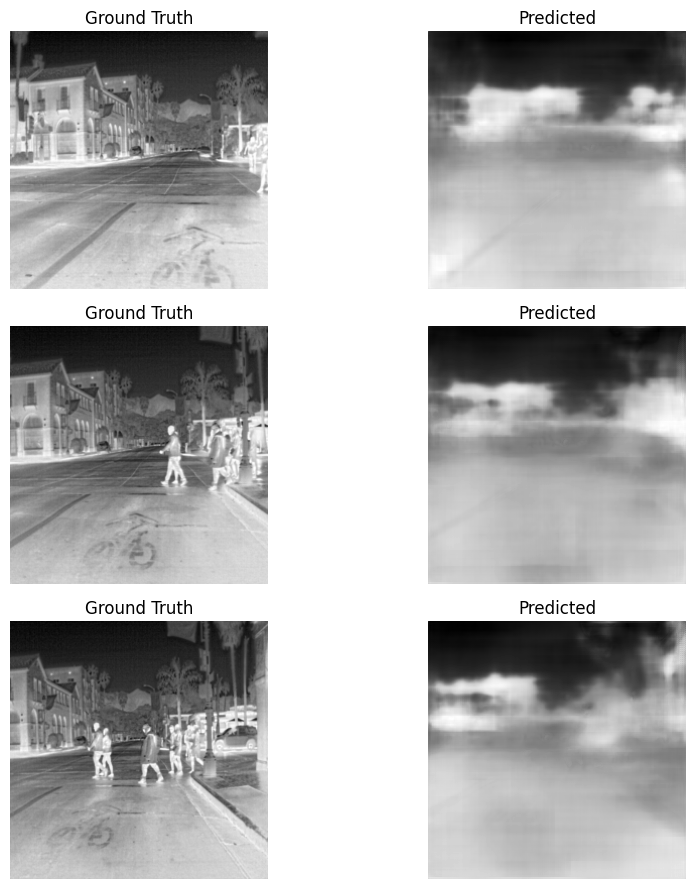

In [ ]:
# Visualize a few predictions vs. ground truth
num_show = 3
plt.figure(figsize=(10, num_show * 3))
for i in range(num_show):
    plt.subplot(num_show, 2, 2*i+1)
    plt.imshow(gts[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(num_show, 2, 2*i+2)
    plt.imshow(outputs[i], cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
plt.tight_layout()
plt.show()

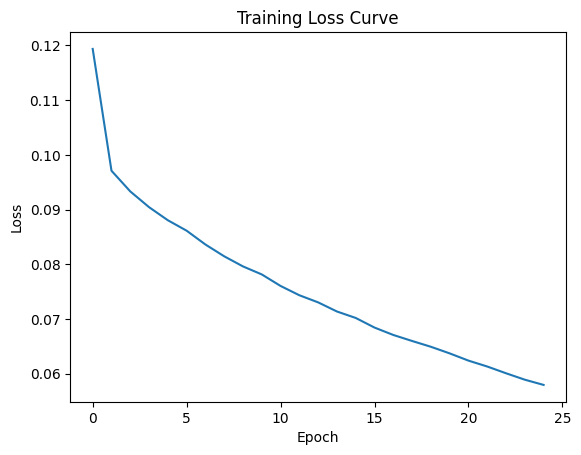

In [ ]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()